## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17617961062633416131
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7033235047
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17712545009116734836
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from scipy import interpolate
from utils.convert_coord import equirect_to_cart, cart_to_equirect
from utils.data_generator_seq2seq import data_generator_head_seq2seq_reinject_output
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv1D, MaxPooling1D, Flatten, TimeDistributed, Reshape, Lambda
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

python: 3.5.2 (default, Jul 10 2019, 11:58:48) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_reinject_output_5-32'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 32 # LSTM hidden units

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_inputs)
encoder_2, h2, c2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_1)
encoder_3, h3, c3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_2)
encoder_4, h4, c4 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_3)
encoder_5, h5, c5 = CuDNNLSTM(units=latent_dim, return_state=True)(encoder_4)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1, h2, c2, h3, c3, h4, c4, h5, c5]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_input = Input(shape=(1, 3)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_4 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_5 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_2 = TimeDistributed(Dense(3))

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

all_outputs = []
inputs = decoder_input
states = encoder_states

for _ in range(len_delay):

    decoder_outputs_1, dh1, dc1 = decoder_1(inputs, initial_state=[states[0], states[1]])

    decoder_outputs_2, dh2, dc2 = decoder_2(decoder_outputs_1, initial_state=[states[2], states[3]])

    decoder_outputs_3, dh3, dc3 = decoder_3(decoder_outputs_2, initial_state=[states[4], states[5]])
    
    decoder_outputs_4, dh4, dc4 = decoder_4(decoder_outputs_3, initial_state=[states[6], states[7]])
    
    decoder_outputs_5, dh5, dc5 = decoder_5(decoder_outputs_4, initial_state=[states[8], states[9]])

    dense_1_outputs = dense_1(decoder_outputs_5)
    outputs = dense_2(dense_1_outputs)
    
    all_outputs.append(outputs)
    
    inputs = outputs
    states = [dh1, dc1, dh2, dc2, dh3, dc3, dh4, dc4, dh5, dc5]

# Concatenate all predictions
decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)


model = Model(inputs=[encoder_inputs, decoder_input], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss='mae', optimizer="adam", metrics=[rmse])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 3)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 3)         0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        [(None, 25, 32), (No 4736        input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)        [(None, 1, 32), (Non 4736        input_2[0][0]                    
                                                                 cu_dnnlstm_1[0][1]         

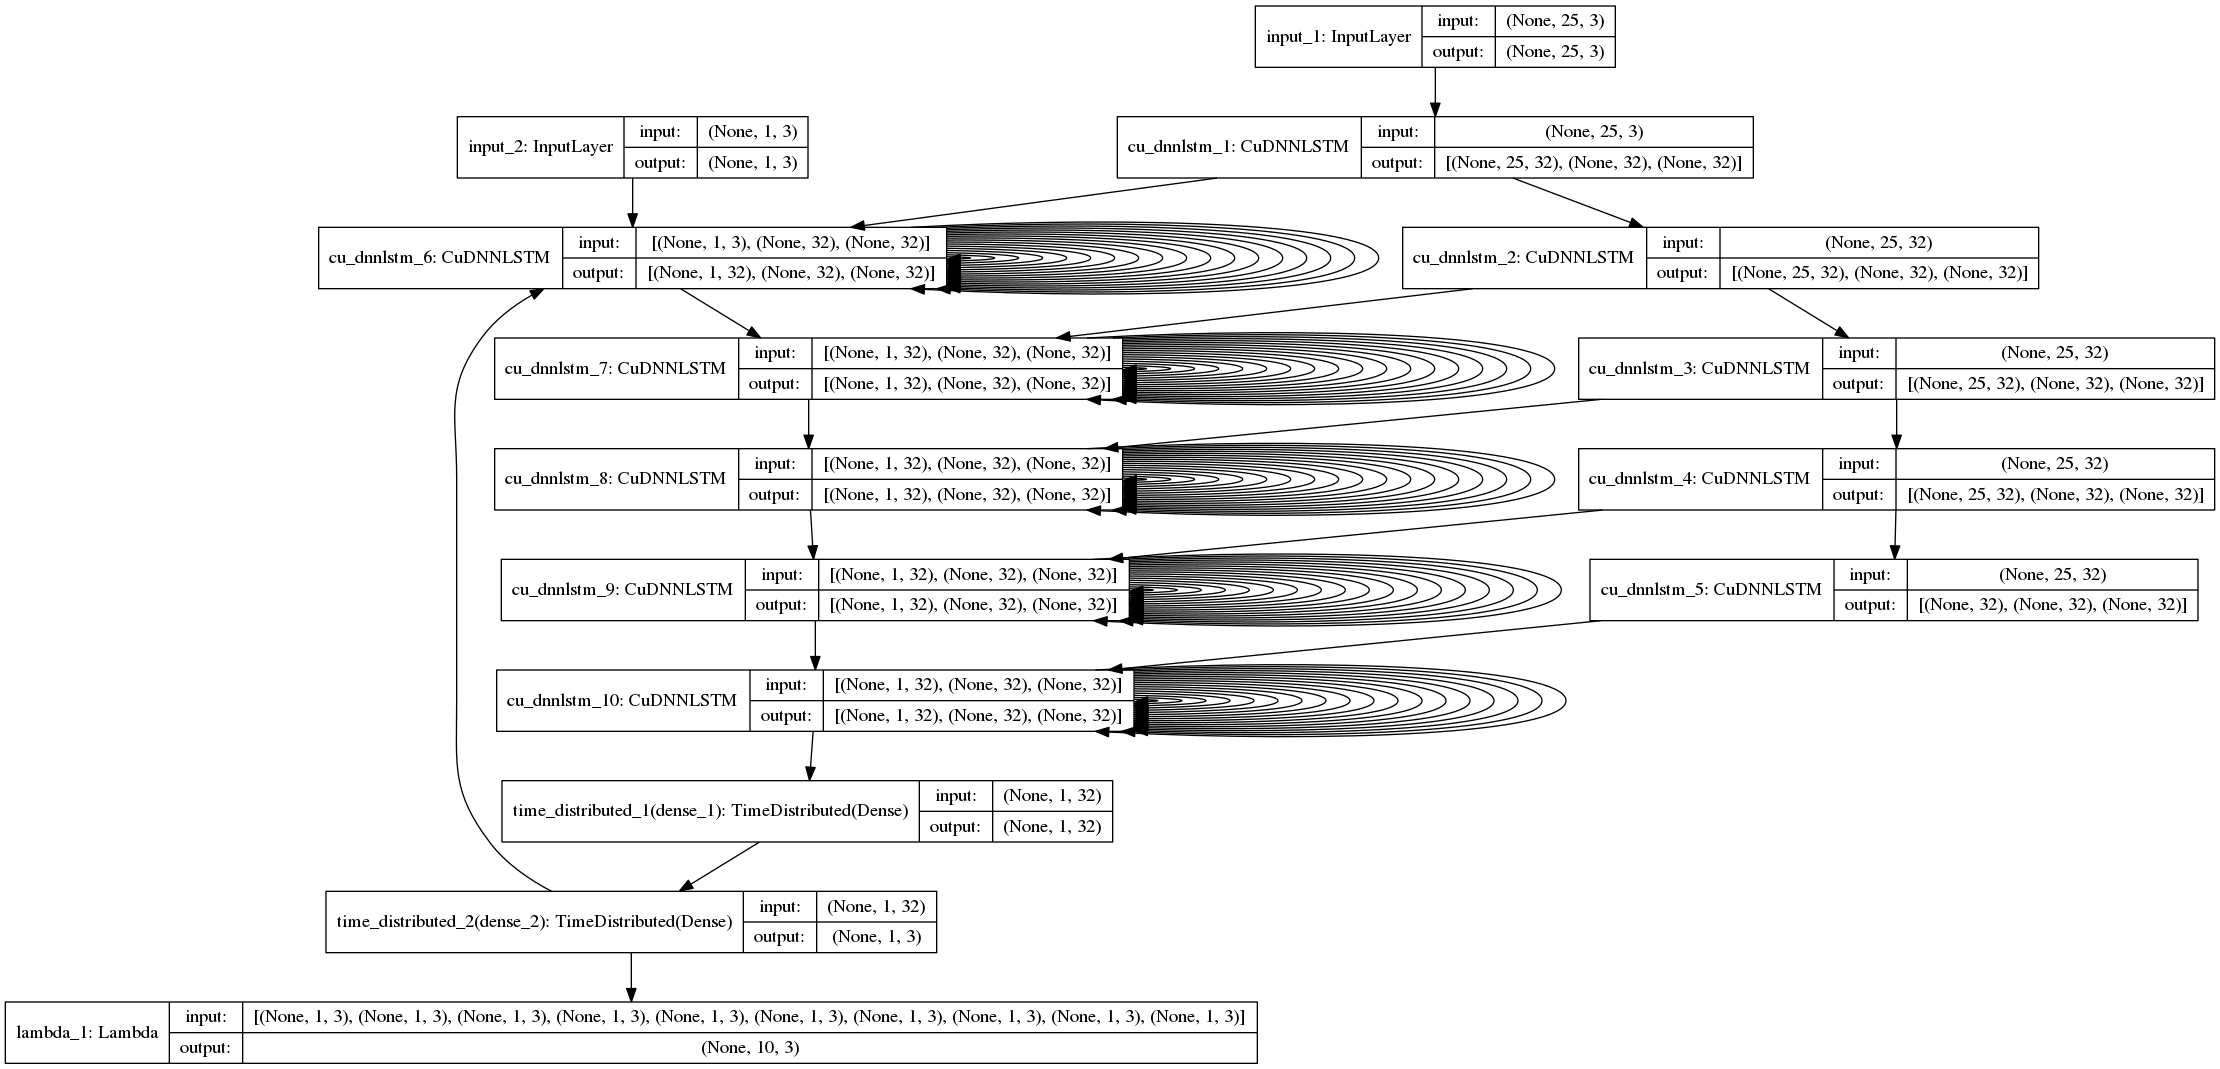

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

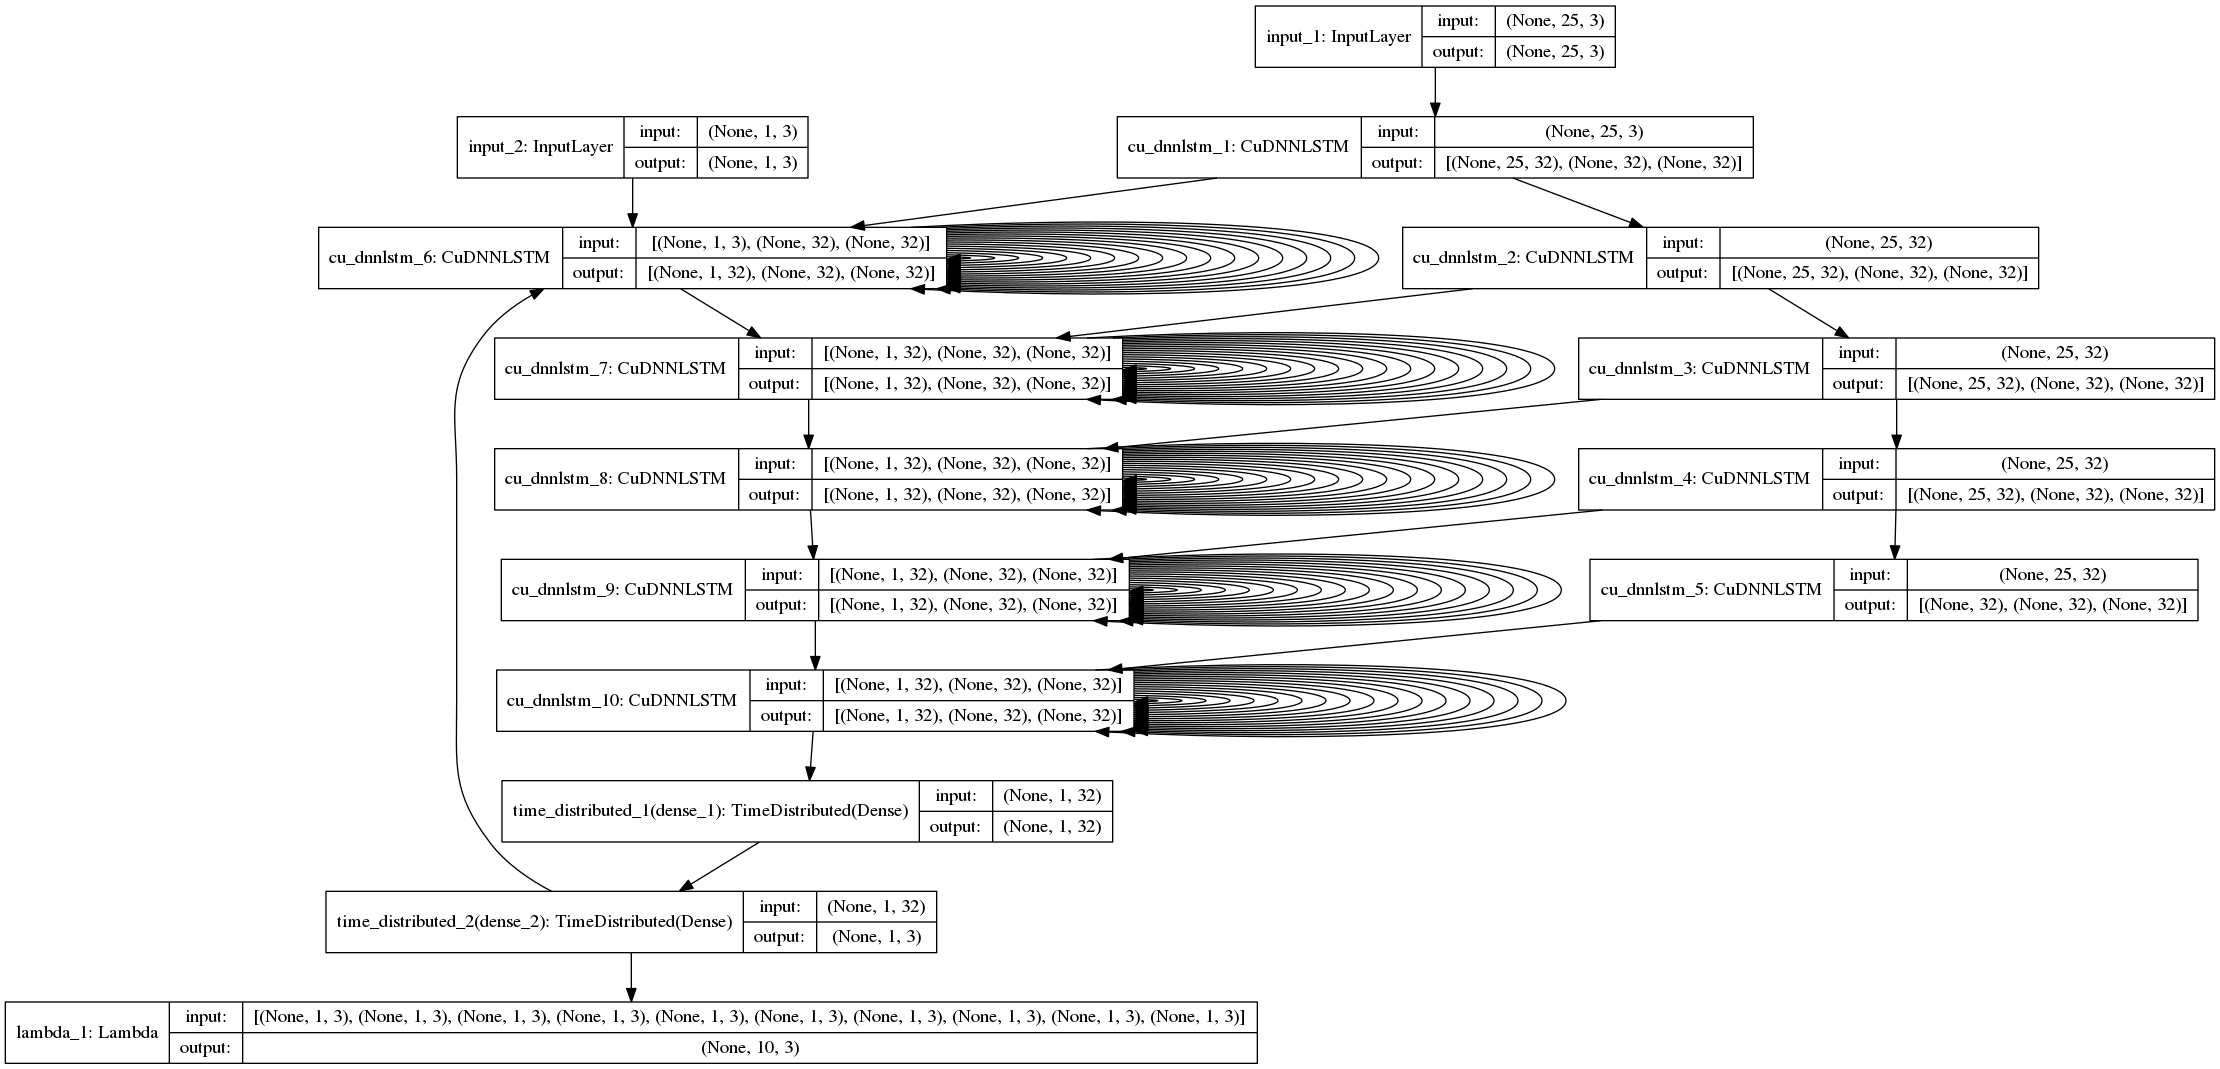

In [6]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [7]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [8]:
saliency_dir = os.path.join(dir_path, "fov_images", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
videos = os.listdir(path_to_sensor_data_train)
videos = videos
print(videos)
video_width = 3840

['013_13_times_square_static.npy', '025_07_factory_robots_static.npy', '002_01_art_gallery_static.npy', '002_02_theatre_scene_static.npy', '002_03_lions_static_cuts.npy', '002_04_copenhagen_harbour_static_cuts.npy', '002_07_factory_robots_static.npy', '002_09_elephants_static.npy', '002_12_gym_workout_static.npy', '002_13_times_square_static.npy', '002_14_new_orleans_drive_motion.npy', '002_16_interview_static.npy', '002_17_weather_forecast_static.npy', '002_18_bomb_trapped_static.npy', '002_20_car_fix_static.npy', '002_23_dog_food_factory_motion.npy', '003_01_art_gallery_static.npy', '003_02_theatre_scene_static.npy', '003_03_lions_static_cuts.npy', '003_04_copenhagen_harbour_static_cuts.npy', '003_05_florida_yacht_motion.npy', '003_07_factory_robots_static.npy', '003_08_madagascar_cuts.npy', '003_09_elephants_static.npy', '003_11_lohdi_garden_india_cuts.npy', '003_12_gym_workout_static.npy', '003_13_times_square_static.npy', '003_14_new_orleans_drive_motion.npy', '003_18_bomb_trapped

In [9]:
use_generator = True
if use_generator:
    nb_epochs = 150
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_seq2seq_reinject_output(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_seq2seq_reinject_output(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

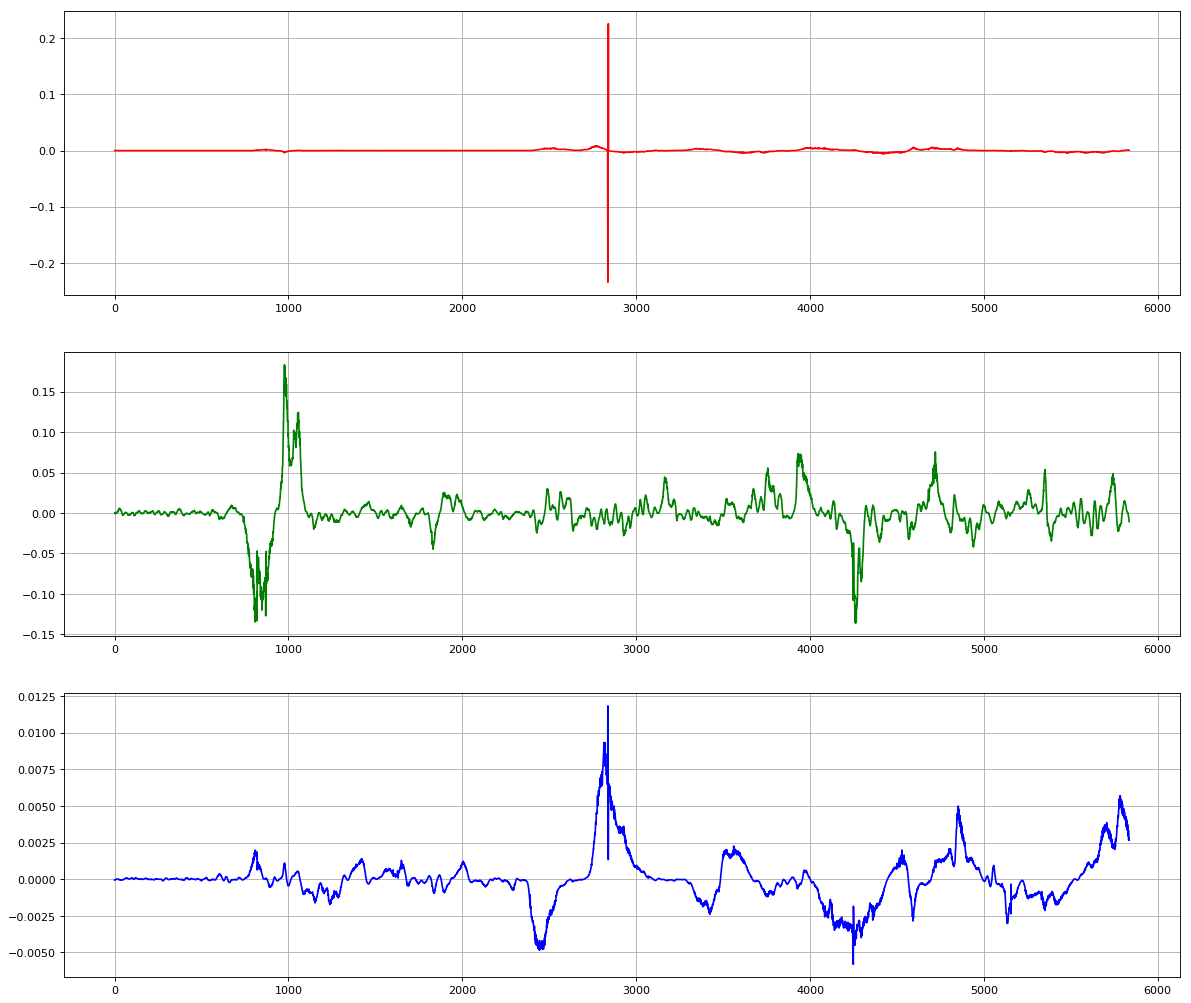

In [10]:
[encoder_input, decoder_input], Y_train = next(train_gen)

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)

In [11]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=len(videos) - ind_max_train)
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/150


  1/542 [..............................] - ETA: 27:45 - loss: 0.0230 - rmse: 0.0538

  2/542 [..............................] - ETA: 14:09 - loss: 0.0439 - rmse: 0.1385

  3/542 [..............................] - ETA: 9:38 - loss: 0.0553 - rmse: 0.1557 

  4/542 [..............................] - ETA: 7:22 - loss: 0.0504 - rmse: 0.1480

  5/542 [..............................] - ETA: 6:00 - loss: 0.0455 - rmse: 0.1411

  6/542 [..............................] - ETA: 5:06 - loss: 0.0430 - rmse: 0.1321

  7/542 [..............................] - ETA: 4:27 - loss: 0.0426 - rmse: 0.1300

  8/542 [..............................] - ETA: 3:57 - loss: 0.0539 - rmse: 0.1536

  9/542 [..............................] - ETA: 3:34 - loss: 0.0573 - rmse: 0.1599

 10/542 [..............................] - ETA: 3:16 - loss: 0.0644 - rmse: 0.1736

 11/542 [..............................] - ETA: 3:01 - loss: 0.0659 - rmse: 0.1772

 12/542 [..............................] - ETA: 2:49 - loss: 0.0680 - rmse: 0.1867

 13/542 [..............................] - ETA: 2:38 - loss: 0.0653 - rmse: 0.1803

 14/542 [..............................] - ETA: 2:29 - loss: 0.0644 - rmse: 0.1774

 15/542 [..............................] - ETA: 2:21 - loss: 0.0630 - rmse: 0.1735

 16/542 [..............................] - ETA: 2:14 - loss: 0.0605 - rmse: 0.1656

 17/542 [..............................] - ETA: 2:08 - loss: 0.0627 - rmse: 0.1727

 18/542 [..............................] - ETA: 2:03 - loss: 0.0621 - rmse: 0.1721

 19/542 [>.............................] - ETA: 1:58 - loss: 0.0615 - rmse: 0.1702

 20/542 [>.............................] - ETA: 1:53 - loss: 0.0588 - rmse: 0.1634

 21/542 [>.............................] - ETA: 1:49 - loss: 0.0601 - rmse: 0.1668

 22/542 [>.............................] - ETA: 1:46 - loss: 0.0605 - rmse: 0.1679

 23/542 [>.............................] - ETA: 1:42 - loss: 0.0611 - rmse: 0.1686

 24/542 [>.............................] - ETA: 1:39 - loss: 0.0600 - rmse: 0.1647

 25/542 [>.............................] - ETA: 1:37 - loss: 0.0600 - rmse: 0.1639

 26/542 [>.............................] - ETA: 1:34 - loss: 0.0607 - rmse: 0.1641

 27/542 [>.............................] - ETA: 1:31 - loss: 0.0608 - rmse: 0.1655

 28/542 [>.............................] - ETA: 1:29 - loss: 0.0602 - rmse: 0.1647

 29/542 [>.............................] - ETA: 1:27 - loss: 0.0601 - rmse: 0.1636

 30/542 [>.............................] - ETA: 1:25 - loss: 0.0602 - rmse: 0.1647

 31/542 [>.............................] - ETA: 1:24 - loss: 0.0615 - rmse: 0.1678

 32/542 [>.............................] - ETA: 1:22 - loss: 0.0614 - rmse: 0.1677

 33/542 [>.............................] - ETA: 1:20 - loss: 0.0613 - rmse: 0.1673

 34/542 [>.............................] - ETA: 1:19 - loss: 0.0606 - rmse: 0.1650

 35/542 [>.............................] - ETA: 1:17 - loss: 0.0618 - rmse: 0.1676

 36/542 [>.............................] - ETA: 1:16 - loss: 0.0627 - rmse: 0.1696

 37/542 [=>............................] - ETA: 1:14 - loss: 0.0620 - rmse: 0.1671

 38/542 [=>............................] - ETA: 1:13 - loss: 0.0632 - rmse: 0.1687

 39/542 [=>............................] - ETA: 1:12 - loss: 0.0622 - rmse: 0.1664

 40/542 [=>............................] - ETA: 1:11 - loss: 0.0621 - rmse: 0.1663

 41/542 [=>............................] - ETA: 1:10 - loss: 0.0622 - rmse: 0.1666

 42/542 [=>............................] - ETA: 1:09 - loss: 0.0627 - rmse: 0.1668

 43/542 [=>............................] - ETA: 1:08 - loss: 0.0630 - rmse: 0.1677

 44/542 [=>............................] - ETA: 1:07 - loss: 0.0637 - rmse: 0.1687

 45/542 [=>............................] - ETA: 1:06 - loss: 0.0644 - rmse: 0.1698

 46/542 [=>............................] - ETA: 1:05 - loss: 0.0652 - rmse: 0.1714

 47/542 [=>............................] - ETA: 1:05 - loss: 0.0649 - rmse: 0.1706

 48/542 [=>............................] - ETA: 1:04 - loss: 0.0644 - rmse: 0.1689

 49/542 [=>............................] - ETA: 1:03 - loss: 0.0641 - rmse: 0.1682

 50/542 [=>............................] - ETA: 1:02 - loss: 0.0639 - rmse: 0.1679

 51/542 [=>............................] - ETA: 1:02 - loss: 0.0630 - rmse: 0.1660

 52/542 [=>............................] - ETA: 1:01 - loss: 0.0622 - rmse: 0.1637

 53/542 [=>............................] - ETA: 1:00 - loss: 0.0621 - rmse: 0.1637

 54/542 [=>............................] - ETA: 1:00 - loss: 0.0623 - rmse: 0.1642

 55/542 [==>...........................] - ETA: 59s - loss: 0.0621 - rmse: 0.1634 

 56/542 [==>...........................] - ETA: 58s - loss: 0.0612 - rmse: 0.1610

 57/542 [==>...........................] - ETA: 58s - loss: 0.0623 - rmse: 0.1633

 58/542 [==>...........................] - ETA: 57s - loss: 0.0622 - rmse: 0.1636

 59/542 [==>...........................] - ETA: 57s - loss: 0.0625 - rmse: 0.1645

 60/542 [==>...........................] - ETA: 56s - loss: 0.0625 - rmse: 0.1644

 61/542 [==>...........................] - ETA: 56s - loss: 0.0627 - rmse: 0.1649

 62/542 [==>...........................] - ETA: 55s - loss: 0.0635 - rmse: 0.1668

 63/542 [==>...........................] - ETA: 55s - loss: 0.0630 - rmse: 0.1657

 64/542 [==>...........................] - ETA: 54s - loss: 0.0632 - rmse: 0.1669

 65/542 [==>...........................] - ETA: 54s - loss: 0.0629 - rmse: 0.1666

 66/542 [==>...........................] - ETA: 53s - loss: 0.0636 - rmse: 0.1684

 67/542 [==>...........................] - ETA: 53s - loss: 0.0645 - rmse: 0.1702

 68/542 [==>...........................] - ETA: 53s - loss: 0.0644 - rmse: 0.1695

 69/542 [==>...........................] - ETA: 52s - loss: 0.0648 - rmse: 0.1699

 70/542 [==>...........................] - ETA: 52s - loss: 0.0652 - rmse: 0.1710

 71/542 [==>...........................] - ETA: 51s - loss: 0.0656 - rmse: 0.1717

 72/542 [==>...........................] - ETA: 51s - loss: 0.0652 - rmse: 0.1713

 73/542 [===>..........................] - ETA: 51s - loss: 0.0649 - rmse: 0.1707

 74/542 [===>..........................] - ETA: 50s - loss: 0.0643 - rmse: 0.1690

 75/542 [===>..........................] - ETA: 50s - loss: 0.0642 - rmse: 0.1693

 76/542 [===>..........................] - ETA: 49s - loss: 0.0651 - rmse: 0.1717

 77/542 [===>..........................] - ETA: 49s - loss: 0.0650 - rmse: 0.1717

 78/542 [===>..........................] - ETA: 49s - loss: 0.0652 - rmse: 0.1731

 79/542 [===>..........................] - ETA: 48s - loss: 0.0651 - rmse: 0.1737

 80/542 [===>..........................] - ETA: 48s - loss: 0.0652 - rmse: 0.1747

 81/542 [===>..........................] - ETA: 48s - loss: 0.0655 - rmse: 0.1756

 82/542 [===>..........................] - ETA: 47s - loss: 0.0658 - rmse: 0.1763

 83/542 [===>..........................] - ETA: 47s - loss: 0.0663 - rmse: 0.1777

 84/542 [===>..........................] - ETA: 47s - loss: 0.0666 - rmse: 0.1786

 85/542 [===>..........................] - ETA: 47s - loss: 0.0666 - rmse: 0.1790

 86/542 [===>..........................] - ETA: 46s - loss: 0.0664 - rmse: 0.1788

 87/542 [===>..........................] - ETA: 46s - loss: 0.0664 - rmse: 0.1786

 88/542 [===>..........................] - ETA: 46s - loss: 0.0667 - rmse: 0.1795

 89/542 [===>..........................] - ETA: 45s - loss: 0.0665 - rmse: 0.1790

 90/542 [===>..........................] - ETA: 45s - loss: 0.0662 - rmse: 0.1787

 91/542 [====>.........................] - ETA: 45s - loss: 0.0662 - rmse: 0.1786

 92/542 [====>.........................] - ETA: 45s - loss: 0.0661 - rmse: 0.1793

 93/542 [====>.........................] - ETA: 44s - loss: 0.0657 - rmse: 0.1781

 94/542 [====>.........................] - ETA: 44s - loss: 0.0654 - rmse: 0.1769

 95/542 [====>.........................] - ETA: 44s - loss: 0.0653 - rmse: 0.1775

 96/542 [====>.........................] - ETA: 44s - loss: 0.0650 - rmse: 0.1768

 97/542 [====>.........................] - ETA: 43s - loss: 0.0646 - rmse: 0.1754

 98/542 [====>.........................] - ETA: 43s - loss: 0.0648 - rmse: 0.1757

 99/542 [====>.........................] - ETA: 43s - loss: 0.0649 - rmse: 0.1759

100/542 [====>.........................] - ETA: 43s - loss: 0.0649 - rmse: 0.1760

101/542 [====>.........................] - ETA: 42s - loss: 0.0653 - rmse: 0.1770

102/542 [====>.........................] - ETA: 42s - loss: 0.0651 - rmse: 0.1765

103/542 [====>.........................] - ETA: 42s - loss: 0.0648 - rmse: 0.1757

104/542 [====>.........................] - ETA: 42s - loss: 0.0649 - rmse: 0.1758

105/542 [====>.........................] - ETA: 42s - loss: 0.0650 - rmse: 0.1758

106/542 [====>.........................] - ETA: 41s - loss: 0.0650 - rmse: 0.1758

107/542 [====>.........................] - ETA: 41s - loss: 0.0648 - rmse: 0.1753

108/542 [====>.........................] - ETA: 41s - loss: 0.0650 - rmse: 0.1755

109/542 [=====>........................] - ETA: 41s - loss: 0.0653 - rmse: 0.1767

110/542 [=====>........................] - ETA: 41s - loss: 0.0654 - rmse: 0.1769

111/542 [=====>........................] - ETA: 40s - loss: 0.0656 - rmse: 0.1771

112/542 [=====>........................] - ETA: 40s - loss: 0.0656 - rmse: 0.1772

113/542 [=====>........................] - ETA: 40s - loss: 0.0655 - rmse: 0.1771

114/542 [=====>........................] - ETA: 40s - loss: 0.0654 - rmse: 0.1768

115/542 [=====>........................] - ETA: 40s - loss: 0.0655 - rmse: 0.1770

116/542 [=====>........................] - ETA: 39s - loss: 0.0653 - rmse: 0.1763

117/542 [=====>........................] - ETA: 39s - loss: 0.0649 - rmse: 0.1750

118/542 [=====>........................] - ETA: 39s - loss: 0.0648 - rmse: 0.1751

119/542 [=====>........................] - ETA: 39s - loss: 0.0652 - rmse: 0.1761

120/542 [=====>........................] - ETA: 39s - loss: 0.0648 - rmse: 0.1751

121/542 [=====>........................] - ETA: 38s - loss: 0.0647 - rmse: 0.1747

122/542 [=====>........................] - ETA: 38s - loss: 0.0646 - rmse: 0.1748

123/542 [=====>........................] - ETA: 38s - loss: 0.0643 - rmse: 0.1741

124/542 [=====>........................] - ETA: 38s - loss: 0.0643 - rmse: 0.1743

125/542 [=====>........................] - ETA: 38s - loss: 0.0641 - rmse: 0.1742

126/542 [=====>........................] - ETA: 38s - loss: 0.0643 - rmse: 0.1745

127/542 [======>.......................] - ETA: 37s - loss: 0.0643 - rmse: 0.1743

128/542 [======>.......................] - ETA: 37s - loss: 0.0644 - rmse: 0.1750

129/542 [======>.......................] - ETA: 37s - loss: 0.0644 - rmse: 0.1747

130/542 [======>.......................] - ETA: 37s - loss: 0.0641 - rmse: 0.1738

131/542 [======>.......................] - ETA: 37s - loss: 0.0641 - rmse: 0.1740

132/542 [======>.......................] - ETA: 37s - loss: 0.0641 - rmse: 0.1741

133/542 [======>.......................] - ETA: 36s - loss: 0.0642 - rmse: 0.1750

134/542 [======>.......................] - ETA: 36s - loss: 0.0647 - rmse: 0.1765

135/542 [======>.......................] - ETA: 36s - loss: 0.0649 - rmse: 0.1768

136/542 [======>.......................] - ETA: 36s - loss: 0.0646 - rmse: 0.1760

137/542 [======>.......................] - ETA: 36s - loss: 0.0648 - rmse: 0.1764

138/542 [======>.......................] - ETA: 36s - loss: 0.0646 - rmse: 0.1761

139/542 [======>.......................] - ETA: 35s - loss: 0.0647 - rmse: 0.1763

140/542 [======>.......................] - ETA: 35s - loss: 0.0645 - rmse: 0.1754

141/542 [======>.......................] - ETA: 35s - loss: 0.0645 - rmse: 0.1757

142/542 [======>.......................] - ETA: 35s - loss: 0.0642 - rmse: 0.1749

143/542 [======>.......................] - ETA: 35s - loss: 0.0643 - rmse: 0.1751

144/542 [======>.......................] - ETA: 35s - loss: 0.0644 - rmse: 0.1753

145/542 [=======>......................] - ETA: 35s - loss: 0.0646 - rmse: 0.1758

146/542 [=======>......................] - ETA: 34s - loss: 0.0645 - rmse: 0.1753

147/542 [=======>......................] - ETA: 34s - loss: 0.0644 - rmse: 0.1753

148/542 [=======>......................] - ETA: 34s - loss: 0.0644 - rmse: 0.1755

149/542 [=======>......................] - ETA: 34s - loss: 0.0644 - rmse: 0.1757

150/542 [=======>......................] - ETA: 34s - loss: 0.0644 - rmse: 0.1758

151/542 [=======>......................] - ETA: 34s - loss: 0.0643 - rmse: 0.1755

152/542 [=======>......................] - ETA: 34s - loss: 0.0644 - rmse: 0.1755

153/542 [=======>......................] - ETA: 33s - loss: 0.0643 - rmse: 0.1754

154/542 [=======>......................] - ETA: 33s - loss: 0.0645 - rmse: 0.1761

155/542 [=======>......................] - ETA: 33s - loss: 0.0642 - rmse: 0.1752

156/542 [=======>......................] - ETA: 33s - loss: 0.0645 - rmse: 0.1762

157/542 [=======>......................] - ETA: 33s - loss: 0.0647 - rmse: 0.1764

158/542 [=======>......................] - ETA: 33s - loss: 0.0646 - rmse: 0.1760

159/542 [=======>......................] - ETA: 33s - loss: 0.0645 - rmse: 0.1757

160/542 [=======>......................] - ETA: 33s - loss: 0.0643 - rmse: 0.1753

161/542 [=======>......................] - ETA: 32s - loss: 0.0640 - rmse: 0.1745

162/542 [=======>......................] - ETA: 32s - loss: 0.0642 - rmse: 0.1749

163/542 [========>.....................] - ETA: 32s - loss: 0.0641 - rmse: 0.1746

164/542 [========>.....................] - ETA: 32s - loss: 0.0642 - rmse: 0.1750

165/542 [========>.....................] - ETA: 32s - loss: 0.0643 - rmse: 0.1753

166/542 [========>.....................] - ETA: 32s - loss: 0.0644 - rmse: 0.1753

167/542 [========>.....................] - ETA: 32s - loss: 0.0643 - rmse: 0.1752

168/542 [========>.....................] - ETA: 32s - loss: 0.0642 - rmse: 0.1751

169/542 [========>.....................] - ETA: 31s - loss: 0.0646 - rmse: 0.1759

170/542 [========>.....................] - ETA: 31s - loss: 0.0650 - rmse: 0.1768

171/542 [========>.....................] - ETA: 31s - loss: 0.0652 - rmse: 0.1774

172/542 [========>.....................] - ETA: 31s - loss: 0.0655 - rmse: 0.1778

173/542 [========>.....................] - ETA: 31s - loss: 0.0654 - rmse: 0.1774

174/542 [========>.....................] - ETA: 31s - loss: 0.0654 - rmse: 0.1775

175/542 [========>.....................] - ETA: 31s - loss: 0.0655 - rmse: 0.1778

176/542 [========>.....................] - ETA: 30s - loss: 0.0656 - rmse: 0.1779

177/542 [========>.....................] - ETA: 30s - loss: 0.0657 - rmse: 0.1785

178/542 [========>.....................] - ETA: 30s - loss: 0.0657 - rmse: 0.1786

179/542 [========>.....................] - ETA: 30s - loss: 0.0657 - rmse: 0.1785

180/542 [========>.....................] - ETA: 30s - loss: 0.0658 - rmse: 0.1785

181/542 [=========>....................] - ETA: 30s - loss: 0.0656 - rmse: 0.1780

182/542 [=========>....................] - ETA: 30s - loss: 0.0657 - rmse: 0.1779

183/542 [=========>....................] - ETA: 30s - loss: 0.0658 - rmse: 0.1781

184/542 [=========>....................] - ETA: 30s - loss: 0.0661 - rmse: 0.1790

185/542 [=========>....................] - ETA: 29s - loss: 0.0663 - rmse: 0.1792

186/542 [=========>....................] - ETA: 29s - loss: 0.0666 - rmse: 0.1799

187/542 [=========>....................] - ETA: 29s - loss: 0.0664 - rmse: 0.1794

188/542 [=========>....................] - ETA: 29s - loss: 0.0662 - rmse: 0.1789

189/542 [=========>....................] - ETA: 29s - loss: 0.0661 - rmse: 0.1787

190/542 [=========>....................] - ETA: 29s - loss: 0.0661 - rmse: 0.1786

191/542 [=========>....................] - ETA: 29s - loss: 0.0661 - rmse: 0.1785

192/542 [=========>....................] - ETA: 29s - loss: 0.0660 - rmse: 0.1781

193/542 [=========>....................] - ETA: 29s - loss: 0.0664 - rmse: 0.1790

194/542 [=========>....................] - ETA: 28s - loss: 0.0664 - rmse: 0.1789

195/542 [=========>....................] - ETA: 28s - loss: 0.0667 - rmse: 0.1796

196/542 [=========>....................] - ETA: 28s - loss: 0.0666 - rmse: 0.1794

197/542 [=========>....................] - ETA: 28s - loss: 0.0667 - rmse: 0.1797

198/542 [=========>....................] - ETA: 28s - loss: 0.0668 - rmse: 0.1799

199/542 [==========>...................] - ETA: 28s - loss: 0.0666 - rmse: 0.1792

200/542 [==========>...................] - ETA: 28s - loss: 0.0665 - rmse: 0.1792

201/542 [==========>...................] - ETA: 28s - loss: 0.0662 - rmse: 0.1784

202/542 [==========>...................] - ETA: 28s - loss: 0.0665 - rmse: 0.1789

203/542 [==========>...................] - ETA: 27s - loss: 0.0664 - rmse: 0.1785

204/542 [==========>...................] - ETA: 27s - loss: 0.0663 - rmse: 0.1784

205/542 [==========>...................] - ETA: 27s - loss: 0.0665 - rmse: 0.1788

206/542 [==========>...................] - ETA: 27s - loss: 0.0664 - rmse: 0.1785

207/542 [==========>...................] - ETA: 27s - loss: 0.0663 - rmse: 0.1781

208/542 [==========>...................] - ETA: 27s - loss: 0.0662 - rmse: 0.1777

209/542 [==========>...................] - ETA: 27s - loss: 0.0660 - rmse: 0.1774

210/542 [==========>...................] - ETA: 27s - loss: 0.0658 - rmse: 0.1768

211/542 [==========>...................] - ETA: 27s - loss: 0.0657 - rmse: 0.1763

212/542 [==========>...................] - ETA: 27s - loss: 0.0659 - rmse: 0.1769

213/542 [==========>...................] - ETA: 26s - loss: 0.0661 - rmse: 0.1775

214/542 [==========>...................] - ETA: 26s - loss: 0.0659 - rmse: 0.1771

215/542 [==========>...................] - ETA: 26s - loss: 0.0659 - rmse: 0.1776

216/542 [==========>...................] - ETA: 26s - loss: 0.0658 - rmse: 0.1773

217/542 [===========>..................] - ETA: 26s - loss: 0.0657 - rmse: 0.1770

218/542 [===========>..................] - ETA: 26s - loss: 0.0655 - rmse: 0.1765

219/542 [===========>..................] - ETA: 26s - loss: 0.0654 - rmse: 0.1761

220/542 [===========>..................] - ETA: 26s - loss: 0.0653 - rmse: 0.1759

221/542 [===========>..................] - ETA: 26s - loss: 0.0651 - rmse: 0.1752

222/542 [===========>..................] - ETA: 26s - loss: 0.0652 - rmse: 0.1754

223/542 [===========>..................] - ETA: 25s - loss: 0.0651 - rmse: 0.1751

224/542 [===========>..................] - ETA: 25s - loss: 0.0652 - rmse: 0.1756

225/542 [===========>..................] - ETA: 25s - loss: 0.0653 - rmse: 0.1759

226/542 [===========>..................] - ETA: 25s - loss: 0.0654 - rmse: 0.1763

227/542 [===========>..................] - ETA: 25s - loss: 0.0654 - rmse: 0.1764

228/542 [===========>..................] - ETA: 25s - loss: 0.0655 - rmse: 0.1765

229/542 [===========>..................] - ETA: 25s - loss: 0.0654 - rmse: 0.1766

230/542 [===========>..................] - ETA: 25s - loss: 0.0656 - rmse: 0.1769

231/542 [===========>..................] - ETA: 25s - loss: 0.0655 - rmse: 0.1768

232/542 [===========>..................] - ETA: 25s - loss: 0.0655 - rmse: 0.1767

233/542 [===========>..................] - ETA: 24s - loss: 0.0654 - rmse: 0.1764

234/542 [===========>..................] - ETA: 24s - loss: 0.0654 - rmse: 0.1763

235/542 [============>.................] - ETA: 24s - loss: 0.0655 - rmse: 0.1767

236/542 [============>.................] - ETA: 24s - loss: 0.0654 - rmse: 0.1767

237/542 [============>.................] - ETA: 24s - loss: 0.0652 - rmse: 0.1761

238/542 [============>.................] - ETA: 24s - loss: 0.0650 - rmse: 0.1757

239/542 [============>.................] - ETA: 24s - loss: 0.0652 - rmse: 0.1761

240/542 [============>.................] - ETA: 24s - loss: 0.0650 - rmse: 0.1757

241/542 [============>.................] - ETA: 24s - loss: 0.0649 - rmse: 0.1754

242/542 [============>.................] - ETA: 24s - loss: 0.0649 - rmse: 0.1755

243/542 [============>.................] - ETA: 23s - loss: 0.0649 - rmse: 0.1753

244/542 [============>.................] - ETA: 23s - loss: 0.0648 - rmse: 0.1755

245/542 [============>.................] - ETA: 23s - loss: 0.0649 - rmse: 0.1754

246/542 [============>.................] - ETA: 23s - loss: 0.0647 - rmse: 0.1748

247/542 [============>.................] - ETA: 23s - loss: 0.0646 - rmse: 0.1748

248/542 [============>.................] - ETA: 23s - loss: 0.0645 - rmse: 0.1743

249/542 [============>.................] - ETA: 23s - loss: 0.0643 - rmse: 0.1738

250/542 [============>.................] - ETA: 23s - loss: 0.0641 - rmse: 0.1733

251/542 [============>.................] - ETA: 23s - loss: 0.0641 - rmse: 0.1732

252/542 [============>.................] - ETA: 23s - loss: 0.0641 - rmse: 0.1734

253/542 [=============>................] - ETA: 23s - loss: 0.0639 - rmse: 0.1730

254/542 [=============>................] - ETA: 22s - loss: 0.0640 - rmse: 0.1732

255/542 [=============>................] - ETA: 22s - loss: 0.0641 - rmse: 0.1733

256/542 [=============>................] - ETA: 22s - loss: 0.0641 - rmse: 0.1733

257/542 [=============>................] - ETA: 22s - loss: 0.0643 - rmse: 0.1735

258/542 [=============>................] - ETA: 22s - loss: 0.0643 - rmse: 0.1735

259/542 [=============>................] - ETA: 22s - loss: 0.0642 - rmse: 0.1734

260/542 [=============>................] - ETA: 22s - loss: 0.0645 - rmse: 0.1741

261/542 [=============>................] - ETA: 22s - loss: 0.0647 - rmse: 0.1745

262/542 [=============>................] - ETA: 22s - loss: 0.0647 - rmse: 0.1748

263/542 [=============>................] - ETA: 22s - loss: 0.0646 - rmse: 0.1744

264/542 [=============>................] - ETA: 21s - loss: 0.0647 - rmse: 0.1748

265/542 [=============>................] - ETA: 21s - loss: 0.0646 - rmse: 0.1745

266/542 [=============>................] - ETA: 21s - loss: 0.0646 - rmse: 0.1746

267/542 [=============>................] - ETA: 21s - loss: 0.0647 - rmse: 0.1746

268/542 [=============>................] - ETA: 21s - loss: 0.0647 - rmse: 0.1745

269/542 [=============>................] - ETA: 21s - loss: 0.0646 - rmse: 0.1744

270/542 [=============>................] - ETA: 21s - loss: 0.0646 - rmse: 0.1745

271/542 [==============>...............] - ETA: 21s - loss: 0.0645 - rmse: 0.1743

272/542 [==============>...............] - ETA: 21s - loss: 0.0645 - rmse: 0.1744

273/542 [==============>...............] - ETA: 21s - loss: 0.0645 - rmse: 0.1747

274/542 [==============>...............] - ETA: 21s - loss: 0.0644 - rmse: 0.1745

275/542 [==============>...............] - ETA: 20s - loss: 0.0645 - rmse: 0.1750

276/542 [==============>...............] - ETA: 20s - loss: 0.0646 - rmse: 0.1752

277/542 [==============>...............] - ETA: 20s - loss: 0.0645 - rmse: 0.1751

278/542 [==============>...............] - ETA: 20s - loss: 0.0645 - rmse: 0.1751

279/542 [==============>...............] - ETA: 20s - loss: 0.0645 - rmse: 0.1751

280/542 [==============>...............] - ETA: 20s - loss: 0.0645 - rmse: 0.1750

281/542 [==============>...............] - ETA: 20s - loss: 0.0648 - rmse: 0.1754

282/542 [==============>...............] - ETA: 20s - loss: 0.0648 - rmse: 0.1757

283/542 [==============>...............] - ETA: 20s - loss: 0.0647 - rmse: 0.1755

284/542 [==============>...............] - ETA: 20s - loss: 0.0649 - rmse: 0.1762

285/542 [==============>...............] - ETA: 20s - loss: 0.0648 - rmse: 0.1759

286/542 [==============>...............] - ETA: 19s - loss: 0.0648 - rmse: 0.1757

287/542 [==============>...............] - ETA: 19s - loss: 0.0646 - rmse: 0.1754

288/542 [==============>...............] - ETA: 19s - loss: 0.0646 - rmse: 0.1753

289/542 [==============>...............] - ETA: 19s - loss: 0.0645 - rmse: 0.1749

290/542 [===============>..............] - ETA: 19s - loss: 0.0647 - rmse: 0.1753

291/542 [===============>..............] - ETA: 19s - loss: 0.0646 - rmse: 0.1751

292/542 [===============>..............] - ETA: 19s - loss: 0.0646 - rmse: 0.1752

293/542 [===============>..............] - ETA: 19s - loss: 0.0645 - rmse: 0.1752

294/542 [===============>..............] - ETA: 19s - loss: 0.0644 - rmse: 0.1751

295/542 [===============>..............] - ETA: 19s - loss: 0.0644 - rmse: 0.1752

296/542 [===============>..............] - ETA: 19s - loss: 0.0643 - rmse: 0.1750

297/542 [===============>..............] - ETA: 19s - loss: 0.0643 - rmse: 0.1750

298/542 [===============>..............] - ETA: 18s - loss: 0.0644 - rmse: 0.1752

299/542 [===============>..............] - ETA: 18s - loss: 0.0643 - rmse: 0.1748

300/542 [===============>..............] - ETA: 18s - loss: 0.0642 - rmse: 0.1746

301/542 [===============>..............] - ETA: 18s - loss: 0.0641 - rmse: 0.1744

302/542 [===============>..............] - ETA: 18s - loss: 0.0641 - rmse: 0.1743

303/542 [===============>..............] - ETA: 18s - loss: 0.0641 - rmse: 0.1743

304/542 [===============>..............] - ETA: 18s - loss: 0.0642 - rmse: 0.1743

305/542 [===============>..............] - ETA: 18s - loss: 0.0641 - rmse: 0.1741

306/542 [===============>..............] - ETA: 18s - loss: 0.0641 - rmse: 0.1742

307/542 [===============>..............] - ETA: 18s - loss: 0.0642 - rmse: 0.1744

308/542 [================>.............] - ETA: 18s - loss: 0.0641 - rmse: 0.1743

309/542 [================>.............] - ETA: 18s - loss: 0.0642 - rmse: 0.1745

310/542 [================>.............] - ETA: 17s - loss: 0.0641 - rmse: 0.1742

311/542 [================>.............] - ETA: 17s - loss: 0.0641 - rmse: 0.1742

312/542 [================>.............] - ETA: 17s - loss: 0.0642 - rmse: 0.1746

313/542 [================>.............] - ETA: 17s - loss: 0.0642 - rmse: 0.1745

314/542 [================>.............] - ETA: 17s - loss: 0.0642 - rmse: 0.1745

315/542 [================>.............] - ETA: 17s - loss: 0.0641 - rmse: 0.1742

316/542 [================>.............] - ETA: 17s - loss: 0.0641 - rmse: 0.1742

317/542 [================>.............] - ETA: 17s - loss: 0.0641 - rmse: 0.1741

318/542 [================>.............] - ETA: 17s - loss: 0.0641 - rmse: 0.1743

319/542 [================>.............] - ETA: 17s - loss: 0.0642 - rmse: 0.1744

320/542 [================>.............] - ETA: 17s - loss: 0.0642 - rmse: 0.1744

321/542 [================>.............] - ETA: 17s - loss: 0.0641 - rmse: 0.1743

322/542 [================>.............] - ETA: 16s - loss: 0.0640 - rmse: 0.1742

323/542 [================>.............] - ETA: 16s - loss: 0.0640 - rmse: 0.1741

324/542 [================>.............] - ETA: 16s - loss: 0.0639 - rmse: 0.1740

325/542 [================>.............] - ETA: 16s - loss: 0.0638 - rmse: 0.1736

326/542 [=================>............] - ETA: 16s - loss: 0.0637 - rmse: 0.1734

327/542 [=================>............] - ETA: 16s - loss: 0.0637 - rmse: 0.1733

328/542 [=================>............] - ETA: 16s - loss: 0.0635 - rmse: 0.1729

329/542 [=================>............] - ETA: 16s - loss: 0.0635 - rmse: 0.1727

330/542 [=================>............] - ETA: 16s - loss: 0.0633 - rmse: 0.1724

331/542 [=================>............] - ETA: 16s - loss: 0.0633 - rmse: 0.1723

332/542 [=================>............] - ETA: 16s - loss: 0.0634 - rmse: 0.1724

333/542 [=================>............] - ETA: 15s - loss: 0.0634 - rmse: 0.1724

334/542 [=================>............] - ETA: 15s - loss: 0.0634 - rmse: 0.1723

335/542 [=================>............] - ETA: 15s - loss: 0.0633 - rmse: 0.1722

336/542 [=================>............] - ETA: 15s - loss: 0.0634 - rmse: 0.1722

337/542 [=================>............] - ETA: 15s - loss: 0.0633 - rmse: 0.1723

338/542 [=================>............] - ETA: 15s - loss: 0.0634 - rmse: 0.1724

339/542 [=================>............] - ETA: 15s - loss: 0.0634 - rmse: 0.1725

340/542 [=================>............] - ETA: 15s - loss: 0.0633 - rmse: 0.1724

341/542 [=================>............] - ETA: 15s - loss: 0.0633 - rmse: 0.1722

342/542 [=================>............] - ETA: 15s - loss: 0.0633 - rmse: 0.1723

343/542 [=================>............] - ETA: 15s - loss: 0.0633 - rmse: 0.1721

344/542 [==================>...........] - ETA: 15s - loss: 0.0632 - rmse: 0.1719

345/542 [==================>...........] - ETA: 15s - loss: 0.0631 - rmse: 0.1715

346/542 [==================>...........] - ETA: 14s - loss: 0.0629 - rmse: 0.1711

347/542 [==================>...........] - ETA: 14s - loss: 0.0630 - rmse: 0.1711

348/542 [==================>...........] - ETA: 14s - loss: 0.0632 - rmse: 0.1717

349/542 [==================>...........] - ETA: 14s - loss: 0.0633 - rmse: 0.1718

350/542 [==================>...........] - ETA: 14s - loss: 0.0632 - rmse: 0.1715

351/542 [==================>...........] - ETA: 14s - loss: 0.0632 - rmse: 0.1714

352/542 [==================>...........] - ETA: 14s - loss: 0.0632 - rmse: 0.1714

353/542 [==================>...........] - ETA: 14s - loss: 0.0631 - rmse: 0.1712

354/542 [==================>...........] - ETA: 14s - loss: 0.0633 - rmse: 0.1715

355/542 [==================>...........] - ETA: 14s - loss: 0.0633 - rmse: 0.1716

356/542 [==================>...........] - ETA: 14s - loss: 0.0633 - rmse: 0.1715

357/542 [==================>...........] - ETA: 14s - loss: 0.0633 - rmse: 0.1714

358/542 [==================>...........] - ETA: 13s - loss: 0.0633 - rmse: 0.1714

359/542 [==================>...........] - ETA: 13s - loss: 0.0634 - rmse: 0.1717

360/542 [==================>...........] - ETA: 13s - loss: 0.0634 - rmse: 0.1716

361/542 [==================>...........] - ETA: 13s - loss: 0.0634 - rmse: 0.1716

362/542 [===================>..........] - ETA: 13s - loss: 0.0635 - rmse: 0.1717

363/542 [===================>..........] - ETA: 13s - loss: 0.0633 - rmse: 0.1713

364/542 [===================>..........] - ETA: 13s - loss: 0.0633 - rmse: 0.1715

365/542 [===================>..........] - ETA: 13s - loss: 0.0632 - rmse: 0.1712

366/542 [===================>..........] - ETA: 13s - loss: 0.0632 - rmse: 0.1711

367/542 [===================>..........] - ETA: 13s - loss: 0.0632 - rmse: 0.1710

368/542 [===================>..........] - ETA: 13s - loss: 0.0633 - rmse: 0.1713

369/542 [===================>..........] - ETA: 13s - loss: 0.0633 - rmse: 0.1713

370/542 [===================>..........] - ETA: 13s - loss: 0.0633 - rmse: 0.1714

371/542 [===================>..........] - ETA: 12s - loss: 0.0632 - rmse: 0.1711

372/542 [===================>..........] - ETA: 12s - loss: 0.0632 - rmse: 0.1712

373/542 [===================>..........] - ETA: 12s - loss: 0.0632 - rmse: 0.1710

374/542 [===================>..........] - ETA: 12s - loss: 0.0632 - rmse: 0.1712

375/542 [===================>..........] - ETA: 12s - loss: 0.0632 - rmse: 0.1711

376/542 [===================>..........] - ETA: 12s - loss: 0.0631 - rmse: 0.1712

377/542 [===================>..........] - ETA: 12s - loss: 0.0631 - rmse: 0.1712

378/542 [===================>..........] - ETA: 12s - loss: 0.0631 - rmse: 0.1710

379/542 [===================>..........] - ETA: 12s - loss: 0.0631 - rmse: 0.1710

380/542 [====================>.........] - ETA: 12s - loss: 0.0631 - rmse: 0.1710

381/542 [====================>.........] - ETA: 12s - loss: 0.0631 - rmse: 0.1712

382/542 [====================>.........] - ETA: 12s - loss: 0.0631 - rmse: 0.1711

383/542 [====================>.........] - ETA: 11s - loss: 0.0631 - rmse: 0.1712

384/542 [====================>.........] - ETA: 11s - loss: 0.0631 - rmse: 0.1712

385/542 [====================>.........] - ETA: 11s - loss: 0.0631 - rmse: 0.1712

386/542 [====================>.........] - ETA: 11s - loss: 0.0633 - rmse: 0.1717

387/542 [====================>.........] - ETA: 11s - loss: 0.0633 - rmse: 0.1717

388/542 [====================>.........] - ETA: 11s - loss: 0.0634 - rmse: 0.1722

389/542 [====================>.........] - ETA: 11s - loss: 0.0634 - rmse: 0.1721

390/542 [====================>.........] - ETA: 11s - loss: 0.0635 - rmse: 0.1724

391/542 [====================>.........] - ETA: 11s - loss: 0.0635 - rmse: 0.1722

392/542 [====================>.........] - ETA: 11s - loss: 0.0635 - rmse: 0.1723

393/542 [====================>.........] - ETA: 11s - loss: 0.0635 - rmse: 0.1723

394/542 [====================>.........] - ETA: 11s - loss: 0.0635 - rmse: 0.1723

395/542 [====================>.........] - ETA: 11s - loss: 0.0635 - rmse: 0.1722

396/542 [====================>.........] - ETA: 10s - loss: 0.0634 - rmse: 0.1721

397/542 [====================>.........] - ETA: 10s - loss: 0.0634 - rmse: 0.1721

398/542 [=====================>........] - ETA: 10s - loss: 0.0633 - rmse: 0.1719

399/542 [=====================>........] - ETA: 10s - loss: 0.0632 - rmse: 0.1716

400/542 [=====================>........] - ETA: 10s - loss: 0.0632 - rmse: 0.1717

401/542 [=====================>........] - ETA: 10s - loss: 0.0631 - rmse: 0.1715

402/542 [=====================>........] - ETA: 10s - loss: 0.0632 - rmse: 0.1716

403/542 [=====================>........] - ETA: 10s - loss: 0.0631 - rmse: 0.1715

404/542 [=====================>........] - ETA: 10s - loss: 0.0631 - rmse: 0.1716

405/542 [=====================>........] - ETA: 10s - loss: 0.0630 - rmse: 0.1713

406/542 [=====================>........] - ETA: 10s - loss: 0.0630 - rmse: 0.1713

407/542 [=====================>........] - ETA: 10s - loss: 0.0630 - rmse: 0.1713

408/542 [=====================>........] - ETA: 10s - loss: 0.0632 - rmse: 0.1719

409/542 [=====================>........] - ETA: 9s - loss: 0.0634 - rmse: 0.1725 

410/542 [=====================>........] - ETA: 9s - loss: 0.0633 - rmse: 0.1725

411/542 [=====================>........] - ETA: 9s - loss: 0.0633 - rmse: 0.1723

412/542 [=====================>........] - ETA: 9s - loss: 0.0634 - rmse: 0.1724

413/542 [=====================>........] - ETA: 9s - loss: 0.0635 - rmse: 0.1725

414/542 [=====================>........] - ETA: 9s - loss: 0.0635 - rmse: 0.1724

415/542 [=====================>........] - ETA: 9s - loss: 0.0635 - rmse: 0.1724

416/542 [======================>.......] - ETA: 9s - loss: 0.0635 - rmse: 0.1726

417/542 [======================>.......] - ETA: 9s - loss: 0.0636 - rmse: 0.1727

418/542 [======================>.......] - ETA: 9s - loss: 0.0636 - rmse: 0.1727

419/542 [======================>.......] - ETA: 9s - loss: 0.0636 - rmse: 0.1728

420/542 [======================>.......] - ETA: 9s - loss: 0.0635 - rmse: 0.1726

421/542 [======================>.......] - ETA: 9s - loss: 0.0635 - rmse: 0.1726

422/542 [======================>.......] - ETA: 8s - loss: 0.0634 - rmse: 0.1724

423/542 [======================>.......] - ETA: 8s - loss: 0.0634 - rmse: 0.1724

424/542 [======================>.......] - ETA: 8s - loss: 0.0635 - rmse: 0.1726

425/542 [======================>.......] - ETA: 8s - loss: 0.0635 - rmse: 0.1725

426/542 [======================>.......] - ETA: 8s - loss: 0.0635 - rmse: 0.1726

427/542 [======================>.......] - ETA: 8s - loss: 0.0635 - rmse: 0.1726

428/542 [======================>.......] - ETA: 8s - loss: 0.0634 - rmse: 0.1724

429/542 [======================>.......] - ETA: 8s - loss: 0.0635 - rmse: 0.1725

430/542 [======================>.......] - ETA: 8s - loss: 0.0635 - rmse: 0.1724

431/542 [======================>.......] - ETA: 8s - loss: 0.0634 - rmse: 0.1722

432/542 [======================>.......] - ETA: 8s - loss: 0.0634 - rmse: 0.1723

433/542 [======================>.......] - ETA: 8s - loss: 0.0633 - rmse: 0.1721

434/542 [=======================>......] - ETA: 8s - loss: 0.0634 - rmse: 0.1724

435/542 [=======================>......] - ETA: 7s - loss: 0.0634 - rmse: 0.1722

436/542 [=======================>......] - ETA: 7s - loss: 0.0635 - rmse: 0.1725

437/542 [=======================>......] - ETA: 7s - loss: 0.0634 - rmse: 0.1724

438/542 [=======================>......] - ETA: 7s - loss: 0.0634 - rmse: 0.1722

439/542 [=======================>......] - ETA: 7s - loss: 0.0634 - rmse: 0.1723

440/542 [=======================>......] - ETA: 7s - loss: 0.0635 - rmse: 0.1726

441/542 [=======================>......] - ETA: 7s - loss: 0.0637 - rmse: 0.1731

442/542 [=======================>......] - ETA: 7s - loss: 0.0638 - rmse: 0.1732

443/542 [=======================>......] - ETA: 7s - loss: 0.0638 - rmse: 0.1732

444/542 [=======================>......] - ETA: 7s - loss: 0.0638 - rmse: 0.1733

445/542 [=======================>......] - ETA: 7s - loss: 0.0638 - rmse: 0.1731

446/542 [=======================>......] - ETA: 7s - loss: 0.0639 - rmse: 0.1734

447/542 [=======================>......] - ETA: 7s - loss: 0.0639 - rmse: 0.1733

448/542 [=======================>......] - ETA: 6s - loss: 0.0638 - rmse: 0.1732

449/542 [=======================>......] - ETA: 6s - loss: 0.0638 - rmse: 0.1730

450/542 [=======================>......] - ETA: 6s - loss: 0.0638 - rmse: 0.1729

451/542 [=======================>......] - ETA: 6s - loss: 0.0638 - rmse: 0.1729

452/542 [========================>.....] - ETA: 6s - loss: 0.0637 - rmse: 0.1728

453/542 [========================>.....] - ETA: 6s - loss: 0.0636 - rmse: 0.1726

454/542 [========================>.....] - ETA: 6s - loss: 0.0636 - rmse: 0.1725

455/542 [========================>.....] - ETA: 6s - loss: 0.0636 - rmse: 0.1724

456/542 [========================>.....] - ETA: 6s - loss: 0.0636 - rmse: 0.1724

457/542 [========================>.....] - ETA: 6s - loss: 0.0636 - rmse: 0.1726

458/542 [========================>.....] - ETA: 6s - loss: 0.0636 - rmse: 0.1728

459/542 [========================>.....] - ETA: 6s - loss: 0.0636 - rmse: 0.1728

460/542 [========================>.....] - ETA: 6s - loss: 0.0636 - rmse: 0.1728

461/542 [========================>.....] - ETA: 5s - loss: 0.0636 - rmse: 0.1726

462/542 [========================>.....] - ETA: 5s - loss: 0.0635 - rmse: 0.1725

463/542 [========================>.....] - ETA: 5s - loss: 0.0635 - rmse: 0.1725

464/542 [========================>.....] - ETA: 5s - loss: 0.0635 - rmse: 0.1725

465/542 [========================>.....] - ETA: 5s - loss: 0.0635 - rmse: 0.1724

466/542 [========================>.....] - ETA: 5s - loss: 0.0635 - rmse: 0.1724

467/542 [========================>.....] - ETA: 5s - loss: 0.0634 - rmse: 0.1723

468/542 [========================>.....] - ETA: 5s - loss: 0.0635 - rmse: 0.1723

469/542 [========================>.....] - ETA: 5s - loss: 0.0634 - rmse: 0.1722

470/542 [=========================>....] - ETA: 5s - loss: 0.0634 - rmse: 0.1721

471/542 [=========================>....] - ETA: 5s - loss: 0.0633 - rmse: 0.1720

472/542 [=========================>....] - ETA: 5s - loss: 0.0635 - rmse: 0.1724

473/542 [=========================>....] - ETA: 5s - loss: 0.0635 - rmse: 0.1726

474/542 [=========================>....] - ETA: 5s - loss: 0.0636 - rmse: 0.1727

475/542 [=========================>....] - ETA: 4s - loss: 0.0635 - rmse: 0.1725

476/542 [=========================>....] - ETA: 4s - loss: 0.0635 - rmse: 0.1725

477/542 [=========================>....] - ETA: 4s - loss: 0.0635 - rmse: 0.1724

478/542 [=========================>....] - ETA: 4s - loss: 0.0636 - rmse: 0.1727

479/542 [=========================>....] - ETA: 4s - loss: 0.0636 - rmse: 0.1727

480/542 [=========================>....] - ETA: 4s - loss: 0.0637 - rmse: 0.1729

481/542 [=========================>....] - ETA: 4s - loss: 0.0637 - rmse: 0.1729

482/542 [=========================>....] - ETA: 4s - loss: 0.0636 - rmse: 0.1727

483/542 [=========================>....] - ETA: 4s - loss: 0.0635 - rmse: 0.1725

484/542 [=========================>....] - ETA: 4s - loss: 0.0636 - rmse: 0.1726

485/542 [=========================>....] - ETA: 4s - loss: 0.0635 - rmse: 0.1724

486/542 [=========================>....] - ETA: 4s - loss: 0.0635 - rmse: 0.1724

487/542 [=========================>....] - ETA: 4s - loss: 0.0636 - rmse: 0.1726

488/542 [==========================>...] - ETA: 3s - loss: 0.0636 - rmse: 0.1725

489/542 [==========================>...] - ETA: 3s - loss: 0.0635 - rmse: 0.1724

490/542 [==========================>...] - ETA: 3s - loss: 0.0635 - rmse: 0.1722

491/542 [==========================>...] - ETA: 3s - loss: 0.0635 - rmse: 0.1723

492/542 [==========================>...] - ETA: 3s - loss: 0.0635 - rmse: 0.1723

493/542 [==========================>...] - ETA: 3s - loss: 0.0635 - rmse: 0.1723

494/542 [==========================>...] - ETA: 3s - loss: 0.0635 - rmse: 0.1724

495/542 [==========================>...] - ETA: 3s - loss: 0.0634 - rmse: 0.1722

496/542 [==========================>...] - ETA: 3s - loss: 0.0634 - rmse: 0.1721

497/542 [==========================>...] - ETA: 3s - loss: 0.0635 - rmse: 0.1723

498/542 [==========================>...] - ETA: 3s - loss: 0.0634 - rmse: 0.1723

499/542 [==========================>...] - ETA: 3s - loss: 0.0634 - rmse: 0.1722

500/542 [==========================>...] - ETA: 3s - loss: 0.0634 - rmse: 0.1721

501/542 [==========================>...] - ETA: 3s - loss: 0.0633 - rmse: 0.1718

502/542 [==========================>...] - ETA: 2s - loss: 0.0633 - rmse: 0.1718

503/542 [==========================>...] - ETA: 2s - loss: 0.0632 - rmse: 0.1718

504/542 [==========================>...] - ETA: 2s - loss: 0.0633 - rmse: 0.1719

505/542 [==========================>...] - ETA: 2s - loss: 0.0633 - rmse: 0.1720

506/542 [===========================>..] - ETA: 2s - loss: 0.0633 - rmse: 0.1722

507/542 [===========================>..] - ETA: 2s - loss: 0.0634 - rmse: 0.1724

508/542 [===========================>..] - ETA: 2s - loss: 0.0634 - rmse: 0.1722

509/542 [===========================>..] - ETA: 2s - loss: 0.0634 - rmse: 0.1723

510/542 [===========================>..] - ETA: 2s - loss: 0.0634 - rmse: 0.1721

511/542 [===========================>..] - ETA: 2s - loss: 0.0634 - rmse: 0.1722

512/542 [===========================>..] - ETA: 2s - loss: 0.0634 - rmse: 0.1723

513/542 [===========================>..] - ETA: 2s - loss: 0.0633 - rmse: 0.1720

514/542 [===========================>..] - ETA: 2s - loss: 0.0633 - rmse: 0.1721

515/542 [===========================>..] - ETA: 1s - loss: 0.0633 - rmse: 0.1720

516/542 [===========================>..] - ETA: 1s - loss: 0.0633 - rmse: 0.1719

517/542 [===========================>..] - ETA: 1s - loss: 0.0633 - rmse: 0.1720

518/542 [===========================>..] - ETA: 1s - loss: 0.0632 - rmse: 0.1719

519/542 [===========================>..] - ETA: 1s - loss: 0.0632 - rmse: 0.1718

520/542 [===========================>..] - ETA: 1s - loss: 0.0632 - rmse: 0.1718

521/542 [===========================>..] - ETA: 1s - loss: 0.0632 - rmse: 0.1717

522/542 [===========================>..] - ETA: 1s - loss: 0.0632 - rmse: 0.1716

523/542 [===========================>..] - ETA: 1s - loss: 0.0631 - rmse: 0.1713

524/542 [============================>.] - ETA: 1s - loss: 0.0632 - rmse: 0.1715

525/542 [============================>.] - ETA: 1s - loss: 0.0632 - rmse: 0.1714

526/542 [============================>.] - ETA: 1s - loss: 0.0632 - rmse: 0.1714

527/542 [============================>.] - ETA: 1s - loss: 0.0631 - rmse: 0.1713

528/542 [============================>.] - ETA: 1s - loss: 0.0631 - rmse: 0.1712

529/542 [============================>.] - ETA: 0s - loss: 0.0631 - rmse: 0.1713

530/542 [============================>.] - ETA: 0s - loss: 0.0632 - rmse: 0.1714

531/542 [============================>.] - ETA: 0s - loss: 0.0632 - rmse: 0.1715

532/542 [============================>.] - ETA: 0s - loss: 0.0632 - rmse: 0.1716

533/542 [============================>.] - ETA: 0s - loss: 0.0632 - rmse: 0.1716

534/542 [============================>.] - ETA: 0s - loss: 0.0632 - rmse: 0.1714

535/542 [============================>.] - ETA: 0s - loss: 0.0631 - rmse: 0.1712

536/542 [============================>.] - ETA: 0s - loss: 0.0630 - rmse: 0.1709

537/542 [============================>.] - ETA: 0s - loss: 0.0629 - rmse: 0.1708

538/542 [============================>.] - ETA: 0s - loss: 0.0629 - rmse: 0.1707

539/542 [============================>.] - ETA: 0s - loss: 0.0629 - rmse: 0.1706

540/542 [============================>.] - ETA: 0s - loss: 0.0628 - rmse: 0.1705

541/542 [============================>.] - ETA: 0s - loss: 0.0628 - rmse: 0.1703

542/542 [==============================] - 44s 82ms/step - loss: 0.0627 - rmse: 0.1701 - val_loss: 0.0640 - val_rmse: 0.1822


/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_6/strided_slice_16:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'cu_dnnlstm_6/strided_slice_17:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4

Epoch 2/150
  1/542 [..............................] - ETA: 36s - loss: 0.0775 - rmse: 0.1933

  2/542 [..............................] - ETA: 33s - loss: 0.0426 - rmse: 0.1144

  3/542 [..............................] - ETA: 34s - loss: 0.0529 - rmse: 0.1403

  4/542 [..............................] - ETA: 34s - loss: 0.0533 - rmse: 0.1519

  5/542 [..............................] - ETA: 34s - loss: 0.0637 - rmse: 0.1795

  6/542 [..............................] - ETA: 35s - loss: 0.0591 - rmse: 0.1699

  7/542 [..............................] - ETA: 35s - loss: 0.0633 - rmse: 0.1898

  8/542 [..............................] - ETA: 35s - loss: 0.0601 - rmse: 0.1758

  9/542 [..............................] - ETA: 35s - loss: 0.0620 - rmse: 0.1805

 10/542 [..............................] - ETA: 35s - loss: 0.0631 - rmse: 0.1810

 11/542 [..............................] - ETA: 36s - loss: 0.0626 - rmse: 0.1802

 12/542 [..............................] - ETA: 36s - loss: 0.0605 - rmse: 0.1729

 13/542 [..............................] - ETA: 36s - loss: 0.0600 - rmse: 0.1734

 14/542 [..............................] - ETA: 35s - loss: 0.0581 - rmse: 0.1698

 15/542 [..............................] - ETA: 35s - loss: 0.0580 - rmse: 0.1682

 16/542 [..............................] - ETA: 35s - loss: 0.0554 - rmse: 0.1643

 17/542 [..............................] - ETA: 35s - loss: 0.0567 - rmse: 0.1674

 18/542 [..............................] - ETA: 35s - loss: 0.0558 - rmse: 0.1650

 19/542 [>.............................] - ETA: 35s - loss: 0.0543 - rmse: 0.1602

 20/542 [>.............................] - ETA: 35s - loss: 0.0559 - rmse: 0.1627

 21/542 [>.............................] - ETA: 35s - loss: 0.0543 - rmse: 0.1575

 22/542 [>.............................] - ETA: 35s - loss: 0.0540 - rmse: 0.1562

 23/542 [>.............................] - ETA: 34s - loss: 0.0570 - rmse: 0.1636

 24/542 [>.............................] - ETA: 34s - loss: 0.0564 - rmse: 0.1609

 25/542 [>.............................] - ETA: 34s - loss: 0.0562 - rmse: 0.1598

 26/542 [>.............................] - ETA: 34s - loss: 0.0562 - rmse: 0.1589

 27/542 [>.............................] - ETA: 34s - loss: 0.0577 - rmse: 0.1634

 28/542 [>.............................] - ETA: 34s - loss: 0.0580 - rmse: 0.1635

 29/542 [>.............................] - ETA: 34s - loss: 0.0571 - rmse: 0.1603

 30/542 [>.............................] - ETA: 34s - loss: 0.0559 - rmse: 0.1570

 31/542 [>.............................] - ETA: 34s - loss: 0.0544 - rmse: 0.1532

 32/542 [>.............................] - ETA: 34s - loss: 0.0547 - rmse: 0.1536

 33/542 [>.............................] - ETA: 34s - loss: 0.0543 - rmse: 0.1524

 34/542 [>.............................] - ETA: 34s - loss: 0.0539 - rmse: 0.1530

 35/542 [>.............................] - ETA: 34s - loss: 0.0534 - rmse: 0.1518

 36/542 [>.............................] - ETA: 34s - loss: 0.0538 - rmse: 0.1518

 37/542 [=>............................] - ETA: 33s - loss: 0.0549 - rmse: 0.1547

 38/542 [=>............................] - ETA: 33s - loss: 0.0546 - rmse: 0.1538

 39/542 [=>............................] - ETA: 33s - loss: 0.0550 - rmse: 0.1548

 40/542 [=>............................] - ETA: 33s - loss: 0.0550 - rmse: 0.1544

 41/542 [=>............................] - ETA: 33s - loss: 0.0541 - rmse: 0.1523

 42/542 [=>............................] - ETA: 33s - loss: 0.0547 - rmse: 0.1533

 43/542 [=>............................] - ETA: 33s - loss: 0.0563 - rmse: 0.1565

 44/542 [=>............................] - ETA: 33s - loss: 0.0571 - rmse: 0.1593

 45/542 [=>............................] - ETA: 33s - loss: 0.0566 - rmse: 0.1583

 46/542 [=>............................] - ETA: 33s - loss: 0.0565 - rmse: 0.1582

 47/542 [=>............................] - ETA: 33s - loss: 0.0560 - rmse: 0.1566

 48/542 [=>............................] - ETA: 33s - loss: 0.0565 - rmse: 0.1572

 49/542 [=>............................] - ETA: 33s - loss: 0.0557 - rmse: 0.1551

 50/542 [=>............................] - ETA: 33s - loss: 0.0548 - rmse: 0.1526

 51/542 [=>............................] - ETA: 32s - loss: 0.0540 - rmse: 0.1502

 52/542 [=>............................] - ETA: 32s - loss: 0.0538 - rmse: 0.1497

 53/542 [=>............................] - ETA: 32s - loss: 0.0539 - rmse: 0.1495

 54/542 [=>............................] - ETA: 32s - loss: 0.0543 - rmse: 0.1513

 55/542 [==>...........................] - ETA: 32s - loss: 0.0543 - rmse: 0.1519

 56/542 [==>...........................] - ETA: 32s - loss: 0.0545 - rmse: 0.1521

 57/542 [==>...........................] - ETA: 32s - loss: 0.0544 - rmse: 0.1523

 58/542 [==>...........................] - ETA: 32s - loss: 0.0542 - rmse: 0.1522

 59/542 [==>...........................] - ETA: 32s - loss: 0.0535 - rmse: 0.1502

 60/542 [==>...........................] - ETA: 32s - loss: 0.0532 - rmse: 0.1491

 61/542 [==>...........................] - ETA: 32s - loss: 0.0533 - rmse: 0.1488

 62/542 [==>...........................] - ETA: 32s - loss: 0.0532 - rmse: 0.1482

 63/542 [==>...........................] - ETA: 32s - loss: 0.0535 - rmse: 0.1491

 64/542 [==>...........................] - ETA: 31s - loss: 0.0534 - rmse: 0.1488

 65/542 [==>...........................] - ETA: 31s - loss: 0.0534 - rmse: 0.1490

 66/542 [==>...........................] - ETA: 31s - loss: 0.0534 - rmse: 0.1489

 67/542 [==>...........................] - ETA: 31s - loss: 0.0548 - rmse: 0.1526

 68/542 [==>...........................] - ETA: 31s - loss: 0.0552 - rmse: 0.1530

 69/542 [==>...........................] - ETA: 31s - loss: 0.0553 - rmse: 0.1535

 70/542 [==>...........................] - ETA: 31s - loss: 0.0553 - rmse: 0.1531

 71/542 [==>...........................] - ETA: 31s - loss: 0.0550 - rmse: 0.1525

 72/542 [==>...........................] - ETA: 31s - loss: 0.0551 - rmse: 0.1524

 73/542 [===>..........................] - ETA: 31s - loss: 0.0553 - rmse: 0.1528

 74/542 [===>..........................] - ETA: 31s - loss: 0.0554 - rmse: 0.1526

 75/542 [===>..........................] - ETA: 31s - loss: 0.0558 - rmse: 0.1537

 76/542 [===>..........................] - ETA: 31s - loss: 0.0558 - rmse: 0.1536

 77/542 [===>..........................] - ETA: 31s - loss: 0.0557 - rmse: 0.1532

 78/542 [===>..........................] - ETA: 31s - loss: 0.0553 - rmse: 0.1524

 79/542 [===>..........................] - ETA: 31s - loss: 0.0551 - rmse: 0.1518

 80/542 [===>..........................] - ETA: 31s - loss: 0.0547 - rmse: 0.1504

 81/542 [===>..........................] - ETA: 30s - loss: 0.0545 - rmse: 0.1497

 82/542 [===>..........................] - ETA: 30s - loss: 0.0545 - rmse: 0.1497

 83/542 [===>..........................] - ETA: 30s - loss: 0.0543 - rmse: 0.1488

 84/542 [===>..........................] - ETA: 30s - loss: 0.0544 - rmse: 0.1487

 85/542 [===>..........................] - ETA: 30s - loss: 0.0552 - rmse: 0.1512

 86/542 [===>..........................] - ETA: 30s - loss: 0.0550 - rmse: 0.1510

 87/542 [===>..........................] - ETA: 30s - loss: 0.0561 - rmse: 0.1532

 88/542 [===>..........................] - ETA: 30s - loss: 0.0565 - rmse: 0.1538

 89/542 [===>..........................] - ETA: 30s - loss: 0.0566 - rmse: 0.1539

 90/542 [===>..........................] - ETA: 30s - loss: 0.0569 - rmse: 0.1545

 91/542 [====>.........................] - ETA: 30s - loss: 0.0566 - rmse: 0.1537

 92/542 [====>.........................] - ETA: 30s - loss: 0.0567 - rmse: 0.1540

 93/542 [====>.........................] - ETA: 30s - loss: 0.0571 - rmse: 0.1548

 94/542 [====>.........................] - ETA: 29s - loss: 0.0571 - rmse: 0.1549

 95/542 [====>.........................] - ETA: 29s - loss: 0.0569 - rmse: 0.1542

 96/542 [====>.........................] - ETA: 29s - loss: 0.0569 - rmse: 0.1547

 97/542 [====>.........................] - ETA: 29s - loss: 0.0564 - rmse: 0.1534

 98/542 [====>.........................] - ETA: 29s - loss: 0.0565 - rmse: 0.1534

 99/542 [====>.........................] - ETA: 29s - loss: 0.0565 - rmse: 0.1535

100/542 [====>.........................] - ETA: 29s - loss: 0.0564 - rmse: 0.1532

101/542 [====>.........................] - ETA: 29s - loss: 0.0561 - rmse: 0.1530

102/542 [====>.........................] - ETA: 29s - loss: 0.0566 - rmse: 0.1544

103/542 [====>.........................] - ETA: 29s - loss: 0.0566 - rmse: 0.1547

104/542 [====>.........................] - ETA: 29s - loss: 0.0565 - rmse: 0.1542

105/542 [====>.........................] - ETA: 29s - loss: 0.0562 - rmse: 0.1540

106/542 [====>.........................] - ETA: 29s - loss: 0.0563 - rmse: 0.1540

107/542 [====>.........................] - ETA: 29s - loss: 0.0564 - rmse: 0.1543

108/542 [====>.........................] - ETA: 29s - loss: 0.0563 - rmse: 0.1542

109/542 [=====>........................] - ETA: 29s - loss: 0.0564 - rmse: 0.1543

110/542 [=====>........................] - ETA: 28s - loss: 0.0565 - rmse: 0.1544

111/542 [=====>........................] - ETA: 28s - loss: 0.0564 - rmse: 0.1539

112/542 [=====>........................] - ETA: 28s - loss: 0.0563 - rmse: 0.1536

113/542 [=====>........................] - ETA: 28s - loss: 0.0567 - rmse: 0.1542

114/542 [=====>........................] - ETA: 28s - loss: 0.0572 - rmse: 0.1555

115/542 [=====>........................] - ETA: 28s - loss: 0.0571 - rmse: 0.1552

116/542 [=====>........................] - ETA: 28s - loss: 0.0570 - rmse: 0.1548

117/542 [=====>........................] - ETA: 28s - loss: 0.0575 - rmse: 0.1559

118/542 [=====>........................] - ETA: 28s - loss: 0.0572 - rmse: 0.1550

119/542 [=====>........................] - ETA: 28s - loss: 0.0571 - rmse: 0.1549

120/542 [=====>........................] - ETA: 28s - loss: 0.0569 - rmse: 0.1549

121/542 [=====>........................] - ETA: 28s - loss: 0.0569 - rmse: 0.1552

122/542 [=====>........................] - ETA: 28s - loss: 0.0567 - rmse: 0.1547

123/542 [=====>........................] - ETA: 28s - loss: 0.0567 - rmse: 0.1548

124/542 [=====>........................] - ETA: 28s - loss: 0.0569 - rmse: 0.1553

125/542 [=====>........................] - ETA: 28s - loss: 0.0570 - rmse: 0.1557

126/542 [=====>........................] - ETA: 27s - loss: 0.0571 - rmse: 0.1558

127/542 [======>.......................] - ETA: 27s - loss: 0.0572 - rmse: 0.1559

128/542 [======>.......................] - ETA: 27s - loss: 0.0573 - rmse: 0.1557

129/542 [======>.......................] - ETA: 27s - loss: 0.0572 - rmse: 0.1559

130/542 [======>.......................] - ETA: 27s - loss: 0.0572 - rmse: 0.1557

131/542 [======>.......................] - ETA: 27s - loss: 0.0574 - rmse: 0.1566

132/542 [======>.......................] - ETA: 27s - loss: 0.0575 - rmse: 0.1567

133/542 [======>.......................] - ETA: 27s - loss: 0.0577 - rmse: 0.1575

134/542 [======>.......................] - ETA: 27s - loss: 0.0577 - rmse: 0.1577

135/542 [======>.......................] - ETA: 27s - loss: 0.0579 - rmse: 0.1582

136/542 [======>.......................] - ETA: 27s - loss: 0.0579 - rmse: 0.1578

137/542 [======>.......................] - ETA: 27s - loss: 0.0577 - rmse: 0.1572

138/542 [======>.......................] - ETA: 27s - loss: 0.0578 - rmse: 0.1575

139/542 [======>.......................] - ETA: 27s - loss: 0.0579 - rmse: 0.1580

140/542 [======>.......................] - ETA: 27s - loss: 0.0580 - rmse: 0.1585

141/542 [======>.......................] - ETA: 26s - loss: 0.0578 - rmse: 0.1580

142/542 [======>.......................] - ETA: 26s - loss: 0.0576 - rmse: 0.1575

143/542 [======>.......................] - ETA: 26s - loss: 0.0578 - rmse: 0.1581

144/542 [======>.......................] - ETA: 26s - loss: 0.0579 - rmse: 0.1581

145/542 [=======>......................] - ETA: 26s - loss: 0.0580 - rmse: 0.1582

146/542 [=======>......................] - ETA: 26s - loss: 0.0577 - rmse: 0.1574

147/542 [=======>......................] - ETA: 26s - loss: 0.0578 - rmse: 0.1582

148/542 [=======>......................] - ETA: 26s - loss: 0.0578 - rmse: 0.1584

149/542 [=======>......................] - ETA: 26s - loss: 0.0578 - rmse: 0.1586

150/542 [=======>......................] - ETA: 26s - loss: 0.0582 - rmse: 0.1600

151/542 [=======>......................] - ETA: 26s - loss: 0.0582 - rmse: 0.1601

152/542 [=======>......................] - ETA: 26s - loss: 0.0582 - rmse: 0.1602

153/542 [=======>......................] - ETA: 26s - loss: 0.0582 - rmse: 0.1607

154/542 [=======>......................] - ETA: 26s - loss: 0.0580 - rmse: 0.1607

155/542 [=======>......................] - ETA: 25s - loss: 0.0583 - rmse: 0.1614

156/542 [=======>......................] - ETA: 25s - loss: 0.0587 - rmse: 0.1622

157/542 [=======>......................] - ETA: 25s - loss: 0.0585 - rmse: 0.1615

158/542 [=======>......................] - ETA: 25s - loss: 0.0583 - rmse: 0.1611

159/542 [=======>......................] - ETA: 25s - loss: 0.0582 - rmse: 0.1607

160/542 [=======>......................] - ETA: 25s - loss: 0.0586 - rmse: 0.1619

161/542 [=======>......................] - ETA: 25s - loss: 0.0587 - rmse: 0.1622

162/542 [=======>......................] - ETA: 25s - loss: 0.0587 - rmse: 0.1624

163/542 [========>.....................] - ETA: 25s - loss: 0.0587 - rmse: 0.1627

164/542 [========>.....................] - ETA: 25s - loss: 0.0588 - rmse: 0.1629

165/542 [========>.....................] - ETA: 25s - loss: 0.0590 - rmse: 0.1633

166/542 [========>.....................] - ETA: 25s - loss: 0.0590 - rmse: 0.1633

167/542 [========>.....................] - ETA: 25s - loss: 0.0590 - rmse: 0.1632

168/542 [========>.....................] - ETA: 25s - loss: 0.0589 - rmse: 0.1630

169/542 [========>.....................] - ETA: 25s - loss: 0.0588 - rmse: 0.1628

170/542 [========>.....................] - ETA: 25s - loss: 0.0586 - rmse: 0.1623

171/542 [========>.....................] - ETA: 24s - loss: 0.0588 - rmse: 0.1626

172/542 [========>.....................] - ETA: 24s - loss: 0.0586 - rmse: 0.1624

173/542 [========>.....................] - ETA: 24s - loss: 0.0584 - rmse: 0.1618

174/542 [========>.....................] - ETA: 24s - loss: 0.0582 - rmse: 0.1616

175/542 [========>.....................] - ETA: 24s - loss: 0.0583 - rmse: 0.1619

176/542 [========>.....................] - ETA: 24s - loss: 0.0584 - rmse: 0.1620

177/542 [========>.....................] - ETA: 24s - loss: 0.0587 - rmse: 0.1626

178/542 [========>.....................] - ETA: 24s - loss: 0.0587 - rmse: 0.1622

179/542 [========>.....................] - ETA: 24s - loss: 0.0586 - rmse: 0.1620

180/542 [========>.....................] - ETA: 24s - loss: 0.0585 - rmse: 0.1618

181/542 [=========>....................] - ETA: 24s - loss: 0.0585 - rmse: 0.1620

182/542 [=========>....................] - ETA: 24s - loss: 0.0586 - rmse: 0.1619

183/542 [=========>....................] - ETA: 24s - loss: 0.0585 - rmse: 0.1621

184/542 [=========>....................] - ETA: 24s - loss: 0.0587 - rmse: 0.1625

185/542 [=========>....................] - ETA: 24s - loss: 0.0587 - rmse: 0.1625

186/542 [=========>....................] - ETA: 23s - loss: 0.0587 - rmse: 0.1624

187/542 [=========>....................] - ETA: 23s - loss: 0.0584 - rmse: 0.1616

188/542 [=========>....................] - ETA: 23s - loss: 0.0585 - rmse: 0.1617

189/542 [=========>....................] - ETA: 23s - loss: 0.0583 - rmse: 0.1613

190/542 [=========>....................] - ETA: 23s - loss: 0.0585 - rmse: 0.1616

191/542 [=========>....................] - ETA: 23s - loss: 0.0586 - rmse: 0.1619

192/542 [=========>....................] - ETA: 23s - loss: 0.0586 - rmse: 0.1617

193/542 [=========>....................] - ETA: 23s - loss: 0.0586 - rmse: 0.1618

194/542 [=========>....................] - ETA: 23s - loss: 0.0586 - rmse: 0.1617

195/542 [=========>....................] - ETA: 23s - loss: 0.0589 - rmse: 0.1623

196/542 [=========>....................] - ETA: 23s - loss: 0.0590 - rmse: 0.1627

197/542 [=========>....................] - ETA: 23s - loss: 0.0589 - rmse: 0.1627

198/542 [=========>....................] - ETA: 23s - loss: 0.0589 - rmse: 0.1627

199/542 [==========>...................] - ETA: 23s - loss: 0.0588 - rmse: 0.1623

200/542 [==========>...................] - ETA: 22s - loss: 0.0587 - rmse: 0.1619

201/542 [==========>...................] - ETA: 22s - loss: 0.0588 - rmse: 0.1624

202/542 [==========>...................] - ETA: 22s - loss: 0.0587 - rmse: 0.1622

203/542 [==========>...................] - ETA: 22s - loss: 0.0586 - rmse: 0.1616

204/542 [==========>...................] - ETA: 22s - loss: 0.0585 - rmse: 0.1614

205/542 [==========>...................] - ETA: 22s - loss: 0.0586 - rmse: 0.1617

206/542 [==========>...................] - ETA: 22s - loss: 0.0585 - rmse: 0.1612

207/542 [==========>...................] - ETA: 22s - loss: 0.0583 - rmse: 0.1607

208/542 [==========>...................] - ETA: 22s - loss: 0.0584 - rmse: 0.1611

209/542 [==========>...................] - ETA: 22s - loss: 0.0586 - rmse: 0.1612

210/542 [==========>...................] - ETA: 22s - loss: 0.0586 - rmse: 0.1613

211/542 [==========>...................] - ETA: 22s - loss: 0.0586 - rmse: 0.1611

212/542 [==========>...................] - ETA: 22s - loss: 0.0587 - rmse: 0.1612

213/542 [==========>...................] - ETA: 22s - loss: 0.0586 - rmse: 0.1609

214/542 [==========>...................] - ETA: 22s - loss: 0.0588 - rmse: 0.1613

215/542 [==========>...................] - ETA: 21s - loss: 0.0587 - rmse: 0.1612

216/542 [==========>...................] - ETA: 21s - loss: 0.0587 - rmse: 0.1615

217/542 [===========>..................] - ETA: 21s - loss: 0.0588 - rmse: 0.1616

218/542 [===========>..................] - ETA: 21s - loss: 0.0589 - rmse: 0.1620

219/542 [===========>..................] - ETA: 21s - loss: 0.0589 - rmse: 0.1620

220/542 [===========>..................] - ETA: 21s - loss: 0.0590 - rmse: 0.1620

221/542 [===========>..................] - ETA: 21s - loss: 0.0589 - rmse: 0.1617

222/542 [===========>..................] - ETA: 21s - loss: 0.0589 - rmse: 0.1617

223/542 [===========>..................] - ETA: 21s - loss: 0.0589 - rmse: 0.1617

224/542 [===========>..................] - ETA: 21s - loss: 0.0590 - rmse: 0.1618

225/542 [===========>..................] - ETA: 21s - loss: 0.0589 - rmse: 0.1615

226/542 [===========>..................] - ETA: 21s - loss: 0.0588 - rmse: 0.1612

227/542 [===========>..................] - ETA: 21s - loss: 0.0589 - rmse: 0.1615

228/542 [===========>..................] - ETA: 21s - loss: 0.0588 - rmse: 0.1614

229/542 [===========>..................] - ETA: 20s - loss: 0.0590 - rmse: 0.1619

230/542 [===========>..................] - ETA: 20s - loss: 0.0590 - rmse: 0.1619

231/542 [===========>..................] - ETA: 20s - loss: 0.0590 - rmse: 0.1620

232/542 [===========>..................] - ETA: 20s - loss: 0.0590 - rmse: 0.1621

233/542 [===========>..................] - ETA: 20s - loss: 0.0589 - rmse: 0.1620

234/542 [===========>..................] - ETA: 20s - loss: 0.0591 - rmse: 0.1625

235/542 [============>.................] - ETA: 20s - loss: 0.0589 - rmse: 0.1621

236/542 [============>.................] - ETA: 20s - loss: 0.0589 - rmse: 0.1619

237/542 [============>.................] - ETA: 20s - loss: 0.0588 - rmse: 0.1615

238/542 [============>.................] - ETA: 20s - loss: 0.0588 - rmse: 0.1614

239/542 [============>.................] - ETA: 20s - loss: 0.0588 - rmse: 0.1616

240/542 [============>.................] - ETA: 20s - loss: 0.0589 - rmse: 0.1617

241/542 [============>.................] - ETA: 20s - loss: 0.0589 - rmse: 0.1616

242/542 [============>.................] - ETA: 20s - loss: 0.0590 - rmse: 0.1618

243/542 [============>.................] - ETA: 20s - loss: 0.0589 - rmse: 0.1614

244/542 [============>.................] - ETA: 19s - loss: 0.0588 - rmse: 0.1615

245/542 [============>.................] - ETA: 19s - loss: 0.0586 - rmse: 0.1609

246/542 [============>.................] - ETA: 19s - loss: 0.0587 - rmse: 0.1611

247/542 [============>.................] - ETA: 19s - loss: 0.0589 - rmse: 0.1616

248/542 [============>.................] - ETA: 19s - loss: 0.0590 - rmse: 0.1617

249/542 [============>.................] - ETA: 19s - loss: 0.0588 - rmse: 0.1615

250/542 [============>.................] - ETA: 19s - loss: 0.0588 - rmse: 0.1617

251/542 [============>.................] - ETA: 19s - loss: 0.0588 - rmse: 0.1615

252/542 [============>.................] - ETA: 19s - loss: 0.0587 - rmse: 0.1613

253/542 [=============>................] - ETA: 19s - loss: 0.0587 - rmse: 0.1614

254/542 [=============>................] - ETA: 19s - loss: 0.0586 - rmse: 0.1611

255/542 [=============>................] - ETA: 19s - loss: 0.0586 - rmse: 0.1608

256/542 [=============>................] - ETA: 19s - loss: 0.0585 - rmse: 0.1606

257/542 [=============>................] - ETA: 19s - loss: 0.0585 - rmse: 0.1607

258/542 [=============>................] - ETA: 19s - loss: 0.0584 - rmse: 0.1604

259/542 [=============>................] - ETA: 19s - loss: 0.0586 - rmse: 0.1608

260/542 [=============>................] - ETA: 18s - loss: 0.0585 - rmse: 0.1606

261/542 [=============>................] - ETA: 18s - loss: 0.0586 - rmse: 0.1608

262/542 [=============>................] - ETA: 18s - loss: 0.0588 - rmse: 0.1613

263/542 [=============>................] - ETA: 18s - loss: 0.0586 - rmse: 0.1608

264/542 [=============>................] - ETA: 18s - loss: 0.0586 - rmse: 0.1607

265/542 [=============>................] - ETA: 18s - loss: 0.0584 - rmse: 0.1603

266/542 [=============>................] - ETA: 18s - loss: 0.0584 - rmse: 0.1602

267/542 [=============>................] - ETA: 18s - loss: 0.0584 - rmse: 0.1601

268/542 [=============>................] - ETA: 18s - loss: 0.0584 - rmse: 0.1603

269/542 [=============>................] - ETA: 18s - loss: 0.0583 - rmse: 0.1600

270/542 [=============>................] - ETA: 18s - loss: 0.0584 - rmse: 0.1603

271/542 [==============>...............] - ETA: 18s - loss: 0.0584 - rmse: 0.1602

272/542 [==============>...............] - ETA: 18s - loss: 0.0583 - rmse: 0.1601

273/542 [==============>...............] - ETA: 18s - loss: 0.0585 - rmse: 0.1605

274/542 [==============>...............] - ETA: 18s - loss: 0.0585 - rmse: 0.1604

275/542 [==============>...............] - ETA: 17s - loss: 0.0585 - rmse: 0.1606

276/542 [==============>...............] - ETA: 17s - loss: 0.0586 - rmse: 0.1606

277/542 [==============>...............] - ETA: 17s - loss: 0.0587 - rmse: 0.1608

278/542 [==============>...............] - ETA: 17s - loss: 0.0588 - rmse: 0.1610

279/542 [==============>...............] - ETA: 17s - loss: 0.0587 - rmse: 0.1609

280/542 [==============>...............] - ETA: 17s - loss: 0.0588 - rmse: 0.1610

281/542 [==============>...............] - ETA: 17s - loss: 0.0589 - rmse: 0.1614

282/542 [==============>...............] - ETA: 17s - loss: 0.0591 - rmse: 0.1617

283/542 [==============>...............] - ETA: 17s - loss: 0.0590 - rmse: 0.1616

284/542 [==============>...............] - ETA: 17s - loss: 0.0591 - rmse: 0.1617

285/542 [==============>...............] - ETA: 17s - loss: 0.0591 - rmse: 0.1616

286/542 [==============>...............] - ETA: 17s - loss: 0.0591 - rmse: 0.1617

287/542 [==============>...............] - ETA: 17s - loss: 0.0591 - rmse: 0.1616

288/542 [==============>...............] - ETA: 17s - loss: 0.0591 - rmse: 0.1616

289/542 [==============>...............] - ETA: 17s - loss: 0.0591 - rmse: 0.1616

290/542 [===============>..............] - ETA: 16s - loss: 0.0590 - rmse: 0.1613

291/542 [===============>..............] - ETA: 16s - loss: 0.0590 - rmse: 0.1614

292/542 [===============>..............] - ETA: 16s - loss: 0.0590 - rmse: 0.1613

293/542 [===============>..............] - ETA: 16s - loss: 0.0590 - rmse: 0.1611

294/542 [===============>..............] - ETA: 16s - loss: 0.0589 - rmse: 0.1610

295/542 [===============>..............] - ETA: 16s - loss: 0.0588 - rmse: 0.1609

296/542 [===============>..............] - ETA: 16s - loss: 0.0589 - rmse: 0.1611

297/542 [===============>..............] - ETA: 16s - loss: 0.0588 - rmse: 0.1608

298/542 [===============>..............] - ETA: 16s - loss: 0.0589 - rmse: 0.1609

299/542 [===============>..............] - ETA: 16s - loss: 0.0589 - rmse: 0.1610

300/542 [===============>..............] - ETA: 16s - loss: 0.0589 - rmse: 0.1609

301/542 [===============>..............] - ETA: 16s - loss: 0.0589 - rmse: 0.1609

302/542 [===============>..............] - ETA: 16s - loss: 0.0588 - rmse: 0.1605

303/542 [===============>..............] - ETA: 16s - loss: 0.0588 - rmse: 0.1605

304/542 [===============>..............] - ETA: 16s - loss: 0.0587 - rmse: 0.1604

305/542 [===============>..............] - ETA: 15s - loss: 0.0587 - rmse: 0.1604

306/542 [===============>..............] - ETA: 15s - loss: 0.0587 - rmse: 0.1604

307/542 [===============>..............] - ETA: 15s - loss: 0.0587 - rmse: 0.1602

308/542 [================>.............] - ETA: 15s - loss: 0.0587 - rmse: 0.1602

309/542 [================>.............] - ETA: 15s - loss: 0.0586 - rmse: 0.1600

310/542 [================>.............] - ETA: 15s - loss: 0.0587 - rmse: 0.1603

311/542 [================>.............] - ETA: 15s - loss: 0.0587 - rmse: 0.1603

312/542 [================>.............] - ETA: 15s - loss: 0.0587 - rmse: 0.1606

313/542 [================>.............] - ETA: 15s - loss: 0.0587 - rmse: 0.1606

314/542 [================>.............] - ETA: 15s - loss: 0.0589 - rmse: 0.1608

315/542 [================>.............] - ETA: 15s - loss: 0.0590 - rmse: 0.1612

316/542 [================>.............] - ETA: 15s - loss: 0.0589 - rmse: 0.1610

317/542 [================>.............] - ETA: 15s - loss: 0.0588 - rmse: 0.1606

318/542 [================>.............] - ETA: 15s - loss: 0.0589 - rmse: 0.1608

319/542 [================>.............] - ETA: 15s - loss: 0.0589 - rmse: 0.1608

320/542 [================>.............] - ETA: 14s - loss: 0.0588 - rmse: 0.1608

321/542 [================>.............] - ETA: 14s - loss: 0.0588 - rmse: 0.1606

322/542 [================>.............] - ETA: 14s - loss: 0.0587 - rmse: 0.1606

323/542 [================>.............] - ETA: 14s - loss: 0.0589 - rmse: 0.1610

324/542 [================>.............] - ETA: 14s - loss: 0.0589 - rmse: 0.1611

325/542 [================>.............] - ETA: 14s - loss: 0.0589 - rmse: 0.1611

326/542 [=================>............] - ETA: 14s - loss: 0.0589 - rmse: 0.1612

327/542 [=================>............] - ETA: 14s - loss: 0.0589 - rmse: 0.1615

328/542 [=================>............] - ETA: 14s - loss: 0.0589 - rmse: 0.1614

329/542 [=================>............] - ETA: 14s - loss: 0.0591 - rmse: 0.1620

330/542 [=================>............] - ETA: 14s - loss: 0.0592 - rmse: 0.1620

331/542 [=================>............] - ETA: 14s - loss: 0.0592 - rmse: 0.1620

332/542 [=================>............] - ETA: 14s - loss: 0.0591 - rmse: 0.1620

333/542 [=================>............] - ETA: 14s - loss: 0.0591 - rmse: 0.1620

334/542 [=================>............] - ETA: 13s - loss: 0.0591 - rmse: 0.1620

335/542 [=================>............] - ETA: 13s - loss: 0.0590 - rmse: 0.1621

336/542 [=================>............] - ETA: 13s - loss: 0.0590 - rmse: 0.1624

337/542 [=================>............] - ETA: 13s - loss: 0.0591 - rmse: 0.1627

338/542 [=================>............] - ETA: 13s - loss: 0.0590 - rmse: 0.1625

339/542 [=================>............] - ETA: 13s - loss: 0.0590 - rmse: 0.1623

340/542 [=================>............] - ETA: 13s - loss: 0.0591 - rmse: 0.1624

341/542 [=================>............] - ETA: 13s - loss: 0.0589 - rmse: 0.1621

342/542 [=================>............] - ETA: 13s - loss: 0.0589 - rmse: 0.1620

343/542 [=================>............] - ETA: 13s - loss: 0.0588 - rmse: 0.1619

344/542 [==================>...........] - ETA: 13s - loss: 0.0588 - rmse: 0.1620

345/542 [==================>...........] - ETA: 13s - loss: 0.0590 - rmse: 0.1623

346/542 [==================>...........] - ETA: 13s - loss: 0.0589 - rmse: 0.1622

347/542 [==================>...........] - ETA: 13s - loss: 0.0589 - rmse: 0.1622

348/542 [==================>...........] - ETA: 13s - loss: 0.0589 - rmse: 0.1621

349/542 [==================>...........] - ETA: 12s - loss: 0.0589 - rmse: 0.1620

350/542 [==================>...........] - ETA: 12s - loss: 0.0589 - rmse: 0.1621

351/542 [==================>...........] - ETA: 12s - loss: 0.0589 - rmse: 0.1620

352/542 [==================>...........] - ETA: 12s - loss: 0.0589 - rmse: 0.1619

353/542 [==================>...........] - ETA: 12s - loss: 0.0588 - rmse: 0.1616

354/542 [==================>...........] - ETA: 12s - loss: 0.0588 - rmse: 0.1617

355/542 [==================>...........] - ETA: 12s - loss: 0.0589 - rmse: 0.1620

356/542 [==================>...........] - ETA: 12s - loss: 0.0591 - rmse: 0.1623

357/542 [==================>...........] - ETA: 12s - loss: 0.0591 - rmse: 0.1624

358/542 [==================>...........] - ETA: 12s - loss: 0.0592 - rmse: 0.1627

359/542 [==================>...........] - ETA: 12s - loss: 0.0592 - rmse: 0.1626

360/542 [==================>...........] - ETA: 12s - loss: 0.0592 - rmse: 0.1627

361/542 [==================>...........] - ETA: 12s - loss: 0.0592 - rmse: 0.1627

362/542 [===================>..........] - ETA: 12s - loss: 0.0591 - rmse: 0.1624

363/542 [===================>..........] - ETA: 12s - loss: 0.0591 - rmse: 0.1623

364/542 [===================>..........] - ETA: 11s - loss: 0.0590 - rmse: 0.1621

365/542 [===================>..........] - ETA: 11s - loss: 0.0591 - rmse: 0.1621

366/542 [===================>..........] - ETA: 11s - loss: 0.0590 - rmse: 0.1618

367/542 [===================>..........] - ETA: 11s - loss: 0.0590 - rmse: 0.1619

368/542 [===================>..........] - ETA: 11s - loss: 0.0590 - rmse: 0.1618

369/542 [===================>..........] - ETA: 11s - loss: 0.0591 - rmse: 0.1621

370/542 [===================>..........] - ETA: 11s - loss: 0.0591 - rmse: 0.1621

371/542 [===================>..........] - ETA: 11s - loss: 0.0590 - rmse: 0.1619

372/542 [===================>..........] - ETA: 11s - loss: 0.0590 - rmse: 0.1617

373/542 [===================>..........] - ETA: 11s - loss: 0.0590 - rmse: 0.1617

374/542 [===================>..........] - ETA: 11s - loss: 0.0589 - rmse: 0.1615

375/542 [===================>..........] - ETA: 11s - loss: 0.0590 - rmse: 0.1616

376/542 [===================>..........] - ETA: 11s - loss: 0.0590 - rmse: 0.1617

377/542 [===================>..........] - ETA: 11s - loss: 0.0590 - rmse: 0.1616

378/542 [===================>..........] - ETA: 11s - loss: 0.0590 - rmse: 0.1615

379/542 [===================>..........] - ETA: 10s - loss: 0.0590 - rmse: 0.1616

380/542 [====================>.........] - ETA: 10s - loss: 0.0588 - rmse: 0.1613

381/542 [====================>.........] - ETA: 10s - loss: 0.0587 - rmse: 0.1609

382/542 [====================>.........] - ETA: 10s - loss: 0.0588 - rmse: 0.1612

383/542 [====================>.........] - ETA: 10s - loss: 0.0589 - rmse: 0.1614

384/542 [====================>.........] - ETA: 10s - loss: 0.0589 - rmse: 0.1615

385/542 [====================>.........] - ETA: 10s - loss: 0.0589 - rmse: 0.1614

386/542 [====================>.........] - ETA: 10s - loss: 0.0589 - rmse: 0.1616

387/542 [====================>.........] - ETA: 10s - loss: 0.0591 - rmse: 0.1619

388/542 [====================>.........] - ETA: 10s - loss: 0.0590 - rmse: 0.1617

389/542 [====================>.........] - ETA: 10s - loss: 0.0589 - rmse: 0.1614

390/542 [====================>.........] - ETA: 10s - loss: 0.0589 - rmse: 0.1616

391/542 [====================>.........] - ETA: 10s - loss: 0.0589 - rmse: 0.1615

392/542 [====================>.........] - ETA: 10s - loss: 0.0590 - rmse: 0.1618

393/542 [====================>.........] - ETA: 10s - loss: 0.0589 - rmse: 0.1617

394/542 [====================>.........] - ETA: 9s - loss: 0.0589 - rmse: 0.1615 

395/542 [====================>.........] - ETA: 9s - loss: 0.0589 - rmse: 0.1616

396/542 [====================>.........] - ETA: 9s - loss: 0.0588 - rmse: 0.1613

397/542 [====================>.........] - ETA: 9s - loss: 0.0589 - rmse: 0.1613

398/542 [=====================>........] - ETA: 9s - loss: 0.0587 - rmse: 0.1609

399/542 [=====================>........] - ETA: 9s - loss: 0.0586 - rmse: 0.1607

400/542 [=====================>........] - ETA: 9s - loss: 0.0586 - rmse: 0.1608

401/542 [=====================>........] - ETA: 9s - loss: 0.0587 - rmse: 0.1608

402/542 [=====================>........] - ETA: 9s - loss: 0.0586 - rmse: 0.1608

403/542 [=====================>........] - ETA: 9s - loss: 0.0586 - rmse: 0.1607

404/542 [=====================>........] - ETA: 9s - loss: 0.0586 - rmse: 0.1608

405/542 [=====================>........] - ETA: 9s - loss: 0.0586 - rmse: 0.1608

406/542 [=====================>........] - ETA: 9s - loss: 0.0585 - rmse: 0.1605

407/542 [=====================>........] - ETA: 9s - loss: 0.0585 - rmse: 0.1605

408/542 [=====================>........] - ETA: 9s - loss: 0.0585 - rmse: 0.1606

409/542 [=====================>........] - ETA: 8s - loss: 0.0587 - rmse: 0.1610

410/542 [=====================>........] - ETA: 8s - loss: 0.0587 - rmse: 0.1609

411/542 [=====================>........] - ETA: 8s - loss: 0.0587 - rmse: 0.1609

412/542 [=====================>........] - ETA: 8s - loss: 0.0588 - rmse: 0.1610

413/542 [=====================>........] - ETA: 8s - loss: 0.0588 - rmse: 0.1613

414/542 [=====================>........] - ETA: 8s - loss: 0.0589 - rmse: 0.1615

415/542 [=====================>........] - ETA: 8s - loss: 0.0588 - rmse: 0.1612

416/542 [======================>.......] - ETA: 8s - loss: 0.0589 - rmse: 0.1615

417/542 [======================>.......] - ETA: 8s - loss: 0.0589 - rmse: 0.1615

418/542 [======================>.......] - ETA: 8s - loss: 0.0590 - rmse: 0.1616

419/542 [======================>.......] - ETA: 8s - loss: 0.0590 - rmse: 0.1616

420/542 [======================>.......] - ETA: 8s - loss: 0.0590 - rmse: 0.1617

421/542 [======================>.......] - ETA: 8s - loss: 0.0589 - rmse: 0.1615

422/542 [======================>.......] - ETA: 8s - loss: 0.0589 - rmse: 0.1614

423/542 [======================>.......] - ETA: 8s - loss: 0.0590 - rmse: 0.1618

424/542 [======================>.......] - ETA: 7s - loss: 0.0590 - rmse: 0.1618

425/542 [======================>.......] - ETA: 7s - loss: 0.0591 - rmse: 0.1618

426/542 [======================>.......] - ETA: 7s - loss: 0.0591 - rmse: 0.1618

427/542 [======================>.......] - ETA: 7s - loss: 0.0591 - rmse: 0.1618

428/542 [======================>.......] - ETA: 7s - loss: 0.0590 - rmse: 0.1616

429/542 [======================>.......] - ETA: 7s - loss: 0.0591 - rmse: 0.1618

430/542 [======================>.......] - ETA: 7s - loss: 0.0591 - rmse: 0.1616

431/542 [======================>.......] - ETA: 7s - loss: 0.0590 - rmse: 0.1614

432/542 [======================>.......] - ETA: 7s - loss: 0.0591 - rmse: 0.1617

433/542 [======================>.......] - ETA: 7s - loss: 0.0591 - rmse: 0.1618

434/542 [=======================>......] - ETA: 7s - loss: 0.0592 - rmse: 0.1618

435/542 [=======================>......] - ETA: 7s - loss: 0.0592 - rmse: 0.1619

436/542 [=======================>......] - ETA: 7s - loss: 0.0592 - rmse: 0.1619

437/542 [=======================>......] - ETA: 7s - loss: 0.0593 - rmse: 0.1622

438/542 [=======================>......] - ETA: 7s - loss: 0.0593 - rmse: 0.1621

439/542 [=======================>......] - ETA: 6s - loss: 0.0594 - rmse: 0.1623

440/542 [=======================>......] - ETA: 6s - loss: 0.0593 - rmse: 0.1623

441/542 [=======================>......] - ETA: 6s - loss: 0.0594 - rmse: 0.1624

442/542 [=======================>......] - ETA: 6s - loss: 0.0593 - rmse: 0.1623

443/542 [=======================>......] - ETA: 6s - loss: 0.0593 - rmse: 0.1621

444/542 [=======================>......] - ETA: 6s - loss: 0.0592 - rmse: 0.1619

445/542 [=======================>......] - ETA: 6s - loss: 0.0592 - rmse: 0.1618

446/542 [=======================>......] - ETA: 6s - loss: 0.0592 - rmse: 0.1619

447/542 [=======================>......] - ETA: 6s - loss: 0.0591 - rmse: 0.1616

448/542 [=======================>......] - ETA: 6s - loss: 0.0591 - rmse: 0.1615

449/542 [=======================>......] - ETA: 6s - loss: 0.0590 - rmse: 0.1613

450/542 [=======================>......] - ETA: 6s - loss: 0.0591 - rmse: 0.1615

451/542 [=======================>......] - ETA: 6s - loss: 0.0591 - rmse: 0.1615

452/542 [========================>.....] - ETA: 6s - loss: 0.0591 - rmse: 0.1615

453/542 [========================>.....] - ETA: 5s - loss: 0.0592 - rmse: 0.1616

454/542 [========================>.....] - ETA: 5s - loss: 0.0593 - rmse: 0.1618

455/542 [========================>.....] - ETA: 5s - loss: 0.0593 - rmse: 0.1618

456/542 [========================>.....] - ETA: 5s - loss: 0.0593 - rmse: 0.1620

457/542 [========================>.....] - ETA: 5s - loss: 0.0593 - rmse: 0.1617

458/542 [========================>.....] - ETA: 5s - loss: 0.0593 - rmse: 0.1617

459/542 [========================>.....] - ETA: 5s - loss: 0.0593 - rmse: 0.1618

460/542 [========================>.....] - ETA: 5s - loss: 0.0592 - rmse: 0.1616

461/542 [========================>.....] - ETA: 5s - loss: 0.0592 - rmse: 0.1616

462/542 [========================>.....] - ETA: 5s - loss: 0.0592 - rmse: 0.1616

463/542 [========================>.....] - ETA: 5s - loss: 0.0593 - rmse: 0.1617

464/542 [========================>.....] - ETA: 5s - loss: 0.0593 - rmse: 0.1616

465/542 [========================>.....] - ETA: 5s - loss: 0.0592 - rmse: 0.1617

466/542 [========================>.....] - ETA: 5s - loss: 0.0592 - rmse: 0.1618

467/542 [========================>.....] - ETA: 5s - loss: 0.0594 - rmse: 0.1623

468/542 [========================>.....] - ETA: 4s - loss: 0.0594 - rmse: 0.1621

469/542 [========================>.....] - ETA: 4s - loss: 0.0593 - rmse: 0.1620

470/542 [=========================>....] - ETA: 4s - loss: 0.0592 - rmse: 0.1618

471/542 [=========================>....] - ETA: 4s - loss: 0.0593 - rmse: 0.1619

472/542 [=========================>....] - ETA: 4s - loss: 0.0592 - rmse: 0.1618

473/542 [=========================>....] - ETA: 4s - loss: 0.0592 - rmse: 0.1617

474/542 [=========================>....] - ETA: 4s - loss: 0.0593 - rmse: 0.1619

475/542 [=========================>....] - ETA: 4s - loss: 0.0592 - rmse: 0.1618

476/542 [=========================>....] - ETA: 4s - loss: 0.0592 - rmse: 0.1619

477/542 [=========================>....] - ETA: 4s - loss: 0.0591 - rmse: 0.1616

478/542 [=========================>....] - ETA: 4s - loss: 0.0592 - rmse: 0.1617

479/542 [=========================>....] - ETA: 4s - loss: 0.0592 - rmse: 0.1617

480/542 [=========================>....] - ETA: 4s - loss: 0.0591 - rmse: 0.1617

481/542 [=========================>....] - ETA: 4s - loss: 0.0591 - rmse: 0.1616

482/542 [=========================>....] - ETA: 4s - loss: 0.0591 - rmse: 0.1617

483/542 [=========================>....] - ETA: 3s - loss: 0.0591 - rmse: 0.1617

484/542 [=========================>....] - ETA: 3s - loss: 0.0591 - rmse: 0.1616

485/542 [=========================>....] - ETA: 3s - loss: 0.0590 - rmse: 0.1616

486/542 [=========================>....] - ETA: 3s - loss: 0.0591 - rmse: 0.1617

487/542 [=========================>....] - ETA: 3s - loss: 0.0592 - rmse: 0.1619

488/542 [==========================>...] - ETA: 3s - loss: 0.0592 - rmse: 0.1618

489/542 [==========================>...] - ETA: 3s - loss: 0.0592 - rmse: 0.1617

490/542 [==========================>...] - ETA: 3s - loss: 0.0591 - rmse: 0.1616

491/542 [==========================>...] - ETA: 3s - loss: 0.0591 - rmse: 0.1617

492/542 [==========================>...] - ETA: 3s - loss: 0.0591 - rmse: 0.1616

493/542 [==========================>...] - ETA: 3s - loss: 0.0590 - rmse: 0.1614

494/542 [==========================>...] - ETA: 3s - loss: 0.0590 - rmse: 0.1614

495/542 [==========================>...] - ETA: 3s - loss: 0.0590 - rmse: 0.1615

496/542 [==========================>...] - ETA: 3s - loss: 0.0590 - rmse: 0.1614

497/542 [==========================>...] - ETA: 3s - loss: 0.0590 - rmse: 0.1614

498/542 [==========================>...] - ETA: 2s - loss: 0.0592 - rmse: 0.1618

499/542 [==========================>...] - ETA: 2s - loss: 0.0592 - rmse: 0.1620

500/542 [==========================>...] - ETA: 2s - loss: 0.0592 - rmse: 0.1619

501/542 [==========================>...] - ETA: 2s - loss: 0.0592 - rmse: 0.1619

502/542 [==========================>...] - ETA: 2s - loss: 0.0592 - rmse: 0.1619

503/542 [==========================>...] - ETA: 2s - loss: 0.0592 - rmse: 0.1620

504/542 [==========================>...] - ETA: 2s - loss: 0.0593 - rmse: 0.1622

505/542 [==========================>...] - ETA: 2s - loss: 0.0593 - rmse: 0.1621

506/542 [===========================>..] - ETA: 2s - loss: 0.0593 - rmse: 0.1621

507/542 [===========================>..] - ETA: 2s - loss: 0.0593 - rmse: 0.1621

508/542 [===========================>..] - ETA: 2s - loss: 0.0592 - rmse: 0.1621

509/542 [===========================>..] - ETA: 2s - loss: 0.0593 - rmse: 0.1621

510/542 [===========================>..] - ETA: 2s - loss: 0.0593 - rmse: 0.1622

511/542 [===========================>..] - ETA: 2s - loss: 0.0592 - rmse: 0.1620

512/542 [===========================>..] - ETA: 2s - loss: 0.0593 - rmse: 0.1621

513/542 [===========================>..] - ETA: 1s - loss: 0.0592 - rmse: 0.1618

514/542 [===========================>..] - ETA: 1s - loss: 0.0592 - rmse: 0.1619

515/542 [===========================>..] - ETA: 1s - loss: 0.0593 - rmse: 0.1621

516/542 [===========================>..] - ETA: 1s - loss: 0.0592 - rmse: 0.1621

517/542 [===========================>..] - ETA: 1s - loss: 0.0592 - rmse: 0.1622

518/542 [===========================>..] - ETA: 1s - loss: 0.0592 - rmse: 0.1620

519/542 [===========================>..] - ETA: 1s - loss: 0.0592 - rmse: 0.1620

520/542 [===========================>..] - ETA: 1s - loss: 0.0592 - rmse: 0.1621

521/542 [===========================>..] - ETA: 1s - loss: 0.0592 - rmse: 0.1621

522/542 [===========================>..] - ETA: 1s - loss: 0.0593 - rmse: 0.1622

523/542 [===========================>..] - ETA: 1s - loss: 0.0593 - rmse: 0.1623

524/542 [============================>.] - ETA: 1s - loss: 0.0593 - rmse: 0.1624

525/542 [============================>.] - ETA: 1s - loss: 0.0594 - rmse: 0.1625

526/542 [============================>.] - ETA: 1s - loss: 0.0594 - rmse: 0.1626

527/542 [============================>.] - ETA: 1s - loss: 0.0594 - rmse: 0.1624

528/542 [============================>.] - ETA: 0s - loss: 0.0594 - rmse: 0.1625

529/542 [============================>.] - ETA: 0s - loss: 0.0594 - rmse: 0.1624

530/542 [============================>.] - ETA: 0s - loss: 0.0593 - rmse: 0.1623

531/542 [============================>.] - ETA: 0s - loss: 0.0594 - rmse: 0.1625

532/542 [============================>.] - ETA: 0s - loss: 0.0593 - rmse: 0.1623

533/542 [============================>.] - ETA: 0s - loss: 0.0592 - rmse: 0.1621

534/542 [============================>.] - ETA: 0s - loss: 0.0592 - rmse: 0.1620

535/542 [============================>.] - ETA: 0s - loss: 0.0592 - rmse: 0.1620

536/542 [============================>.] - ETA: 0s - loss: 0.0593 - rmse: 0.1624

537/542 [============================>.] - ETA: 0s - loss: 0.0593 - rmse: 0.1624

538/542 [============================>.] - ETA: 0s - loss: 0.0593 - rmse: 0.1624

539/542 [============================>.] - ETA: 0s - loss: 0.0593 - rmse: 0.1623

540/542 [============================>.] - ETA: 0s - loss: 0.0592 - rmse: 0.1622

541/542 [============================>.] - ETA: 0s - loss: 0.0593 - rmse: 0.1624

542/542 [==============================] - 41s 76ms/step - loss: 0.0594 - rmse: 0.1626 - val_loss: 0.0626 - val_rmse: 0.1796


Epoch 3/150
  1/542 [..............................] - ETA: 37s - loss: 0.0763 - rmse: 0.2388

  2/542 [..............................] - ETA: 37s - loss: 0.0908 - rmse: 0.2520

  3/542 [..............................] - ETA: 36s - loss: 0.0840 - rmse: 0.2419

  4/542 [..............................] - ETA: 37s - loss: 0.0770 - rmse: 0.2195

  5/542 [..............................] - ETA: 37s - loss: 0.0728 - rmse: 0.2110

  6/542 [..............................] - ETA: 37s - loss: 0.0651 - rmse: 0.1912

  7/542 [..............................] - ETA: 37s - loss: 0.0625 - rmse: 0.1805

  8/542 [..............................] - ETA: 37s - loss: 0.0586 - rmse: 0.1690

  9/542 [..............................] - ETA: 37s - loss: 0.0568 - rmse: 0.1599

 10/542 [..............................] - ETA: 37s - loss: 0.0603 - rmse: 0.1664

 11/542 [..............................] - ETA: 37s - loss: 0.0558 - rmse: 0.1540

 12/542 [..............................] - ETA: 37s - loss: 0.0537 - rmse: 0.1468

 13/542 [..............................] - ETA: 37s - loss: 0.0552 - rmse: 0.1492

 14/542 [..............................] - ETA: 37s - loss: 0.0546 - rmse: 0.1468

 15/542 [..............................] - ETA: 37s - loss: 0.0536 - rmse: 0.1442

 16/542 [..............................] - ETA: 36s - loss: 0.0554 - rmse: 0.1539

 17/542 [..............................] - ETA: 37s - loss: 0.0541 - rmse: 0.1515

 18/542 [..............................] - ETA: 36s - loss: 0.0559 - rmse: 0.1562

 19/542 [>.............................] - ETA: 36s - loss: 0.0550 - rmse: 0.1529

 20/542 [>.............................] - ETA: 36s - loss: 0.0569 - rmse: 0.1576

 21/542 [>.............................] - ETA: 36s - loss: 0.0552 - rmse: 0.1524

 22/542 [>.............................] - ETA: 36s - loss: 0.0550 - rmse: 0.1502

 23/542 [>.............................] - ETA: 36s - loss: 0.0577 - rmse: 0.1574

 24/542 [>.............................] - ETA: 36s - loss: 0.0580 - rmse: 0.1576

 25/542 [>.............................] - ETA: 36s - loss: 0.0583 - rmse: 0.1584

 26/542 [>.............................] - ETA: 36s - loss: 0.0584 - rmse: 0.1595

 27/542 [>.............................] - ETA: 36s - loss: 0.0594 - rmse: 0.1613

 28/542 [>.............................] - ETA: 36s - loss: 0.0602 - rmse: 0.1647

 29/542 [>.............................] - ETA: 36s - loss: 0.0604 - rmse: 0.1651

 30/542 [>.............................] - ETA: 35s - loss: 0.0616 - rmse: 0.1679

 31/542 [>.............................] - ETA: 35s - loss: 0.0615 - rmse: 0.1671

 32/542 [>.............................] - ETA: 35s - loss: 0.0614 - rmse: 0.1672

 33/542 [>.............................] - ETA: 35s - loss: 0.0601 - rmse: 0.1638

 34/542 [>.............................] - ETA: 35s - loss: 0.0605 - rmse: 0.1661

 35/542 [>.............................] - ETA: 35s - loss: 0.0607 - rmse: 0.1660

 36/542 [>.............................] - ETA: 35s - loss: 0.0614 - rmse: 0.1666

 37/542 [=>............................] - ETA: 34s - loss: 0.0632 - rmse: 0.1719

 38/542 [=>............................] - ETA: 34s - loss: 0.0638 - rmse: 0.1725

 39/542 [=>............................] - ETA: 34s - loss: 0.0640 - rmse: 0.1733

 40/542 [=>............................] - ETA: 34s - loss: 0.0630 - rmse: 0.1701

 41/542 [=>............................] - ETA: 34s - loss: 0.0628 - rmse: 0.1696

 42/542 [=>............................] - ETA: 34s - loss: 0.0626 - rmse: 0.1691

 43/542 [=>............................] - ETA: 34s - loss: 0.0636 - rmse: 0.1718

 44/542 [=>............................] - ETA: 34s - loss: 0.0634 - rmse: 0.1721

 45/542 [=>............................] - ETA: 34s - loss: 0.0640 - rmse: 0.1737

 46/542 [=>............................] - ETA: 34s - loss: 0.0642 - rmse: 0.1744

 47/542 [=>............................] - ETA: 34s - loss: 0.0633 - rmse: 0.1724

 48/542 [=>............................] - ETA: 34s - loss: 0.0630 - rmse: 0.1713

 49/542 [=>............................] - ETA: 34s - loss: 0.0628 - rmse: 0.1713

 50/542 [=>............................] - ETA: 33s - loss: 0.0623 - rmse: 0.1704

 51/542 [=>............................] - ETA: 33s - loss: 0.0626 - rmse: 0.1711

 52/542 [=>............................] - ETA: 33s - loss: 0.0628 - rmse: 0.1717

 53/542 [=>............................] - ETA: 33s - loss: 0.0624 - rmse: 0.1705

 54/542 [=>............................] - ETA: 33s - loss: 0.0626 - rmse: 0.1709

 55/542 [==>...........................] - ETA: 33s - loss: 0.0621 - rmse: 0.1697

 56/542 [==>...........................] - ETA: 33s - loss: 0.0629 - rmse: 0.1719

 57/542 [==>...........................] - ETA: 33s - loss: 0.0626 - rmse: 0.1712

 58/542 [==>...........................] - ETA: 33s - loss: 0.0622 - rmse: 0.1704

 59/542 [==>...........................] - ETA: 33s - loss: 0.0613 - rmse: 0.1687

 60/542 [==>...........................] - ETA: 33s - loss: 0.0611 - rmse: 0.1680

 61/542 [==>...........................] - ETA: 32s - loss: 0.0610 - rmse: 0.1676

 62/542 [==>...........................] - ETA: 32s - loss: 0.0620 - rmse: 0.1714

 63/542 [==>...........................] - ETA: 32s - loss: 0.0622 - rmse: 0.1715

 64/542 [==>...........................] - ETA: 32s - loss: 0.0616 - rmse: 0.1695

 65/542 [==>...........................] - ETA: 32s - loss: 0.0618 - rmse: 0.1701

 66/542 [==>...........................] - ETA: 32s - loss: 0.0621 - rmse: 0.1702

 67/542 [==>...........................] - ETA: 32s - loss: 0.0615 - rmse: 0.1686

 68/542 [==>...........................] - ETA: 32s - loss: 0.0616 - rmse: 0.1685

 69/542 [==>...........................] - ETA: 32s - loss: 0.0615 - rmse: 0.1680

 70/542 [==>...........................] - ETA: 32s - loss: 0.0618 - rmse: 0.1689

 71/542 [==>...........................] - ETA: 32s - loss: 0.0621 - rmse: 0.1698

 72/542 [==>...........................] - ETA: 32s - loss: 0.0621 - rmse: 0.1702

 73/542 [===>..........................] - ETA: 32s - loss: 0.0623 - rmse: 0.1709

 74/542 [===>..........................] - ETA: 32s - loss: 0.0625 - rmse: 0.1712

 75/542 [===>..........................] - ETA: 31s - loss: 0.0626 - rmse: 0.1714

 76/542 [===>..........................] - ETA: 31s - loss: 0.0627 - rmse: 0.1712

 77/542 [===>..........................] - ETA: 31s - loss: 0.0627 - rmse: 0.1711

 78/542 [===>..........................] - ETA: 31s - loss: 0.0623 - rmse: 0.1698

 79/542 [===>..........................] - ETA: 31s - loss: 0.0623 - rmse: 0.1700

 80/542 [===>..........................] - ETA: 31s - loss: 0.0625 - rmse: 0.1707

 81/542 [===>..........................] - ETA: 31s - loss: 0.0628 - rmse: 0.1719

 82/542 [===>..........................] - ETA: 31s - loss: 0.0631 - rmse: 0.1725

 83/542 [===>..........................] - ETA: 31s - loss: 0.0632 - rmse: 0.1727

 84/542 [===>..........................] - ETA: 31s - loss: 0.0629 - rmse: 0.1722

 85/542 [===>..........................] - ETA: 31s - loss: 0.0628 - rmse: 0.1717

 86/542 [===>..........................] - ETA: 31s - loss: 0.0629 - rmse: 0.1725

 87/542 [===>..........................] - ETA: 30s - loss: 0.0638 - rmse: 0.1744

 88/542 [===>..........................] - ETA: 30s - loss: 0.0632 - rmse: 0.1729

 89/542 [===>..........................] - ETA: 30s - loss: 0.0631 - rmse: 0.1723

 90/542 [===>..........................] - ETA: 30s - loss: 0.0626 - rmse: 0.1713

 91/542 [====>.........................] - ETA: 30s - loss: 0.0625 - rmse: 0.1713

 92/542 [====>.........................] - ETA: 30s - loss: 0.0630 - rmse: 0.1722

 93/542 [====>.........................] - ETA: 30s - loss: 0.0629 - rmse: 0.1720

 94/542 [====>.........................] - ETA: 30s - loss: 0.0628 - rmse: 0.1715

 95/542 [====>.........................] - ETA: 30s - loss: 0.0625 - rmse: 0.1710

 96/542 [====>.........................] - ETA: 30s - loss: 0.0626 - rmse: 0.1708

 97/542 [====>.........................] - ETA: 30s - loss: 0.0630 - rmse: 0.1718

 98/542 [====>.........................] - ETA: 30s - loss: 0.0628 - rmse: 0.1712

 99/542 [====>.........................] - ETA: 30s - loss: 0.0631 - rmse: 0.1717

100/542 [====>.........................] - ETA: 30s - loss: 0.0630 - rmse: 0.1714

101/542 [====>.........................] - ETA: 29s - loss: 0.0635 - rmse: 0.1726

102/542 [====>.........................] - ETA: 29s - loss: 0.0633 - rmse: 0.1721

103/542 [====>.........................] - ETA: 29s - loss: 0.0632 - rmse: 0.1719

104/542 [====>.........................] - ETA: 29s - loss: 0.0631 - rmse: 0.1715

105/542 [====>.........................] - ETA: 29s - loss: 0.0632 - rmse: 0.1714

106/542 [====>.........................] - ETA: 29s - loss: 0.0631 - rmse: 0.1712

107/542 [====>.........................] - ETA: 29s - loss: 0.0630 - rmse: 0.1709

108/542 [====>.........................] - ETA: 29s - loss: 0.0630 - rmse: 0.1710

109/542 [=====>........................] - ETA: 29s - loss: 0.0635 - rmse: 0.1725

110/542 [=====>........................] - ETA: 29s - loss: 0.0632 - rmse: 0.1716

111/542 [=====>........................] - ETA: 29s - loss: 0.0633 - rmse: 0.1717

112/542 [=====>........................] - ETA: 29s - loss: 0.0631 - rmse: 0.1712

113/542 [=====>........................] - ETA: 29s - loss: 0.0631 - rmse: 0.1711

114/542 [=====>........................] - ETA: 28s - loss: 0.0634 - rmse: 0.1718

115/542 [=====>........................] - ETA: 28s - loss: 0.0638 - rmse: 0.1729

116/542 [=====>........................] - ETA: 28s - loss: 0.0639 - rmse: 0.1733

117/542 [=====>........................] - ETA: 28s - loss: 0.0641 - rmse: 0.1741

118/542 [=====>........................] - ETA: 28s - loss: 0.0641 - rmse: 0.1738

119/542 [=====>........................] - ETA: 28s - loss: 0.0638 - rmse: 0.1732

120/542 [=====>........................] - ETA: 28s - loss: 0.0635 - rmse: 0.1722

121/542 [=====>........................] - ETA: 28s - loss: 0.0634 - rmse: 0.1720

122/542 [=====>........................] - ETA: 28s - loss: 0.0632 - rmse: 0.1713

123/542 [=====>........................] - ETA: 28s - loss: 0.0634 - rmse: 0.1717

124/542 [=====>........................] - ETA: 28s - loss: 0.0631 - rmse: 0.1708

125/542 [=====>........................] - ETA: 28s - loss: 0.0630 - rmse: 0.1704

126/542 [=====>........................] - ETA: 28s - loss: 0.0626 - rmse: 0.1694

127/542 [======>.......................] - ETA: 28s - loss: 0.0623 - rmse: 0.1688

128/542 [======>.......................] - ETA: 28s - loss: 0.0625 - rmse: 0.1691

129/542 [======>.......................] - ETA: 27s - loss: 0.0624 - rmse: 0.1691

130/542 [======>.......................] - ETA: 27s - loss: 0.0621 - rmse: 0.1682

131/542 [======>.......................] - ETA: 27s - loss: 0.0618 - rmse: 0.1679

132/542 [======>.......................] - ETA: 27s - loss: 0.0618 - rmse: 0.1680

133/542 [======>.......................] - ETA: 27s - loss: 0.0623 - rmse: 0.1689

134/542 [======>.......................] - ETA: 27s - loss: 0.0622 - rmse: 0.1693

135/542 [======>.......................] - ETA: 27s - loss: 0.0621 - rmse: 0.1696

136/542 [======>.......................] - ETA: 27s - loss: 0.0618 - rmse: 0.1687

137/542 [======>.......................] - ETA: 27s - loss: 0.0618 - rmse: 0.1684

138/542 [======>.......................] - ETA: 27s - loss: 0.0619 - rmse: 0.1687

139/542 [======>.......................] - ETA: 27s - loss: 0.0619 - rmse: 0.1687

140/542 [======>.......................] - ETA: 27s - loss: 0.0617 - rmse: 0.1684

141/542 [======>.......................] - ETA: 27s - loss: 0.0614 - rmse: 0.1677

142/542 [======>.......................] - ETA: 27s - loss: 0.0614 - rmse: 0.1677

143/542 [======>.......................] - ETA: 27s - loss: 0.0611 - rmse: 0.1673

144/542 [======>.......................] - ETA: 26s - loss: 0.0608 - rmse: 0.1664

145/542 [=======>......................] - ETA: 26s - loss: 0.0607 - rmse: 0.1660

146/542 [=======>......................] - ETA: 26s - loss: 0.0607 - rmse: 0.1661

147/542 [=======>......................] - ETA: 26s - loss: 0.0607 - rmse: 0.1664

148/542 [=======>......................] - ETA: 26s - loss: 0.0607 - rmse: 0.1662

149/542 [=======>......................] - ETA: 26s - loss: 0.0606 - rmse: 0.1658

150/542 [=======>......................] - ETA: 26s - loss: 0.0605 - rmse: 0.1656

151/542 [=======>......................] - ETA: 26s - loss: 0.0605 - rmse: 0.1657

152/542 [=======>......................] - ETA: 26s - loss: 0.0603 - rmse: 0.1652

153/542 [=======>......................] - ETA: 26s - loss: 0.0604 - rmse: 0.1655

154/542 [=======>......................] - ETA: 26s - loss: 0.0602 - rmse: 0.1648

155/542 [=======>......................] - ETA: 26s - loss: 0.0600 - rmse: 0.1643

156/542 [=======>......................] - ETA: 26s - loss: 0.0601 - rmse: 0.1643

157/542 [=======>......................] - ETA: 26s - loss: 0.0601 - rmse: 0.1643

158/542 [=======>......................] - ETA: 26s - loss: 0.0600 - rmse: 0.1640

159/542 [=======>......................] - ETA: 25s - loss: 0.0602 - rmse: 0.1646

160/542 [=======>......................] - ETA: 25s - loss: 0.0600 - rmse: 0.1644

161/542 [=======>......................] - ETA: 25s - loss: 0.0597 - rmse: 0.1636

162/542 [=======>......................] - ETA: 25s - loss: 0.0596 - rmse: 0.1632

163/542 [========>.....................] - ETA: 25s - loss: 0.0597 - rmse: 0.1636

164/542 [========>.....................] - ETA: 25s - loss: 0.0597 - rmse: 0.1638

165/542 [========>.....................] - ETA: 25s - loss: 0.0596 - rmse: 0.1637

166/542 [========>.....................] - ETA: 25s - loss: 0.0594 - rmse: 0.1630

167/542 [========>.....................] - ETA: 25s - loss: 0.0592 - rmse: 0.1626

168/542 [========>.....................] - ETA: 25s - loss: 0.0592 - rmse: 0.1627

169/542 [========>.....................] - ETA: 25s - loss: 0.0592 - rmse: 0.1627

170/542 [========>.....................] - ETA: 25s - loss: 0.0592 - rmse: 0.1626

171/542 [========>.....................] - ETA: 25s - loss: 0.0593 - rmse: 0.1627

172/542 [========>.....................] - ETA: 25s - loss: 0.0591 - rmse: 0.1622

173/542 [========>.....................] - ETA: 25s - loss: 0.0590 - rmse: 0.1621

174/542 [========>.....................] - ETA: 24s - loss: 0.0587 - rmse: 0.1615

175/542 [========>.....................] - ETA: 24s - loss: 0.0586 - rmse: 0.1611

176/542 [========>.....................] - ETA: 24s - loss: 0.0584 - rmse: 0.1608

177/542 [========>.....................] - ETA: 24s - loss: 0.0586 - rmse: 0.1615

178/542 [========>.....................] - ETA: 24s - loss: 0.0588 - rmse: 0.1616

179/542 [========>.....................] - ETA: 24s - loss: 0.0587 - rmse: 0.1614

180/542 [========>.....................] - ETA: 24s - loss: 0.0586 - rmse: 0.1612

181/542 [=========>....................] - ETA: 24s - loss: 0.0588 - rmse: 0.1616

182/542 [=========>....................] - ETA: 24s - loss: 0.0586 - rmse: 0.1614

183/542 [=========>....................] - ETA: 24s - loss: 0.0587 - rmse: 0.1615

184/542 [=========>....................] - ETA: 24s - loss: 0.0587 - rmse: 0.1616

185/542 [=========>....................] - ETA: 24s - loss: 0.0586 - rmse: 0.1612

186/542 [=========>....................] - ETA: 24s - loss: 0.0587 - rmse: 0.1617

187/542 [=========>....................] - ETA: 24s - loss: 0.0586 - rmse: 0.1615

188/542 [=========>....................] - ETA: 23s - loss: 0.0586 - rmse: 0.1615

189/542 [=========>....................] - ETA: 23s - loss: 0.0586 - rmse: 0.1613

190/542 [=========>....................] - ETA: 23s - loss: 0.0587 - rmse: 0.1615

191/542 [=========>....................] - ETA: 23s - loss: 0.0586 - rmse: 0.1611

192/542 [=========>....................] - ETA: 23s - loss: 0.0585 - rmse: 0.1610

193/542 [=========>....................] - ETA: 23s - loss: 0.0588 - rmse: 0.1615

194/542 [=========>....................] - ETA: 23s - loss: 0.0588 - rmse: 0.1613

195/542 [=========>....................] - ETA: 23s - loss: 0.0589 - rmse: 0.1616

196/542 [=========>....................] - ETA: 23s - loss: 0.0589 - rmse: 0.1616

197/542 [=========>....................] - ETA: 23s - loss: 0.0589 - rmse: 0.1615

198/542 [=========>....................] - ETA: 23s - loss: 0.0588 - rmse: 0.1612

199/542 [==========>...................] - ETA: 23s - loss: 0.0587 - rmse: 0.1607

200/542 [==========>...................] - ETA: 23s - loss: 0.0586 - rmse: 0.1606

201/542 [==========>...................] - ETA: 23s - loss: 0.0586 - rmse: 0.1605

202/542 [==========>...................] - ETA: 23s - loss: 0.0584 - rmse: 0.1601

203/542 [==========>...................] - ETA: 22s - loss: 0.0584 - rmse: 0.1603

204/542 [==========>...................] - ETA: 22s - loss: 0.0584 - rmse: 0.1601

205/542 [==========>...................] - ETA: 22s - loss: 0.0582 - rmse: 0.1597

206/542 [==========>...................] - ETA: 22s - loss: 0.0583 - rmse: 0.1599

207/542 [==========>...................] - ETA: 22s - loss: 0.0582 - rmse: 0.1600

208/542 [==========>...................] - ETA: 22s - loss: 0.0583 - rmse: 0.1601

209/542 [==========>...................] - ETA: 22s - loss: 0.0584 - rmse: 0.1603

210/542 [==========>...................] - ETA: 22s - loss: 0.0583 - rmse: 0.1603

211/542 [==========>...................] - ETA: 22s - loss: 0.0584 - rmse: 0.1604

212/542 [==========>...................] - ETA: 22s - loss: 0.0583 - rmse: 0.1603

213/542 [==========>...................] - ETA: 22s - loss: 0.0582 - rmse: 0.1600

214/542 [==========>...................] - ETA: 22s - loss: 0.0583 - rmse: 0.1601

215/542 [==========>...................] - ETA: 22s - loss: 0.0586 - rmse: 0.1606

216/542 [==========>...................] - ETA: 22s - loss: 0.0586 - rmse: 0.1606

217/542 [===========>..................] - ETA: 22s - loss: 0.0585 - rmse: 0.1604

218/542 [===========>..................] - ETA: 21s - loss: 0.0586 - rmse: 0.1606

219/542 [===========>..................] - ETA: 21s - loss: 0.0587 - rmse: 0.1609

220/542 [===========>..................] - ETA: 21s - loss: 0.0587 - rmse: 0.1608

221/542 [===========>..................] - ETA: 21s - loss: 0.0585 - rmse: 0.1604

222/542 [===========>..................] - ETA: 21s - loss: 0.0585 - rmse: 0.1602

223/542 [===========>..................] - ETA: 21s - loss: 0.0585 - rmse: 0.1602

224/542 [===========>..................] - ETA: 21s - loss: 0.0586 - rmse: 0.1606

225/542 [===========>..................] - ETA: 21s - loss: 0.0587 - rmse: 0.1607

226/542 [===========>..................] - ETA: 21s - loss: 0.0587 - rmse: 0.1606

227/542 [===========>..................] - ETA: 21s - loss: 0.0587 - rmse: 0.1607

228/542 [===========>..................] - ETA: 21s - loss: 0.0587 - rmse: 0.1607

229/542 [===========>..................] - ETA: 21s - loss: 0.0586 - rmse: 0.1606

230/542 [===========>..................] - ETA: 21s - loss: 0.0586 - rmse: 0.1606

231/542 [===========>..................] - ETA: 21s - loss: 0.0587 - rmse: 0.1606

232/542 [===========>..................] - ETA: 20s - loss: 0.0585 - rmse: 0.1603

233/542 [===========>..................] - ETA: 20s - loss: 0.0586 - rmse: 0.1606

234/542 [===========>..................] - ETA: 20s - loss: 0.0585 - rmse: 0.1603

235/542 [============>.................] - ETA: 20s - loss: 0.0584 - rmse: 0.1601

236/542 [============>.................] - ETA: 20s - loss: 0.0582 - rmse: 0.1595

237/542 [============>.................] - ETA: 20s - loss: 0.0581 - rmse: 0.1595

238/542 [============>.................] - ETA: 20s - loss: 0.0582 - rmse: 0.1597

239/542 [============>.................] - ETA: 20s - loss: 0.0582 - rmse: 0.1597

240/542 [============>.................] - ETA: 20s - loss: 0.0582 - rmse: 0.1595

241/542 [============>.................] - ETA: 20s - loss: 0.0581 - rmse: 0.1594

242/542 [============>.................] - ETA: 20s - loss: 0.0580 - rmse: 0.1592

243/542 [============>.................] - ETA: 20s - loss: 0.0580 - rmse: 0.1594

244/542 [============>.................] - ETA: 20s - loss: 0.0580 - rmse: 0.1594

245/542 [============>.................] - ETA: 20s - loss: 0.0580 - rmse: 0.1591

246/542 [============>.................] - ETA: 20s - loss: 0.0578 - rmse: 0.1589

247/542 [============>.................] - ETA: 19s - loss: 0.0579 - rmse: 0.1589

248/542 [============>.................] - ETA: 19s - loss: 0.0579 - rmse: 0.1593

249/542 [============>.................] - ETA: 19s - loss: 0.0581 - rmse: 0.1596

250/542 [============>.................] - ETA: 19s - loss: 0.0583 - rmse: 0.1600

251/542 [============>.................] - ETA: 19s - loss: 0.0581 - rmse: 0.1595

252/542 [============>.................] - ETA: 19s - loss: 0.0581 - rmse: 0.1594

253/542 [=============>................] - ETA: 19s - loss: 0.0581 - rmse: 0.1595

254/542 [=============>................] - ETA: 19s - loss: 0.0581 - rmse: 0.1593

255/542 [=============>................] - ETA: 19s - loss: 0.0584 - rmse: 0.1601

256/542 [=============>................] - ETA: 19s - loss: 0.0586 - rmse: 0.1605

257/542 [=============>................] - ETA: 19s - loss: 0.0584 - rmse: 0.1600

258/542 [=============>................] - ETA: 19s - loss: 0.0583 - rmse: 0.1596

259/542 [=============>................] - ETA: 19s - loss: 0.0581 - rmse: 0.1592

260/542 [=============>................] - ETA: 19s - loss: 0.0581 - rmse: 0.1591

261/542 [=============>................] - ETA: 19s - loss: 0.0581 - rmse: 0.1590

262/542 [=============>................] - ETA: 18s - loss: 0.0582 - rmse: 0.1593

263/542 [=============>................] - ETA: 18s - loss: 0.0583 - rmse: 0.1599

264/542 [=============>................] - ETA: 18s - loss: 0.0582 - rmse: 0.1594

265/542 [=============>................] - ETA: 18s - loss: 0.0581 - rmse: 0.1592

266/542 [=============>................] - ETA: 18s - loss: 0.0582 - rmse: 0.1592

267/542 [=============>................] - ETA: 18s - loss: 0.0582 - rmse: 0.1595

268/542 [=============>................] - ETA: 18s - loss: 0.0582 - rmse: 0.1593

269/542 [=============>................] - ETA: 18s - loss: 0.0583 - rmse: 0.1595

270/542 [=============>................] - ETA: 18s - loss: 0.0583 - rmse: 0.1596

271/542 [==============>...............] - ETA: 18s - loss: 0.0582 - rmse: 0.1593

272/542 [==============>...............] - ETA: 18s - loss: 0.0582 - rmse: 0.1593

273/542 [==============>...............] - ETA: 18s - loss: 0.0581 - rmse: 0.1593

274/542 [==============>...............] - ETA: 18s - loss: 0.0581 - rmse: 0.1590

275/542 [==============>...............] - ETA: 18s - loss: 0.0581 - rmse: 0.1592

276/542 [==============>...............] - ETA: 17s - loss: 0.0580 - rmse: 0.1589

277/542 [==============>...............] - ETA: 17s - loss: 0.0581 - rmse: 0.1593

278/542 [==============>...............] - ETA: 17s - loss: 0.0583 - rmse: 0.1599

279/542 [==============>...............] - ETA: 17s - loss: 0.0584 - rmse: 0.1601

280/542 [==============>...............] - ETA: 17s - loss: 0.0583 - rmse: 0.1597

281/542 [==============>...............] - ETA: 17s - loss: 0.0585 - rmse: 0.1601

282/542 [==============>...............] - ETA: 17s - loss: 0.0584 - rmse: 0.1599

283/542 [==============>...............] - ETA: 17s - loss: 0.0584 - rmse: 0.1598

284/542 [==============>...............] - ETA: 17s - loss: 0.0582 - rmse: 0.1594

285/542 [==============>...............] - ETA: 17s - loss: 0.0582 - rmse: 0.1592

286/542 [==============>...............] - ETA: 17s - loss: 0.0581 - rmse: 0.1592

287/542 [==============>...............] - ETA: 17s - loss: 0.0582 - rmse: 0.1595

288/542 [==============>...............] - ETA: 17s - loss: 0.0584 - rmse: 0.1599

289/542 [==============>...............] - ETA: 17s - loss: 0.0584 - rmse: 0.1599

290/542 [===============>..............] - ETA: 17s - loss: 0.0584 - rmse: 0.1598

291/542 [===============>..............] - ETA: 16s - loss: 0.0583 - rmse: 0.1596

292/542 [===============>..............] - ETA: 16s - loss: 0.0584 - rmse: 0.1597

293/542 [===============>..............] - ETA: 16s - loss: 0.0584 - rmse: 0.1598

294/542 [===============>..............] - ETA: 16s - loss: 0.0584 - rmse: 0.1596

295/542 [===============>..............] - ETA: 16s - loss: 0.0583 - rmse: 0.1595

296/542 [===============>..............] - ETA: 16s - loss: 0.0583 - rmse: 0.1596

297/542 [===============>..............] - ETA: 16s - loss: 0.0583 - rmse: 0.1597

298/542 [===============>..............] - ETA: 16s - loss: 0.0582 - rmse: 0.1593

299/542 [===============>..............] - ETA: 16s - loss: 0.0583 - rmse: 0.1595

300/542 [===============>..............] - ETA: 16s - loss: 0.0582 - rmse: 0.1592

301/542 [===============>..............] - ETA: 16s - loss: 0.0582 - rmse: 0.1592

302/542 [===============>..............] - ETA: 16s - loss: 0.0581 - rmse: 0.1591

303/542 [===============>..............] - ETA: 16s - loss: 0.0580 - rmse: 0.1589

304/542 [===============>..............] - ETA: 16s - loss: 0.0580 - rmse: 0.1589

305/542 [===============>..............] - ETA: 16s - loss: 0.0580 - rmse: 0.1588

306/542 [===============>..............] - ETA: 15s - loss: 0.0582 - rmse: 0.1594

307/542 [===============>..............] - ETA: 15s - loss: 0.0581 - rmse: 0.1593

308/542 [================>.............] - ETA: 15s - loss: 0.0581 - rmse: 0.1594

309/542 [================>.............] - ETA: 15s - loss: 0.0581 - rmse: 0.1593

310/542 [================>.............] - ETA: 15s - loss: 0.0582 - rmse: 0.1593

311/542 [================>.............] - ETA: 15s - loss: 0.0582 - rmse: 0.1594

312/542 [================>.............] - ETA: 15s - loss: 0.0582 - rmse: 0.1595

313/542 [================>.............] - ETA: 15s - loss: 0.0581 - rmse: 0.1593

314/542 [================>.............] - ETA: 15s - loss: 0.0581 - rmse: 0.1592

315/542 [================>.............] - ETA: 15s - loss: 0.0580 - rmse: 0.1588

316/542 [================>.............] - ETA: 15s - loss: 0.0580 - rmse: 0.1588

317/542 [================>.............] - ETA: 15s - loss: 0.0579 - rmse: 0.1589

318/542 [================>.............] - ETA: 15s - loss: 0.0580 - rmse: 0.1590

319/542 [================>.............] - ETA: 15s - loss: 0.0580 - rmse: 0.1590

320/542 [================>.............] - ETA: 15s - loss: 0.0580 - rmse: 0.1589

321/542 [================>.............] - ETA: 14s - loss: 0.0579 - rmse: 0.1587

322/542 [================>.............] - ETA: 14s - loss: 0.0579 - rmse: 0.1586

323/542 [================>.............] - ETA: 14s - loss: 0.0580 - rmse: 0.1588

324/542 [================>.............] - ETA: 14s - loss: 0.0580 - rmse: 0.1589

325/542 [================>.............] - ETA: 14s - loss: 0.0581 - rmse: 0.1591

326/542 [=================>............] - ETA: 14s - loss: 0.0582 - rmse: 0.1593

327/542 [=================>............] - ETA: 14s - loss: 0.0583 - rmse: 0.1597

328/542 [=================>............] - ETA: 14s - loss: 0.0582 - rmse: 0.1597

329/542 [=================>............] - ETA: 14s - loss: 0.0583 - rmse: 0.1600

330/542 [=================>............] - ETA: 14s - loss: 0.0583 - rmse: 0.1598

331/542 [=================>............] - ETA: 14s - loss: 0.0584 - rmse: 0.1599

332/542 [=================>............] - ETA: 14s - loss: 0.0582 - rmse: 0.1596

333/542 [=================>............] - ETA: 14s - loss: 0.0582 - rmse: 0.1594

334/542 [=================>............] - ETA: 14s - loss: 0.0582 - rmse: 0.1595

335/542 [=================>............] - ETA: 13s - loss: 0.0583 - rmse: 0.1595

336/542 [=================>............] - ETA: 13s - loss: 0.0583 - rmse: 0.1595

337/542 [=================>............] - ETA: 13s - loss: 0.0582 - rmse: 0.1593

338/542 [=================>............] - ETA: 13s - loss: 0.0583 - rmse: 0.1594

339/542 [=================>............] - ETA: 13s - loss: 0.0583 - rmse: 0.1595

340/542 [=================>............] - ETA: 13s - loss: 0.0583 - rmse: 0.1595

341/542 [=================>............] - ETA: 13s - loss: 0.0583 - rmse: 0.1594

342/542 [=================>............] - ETA: 13s - loss: 0.0582 - rmse: 0.1593

343/542 [=================>............] - ETA: 13s - loss: 0.0583 - rmse: 0.1595

344/542 [==================>...........] - ETA: 13s - loss: 0.0583 - rmse: 0.1595

345/542 [==================>...........] - ETA: 13s - loss: 0.0583 - rmse: 0.1595

346/542 [==================>...........] - ETA: 13s - loss: 0.0583 - rmse: 0.1595

347/542 [==================>...........] - ETA: 13s - loss: 0.0583 - rmse: 0.1596

348/542 [==================>...........] - ETA: 13s - loss: 0.0583 - rmse: 0.1595

349/542 [==================>...........] - ETA: 13s - loss: 0.0581 - rmse: 0.1591

350/542 [==================>...........] - ETA: 12s - loss: 0.0581 - rmse: 0.1589

351/542 [==================>...........] - ETA: 12s - loss: 0.0582 - rmse: 0.1592

352/542 [==================>...........] - ETA: 12s - loss: 0.0583 - rmse: 0.1593

353/542 [==================>...........] - ETA: 12s - loss: 0.0583 - rmse: 0.1594

354/542 [==================>...........] - ETA: 12s - loss: 0.0584 - rmse: 0.1595

355/542 [==================>...........] - ETA: 12s - loss: 0.0584 - rmse: 0.1595

356/542 [==================>...........] - ETA: 12s - loss: 0.0583 - rmse: 0.1593

357/542 [==================>...........] - ETA: 12s - loss: 0.0582 - rmse: 0.1591

358/542 [==================>...........] - ETA: 12s - loss: 0.0583 - rmse: 0.1592

359/542 [==================>...........] - ETA: 12s - loss: 0.0582 - rmse: 0.1591

360/542 [==================>...........] - ETA: 12s - loss: 0.0582 - rmse: 0.1589

361/542 [==================>...........] - ETA: 12s - loss: 0.0583 - rmse: 0.1593

362/542 [===================>..........] - ETA: 12s - loss: 0.0582 - rmse: 0.1590

363/542 [===================>..........] - ETA: 12s - loss: 0.0582 - rmse: 0.1590

364/542 [===================>..........] - ETA: 12s - loss: 0.0583 - rmse: 0.1590

365/542 [===================>..........] - ETA: 11s - loss: 0.0584 - rmse: 0.1594

366/542 [===================>..........] - ETA: 11s - loss: 0.0583 - rmse: 0.1590

367/542 [===================>..........] - ETA: 11s - loss: 0.0583 - rmse: 0.1590

368/542 [===================>..........] - ETA: 11s - loss: 0.0583 - rmse: 0.1588

369/542 [===================>..........] - ETA: 11s - loss: 0.0584 - rmse: 0.1594

370/542 [===================>..........] - ETA: 11s - loss: 0.0584 - rmse: 0.1594

371/542 [===================>..........] - ETA: 11s - loss: 0.0584 - rmse: 0.1592

372/542 [===================>..........] - ETA: 11s - loss: 0.0584 - rmse: 0.1592

373/542 [===================>..........] - ETA: 11s - loss: 0.0583 - rmse: 0.1590

374/542 [===================>..........] - ETA: 11s - loss: 0.0583 - rmse: 0.1590

375/542 [===================>..........] - ETA: 11s - loss: 0.0584 - rmse: 0.1593

376/542 [===================>..........] - ETA: 11s - loss: 0.0584 - rmse: 0.1593

377/542 [===================>..........] - ETA: 11s - loss: 0.0584 - rmse: 0.1594

378/542 [===================>..........] - ETA: 11s - loss: 0.0583 - rmse: 0.1594

379/542 [===================>..........] - ETA: 11s - loss: 0.0583 - rmse: 0.1594

380/542 [====================>.........] - ETA: 10s - loss: 0.0584 - rmse: 0.1595

381/542 [====================>.........] - ETA: 10s - loss: 0.0583 - rmse: 0.1592

382/542 [====================>.........] - ETA: 10s - loss: 0.0583 - rmse: 0.1593

383/542 [====================>.........] - ETA: 10s - loss: 0.0583 - rmse: 0.1592

384/542 [====================>.........] - ETA: 10s - loss: 0.0582 - rmse: 0.1591

385/542 [====================>.........] - ETA: 10s - loss: 0.0581 - rmse: 0.1590

386/542 [====================>.........] - ETA: 10s - loss: 0.0581 - rmse: 0.1590

387/542 [====================>.........] - ETA: 10s - loss: 0.0581 - rmse: 0.1589

388/542 [====================>.........] - ETA: 10s - loss: 0.0581 - rmse: 0.1589

389/542 [====================>.........] - ETA: 10s - loss: 0.0581 - rmse: 0.1587

390/542 [====================>.........] - ETA: 10s - loss: 0.0581 - rmse: 0.1590

391/542 [====================>.........] - ETA: 10s - loss: 0.0580 - rmse: 0.1587

392/542 [====================>.........] - ETA: 10s - loss: 0.0581 - rmse: 0.1589

393/542 [====================>.........] - ETA: 10s - loss: 0.0580 - rmse: 0.1587

394/542 [====================>.........] - ETA: 10s - loss: 0.0580 - rmse: 0.1588

395/542 [====================>.........] - ETA: 9s - loss: 0.0580 - rmse: 0.1587 

396/542 [====================>.........] - ETA: 9s - loss: 0.0580 - rmse: 0.1588

397/542 [====================>.........] - ETA: 9s - loss: 0.0579 - rmse: 0.1588

398/542 [=====================>........] - ETA: 9s - loss: 0.0579 - rmse: 0.1586

399/542 [=====================>........] - ETA: 9s - loss: 0.0579 - rmse: 0.1586

400/542 [=====================>........] - ETA: 9s - loss: 0.0578 - rmse: 0.1583

401/542 [=====================>........] - ETA: 9s - loss: 0.0577 - rmse: 0.1582

402/542 [=====================>........] - ETA: 9s - loss: 0.0578 - rmse: 0.1584

403/542 [=====================>........] - ETA: 9s - loss: 0.0578 - rmse: 0.1584

404/542 [=====================>........] - ETA: 9s - loss: 0.0577 - rmse: 0.1582

405/542 [=====================>........] - ETA: 9s - loss: 0.0578 - rmse: 0.1583

406/542 [=====================>........] - ETA: 9s - loss: 0.0578 - rmse: 0.1583

407/542 [=====================>........] - ETA: 9s - loss: 0.0577 - rmse: 0.1583

408/542 [=====================>........] - ETA: 9s - loss: 0.0577 - rmse: 0.1581

409/542 [=====================>........] - ETA: 9s - loss: 0.0577 - rmse: 0.1582

410/542 [=====================>........] - ETA: 8s - loss: 0.0578 - rmse: 0.1583

411/542 [=====================>........] - ETA: 8s - loss: 0.0578 - rmse: 0.1583

412/542 [=====================>........] - ETA: 8s - loss: 0.0578 - rmse: 0.1583

413/542 [=====================>........] - ETA: 8s - loss: 0.0578 - rmse: 0.1584

414/542 [=====================>........] - ETA: 8s - loss: 0.0578 - rmse: 0.1587

415/542 [=====================>........] - ETA: 8s - loss: 0.0578 - rmse: 0.1587

416/542 [======================>.......] - ETA: 8s - loss: 0.0578 - rmse: 0.1589

417/542 [======================>.......] - ETA: 8s - loss: 0.0578 - rmse: 0.1588

418/542 [======================>.......] - ETA: 8s - loss: 0.0577 - rmse: 0.1588

419/542 [======================>.......] - ETA: 8s - loss: 0.0577 - rmse: 0.1587

420/542 [======================>.......] - ETA: 8s - loss: 0.0577 - rmse: 0.1588

421/542 [======================>.......] - ETA: 8s - loss: 0.0578 - rmse: 0.1588

422/542 [======================>.......] - ETA: 8s - loss: 0.0578 - rmse: 0.1590

423/542 [======================>.......] - ETA: 8s - loss: 0.0578 - rmse: 0.1591

424/542 [======================>.......] - ETA: 7s - loss: 0.0579 - rmse: 0.1592

425/542 [======================>.......] - ETA: 7s - loss: 0.0578 - rmse: 0.1589

426/542 [======================>.......] - ETA: 7s - loss: 0.0577 - rmse: 0.1588

427/542 [======================>.......] - ETA: 7s - loss: 0.0578 - rmse: 0.1589

428/542 [======================>.......] - ETA: 7s - loss: 0.0578 - rmse: 0.1590

429/542 [======================>.......] - ETA: 7s - loss: 0.0578 - rmse: 0.1590

430/542 [======================>.......] - ETA: 7s - loss: 0.0578 - rmse: 0.1588

431/542 [======================>.......] - ETA: 7s - loss: 0.0578 - rmse: 0.1589

432/542 [======================>.......] - ETA: 7s - loss: 0.0577 - rmse: 0.1588

433/542 [======================>.......] - ETA: 7s - loss: 0.0577 - rmse: 0.1587

434/542 [=======================>......] - ETA: 7s - loss: 0.0577 - rmse: 0.1587

435/542 [=======================>......] - ETA: 7s - loss: 0.0578 - rmse: 0.1588

436/542 [=======================>......] - ETA: 7s - loss: 0.0579 - rmse: 0.1589

437/542 [=======================>......] - ETA: 7s - loss: 0.0579 - rmse: 0.1589

438/542 [=======================>......] - ETA: 7s - loss: 0.0579 - rmse: 0.1589

439/542 [=======================>......] - ETA: 6s - loss: 0.0580 - rmse: 0.1591

440/542 [=======================>......] - ETA: 6s - loss: 0.0580 - rmse: 0.1594

441/542 [=======================>......] - ETA: 6s - loss: 0.0580 - rmse: 0.1594

442/542 [=======================>......] - ETA: 6s - loss: 0.0580 - rmse: 0.1594

443/542 [=======================>......] - ETA: 6s - loss: 0.0580 - rmse: 0.1596

444/542 [=======================>......] - ETA: 6s - loss: 0.0581 - rmse: 0.1597

445/542 [=======================>......] - ETA: 6s - loss: 0.0581 - rmse: 0.1595

446/542 [=======================>......] - ETA: 6s - loss: 0.0580 - rmse: 0.1593

447/542 [=======================>......] - ETA: 6s - loss: 0.0580 - rmse: 0.1592

448/542 [=======================>......] - ETA: 6s - loss: 0.0579 - rmse: 0.1592

449/542 [=======================>......] - ETA: 6s - loss: 0.0581 - rmse: 0.1593

450/542 [=======================>......] - ETA: 6s - loss: 0.0581 - rmse: 0.1595

451/542 [=======================>......] - ETA: 6s - loss: 0.0581 - rmse: 0.1595

452/542 [========================>.....] - ETA: 6s - loss: 0.0582 - rmse: 0.1599

453/542 [========================>.....] - ETA: 6s - loss: 0.0583 - rmse: 0.1600

454/542 [========================>.....] - ETA: 5s - loss: 0.0583 - rmse: 0.1601

455/542 [========================>.....] - ETA: 5s - loss: 0.0583 - rmse: 0.1600

456/542 [========================>.....] - ETA: 5s - loss: 0.0582 - rmse: 0.1598

457/542 [========================>.....] - ETA: 5s - loss: 0.0582 - rmse: 0.1599

458/542 [========================>.....] - ETA: 5s - loss: 0.0582 - rmse: 0.1599

459/542 [========================>.....] - ETA: 5s - loss: 0.0583 - rmse: 0.1600

460/542 [========================>.....] - ETA: 5s - loss: 0.0583 - rmse: 0.1601

461/542 [========================>.....] - ETA: 5s - loss: 0.0583 - rmse: 0.1601

462/542 [========================>.....] - ETA: 5s - loss: 0.0583 - rmse: 0.1601

463/542 [========================>.....] - ETA: 5s - loss: 0.0582 - rmse: 0.1599

464/542 [========================>.....] - ETA: 5s - loss: 0.0583 - rmse: 0.1602

465/542 [========================>.....] - ETA: 5s - loss: 0.0583 - rmse: 0.1601

466/542 [========================>.....] - ETA: 5s - loss: 0.0582 - rmse: 0.1601

467/542 [========================>.....] - ETA: 5s - loss: 0.0582 - rmse: 0.1600

468/542 [========================>.....] - ETA: 5s - loss: 0.0583 - rmse: 0.1602

469/542 [========================>.....] - ETA: 4s - loss: 0.0583 - rmse: 0.1603

470/542 [=========================>....] - ETA: 4s - loss: 0.0583 - rmse: 0.1603

471/542 [=========================>....] - ETA: 4s - loss: 0.0583 - rmse: 0.1602

472/542 [=========================>....] - ETA: 4s - loss: 0.0583 - rmse: 0.1602

473/542 [=========================>....] - ETA: 4s - loss: 0.0582 - rmse: 0.1602

474/542 [=========================>....] - ETA: 4s - loss: 0.0583 - rmse: 0.1603

475/542 [=========================>....] - ETA: 4s - loss: 0.0583 - rmse: 0.1603

476/542 [=========================>....] - ETA: 4s - loss: 0.0582 - rmse: 0.1603

477/542 [=========================>....] - ETA: 4s - loss: 0.0583 - rmse: 0.1605

478/542 [=========================>....] - ETA: 4s - loss: 0.0583 - rmse: 0.1604

479/542 [=========================>....] - ETA: 4s - loss: 0.0582 - rmse: 0.1602

480/542 [=========================>....] - ETA: 4s - loss: 0.0581 - rmse: 0.1599

481/542 [=========================>....] - ETA: 4s - loss: 0.0582 - rmse: 0.1600

482/542 [=========================>....] - ETA: 4s - loss: 0.0582 - rmse: 0.1602

483/542 [=========================>....] - ETA: 3s - loss: 0.0581 - rmse: 0.1599

484/542 [=========================>....] - ETA: 3s - loss: 0.0581 - rmse: 0.1599

485/542 [=========================>....] - ETA: 3s - loss: 0.0581 - rmse: 0.1599

486/542 [=========================>....] - ETA: 3s - loss: 0.0582 - rmse: 0.1601

487/542 [=========================>....] - ETA: 3s - loss: 0.0582 - rmse: 0.1600

488/542 [==========================>...] - ETA: 3s - loss: 0.0582 - rmse: 0.1600

489/542 [==========================>...] - ETA: 3s - loss: 0.0582 - rmse: 0.1600

490/542 [==========================>...] - ETA: 3s - loss: 0.0582 - rmse: 0.1600

491/542 [==========================>...] - ETA: 3s - loss: 0.0582 - rmse: 0.1599

492/542 [==========================>...] - ETA: 3s - loss: 0.0581 - rmse: 0.1597

493/542 [==========================>...] - ETA: 3s - loss: 0.0581 - rmse: 0.1596

494/542 [==========================>...] - ETA: 3s - loss: 0.0581 - rmse: 0.1598

495/542 [==========================>...] - ETA: 3s - loss: 0.0582 - rmse: 0.1600

496/542 [==========================>...] - ETA: 3s - loss: 0.0584 - rmse: 0.1605

497/542 [==========================>...] - ETA: 3s - loss: 0.0584 - rmse: 0.1604

498/542 [==========================>...] - ETA: 2s - loss: 0.0583 - rmse: 0.1602

499/542 [==========================>...] - ETA: 2s - loss: 0.0583 - rmse: 0.1601

500/542 [==========================>...] - ETA: 2s - loss: 0.0585 - rmse: 0.1604

501/542 [==========================>...] - ETA: 2s - loss: 0.0584 - rmse: 0.1603

502/542 [==========================>...] - ETA: 2s - loss: 0.0584 - rmse: 0.1602

503/542 [==========================>...] - ETA: 2s - loss: 0.0584 - rmse: 0.1602

504/542 [==========================>...] - ETA: 2s - loss: 0.0584 - rmse: 0.1602

505/542 [==========================>...] - ETA: 2s - loss: 0.0583 - rmse: 0.1600

506/542 [===========================>..] - ETA: 2s - loss: 0.0585 - rmse: 0.1604

507/542 [===========================>..] - ETA: 2s - loss: 0.0585 - rmse: 0.1607

508/542 [===========================>..] - ETA: 2s - loss: 0.0585 - rmse: 0.1607

509/542 [===========================>..] - ETA: 2s - loss: 0.0586 - rmse: 0.1609

510/542 [===========================>..] - ETA: 2s - loss: 0.0586 - rmse: 0.1608

511/542 [===========================>..] - ETA: 2s - loss: 0.0585 - rmse: 0.1608

512/542 [===========================>..] - ETA: 2s - loss: 0.0585 - rmse: 0.1607

513/542 [===========================>..] - ETA: 1s - loss: 0.0585 - rmse: 0.1607

514/542 [===========================>..] - ETA: 1s - loss: 0.0585 - rmse: 0.1607

515/542 [===========================>..] - ETA: 1s - loss: 0.0585 - rmse: 0.1605

516/542 [===========================>..] - ETA: 1s - loss: 0.0584 - rmse: 0.1606

517/542 [===========================>..] - ETA: 1s - loss: 0.0585 - rmse: 0.1608

518/542 [===========================>..] - ETA: 1s - loss: 0.0585 - rmse: 0.1609

519/542 [===========================>..] - ETA: 1s - loss: 0.0585 - rmse: 0.1609

520/542 [===========================>..] - ETA: 1s - loss: 0.0585 - rmse: 0.1609

521/542 [===========================>..] - ETA: 1s - loss: 0.0586 - rmse: 0.1610

522/542 [===========================>..] - ETA: 1s - loss: 0.0586 - rmse: 0.1609

523/542 [===========================>..] - ETA: 1s - loss: 0.0586 - rmse: 0.1609

524/542 [============================>.] - ETA: 1s - loss: 0.0585 - rmse: 0.1609

525/542 [============================>.] - ETA: 1s - loss: 0.0585 - rmse: 0.1607

526/542 [============================>.] - ETA: 1s - loss: 0.0585 - rmse: 0.1606

527/542 [============================>.] - ETA: 1s - loss: 0.0585 - rmse: 0.1607

528/542 [============================>.] - ETA: 0s - loss: 0.0586 - rmse: 0.1609

529/542 [============================>.] - ETA: 0s - loss: 0.0585 - rmse: 0.1607

530/542 [============================>.] - ETA: 0s - loss: 0.0585 - rmse: 0.1607

531/542 [============================>.] - ETA: 0s - loss: 0.0584 - rmse: 0.1605

532/542 [============================>.] - ETA: 0s - loss: 0.0584 - rmse: 0.1606

533/542 [============================>.] - ETA: 0s - loss: 0.0584 - rmse: 0.1604

534/542 [============================>.] - ETA: 0s - loss: 0.0583 - rmse: 0.1604

535/542 [============================>.] - ETA: 0s - loss: 0.0583 - rmse: 0.1603

536/542 [============================>.] - ETA: 0s - loss: 0.0584 - rmse: 0.1605

537/542 [============================>.] - ETA: 0s - loss: 0.0584 - rmse: 0.1605

538/542 [============================>.] - ETA: 0s - loss: 0.0584 - rmse: 0.1607

539/542 [============================>.] - ETA: 0s - loss: 0.0584 - rmse: 0.1605

540/542 [============================>.] - ETA: 0s - loss: 0.0585 - rmse: 0.1608

541/542 [============================>.] - ETA: 0s - loss: 0.0584 - rmse: 0.1607

542/542 [==============================] - 41s 76ms/step - loss: 0.0584 - rmse: 0.1607 - val_loss: 0.0620 - val_rmse: 0.1790


Epoch 4/150
  1/542 [..............................] - ETA: 32s - loss: 0.0556 - rmse: 0.1766

  2/542 [..............................] - ETA: 35s - loss: 0.0529 - rmse: 0.1761

  3/542 [..............................] - ETA: 35s - loss: 0.0529 - rmse: 0.1602

  4/542 [..............................] - ETA: 35s - loss: 0.0607 - rmse: 0.1776

  5/542 [..............................] - ETA: 34s - loss: 0.0590 - rmse: 0.1792

  6/542 [..............................] - ETA: 35s - loss: 0.0603 - rmse: 0.1811

  7/542 [..............................] - ETA: 35s - loss: 0.0596 - rmse: 0.1779

  8/542 [..............................] - ETA: 35s - loss: 0.0551 - rmse: 0.1612

  9/542 [..............................] - ETA: 34s - loss: 0.0548 - rmse: 0.1602

 10/542 [..............................] - ETA: 34s - loss: 0.0538 - rmse: 0.1528

 11/542 [..............................] - ETA: 34s - loss: 0.0530 - rmse: 0.1502

 12/542 [..............................] - ETA: 33s - loss: 0.0524 - rmse: 0.1494

 13/542 [..............................] - ETA: 33s - loss: 0.0514 - rmse: 0.1478

 14/542 [..............................] - ETA: 34s - loss: 0.0515 - rmse: 0.1520

 15/542 [..............................] - ETA: 34s - loss: 0.0500 - rmse: 0.1482

 16/542 [..............................] - ETA: 34s - loss: 0.0510 - rmse: 0.1498

 17/542 [..............................] - ETA: 34s - loss: 0.0505 - rmse: 0.1469

 18/542 [..............................] - ETA: 34s - loss: 0.0507 - rmse: 0.1471

 19/542 [>.............................] - ETA: 34s - loss: 0.0520 - rmse: 0.1494

 20/542 [>.............................] - ETA: 34s - loss: 0.0531 - rmse: 0.1511

 21/542 [>.............................] - ETA: 34s - loss: 0.0528 - rmse: 0.1495

 22/542 [>.............................] - ETA: 34s - loss: 0.0543 - rmse: 0.1534

 23/542 [>.............................] - ETA: 34s - loss: 0.0554 - rmse: 0.1577

 24/542 [>.............................] - ETA: 34s - loss: 0.0563 - rmse: 0.1586

 25/542 [>.............................] - ETA: 34s - loss: 0.0557 - rmse: 0.1570

 26/542 [>.............................] - ETA: 34s - loss: 0.0560 - rmse: 0.1572

 27/542 [>.............................] - ETA: 34s - loss: 0.0546 - rmse: 0.1541

 28/542 [>.............................] - ETA: 34s - loss: 0.0536 - rmse: 0.1510

 29/542 [>.............................] - ETA: 34s - loss: 0.0545 - rmse: 0.1527

 30/542 [>.............................] - ETA: 34s - loss: 0.0538 - rmse: 0.1516

 31/542 [>.............................] - ETA: 34s - loss: 0.0539 - rmse: 0.1515

 32/542 [>.............................] - ETA: 34s - loss: 0.0556 - rmse: 0.1543

 33/542 [>.............................] - ETA: 34s - loss: 0.0557 - rmse: 0.1554

 34/542 [>.............................] - ETA: 34s - loss: 0.0555 - rmse: 0.1542

 35/542 [>.............................] - ETA: 34s - loss: 0.0556 - rmse: 0.1556

 36/542 [>.............................] - ETA: 34s - loss: 0.0556 - rmse: 0.1546

 37/542 [=>............................] - ETA: 33s - loss: 0.0561 - rmse: 0.1556

 38/542 [=>............................] - ETA: 33s - loss: 0.0561 - rmse: 0.1558

 39/542 [=>............................] - ETA: 33s - loss: 0.0570 - rmse: 0.1576

 40/542 [=>............................] - ETA: 33s - loss: 0.0575 - rmse: 0.1589

 41/542 [=>............................] - ETA: 33s - loss: 0.0570 - rmse: 0.1575

 42/542 [=>............................] - ETA: 33s - loss: 0.0574 - rmse: 0.1583

 43/542 [=>............................] - ETA: 33s - loss: 0.0576 - rmse: 0.1577

 44/542 [=>............................] - ETA: 33s - loss: 0.0573 - rmse: 0.1573

 45/542 [=>............................] - ETA: 33s - loss: 0.0575 - rmse: 0.1578

 46/542 [=>............................] - ETA: 33s - loss: 0.0581 - rmse: 0.1603

 47/542 [=>............................] - ETA: 33s - loss: 0.0575 - rmse: 0.1598

 48/542 [=>............................] - ETA: 33s - loss: 0.0575 - rmse: 0.1593

 49/542 [=>............................] - ETA: 33s - loss: 0.0572 - rmse: 0.1584

 50/542 [=>............................] - ETA: 33s - loss: 0.0584 - rmse: 0.1609

 51/542 [=>............................] - ETA: 32s - loss: 0.0586 - rmse: 0.1615

 52/542 [=>............................] - ETA: 32s - loss: 0.0580 - rmse: 0.1599

 53/542 [=>............................] - ETA: 32s - loss: 0.0586 - rmse: 0.1610

 54/542 [=>............................] - ETA: 32s - loss: 0.0582 - rmse: 0.1598

 55/542 [==>...........................] - ETA: 32s - loss: 0.0582 - rmse: 0.1593

 56/542 [==>...........................] - ETA: 32s - loss: 0.0586 - rmse: 0.1610

 57/542 [==>...........................] - ETA: 32s - loss: 0.0583 - rmse: 0.1606

 58/542 [==>...........................] - ETA: 32s - loss: 0.0583 - rmse: 0.1604

 59/542 [==>...........................] - ETA: 32s - loss: 0.0585 - rmse: 0.1605

 60/542 [==>...........................] - ETA: 32s - loss: 0.0586 - rmse: 0.1607

 61/542 [==>...........................] - ETA: 32s - loss: 0.0586 - rmse: 0.1611

 62/542 [==>...........................] - ETA: 32s - loss: 0.0582 - rmse: 0.1607

 63/542 [==>...........................] - ETA: 32s - loss: 0.0579 - rmse: 0.1598

 64/542 [==>...........................] - ETA: 32s - loss: 0.0572 - rmse: 0.1578

 65/542 [==>...........................] - ETA: 32s - loss: 0.0571 - rmse: 0.1580

 66/542 [==>...........................] - ETA: 31s - loss: 0.0568 - rmse: 0.1571

 67/542 [==>...........................] - ETA: 31s - loss: 0.0568 - rmse: 0.1572

 68/542 [==>...........................] - ETA: 31s - loss: 0.0569 - rmse: 0.1574

 69/542 [==>...........................] - ETA: 31s - loss: 0.0570 - rmse: 0.1575

 70/542 [==>...........................] - ETA: 31s - loss: 0.0570 - rmse: 0.1579

 71/542 [==>...........................] - ETA: 31s - loss: 0.0567 - rmse: 0.1573

 72/542 [==>...........................] - ETA: 31s - loss: 0.0567 - rmse: 0.1574

 73/542 [===>..........................] - ETA: 31s - loss: 0.0570 - rmse: 0.1583

 74/542 [===>..........................] - ETA: 31s - loss: 0.0577 - rmse: 0.1597

 75/542 [===>..........................] - ETA: 31s - loss: 0.0579 - rmse: 0.1602

 76/542 [===>..........................] - ETA: 31s - loss: 0.0579 - rmse: 0.1603

 77/542 [===>..........................] - ETA: 31s - loss: 0.0585 - rmse: 0.1611

 78/542 [===>..........................] - ETA: 31s - loss: 0.0581 - rmse: 0.1611

 79/542 [===>..........................] - ETA: 31s - loss: 0.0575 - rmse: 0.1594

 80/542 [===>..........................] - ETA: 31s - loss: 0.0578 - rmse: 0.1612

 81/542 [===>..........................] - ETA: 31s - loss: 0.0575 - rmse: 0.1601

 82/542 [===>..........................] - ETA: 31s - loss: 0.0576 - rmse: 0.1601

 83/542 [===>..........................] - ETA: 30s - loss: 0.0576 - rmse: 0.1601

 84/542 [===>..........................] - ETA: 30s - loss: 0.0570 - rmse: 0.1587

 85/542 [===>..........................] - ETA: 30s - loss: 0.0568 - rmse: 0.1581

 86/542 [===>..........................] - ETA: 30s - loss: 0.0567 - rmse: 0.1578

 87/542 [===>..........................] - ETA: 30s - loss: 0.0565 - rmse: 0.1572

 88/542 [===>..........................] - ETA: 30s - loss: 0.0565 - rmse: 0.1572

 89/542 [===>..........................] - ETA: 30s - loss: 0.0560 - rmse: 0.1557

 90/542 [===>..........................] - ETA: 30s - loss: 0.0556 - rmse: 0.1547

 91/542 [====>.........................] - ETA: 30s - loss: 0.0554 - rmse: 0.1539

 92/542 [====>.........................] - ETA: 30s - loss: 0.0554 - rmse: 0.1536

 93/542 [====>.........................] - ETA: 30s - loss: 0.0554 - rmse: 0.1540

 94/542 [====>.........................] - ETA: 30s - loss: 0.0553 - rmse: 0.1533

 95/542 [====>.........................] - ETA: 30s - loss: 0.0552 - rmse: 0.1532

 96/542 [====>.........................] - ETA: 30s - loss: 0.0549 - rmse: 0.1530

 97/542 [====>.........................] - ETA: 30s - loss: 0.0545 - rmse: 0.1518

 98/542 [====>.........................] - ETA: 29s - loss: 0.0545 - rmse: 0.1517

 99/542 [====>.........................] - ETA: 29s - loss: 0.0541 - rmse: 0.1505

100/542 [====>.........................] - ETA: 29s - loss: 0.0539 - rmse: 0.1500

101/542 [====>.........................] - ETA: 29s - loss: 0.0538 - rmse: 0.1495

102/542 [====>.........................] - ETA: 29s - loss: 0.0534 - rmse: 0.1483

103/542 [====>.........................] - ETA: 29s - loss: 0.0531 - rmse: 0.1481

104/542 [====>.........................] - ETA: 29s - loss: 0.0530 - rmse: 0.1479

105/542 [====>.........................] - ETA: 29s - loss: 0.0528 - rmse: 0.1472

106/542 [====>.........................] - ETA: 29s - loss: 0.0526 - rmse: 0.1468

107/542 [====>.........................] - ETA: 29s - loss: 0.0531 - rmse: 0.1482

108/542 [====>.........................] - ETA: 29s - loss: 0.0531 - rmse: 0.1482

109/542 [=====>........................] - ETA: 29s - loss: 0.0530 - rmse: 0.1481

110/542 [=====>........................] - ETA: 29s - loss: 0.0528 - rmse: 0.1485

111/542 [=====>........................] - ETA: 29s - loss: 0.0530 - rmse: 0.1491

112/542 [=====>........................] - ETA: 28s - loss: 0.0534 - rmse: 0.1501

113/542 [=====>........................] - ETA: 28s - loss: 0.0532 - rmse: 0.1495

114/542 [=====>........................] - ETA: 28s - loss: 0.0529 - rmse: 0.1492

115/542 [=====>........................] - ETA: 28s - loss: 0.0531 - rmse: 0.1496

116/542 [=====>........................] - ETA: 28s - loss: 0.0532 - rmse: 0.1495

117/542 [=====>........................] - ETA: 28s - loss: 0.0531 - rmse: 0.1490

118/542 [=====>........................] - ETA: 28s - loss: 0.0531 - rmse: 0.1489

119/542 [=====>........................] - ETA: 28s - loss: 0.0532 - rmse: 0.1491

120/542 [=====>........................] - ETA: 28s - loss: 0.0536 - rmse: 0.1500

121/542 [=====>........................] - ETA: 28s - loss: 0.0536 - rmse: 0.1503

122/542 [=====>........................] - ETA: 28s - loss: 0.0533 - rmse: 0.1495

123/542 [=====>........................] - ETA: 28s - loss: 0.0538 - rmse: 0.1505

124/542 [=====>........................] - ETA: 28s - loss: 0.0538 - rmse: 0.1508

125/542 [=====>........................] - ETA: 28s - loss: 0.0538 - rmse: 0.1508

126/542 [=====>........................] - ETA: 28s - loss: 0.0538 - rmse: 0.1511

127/542 [======>.......................] - ETA: 27s - loss: 0.0538 - rmse: 0.1509

128/542 [======>.......................] - ETA: 27s - loss: 0.0537 - rmse: 0.1507

129/542 [======>.......................] - ETA: 27s - loss: 0.0538 - rmse: 0.1507

130/542 [======>.......................] - ETA: 27s - loss: 0.0540 - rmse: 0.1515

131/542 [======>.......................] - ETA: 27s - loss: 0.0542 - rmse: 0.1522

132/542 [======>.......................] - ETA: 27s - loss: 0.0547 - rmse: 0.1536

133/542 [======>.......................] - ETA: 27s - loss: 0.0546 - rmse: 0.1535

134/542 [======>.......................] - ETA: 27s - loss: 0.0549 - rmse: 0.1541

135/542 [======>.......................] - ETA: 27s - loss: 0.0547 - rmse: 0.1534

136/542 [======>.......................] - ETA: 27s - loss: 0.0547 - rmse: 0.1533

137/542 [======>.......................] - ETA: 27s - loss: 0.0549 - rmse: 0.1540

138/542 [======>.......................] - ETA: 27s - loss: 0.0553 - rmse: 0.1549

139/542 [======>.......................] - ETA: 27s - loss: 0.0557 - rmse: 0.1559

140/542 [======>.......................] - ETA: 27s - loss: 0.0558 - rmse: 0.1560

141/542 [======>.......................] - ETA: 26s - loss: 0.0557 - rmse: 0.1557

142/542 [======>.......................] - ETA: 26s - loss: 0.0556 - rmse: 0.1560

143/542 [======>.......................] - ETA: 26s - loss: 0.0557 - rmse: 0.1560

144/542 [======>.......................] - ETA: 26s - loss: 0.0556 - rmse: 0.1558

145/542 [=======>......................] - ETA: 26s - loss: 0.0555 - rmse: 0.1553

146/542 [=======>......................] - ETA: 26s - loss: 0.0556 - rmse: 0.1554

147/542 [=======>......................] - ETA: 26s - loss: 0.0559 - rmse: 0.1562

148/542 [=======>......................] - ETA: 26s - loss: 0.0564 - rmse: 0.1576

149/542 [=======>......................] - ETA: 26s - loss: 0.0562 - rmse: 0.1571

150/542 [=======>......................] - ETA: 26s - loss: 0.0564 - rmse: 0.1576

151/542 [=======>......................] - ETA: 26s - loss: 0.0565 - rmse: 0.1580

152/542 [=======>......................] - ETA: 26s - loss: 0.0565 - rmse: 0.1580

153/542 [=======>......................] - ETA: 26s - loss: 0.0567 - rmse: 0.1585

154/542 [=======>......................] - ETA: 26s - loss: 0.0566 - rmse: 0.1582

155/542 [=======>......................] - ETA: 26s - loss: 0.0564 - rmse: 0.1577

156/542 [=======>......................] - ETA: 25s - loss: 0.0565 - rmse: 0.1580

157/542 [=======>......................] - ETA: 25s - loss: 0.0566 - rmse: 0.1584

158/542 [=======>......................] - ETA: 25s - loss: 0.0565 - rmse: 0.1578

159/542 [=======>......................] - ETA: 25s - loss: 0.0566 - rmse: 0.1580

160/542 [=======>......................] - ETA: 25s - loss: 0.0567 - rmse: 0.1583

161/542 [=======>......................] - ETA: 25s - loss: 0.0566 - rmse: 0.1583

162/542 [=======>......................] - ETA: 25s - loss: 0.0565 - rmse: 0.1578

163/542 [========>.....................] - ETA: 25s - loss: 0.0565 - rmse: 0.1581

164/542 [========>.....................] - ETA: 25s - loss: 0.0566 - rmse: 0.1583

165/542 [========>.....................] - ETA: 25s - loss: 0.0567 - rmse: 0.1584

166/542 [========>.....................] - ETA: 25s - loss: 0.0566 - rmse: 0.1581

167/542 [========>.....................] - ETA: 25s - loss: 0.0565 - rmse: 0.1578

168/542 [========>.....................] - ETA: 25s - loss: 0.0563 - rmse: 0.1573

169/542 [========>.....................] - ETA: 25s - loss: 0.0563 - rmse: 0.1574

170/542 [========>.....................] - ETA: 25s - loss: 0.0562 - rmse: 0.1577

171/542 [========>.....................] - ETA: 24s - loss: 0.0562 - rmse: 0.1574

172/542 [========>.....................] - ETA: 24s - loss: 0.0563 - rmse: 0.1577

173/542 [========>.....................] - ETA: 24s - loss: 0.0562 - rmse: 0.1573

174/542 [========>.....................] - ETA: 24s - loss: 0.0559 - rmse: 0.1566

175/542 [========>.....................] - ETA: 24s - loss: 0.0561 - rmse: 0.1572

176/542 [========>.....................] - ETA: 24s - loss: 0.0562 - rmse: 0.1573

177/542 [========>.....................] - ETA: 24s - loss: 0.0561 - rmse: 0.1572

178/542 [========>.....................] - ETA: 24s - loss: 0.0559 - rmse: 0.1568

179/542 [========>.....................] - ETA: 24s - loss: 0.0560 - rmse: 0.1570

180/542 [========>.....................] - ETA: 24s - loss: 0.0561 - rmse: 0.1574

181/542 [=========>....................] - ETA: 24s - loss: 0.0562 - rmse: 0.1574

182/542 [=========>....................] - ETA: 24s - loss: 0.0564 - rmse: 0.1580

183/542 [=========>....................] - ETA: 24s - loss: 0.0566 - rmse: 0.1582

184/542 [=========>....................] - ETA: 24s - loss: 0.0567 - rmse: 0.1589

185/542 [=========>....................] - ETA: 24s - loss: 0.0567 - rmse: 0.1587

186/542 [=========>....................] - ETA: 23s - loss: 0.0566 - rmse: 0.1587

187/542 [=========>....................] - ETA: 23s - loss: 0.0564 - rmse: 0.1583

188/542 [=========>....................] - ETA: 23s - loss: 0.0565 - rmse: 0.1585

189/542 [=========>....................] - ETA: 23s - loss: 0.0565 - rmse: 0.1584

190/542 [=========>....................] - ETA: 23s - loss: 0.0566 - rmse: 0.1585

191/542 [=========>....................] - ETA: 23s - loss: 0.0565 - rmse: 0.1582

192/542 [=========>....................] - ETA: 23s - loss: 0.0565 - rmse: 0.1579

193/542 [=========>....................] - ETA: 23s - loss: 0.0565 - rmse: 0.1580

194/542 [=========>....................] - ETA: 23s - loss: 0.0565 - rmse: 0.1579

195/542 [=========>....................] - ETA: 23s - loss: 0.0567 - rmse: 0.1584

196/542 [=========>....................] - ETA: 23s - loss: 0.0569 - rmse: 0.1588

197/542 [=========>....................] - ETA: 23s - loss: 0.0572 - rmse: 0.1595

198/542 [=========>....................] - ETA: 23s - loss: 0.0573 - rmse: 0.1596

199/542 [==========>...................] - ETA: 23s - loss: 0.0574 - rmse: 0.1600

200/542 [==========>...................] - ETA: 23s - loss: 0.0573 - rmse: 0.1594

201/542 [==========>...................] - ETA: 22s - loss: 0.0572 - rmse: 0.1593

202/542 [==========>...................] - ETA: 22s - loss: 0.0571 - rmse: 0.1592

203/542 [==========>...................] - ETA: 22s - loss: 0.0570 - rmse: 0.1587

204/542 [==========>...................] - ETA: 22s - loss: 0.0570 - rmse: 0.1586

205/542 [==========>...................] - ETA: 22s - loss: 0.0569 - rmse: 0.1585

206/542 [==========>...................] - ETA: 22s - loss: 0.0570 - rmse: 0.1588

207/542 [==========>...................] - ETA: 22s - loss: 0.0570 - rmse: 0.1588

208/542 [==========>...................] - ETA: 22s - loss: 0.0571 - rmse: 0.1588

209/542 [==========>...................] - ETA: 22s - loss: 0.0571 - rmse: 0.1590

210/542 [==========>...................] - ETA: 22s - loss: 0.0571 - rmse: 0.1593

211/542 [==========>...................] - ETA: 22s - loss: 0.0571 - rmse: 0.1593

212/542 [==========>...................] - ETA: 22s - loss: 0.0572 - rmse: 0.1595

213/542 [==========>...................] - ETA: 22s - loss: 0.0570 - rmse: 0.1591

214/542 [==========>...................] - ETA: 22s - loss: 0.0570 - rmse: 0.1589

215/542 [==========>...................] - ETA: 22s - loss: 0.0572 - rmse: 0.1594

216/542 [==========>...................] - ETA: 21s - loss: 0.0573 - rmse: 0.1596

217/542 [===========>..................] - ETA: 21s - loss: 0.0575 - rmse: 0.1602

218/542 [===========>..................] - ETA: 21s - loss: 0.0574 - rmse: 0.1599

219/542 [===========>..................] - ETA: 21s - loss: 0.0574 - rmse: 0.1599

220/542 [===========>..................] - ETA: 21s - loss: 0.0575 - rmse: 0.1601

221/542 [===========>..................] - ETA: 21s - loss: 0.0576 - rmse: 0.1601

222/542 [===========>..................] - ETA: 21s - loss: 0.0574 - rmse: 0.1596

223/542 [===========>..................] - ETA: 21s - loss: 0.0572 - rmse: 0.1591

224/542 [===========>..................] - ETA: 21s - loss: 0.0572 - rmse: 0.1589

225/542 [===========>..................] - ETA: 21s - loss: 0.0572 - rmse: 0.1591

226/542 [===========>..................] - ETA: 21s - loss: 0.0572 - rmse: 0.1588

227/542 [===========>..................] - ETA: 21s - loss: 0.0571 - rmse: 0.1587

228/542 [===========>..................] - ETA: 21s - loss: 0.0570 - rmse: 0.1587

229/542 [===========>..................] - ETA: 21s - loss: 0.0569 - rmse: 0.1585

230/542 [===========>..................] - ETA: 21s - loss: 0.0568 - rmse: 0.1583

231/542 [===========>..................] - ETA: 20s - loss: 0.0568 - rmse: 0.1584

232/542 [===========>..................] - ETA: 20s - loss: 0.0569 - rmse: 0.1587

233/542 [===========>..................] - ETA: 20s - loss: 0.0569 - rmse: 0.1589

234/542 [===========>..................] - ETA: 20s - loss: 0.0570 - rmse: 0.1594

235/542 [============>.................] - ETA: 20s - loss: 0.0568 - rmse: 0.1588

236/542 [============>.................] - ETA: 20s - loss: 0.0567 - rmse: 0.1585

237/542 [============>.................] - ETA: 20s - loss: 0.0566 - rmse: 0.1582

238/542 [============>.................] - ETA: 20s - loss: 0.0567 - rmse: 0.1588

239/542 [============>.................] - ETA: 20s - loss: 0.0570 - rmse: 0.1598

240/542 [============>.................] - ETA: 20s - loss: 0.0570 - rmse: 0.1596

241/542 [============>.................] - ETA: 20s - loss: 0.0570 - rmse: 0.1596

242/542 [============>.................] - ETA: 20s - loss: 0.0570 - rmse: 0.1596

243/542 [============>.................] - ETA: 20s - loss: 0.0571 - rmse: 0.1596

244/542 [============>.................] - ETA: 20s - loss: 0.0571 - rmse: 0.1596

245/542 [============>.................] - ETA: 20s - loss: 0.0570 - rmse: 0.1595

246/542 [============>.................] - ETA: 19s - loss: 0.0568 - rmse: 0.1591

247/542 [============>.................] - ETA: 19s - loss: 0.0568 - rmse: 0.1589

248/542 [============>.................] - ETA: 19s - loss: 0.0569 - rmse: 0.1590

249/542 [============>.................] - ETA: 19s - loss: 0.0569 - rmse: 0.1591

250/542 [============>.................] - ETA: 19s - loss: 0.0569 - rmse: 0.1591

251/542 [============>.................] - ETA: 19s - loss: 0.0570 - rmse: 0.1595

252/542 [============>.................] - ETA: 19s - loss: 0.0573 - rmse: 0.1602

253/542 [=============>................] - ETA: 19s - loss: 0.0573 - rmse: 0.1602

254/542 [=============>................] - ETA: 19s - loss: 0.0573 - rmse: 0.1601

255/542 [=============>................] - ETA: 19s - loss: 0.0572 - rmse: 0.1598

256/542 [=============>................] - ETA: 19s - loss: 0.0571 - rmse: 0.1596

257/542 [=============>................] - ETA: 19s - loss: 0.0570 - rmse: 0.1594

258/542 [=============>................] - ETA: 19s - loss: 0.0571 - rmse: 0.1594

259/542 [=============>................] - ETA: 19s - loss: 0.0571 - rmse: 0.1594

260/542 [=============>................] - ETA: 19s - loss: 0.0570 - rmse: 0.1594

261/542 [=============>................] - ETA: 18s - loss: 0.0573 - rmse: 0.1599

262/542 [=============>................] - ETA: 18s - loss: 0.0574 - rmse: 0.1602

263/542 [=============>................] - ETA: 18s - loss: 0.0574 - rmse: 0.1603

264/542 [=============>................] - ETA: 18s - loss: 0.0573 - rmse: 0.1599

265/542 [=============>................] - ETA: 18s - loss: 0.0572 - rmse: 0.1598

266/542 [=============>................] - ETA: 18s - loss: 0.0572 - rmse: 0.1598

267/542 [=============>................] - ETA: 18s - loss: 0.0572 - rmse: 0.1597

268/542 [=============>................] - ETA: 18s - loss: 0.0571 - rmse: 0.1596

269/542 [=============>................] - ETA: 18s - loss: 0.0571 - rmse: 0.1595

270/542 [=============>................] - ETA: 18s - loss: 0.0571 - rmse: 0.1593

271/542 [==============>...............] - ETA: 18s - loss: 0.0571 - rmse: 0.1591

272/542 [==============>...............] - ETA: 18s - loss: 0.0571 - rmse: 0.1594

273/542 [==============>...............] - ETA: 18s - loss: 0.0572 - rmse: 0.1596

274/542 [==============>...............] - ETA: 18s - loss: 0.0573 - rmse: 0.1600

275/542 [==============>...............] - ETA: 18s - loss: 0.0573 - rmse: 0.1597

276/542 [==============>...............] - ETA: 17s - loss: 0.0573 - rmse: 0.1599

277/542 [==============>...............] - ETA: 17s - loss: 0.0575 - rmse: 0.1606

278/542 [==============>...............] - ETA: 17s - loss: 0.0576 - rmse: 0.1607

279/542 [==============>...............] - ETA: 17s - loss: 0.0575 - rmse: 0.1605

280/542 [==============>...............] - ETA: 17s - loss: 0.0575 - rmse: 0.1603

281/542 [==============>...............] - ETA: 17s - loss: 0.0574 - rmse: 0.1600

282/542 [==============>...............] - ETA: 17s - loss: 0.0573 - rmse: 0.1596

283/542 [==============>...............] - ETA: 17s - loss: 0.0572 - rmse: 0.1593

284/542 [==============>...............] - ETA: 17s - loss: 0.0571 - rmse: 0.1592

285/542 [==============>...............] - ETA: 17s - loss: 0.0572 - rmse: 0.1592

286/542 [==============>...............] - ETA: 17s - loss: 0.0571 - rmse: 0.1591

287/542 [==============>...............] - ETA: 17s - loss: 0.0571 - rmse: 0.1591

288/542 [==============>...............] - ETA: 17s - loss: 0.0571 - rmse: 0.1591

289/542 [==============>...............] - ETA: 17s - loss: 0.0571 - rmse: 0.1593

290/542 [===============>..............] - ETA: 17s - loss: 0.0572 - rmse: 0.1593

291/542 [===============>..............] - ETA: 16s - loss: 0.0572 - rmse: 0.1595

292/542 [===============>..............] - ETA: 16s - loss: 0.0572 - rmse: 0.1596

293/542 [===============>..............] - ETA: 16s - loss: 0.0573 - rmse: 0.1599

294/542 [===============>..............] - ETA: 16s - loss: 0.0573 - rmse: 0.1597

295/542 [===============>..............] - ETA: 16s - loss: 0.0572 - rmse: 0.1598

296/542 [===============>..............] - ETA: 16s - loss: 0.0574 - rmse: 0.1601

297/542 [===============>..............] - ETA: 16s - loss: 0.0576 - rmse: 0.1606

298/542 [===============>..............] - ETA: 16s - loss: 0.0575 - rmse: 0.1604

299/542 [===============>..............] - ETA: 16s - loss: 0.0576 - rmse: 0.1605

300/542 [===============>..............] - ETA: 16s - loss: 0.0575 - rmse: 0.1603

301/542 [===============>..............] - ETA: 16s - loss: 0.0575 - rmse: 0.1602

302/542 [===============>..............] - ETA: 16s - loss: 0.0575 - rmse: 0.1603

303/542 [===============>..............] - ETA: 16s - loss: 0.0575 - rmse: 0.1602

304/542 [===============>..............] - ETA: 16s - loss: 0.0574 - rmse: 0.1599

305/542 [===============>..............] - ETA: 16s - loss: 0.0573 - rmse: 0.1595

306/542 [===============>..............] - ETA: 15s - loss: 0.0573 - rmse: 0.1596

307/542 [===============>..............] - ETA: 15s - loss: 0.0573 - rmse: 0.1596

308/542 [================>.............] - ETA: 15s - loss: 0.0572 - rmse: 0.1593

309/542 [================>.............] - ETA: 15s - loss: 0.0572 - rmse: 0.1593

310/542 [================>.............] - ETA: 15s - loss: 0.0573 - rmse: 0.1596

311/542 [================>.............] - ETA: 15s - loss: 0.0572 - rmse: 0.1596

312/542 [================>.............] - ETA: 15s - loss: 0.0572 - rmse: 0.1597

313/542 [================>.............] - ETA: 15s - loss: 0.0572 - rmse: 0.1595

314/542 [================>.............] - ETA: 15s - loss: 0.0572 - rmse: 0.1596

315/542 [================>.............] - ETA: 15s - loss: 0.0572 - rmse: 0.1596

316/542 [================>.............] - ETA: 15s - loss: 0.0572 - rmse: 0.1594

317/542 [================>.............] - ETA: 15s - loss: 0.0571 - rmse: 0.1591

318/542 [================>.............] - ETA: 15s - loss: 0.0571 - rmse: 0.1593

319/542 [================>.............] - ETA: 15s - loss: 0.0571 - rmse: 0.1592

320/542 [================>.............] - ETA: 15s - loss: 0.0572 - rmse: 0.1594

321/542 [================>.............] - ETA: 14s - loss: 0.0572 - rmse: 0.1594

322/542 [================>.............] - ETA: 14s - loss: 0.0572 - rmse: 0.1595

323/542 [================>.............] - ETA: 14s - loss: 0.0572 - rmse: 0.1595

324/542 [================>.............] - ETA: 14s - loss: 0.0572 - rmse: 0.1594

325/542 [================>.............] - ETA: 14s - loss: 0.0572 - rmse: 0.1595

326/542 [=================>............] - ETA: 14s - loss: 0.0573 - rmse: 0.1596

327/542 [=================>............] - ETA: 14s - loss: 0.0574 - rmse: 0.1599

328/542 [=================>............] - ETA: 14s - loss: 0.0575 - rmse: 0.1603

329/542 [=================>............] - ETA: 14s - loss: 0.0576 - rmse: 0.1605

330/542 [=================>............] - ETA: 14s - loss: 0.0577 - rmse: 0.1607

331/542 [=================>............] - ETA: 14s - loss: 0.0576 - rmse: 0.1605

332/542 [=================>............] - ETA: 14s - loss: 0.0576 - rmse: 0.1605

333/542 [=================>............] - ETA: 14s - loss: 0.0577 - rmse: 0.1607

334/542 [=================>............] - ETA: 14s - loss: 0.0577 - rmse: 0.1608

335/542 [=================>............] - ETA: 13s - loss: 0.0577 - rmse: 0.1608

336/542 [=================>............] - ETA: 13s - loss: 0.0577 - rmse: 0.1607

337/542 [=================>............] - ETA: 13s - loss: 0.0578 - rmse: 0.1608

338/542 [=================>............] - ETA: 13s - loss: 0.0578 - rmse: 0.1609

339/542 [=================>............] - ETA: 13s - loss: 0.0579 - rmse: 0.1611

340/542 [=================>............] - ETA: 13s - loss: 0.0578 - rmse: 0.1610

341/542 [=================>............] - ETA: 13s - loss: 0.0580 - rmse: 0.1612

342/542 [=================>............] - ETA: 13s - loss: 0.0580 - rmse: 0.1613

343/542 [=================>............] - ETA: 13s - loss: 0.0580 - rmse: 0.1614

344/542 [==================>...........] - ETA: 13s - loss: 0.0581 - rmse: 0.1616

345/542 [==================>...........] - ETA: 13s - loss: 0.0581 - rmse: 0.1617

346/542 [==================>...........] - ETA: 13s - loss: 0.0581 - rmse: 0.1617

347/542 [==================>...........] - ETA: 13s - loss: 0.0581 - rmse: 0.1618

348/542 [==================>...........] - ETA: 13s - loss: 0.0581 - rmse: 0.1617

349/542 [==================>...........] - ETA: 13s - loss: 0.0581 - rmse: 0.1616

350/542 [==================>...........] - ETA: 12s - loss: 0.0580 - rmse: 0.1614

351/542 [==================>...........] - ETA: 12s - loss: 0.0579 - rmse: 0.1611

352/542 [==================>...........] - ETA: 12s - loss: 0.0579 - rmse: 0.1611

353/542 [==================>...........] - ETA: 12s - loss: 0.0579 - rmse: 0.1611

354/542 [==================>...........] - ETA: 12s - loss: 0.0578 - rmse: 0.1607

355/542 [==================>...........] - ETA: 12s - loss: 0.0578 - rmse: 0.1608

356/542 [==================>...........] - ETA: 12s - loss: 0.0578 - rmse: 0.1608

357/542 [==================>...........] - ETA: 12s - loss: 0.0579 - rmse: 0.1610

358/542 [==================>...........] - ETA: 12s - loss: 0.0578 - rmse: 0.1608

359/542 [==================>...........] - ETA: 12s - loss: 0.0578 - rmse: 0.1609

360/542 [==================>...........] - ETA: 12s - loss: 0.0578 - rmse: 0.1611

361/542 [==================>...........] - ETA: 12s - loss: 0.0578 - rmse: 0.1609

362/542 [===================>..........] - ETA: 12s - loss: 0.0577 - rmse: 0.1607

363/542 [===================>..........] - ETA: 12s - loss: 0.0577 - rmse: 0.1606

364/542 [===================>..........] - ETA: 12s - loss: 0.0577 - rmse: 0.1606

365/542 [===================>..........] - ETA: 11s - loss: 0.0576 - rmse: 0.1605

366/542 [===================>..........] - ETA: 11s - loss: 0.0576 - rmse: 0.1604

367/542 [===================>..........] - ETA: 11s - loss: 0.0575 - rmse: 0.1601

368/542 [===================>..........] - ETA: 11s - loss: 0.0575 - rmse: 0.1600

369/542 [===================>..........] - ETA: 11s - loss: 0.0575 - rmse: 0.1599

370/542 [===================>..........] - ETA: 11s - loss: 0.0575 - rmse: 0.1599

371/542 [===================>..........] - ETA: 11s - loss: 0.0575 - rmse: 0.1600

372/542 [===================>..........] - ETA: 11s - loss: 0.0575 - rmse: 0.1599

373/542 [===================>..........] - ETA: 11s - loss: 0.0574 - rmse: 0.1598

374/542 [===================>..........] - ETA: 11s - loss: 0.0576 - rmse: 0.1601

375/542 [===================>..........] - ETA: 11s - loss: 0.0575 - rmse: 0.1599

376/542 [===================>..........] - ETA: 11s - loss: 0.0576 - rmse: 0.1600

377/542 [===================>..........] - ETA: 11s - loss: 0.0576 - rmse: 0.1600

378/542 [===================>..........] - ETA: 11s - loss: 0.0576 - rmse: 0.1602

379/542 [===================>..........] - ETA: 11s - loss: 0.0575 - rmse: 0.1600

380/542 [====================>.........] - ETA: 10s - loss: 0.0575 - rmse: 0.1599

381/542 [====================>.........] - ETA: 10s - loss: 0.0575 - rmse: 0.1599

382/542 [====================>.........] - ETA: 10s - loss: 0.0575 - rmse: 0.1600

383/542 [====================>.........] - ETA: 10s - loss: 0.0576 - rmse: 0.1601

384/542 [====================>.........] - ETA: 10s - loss: 0.0577 - rmse: 0.1604

385/542 [====================>.........] - ETA: 10s - loss: 0.0577 - rmse: 0.1605

386/542 [====================>.........] - ETA: 10s - loss: 0.0578 - rmse: 0.1606

387/542 [====================>.........] - ETA: 10s - loss: 0.0577 - rmse: 0.1604

388/542 [====================>.........] - ETA: 10s - loss: 0.0577 - rmse: 0.1602

389/542 [====================>.........] - ETA: 10s - loss: 0.0577 - rmse: 0.1602

390/542 [====================>.........] - ETA: 10s - loss: 0.0576 - rmse: 0.1599

391/542 [====================>.........] - ETA: 10s - loss: 0.0575 - rmse: 0.1596

392/542 [====================>.........] - ETA: 10s - loss: 0.0576 - rmse: 0.1599

393/542 [====================>.........] - ETA: 10s - loss: 0.0576 - rmse: 0.1599

394/542 [====================>.........] - ETA: 10s - loss: 0.0576 - rmse: 0.1600

395/542 [====================>.........] - ETA: 9s - loss: 0.0577 - rmse: 0.1602 

396/542 [====================>.........] - ETA: 9s - loss: 0.0577 - rmse: 0.1602

397/542 [====================>.........] - ETA: 9s - loss: 0.0577 - rmse: 0.1603

398/542 [=====================>........] - ETA: 9s - loss: 0.0578 - rmse: 0.1604

399/542 [=====================>........] - ETA: 9s - loss: 0.0578 - rmse: 0.1605

400/542 [=====================>........] - ETA: 9s - loss: 0.0579 - rmse: 0.1608

401/542 [=====================>........] - ETA: 9s - loss: 0.0580 - rmse: 0.1610

402/542 [=====================>........] - ETA: 9s - loss: 0.0581 - rmse: 0.1611

403/542 [=====================>........] - ETA: 9s - loss: 0.0582 - rmse: 0.1615

404/542 [=====================>........] - ETA: 9s - loss: 0.0582 - rmse: 0.1614

405/542 [=====================>........] - ETA: 9s - loss: 0.0582 - rmse: 0.1613

406/542 [=====================>........] - ETA: 9s - loss: 0.0582 - rmse: 0.1615

407/542 [=====================>........] - ETA: 9s - loss: 0.0583 - rmse: 0.1617

408/542 [=====================>........] - ETA: 9s - loss: 0.0582 - rmse: 0.1615

409/542 [=====================>........] - ETA: 8s - loss: 0.0582 - rmse: 0.1614

410/542 [=====================>........] - ETA: 8s - loss: 0.0581 - rmse: 0.1613

411/542 [=====================>........] - ETA: 8s - loss: 0.0582 - rmse: 0.1615

412/542 [=====================>........] - ETA: 8s - loss: 0.0584 - rmse: 0.1620

413/542 [=====================>........] - ETA: 8s - loss: 0.0583 - rmse: 0.1619

414/542 [=====================>........] - ETA: 8s - loss: 0.0583 - rmse: 0.1618

415/542 [=====================>........] - ETA: 8s - loss: 0.0584 - rmse: 0.1622

416/542 [======================>.......] - ETA: 8s - loss: 0.0584 - rmse: 0.1621

417/542 [======================>.......] - ETA: 8s - loss: 0.0583 - rmse: 0.1619

418/542 [======================>.......] - ETA: 8s - loss: 0.0584 - rmse: 0.1619

419/542 [======================>.......] - ETA: 8s - loss: 0.0583 - rmse: 0.1617

420/542 [======================>.......] - ETA: 8s - loss: 0.0583 - rmse: 0.1616

421/542 [======================>.......]

 - ETA: 8s - loss: 0.0582 - rmse: 0.1614

422/542 [======================>.......] - ETA: 8s - loss: 0.0583 - rmse: 0.1615

423/542 [======================>.......] - ETA: 8s - loss: 0.0582 - rmse: 0.1615

424/542 [======================>.......] - ETA: 7s - loss: 0.0583 - rmse: 0.1617

425/542 [======================>.......] - ETA: 7s - loss: 0.0582 - rmse: 0.1615

426/542 [======================>.......] - ETA: 7s - loss: 0.0581 - rmse: 0.1614

427/542 [======================>.......] - ETA: 7s - loss: 0.0581 - rmse: 0.1612

428/542 [======================>.......] - ETA: 7s - loss: 0.0581 - rmse: 0.1611

429/542 [======================>.......] - ETA: 7s - loss: 0.0581 - rmse: 0.1613

430/542 [======================>.......] - ETA: 7s - loss: 0.0580 - rmse: 0.1609

431/542 [======================>.......] - ETA: 7s - loss: 0.0581 - rmse: 0.1610

432/542 [======================>.......] - ETA: 7s - loss: 0.0581 - rmse: 0.1611

433/542 [======================>.......] - ETA: 7s - loss: 0.0581 - rmse: 0.1609

434/542 [=======================>......] - ETA: 7s - loss: 0.0581 - rmse: 0.1609

435/542 [=======================>......] - ETA: 7s - loss: 0.0580 - rmse: 0.1607

436/542 [=======================>......] - ETA: 7s - loss: 0.0580 - rmse: 0.1607

437/542 [=======================>......] - ETA: 7s - loss: 0.0579 - rmse: 0.1605

438/542 [=======================>......] - ETA: 7s - loss: 0.0579 - rmse: 0.1605

439/542 [=======================>......] - ETA: 6s - loss: 0.0580 - rmse: 0.1606

440/542 [=======================>......] - ETA: 6s - loss: 0.0580 - rmse: 0.1609

441/542 [=======================>......] - ETA: 6s - loss: 0.0579 - rmse: 0.1608

442/542 [=======================>......] - ETA: 6s - loss: 0.0578 - rmse: 0.1605

443/542 [=======================>......] - ETA: 6s - loss: 0.0579 - rmse: 0.1610

444/542 [=======================>......] - ETA: 6s - loss: 0.0578 - rmse: 0.1607

445/542 [=======================>......] - ETA: 6s - loss: 0.0578 - rmse: 0.1606

446/542 [=======================>......] - ETA: 6s - loss: 0.0578 - rmse: 0.1607

447/542 [=======================>......] - ETA: 6s - loss: 0.0579 - rmse: 0.1608

448/542 [=======================>......] - ETA: 6s - loss: 0.0579 - rmse: 0.1609

449/542 [=======================>......] - ETA: 6s - loss: 0.0579 - rmse: 0.1609

450/542 [=======================>......] - ETA: 6s - loss: 0.0581 - rmse: 0.1613

451/542 [=======================>......] - ETA: 6s - loss: 0.0580 - rmse: 0.1612

452/542 [========================>.....] - ETA: 6s - loss: 0.0581 - rmse: 0.1614

453/542 [========================>.....] - ETA: 6s - loss: 0.0581 - rmse: 0.1613

454/542 [========================>.....] - ETA: 5s - loss: 0.0581 - rmse: 0.1613

455/542 [========================>.....] - ETA: 5s - loss: 0.0581 - rmse: 0.1612

456/542 [========================>.....] - ETA: 5s - loss: 0.0582 - rmse: 0.1614

457/542 [========================>.....] - ETA: 5s - loss: 0.0583 - rmse: 0.1616

458/542 [========================>.....] - ETA: 5s - loss: 0.0582 - rmse: 0.1615

459/542 [========================>.....] - ETA: 5s - loss: 0.0582 - rmse: 0.1615

460/542 [========================>.....] - ETA: 5s - loss: 0.0583 - rmse: 0.1616

461/542 [========================>.....] - ETA: 5s - loss: 0.0583 - rmse: 0.1617

462/542 [========================>.....] - ETA: 5s - loss: 0.0584 - rmse: 0.1620

463/542 [========================>.....] - ETA: 5s - loss: 0.0584 - rmse: 0.1619

464/542 [========================>.....] - ETA: 5s - loss: 0.0585 - rmse: 0.1621

465/542 [========================>.....] - ETA: 5s - loss: 0.0585 - rmse: 0.1621

466/542 [========================>.....] - ETA: 5s - loss: 0.0584 - rmse: 0.1621

467/542 [========================>.....] - ETA: 5s - loss: 0.0584 - rmse: 0.1622

468/542 [========================>.....] - ETA: 4s - loss: 0.0584 - rmse: 0.1621

469/542 [========================>.....] - ETA: 4s - loss: 0.0584 - rmse: 0.1621

470/542 [=========================>....] - ETA: 4s - loss: 0.0583 - rmse: 0.1622

471/542 [=========================>....] - ETA: 4s - loss: 0.0583 - rmse: 0.1619

472/542 [=========================>....] - ETA: 4s - loss: 0.0582 - rmse: 0.1618

473/542 [=========================>....] - ETA: 4s - loss: 0.0582 - rmse: 0.1618

474/542 [=========================>....] - ETA: 4s - loss: 0.0582 - rmse: 0.1617

475/542 [=========================>....] - ETA: 4s - loss: 0.0582 - rmse: 0.1617

476/542 [=========================>....] - ETA: 4s - loss: 0.0582 - rmse: 0.1616

477/542 [=========================>....] - ETA: 4s - loss: 0.0581 - rmse: 0.1614

478/542 [=========================>....] - ETA: 4s - loss: 0.0580 - rmse: 0.1612

479/542 [=========================>....] - ETA: 4s - loss: 0.0580 - rmse: 0.1613

480/542 [=========================>....] - ETA: 4s - loss: 0.0580 - rmse: 0.1613

481/542 [=========================>....] - ETA: 4s - loss: 0.0580 - rmse: 0.1612

482/542 [=========================>....] - ETA: 4s - loss: 0.0579 - rmse: 0.1610

483/542 [=========================>....] - ETA: 3s - loss: 0.0579 - rmse: 0.1609

484/542 [=========================>....] - ETA: 3s - loss: 0.0578 - rmse: 0.1608

485/542 [=========================>....] - ETA: 3s - loss: 0.0578 - rmse: 0.1607

486/542 [=========================>....] - ETA: 3s - loss: 0.0578 - rmse: 0.1607

487/542 [=========================>....] - ETA: 3s - loss: 0.0577 - rmse: 0.1604

488/542 [==========================>...] - ETA: 3s - loss: 0.0577 - rmse: 0.1605

489/542 [==========================>...] - ETA: 3s - loss: 0.0577 - rmse: 0.1606

490/542 [==========================>...] - ETA: 3s - loss: 0.0578 - rmse: 0.1606

491/542 [==========================>...] - ETA: 3s - loss: 0.0578 - rmse: 0.1607

492/542 [==========================>...] - ETA: 3s - loss: 0.0578 - rmse: 0.1607

493/542 [==========================>...] - ETA: 3s - loss: 0.0578 - rmse: 0.1609

494/542 [==========================>...] - ETA: 3s - loss: 0.0580 - rmse: 0.1614

495/542 [==========================>...] - ETA: 3s - loss: 0.0580 - rmse: 0.1614

496/542 [==========================>...] - ETA: 3s - loss: 0.0580 - rmse: 0.1615

497/542 [==========================>...] - ETA: 3s - loss: 0.0580 - rmse: 0.1612

498/542 [==========================>...] - ETA: 2s - loss: 0.0580 - rmse: 0.1612

499/542 [==========================>...] - ETA: 2s - loss: 0.0579 - rmse: 0.1609

500/542 [==========================>...] - ETA: 2s - loss: 0.0578 - rmse: 0.1607

501/542 [==========================>...] - ETA: 2s - loss: 0.0578 - rmse: 0.1607

502/542 [==========================>...] - ETA: 2s - loss: 0.0579 - rmse: 0.1608

503/542 [==========================>...] - ETA: 2s - loss: 0.0579 - rmse: 0.1607

504/542 [==========================>...] - ETA: 2s - loss: 0.0578 - rmse: 0.1607

505/542 [==========================>...] - ETA: 2s - loss: 0.0579 - rmse: 0.1607

506/542 [===========================>..] - ETA: 2s - loss: 0.0578 - rmse: 0.1606

507/542 [===========================>..] - ETA: 2s - loss: 0.0577 - rmse: 0.1604

508/542 [===========================>..] - ETA: 2s - loss: 0.0577 - rmse: 0.1603

509/542 [===========================>..] - ETA: 2s - loss: 0.0578 - rmse: 0.1604

510/542 [===========================>..] - ETA: 2s - loss: 0.0577 - rmse: 0.1602

511/542 [===========================>..] - ETA: 2s - loss: 0.0576 - rmse: 0.1600

512/542 [===========================>..] - ETA: 2s - loss: 0.0576 - rmse: 0.1602

513/542 [===========================>..] - ETA: 1s - loss: 0.0577 - rmse: 0.1602

514/542 [===========================>..] - ETA: 1s - loss: 0.0576 - rmse: 0.1601

515/542 [===========================>..] - ETA: 1s - loss: 0.0577 - rmse: 0.1601

516/542 [===========================>..] - ETA: 1s - loss: 0.0576 - rmse: 0.1601

517/542 [===========================>..] - ETA: 1s - loss: 0.0577 - rmse: 0.1602

518/542 [===========================>..] - ETA: 1s - loss: 0.0577 - rmse: 0.1602

519/542 [===========================>..] - ETA: 1s - loss: 0.0577 - rmse: 0.1602

520/542 [===========================>..] - ETA: 1s - loss: 0.0577 - rmse: 0.1604

521/542 [===========================>..] - ETA: 1s - loss: 0.0577 - rmse: 0.1604

522/542 [===========================>..] - ETA: 1s - loss: 0.0578 - rmse: 0.1605

523/542 [===========================>..] - ETA: 1s - loss: 0.0578 - rmse: 0.1605

524/542 [============================>.] - ETA: 1s - loss: 0.0577 - rmse: 0.1603

525/542 [============================>.] - ETA: 1s - loss: 0.0577 - rmse: 0.1602

526/542 [============================>.] - ETA: 1s - loss: 0.0576 - rmse: 0.1601

527/542 [============================>.] - ETA: 1s - loss: 0.0577 - rmse: 0.1602

528/542 [============================>.] - ETA: 0s - loss: 0.0576 - rmse: 0.1601

529/542 [============================>.] - ETA: 0s - loss: 0.0577 - rmse: 0.1605

530/542 [============================>.] - ETA: 0s - loss: 0.0577 - rmse: 0.1602

531/542 [============================>.] - ETA: 0s - loss: 0.0577 - rmse: 0.1602

532/542 [============================>.] - ETA: 0s - loss: 0.0576 - rmse: 0.1600

533/542 [============================>.] - ETA: 0s - loss: 0.0576 - rmse: 0.1601

534/542 [============================>.] - ETA: 0s - loss: 0.0577 - rmse: 0.1603

535/542 [============================>.] - ETA: 0s - loss: 0.0579 - rmse: 0.1607

536/542 [============================>.] - ETA: 0s - loss: 0.0579 - rmse: 0.1607

537/542 [============================>.] - ETA: 0s - loss: 0.0579 - rmse: 0.1607

538/542 [============================>.] - ETA: 0s - loss: 0.0579 - rmse: 0.1606

539/542 [============================>.] - ETA: 0s - loss: 0.0579 - rmse: 0.1606

540/542 [============================>.] - ETA: 0s - loss: 0.0579 - rmse: 0.1606

541/542 [============================>.] - ETA: 0s - loss: 0.0578 - rmse: 0.1605

542/542 [==============================] - 41s 76ms/step - loss: 0.0579 - rmse: 0.1607 - val_loss: 0.0617 - val_rmse: 0.1784


Epoch 5/150


  1/542 [..............................] - ETA: 33s - loss: 0.0236 - rmse: 0.0579

  2/542 [..............................] - ETA: 35s - loss: 0.0709 - rmse: 0.1768

  3/542 [..............................] - ETA: 35s - loss: 0.0726 - rmse: 0.1834

  4/542 [..............................] - ETA: 36s - loss: 0.0660 - rmse: 0.1734

  5/542 [..............................] - ETA: 36s - loss: 0.0670 - rmse: 0.1765

  6/542 [..............................] - ETA: 36s - loss: 0.0689 - rmse: 0.1837

  7/542 [..............................] - ETA: 36s - loss: 0.0677 - rmse: 0.1820

  8/542 [..............................] - ETA: 36s - loss: 0.0705 - rmse: 0.1929

  9/542 [..............................] - ETA: 36s - loss: 0.0648 - rmse: 0.1763

 10/542 [..............................] - ETA: 36s - loss: 0.0666 - rmse: 0.1804

 11/542 [..............................] - ETA: 36s - loss: 0.0646 - rmse: 0.1752

 12/542 [..............................] - ETA: 36s - loss: 0.0684 - rmse: 0.1838

 13/542 [..............................] - ETA: 37s - loss: 0.0694 - rmse: 0.1843

 14/542 [..............................] - ETA: 37s - loss: 0.0694 - rmse: 0.1832

 15/542 [..............................] - ETA: 37s - loss: 0.0698 - rmse: 0.1836

 16/542 [..............................] - ETA: 37s - loss: 0.0704 - rmse: 0.1878

 17/542 [..............................] - ETA: 36s - loss: 0.0715 - rmse: 0.1898

 18/542 [..............................] - ETA: 36s - loss: 0.0701 - rmse: 0.1846

 19/542 [>.............................] - ETA: 36s - loss: 0.0674 - rmse: 0.1772

 20/542 [>.............................] - ETA: 36s - loss: 0.0679 - rmse: 0.1795

 21/542 [>.............................] - ETA: 36s - loss: 0.0668 - rmse: 0.1763

 22/542 [>.............................] - ETA: 36s - loss: 0.0662 - rmse: 0.1741

 23/542 [>.............................] - ETA: 36s - loss: 0.0657 - rmse: 0.1721

 24/542 [>.............................] - ETA: 36s - loss: 0.0654 - rmse: 0.1725

 25/542 [>.............................] - ETA: 36s - loss: 0.0645 - rmse: 0.1702

 26/542 [>.............................] - ETA: 36s - loss: 0.0646 - rmse: 0.1709

 27/542 [>.............................] - ETA: 36s - loss: 0.0635 - rmse: 0.1679

 28/542 [>.............................] - ETA: 36s - loss: 0.0623 - rmse: 0.1643

 29/542 [>.............................] - ETA: 36s - loss: 0.0625 - rmse: 0.1653

 30/542 [>.............................] - ETA: 36s - loss: 0.0636 - rmse: 0.1685

 31/542 [>.............................] - ETA: 36s - loss: 0.0628 - rmse: 0.1685

 32/542 [>.............................] - ETA: 35s - loss: 0.0612 - rmse: 0.1641

 33/542 [>.............................] - ETA: 35s - loss: 0.0610 - rmse: 0.1651

 34/542 [>.............................] - ETA: 35s - loss: 0.0614 - rmse: 0.1658

 35/542 [>.............................] - ETA: 35s - loss: 0.0607 - rmse: 0.1635

 36/542 [>.............................] - ETA: 35s - loss: 0.0608 - rmse: 0.1647

 37/542 [=>............................] - ETA: 35s - loss: 0.0607 - rmse: 0.1644

 38/542 [=>............................] - ETA: 35s - loss: 0.0607 - rmse: 0.1644

 39/542 [=>............................] - ETA: 35s - loss: 0.0606 - rmse: 0.1635

 40/542 [=>............................] - ETA: 35s - loss: 0.0606 - rmse: 0.1644

 41/542 [=>............................] - ETA: 35s - loss: 0.0597 - rmse: 0.1633

 42/542 [=>............................] - ETA: 34s - loss: 0.0599 - rmse: 0.1637

 43/542 [=>............................] - ETA: 34s - loss: 0.0604 - rmse: 0.1642

 44/542 [=>............................] - ETA: 34s - loss: 0.0600 - rmse: 0.1632

 45/542 [=>............................] - ETA: 34s - loss: 0.0591 - rmse: 0.1609

 46/542 [=>............................] - ETA: 34s - loss: 0.0587 - rmse: 0.1596

 47/542 [=>............................] - ETA: 34s - loss: 0.0595 - rmse: 0.1611

 48/542 [=>............................] - ETA: 34s - loss: 0.0588 - rmse: 0.1599

 49/542 [=>............................] - ETA: 34s - loss: 0.0579 - rmse: 0.1581

 50/542 [=>............................] - ETA: 34s - loss: 0.0575 - rmse: 0.1570

 51/542 [=>............................] - ETA: 33s - loss: 0.0574 - rmse: 0.1567

 52/542 [=>............................] - ETA: 33s - loss: 0.0574 - rmse: 0.1565

 53/542 [=>............................] - ETA: 33s - loss: 0.0580 - rmse: 0.1576

 54/542 [=>............................] - ETA: 33s - loss: 0.0581 - rmse: 0.1578

 55/542 [==>...........................] - ETA: 33s - loss: 0.0577 - rmse: 0.1572

 56/542 [==>...........................] - ETA: 33s - loss: 0.0577 - rmse: 0.1567

 57/542 [==>...........................] - ETA: 33s - loss: 0.0580 - rmse: 0.1577

 58/542 [==>...........................] - ETA: 33s - loss: 0.0583 - rmse: 0.1583

 59/542 [==>...........................] - ETA: 33s - loss: 0.0584 - rmse: 0.1584

 60/542 [==>...........................] - ETA: 33s - loss: 0.0586 - rmse: 0.1589

 61/542 [==>...........................] - ETA: 33s - loss: 0.0585 - rmse: 0.1585

 62/542 [==>...........................] - ETA: 33s - loss: 0.0587 - rmse: 0.1604

 63/542 [==>...........................] - ETA: 32s - loss: 0.0583 - rmse: 0.1600

 64/542 [==>...........................] - ETA: 32s - loss: 0.0581 - rmse: 0.1598

 65/542 [==>...........................] - ETA: 32s - loss: 0.0583 - rmse: 0.1602

 66/542 [==>...........................] - ETA: 32s - loss: 0.0579 - rmse: 0.1588

 67/542 [==>...........................] - ETA: 32s - loss: 0.0579 - rmse: 0.1587

 68/542 [==>...........................] - ETA: 32s - loss: 0.0579 - rmse: 0.1592

 69/542 [==>...........................] - ETA: 32s - loss: 0.0578 - rmse: 0.1589

 70/542 [==>...........................] - ETA: 32s - loss: 0.0580 - rmse: 0.1591

 71/542 [==>...........................] - ETA: 32s - loss: 0.0580 - rmse: 0.1588

 72/542 [==>...........................] - ETA: 32s - loss: 0.0582 - rmse: 0.1593

 73/542 [===>..........................] - ETA: 32s - loss: 0.0578 - rmse: 0.1590

 74/542 [===>..........................] - ETA: 32s - loss: 0.0575 - rmse: 0.1580

 75/542 [===>..........................] - ETA: 32s - loss: 0.0570 - rmse: 0.1566

 76/542 [===>..........................] - ETA: 31s - loss: 0.0573 - rmse: 0.1569

 77/542 [===>..........................] - ETA: 31s - loss: 0.0570 - rmse: 0.1563

 78/542 [===>..........................] - ETA: 31s - loss: 0.0570 - rmse: 0.1563

 79/542 [===>..........................] - ETA: 31s - loss: 0.0566 - rmse: 0.1554

 80/542 [===>..........................] - ETA: 31s - loss: 0.0567 - rmse: 0.1553

 81/542 [===>..........................] - ETA: 31s - loss: 0.0568 - rmse: 0.1555

 82/542 [===>..........................] - ETA: 31s - loss: 0.0570 - rmse: 0.1561

 83/542 [===>..........................] - ETA: 31s - loss: 0.0566 - rmse: 0.1552

 84/542 [===>..........................] - ETA: 31s - loss: 0.0561 - rmse: 0.1538

 85/542 [===>..........................] - ETA: 31s - loss: 0.0561 - rmse: 0.1536

 86/542 [===>..........................] - ETA: 31s - loss: 0.0566 - rmse: 0.1550

 87/542 [===>..........................] - ETA: 31s - loss: 0.0568 - rmse: 0.1554

 88/542 [===>..........................] - ETA: 31s - loss: 0.0568 - rmse: 0.1554

 89/542 [===>..........................] - ETA: 31s - loss: 0.0568 - rmse: 0.1556

 90/542 [===>..........................] - ETA: 30s - loss: 0.0575 - rmse: 0.1570

 91/542 [====>.........................] - ETA: 30s - loss: 0.0577 - rmse: 0.1573

 92/542 [====>.........................] - ETA: 30s - loss: 0.0581 - rmse: 0.1579

 93/542 [====>.........................] - ETA: 30s - loss: 0.0583 - rmse: 0.1582

 94/542 [====>.........................] - ETA: 30s - loss: 0.0581 - rmse: 0.1579

 95/542 [====>.........................] - ETA: 30s - loss: 0.0577 - rmse: 0.1571

 96/542 [====>.........................] - ETA: 30s - loss: 0.0579 - rmse: 0.1577

 97/542 [====>.........................] - ETA: 30s - loss: 0.0580 - rmse: 0.1579

 98/542 [====>.........................] - ETA: 30s - loss: 0.0580 - rmse: 0.1579

 99/542 [====>.........................] - ETA: 30s - loss: 0.0578 - rmse: 0.1574

100/542 [====>.........................] - ETA: 30s - loss: 0.0577 - rmse: 0.1571

101/542 [====>.........................] - ETA: 30s - loss: 0.0579 - rmse: 0.1577

102/542 [====>.........................] - ETA: 30s - loss: 0.0578 - rmse: 0.1575

103/542 [====>.........................] - ETA: 30s - loss: 0.0579 - rmse: 0.1575

104/542 [====>.........................] - ETA: 29s - loss: 0.0574 - rmse: 0.1562

105/542 [====>.........................] - ETA: 29s - loss: 0.0574 - rmse: 0.1564

106/542 [====>.........................] - ETA: 29s - loss: 0.0575 - rmse: 0.1565

107/542 [====>.........................] - ETA: 29s - loss: 0.0575 - rmse: 0.1563

108/542 [====>.........................] - ETA: 29s - loss: 0.0575 - rmse: 0.1561

109/542 [=====>........................] - ETA: 29s - loss: 0.0575 - rmse: 0.1562

110/542 [=====>........................] - ETA: 29s - loss: 0.0574 - rmse: 0.1561

111/542 [=====>........................] - ETA: 29s - loss: 0.0574 - rmse: 0.1563

112/542 [=====>........................] - ETA: 29s - loss: 0.0573 - rmse: 0.1561

113/542 [=====>........................] - ETA: 29s - loss: 0.0571 - rmse: 0.1555

114/542 [=====>........................] - ETA: 29s - loss: 0.0573 - rmse: 0.1561

115/542 [=====>........................] - ETA: 29s - loss: 0.0569 - rmse: 0.1551

116/542 [=====>........................] - ETA: 29s - loss: 0.0570 - rmse: 0.1552

117/542 [=====>........................] - ETA: 29s - loss: 0.0567 - rmse: 0.1546

118/542 [=====>........................] - ETA: 28s - loss: 0.0571 - rmse: 0.1557

119/542 [=====>........................] - ETA: 28s - loss: 0.0569 - rmse: 0.1554

120/542 [=====>........................] - ETA: 28s - loss: 0.0571 - rmse: 0.1562

121/542 [=====>........................] - ETA: 28s - loss: 0.0571 - rmse: 0.1563

122/542 [=====>........................] - ETA: 28s - loss: 0.0568 - rmse: 0.1555

123/542 [=====>........................] - ETA: 28s - loss: 0.0564 - rmse: 0.1544

124/542 [=====>........................] - ETA: 28s - loss: 0.0562 - rmse: 0.1537

125/542 [=====>........................] - ETA: 28s - loss: 0.0566 - rmse: 0.1546

126/542 [=====>........................] - ETA: 28s - loss: 0.0565 - rmse: 0.1541

127/542 [======>.......................] - ETA: 28s - loss: 0.0568 - rmse: 0.1549

128/542 [======>.......................] - ETA: 28s - loss: 0.0567 - rmse: 0.1544

129/542 [======>.......................] - ETA: 28s - loss: 0.0568 - rmse: 0.1548

130/542 [======>.......................] - ETA: 28s - loss: 0.0567 - rmse: 0.1543

131/542 [======>.......................] - ETA: 28s - loss: 0.0565 - rmse: 0.1537

132/542 [======>.......................] - ETA: 28s - loss: 0.0566 - rmse: 0.1544

133/542 [======>.......................] - ETA: 27s - loss: 0.0568 - rmse: 0.1550

134/542 [======>.......................] - ETA: 27s - loss: 0.0567 - rmse: 0.1548

135/542 [======>.......................] - ETA: 27s - loss: 0.0566 - rmse: 0.1548

136/542 [======>.......................] - ETA: 27s - loss: 0.0567 - rmse: 0.1551

137/542 [======>.......................] - ETA: 27s - loss: 0.0568 - rmse: 0.1552

138/542 [======>.......................] - ETA: 27s - loss: 0.0567 - rmse: 0.1548

139/542 [======>.......................] - ETA: 27s - loss: 0.0569 - rmse: 0.1553

140/542 [======>.......................] - ETA: 27s - loss: 0.0569 - rmse: 0.1554

141/542 [======>.......................] - ETA: 27s - loss: 0.0570 - rmse: 0.1556

142/542 [======>.......................] - ETA: 27s - loss: 0.0569 - rmse: 0.1551

143/542 [======>.......................] - ETA: 27s - loss: 0.0566 - rmse: 0.1542

144/542 [======>.......................] - ETA: 27s - loss: 0.0567 - rmse: 0.1544

145/542 [=======>......................] - ETA: 27s - loss: 0.0566 - rmse: 0.1541

146/542 [=======>......................] - ETA: 26s - loss: 0.0566 - rmse: 0.1541

147/542 [=======>......................] - ETA: 26s - loss: 0.0565 - rmse: 0.1538

148/542 [=======>......................] - ETA: 26s - loss: 0.0568 - rmse: 0.1545

149/542 [=======>......................] - ETA: 26s - loss: 0.0570 - rmse: 0.1549

150/542 [=======>......................] - ETA: 26s - loss: 0.0570 - rmse: 0.1554

151/542 [=======>......................] - ETA: 26s - loss: 0.0569 - rmse: 0.1552

152/542 [=======>......................] - ETA: 26s - loss: 0.0569 - rmse: 0.1553

153/542 [=======>......................] - ETA: 26s - loss: 0.0566 - rmse: 0.1545

154/542 [=======>......................] - ETA: 26s - loss: 0.0565 - rmse: 0.1541

155/542 [=======>......................] - ETA: 26s - loss: 0.0569 - rmse: 0.1550

156/542 [=======>......................] - ETA: 26s - loss: 0.0568 - rmse: 0.1548

157/542 [=======>......................] - ETA: 26s - loss: 0.0567 - rmse: 0.1546

158/542 [=======>......................] - ETA: 26s - loss: 0.0567 - rmse: 0.1547

159/542 [=======>......................] - ETA: 26s - loss: 0.0567 - rmse: 0.1548

160/542 [=======>......................] - ETA: 25s - loss: 0.0567 - rmse: 0.1550

161/542 [=======>......................] - ETA: 25s - loss: 0.0568 - rmse: 0.1553

162/542 [=======>......................] - ETA: 25s - loss: 0.0569 - rmse: 0.1557

163/542 [========>.....................] - ETA: 25s - loss: 0.0568 - rmse: 0.1555

164/542 [========>.....................] - ETA: 25s - loss: 0.0567 - rmse: 0.1552

165/542 [========>.....................] - ETA: 25s - loss: 0.0568 - rmse: 0.1554

166/542 [========>.....................] - ETA: 25s - loss: 0.0568 - rmse: 0.1555

167/542 [========>.....................] - ETA: 25s - loss: 0.0570 - rmse: 0.1561

168/542 [========>.....................] - ETA: 25s - loss: 0.0571 - rmse: 0.1564

169/542 [========>.....................] - ETA: 25s - loss: 0.0573 - rmse: 0.1568

170/542 [========>.....................] - ETA: 25s - loss: 0.0572 - rmse: 0.1568

171/542 [========>.....................] - ETA: 25s - loss: 0.0571 - rmse: 0.1566

172/542 [========>.....................] - ETA: 25s - loss: 0.0570 - rmse: 0.1563

173/542 [========>.....................] - ETA: 25s - loss: 0.0569 - rmse: 0.1558

174/542 [========>.....................] - ETA: 25s - loss: 0.0570 - rmse: 0.1563

175/542 [========>.....................] - ETA: 24s - loss: 0.0567 - rmse: 0.1556

176/542 [========>.....................] - ETA: 24s - loss: 0.0566 - rmse: 0.1554

177/542 [========>.....................] - ETA: 24s - loss: 0.0567 - rmse: 0.1557

178/542 [========>.....................] - ETA: 24s - loss: 0.0567 - rmse: 0.1557

179/542 [========>.....................] - ETA: 24s - loss: 0.0565 - rmse: 0.1551

180/542 [========>.....................] - ETA: 24s - loss: 0.0567 - rmse: 0.1558

181/542 [=========>....................] - ETA: 24s - loss: 0.0567 - rmse: 0.1556

182/542 [=========>....................] - ETA: 24s - loss: 0.0568 - rmse: 0.1560

183/542 [=========>....................] - ETA: 24s - loss: 0.0567 - rmse: 0.1557

184/542 [=========>....................] - ETA: 24s - loss: 0.0570 - rmse: 0.1561

185/542 [=========>....................] - ETA: 24s - loss: 0.0567 - rmse: 0.1555

186/542 [=========>....................] - ETA: 24s - loss: 0.0566 - rmse: 0.1552

187/542 [=========>....................] - ETA: 24s - loss: 0.0565 - rmse: 0.1549

188/542 [=========>....................] - ETA: 24s - loss: 0.0567 - rmse: 0.1553

189/542 [=========>....................] - ETA: 23s - loss: 0.0566 - rmse: 0.1550

190/542 [=========>....................] - ETA: 23s - loss: 0.0566 - rmse: 0.1549

191/542 [=========>....................] - ETA: 23s - loss: 0.0567 - rmse: 0.1551

192/542 [=========>....................] - ETA: 23s - loss: 0.0567 - rmse: 0.1553

193/542 [=========>....................] - ETA: 23s - loss: 0.0568 - rmse: 0.1554

194/542 [=========>....................] - ETA: 23s - loss: 0.0571 - rmse: 0.1563

195/542 [=========>....................] - ETA: 23s - loss: 0.0570 - rmse: 0.1563

196/542 [=========>....................] - ETA: 23s - loss: 0.0571 - rmse: 0.1568

197/542 [=========>....................] - ETA: 23s - loss: 0.0570 - rmse: 0.1565

198/542 [=========>....................] - ETA: 23s - loss: 0.0570 - rmse: 0.1566

199/542 [==========>...................] - ETA: 23s - loss: 0.0571 - rmse: 0.1569

200/542 [==========>...................] - ETA: 23s - loss: 0.0570 - rmse: 0.1566

201/542 [==========>...................] - ETA: 23s - loss: 0.0568 - rmse: 0.1561

202/542 [==========>...................] - ETA: 23s - loss: 0.0571 - rmse: 0.1568

203/542 [==========>...................] - ETA: 23s - loss: 0.0575 - rmse: 0.1577

204/542 [==========>...................] - ETA: 22s - loss: 0.0575 - rmse: 0.1577

205/542 [==========>...................] - ETA: 22s - loss: 0.0573 - rmse: 0.1571

206/542 [==========>...................] - ETA: 22s - loss: 0.0574 - rmse: 0.1574

207/542 [==========>...................] - ETA: 22s - loss: 0.0573 - rmse: 0.1572

208/542 [==========>...................] - ETA: 22s - loss: 0.0574 - rmse: 0.1573

209/542 [==========>...................] - ETA: 22s - loss: 0.0573 - rmse: 0.1570

210/542 [==========>...................]

 - ETA: 22s - loss: 0.0573 - rmse: 0.1568

211/542 [==========>...................] - ETA: 22s - loss: 0.0574 - rmse: 0.1571

212/542 [==========>...................] - ETA: 22s - loss: 0.0573 - rmse: 0.1569

213/542 [==========>...................] - ETA: 22s - loss: 0.0573 - rmse: 0.1571

214/542 [==========>...................] - ETA: 22s - loss: 0.0572 - rmse: 0.1571

215/542 [==========>...................] - ETA: 22s - loss: 0.0574 - rmse: 0.1577

216/542 [==========>...................] - ETA: 22s - loss: 0.0576 - rmse: 0.1582

217/542 [===========>..................] - ETA: 22s - loss: 0.0575 - rmse: 0.1583

218/542 [===========>..................] - ETA: 22s - loss: 0.0576 - rmse: 0.1584

219/542 [===========>..................] - ETA: 21s - loss: 0.0574 - rmse: 0.1578

220/542 [===========>..................] - ETA: 21s - loss: 0.0575 - rmse: 0.1580

221/542 [===========>..................] - ETA: 21s - loss: 0.0574 - rmse: 0.1578

222/542 [===========>..................] - ETA: 21s - loss: 0.0575 - rmse: 0.1582

223/542 [===========>..................] - ETA: 21s - loss: 0.0574 - rmse: 0.1581

224/542 [===========>..................] - ETA: 21s - loss: 0.0577 - rmse: 0.1590

225/542 [===========>..................] - ETA: 21s - loss: 0.0578 - rmse: 0.1590

226/542 [===========>..................] - ETA: 21s - loss: 0.0578 - rmse: 0.1593

227/542 [===========>..................] - ETA: 21s - loss: 0.0579 - rmse: 0.1593

228/542 [===========>..................] - ETA: 21s - loss: 0.0579 - rmse: 0.1594

229/542 [===========>..................] - ETA: 21s - loss: 0.0581 - rmse: 0.1597

230/542 [===========>..................] - ETA: 21s - loss: 0.0581 - rmse: 0.1601

231/542 [===========>..................] - ETA: 21s - loss: 0.0582 - rmse: 0.1605

232/542 [===========>..................] - ETA: 21s - loss: 0.0581 - rmse: 0.1604

233/542 [===========>..................] - ETA: 20s - loss: 0.0581 - rmse: 0.1603

234/542 [===========>..................] - ETA: 20s - loss: 0.0581 - rmse: 0.1604

235/542 [============>.................] - ETA: 20s - loss: 0.0582 - rmse: 0.1606

236/542 [============>.................] - ETA: 20s - loss: 0.0581 - rmse: 0.1603

237/542 [============>.................] - ETA: 20s - loss: 0.0579 - rmse: 0.1598

238/542 [============>.................] - ETA: 20s - loss: 0.0579 - rmse: 0.1603

239/542 [============>.................] - ETA: 20s - loss: 0.0579 - rmse: 0.1601

240/542 [============>.................] - ETA: 20s - loss: 0.0577 - rmse: 0.1597

241/542 [============>.................] - ETA: 20s - loss: 0.0578 - rmse: 0.1599

242/542 [============>.................] - ETA: 20s - loss: 0.0578 - rmse: 0.1597

243/542 [============>.................] - ETA: 20s - loss: 0.0578 - rmse: 0.1599

244/542 [============>.................] - ETA: 20s - loss: 0.0579 - rmse: 0.1602

245/542 [============>.................] - ETA: 20s - loss: 0.0579 - rmse: 0.1600

246/542 [============>.................] - ETA: 20s - loss: 0.0579 - rmse: 0.1601

247/542 [============>.................] - ETA: 20s - loss: 0.0579 - rmse: 0.1600



248/542 [============>.................] - ETA: 19s - loss: 0.0577 - rmse: 0.1598

249/542 [============>.................] - ETA: 19s - loss: 0.0577 - rmse: 0.1597

250/542 [============>.................] - ETA: 19s - loss: 0.0576 - rmse: 0.1594

251/542 [============>.................] - ETA: 19s - loss: 0.0577 - rmse: 0.1596

252/542 [============>.................] - ETA: 19s - loss: 0.0576 - rmse: 0.1592

253/542 [=============>................] - ETA: 19s - loss: 0.0576 - rmse: 0.1590

254/542 [=============>................] - ETA: 19s - loss: 0.0575 - rmse: 0.1590

255/542 [=============>................] - ETA: 19s - loss: 0.0574 - rmse: 0.1588

256/542 [=============>................] - ETA: 19s - loss: 0.0573 - rmse: 0.1583

257/542 [=============>................] - ETA: 19s - loss: 0.0573 - rmse: 0.1584

258/542 [=============>................] - ETA: 19s - loss: 0.0575 - rmse: 0.1590

259/542 [=============>................] - ETA: 19s - loss: 0.0574 - rmse: 0.1587

260/542 [=============>................] - ETA: 19s - loss: 0.0573 - rmse: 0.1586

261/542 [=============>................] - ETA: 19s - loss: 0.0574 - rmse: 0.1590

262/542 [=============>................] - ETA: 19s - loss: 0.0573 - rmse: 0.1586

263/542 [=============>................] - ETA: 18s - loss: 0.0574 - rmse: 0.1589

264/542 [=============>................] - ETA: 18s - loss: 0.0575 - rmse: 0.1593

265/542 [=============>................] - ETA: 18s - loss: 0.0575 - rmse: 0.1593

266/542 [=============>................] - ETA: 18s - loss: 0.0576 - rmse: 0.1595

267/542 [=============>................] - ETA: 18s - loss: 0.0578 - rmse: 0.1599

268/542 [=============>................] - ETA: 18s - loss: 0.0577 - rmse: 0.1599

269/542 [=============>................] - ETA: 18s - loss: 0.0578 - rmse: 0.1600

270/542 [=============>................] - ETA: 18s - loss: 0.0578 - rmse: 0.1601

271/542 [==============>...............] - ETA: 18s - loss: 0.0578 - rmse: 0.1599

272/542 [==============>...............] - ETA: 18s - loss: 0.0578 - rmse: 0.1600

273/542 [==============>...............] - ETA: 18s - loss: 0.0579 - rmse: 0.1602

274/542 [==============>...............] - ETA: 18s - loss: 0.0579 - rmse: 0.1601

275/542 [==============>...............] - ETA: 18s - loss: 0.0577 - rmse: 0.1597

276/542 [==============>...............] - ETA: 18s - loss: 0.0575 - rmse: 0.1592

277/542 [==============>...............] - ETA: 17s - loss: 0.0574 - rmse: 0.1589

278/542 [==============>...............] - ETA: 17s - loss: 0.0574 - rmse: 0.1587

279/542 [==============>...............] - ETA: 17s - loss: 0.0575 - rmse: 0.1592

280/542 [==============>...............] - ETA: 17s - loss: 0.0575 - rmse: 0.1592

281/542 [==============>...............] - ETA: 17s - loss: 0.0575 - rmse: 0.1592

282/542 [==============>...............] - ETA: 17s - loss: 0.0575 - rmse: 0.1592

283/542 [==============>...............] - ETA: 17s - loss: 0.0575 - rmse: 0.1593

284/542 [==============>...............] - ETA: 17s - loss: 0.0576 - rmse: 0.1596

285/542 [==============>...............] - ETA: 17s - loss: 0.0576 - rmse: 0.1597

286/542 [==============>...............] - ETA: 17s - loss: 0.0577 - rmse: 0.1602

287/542 [==============>...............] - ETA: 17s - loss: 0.0576 - rmse: 0.1601

288/542 [==============>...............] - ETA: 17s - loss: 0.0576 - rmse: 0.1599

289/542 [==============>...............] - ETA: 17s - loss: 0.0575 - rmse: 0.1597

290/542 [===============>..............] - ETA: 17s - loss: 0.0575 - rmse: 0.1596

291/542 [===============>..............] - ETA: 17s - loss: 0.0574 - rmse: 0.1595

292/542 [===============>..............] - ETA: 16s - loss: 0.0573 - rmse: 0.1593

293/542 [===============>..............] - ETA: 16s - loss: 0.0572 - rmse: 0.1588

294/542 [===============>..............] - ETA: 16s - loss: 0.0572 - rmse: 0.1589

295/542 [===============>..............] - ETA: 16s - loss: 0.0573 - rmse: 0.1593

296/542 [===============>..............] - ETA: 16s - loss: 0.0572 - rmse: 0.1591

297/542 [===============>..............] - ETA: 16s - loss: 0.0573 - rmse: 0.1595

298/542 [===============>..............] - ETA: 16s - loss: 0.0572 - rmse: 0.1591

299/542 [===============>..............] - ETA: 16s - loss: 0.0573 - rmse: 0.1595

300/542 [===============>..............] - ETA: 16s - loss: 0.0573 - rmse: 0.1593

301/542 [===============>..............] - ETA: 16s - loss: 0.0572 - rmse: 0.1590

302/542 [===============>..............] - ETA: 16s - loss: 0.0572 - rmse: 0.1590

303/542 [===============>..............] - ETA: 16s - loss: 0.0570 - rmse: 0.1587

304/542 [===============>..............] - ETA: 16s - loss: 0.0570 - rmse: 0.1586

305/542 [===============>..............] - ETA: 16s - loss: 0.0570 - rmse: 0.1587

306/542 [===============>..............] - ETA: 15s - loss: 0.0569 - rmse: 0.1586

307/542 [===============>..............] - ETA: 15s - loss: 0.0569 - rmse: 0.1587

308/542 [================>.............] - ETA: 15s - loss: 0.0568 - rmse: 0.1584

309/542 [================>.............] - ETA: 15s - loss: 0.0569 - rmse: 0.1587

310/542 [================>.............] - ETA: 15s - loss: 0.0569 - rmse: 0.1588

311/542 [================>.............] - ETA: 15s - loss: 0.0570 - rmse: 0.1592

312/542 [================>.............] - ETA: 15s - loss: 0.0571 - rmse: 0.1594

313/542 [================>.............] - ETA: 15s - loss: 0.0570 - rmse: 0.1593

314/542 [================>.............] - ETA: 15s - loss: 0.0570 - rmse: 0.1591

315/542 [================>.............] - ETA: 15s - loss: 0.0570 - rmse: 0.1592

316/542 [================>.............] - ETA: 15s - loss: 0.0571 - rmse: 0.1593

317/542 [================>.............] - ETA: 15s - loss: 0.0570 - rmse: 0.1592

318/542 [================>.............] - ETA: 15s - loss: 0.0570 - rmse: 0.1591

319/542 [================>.............] - ETA: 15s - loss: 0.0569 - rmse: 0.1589

320/542 [================>.............] - ETA: 15s - loss: 0.0571 - rmse: 0.1593

321/542 [================>.............] - ETA: 14s - loss: 0.0571 - rmse: 0.1593

322/542 [================>.............] - ETA: 14s - loss: 0.0570 - rmse: 0.1590

323/542 [================>.............] - ETA: 14s - loss: 0.0570 - rmse: 0.1589

324/542 [================>.............] - ETA: 14s - loss: 0.0571 - rmse: 0.1591

325/542 [================>.............] - ETA: 14s - loss: 0.0571 - rmse: 0.1592

326/542 [=================>............] - ETA: 14s - loss: 0.0571 - rmse: 0.1592

327/542 [=================>............] - ETA: 14s - loss: 0.0572 - rmse: 0.1592

328/542 [=================>............] - ETA: 14s - loss: 0.0573 - rmse: 0.1595

329/542 [=================>............] - ETA: 14s - loss: 0.0574 - rmse: 0.1596

330/542 [=================>............] - ETA: 14s - loss: 0.0572 - rmse: 0.1592

331/542 [=================>............] - ETA: 14s - loss: 0.0573 - rmse: 0.1596

332/542 [=================>............] - ETA: 14s - loss: 0.0574 - rmse: 0.1598

333/542 [=================>............] - ETA: 14s - loss: 0.0575 - rmse: 0.1600

334/542 [=================>............] - ETA: 14s - loss: 0.0574 - rmse: 0.1599

335/542 [=================>............] - ETA: 14s - loss: 0.0575 - rmse: 0.1601

336/542 [=================>............] - ETA: 13s - loss: 0.0573 - rmse: 0.1598

337/542 [=================>............] - ETA: 13s - loss: 0.0572 - rmse: 0.1595

338/542 [=================>............] - ETA: 13s - loss: 0.0572 - rmse: 0.1594

339/542 [=================>............] - ETA: 13s - loss: 0.0572 - rmse: 0.1594

340/542 [=================>............] - ETA: 13s - loss: 0.0572 - rmse: 0.1593

341/542 [=================>............] - ETA: 13s - loss: 0.0572 - rmse: 0.1594

342/542 [=================>............] - ETA: 13s - loss: 0.0572 - rmse: 0.1595

343/542 [=================>............] - ETA: 13s - loss: 0.0571 - rmse: 0.1596

344/542 [==================>...........] - ETA: 13s - loss: 0.0570 - rmse: 0.1593

345/542 [==================>...........] - ETA: 13s - loss: 0.0570 - rmse: 0.1591

346/542 [==================>...........] - ETA: 13s - loss: 0.0571 - rmse: 0.1594

347/542 [==================>...........] - ETA: 13s - loss: 0.0571 - rmse: 0.1593

348/542 [==================>...........] - ETA: 13s - loss: 0.0571 - rmse: 0.1593

349/542 [==================>...........] - ETA: 13s - loss: 0.0571 - rmse: 0.1593

350/542 [==================>...........] - ETA: 13s - loss: 0.0572 - rmse: 0.1596

351/542 [==================>...........] - ETA: 12s - loss: 0.0572 - rmse: 0.1596

352/542 [==================>...........] - ETA: 12s - loss: 0.0571 - rmse: 0.1593

353/542 [==================>...........] - ETA: 12s - loss: 0.0571 - rmse: 0.1593

354/542 [==================>...........] - ETA: 12s - loss: 0.0571 - rmse: 0.1592

355/542 [==================>...........] - ETA: 12s - loss: 0.0572 - rmse: 0.1594

356/542 [==================>...........] - ETA: 12s - loss: 0.0572 - rmse: 0.1596

357/542 [==================>...........] - ETA: 12s - loss: 0.0573 - rmse: 0.1597

358/542 [==================>...........] - ETA: 12s - loss: 0.0573 - rmse: 0.1596

359/542 [==================>...........] - ETA: 12s - loss: 0.0572 - rmse: 0.1593

360/542 [==================>...........] - ETA: 12s - loss: 0.0571 - rmse: 0.1592

361/542 [==================>...........] - ETA: 12s - loss: 0.0570 - rmse: 0.1590

362/542 [===================>..........] - ETA: 12s - loss: 0.0570 - rmse: 0.1590

363/542 [===================>..........] - ETA: 12s - loss: 0.0570 - rmse: 0.1590

364/542 [===================>..........] - ETA: 12s - loss: 0.0570 - rmse: 0.1590

365/542 [===================>..........] - ETA: 11s - loss: 0.0570 - rmse: 0.1589

366/542 [===================>..........] - ETA: 11s - loss: 0.0570 - rmse: 0.1589

367/542 [===================>..........] - ETA: 11s - loss: 0.0570 - rmse: 0.1590

368/542 [===================>..........] - ETA: 11s - loss: 0.0570 - rmse: 0.1590

369/542 [===================>..........] - ETA: 11s - loss: 0.0572 - rmse: 0.1595

370/542 [===================>..........] - ETA: 11s - loss: 0.0571 - rmse: 0.1594

371/542 [===================>..........] - ETA: 11s - loss: 0.0571 - rmse: 0.1594

372/542 [===================>..........] - ETA: 11s - loss: 0.0571 - rmse: 0.1594

373/542 [===================>..........] - ETA: 11s - loss: 0.0572 - rmse: 0.1594

374/542 [===================>..........] - ETA: 11s - loss: 0.0572 - rmse: 0.1595

375/542 [===================>..........] - ETA: 11s - loss: 0.0571 - rmse: 0.1592

376/542 [===================>..........] - ETA: 11s - loss: 0.0571 - rmse: 0.1593

377/542 [===================>..........] - ETA: 11s - loss: 0.0571 - rmse: 0.1592

378/542 [===================>..........] - ETA: 11s - loss: 0.0571 - rmse: 0.1592

379/542 [===================>..........] - ETA: 11s - loss: 0.0571 - rmse: 0.1594

380/542 [====================>.........] - ETA: 10s - loss: 0.0571 - rmse: 0.1594

381/542 [====================>.........] - ETA: 10s - loss: 0.0571 - rmse: 0.1594

382/542 [====================>.........] - ETA: 10s - loss: 0.0571 - rmse: 0.1592

383/542 [====================>.........] - ETA: 10s - loss: 0.0571 - rmse: 0.1593

384/542 [====================>.........] - ETA: 10s - loss: 0.0571 - rmse: 0.1592

385/542 [====================>.........] - ETA: 10s - loss: 0.0570 - rmse: 0.1591

386/542 [====================>.........] - ETA: 10s - loss: 0.0570 - rmse: 0.1589

387/542 [====================>.........] - ETA: 10s - loss: 0.0570 - rmse: 0.1589

388/542 [====================>.........] - ETA: 10s - loss: 0.0572 - rmse: 0.1596

389/542 [====================>.........] - ETA: 10s - loss: 0.0572 - rmse: 0.1599

390/542 [====================>.........] - ETA: 10s - loss: 0.0573 - rmse: 0.1601

391/542 [====================>.........] - ETA: 10s - loss: 0.0574 - rmse: 0.1603

392/542 [====================>.........] - ETA: 10s - loss: 0.0573 - rmse: 0.1602

393/542 [====================>.........] - ETA: 10s - loss: 0.0574 - rmse: 0.1603

394/542 [====================>.........] - ETA: 10s - loss: 0.0575 - rmse: 0.1606

395/542 [====================>.........] - ETA: 9s - loss: 0.0575 - rmse: 0.1605 

396/542 [====================>.........] - ETA: 9s - loss: 0.0575 - rmse: 0.1608

397/542 [====================>.........] - ETA: 9s - loss: 0.0577 - rmse: 0.1614

398/542 [=====================>........] - ETA: 9s - loss: 0.0576 - rmse: 0.1610

399/542 [=====================>........] - ETA: 9s - loss: 0.0577 - rmse: 0.1612

400/542 [=====================>........] - ETA: 9s - loss: 0.0576 - rmse: 0.1609

401/542 [=====================>........] - ETA: 9s - loss: 0.0576 - rmse: 0.1609

402/542 [=====================>........] - ETA: 9s - loss: 0.0576 - rmse: 0.1609

403/542 [=====================>........] - ETA: 9s - loss: 0.0576 - rmse: 0.1607

404/542 [=====================>........] - ETA: 9s - loss: 0.0575 - rmse: 0.1607

405/542 [=====================>........] - ETA: 9s - loss: 0.0576 - rmse: 0.1608

406/542 [=====================>........] - ETA: 9s - loss: 0.0576 - rmse: 0.1608

407/542 [=====================>........] - ETA: 9s - loss: 0.0576 - rmse: 0.1609

408/542 [=====================>........] - ETA: 9s - loss: 0.0577 - rmse: 0.1609

409/542 [=====================>........] - ETA: 9s - loss: 0.0577 - rmse: 0.1609

410/542 [=====================>........] - ETA: 8s - loss: 0.0577 - rmse: 0.1609

411/542 [=====================>........] - ETA: 8s - loss: 0.0577 - rmse: 0.1610

412/542 [=====================>........] - ETA: 8s - loss: 0.0577 - rmse: 0.1610

413/542 [=====================>........] - ETA: 8s - loss: 0.0577 - rmse: 0.1611

414/542 [=====================>........] - ETA: 8s - loss: 0.0577 - rmse: 0.1610

415/542 [=====================>........] - ETA: 8s - loss: 0.0577 - rmse: 0.1610

416/542 [======================>.......] - ETA: 8s - loss: 0.0576 - rmse: 0.1608

417/542 [======================>.......] - ETA: 8s - loss: 0.0576 - rmse: 0.1607

418/542 [======================>.......] - ETA: 8s - loss: 0.0577 - rmse: 0.1608

419/542 [======================>.......] - ETA: 8s - loss: 0.0578 - rmse: 0.1612

420/542 [======================>.......] - ETA: 8s - loss: 0.0577 - rmse: 0.1610

421/542 [======================>.......] - ETA: 8s - loss: 0.0578 - rmse: 0.1612

422/542 [======================>.......] - ETA: 8s - loss: 0.0578 - rmse: 0.1612

423/542 [======================>.......] - ETA: 8s - loss: 0.0577 - rmse: 0.1610

424/542 [======================>.......] - ETA: 7s - loss: 0.0576 - rmse: 0.1608

425/542 [======================>.......] - ETA: 7s - loss: 0.0576 - rmse: 0.1607

426/542 [======================>.......] - ETA: 7s - loss: 0.0577 - rmse: 0.1610

427/542 [======================>.......] - ETA: 7s - loss: 0.0577 - rmse: 0.1608

428/542 [======================>.......] - ETA: 7s - loss: 0.0577 - rmse: 0.1607

429/542 [======================>.......] - ETA: 7s - loss: 0.0577 - rmse: 0.1606

430/542 [======================>.......] - ETA: 7s - loss: 0.0577 - rmse: 0.1608

431/542 [======================>.......] - ETA: 7s - loss: 0.0576 - rmse: 0.1605

432/542 [======================>.......] - ETA: 7s - loss: 0.0576 - rmse: 0.1605

433/542 [======================>.......] - ETA: 7s - loss: 0.0576 - rmse: 0.1603

434/542 [=======================>......] - ETA: 7s - loss: 0.0575 - rmse: 0.1601

435/542 [=======================>......] - ETA: 7s - loss: 0.0574 - rmse: 0.1600

436/542 [=======================>......] - ETA: 7s - loss: 0.0574 - rmse: 0.1599

437/542 [=======================>......] - ETA: 7s - loss: 0.0574 - rmse: 0.1598

438/542 [=======================>......] - ETA: 7s - loss: 0.0575 - rmse: 0.1601

439/542 [=======================>......] - ETA: 6s - loss: 0.0574 - rmse: 0.1598

440/542 [=======================>......] - ETA: 6s - loss: 0.0574 - rmse: 0.1598

441/542 [=======================>......] - ETA: 6s - loss: 0.0574 - rmse: 0.1597

442/542 [=======================>......] - ETA: 6s - loss: 0.0573 - rmse: 0.1596

443/542 [=======================>......] - ETA: 6s - loss: 0.0574 - rmse: 0.1596

444/542 [=======================>......] - ETA: 6s - loss: 0.0573 - rmse: 0.1596

445/542 [=======================>......] - ETA: 6s - loss: 0.0573 - rmse: 0.1594

446/542 [=======================>......] - ETA: 6s - loss: 0.0573 - rmse: 0.1595

447/542 [=======================>......] - ETA: 6s - loss: 0.0572 - rmse: 0.1593

448/542 [=======================>......] - ETA: 6s - loss: 0.0572 - rmse: 0.1594

449/542 [=======================>......] - ETA: 6s - loss: 0.0571 - rmse: 0.1593

450/542 [=======================>......] - ETA: 6s - loss: 0.0571 - rmse: 0.1591

451/542 [=======================>......] - ETA: 6s - loss: 0.0571 - rmse: 0.1591

452/542 [========================>.....] - ETA: 6s - loss: 0.0571 - rmse: 0.1591

453/542 [========================>.....] - ETA: 6s - loss: 0.0570 - rmse: 0.1589

454/542 [========================>.....] - ETA: 5s - loss: 0.0570 - rmse: 0.1589

455/542 [========================>.....] - ETA: 5s - loss: 0.0569 - rmse: 0.1587

456/542 [========================>.....] - ETA: 5s - loss: 0.0569 - rmse: 0.1587

457/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1586

458/542 [========================>.....] - ETA: 5s - loss: 0.0569 - rmse: 0.1587

459/542 [========================>.....] - ETA: 5s - loss: 0.0569 - rmse: 0.1586

460/542 [========================>.....] - ETA: 5s - loss: 0.0570 - rmse: 0.1588

461/542 [========================>.....] - ETA: 5s - loss: 0.0569 - rmse: 0.1586

462/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1585

463/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1585

464/542 [========================>.....] - ETA: 5s - loss: 0.0569 - rmse: 0.1587

465/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1588

466/542 [========================>.....] - ETA: 5s - loss: 0.0569 - rmse: 0.1588

467/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1587

468/542 [========================>.....] - ETA: 5s - loss: 0.0567 - rmse: 0.1585

469/542 [========================>.....] - ETA: 4s - loss: 0.0568 - rmse: 0.1586

470/542 [=========================>....] - ETA: 4s - loss: 0.0568 - rmse: 0.1586

471/542 [=========================>....] - ETA: 4s - loss: 0.0568 - rmse: 0.1587

472/542 [=========================>....] - ETA: 4s - loss: 0.0569 - rmse: 0.1589

473/542 [=========================>....] - ETA: 4s - loss: 0.0568 - rmse: 0.1588

474/542 [=========================>....] - ETA: 4s - loss: 0.0569 - rmse: 0.1588

475/542 [=========================>....] - ETA: 4s - loss: 0.0570 - rmse: 0.1590

476/542 [=========================>....] - ETA: 4s - loss: 0.0569 - rmse: 0.1590

477/542 [=========================>....] - ETA: 4s - loss: 0.0569 - rmse: 0.1588

478/542 [=========================>....] - ETA: 4s - loss: 0.0568 - rmse: 0.1586

479/542 [=========================>....] - ETA: 4s - loss: 0.0569 - rmse: 0.1587

480/542 [=========================>....] - ETA: 4s - loss: 0.0569 - rmse: 0.1587

481/542 [=========================>....] - ETA: 4s - loss: 0.0569 - rmse: 0.1586

482/542 [=========================>....] - ETA: 4s - loss: 0.0568 - rmse: 0.1587

483/542 [=========================>....] - ETA: 3s - loss: 0.0568 - rmse: 0.1587

484/542 [=========================>....] - ETA: 3s - loss: 0.0568 - rmse: 0.1587

485/542 [=========================>....] - ETA: 3s - loss: 0.0568 - rmse: 0.1586

486/542 [=========================>....] - ETA: 3s - loss: 0.0568 - rmse: 0.1586

487/542 [=========================>....] - ETA: 3s - loss: 0.0567 - rmse: 0.1586

488/542 [==========================>...] - ETA: 3s - loss: 0.0568 - rmse: 0.1586

489/542 [==========================>...] - ETA: 3s - loss: 0.0570 - rmse: 0.1590

490/542 [==========================>...] - ETA: 3s - loss: 0.0570 - rmse: 0.1590

491/542 [==========================>...] - ETA: 3s - loss: 0.0570 - rmse: 0.1591

492/542 [==========================>...] - ETA: 3s - loss: 0.0570 - rmse: 0.1590

493/542 [==========================>...] - ETA: 3s - loss: 0.0570 - rmse: 0.1590

494/542 [==========================>...] - ETA: 3s - loss: 0.0569 - rmse: 0.1587

495/542 [==========================>...] - ETA: 3s - loss: 0.0569 - rmse: 0.1588

496/542 [==========================>...] - ETA: 3s - loss: 0.0569 - rmse: 0.1587

497/542 [==========================>...] - ETA: 3s - loss: 0.0569 - rmse: 0.1586

498/542 [==========================>...] - ETA: 2s - loss: 0.0568 - rmse: 0.1584

499/542 [==========================>...] - ETA: 2s - loss: 0.0568 - rmse: 0.1583

500/542 [==========================>...] - ETA: 2s - loss: 0.0568 - rmse: 0.1584

501/542 [==========================>...] - ETA: 2s - loss: 0.0568 - rmse: 0.1584

502/542 [==========================>...] - ETA: 2s - loss: 0.0567 - rmse: 0.1582

503/542 [==========================>...] - ETA: 2s - loss: 0.0567 - rmse: 0.1583

504/542 [==========================>...] - ETA: 2s - loss: 0.0567 - rmse: 0.1583

505/542 [==========================>...] - ETA: 2s - loss: 0.0567 - rmse: 0.1582

506/542 [===========================>..] - ETA: 2s - loss: 0.0567 - rmse: 0.1581

507/542 [===========================>..] - ETA: 2s - loss: 0.0567 - rmse: 0.1580

508/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1579

509/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1579

510/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1578

511/542 [===========================>..] - ETA: 2s - loss: 0.0567 - rmse: 0.1581

512/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1581

513/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1582

514/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1582

515/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1587

516/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1587

517/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1586

518/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1590

519/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1591

520/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1589

521/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1589

522/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1589

523/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1589

524/542 [============================>.] - ETA: 1s - loss: 0.0569 - rmse: 0.1588

525/542 [============================>.] - ETA: 1s - loss: 0.0569 - rmse: 0.1590

526/542 [============================>.] - ETA: 1s - loss: 0.0569 - rmse: 0.1591

527/542 [============================>.] - ETA: 1s - loss: 0.0569 - rmse: 0.1591

528/542 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1591

529/542 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1591

530/542 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1589

531/542 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1590

532/542 [============================>.] - ETA: 0s - loss: 0.0570 - rmse: 0.1593

533/542 [============================>.] - ETA: 0s - loss: 0.0570 - rmse: 0.1594

534/542 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1592

535/542 [============================>.] - ETA: 0s - loss: 0.0570 - rmse: 0.1594

536/542 [============================>.] - ETA: 0s - loss: 0.0570 - rmse: 0.1593

537/542 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1592

538/542 [============================>.] - ETA: 0s - loss: 0.0570 - rmse: 0.1594

539/542 [============================>.] - ETA: 0s - loss: 0.0571 - rmse: 0.1598

540/542 [============================>.] - ETA: 0s - loss: 0.0571 - rmse: 0.1598

541/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1599

542/542 [==============================] - 41s 76ms/step - loss: 0.0571 - rmse: 0.1597 - val_loss: 0.0611 - val_rmse: 0.1779


Epoch 6/150
  1/542 [..............................] - ETA: 37s - loss: 0.0382 - rmse: 0.1078

  2/542 [..............................] - ETA: 37s - loss: 0.0405 - rmse: 0.1114

  3/542 [..............................] - ETA: 37s - loss: 0.0407 - rmse: 0.1128

  4/542 [..............................] - ETA: 36s - loss: 0.0585 - rmse: 0.1614

  5/542 [..............................] - ETA: 36s - loss: 0.0569 - rmse: 0.1592

  6/542 [..............................] - ETA: 36s - loss: 0.0512 - rmse: 0.1461

  7/542 [..............................] - ETA: 36s - loss: 0.0547 - rmse: 0.1544

  8/542 [..............................] - ETA: 36s - loss: 0.0558 - rmse: 0.1557

  9/542 [..............................] - ETA: 36s - loss: 0.0582 - rmse: 0.1586

 10/542 [..............................] - ETA: 36s - loss: 0.0537 - rmse: 0.1458

 11/542 [..............................] - ETA: 36s - loss: 0.0536 - rmse: 0.1455

 12/542 [..............................] - ETA: 36s - loss: 0.0521 - rmse: 0.1417

 13/542 [..............................] - ETA: 36s - loss: 0.0529 - rmse: 0.1430

 14/542 [..............................] - ETA: 36s - loss: 0.0523 - rmse: 0.1397

 15/542 [..............................] - ETA: 36s - loss: 0.0505 - rmse: 0.1345

 16/542 [..............................] - ETA: 36s - loss: 0.0500 - rmse: 0.1331

 17/542 [..............................] - ETA: 35s - loss: 0.0516 - rmse: 0.1359

 18/542 [..............................] - ETA: 35s - loss: 0.0538 - rmse: 0.1440

 19/542 [>.............................] - ETA: 35s - loss: 0.0530 - rmse: 0.1437

 20/542 [>.............................] - ETA: 35s - loss: 0.0529 - rmse: 0.1449

 21/542 [>.............................] - ETA: 35s - loss: 0.0538 - rmse: 0.1477

 22/542 [>.............................] - ETA: 35s - loss: 0.0529 - rmse: 0.1444

 23/542 [>.............................] - ETA: 35s - loss: 0.0520 - rmse: 0.1436

 24/542 [>.............................] - ETA: 35s - loss: 0.0517 - rmse: 0.1436

 25/542 [>.............................] - ETA: 35s - loss: 0.0504 - rmse: 0.1408

 26/542 [>.............................] - ETA: 35s - loss: 0.0504 - rmse: 0.1395

 27/542 [>.............................] - ETA: 35s - loss: 0.0501 - rmse: 0.1388

 28/542 [>.............................] - ETA: 35s - loss: 0.0500 - rmse: 0.1388

 29/542 [>.............................] - ETA: 35s - loss: 0.0487 - rmse: 0.1350

 30/542 [>.............................] - ETA: 35s - loss: 0.0497 - rmse: 0.1372

 31/542 [>.............................] - ETA: 35s - loss: 0.0491 - rmse: 0.1360

 32/542 [>.............................] - ETA: 35s - loss: 0.0489 - rmse: 0.1358

 33/542 [>.............................] - ETA: 34s - loss: 0.0489 - rmse: 0.1350

 34/542 [>.............................] - ETA: 34s - loss: 0.0506 - rmse: 0.1388

 35/542 [>.............................] - ETA: 34s - loss: 0.0515 - rmse: 0.1408

 36/542 [>.............................] - ETA: 34s - loss: 0.0507 - rmse: 0.1381

 37/542 [=>............................] - ETA: 34s - loss: 0.0521 - rmse: 0.1414

 38/542 [=>............................] - ETA: 34s - loss: 0.0524 - rmse: 0.1417

 39/542 [=>............................] - ETA: 34s - loss: 0.0526 - rmse: 0.1419

 40/542 [=>............................] - ETA: 34s - loss: 0.0518 - rmse: 0.1399

 41/542 [=>............................] - ETA: 34s - loss: 0.0510 - rmse: 0.1378

 42/542 [=>............................] - ETA: 34s - loss: 0.0505 - rmse: 0.1361

 43/542 [=>............................] - ETA: 34s - loss: 0.0508 - rmse: 0.1369

 44/542 [=>............................] - ETA: 34s - loss: 0.0508 - rmse: 0.1373

 45/542 [=>............................] - ETA: 34s - loss: 0.0515 - rmse: 0.1392

 46/542 [=>............................] - ETA: 33s - loss: 0.0513 - rmse: 0.1386

 47/542 [=>............................] - ETA: 33s - loss: 0.0506 - rmse: 0.1366

 48/542 [=>............................] - ETA: 33s - loss: 0.0506 - rmse: 0.1367

 49/542 [=>............................] - ETA: 33s - loss: 0.0510 - rmse: 0.1378

 50/542 [=>............................] - ETA: 33s - loss: 0.0516 - rmse: 0.1410

 51/542 [=>............................] - ETA: 33s - loss: 0.0520 - rmse: 0.1419

 52/542 [=>............................] - ETA: 33s - loss: 0.0525 - rmse: 0.1426

 53/542 [=>............................] - ETA: 33s - loss: 0.0528 - rmse: 0.1440

 54/542 [=>............................] - ETA: 33s - loss: 0.0530 - rmse: 0.1449

 55/542 [==>...........................] - ETA: 33s - loss: 0.0536 - rmse: 0.1463

 56/542 [==>...........................] - ETA: 33s - loss: 0.0543 - rmse: 0.1481

 57/542 [==>...........................] - ETA: 33s - loss: 0.0539 - rmse: 0.1472

 58/542 [==>...........................] - ETA: 32s - loss: 0.0540 - rmse: 0.1478

 59/542 [==>...........................] - ETA: 32s - loss: 0.0551 - rmse: 0.1500

 60/542 [==>...........................] - ETA: 32s - loss: 0.0552 - rmse: 0.1514

 61/542 [==>...........................] - ETA: 32s - loss: 0.0552 - rmse: 0.1517

 62/542 [==>...........................] - ETA: 32s - loss: 0.0556 - rmse: 0.1541

 63/542 [==>...........................] - ETA: 32s - loss: 0.0571 - rmse: 0.1572

 64/542 [==>...........................] - ETA: 32s - loss: 0.0569 - rmse: 0.1565

 65/542 [==>...........................] - ETA: 32s - loss: 0.0570 - rmse: 0.1567

 66/542 [==>...........................] - ETA: 32s - loss: 0.0573 - rmse: 0.1577

 67/542 [==>...........................] - ETA: 32s - loss: 0.0572 - rmse: 0.1576

 68/542 [==>...........................] - ETA: 32s - loss: 0.0565 - rmse: 0.1556

 69/542 [==>...........................] - ETA: 32s - loss: 0.0567 - rmse: 0.1562

 70/542 [==>...........................] - ETA: 32s - loss: 0.0564 - rmse: 0.1553

 71/542 [==>...........................] - ETA: 31s - loss: 0.0561 - rmse: 0.1547

 72/542 [==>...........................] - ETA: 31s - loss: 0.0561 - rmse: 0.1554

 73/542 [===>..........................] - ETA: 31s - loss: 0.0564 - rmse: 0.1567

 74/542 [===>..........................] - ETA: 31s - loss: 0.0562 - rmse: 0.1560

 75/542 [===>..........................] - ETA: 31s - loss: 0.0564 - rmse: 0.1564

 76/542 [===>..........................] - ETA: 31s - loss: 0.0566 - rmse: 0.1568

 77/542 [===>..........................] - ETA: 31s - loss: 0.0566 - rmse: 0.1572

 78/542 [===>..........................] - ETA: 31s - loss: 0.0568 - rmse: 0.1576

 79/542 [===>..........................] - ETA: 31s - loss: 0.0566 - rmse: 0.1573

 80/542 [===>..........................] - ETA: 31s - loss: 0.0565 - rmse: 0.1572

 81/542 [===>..........................] - ETA: 31s - loss: 0.0567 - rmse: 0.1573

 82/542 [===>..........................] - ETA: 31s - loss: 0.0565 - rmse: 0.1568

 83/542 [===>..........................] - ETA: 31s - loss: 0.0561 - rmse: 0.1555

 84/542 [===>..........................] - ETA: 31s - loss: 0.0566 - rmse: 0.1567

 85/542 [===>..........................] - ETA: 31s - loss: 0.0566 - rmse: 0.1581

 86/542 [===>..........................] - ETA: 31s - loss: 0.0564 - rmse: 0.1576

 87/542 [===>..........................] - ETA: 30s - loss: 0.0566 - rmse: 0.1579

 88/542 [===>..........................] - ETA: 30s - loss: 0.0564 - rmse: 0.1572

 89/542 [===>..........................] - ETA: 30s - loss: 0.0562 - rmse: 0.1567

 90/542 [===>..........................] - ETA: 30s - loss: 0.0560 - rmse: 0.1564

 91/542 [====>.........................] - ETA: 30s - loss: 0.0559 - rmse: 0.1563

 92/542 [====>.........................] - ETA: 30s - loss: 0.0559 - rmse: 0.1562

 93/542 [====>.........................] - ETA: 30s - loss: 0.0558 - rmse: 0.1560

 94/542 [====>.........................] - ETA: 30s - loss: 0.0562 - rmse: 0.1571

 95/542 [====>.........................] - ETA: 30s - loss: 0.0566 - rmse: 0.1581

 96/542 [====>.........................] - ETA: 30s - loss: 0.0569 - rmse: 0.1591

 97/542 [====>.........................] - ETA: 30s - loss: 0.0567 - rmse: 0.1592

 98/542 [====>.........................] - ETA: 30s - loss: 0.0565 - rmse: 0.1582

 99/542 [====>.........................] - ETA: 30s - loss: 0.0564 - rmse: 0.1579

100/542 [====>.........................] - ETA: 29s - loss: 0.0561 - rmse: 0.1568

101/542 [====>.........................] - ETA: 29s - loss: 0.0559 - rmse: 0.1563

102/542 [====>.........................] - ETA: 29s - loss: 0.0558 - rmse: 0.1564

103/542 [====>.........................] - ETA: 29s - loss: 0.0556 - rmse: 0.1557

104/542 [====>.........................] - ETA: 29s - loss: 0.0562 - rmse: 0.1577

105/542 [====>.........................] - ETA: 29s - loss: 0.0561 - rmse: 0.1575

106/542 [====>.........................] - ETA: 29s - loss: 0.0560 - rmse: 0.1576

107/542 [====>.........................] - ETA: 29s - loss: 0.0556 - rmse: 0.1566

108/542 [====>.........................] - ETA: 29s - loss: 0.0554 - rmse: 0.1558

109/542 [=====>........................] - ETA: 29s - loss: 0.0559 - rmse: 0.1569

110/542 [=====>........................] - ETA: 29s - loss: 0.0557 - rmse: 0.1563

111/542 [=====>........................] - ETA: 29s - loss: 0.0557 - rmse: 0.1566

112/542 [=====>........................] - ETA: 29s - loss: 0.0558 - rmse: 0.1569

113/542 [=====>........................] - ETA: 29s - loss: 0.0562 - rmse: 0.1578

114/542 [=====>........................] - ETA: 29s - loss: 0.0561 - rmse: 0.1576

115/542 [=====>........................] - ETA: 29s - loss: 0.0557 - rmse: 0.1566

116/542 [=====>........................] - ETA: 28s - loss: 0.0556 - rmse: 0.1566

117/542 [=====>........................] - ETA: 28s - loss: 0.0555 - rmse: 0.1562

118/542 [=====>........................] - ETA: 28s - loss: 0.0558 - rmse: 0.1568

119/542 [=====>........................] - ETA: 28s - loss: 0.0558 - rmse: 0.1566

120/542 [=====>........................] - ETA: 28s - loss: 0.0559 - rmse: 0.1568

121/542 [=====>........................] - ETA: 28s - loss: 0.0557 - rmse: 0.1563

122/542 [=====>........................] - ETA: 28s - loss: 0.0559 - rmse: 0.1570

123/542 [=====>........................] - ETA: 28s - loss: 0.0557 - rmse: 0.1565

124/542 [=====>........................] - ETA: 28s - loss: 0.0559 - rmse: 0.1569

125/542 [=====>........................] - ETA: 28s - loss: 0.0557 - rmse: 0.1560

126/542 [=====>........................] - ETA: 28s - loss: 0.0555 - rmse: 0.1554

127/542 [======>.......................] - ETA: 28s - loss: 0.0554 - rmse: 0.1549

128/542 [======>.......................] - ETA: 28s - loss: 0.0555 - rmse: 0.1556

129/542 [======>.......................] - ETA: 28s - loss: 0.0556 - rmse: 0.1561

130/542 [======>.......................] - ETA: 28s - loss: 0.0557 - rmse: 0.1562

131/542 [======>.......................] - ETA: 27s - loss: 0.0559 - rmse: 0.1563

132/542 [======>.......................] - ETA: 27s - loss: 0.0557 - rmse: 0.1558

133/542 [======>.......................] - ETA: 27s - loss: 0.0560 - rmse: 0.1564

134/542 [======>.......................] - ETA: 27s - loss: 0.0560 - rmse: 0.1565

135/542 [======>.......................] - ETA: 27s - loss: 0.0557 - rmse: 0.1556

136/542 [======>.......................] - ETA: 27s - loss: 0.0555 - rmse: 0.1551

137/542 [======>.......................] - ETA: 27s - loss: 0.0558 - rmse: 0.1559

138/542 [======>.......................] - ETA: 27s - loss: 0.0556 - rmse: 0.1552

139/542 [======>.......................] - ETA: 27s - loss: 0.0556 - rmse: 0.1550

140/542 [======>.......................] - ETA: 27s - loss: 0.0555 - rmse: 0.1548

141/542 [======>.......................] - ETA: 27s - loss: 0.0554 - rmse: 0.1544

142/542 [======>.......................] - ETA: 27s - loss: 0.0555 - rmse: 0.1547

143/542 [======>.......................] - ETA: 27s - loss: 0.0557 - rmse: 0.1550

144/542 [======>.......................] - ETA: 27s - loss: 0.0556 - rmse: 0.1546

145/542 [=======>......................] - ETA: 26s - loss: 0.0556 - rmse: 0.1548

146/542 [=======>......................] - ETA: 26s - loss: 0.0553 - rmse: 0.1541

147/542 [=======>......................] - ETA: 26s - loss: 0.0554 - rmse: 0.1542

148/542 [=======>......................] - ETA: 26s - loss: 0.0554 - rmse: 0.1540

149/542 [=======>......................] - ETA: 26s - loss: 0.0553 - rmse: 0.1537

150/542 [=======>......................] - ETA: 26s - loss: 0.0554 - rmse: 0.1540

151/542 [=======>......................] - ETA: 26s - loss: 0.0553 - rmse: 0.1537

152/542 [=======>......................] - ETA: 26s - loss: 0.0552 - rmse: 0.1536

153/542 [=======>......................] - ETA: 26s - loss: 0.0556 - rmse: 0.1548

154/542 [=======>......................] - ETA: 26s - loss: 0.0555 - rmse: 0.1547

155/542 [=======>......................] - ETA: 26s - loss: 0.0554 - rmse: 0.1546

156/542 [=======>......................] - ETA: 26s - loss: 0.0555 - rmse: 0.1548

157/542 [=======>......................] - ETA: 26s - loss: 0.0556 - rmse: 0.1550

158/542 [=======>......................] - ETA: 26s - loss: 0.0557 - rmse: 0.1551

159/542 [=======>......................] - ETA: 26s - loss: 0.0556 - rmse: 0.1550

160/542 [=======>......................] - ETA: 25s - loss: 0.0554 - rmse: 0.1544

161/542 [=======>......................] - ETA: 25s - loss: 0.0554 - rmse: 0.1546

162/542 [=======>......................] - ETA: 25s - loss: 0.0553 - rmse: 0.1543

163/542 [========>.....................] - ETA: 25s - loss: 0.0553 - rmse: 0.1545

164/542 [========>.....................] - ETA: 25s - loss: 0.0550 - rmse: 0.1538

165/542 [========>.....................] - ETA: 25s - loss: 0.0552 - rmse: 0.1541

166/542 [========>.....................] - ETA: 25s - loss: 0.0552 - rmse: 0.1541

167/542 [========>.....................] - ETA: 25s - loss: 0.0553 - rmse: 0.1545

168/542 [========>.....................] - ETA: 25s - loss: 0.0555 - rmse: 0.1551

169/542 [========>.....................] - ETA: 25s - loss: 0.0554 - rmse: 0.1549

170/542 [========>.....................] - ETA: 25s - loss: 0.0553 - rmse: 0.1550

171/542 [========>.....................] - ETA: 25s - loss: 0.0554 - rmse: 0.1550

172/542 [========>.....................] - ETA: 25s - loss: 0.0557 - rmse: 0.1558

173/542 [========>.....................] - ETA: 25s - loss: 0.0556 - rmse: 0.1556

174/542 [========>.....................] - ETA: 24s - loss: 0.0561 - rmse: 0.1567

175/542 [========>.....................] - ETA: 24s - loss: 0.0560 - rmse: 0.1566

176/542 [========>.....................] - ETA: 24s - loss: 0.0561 - rmse: 0.1569

177/542 [========>.....................] - ETA: 24s - loss: 0.0560 - rmse: 0.1566

178/542 [========>.....................] - ETA: 24s - loss: 0.0558 - rmse: 0.1562

179/542 [========>.....................] - ETA: 24s - loss: 0.0556 - rmse: 0.1557

180/542 [========>.....................] - ETA: 24s - loss: 0.0559 - rmse: 0.1564

181/542 [=========>....................] - ETA: 24s - loss: 0.0559 - rmse: 0.1566

182/542 [=========>....................] - ETA: 24s - loss: 0.0559 - rmse: 0.1568

183/542 [=========>....................] - ETA: 24s - loss: 0.0560 - rmse: 0.1567

184/542 [=========>....................] - ETA: 24s - loss: 0.0559 - rmse: 0.1566

185/542 [=========>....................] - ETA: 24s - loss: 0.0559 - rmse: 0.1566

186/542 [=========>....................] - ETA: 24s - loss: 0.0559 - rmse: 0.1568

187/542 [=========>....................] - ETA: 24s - loss: 0.0559 - rmse: 0.1568

188/542 [=========>....................] - ETA: 24s - loss: 0.0559 - rmse: 0.1566

189/542 [=========>....................] - ETA: 23s - loss: 0.0557 - rmse: 0.1561

190/542 [=========>....................] - ETA: 23s - loss: 0.0557 - rmse: 0.1562

191/542 [=========>....................] - ETA: 23s - loss: 0.0557 - rmse: 0.1560

192/542 [=========>....................] - ETA: 23s - loss: 0.0559 - rmse: 0.1566

193/542 [=========>....................] - ETA: 23s - loss: 0.0562 - rmse: 0.1577

194/542 [=========>....................] - ETA: 23s - loss: 0.0563 - rmse: 0.1578

195/542 [=========>....................] - ETA: 23s - loss: 0.0563 - rmse: 0.1578

196/542 [=========>....................] - ETA: 23s - loss: 0.0566 - rmse: 0.1584

197/542 [=========>....................] - ETA: 23s - loss: 0.0565 - rmse: 0.1582

198/542 [=========>....................] - ETA: 23s - loss: 0.0566 - rmse: 0.1584

199/542 [==========>...................] - ETA: 23s - loss: 0.0565 - rmse: 0.1580

200/542 [==========>...................] - ETA: 23s - loss: 0.0566 - rmse: 0.1581

201/542 [==========>...................] - ETA: 23s - loss: 0.0566 - rmse: 0.1582

202/542 [==========>...................] - ETA: 23s - loss: 0.0565 - rmse: 0.1580

203/542 [==========>...................] - ETA: 23s - loss: 0.0567 - rmse: 0.1584

204/542 [==========>...................] - ETA: 22s - loss: 0.0567 - rmse: 0.1582

205/542 [==========>...................] - ETA: 22s - loss: 0.0567 - rmse: 0.1584

206/542 [==========>...................] - ETA: 22s - loss: 0.0568 - rmse: 0.1584

207/542 [==========>...................] - ETA: 22s - loss: 0.0567 - rmse: 0.1580

208/542 [==========>...................] - ETA: 22s - loss: 0.0566 - rmse: 0.1579

209/542 [==========>...................] - ETA: 22s - loss: 0.0565 - rmse: 0.1577

210/542 [==========>...................] - ETA: 22s - loss: 0.0562 - rmse: 0.1572

211/542 [==========>...................] - ETA: 22s - loss: 0.0563 - rmse: 0.1572

212/542 [==========>...................] - ETA: 22s - loss: 0.0562 - rmse: 0.1570

213/542 [==========>...................] - ETA: 22s - loss: 0.0563 - rmse: 0.1572

214/542 [==========>...................] - ETA: 22s - loss: 0.0563 - rmse: 0.1574

215/542 [==========>...................] - ETA: 22s - loss: 0.0564 - rmse: 0.1576

216/542 [==========>...................] - ETA: 22s - loss: 0.0563 - rmse: 0.1571

217/542 [===========>..................] - ETA: 22s - loss: 0.0561 - rmse: 0.1568

218/542 [===========>..................] - ETA: 21s - loss: 0.0562 - rmse: 0.1569

219/542 [===========>..................] - ETA: 21s - loss: 0.0561 - rmse: 0.1566

220/542 [===========>..................] - ETA: 21s - loss: 0.0558 - rmse: 0.1560

221/542 [===========>..................] - ETA: 21s - loss: 0.0557 - rmse: 0.1559

222/542 [===========>..................] - ETA: 21s - loss: 0.0556 - rmse: 0.1557

223/542 [===========>..................] - ETA: 21s - loss: 0.0557 - rmse: 0.1557

224/542 [===========>..................] - ETA: 21s - loss: 0.0556 - rmse: 0.1554

225/542 [===========>..................] - ETA: 21s - loss: 0.0556 - rmse: 0.1553

226/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1552

227/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1550

228/542 [===========>..................] - ETA: 21s - loss: 0.0556 - rmse: 0.1553

229/542 [===========>..................] - ETA: 21s - loss: 0.0553 - rmse: 0.1548

230/542 [===========>..................] - ETA: 21s - loss: 0.0552 - rmse: 0.1544

231/542 [===========>..................] - ETA: 21s - loss: 0.0552 - rmse: 0.1545

232/542 [===========>..................] - ETA: 20s - loss: 0.0551 - rmse: 0.1543

233/542 [===========>..................] - ETA: 20s - loss: 0.0551 - rmse: 0.1542

234/542 [===========>..................] - ETA: 20s - loss: 0.0553 - rmse: 0.1547

235/542 [============>.................] - ETA: 20s - loss: 0.0553 - rmse: 0.1549

236/542 [============>.................] - ETA: 20s - loss: 0.0554 - rmse: 0.1549

237/542 [============>.................] - ETA: 20s - loss: 0.0554 - rmse: 0.1550

238/542 [============>.................] - ETA: 20s - loss: 0.0553 - rmse: 0.1549

239/542 [============>.................] - ETA: 20s - loss: 0.0552 - rmse: 0.1547

240/542 [============>.................] - ETA: 20s - loss: 0.0552 - rmse: 0.1549

241/542 [============>.................] - ETA: 20s - loss: 0.0550 - rmse: 0.1543

242/542 [============>.................] - ETA: 20s - loss: 0.0550 - rmse: 0.1543

243/542 [============>.................] - ETA: 20s - loss: 0.0551 - rmse: 0.1545

244/542 [============>.................] - ETA: 20s - loss: 0.0551 - rmse: 0.1544

245/542 [============>.................] - ETA: 20s - loss: 0.0552 - rmse: 0.1546

246/542 [============>.................] - ETA: 20s - loss: 0.0552 - rmse: 0.1545

247/542 [============>.................] - ETA: 19s - loss: 0.0554 - rmse: 0.1553

248/542 [============>.................] - ETA: 19s - loss: 0.0554 - rmse: 0.1554

249/542 [============>.................] - ETA: 19s - loss: 0.0556 - rmse: 0.1557

250/542 [============>.................] - ETA: 19s - loss: 0.0555 - rmse: 0.1556

251/542 [============>.................] - ETA: 19s - loss: 0.0555 - rmse: 0.1557

252/542 [============>.................] - ETA: 19s - loss: 0.0557 - rmse: 0.1562

253/542 [=============>................] - ETA: 19s - loss: 0.0558 - rmse: 0.1563

254/542 [=============>................] - ETA: 19s - loss: 0.0558 - rmse: 0.1563

255/542 [=============>................] - ETA: 19s - loss: 0.0558 - rmse: 0.1563

256/542 [=============>................] - ETA: 19s - loss: 0.0558 - rmse: 0.1564

257/542 [=============>................] - ETA: 19s - loss: 0.0558 - rmse: 0.1563

258/542 [=============>................] - ETA: 19s - loss: 0.0559 - rmse: 0.1565

259/542 [=============>................] - ETA: 19s - loss: 0.0561 - rmse: 0.1568

260/542 [=============>................] - ETA: 19s - loss: 0.0561 - rmse: 0.1567

261/542 [=============>................] - ETA: 19s - loss: 0.0560 - rmse: 0.1568

262/542 [=============>................] - ETA: 18s - loss: 0.0561 - rmse: 0.1568

263/542 [=============>................] - ETA: 18s - loss: 0.0562 - rmse: 0.1570

264/542 [=============>................] - ETA: 18s - loss: 0.0562 - rmse: 0.1569

265/542 [=============>................] - ETA: 18s - loss: 0.0562 - rmse: 0.1573

266/542 [=============>................] - ETA: 18s - loss: 0.0565 - rmse: 0.1578

267/542 [=============>................] - ETA: 18s - loss: 0.0565 - rmse: 0.1579

268/542 [=============>................] - ETA: 18s - loss: 0.0566 - rmse: 0.1580

269/542 [=============>................] - ETA: 18s - loss: 0.0566 - rmse: 0.1583

270/542 [=============>................] - ETA: 18s - loss: 0.0566 - rmse: 0.1582

271/542 [==============>...............] - ETA: 18s - loss: 0.0568 - rmse: 0.1587

272/542 [==============>...............] - ETA: 18s - loss: 0.0568 - rmse: 0.1587

273/542 [==============>...............] - ETA: 18s - loss: 0.0568 - rmse: 0.1587

274/542 [==============>...............] - ETA: 18s - loss: 0.0569 - rmse: 0.1591

275/542 [==============>...............] - ETA: 18s - loss: 0.0570 - rmse: 0.1593

276/542 [==============>...............] - ETA: 18s - loss: 0.0569 - rmse: 0.1590

277/542 [==============>...............] - ETA: 17s - loss: 0.0569 - rmse: 0.1590

278/542 [==============>...............] - ETA: 17s - loss: 0.0567 - rmse: 0.1586

279/542 [==============>...............] - ETA: 17s - loss: 0.0565 - rmse: 0.1581

280/542 [==============>...............] - ETA: 17s - loss: 0.0565 - rmse: 0.1579

281/542 [==============>...............] - ETA: 17s - loss: 0.0565 - rmse: 0.1580

282/542 [==============>...............] - ETA: 17s - loss: 0.0565 - rmse: 0.1580

283/542 [==============>...............] - ETA: 17s - loss: 0.0567 - rmse: 0.1584

284/542 [==============>...............] - ETA: 17s - loss: 0.0567 - rmse: 0.1585

285/542 [==============>...............] - ETA: 17s - loss: 0.0568 - rmse: 0.1587

286/542 [==============>...............] - ETA: 17s - loss: 0.0567 - rmse: 0.1584

287/542 [==============>...............] - ETA: 17s - loss: 0.0567 - rmse: 0.1586

288/542 [==============>...............] - ETA: 17s - loss: 0.0567 - rmse: 0.1586

289/542 [==============>...............] - ETA: 17s - loss: 0.0566 - rmse: 0.1585

290/542 [===============>..............] - ETA: 17s - loss: 0.0567 - rmse: 0.1586

291/542 [===============>..............] - ETA: 17s - loss: 0.0567 - rmse: 0.1587

292/542 [===============>..............] - ETA: 16s - loss: 0.0566 - rmse: 0.1583

293/542 [===============>..............] - ETA: 16s - loss: 0.0567 - rmse: 0.1584

294/542 [===============>..............] - ETA: 16s - loss: 0.0567 - rmse: 0.1585

295/542 [===============>..............] - ETA: 16s - loss: 0.0567 - rmse: 0.1584

296/542 [===============>..............] - ETA: 16s - loss: 0.0567 - rmse: 0.1584

297/542 [===============>..............] - ETA: 16s - loss: 0.0567 - rmse: 0.1586

298/542 [===============>..............] - ETA: 16s - loss: 0.0567 - rmse: 0.1585

299/542 [===============>..............] - ETA: 16s - loss: 0.0566 - rmse: 0.1585

300/542 [===============>..............] - ETA: 16s - loss: 0.0565 - rmse: 0.1583

301/542 [===============>..............] - ETA: 16s - loss: 0.0565 - rmse: 0.1583

302/542 [===============>..............] - ETA: 16s - loss: 0.0564 - rmse: 0.1578

303/542 [===============>..............] - ETA: 16s - loss: 0.0565 - rmse: 0.1583

304/542 [===============>..............] - ETA: 16s - loss: 0.0564 - rmse: 0.1578

305/542 [===============>..............] - ETA: 16s - loss: 0.0562 - rmse: 0.1577

306/542 [===============>..............] - ETA: 16s - loss: 0.0563 - rmse: 0.1580

307/542 [===============>..............] - ETA: 15s - loss: 0.0563 - rmse: 0.1581

308/542 [================>.............] - ETA: 15s - loss: 0.0564 - rmse: 0.1584

309/542 [================>.............] - ETA: 15s - loss: 0.0564 - rmse: 0.1583

310/542 [================>.............] - ETA: 15s - loss: 0.0563 - rmse: 0.1581

311/542 [================>.............] - ETA: 15s - loss: 0.0565 - rmse: 0.1584

312/542 [================>.............] - ETA: 15s - loss: 0.0564 - rmse: 0.1582

313/542 [================>.............] - ETA: 15s - loss: 0.0563 - rmse: 0.1580

314/542 [================>.............] - ETA: 15s - loss: 0.0564 - rmse: 0.1581

315/542 [================>.............] - ETA: 15s - loss: 0.0564 - rmse: 0.1581

316/542 [================>.............] - ETA: 15s - loss: 0.0565 - rmse: 0.1582

317/542 [================>.............] - ETA: 15s - loss: 0.0565 - rmse: 0.1581

318/542 [================>.............] - ETA: 15s - loss: 0.0565 - rmse: 0.1581

319/542 [================>.............] - ETA: 15s - loss: 0.0566 - rmse: 0.1585

320/542 [================>.............] - ETA: 15s - loss: 0.0566 - rmse: 0.1586

321/542 [================>.............] - ETA: 14s - loss: 0.0566 - rmse: 0.1585

322/542 [================>.............] - ETA: 14s - loss: 0.0567 - rmse: 0.1587

323/542 [================>.............] - ETA: 14s - loss: 0.0566 - rmse: 0.1586

324/542 [================>.............] - ETA: 14s - loss: 0.0566 - rmse: 0.1584

325/542 [================>.............] - ETA: 14s - loss: 0.0565 - rmse: 0.1583

326/542 [=================>............] - ETA: 14s - loss: 0.0565 - rmse: 0.1582

327/542 [=================>............] - ETA: 14s - loss: 0.0565 - rmse: 0.1580

328/542 [=================>............] - ETA: 14s - loss: 0.0565 - rmse: 0.1582

329/542 [=================>............] - ETA: 14s - loss: 0.0564 - rmse: 0.1578

330/542 [=================>............] - ETA: 14s - loss: 0.0564 - rmse: 0.1577

331/542 [=================>............] - ETA: 14s - loss: 0.0564 - rmse: 0.1577

332/542 [=================>............] - ETA: 14s - loss: 0.0564 - rmse: 0.1577

333/542 [=================>............] - ETA: 14s - loss: 0.0564 - rmse: 0.1577

334/542 [=================>............] - ETA: 14s - loss: 0.0564 - rmse: 0.1574

335/542 [=================>............] - ETA: 14s - loss: 0.0563 - rmse: 0.1572

336/542 [=================>............] - ETA: 13s - loss: 0.0563 - rmse: 0.1573

337/542 [=================>............] - ETA: 13s - loss: 0.0564 - rmse: 0.1575

338/542 [=================>............] - ETA: 13s - loss: 0.0564 - rmse: 0.1574

339/542 [=================>............] - ETA: 13s - loss: 0.0566 - rmse: 0.1581

340/542 [=================>............] - ETA: 13s - loss: 0.0565 - rmse: 0.1580

341/542 [=================>............] - ETA: 13s - loss: 0.0565 - rmse: 0.1580

342/542 [=================>............] - ETA: 13s - loss: 0.0566 - rmse: 0.1582

343/542 [=================>............] - ETA: 13s - loss: 0.0566 - rmse: 0.1584

344/542 [==================>...........] - ETA: 13s - loss: 0.0566 - rmse: 0.1585

345/542 [==================>...........] - ETA: 13s - loss: 0.0567 - rmse: 0.1585

346/542 [==================>...........] - ETA: 13s - loss: 0.0565 - rmse: 0.1583

347/542 [==================>...........] - ETA: 13s - loss: 0.0565 - rmse: 0.1583

348/542 [==================>...........] - ETA: 13s - loss: 0.0565 - rmse: 0.1583

349/542 [==================>...........] - ETA: 13s - loss: 0.0564 - rmse: 0.1581

350/542 [==================>...........] - ETA: 13s - loss: 0.0564 - rmse: 0.1579

351/542 [==================>...........] - ETA: 12s - loss: 0.0564 - rmse: 0.1580

352/542 [==================>...........] - ETA: 12s - loss: 0.0565 - rmse: 0.1583

353/542 [==================>...........] - ETA: 12s - loss: 0.0564 - rmse: 0.1581

354/542 [==================>...........] - ETA: 12s - loss: 0.0564 - rmse: 0.1580

355/542 [==================>...........] - ETA: 12s - loss: 0.0564 - rmse: 0.1580

356/542 [==================>...........] - ETA: 12s - loss: 0.0564 - rmse: 0.1578

357/542 [==================>...........] - ETA: 12s - loss: 0.0563 - rmse: 0.1576

358/542 [==================>...........] - ETA: 12s - loss: 0.0563 - rmse: 0.1576

359/542 [==================>...........] - ETA: 12s - loss: 0.0563 - rmse: 0.1577

360/542 [==================>...........] - ETA: 12s - loss: 0.0562 - rmse: 0.1576

361/542 [==================>...........] - ETA: 12s - loss: 0.0563 - rmse: 0.1579

362/542 [===================>..........] - ETA: 12s - loss: 0.0563 - rmse: 0.1580

363/542 [===================>..........] - ETA: 12s - loss: 0.0563 - rmse: 0.1579

364/542 [===================>..........] - ETA: 12s - loss: 0.0563 - rmse: 0.1581

365/542 [===================>..........] - ETA: 11s - loss: 0.0563 - rmse: 0.1580

366/542 [===================>..........] - ETA: 11s - loss: 0.0564 - rmse: 0.1583

367/542 [===================>..........] - ETA: 11s - loss: 0.0563 - rmse: 0.1583

368/542 [===================>..........] - ETA: 11s - loss: 0.0563 - rmse: 0.1582

369/542 [===================>..........] - ETA: 11s - loss: 0.0564 - rmse: 0.1582

370/542 [===================>..........] - ETA: 11s - loss: 0.0564 - rmse: 0.1582

371/542 [===================>..........] - ETA: 11s - loss: 0.0565 - rmse: 0.1585

372/542 [===================>..........] - ETA: 11s - loss: 0.0565 - rmse: 0.1583

373/542 [===================>..........] - ETA: 11s - loss: 0.0564 - rmse: 0.1582

374/542 [===================>..........] - ETA: 11s - loss: 0.0563 - rmse: 0.1579

375/542 [===================>..........] - ETA: 11s - loss: 0.0564 - rmse: 0.1582

376/542 [===================>..........] - ETA: 11s - loss: 0.0564 - rmse: 0.1584

377/542 [===================>..........] - ETA: 11s - loss: 0.0564 - rmse: 0.1584

378/542 [===================>..........] - ETA: 11s - loss: 0.0565 - rmse: 0.1586

379/542 [===================>..........] - ETA: 11s - loss: 0.0565 - rmse: 0.1586

380/542 [====================>.........] - ETA: 10s - loss: 0.0564 - rmse: 0.1586

381/542 [====================>.........] - ETA: 10s - loss: 0.0564 - rmse: 0.1586

382/542 [====================>.........] - ETA: 10s - loss: 0.0564 - rmse: 0.1586

383/542 [====================>.........] - ETA: 10s - loss: 0.0565 - rmse: 0.1589

384/542 [====================>.........] - ETA: 10s - loss: 0.0564 - rmse: 0.1586

385/542 [====================>.........] - ETA: 10s - loss: 0.0566 - rmse: 0.1590

386/542 [====================>.........] - ETA: 10s - loss: 0.0566 - rmse: 0.1592

387/542 [====================>.........] - ETA: 10s - loss: 0.0567 - rmse: 0.1593

388/542 [====================>.........] - ETA: 10s - loss: 0.0567 - rmse: 0.1595

389/542 [====================>.........] - ETA: 10s - loss: 0.0568 - rmse: 0.1597

390/542 [====================>.........] - ETA: 10s - loss: 0.0567 - rmse: 0.1595

391/542 [====================>.........] - ETA: 10s - loss: 0.0568 - rmse: 0.1597

392/542 [====================>.........] - ETA: 10s - loss: 0.0567 - rmse: 0.1595

393/542 [====================>.........] - ETA: 10s - loss: 0.0566 - rmse: 0.1593

394/542 [====================>.........] - ETA: 10s - loss: 0.0567 - rmse: 0.1595

395/542 [====================>.........] - ETA: 9s - loss: 0.0566 - rmse: 0.1593 

396/542 [====================>.........] - ETA: 9s - loss: 0.0567 - rmse: 0.1593

397/542 [====================>.........] - ETA: 9s - loss: 0.0566 - rmse: 0.1591

398/542 [=====================>........] - ETA: 9s - loss: 0.0567 - rmse: 0.1594

399/542 [=====================>........] - ETA: 9s - loss: 0.0568 - rmse: 0.1597

400/542 [=====================>........] - ETA: 9s - loss: 0.0566 - rmse: 0.1594

401/542 [=====================>........] - ETA: 9s - loss: 0.0566 - rmse: 0.1593

402/542 [=====================>........] - ETA: 9s - loss: 0.0566 - rmse: 0.1591

403/542 [=====================>........] - ETA: 9s - loss: 0.0566 - rmse: 0.1591

404/542 [=====================>........] - ETA: 9s - loss: 0.0565 - rmse: 0.1590

405/542 [=====================>........] - ETA: 9s - loss: 0.0566 - rmse: 0.1592

406/542 [=====================>........] - ETA: 9s - loss: 0.0566 - rmse: 0.1593

407/542 [=====================>........] - ETA: 9s - loss: 0.0567 - rmse: 0.1596

408/542 [=====================>........] - ETA: 9s - loss: 0.0567 - rmse: 0.1597

409/542 [=====================>........] - ETA: 9s - loss: 0.0567 - rmse: 0.1597

410/542 [=====================>........] - ETA: 8s - loss: 0.0567 - rmse: 0.1597

411/542 [=====================>........] - ETA: 8s - loss: 0.0567 - rmse: 0.1594

412/542 [=====================>........] - ETA: 8s - loss: 0.0566 - rmse: 0.1592

413/542 [=====================>........] - ETA: 8s - loss: 0.0566 - rmse: 0.1591

414/542 [=====================>........] - ETA: 8s - loss: 0.0566 - rmse: 0.1593

415/542 [=====================>........] - ETA: 8s - loss: 0.0566 - rmse: 0.1594

416/542 [======================>.......] - ETA: 8s - loss: 0.0567 - rmse: 0.1595

417/542 [======================>.......] - ETA: 8s - loss: 0.0568 - rmse: 0.1597

418/542 [======================>.......] - ETA: 8s - loss: 0.0569 - rmse: 0.1599

419/542 [======================>.......] - ETA: 8s - loss: 0.0568 - rmse: 0.1598

420/542 [======================>.......] - ETA: 8s - loss: 0.0568 - rmse: 0.1597

421/542 [======================>.......] - ETA: 8s - loss: 0.0570 - rmse: 0.1602

422/542 [======================>.......] - ETA: 8s - loss: 0.0571 - rmse: 0.1605

423/542 [======================>.......] - ETA: 8s - loss: 0.0570 - rmse: 0.1602

424/542 [======================>.......] - ETA: 7s - loss: 0.0570 - rmse: 0.1603

425/542 [======================>.......] - ETA: 7s - loss: 0.0570 - rmse: 0.1603

426/542 [======================>.......] - ETA: 7s - loss: 0.0571 - rmse: 0.1603

427/542 [======================>.......] - ETA: 7s - loss: 0.0570 - rmse: 0.1603

428/542 [======================>.......] - ETA: 7s - loss: 0.0569 - rmse: 0.1600

429/542 [======================>.......] - ETA: 7s - loss: 0.0569 - rmse: 0.1600

430/542 [======================>.......] - ETA: 7s - loss: 0.0570 - rmse: 0.1603

431/542 [======================>.......] - ETA: 7s - loss: 0.0570 - rmse: 0.1601

432/542 [======================>.......] - ETA: 7s - loss: 0.0569 - rmse: 0.1601

433/542 [======================>.......] - ETA: 7s - loss: 0.0569 - rmse: 0.1599

434/542 [=======================>......] - ETA: 7s - loss: 0.0569 - rmse: 0.1598

435/542 [=======================>......] - ETA: 7s - loss: 0.0569 - rmse: 0.1598

436/542 [=======================>......] - ETA: 7s - loss: 0.0568 - rmse: 0.1597

437/542 [=======================>......] - ETA: 7s - loss: 0.0570 - rmse: 0.1603

438/542 [=======================>......] - ETA: 7s - loss: 0.0569 - rmse: 0.1600

439/542 [=======================>......] - ETA: 6s - loss: 0.0568 - rmse: 0.1598

440/542 [=======================>......] - ETA: 6s - loss: 0.0568 - rmse: 0.1598

441/542 [=======================>......] - ETA: 6s - loss: 0.0568 - rmse: 0.1597

442/542 [=======================>......] - ETA: 6s - loss: 0.0568 - rmse: 0.1597

443/542 [=======================>......] - ETA: 6s - loss: 0.0567 - rmse: 0.1595

444/542 [=======================>......] - ETA: 6s - loss: 0.0567 - rmse: 0.1595

445/542 [=======================>......] - ETA: 6s - loss: 0.0567 - rmse: 0.1595

446/542 [=======================>......] - ETA: 6s - loss: 0.0569 - rmse: 0.1600

447/542 [=======================>......] - ETA: 6s - loss: 0.0569 - rmse: 0.1600

448/542 [=======================>......] - ETA: 6s - loss: 0.0569 - rmse: 0.1600

449/542 [=======================>......] - ETA: 6s - loss: 0.0569 - rmse: 0.1601

450/542 [=======================>......] - ETA: 6s - loss: 0.0570 - rmse: 0.1602

451/542 [=======================>......] - ETA: 6s - loss: 0.0569 - rmse: 0.1600

452/542 [========================>.....] - ETA: 6s - loss: 0.0569 - rmse: 0.1600

453/542 [========================>.....] - ETA: 6s - loss: 0.0569 - rmse: 0.1600

454/542 [========================>.....] - ETA: 5s - loss: 0.0569 - rmse: 0.1600

455/542 [========================>.....] - ETA: 5s - loss: 0.0569 - rmse: 0.1600

456/542 [========================>.....] - ETA: 5s - loss: 0.0569 - rmse: 0.1599

457/542 [========================>.....] - ETA: 5s - loss: 0.0569 - rmse: 0.1601

458/542 [========================>.....] - ETA: 5s - loss: 0.0569 - rmse: 0.1601

459/542 [========================>.....] - ETA: 5s - loss: 0.0569 - rmse: 0.1602

460/542 [========================>.....] - ETA: 5s - loss: 0.0569 - rmse: 0.1600

461/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1599

462/542 [========================>.....] - ETA: 5s - loss: 0.0569 - rmse: 0.1601

463/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1599

464/542 [========================>.....] - ETA: 5s - loss: 0.0569 - rmse: 0.1601

465/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1598

466/542 [========================>.....] - ETA: 5s - loss: 0.0567 - rmse: 0.1595

467/542 [========================>.....] - ETA: 5s - loss: 0.0567 - rmse: 0.1594

468/542 [========================>.....] - ETA: 5s - loss: 0.0567 - rmse: 0.1594

469/542 [========================>.....] - ETA: 4s - loss: 0.0567 - rmse: 0.1596

470/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1595

471/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1594

472/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1594

473/542 [=========================>....] - ETA: 4s - loss: 0.0566 - rmse: 0.1593

474/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1595

475/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1595

476/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1594

477/542 [=========================>....] - ETA: 4s - loss: 0.0566 - rmse: 0.1594

478/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1596

479/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1596

480/542 [=========================>....] - ETA: 4s - loss: 0.0568 - rmse: 0.1597

481/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1596

482/542 [=========================>....] - ETA: 4s - loss: 0.0568 - rmse: 0.1597

483/542 [=========================>....] - ETA: 4s - loss: 0.0568 - rmse: 0.1597

484/542 [=========================>....] - ETA: 3s - loss: 0.0568 - rmse: 0.1598

485/542 [=========================>....] - ETA: 3s - loss: 0.0568 - rmse: 0.1599

486/542 [=========================>....] - ETA: 3s - loss: 0.0568 - rmse: 0.1599

487/542 [=========================>....] - ETA: 3s - loss: 0.0569 - rmse: 0.1600

488/542 [==========================>...] - ETA: 3s - loss: 0.0569 - rmse: 0.1600

489/542 [==========================>...] - ETA: 3s - loss: 0.0568 - rmse: 0.1598

490/542 [==========================>...] - ETA: 3s - loss: 0.0568 - rmse: 0.1598

491/542 [==========================>...] - ETA: 3s - loss: 0.0569 - rmse: 0.1600

492/542 [==========================>...] - ETA: 3s - loss: 0.0569 - rmse: 0.1601

493/542 [==========================>...] - ETA: 3s - loss: 0.0568 - rmse: 0.1600

494/542 [==========================>...] - ETA: 3s - loss: 0.0568 - rmse: 0.1600

495/542 [==========================>...] - ETA: 3s - loss: 0.0569 - rmse: 0.1601

496/542 [==========================>...] - ETA: 3s - loss: 0.0569 - rmse: 0.1601

497/542 [==========================>...] - ETA: 3s - loss: 0.0568 - rmse: 0.1600

498/542 [==========================>...] - ETA: 2s - loss: 0.0568 - rmse: 0.1598

499/542 [==========================>...] - ETA: 2s - loss: 0.0567 - rmse: 0.1596

500/542 [==========================>...] - ETA: 2s - loss: 0.0569 - rmse: 0.1600

501/542 [==========================>...] - ETA: 2s - loss: 0.0569 - rmse: 0.1600

502/542 [==========================>...] - ETA: 2s - loss: 0.0568 - rmse: 0.1598

503/542 [==========================>...] - ETA: 2s - loss: 0.0568 - rmse: 0.1598

504/542 [==========================>...] - ETA: 2s - loss: 0.0568 - rmse: 0.1597

505/542 [==========================>...] - ETA: 2s - loss: 0.0568 - rmse: 0.1597

506/542 [===========================>..] - ETA: 2s - loss: 0.0567 - rmse: 0.1597

507/542 [===========================>..] - ETA: 2s - loss: 0.0568 - rmse: 0.1599

508/542 [===========================>..] - ETA: 2s - loss: 0.0568 - rmse: 0.1599

509/542 [===========================>..] - ETA: 2s - loss: 0.0568 - rmse: 0.1599

510/542 [===========================>..] - ETA: 2s - loss: 0.0568 - rmse: 0.1599

511/542 [===========================>..] - ETA: 2s - loss: 0.0568 - rmse: 0.1599

512/542 [===========================>..] - ETA: 2s - loss: 0.0568 - rmse: 0.1600

513/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1600

514/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1600

515/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1599

516/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1599

517/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1599

518/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1599

519/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1597

520/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1597

521/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1598

522/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1598

523/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1599

524/542 [============================>.] - ETA: 1s - loss: 0.0568 - rmse: 0.1598

525/542 [============================>.] - ETA: 1s - loss: 0.0569 - rmse: 0.1600

526/542 [============================>.] - ETA: 1s - loss: 0.0569 - rmse: 0.1600

527/542 [============================>.] - ETA: 1s - loss: 0.0569 - rmse: 0.1600

528/542 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1600

529/542 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1601

530/542 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1600

531/542 [============================>.]

 - ETA: 0s - loss: 0.0569 - rmse: 0.1601

532/542 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1599

533/542 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1599

534/542 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1599

535/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1597

536/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1595

537/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1595

538/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1596

539/542 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1598

540/542 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1600

541/542 [============================>.] - ETA: 0s - loss: 0.0570 - rmse: 0.1602

542/542 [==============================] - 41s 76ms/step - loss: 0.0571 - rmse: 0.1604 - val_loss: 0.0611 - val_rmse: 0.1778


Epoch 7/150
  1/542 [..............................] - ETA: 36s - loss: 0.0747 - rmse: 0.1858

  2/542 [..............................] - ETA: 37s - loss: 0.0697 - rmse: 0.2077

  3/542 [..............................] - ETA: 38s - loss: 0.0706 - rmse: 0.1989

  4/542 [..............................] - ETA: 38s - loss: 0.0688 - rmse: 0.1921

  5/542 [..............................] - ETA: 37s - loss: 0.0674 - rmse: 0.1840

  6/542 [..............................] - ETA: 37s - loss: 0.0694 - rmse: 0.1862

  7/542 [..............................] - ETA: 37s - loss: 0.0670 - rmse: 0.1854

  8/542 [..............................] - ETA: 37s - loss: 0.0598 - rmse: 0.1651

  9/542 [..............................] - ETA: 37s - loss: 0.0593 - rmse: 0.1669

 10/542 [..............................] - ETA: 37s - loss: 0.0575 - rmse: 0.1633

 11/542 [..............................] - ETA: 36s - loss: 0.0562 - rmse: 0.1584

 12/542 [..............................] - ETA: 36s - loss: 0.0571 - rmse: 0.1653

 13/542 [..............................] - ETA: 36s - loss: 0.0579 - rmse: 0.1669

 14/542 [..............................] - ETA: 36s - loss: 0.0603 - rmse: 0.1751

 15/542 [..............................] - ETA: 36s - loss: 0.0573 - rmse: 0.1665

 16/542 [..............................] - ETA: 36s - loss: 0.0570 - rmse: 0.1642

 17/542 [..............................] - ETA: 36s - loss: 0.0576 - rmse: 0.1658

 18/542 [..............................] - ETA: 36s - loss: 0.0585 - rmse: 0.1677

 19/542 [>.............................] - ETA: 36s - loss: 0.0594 - rmse: 0.1702

 20/542 [>.............................] - ETA: 36s - loss: 0.0605 - rmse: 0.1711

 21/542 [>.............................] - ETA: 36s - loss: 0.0645 - rmse: 0.1794

 22/542 [>.............................] - ETA: 36s - loss: 0.0634 - rmse: 0.1757

 23/542 [>.............................] - ETA: 35s - loss: 0.0623 - rmse: 0.1739

 24/542 [>.............................] - ETA: 35s - loss: 0.0642 - rmse: 0.1780

 25/542 [>.............................] - ETA: 35s - loss: 0.0638 - rmse: 0.1776

 26/542 [>.............................] - ETA: 35s - loss: 0.0630 - rmse: 0.1755

 27/542 [>.............................] - ETA: 35s - loss: 0.0634 - rmse: 0.1766

 28/542 [>.............................] - ETA: 35s - loss: 0.0629 - rmse: 0.1762

 29/542 [>.............................] - ETA: 35s - loss: 0.0623 - rmse: 0.1749

 30/542 [>.............................] - ETA: 35s - loss: 0.0617 - rmse: 0.1723

 31/542 [>.............................] - ETA: 35s - loss: 0.0614 - rmse: 0.1708

 32/542 [>.............................] - ETA: 35s - loss: 0.0612 - rmse: 0.1703

 33/542 [>.............................] - ETA: 35s - loss: 0.0613 - rmse: 0.1704

 34/542 [>.............................] - ETA: 35s - loss: 0.0614 - rmse: 0.1708

 35/542 [>.............................] - ETA: 34s - loss: 0.0602 - rmse: 0.1676

 36/542 [>.............................] - ETA: 34s - loss: 0.0594 - rmse: 0.1653

 37/542 [=>............................] - ETA: 34s - loss: 0.0584 - rmse: 0.1625

 38/542 [=>............................] - ETA: 34s - loss: 0.0588 - rmse: 0.1632

 39/542 [=>............................] - ETA: 34s - loss: 0.0579 - rmse: 0.1612

 40/542 [=>............................] - ETA: 34s - loss: 0.0579 - rmse: 0.1623

 41/542 [=>............................] - ETA: 34s - loss: 0.0578 - rmse: 0.1618

 42/542 [=>............................] - ETA: 34s - loss: 0.0575 - rmse: 0.1615

 43/542 [=>............................] - ETA: 34s - loss: 0.0578 - rmse: 0.1617

 44/542 [=>............................] - ETA: 34s - loss: 0.0574 - rmse: 0.1615

 45/542 [=>............................] - ETA: 34s - loss: 0.0575 - rmse: 0.1616

 46/542 [=>............................] - ETA: 34s - loss: 0.0577 - rmse: 0.1616

 47/542 [=>............................] - ETA: 33s - loss: 0.0594 - rmse: 0.1657

 48/542 [=>............................] - ETA: 33s - loss: 0.0597 - rmse: 0.1668

 49/542 [=>............................] - ETA: 33s - loss: 0.0596 - rmse: 0.1666

 50/542 [=>............................] - ETA: 33s - loss: 0.0600 - rmse: 0.1672

 51/542 [=>............................] - ETA: 33s - loss: 0.0600 - rmse: 0.1677

 52/542 [=>............................] - ETA: 33s - loss: 0.0600 - rmse: 0.1675

 53/542 [=>............................] - ETA: 33s - loss: 0.0591 - rmse: 0.1657

 54/542 [=>............................] - ETA: 33s - loss: 0.0586 - rmse: 0.1643

 55/542 [==>...........................] - ETA: 33s - loss: 0.0587 - rmse: 0.1646

 56/542 [==>...........................] - ETA: 33s - loss: 0.0587 - rmse: 0.1650

 57/542 [==>...........................] - ETA: 33s - loss: 0.0586 - rmse: 0.1646

 58/542 [==>...........................] - ETA: 33s - loss: 0.0587 - rmse: 0.1646

 59/542 [==>...........................] - ETA: 33s - loss: 0.0586 - rmse: 0.1652

 60/542 [==>...........................] - ETA: 33s - loss: 0.0579 - rmse: 0.1635

 61/542 [==>...........................] - ETA: 32s - loss: 0.0573 - rmse: 0.1617

 62/542 [==>...........................] - ETA: 32s - loss: 0.0573 - rmse: 0.1610

 63/542 [==>...........................] - ETA: 32s - loss: 0.0576 - rmse: 0.1619

 64/542 [==>...........................] - ETA: 32s - loss: 0.0569 - rmse: 0.1599

 65/542 [==>...........................] - ETA: 32s - loss: 0.0566 - rmse: 0.1594

 66/542 [==>...........................] - ETA: 32s - loss: 0.0562 - rmse: 0.1581

 67/542 [==>...........................] - ETA: 32s - loss: 0.0565 - rmse: 0.1587

 68/542 [==>...........................] - ETA: 32s - loss: 0.0566 - rmse: 0.1594

 69/542 [==>...........................] - ETA: 32s - loss: 0.0567 - rmse: 0.1599

 70/542 [==>...........................] - ETA: 32s - loss: 0.0566 - rmse: 0.1597

 71/542 [==>...........................] - ETA: 32s - loss: 0.0566 - rmse: 0.1599

 72/542 [==>...........................] - ETA: 32s - loss: 0.0564 - rmse: 0.1592

 73/542 [===>..........................] - ETA: 32s - loss: 0.0562 - rmse: 0.1583

 74/542 [===>..........................] - ETA: 32s - loss: 0.0559 - rmse: 0.1575

 75/542 [===>..........................] - ETA: 32s - loss: 0.0562 - rmse: 0.1580

 76/542 [===>..........................] - ETA: 31s - loss: 0.0564 - rmse: 0.1585

 77/542 [===>..........................] - ETA: 31s - loss: 0.0559 - rmse: 0.1570

 78/542 [===>..........................] - ETA: 31s - loss: 0.0559 - rmse: 0.1570

 79/542 [===>..........................] - ETA: 31s - loss: 0.0557 - rmse: 0.1572

 80/542 [===>..........................] - ETA: 31s - loss: 0.0555 - rmse: 0.1569

 81/542 [===>..........................] - ETA: 31s - loss: 0.0554 - rmse: 0.1568

 82/542 [===>..........................] - ETA: 31s - loss: 0.0551 - rmse: 0.1559

 83/542 [===>..........................] - ETA: 31s - loss: 0.0551 - rmse: 0.1557

 84/542 [===>..........................] - ETA: 31s - loss: 0.0552 - rmse: 0.1562

 85/542 [===>..........................] - ETA: 31s - loss: 0.0554 - rmse: 0.1569

 86/542 [===>..........................] - ETA: 31s - loss: 0.0550 - rmse: 0.1557

 87/542 [===>..........................] - ETA: 31s - loss: 0.0550 - rmse: 0.1553

 88/542 [===>..........................] - ETA: 31s - loss: 0.0550 - rmse: 0.1553

 89/542 [===>..........................] - ETA: 31s - loss: 0.0554 - rmse: 0.1564

 90/542 [===>..........................] - ETA: 30s - loss: 0.0559 - rmse: 0.1571

 91/542 [====>.........................] - ETA: 30s - loss: 0.0556 - rmse: 0.1563

 92/542 [====>.........................] - ETA: 30s - loss: 0.0554 - rmse: 0.1557

 93/542 [====>.........................] - ETA: 30s - loss: 0.0554 - rmse: 0.1558

 94/542 [====>.........................] - ETA: 30s - loss: 0.0558 - rmse: 0.1567

 95/542 [====>.........................] - ETA: 30s - loss: 0.0558 - rmse: 0.1568

 96/542 [====>.........................] - ETA: 30s - loss: 0.0567 - rmse: 0.1592

 97/542 [====>.........................] - ETA: 30s - loss: 0.0569 - rmse: 0.1594

 98/542 [====>.........................] - ETA: 30s - loss: 0.0566 - rmse: 0.1590

 99/542 [====>.........................] - ETA: 30s - loss: 0.0564 - rmse: 0.1583

100/542 [====>.........................] - ETA: 30s - loss: 0.0567 - rmse: 0.1592

101/542 [====>.........................] - ETA: 30s - loss: 0.0567 - rmse: 0.1592

102/542 [====>.........................] - ETA: 30s - loss: 0.0566 - rmse: 0.1588

103/542 [====>.........................] - ETA: 29s - loss: 0.0567 - rmse: 0.1590

104/542 [====>.........................] - ETA: 29s - loss: 0.0565 - rmse: 0.1583

105/542 [====>.........................] - ETA: 29s - loss: 0.0567 - rmse: 0.1589

106/542 [====>.........................] - ETA: 29s - loss: 0.0572 - rmse: 0.1600

107/542 [====>.........................] - ETA: 29s - loss: 0.0571 - rmse: 0.1599

108/542 [====>.........................] - ETA: 29s - loss: 0.0566 - rmse: 0.1586

109/542 [=====>........................] - ETA: 29s - loss: 0.0568 - rmse: 0.1588

110/542 [=====>........................] - ETA: 29s - loss: 0.0570 - rmse: 0.1595

111/542 [=====>........................] - ETA: 29s - loss: 0.0568 - rmse: 0.1591

112/542 [=====>........................] - ETA: 29s - loss: 0.0569 - rmse: 0.1592

113/542 [=====>........................] - ETA: 29s - loss: 0.0568 - rmse: 0.1590

114/542 [=====>........................] - ETA: 29s - loss: 0.0573 - rmse: 0.1606

115/542 [=====>........................] - ETA: 29s - loss: 0.0577 - rmse: 0.1614

116/542 [=====>........................] - ETA: 29s - loss: 0.0579 - rmse: 0.1624

117/542 [=====>........................] - ETA: 29s - loss: 0.0576 - rmse: 0.1617

118/542 [=====>........................] - ETA: 28s - loss: 0.0577 - rmse: 0.1626

119/542 [=====>........................] - ETA: 28s - loss: 0.0578 - rmse: 0.1627

120/542 [=====>........................] - ETA: 28s - loss: 0.0579 - rmse: 0.1633

121/542 [=====>........................] - ETA: 28s - loss: 0.0579 - rmse: 0.1631

122/542 [=====>........................] - ETA: 28s - loss: 0.0577 - rmse: 0.1624

123/542 [=====>........................] - ETA: 28s - loss: 0.0575 - rmse: 0.1616

124/542 [=====>........................] - ETA: 28s - loss: 0.0576 - rmse: 0.1618

125/542 [=====>........................] - ETA: 28s - loss: 0.0578 - rmse: 0.1620

126/542 [=====>........................] - ETA: 28s - loss: 0.0579 - rmse: 0.1625

127/542 [======>.......................] - ETA: 28s - loss: 0.0575 - rmse: 0.1614

128/542 [======>.......................] - ETA: 28s - loss: 0.0576 - rmse: 0.1621

129/542 [======>.......................] - ETA: 28s - loss: 0.0576 - rmse: 0.1620

130/542 [======>.......................] - ETA: 28s - loss: 0.0574 - rmse: 0.1616

131/542 [======>.......................] - ETA: 28s - loss: 0.0573 - rmse: 0.1612

132/542 [======>.......................] - ETA: 27s - loss: 0.0571 - rmse: 0.1605

133/542 [======>.......................] - ETA: 27s - loss: 0.0569 - rmse: 0.1602

134/542 [======>.......................] - ETA: 27s - loss: 0.0569 - rmse: 0.1602

135/542 [======>.......................] - ETA: 27s - loss: 0.0569 - rmse: 0.1601

136/542 [======>.......................] - ETA: 27s - loss: 0.0566 - rmse: 0.1592

137/542 [======>.......................] - ETA: 27s - loss: 0.0567 - rmse: 0.1594

138/542 [======>.......................] - ETA: 27s - loss: 0.0566 - rmse: 0.1597

139/542 [======>.......................] - ETA: 27s - loss: 0.0565 - rmse: 0.1597

140/542 [======>.......................] - ETA: 27s - loss: 0.0567 - rmse: 0.1600

141/542 [======>.......................] - ETA: 27s - loss: 0.0566 - rmse: 0.1600

142/542 [======>.......................] - ETA: 27s - loss: 0.0569 - rmse: 0.1604

143/542 [======>.......................] - ETA: 27s - loss: 0.0568 - rmse: 0.1604

144/542 [======>.......................] - ETA: 27s - loss: 0.0568 - rmse: 0.1602

145/542 [=======>......................] - ETA: 27s - loss: 0.0568 - rmse: 0.1604

146/542 [=======>......................] - ETA: 26s - loss: 0.0569 - rmse: 0.1603

147/542 [=======>......................] - ETA: 26s - loss: 0.0566 - rmse: 0.1597

148/542 [=======>......................] - ETA: 26s - loss: 0.0567 - rmse: 0.1603

149/542 [=======>......................] - ETA: 26s - loss: 0.0570 - rmse: 0.1612

150/542 [=======>......................] - ETA: 26s - loss: 0.0572 - rmse: 0.1617

151/542 [=======>......................] - ETA: 26s - loss: 0.0571 - rmse: 0.1612

152/542 [=======>......................] - ETA: 26s - loss: 0.0569 - rmse: 0.1608

153/542 [=======>......................] - ETA: 26s - loss: 0.0567 - rmse: 0.1601

154/542 [=======>......................] - ETA: 26s - loss: 0.0565 - rmse: 0.1596

155/542 [=======>......................] - ETA: 26s - loss: 0.0566 - rmse: 0.1600

156/542 [=======>......................] - ETA: 26s - loss: 0.0569 - rmse: 0.1609

157/542 [=======>......................] - ETA: 26s - loss: 0.0570 - rmse: 0.1611

158/542 [=======>......................] - ETA: 26s - loss: 0.0573 - rmse: 0.1618

159/542 [=======>......................] - ETA: 26s - loss: 0.0576 - rmse: 0.1624

160/542 [=======>......................] - ETA: 26s - loss: 0.0576 - rmse: 0.1624

161/542 [=======>......................] - ETA: 25s - loss: 0.0573 - rmse: 0.1616

162/542 [=======>......................] - ETA: 25s - loss: 0.0577 - rmse: 0.1623

163/542 [========>.....................] - ETA: 25s - loss: 0.0576 - rmse: 0.1621

164/542 [========>.....................] - ETA: 25s - loss: 0.0575 - rmse: 0.1618

165/542 [========>.....................] - ETA: 25s - loss: 0.0573 - rmse: 0.1616

166/542 [========>.....................] - ETA: 25s - loss: 0.0572 - rmse: 0.1613

167/542 [========>.....................] - ETA: 25s - loss: 0.0570 - rmse: 0.1608

168/542 [========>.....................] - ETA: 25s - loss: 0.0570 - rmse: 0.1608

169/542 [========>.....................] - ETA: 25s - loss: 0.0568 - rmse: 0.1602

170/542 [========>.....................] - ETA: 25s - loss: 0.0568 - rmse: 0.1601

171/542 [========>.....................] - ETA: 25s - loss: 0.0568 - rmse: 0.1603

172/542 [========>.....................] - ETA: 25s - loss: 0.0570 - rmse: 0.1608

173/542 [========>.....................] - ETA: 25s - loss: 0.0567 - rmse: 0.1600

174/542 [========>.....................] - ETA: 25s - loss: 0.0565 - rmse: 0.1596

175/542 [========>.....................] - ETA: 25s - loss: 0.0566 - rmse: 0.1596

176/542 [========>.....................] - ETA: 24s - loss: 0.0564 - rmse: 0.1594

177/542 [========>.....................] - ETA: 24s - loss: 0.0563 - rmse: 0.1592

178/542 [========>.....................] - ETA: 24s - loss: 0.0565 - rmse: 0.1593

179/542 [========>.....................] - ETA: 24s - loss: 0.0564 - rmse: 0.1591

180/542 [========>.....................] - ETA: 24s - loss: 0.0565 - rmse: 0.1592

181/542 [=========>....................] - ETA: 24s - loss: 0.0565 - rmse: 0.1592

182/542 [=========>....................] - ETA: 24s - loss: 0.0564 - rmse: 0.1591

183/542 [=========>....................] - ETA: 24s - loss: 0.0563 - rmse: 0.1591

184/542 [=========>....................] - ETA: 24s - loss: 0.0566 - rmse: 0.1597

185/542 [=========>....................] - ETA: 24s - loss: 0.0564 - rmse: 0.1591

186/542 [=========>....................] - ETA: 24s - loss: 0.0565 - rmse: 0.1592

187/542 [=========>....................] - ETA: 24s - loss: 0.0564 - rmse: 0.1589

188/542 [=========>....................] - ETA: 24s - loss: 0.0564 - rmse: 0.1590

189/542 [=========>....................] - ETA: 24s - loss: 0.0563 - rmse: 0.1589

190/542 [=========>....................] - ETA: 23s - loss: 0.0564 - rmse: 0.1591

191/542 [=========>....................] - ETA: 23s - loss: 0.0565 - rmse: 0.1591

192/542 [=========>....................] - ETA: 23s - loss: 0.0563 - rmse: 0.1590

193/542 [=========>....................] - ETA: 23s - loss: 0.0564 - rmse: 0.1597

194/542 [=========>....................] - ETA: 23s - loss: 0.0567 - rmse: 0.1603

195/542 [=========>....................] - ETA: 23s - loss: 0.0567 - rmse: 0.1602

196/542 [=========>....................] - ETA: 23s - loss: 0.0569 - rmse: 0.1607

197/542 [=========>....................] - ETA: 23s - loss: 0.0570 - rmse: 0.1609

198/542 [=========>....................] - ETA: 23s - loss: 0.0569 - rmse: 0.1607

199/542 [==========>...................] - ETA: 23s - loss: 0.0569 - rmse: 0.1605

200/542 [==========>...................] - ETA: 23s - loss: 0.0569 - rmse: 0.1606

201/542 [==========>...................] - ETA: 23s - loss: 0.0569 - rmse: 0.1604

202/542 [==========>...................] - ETA: 23s - loss: 0.0569 - rmse: 0.1606

203/542 [==========>...................] - ETA: 23s - loss: 0.0568 - rmse: 0.1603

204/542 [==========>...................] - ETA: 23s - loss: 0.0568 - rmse: 0.1600

205/542 [==========>...................] - ETA: 22s - loss: 0.0570 - rmse: 0.1602

206/542 [==========>...................] - ETA: 22s - loss: 0.0568 - rmse: 0.1597

207/542 [==========>...................] - ETA: 22s - loss: 0.0567 - rmse: 0.1595

208/542 [==========>...................] - ETA: 22s - loss: 0.0568 - rmse: 0.1595

209/542 [==========>...................] - ETA: 22s - loss: 0.0568 - rmse: 0.1596

210/542 [==========>...................] - ETA: 22s - loss: 0.0568 - rmse: 0.1598

211/542 [==========>...................] - ETA: 22s - loss: 0.0568 - rmse: 0.1596

212/542 [==========>...................] - ETA: 22s - loss: 0.0569 - rmse: 0.1599

213/542 [==========>...................] - ETA: 22s - loss: 0.0570 - rmse: 0.1602

214/542 [==========>...................] - ETA: 22s - loss: 0.0571 - rmse: 0.1607

215/542 [==========>...................] - ETA: 22s - loss: 0.0569 - rmse: 0.1601

216/542 [==========>...................] - ETA: 22s - loss: 0.0567 - rmse: 0.1597

217/542 [===========>..................] - ETA: 22s - loss: 0.0567 - rmse: 0.1598

218/542 [===========>..................] - ETA: 22s - loss: 0.0566 - rmse: 0.1592

219/542 [===========>..................] - ETA: 21s - loss: 0.0564 - rmse: 0.1588

220/542 [===========>..................] - ETA: 21s - loss: 0.0563 - rmse: 0.1584

221/542 [===========>..................] - ETA: 21s - loss: 0.0564 - rmse: 0.1589

222/542 [===========>..................] - ETA: 21s - loss: 0.0564 - rmse: 0.1588

223/542 [===========>..................] - ETA: 21s - loss: 0.0563 - rmse: 0.1587

224/542 [===========>..................] - ETA: 21s - loss: 0.0562 - rmse: 0.1584

225/542 [===========>..................] - ETA: 21s - loss: 0.0562 - rmse: 0.1583

226/542 [===========>..................] - ETA: 21s - loss: 0.0561 - rmse: 0.1581

227/542 [===========>..................] - ETA: 21s - loss: 0.0560 - rmse: 0.1576

228/542 [===========>..................] - ETA: 21s - loss: 0.0560 - rmse: 0.1576

229/542 [===========>..................] - ETA: 21s - loss: 0.0562 - rmse: 0.1582

230/542 [===========>..................] - ETA: 21s - loss: 0.0561 - rmse: 0.1579

231/542 [===========>..................] - ETA: 21s - loss: 0.0561 - rmse: 0.1581

232/542 [===========>..................] - ETA: 21s - loss: 0.0561 - rmse: 0.1579

233/542 [===========>..................] - ETA: 20s - loss: 0.0561 - rmse: 0.1580

234/542 [===========>..................] - ETA: 20s - loss: 0.0561 - rmse: 0.1580

235/542 [============>.................] - ETA: 20s - loss: 0.0561 - rmse: 0.1581

236/542 [============>.................] - ETA: 20s - loss: 0.0562 - rmse: 0.1581

237/542 [============>.................] - ETA: 20s - loss: 0.0561 - rmse: 0.1579

238/542 [============>.................] - ETA: 20s - loss: 0.0564 - rmse: 0.1584

239/542 [============>.................] - ETA: 20s - loss: 0.0564 - rmse: 0.1585

240/542 [============>.................] - ETA: 20s - loss: 0.0564 - rmse: 0.1585

241/542 [============>.................] - ETA: 20s - loss: 0.0564 - rmse: 0.1585

242/542 [============>.................] - ETA: 20s - loss: 0.0565 - rmse: 0.1588

243/542 [============>.................] - ETA: 20s - loss: 0.0566 - rmse: 0.1590

244/542 [============>.................] - ETA: 20s - loss: 0.0566 - rmse: 0.1590

245/542 [============>.................] - ETA: 20s - loss: 0.0566 - rmse: 0.1591

246/542 [============>.................] - ETA: 20s - loss: 0.0567 - rmse: 0.1593

247/542 [============>.................] - ETA: 20s - loss: 0.0567 - rmse: 0.1591

248/542 [============>.................] - ETA: 19s - loss: 0.0567 - rmse: 0.1590

249/542 [============>.................] - ETA: 19s - loss: 0.0566 - rmse: 0.1589

250/542 [============>.................] - ETA: 19s - loss: 0.0566 - rmse: 0.1588

251/542 [============>.................] - ETA: 19s - loss: 0.0566 - rmse: 0.1588

252/542 [============>.................] - ETA: 19s - loss: 0.0565 - rmse: 0.1585

253/542 [=============>................] - ETA: 19s - loss: 0.0566 - rmse: 0.1586

254/542 [=============>................] - ETA: 19s - loss: 0.0566 - rmse: 0.1589

255/542 [=============>................] - ETA: 19s - loss: 0.0565 - rmse: 0.1587

256/542 [=============>................] - ETA: 19s - loss: 0.0564 - rmse: 0.1583

257/542 [=============>................] - ETA: 19s - loss: 0.0563 - rmse: 0.1581

258/542 [=============>................] - ETA: 19s - loss: 0.0561 - rmse: 0.1576

259/542 [=============>................] - ETA: 19s - loss: 0.0561 - rmse: 0.1576

260/542 [=============>................] - ETA: 19s - loss: 0.0562 - rmse: 0.1578

261/542 [=============>................] - ETA: 19s - loss: 0.0563 - rmse: 0.1579

262/542 [=============>................] - ETA: 19s - loss: 0.0562 - rmse: 0.1576

263/542 [=============>................] - ETA: 18s - loss: 0.0560 - rmse: 0.1571

264/542 [=============>................] - ETA: 18s - loss: 0.0559 - rmse: 0.1569

265/542 [=============>................] - ETA: 18s - loss: 0.0560 - rmse: 0.1571

266/542 [=============>................] - ETA: 18s - loss: 0.0558 - rmse: 0.1568

267/542 [=============>................] - ETA: 18s - loss: 0.0558 - rmse: 0.1568

268/542 [=============>................] - ETA: 18s - loss: 0.0561 - rmse: 0.1574

269/542 [=============>................] - ETA: 18s - loss: 0.0560 - rmse: 0.1573

270/542 [=============>................] - ETA: 18s - loss: 0.0558 - rmse: 0.1569

271/542 [==============>...............] - ETA: 18s - loss: 0.0561 - rmse: 0.1577

272/542 [==============>...............] - ETA: 18s - loss: 0.0563 - rmse: 0.1582

273/542 [==============>...............] - ETA: 18s - loss: 0.0562 - rmse: 0.1581

274/542 [==============>...............] - ETA: 18s - loss: 0.0561 - rmse: 0.1579

275/542 [==============>...............] - ETA: 18s - loss: 0.0560 - rmse: 0.1575

276/542 [==============>...............] - ETA: 18s - loss: 0.0561 - rmse: 0.1577

277/542 [==============>...............] - ETA: 17s - loss: 0.0560 - rmse: 0.1574

278/542 [==============>...............] - ETA: 17s - loss: 0.0560 - rmse: 0.1572

279/542 [==============>...............] - ETA: 17s - loss: 0.0559 - rmse: 0.1571

280/542 [==============>...............] - ETA: 17s - loss: 0.0559 - rmse: 0.1571

281/542 [==============>...............] - ETA: 17s - loss: 0.0559 - rmse: 0.1571

282/542 [==============>...............] - ETA: 17s - loss: 0.0561 - rmse: 0.1575

283/542 [==============>...............] - ETA: 17s - loss: 0.0561 - rmse: 0.1576

284/542 [==============>...............] - ETA: 17s - loss: 0.0562 - rmse: 0.1578

285/542 [==============>...............] - ETA: 17s - loss: 0.0563 - rmse: 0.1582

286/542 [==============>...............] - ETA: 17s - loss: 0.0563 - rmse: 0.1581

287/542 [==============>...............] - ETA: 17s - loss: 0.0564 - rmse: 0.1583

288/542 [==============>...............] - ETA: 17s - loss: 0.0562 - rmse: 0.1579

289/542 [==============>...............] - ETA: 17s - loss: 0.0562 - rmse: 0.1579

290/542 [===============>..............] - ETA: 17s - loss: 0.0562 - rmse: 0.1578

291/542 [===============>..............] - ETA: 17s - loss: 0.0564 - rmse: 0.1587

292/542 [===============>..............] - ETA: 16s - loss: 0.0563 - rmse: 0.1585

293/542 [===============>..............] - ETA: 16s - loss: 0.0564 - rmse: 0.1586

294/542 [===============>..............] - ETA: 16s - loss: 0.0563 - rmse: 0.1584

295/542 [===============>..............] - ETA: 16s - loss: 0.0564 - rmse: 0.1585

296/542 [===============>..............] - ETA: 16s - loss: 0.0564 - rmse: 0.1586

297/542 [===============>..............] - ETA: 16s - loss: 0.0564 - rmse: 0.1587

298/542 [===============>..............] - ETA: 16s - loss: 0.0564 - rmse: 0.1586

299/542 [===============>..............] - ETA: 16s - loss: 0.0564 - rmse: 0.1588

300/542 [===============>..............] - ETA: 16s - loss: 0.0564 - rmse: 0.1586

301/542 [===============>..............] - ETA: 16s - loss: 0.0564 - rmse: 0.1587

302/542 [===============>..............] - ETA: 16s - loss: 0.0565 - rmse: 0.1588

303/542 [===============>..............] - ETA: 16s - loss: 0.0564 - rmse: 0.1586

304/542 [===============>..............] - ETA: 16s - loss: 0.0563 - rmse: 0.1582

305/542 [===============>..............] - ETA: 16s - loss: 0.0564 - rmse: 0.1586

306/542 [===============>..............] - ETA: 15s - loss: 0.0566 - rmse: 0.1592

307/542 [===============>..............] - ETA: 15s - loss: 0.0567 - rmse: 0.1596

308/542 [================>.............] - ETA: 15s - loss: 0.0567 - rmse: 0.1597

309/542 [================>.............] - ETA: 15s - loss: 0.0569 - rmse: 0.1600

310/542 [================>.............] - ETA: 15s - loss: 0.0569 - rmse: 0.1602

311/542 [================>.............] - ETA: 15s - loss: 0.0570 - rmse: 0.1604

312/542 [================>.............] - ETA: 15s - loss: 0.0570 - rmse: 0.1602

313/542 [================>.............] - ETA: 15s - loss: 0.0570 - rmse: 0.1601

314/542 [================>.............] - ETA: 15s - loss: 0.0569 - rmse: 0.1600

315/542 [================>.............] - ETA: 15s - loss: 0.0569 - rmse: 0.1600

316/542 [================>.............] - ETA: 15s - loss: 0.0570 - rmse: 0.1602

317/542 [================>.............] - ETA: 15s - loss: 0.0570 - rmse: 0.1604

318/542 [================>.............] - ETA: 15s - loss: 0.0571 - rmse: 0.1604

319/542 [================>.............] - ETA: 15s - loss: 0.0569 - rmse: 0.1600

320/542 [================>.............] - ETA: 15s - loss: 0.0570 - rmse: 0.1601

321/542 [================>.............] - ETA: 14s - loss: 0.0570 - rmse: 0.1602

322/542 [================>.............] - ETA: 14s - loss: 0.0570 - rmse: 0.1602

323/542 [================>.............] - ETA: 14s - loss: 0.0570 - rmse: 0.1604

324/542 [================>.............] - ETA: 14s - loss: 0.0570 - rmse: 0.1604

325/542 [================>.............] - ETA: 14s - loss: 0.0572 - rmse: 0.1607

326/542 [=================>............] - ETA: 14s - loss: 0.0571 - rmse: 0.1608

327/542 [=================>............] - ETA: 14s - loss: 0.0570 - rmse: 0.1606

328/542 [=================>............] - ETA: 14s - loss: 0.0569 - rmse: 0.1603

329/542 [=================>............] - ETA: 14s - loss: 0.0570 - rmse: 0.1604

330/542 [=================>............] - ETA: 14s - loss: 0.0571 - rmse: 0.1609

331/542 [=================>............] - ETA: 14s - loss: 0.0572 - rmse: 0.1611

332/542 [=================>............] - ETA: 14s - loss: 0.0572 - rmse: 0.1611

333/542 [=================>............] - ETA: 14s - loss: 0.0572 - rmse: 0.1611

334/542 [=================>............] - ETA: 14s - loss: 0.0573 - rmse: 0.1613

335/542 [=================>............] - ETA: 14s - loss: 0.0573 - rmse: 0.1614

336/542 [=================>............] - ETA: 13s - loss: 0.0573 - rmse: 0.1615

337/542 [=================>............] - ETA: 13s - loss: 0.0572 - rmse: 0.1614

338/542 [=================>............] - ETA: 13s - loss: 0.0573 - rmse: 0.1613

339/542 [=================>............] - ETA: 13s - loss: 0.0572 - rmse: 0.1612

340/542 [=================>............] - ETA: 13s - loss: 0.0572 - rmse: 0.1612

341/542 [=================>............] - ETA: 13s - loss: 0.0573 - rmse: 0.1616

342/542 [=================>............] - ETA: 13s - loss: 0.0574 - rmse: 0.1616

343/542 [=================>............]

 - ETA: 13s - loss: 0.0573 - rmse: 0.1615

344/542 [==================>...........] - ETA: 13s - loss: 0.0573 - rmse: 0.1614

345/542 [==================>...........] - ETA: 13s - loss: 0.0573 - rmse: 0.1616

346/542 [==================>...........] - ETA: 13s - loss: 0.0573 - rmse: 0.1617

347/542 [==================>...........] - ETA: 13s - loss: 0.0573 - rmse: 0.1614

348/542 [==================>...........] - ETA: 13s - loss: 0.0572 - rmse: 0.1611

349/542 [==================>...........] - ETA: 13s - loss: 0.0571 - rmse: 0.1609

350/542 [==================>...........] - ETA: 13s - loss: 0.0571 - rmse: 0.1611

351/542 [==================>...........] - ETA: 12s - loss: 0.0572 - rmse: 0.1611

352/542 [==================>...........] - ETA: 12s - loss: 0.0572 - rmse: 0.1611

353/542 [==================>...........] - ETA: 12s - loss: 0.0571 - rmse: 0.1610

354/542 [==================>...........] - ETA: 12s - loss: 0.0572 - rmse: 0.1611

355/542 [==================>...........] - ETA: 12s - loss: 0.0572 - rmse: 0.1613

356/542 [==================>...........] - ETA: 12s - loss: 0.0574 - rmse: 0.1619

357/542 [==================>...........] - ETA: 12s - loss: 0.0574 - rmse: 0.1618

358/542 [==================>...........] - ETA: 12s - loss: 0.0575 - rmse: 0.1621

359/542 [==================>...........] - ETA: 12s - loss: 0.0576 - rmse: 0.1623

360/542 [==================>...........] - ETA: 12s - loss: 0.0576 - rmse: 0.1623

361/542 [==================>...........] - ETA: 12s - loss: 0.0577 - rmse: 0.1626

362/542 [===================>..........] - ETA: 12s - loss: 0.0577 - rmse: 0.1627

363/542 [===================>..........] - ETA: 12s - loss: 0.0578 - rmse: 0.1630

364/542 [===================>..........] - ETA: 12s - loss: 0.0577 - rmse: 0.1630

365/542 [===================>..........] - ETA: 11s - loss: 0.0577 - rmse: 0.1629

366/542 [===================>..........] - ETA: 11s - loss: 0.0578 - rmse: 0.1632

367/542 [===================>..........] - ETA: 11s - loss: 0.0578 - rmse: 0.1632

368/542 [===================>..........] - ETA: 11s - loss: 0.0577 - rmse: 0.1629

369/542 [===================>..........] - ETA: 11s - loss: 0.0578 - rmse: 0.1630

370/542 [===================>..........] - ETA: 11s - loss: 0.0578 - rmse: 0.1631

371/542 [===================>..........] - ETA: 11s - loss: 0.0578 - rmse: 0.1630

372/542 [===================>..........] - ETA: 11s - loss: 0.0577 - rmse: 0.1629

373/542 [===================>..........] - ETA: 11s - loss: 0.0578 - rmse: 0.1630

374/542 [===================>..........] - ETA: 11s - loss: 0.0578 - rmse: 0.1630

375/542 [===================>..........] - ETA: 11s - loss: 0.0577 - rmse: 0.1629

376/542 [===================>..........] - ETA: 11s - loss: 0.0578 - rmse: 0.1630

377/542 [===================>..........] - ETA: 11s - loss: 0.0577 - rmse: 0.1628

378/542 [===================>..........] - ETA: 11s - loss: 0.0577 - rmse: 0.1628

379/542 [===================>..........] - ETA: 11s - loss: 0.0579 - rmse: 0.1633

380/542 [====================>.........] - ETA: 10s - loss: 0.0580 - rmse: 0.1633

381/542 [====================>.........] - ETA: 10s - loss: 0.0579 - rmse: 0.1632

382/542 [====================>.........] - ETA: 10s - loss: 0.0579 - rmse: 0.1630

383/542 [====================>.........] - ETA: 10s - loss: 0.0578 - rmse: 0.1630

384/542 [====================>.........] - ETA: 10s - loss: 0.0579 - rmse: 0.1632

385/542 [====================>.........] - ETA: 10s - loss: 0.0579 - rmse: 0.1632

386/542 [====================>.........] - ETA: 10s - loss: 0.0578 - rmse: 0.1629

387/542 [====================>.........] - ETA: 10s - loss: 0.0578 - rmse: 0.1629

388/542 [====================>.........] - ETA: 10s - loss: 0.0579 - rmse: 0.1632

389/542 [====================>.........] - ETA: 10s - loss: 0.0579 - rmse: 0.1632

390/542 [====================>.........] - ETA: 10s - loss: 0.0578 - rmse: 0.1630

391/542 [====================>.........] - ETA: 10s - loss: 0.0578 - rmse: 0.1630

392/542 [====================>.........] - ETA: 10s - loss: 0.0578 - rmse: 0.1629

393/542 [====================>.........] - ETA: 10s - loss: 0.0577 - rmse: 0.1629

394/542 [====================>.........] - ETA: 10s - loss: 0.0577 - rmse: 0.1627

395/542 [====================>.........] - ETA: 9s - loss: 0.0577 - rmse: 0.1627 

396/542 [====================>.........] - ETA: 9s - loss: 0.0577 - rmse: 0.1626

397/542 [====================>.........] - ETA: 9s - loss: 0.0576 - rmse: 0.1627

398/542 [=====================>........] - ETA: 9s - loss: 0.0576 - rmse: 0.1627

399/542 [=====================>........] - ETA: 9s - loss: 0.0576 - rmse: 0.1626

400/542 [=====================>........] - ETA: 9s - loss: 0.0575 - rmse: 0.1624

401/542 [=====================>........] - ETA: 9s - loss: 0.0575 - rmse: 0.1623

402/542 [=====================>........] - ETA: 9s - loss: 0.0575 - rmse: 0.1625

403/542 [=====================>........] - ETA: 9s - loss: 0.0575 - rmse: 0.1624

404/542 [=====================>........] - ETA: 9s - loss: 0.0575 - rmse: 0.1623

405/542 [=====================>........] - ETA: 9s - loss: 0.0575 - rmse: 0.1624

406/542 [=====================>........] - ETA: 9s - loss: 0.0576 - rmse: 0.1625

407/542 [=====================>........] - ETA: 9s - loss: 0.0576 - rmse: 0.1626

408/542 [=====================>........] - ETA: 9s - loss: 0.0576 - rmse: 0.1625

409/542 [=====================>........] - ETA: 8s - loss: 0.0576 - rmse: 0.1625

410/542 [=====================>........] - ETA: 8s - loss: 0.0576 - rmse: 0.1628

411/542 [=====================>........] - ETA: 8s - loss: 0.0575 - rmse: 0.1627

412/542 [=====================>........] - ETA: 8s - loss: 0.0576 - rmse: 0.1627

413/542 [=====================>........] - ETA: 8s - loss: 0.0575 - rmse: 0.1625

414/542 [=====================>........] - ETA: 8s - loss: 0.0575 - rmse: 0.1624

415/542 [=====================>........] - ETA: 8s - loss: 0.0574 - rmse: 0.1622

416/542 [======================>.......] - ETA: 8s - loss: 0.0575 - rmse: 0.1625

417/542 [======================>.......] - ETA: 8s - loss: 0.0575 - rmse: 0.1624

418/542 [======================>.......] - ETA: 8s - loss: 0.0575 - rmse: 0.1624

419/542 [======================>.......] - ETA: 8s - loss: 0.0576 - rmse: 0.1627

420/542 [======================>.......] - ETA: 8s - loss: 0.0577 - rmse: 0.1629

421/542 [======================>.......] - ETA: 8s - loss: 0.0576 - rmse: 0.1627

422/542 [======================>.......] - ETA: 8s - loss: 0.0576 - rmse: 0.1627

423/542 [======================>.......] - ETA: 8s - loss: 0.0576 - rmse: 0.1626

424/542 [======================>.......] - ETA: 7s - loss: 0.0575 - rmse: 0.1625

425/542 [======================>.......] - ETA: 7s - loss: 0.0576 - rmse: 0.1627

426/542 [======================>.......] - ETA: 7s - loss: 0.0575 - rmse: 0.1626

427/542 [======================>.......] - ETA: 7s - loss: 0.0575 - rmse: 0.1624

428/542 [======================>.......] - ETA: 7s - loss: 0.0575 - rmse: 0.1623

429/542 [======================>.......] - ETA: 7s - loss: 0.0575 - rmse: 0.1623

430/542 [======================>.......] - ETA: 7s - loss: 0.0575 - rmse: 0.1624

431/542 [======================>.......] - ETA: 7s - loss: 0.0575 - rmse: 0.1625

432/542 [======================>.......] - ETA: 7s - loss: 0.0575 - rmse: 0.1625

433/542 [======================>.......] - ETA: 7s - loss: 0.0576 - rmse: 0.1627

434/542 [=======================>......] - ETA: 7s - loss: 0.0575 - rmse: 0.1625

435/542 [=======================>......] - ETA: 7s - loss: 0.0575 - rmse: 0.1625

436/542 [=======================>......] - ETA: 7s - loss: 0.0575 - rmse: 0.1624

437/542 [=======================>......] - ETA: 7s - loss: 0.0574 - rmse: 0.1621

438/542 [=======================>......] - ETA: 7s - loss: 0.0574 - rmse: 0.1619

439/542 [=======================>......] - ETA: 6s - loss: 0.0573 - rmse: 0.1618

440/542 [=======================>......] - ETA: 6s - loss: 0.0574 - rmse: 0.1622

441/542 [=======================>......] - ETA: 6s - loss: 0.0574 - rmse: 0.1621

442/542 [=======================>......] - ETA: 6s - loss: 0.0575 - rmse: 0.1623

443/542 [=======================>......] - ETA: 6s - loss: 0.0574 - rmse: 0.1621

444/542 [=======================>......] - ETA: 6s - loss: 0.0573 - rmse: 0.1618

445/542 [=======================>......] - ETA: 6s - loss: 0.0573 - rmse: 0.1619

446/542 [=======================>......] - ETA: 6s - loss: 0.0573 - rmse: 0.1617

447/542 [=======================>......] - ETA: 6s - loss: 0.0573 - rmse: 0.1615

448/542 [=======================>......] - ETA: 6s - loss: 0.0572 - rmse: 0.1613

449/542 [=======================>......] - ETA: 6s - loss: 0.0572 - rmse: 0.1614

450/542 [=======================>......] - ETA: 6s - loss: 0.0572 - rmse: 0.1613

451/542 [=======================>......] - ETA: 6s - loss: 0.0571 - rmse: 0.1611

452/542 [========================>.....] - ETA: 6s - loss: 0.0570 - rmse: 0.1610

453/542 [========================>.....] - ETA: 6s - loss: 0.0571 - rmse: 0.1610

454/542 [========================>.....] - ETA: 5s - loss: 0.0571 - rmse: 0.1610

455/542 [========================>.....] - ETA: 5s - loss: 0.0571 - rmse: 0.1610

456/542 [========================>.....] - ETA: 5s - loss: 0.0571 - rmse: 0.1610

457/542 [========================>.....] - ETA: 5s - loss: 0.0570 - rmse: 0.1608

458/542 [========================>.....] - ETA: 5s - loss: 0.0571 - rmse: 0.1610

459/542 [========================>.....] - ETA: 5s - loss: 0.0571 - rmse: 0.1610

460/542 [========================>.....] - ETA: 5s - loss: 0.0571 - rmse: 0.1611

461/542 [========================>.....] - ETA: 5s - loss: 0.0571 - rmse: 0.1610

462/542 [========================>.....] - ETA: 5s - loss: 0.0570 - rmse: 0.1609

463/542 [========================>.....] - ETA: 5s - loss: 0.0570 - rmse: 0.1608

464/542 [========================>.....] - ETA: 5s - loss: 0.0570 - rmse: 0.1607

465/542 [========================>.....] - ETA: 5s - loss: 0.0569 - rmse: 0.1608

466/542 [========================>.....] - ETA: 5s - loss: 0.0569 - rmse: 0.1607

467/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1604

468/542 [========================>.....] - ETA: 5s - loss: 0.0569 - rmse: 0.1605

469/542 [========================>.....] - ETA: 4s - loss: 0.0569 - rmse: 0.1604

470/542 [=========================>....] - ETA: 4s - loss: 0.0568 - rmse: 0.1603

471/542 [=========================>....] - ETA: 4s - loss: 0.0569 - rmse: 0.1606

472/542 [=========================>....] - ETA: 4s - loss: 0.0570 - rmse: 0.1607

473/542 [=========================>....] - ETA: 4s - loss: 0.0569 - rmse: 0.1605

474/542 [=========================>....] - ETA: 4s - loss: 0.0570 - rmse: 0.1606

475/542 [=========================>....] - ETA: 4s - loss: 0.0569 - rmse: 0.1604

476/542 [=========================>....] - ETA: 4s - loss: 0.0569 - rmse: 0.1604

477/542 [=========================>....] - ETA: 4s - loss: 0.0569 - rmse: 0.1603

478/542 [=========================>....] - ETA: 4s - loss: 0.0569 - rmse: 0.1603

479/542 [=========================>....] - ETA: 4s - loss: 0.0569 - rmse: 0.1603

480/542 [=========================>....] - ETA: 4s - loss: 0.0569 - rmse: 0.1602

481/542 [=========================>....] - ETA: 4s - loss: 0.0570 - rmse: 0.1604

482/542 [=========================>....] - ETA: 4s - loss: 0.0569 - rmse: 0.1603

483/542 [=========================>....] - ETA: 3s - loss: 0.0569 - rmse: 0.1603

484/542 [=========================>....] - ETA: 3s - loss: 0.0569 - rmse: 0.1603

485/542 [=========================>....] - ETA: 3s - loss: 0.0569 - rmse: 0.1603

486/542 [=========================>....] - ETA: 3s - loss: 0.0570 - rmse: 0.1604

487/542 [=========================>....] - ETA: 3s - loss: 0.0569 - rmse: 0.1604

488/542 [==========================>...] - ETA: 3s - loss: 0.0569 - rmse: 0.1603

489/542 [==========================>...] - ETA: 3s - loss: 0.0569 - rmse: 0.1603

490/542 [==========================>...] - ETA: 3s - loss: 0.0569 - rmse: 0.1602

491/542 [==========================>...] - ETA: 3s - loss: 0.0569 - rmse: 0.1604

492/542 [==========================>...] - ETA: 3s - loss: 0.0569 - rmse: 0.1605

493/542 [==========================>...] - ETA: 3s - loss: 0.0569 - rmse: 0.1604

494/542 [==========================>...] - ETA: 3s - loss: 0.0569 - rmse: 0.1604

495/542 [==========================>...] - ETA: 3s - loss: 0.0568 - rmse: 0.1601

496/542 [==========================>...] - ETA: 3s - loss: 0.0568 - rmse: 0.1602

497/542 [==========================>...] - ETA: 3s - loss: 0.0569 - rmse: 0.1603

498/542 [==========================>...] - ETA: 2s - loss: 0.0569 - rmse: 0.1605

499/542 [==========================>...] - ETA: 2s - loss: 0.0568 - rmse: 0.1604

500/542 [==========================>...] - ETA: 2s - loss: 0.0568 - rmse: 0.1604

501/542 [==========================>...] - ETA: 2s - loss: 0.0568 - rmse: 0.1603

502/542 [==========================>...] - ETA: 2s - loss: 0.0568 - rmse: 0.1602

503/542 [==========================>...] - ETA: 2s - loss: 0.0568 - rmse: 0.1602

504/542 [==========================>...] - ETA: 2s - loss: 0.0568 - rmse: 0.1602

505/542 [==========================>...] - ETA: 2s - loss: 0.0568 - rmse: 0.1602

506/542 [===========================>..] - ETA: 2s - loss: 0.0568 - rmse: 0.1603

507/542 [===========================>..] - ETA: 2s - loss: 0.0569 - rmse: 0.1604

508/542 [===========================>..] - ETA: 2s - loss: 0.0569 - rmse: 0.1604

509/542 [===========================>..] - ETA: 2s - loss: 0.0568 - rmse: 0.1603

510/542 [===========================>..] - ETA: 2s - loss: 0.0569 - rmse: 0.1604

511/542 [===========================>..] - ETA: 2s - loss: 0.0569 - rmse: 0.1604

512/542 [===========================>..] - ETA: 2s - loss: 0.0569 - rmse: 0.1603

513/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1601

514/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1602

515/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1602

516/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1604

517/542 [===========================>..] - ETA: 1s - loss: 0.0570 - rmse: 0.1605

518/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1605

519/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1603

520/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1602

521/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1601

522/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1601

523/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1599

524/542 [============================>.] - ETA: 1s - loss: 0.0567 - rmse: 0.1598

525/542 [============================>.] - ETA: 1s - loss: 0.0567 - rmse: 0.1598

526/542 [============================>.] - ETA: 1s - loss: 0.0566 - rmse: 0.1597

527/542 [============================>.] - ETA: 1s - loss: 0.0566 - rmse: 0.1596

528/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1596

529/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1594

530/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1594

531/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1595

532/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1593

533/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1593

534/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1592

535/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1593

536/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1592

537/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1591

538/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1593

539/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1593

540/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1597

541/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1596

542/542 [==============================] - 41s 76ms/step - loss: 0.0566 - rmse: 0.1597 - val_loss: 0.0603 - val_rmse: 0.1783


Epoch 8/150
  1/542 [..............................] - ETA: 35s - loss: 0.0473 - rmse: 0.2060

  2/542 [..............................] - ETA: 38s - loss: 0.0337 - rmse: 0.1335

  3/542 [..............................] - ETA: 37s - loss: 0.0375 - rmse: 0.1234

  4/542 [..............................] - ETA: 38s - loss: 0.0366 - rmse: 0.1113

  5/542 [..............................] - ETA: 38s - loss: 0.0342 - rmse: 0.1154

  6/542 [..............................] - ETA: 38s - loss: 0.0420 - rmse: 0.1327

  7/542 [..............................] - ETA: 37s - loss: 0.0482 - rmse: 0.1443

  8/542 [..............................] - ETA: 38s - loss: 0.0451 - rmse: 0.1369

  9/542 [..............................] - ETA: 38s - loss: 0.0491 - rmse: 0.1510

 10/542 [..............................] - ETA: 37s - loss: 0.0493 - rmse: 0.1501

 11/542 [..............................] - ETA: 37s - loss: 0.0519 - rmse: 0.1598

 12/542 [..............................] - ETA: 37s - loss: 0.0492 - rmse: 0.1505

 13/542 [..............................] - ETA: 37s - loss: 0.0489 - rmse: 0.1508

 14/542 [..............................] - ETA: 37s - loss: 0.0498 - rmse: 0.1523

 15/542 [..............................] - ETA: 37s - loss: 0.0497 - rmse: 0.1520

 16/542 [..............................] - ETA: 37s - loss: 0.0489 - rmse: 0.1505

 17/542 [..............................] - ETA: 36s - loss: 0.0498 - rmse: 0.1527

 18/542 [..............................] - ETA: 36s - loss: 0.0502 - rmse: 0.1522

 19/542 [>.............................] - ETA: 36s - loss: 0.0493 - rmse: 0.1484

 20/542 [>.............................] - ETA: 36s - loss: 0.0503 - rmse: 0.1504

 21/542 [>.............................] - ETA: 36s - loss: 0.0505 - rmse: 0.1507

 22/542 [>.............................] - ETA: 36s - loss: 0.0492 - rmse: 0.1464

 23/542 [>.............................] - ETA: 36s - loss: 0.0489 - rmse: 0.1468

 24/542 [>.............................] - ETA: 36s - loss: 0.0519 - rmse: 0.1575

 25/542 [>.............................] - ETA: 35s - loss: 0.0517 - rmse: 0.1554

 26/542 [>.............................] - ETA: 35s - loss: 0.0514 - rmse: 0.1545

 27/542 [>.............................] - ETA: 35s - loss: 0.0512 - rmse: 0.1535

 28/542 [>.............................] - ETA: 35s - loss: 0.0514 - rmse: 0.1543

 29/542 [>.............................] - ETA: 35s - loss: 0.0506 - rmse: 0.1512

 30/542 [>.............................] - ETA: 35s - loss: 0.0510 - rmse: 0.1527

 31/542 [>.............................] - ETA: 35s - loss: 0.0520 - rmse: 0.1552

 32/542 [>.............................] - ETA: 35s - loss: 0.0512 - rmse: 0.1524

 33/542 [>.............................] - ETA: 35s - loss: 0.0511 - rmse: 0.1509

 34/542 [>.............................] - ETA: 35s - loss: 0.0506 - rmse: 0.1496

 35/542 [>.............................] - ETA: 35s - loss: 0.0509 - rmse: 0.1500

 36/542 [>.............................] - ETA: 35s - loss: 0.0521 - rmse: 0.1526

 37/542 [=>............................] - ETA: 35s - loss: 0.0517 - rmse: 0.1519

 38/542 [=>............................] - ETA: 35s - loss: 0.0517 - rmse: 0.1519

 39/542 [=>............................] - ETA: 34s - loss: 0.0509 - rmse: 0.1502

 40/542 [=>............................] - ETA: 34s - loss: 0.0514 - rmse: 0.1524

 41/542 [=>............................] - ETA: 34s - loss: 0.0518 - rmse: 0.1528

 42/542 [=>............................] - ETA: 34s - loss: 0.0511 - rmse: 0.1505

 43/542 [=>............................] - ETA: 34s - loss: 0.0510 - rmse: 0.1500

 44/542 [=>............................] - ETA: 34s - loss: 0.0509 - rmse: 0.1498

 45/542 [=>............................] - ETA: 34s - loss: 0.0520 - rmse: 0.1527

 46/542 [=>............................] - ETA: 34s - loss: 0.0526 - rmse: 0.1539

 47/542 [=>............................] - ETA: 34s - loss: 0.0521 - rmse: 0.1521

 48/542 [=>............................] - ETA: 34s - loss: 0.0533 - rmse: 0.1547

 49/542 [=>............................] - ETA: 33s - loss: 0.0529 - rmse: 0.1536

 50/542 [=>............................] - ETA: 33s - loss: 0.0527 - rmse: 0.1524

 51/542 [=>............................] - ETA: 33s - loss: 0.0535 - rmse: 0.1549

 52/542 [=>............................] - ETA: 33s - loss: 0.0533 - rmse: 0.1544

 53/542 [=>............................] - ETA: 33s - loss: 0.0540 - rmse: 0.1560

 54/542 [=>............................] - ETA: 33s - loss: 0.0536 - rmse: 0.1547

 55/542 [==>...........................] - ETA: 33s - loss: 0.0546 - rmse: 0.1568

 56/542 [==>...........................] - ETA: 33s - loss: 0.0543 - rmse: 0.1562

 57/542 [==>...........................] - ETA: 33s - loss: 0.0547 - rmse: 0.1566

 58/542 [==>...........................] - ETA: 33s - loss: 0.0541 - rmse: 0.1549

 59/542 [==>...........................] - ETA: 33s - loss: 0.0542 - rmse: 0.1549

 60/542 [==>...........................] - ETA: 33s - loss: 0.0540 - rmse: 0.1551

 61/542 [==>...........................] - ETA: 32s - loss: 0.0543 - rmse: 0.1556

 62/542 [==>...........................] - ETA: 32s - loss: 0.0547 - rmse: 0.1566

 63/542 [==>...........................] - ETA: 32s - loss: 0.0546 - rmse: 0.1567

 64/542 [==>...........................] - ETA: 32s - loss: 0.0550 - rmse: 0.1576

 65/542 [==>...........................] - ETA: 32s - loss: 0.0550 - rmse: 0.1574

 66/542 [==>...........................] - ETA: 32s - loss: 0.0549 - rmse: 0.1570

 67/542 [==>...........................] - ETA: 32s - loss: 0.0547 - rmse: 0.1563

 68/542 [==>...........................] - ETA: 32s - loss: 0.0540 - rmse: 0.1545

 69/542 [==>...........................] - ETA: 32s - loss: 0.0549 - rmse: 0.1572

 70/542 [==>...........................] - ETA: 32s - loss: 0.0553 - rmse: 0.1577

 71/542 [==>...........................] - ETA: 32s - loss: 0.0554 - rmse: 0.1582

 72/542 [==>...........................] - ETA: 32s - loss: 0.0551 - rmse: 0.1572

 73/542 [===>..........................] - ETA: 32s - loss: 0.0548 - rmse: 0.1567

 74/542 [===>..........................] - ETA: 32s - loss: 0.0547 - rmse: 0.1570

 75/542 [===>..........................] - ETA: 31s - loss: 0.0543 - rmse: 0.1556

 76/542 [===>..........................] - ETA: 31s - loss: 0.0543 - rmse: 0.1550

 77/542 [===>..........................] - ETA: 31s - loss: 0.0544 - rmse: 0.1552

 78/542 [===>..........................] - ETA: 31s - loss: 0.0544 - rmse: 0.1555

 79/542 [===>..........................] - ETA: 31s - loss: 0.0543 - rmse: 0.1554

 80/542 [===>..........................] - ETA: 31s - loss: 0.0541 - rmse: 0.1548

 81/542 [===>..........................] - ETA: 31s - loss: 0.0544 - rmse: 0.1561

 82/542 [===>..........................] - ETA: 31s - loss: 0.0540 - rmse: 0.1558

 83/542 [===>..........................] - ETA: 31s - loss: 0.0546 - rmse: 0.1573

 84/542 [===>..........................] - ETA: 31s - loss: 0.0545 - rmse: 0.1570

 85/542 [===>..........................] - ETA: 31s - loss: 0.0550 - rmse: 0.1583

 86/542 [===>..........................] - ETA: 31s - loss: 0.0549 - rmse: 0.1583

 87/542 [===>..........................] - ETA: 31s - loss: 0.0548 - rmse: 0.1579

 88/542 [===>..........................] - ETA: 31s - loss: 0.0548 - rmse: 0.1580

 89/542 [===>..........................] - ETA: 31s - loss: 0.0547 - rmse: 0.1580

 90/542 [===>..........................] - ETA: 30s - loss: 0.0547 - rmse: 0.1578

 91/542 [====>.........................] - ETA: 30s - loss: 0.0546 - rmse: 0.1577

 92/542 [====>.........................] - ETA: 30s - loss: 0.0541 - rmse: 0.1563

 93/542 [====>.........................] - ETA: 30s - loss: 0.0540 - rmse: 0.1558

 94/542 [====>.........................] - ETA: 30s - loss: 0.0538 - rmse: 0.1552

 95/542 [====>.........................] - ETA: 30s - loss: 0.0536 - rmse: 0.1549

 96/542 [====>.........................] - ETA: 30s - loss: 0.0540 - rmse: 0.1556

 97/542 [====>.........................] - ETA: 30s - loss: 0.0540 - rmse: 0.1559

 98/542 [====>.........................] - ETA: 30s - loss: 0.0540 - rmse: 0.1556

 99/542 [====>.........................] - ETA: 30s - loss: 0.0540 - rmse: 0.1558

100/542 [====>.........................] - ETA: 30s - loss: 0.0541 - rmse: 0.1559

101/542 [====>.........................] - ETA: 30s - loss: 0.0541 - rmse: 0.1557

102/542 [====>.........................] - ETA: 30s - loss: 0.0542 - rmse: 0.1558

103/542 [====>.........................] - ETA: 29s - loss: 0.0540 - rmse: 0.1556

104/542 [====>.........................] - ETA: 29s - loss: 0.0541 - rmse: 0.1558

105/542 [====>.........................] - ETA: 29s - loss: 0.0539 - rmse: 0.1553

106/542 [====>.........................] - ETA: 29s - loss: 0.0539 - rmse: 0.1550

107/542 [====>.........................] - ETA: 29s - loss: 0.0537 - rmse: 0.1542

108/542 [====>.........................] - ETA: 29s - loss: 0.0536 - rmse: 0.1544

109/542 [=====>........................] - ETA: 29s - loss: 0.0537 - rmse: 0.1544

110/542 [=====>........................] - ETA: 29s - loss: 0.0535 - rmse: 0.1542

111/542 [=====>........................] - ETA: 29s - loss: 0.0540 - rmse: 0.1553

112/542 [=====>........................] - ETA: 29s - loss: 0.0538 - rmse: 0.1548

113/542 [=====>........................] - ETA: 29s - loss: 0.0537 - rmse: 0.1545

114/542 [=====>........................] - ETA: 29s - loss: 0.0537 - rmse: 0.1542

115/542 [=====>........................] - ETA: 29s - loss: 0.0537 - rmse: 0.1541

116/542 [=====>........................] - ETA: 29s - loss: 0.0539 - rmse: 0.1545

117/542 [=====>........................] - ETA: 28s - loss: 0.0540 - rmse: 0.1546

118/542 [=====>........................] - ETA: 28s - loss: 0.0540 - rmse: 0.1545

119/542 [=====>........................] - ETA: 28s - loss: 0.0541 - rmse: 0.1547

120/542 [=====>........................] - ETA: 28s - loss: 0.0546 - rmse: 0.1562

121/542 [=====>........................] - ETA: 28s - loss: 0.0546 - rmse: 0.1562

122/542 [=====>........................] - ETA: 28s - loss: 0.0546 - rmse: 0.1559

123/542 [=====>........................] - ETA: 28s - loss: 0.0548 - rmse: 0.1569

124/542 [=====>........................] - ETA: 28s - loss: 0.0545 - rmse: 0.1559

125/542 [=====>........................] - ETA: 28s - loss: 0.0546 - rmse: 0.1560

126/542 [=====>........................] - ETA: 28s - loss: 0.0545 - rmse: 0.1556

127/542 [======>.......................] - ETA: 28s - loss: 0.0545 - rmse: 0.1559

128/542 [======>.......................] - ETA: 28s - loss: 0.0547 - rmse: 0.1568

129/542 [======>.......................] - ETA: 28s - loss: 0.0547 - rmse: 0.1568

130/542 [======>.......................] - ETA: 28s - loss: 0.0548 - rmse: 0.1568

131/542 [======>.......................] - ETA: 28s - loss: 0.0550 - rmse: 0.1579

132/542 [======>.......................] - ETA: 27s - loss: 0.0552 - rmse: 0.1590

133/542 [======>.......................] - ETA: 27s - loss: 0.0553 - rmse: 0.1594

134/542 [======>.......................] - ETA: 27s - loss: 0.0555 - rmse: 0.1596

135/542 [======>.......................] - ETA: 27s - loss: 0.0555 - rmse: 0.1594

136/542 [======>.......................] - ETA: 27s - loss: 0.0552 - rmse: 0.1584

137/542 [======>.......................] - ETA: 27s - loss: 0.0553 - rmse: 0.1589

138/542 [======>.......................] - ETA: 27s - loss: 0.0554 - rmse: 0.1591

139/542 [======>.......................] - ETA: 27s - loss: 0.0554 - rmse: 0.1592

140/542 [======>.......................] - ETA: 27s - loss: 0.0556 - rmse: 0.1597

141/542 [======>.......................] - ETA: 27s - loss: 0.0557 - rmse: 0.1602

142/542 [======>.......................] - ETA: 27s - loss: 0.0563 - rmse: 0.1618

143/542 [======>.......................] - ETA: 27s - loss: 0.0561 - rmse: 0.1616

144/542 [======>.......................] - ETA: 27s - loss: 0.0561 - rmse: 0.1616

145/542 [=======>......................] - ETA: 27s - loss: 0.0564 - rmse: 0.1620

146/542 [=======>......................] - ETA: 27s - loss: 0.0568 - rmse: 0.1633

147/542 [=======>......................] - ETA: 26s - loss: 0.0567 - rmse: 0.1634

148/542 [=======>......................] - ETA: 26s - loss: 0.0568 - rmse: 0.1635

149/542 [=======>......................] - ETA: 26s - loss: 0.0568 - rmse: 0.1632

150/542 [=======>......................] - ETA: 26s - loss: 0.0566 - rmse: 0.1627

151/542 [=======>......................] - ETA: 26s - loss: 0.0563 - rmse: 0.1620

152/542 [=======>......................] - ETA: 26s - loss: 0.0564 - rmse: 0.1620

153/542 [=======>......................] - ETA: 26s - loss: 0.0563 - rmse: 0.1620

154/542 [=======>......................] - ETA: 26s - loss: 0.0565 - rmse: 0.1626

155/542 [=======>......................] - ETA: 26s - loss: 0.0563 - rmse: 0.1622

156/542 [=======>......................] - ETA: 26s - loss: 0.0563 - rmse: 0.1623

157/542 [=======>......................] - ETA: 26s - loss: 0.0560 - rmse: 0.1615

158/542 [=======>......................] - ETA: 26s - loss: 0.0563 - rmse: 0.1623

159/542 [=======>......................] - ETA: 26s - loss: 0.0564 - rmse: 0.1622

160/542 [=======>......................] - ETA: 26s - loss: 0.0565 - rmse: 0.1626

161/542 [=======>......................] - ETA: 25s - loss: 0.0565 - rmse: 0.1628

162/542 [=======>......................] - ETA: 25s - loss: 0.0568 - rmse: 0.1632

163/542 [========>.....................] - ETA: 25s - loss: 0.0565 - rmse: 0.1624

164/542 [========>.....................] - ETA: 25s - loss: 0.0563 - rmse: 0.1618

165/542 [========>.....................] - ETA: 25s - loss: 0.0564 - rmse: 0.1620

166/542 [========>.....................] - ETA: 25s - loss: 0.0564 - rmse: 0.1619

167/542 [========>.....................] - ETA: 25s - loss: 0.0564 - rmse: 0.1621

168/542 [========>.....................] - ETA: 25s - loss: 0.0563 - rmse: 0.1620

169/542 [========>.....................] - ETA: 25s - loss: 0.0564 - rmse: 0.1620

170/542 [========>.....................] - ETA: 25s - loss: 0.0565 - rmse: 0.1625

171/542 [========>.....................] - ETA: 25s - loss: 0.0564 - rmse: 0.1624

172/542 [========>.....................] - ETA: 25s - loss: 0.0563 - rmse: 0.1623

173/542 [========>.....................] - ETA: 25s - loss: 0.0564 - rmse: 0.1626

174/542 [========>.....................] - ETA: 25s - loss: 0.0564 - rmse: 0.1626

175/542 [========>.....................] - ETA: 25s - loss: 0.0563 - rmse: 0.1622

176/542 [========>.....................] - ETA: 24s - loss: 0.0562 - rmse: 0.1622

177/542 [========>.....................] - ETA: 24s - loss: 0.0562 - rmse: 0.1622

178/542 [========>.....................] - ETA: 24s - loss: 0.0562 - rmse: 0.1620

179/542 [========>.....................] - ETA: 24s - loss: 0.0562 - rmse: 0.1621

180/542 [========>.....................] - ETA: 24s - loss: 0.0559 - rmse: 0.1616

181/542 [=========>....................] - ETA: 24s - loss: 0.0557 - rmse: 0.1608

182/542 [=========>....................] - ETA: 24s - loss: 0.0560 - rmse: 0.1615

183/542 [=========>....................] - ETA: 24s - loss: 0.0558 - rmse: 0.1613

184/542 [=========>....................] - ETA: 24s - loss: 0.0558 - rmse: 0.1615

185/542 [=========>....................] - ETA: 24s - loss: 0.0557 - rmse: 0.1611

186/542 [=========>....................] - ETA: 24s - loss: 0.0557 - rmse: 0.1610

187/542 [=========>....................] - ETA: 24s - loss: 0.0556 - rmse: 0.1606

188/542 [=========>....................] - ETA: 24s - loss: 0.0559 - rmse: 0.1612

189/542 [=========>....................] - ETA: 24s - loss: 0.0560 - rmse: 0.1617

190/542 [=========>....................] - ETA: 24s - loss: 0.0561 - rmse: 0.1619

191/542 [=========>....................] - ETA: 23s - loss: 0.0562 - rmse: 0.1619

192/542 [=========>....................] - ETA: 23s - loss: 0.0563 - rmse: 0.1620

193/542 [=========>....................] - ETA: 23s - loss: 0.0563 - rmse: 0.1622

194/542 [=========>....................] - ETA: 23s - loss: 0.0562 - rmse: 0.1618

195/542 [=========>....................] - ETA: 23s - loss: 0.0567 - rmse: 0.1627

196/542 [=========>....................] - ETA: 23s - loss: 0.0566 - rmse: 0.1622

197/542 [=========>....................] - ETA: 23s - loss: 0.0563 - rmse: 0.1615

198/542 [=========>....................] - ETA: 23s - loss: 0.0565 - rmse: 0.1620

199/542 [==========>...................] - ETA: 23s - loss: 0.0566 - rmse: 0.1622

200/542 [==========>...................] - ETA: 23s - loss: 0.0567 - rmse: 0.1624

201/542 [==========>...................] - ETA: 23s - loss: 0.0568 - rmse: 0.1625

202/542 [==========>...................] - ETA: 23s - loss: 0.0569 - rmse: 0.1628

203/542 [==========>...................] - ETA: 23s - loss: 0.0570 - rmse: 0.1630

204/542 [==========>...................] - ETA: 23s - loss: 0.0569 - rmse: 0.1626

205/542 [==========>...................] - ETA: 22s - loss: 0.0566 - rmse: 0.1620

206/542 [==========>...................] - ETA: 22s - loss: 0.0567 - rmse: 0.1624

207/542 [==========>...................] - ETA: 22s - loss: 0.0571 - rmse: 0.1632

208/542 [==========>...................] - ETA: 22s - loss: 0.0569 - rmse: 0.1627

209/542 [==========>...................] - ETA: 22s - loss: 0.0571 - rmse: 0.1630

210/542 [==========>...................] - ETA: 22s - loss: 0.0571 - rmse: 0.1632

211/542 [==========>...................] - ETA: 22s - loss: 0.0571 - rmse: 0.1631

212/542 [==========>...................] - ETA: 22s - loss: 0.0572 - rmse: 0.1630

213/542 [==========>...................] - ETA: 22s - loss: 0.0571 - rmse: 0.1629

214/542 [==========>...................] - ETA: 22s - loss: 0.0573 - rmse: 0.1633

215/542 [==========>...................] - ETA: 22s - loss: 0.0572 - rmse: 0.1631

216/542 [==========>...................] - ETA: 22s - loss: 0.0572 - rmse: 0.1630

217/542 [===========>..................] - ETA: 22s - loss: 0.0572 - rmse: 0.1630

218/542 [===========>..................] - ETA: 22s - loss: 0.0575 - rmse: 0.1634

219/542 [===========>..................] - ETA: 22s - loss: 0.0576 - rmse: 0.1637

220/542 [===========>..................] - ETA: 21s - loss: 0.0577 - rmse: 0.1638

221/542 [===========>..................] - ETA: 21s - loss: 0.0576 - rmse: 0.1636

222/542 [===========>..................] - ETA: 21s - loss: 0.0577 - rmse: 0.1641

223/542 [===========>..................] - ETA: 21s - loss: 0.0575 - rmse: 0.1635

224/542 [===========>..................] - ETA: 21s - loss: 0.0574 - rmse: 0.1630

225/542 [===========>..................] - ETA: 21s - loss: 0.0572 - rmse: 0.1624

226/542 [===========>..................] - ETA: 21s - loss: 0.0570 - rmse: 0.1619

227/542 [===========>..................] - ETA: 21s - loss: 0.0571 - rmse: 0.1623

228/542 [===========>..................] - ETA: 21s - loss: 0.0571 - rmse: 0.1621

229/542 [===========>..................] - ETA: 21s - loss: 0.0570 - rmse: 0.1619

230/542 [===========>..................] - ETA: 21s - loss: 0.0569 - rmse: 0.1616

231/542 [===========>..................] - ETA: 21s - loss: 0.0570 - rmse: 0.1617

232/542 [===========>..................] - ETA: 21s - loss: 0.0570 - rmse: 0.1618

233/542 [===========>..................] - ETA: 21s - loss: 0.0570 - rmse: 0.1618

234/542 [===========>..................] - ETA: 20s - loss: 0.0569 - rmse: 0.1616

235/542 [============>.................] - ETA: 20s - loss: 0.0570 - rmse: 0.1616

236/542 [============>.................] - ETA: 20s - loss: 0.0569 - rmse: 0.1615

237/542 [============>.................] - ETA: 20s - loss: 0.0567 - rmse: 0.1611

238/542 [============>.................] - ETA: 20s - loss: 0.0567 - rmse: 0.1611

239/542 [============>.................] - ETA: 20s - loss: 0.0566 - rmse: 0.1609

240/542 [============>.................] - ETA: 20s - loss: 0.0567 - rmse: 0.1611

241/542 [============>.................] - ETA: 20s - loss: 0.0566 - rmse: 0.1609

242/542 [============>.................] - ETA: 20s - loss: 0.0566 - rmse: 0.1609

243/542 [============>.................] - ETA: 20s - loss: 0.0565 - rmse: 0.1604

244/542 [============>.................] - ETA: 20s - loss: 0.0563 - rmse: 0.1601

245/542 [============>.................] - ETA: 20s - loss: 0.0564 - rmse: 0.1602

246/542 [============>.................] - ETA: 20s - loss: 0.0563 - rmse: 0.1597

247/542 [============>.................] - ETA: 20s - loss: 0.0562 - rmse: 0.1599

248/542 [============>.................] - ETA: 20s - loss: 0.0562 - rmse: 0.1598

249/542 [============>.................] - ETA: 19s - loss: 0.0561 - rmse: 0.1593

250/542 [============>.................] - ETA: 19s - loss: 0.0560 - rmse: 0.1591

251/542 [============>.................] - ETA: 19s - loss: 0.0559 - rmse: 0.1588

252/542 [============>.................] - ETA: 19s - loss: 0.0559 - rmse: 0.1589

253/542 [=============>................] - ETA: 19s - loss: 0.0559 - rmse: 0.1589

254/542 [=============>................] - ETA: 19s - loss: 0.0559 - rmse: 0.1589

255/542 [=============>................] - ETA: 19s - loss: 0.0560 - rmse: 0.1590

256/542 [=============>................] - ETA: 19s - loss: 0.0560 - rmse: 0.1589

257/542 [=============>................] - ETA: 19s - loss: 0.0560 - rmse: 0.1590

258/542 [=============>................] - ETA: 19s - loss: 0.0559 - rmse: 0.1589

259/542 [=============>................] - ETA: 19s - loss: 0.0559 - rmse: 0.1587

260/542 [=============>................] - ETA: 19s - loss: 0.0561 - rmse: 0.1592

261/542 [=============>................] - ETA: 19s - loss: 0.0562 - rmse: 0.1595

262/542 [=============>................] - ETA: 19s - loss: 0.0564 - rmse: 0.1604

263/542 [=============>................] - ETA: 18s - loss: 0.0564 - rmse: 0.1603

264/542 [=============>................] - ETA: 18s - loss: 0.0562 - rmse: 0.1598

265/542 [=============>................] - ETA: 18s - loss: 0.0562 - rmse: 0.1597

266/542 [=============>................] - ETA: 18s - loss: 0.0562 - rmse: 0.1601

267/542 [=============>................] - ETA: 18s - loss: 0.0561 - rmse: 0.1599

268/542 [=============>................] - ETA: 18s - loss: 0.0561 - rmse: 0.1598

269/542 [=============>................] - ETA: 18s - loss: 0.0559 - rmse: 0.1595

270/542 [=============>................] - ETA: 18s - loss: 0.0559 - rmse: 0.1593

271/542 [==============>...............] - ETA: 18s - loss: 0.0558 - rmse: 0.1590

272/542 [==============>...............] - ETA: 18s - loss: 0.0558 - rmse: 0.1588

273/542 [==============>...............] - ETA: 18s - loss: 0.0558 - rmse: 0.1587

274/542 [==============>...............] - ETA: 18s - loss: 0.0558 - rmse: 0.1588

275/542 [==============>...............] - ETA: 18s - loss: 0.0559 - rmse: 0.1590

276/542 [==============>...............] - ETA: 18s - loss: 0.0559 - rmse: 0.1592

277/542 [==============>...............] - ETA: 18s - loss: 0.0559 - rmse: 0.1593

278/542 [==============>...............] - ETA: 17s - loss: 0.0561 - rmse: 0.1596

279/542 [==============>...............] - ETA: 17s - loss: 0.0560 - rmse: 0.1593

280/542 [==============>...............] - ETA: 17s - loss: 0.0559 - rmse: 0.1591

281/542 [==============>...............] - ETA: 17s - loss: 0.0560 - rmse: 0.1591

282/542 [==============>...............] - ETA: 17s - loss: 0.0559 - rmse: 0.1589

283/542 [==============>...............] - ETA: 17s - loss: 0.0560 - rmse: 0.1590

284/542 [==============>...............] - ETA: 17s - loss: 0.0560 - rmse: 0.1589

285/542 [==============>...............] - ETA: 17s - loss: 0.0561 - rmse: 0.1592

286/542 [==============>...............] - ETA: 17s - loss: 0.0560 - rmse: 0.1591

287/542 [==============>...............] - ETA: 17s - loss: 0.0561 - rmse: 0.1591

288/542 [==============>...............] - ETA: 17s - loss: 0.0561 - rmse: 0.1592

289/542 [==============>...............] - ETA: 17s - loss: 0.0562 - rmse: 0.1593

290/542 [===============>..............] - ETA: 17s - loss: 0.0562 - rmse: 0.1593

291/542 [===============>..............] - ETA: 17s - loss: 0.0562 - rmse: 0.1594

292/542 [===============>..............] - ETA: 17s - loss: 0.0561 - rmse: 0.1590

293/542 [===============>..............] - ETA: 16s - loss: 0.0559 - rmse: 0.1585

294/542 [===============>..............] - ETA: 16s - loss: 0.0560 - rmse: 0.1587

295/542 [===============>..............] - ETA: 16s - loss: 0.0559 - rmse: 0.1585



296/542 [===============>..............] - ETA: 16s - loss: 0.0559 - rmse: 0.1585

297/542 [===============>..............] - ETA: 16s - loss: 0.0558 - rmse: 0.1583

298/542 [===============>..............] - ETA: 16s - loss: 0.0560 - rmse: 0.1586

299/542 [===============>..............] - ETA: 16s - loss: 0.0559 - rmse: 0.1585

300/542 [===============>..............] - ETA: 16s - loss: 0.0559 - rmse: 0.1586

301/542 [===============>..............] - ETA: 16s - loss: 0.0559 - rmse: 0.1586

302/542 [===============>..............] - ETA: 16s - loss: 0.0558 - rmse: 0.1583

303/542 [===============>..............] - ETA: 16s - loss: 0.0558 - rmse: 0.1584

304/542 [===============>..............] - ETA: 16s - loss: 0.0558 - rmse: 0.1584

305/542 [===============>..............] - ETA: 16s - loss: 0.0558 - rmse: 0.1584

306/542 [===============>..............] - ETA: 16s - loss: 0.0558 - rmse: 0.1583

307/542 [===============>..............] - ETA: 15s - loss: 0.0557 - rmse: 0.1580

308/542 [================>.............] - ETA: 15s - loss: 0.0555 - rmse: 0.1576

309/542 [================>.............] - ETA: 15s - loss: 0.0555 - rmse: 0.1576

310/542 [================>.............] - ETA: 15s - loss: 0.0556 - rmse: 0.1578

311/542 [================>.............] - ETA: 15s - loss: 0.0557 - rmse: 0.1580

312/542 [================>.............] - ETA: 15s - loss: 0.0556 - rmse: 0.1576

313/542 [================>.............] - ETA: 15s - loss: 0.0557 - rmse: 0.1578

314/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1581

315/542 [================>.............] - ETA: 15s - loss: 0.0559 - rmse: 0.1582

316/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1581

317/542 [================>.............] - ETA: 15s - loss: 0.0560 - rmse: 0.1584

318/542 [================>.............] - ETA: 15s - loss: 0.0560 - rmse: 0.1583

319/542 [================>.............] - ETA: 15s - loss: 0.0559 - rmse: 0.1580

320/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1578

321/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1575

322/542 [================>.............] - ETA: 14s - loss: 0.0558 - rmse: 0.1576

323/542 [================>.............] - ETA: 14s - loss: 0.0559 - rmse: 0.1577

324/542 [================>.............] - ETA: 14s - loss: 0.0559 - rmse: 0.1579

325/542 [================>.............] - ETA: 14s - loss: 0.0559 - rmse: 0.1577

326/542 [=================>............] - ETA: 14s - loss: 0.0559 - rmse: 0.1577

327/542 [=================>............] - ETA: 14s - loss: 0.0558 - rmse: 0.1576

328/542 [=================>............] - ETA: 14s - loss: 0.0558 - rmse: 0.1574

329/542 [=================>............] - ETA: 14s - loss: 0.0558 - rmse: 0.1574

330/542 [=================>............] - ETA: 14s - loss: 0.0559 - rmse: 0.1576

331/542 [=================>............] - ETA: 14s - loss: 0.0561 - rmse: 0.1580

332/542 [=================>............] - ETA: 14s - loss: 0.0561 - rmse: 0.1583

333/542 [=================>............] - ETA: 14s - loss: 0.0562 - rmse: 0.1584

334/542 [=================>............] - ETA: 14s - loss: 0.0561 - rmse: 0.1582

335/542 [=================>............] - ETA: 14s - loss: 0.0561 - rmse: 0.1583

336/542 [=================>............] - ETA: 13s - loss: 0.0560 - rmse: 0.1581

337/542 [=================>............]

 - ETA: 13s - loss: 0.0561 - rmse: 0.1582

338/542 [=================>............] - ETA: 13s - loss: 0.0560 - rmse: 0.1579

339/542 [=================>............] - ETA: 13s - loss: 0.0560 - rmse: 0.1580

340/542 [=================>............] - ETA: 13s - loss: 0.0559 - rmse: 0.1578

341/542 [=================>............] - ETA: 13s - loss: 0.0560 - rmse: 0.1581

342/542 [=================>............] - ETA: 13s - loss: 0.0560 - rmse: 0.1581

343/542 [=================>............] - ETA: 13s - loss: 0.0561 - rmse: 0.1582

344/542 [==================>...........] - ETA: 13s - loss: 0.0560 - rmse: 0.1581

345/542 [==================>...........] - ETA: 13s - loss: 0.0560 - rmse: 0.1579

346/542 [==================>...........] - ETA: 13s - loss: 0.0560 - rmse: 0.1580

347/542 [==================>...........] - ETA: 13s - loss: 0.0559 - rmse: 0.1578

348/542 [==================>...........] - ETA: 13s - loss: 0.0561 - rmse: 0.1581

349/542 [==================>...........] - ETA: 13s - loss: 0.0561 - rmse: 0.1581

350/542 [==================>...........] - ETA: 13s - loss: 0.0561 - rmse: 0.1581

351/542 [==================>...........] - ETA: 12s - loss: 0.0561 - rmse: 0.1580

352/542 [==================>...........] - ETA: 12s - loss: 0.0561 - rmse: 0.1581

353/542 [==================>...........] - ETA: 12s - loss: 0.0560 - rmse: 0.1578

354/542 [==================>...........] - ETA: 12s - loss: 0.0559 - rmse: 0.1575

355/542 [==================>...........] - ETA: 12s - loss: 0.0559 - rmse: 0.1575

356/542 [==================>...........] - ETA: 12s - loss: 0.0559 - rmse: 0.1577

357/542 [==================>...........] - ETA: 12s - loss: 0.0559 - rmse: 0.1576

358/542 [==================>...........] - ETA: 12s - loss: 0.0559 - rmse: 0.1575

359/542 [==================>...........] - ETA: 12s - loss: 0.0557 - rmse: 0.1571

360/542 [==================>...........] - ETA: 12s - loss: 0.0557 - rmse: 0.1570

361/542 [==================>...........] - ETA: 12s - loss: 0.0557 - rmse: 0.1570

362/542 [===================>..........] - ETA: 12s - loss: 0.0558 - rmse: 0.1572

363/542 [===================>..........] - ETA: 12s - loss: 0.0558 - rmse: 0.1572

364/542 [===================>..........] - ETA: 12s - loss: 0.0558 - rmse: 0.1573

365/542 [===================>..........] - ETA: 12s - loss: 0.0559 - rmse: 0.1575

366/542 [===================>..........] - ETA: 11s - loss: 0.0559 - rmse: 0.1574

367/542 [===================>..........] - ETA: 11s - loss: 0.0559 - rmse: 0.1576

368/542 [===================>..........] - ETA: 11s - loss: 0.0561 - rmse: 0.1579

369/542 [===================>..........] - ETA: 11s - loss: 0.0561 - rmse: 0.1577

370/542 [===================>..........] - ETA: 11s - loss: 0.0561 - rmse: 0.1578

371/542 [===================>..........] - ETA: 11s - loss: 0.0560 - rmse: 0.1576

372/542 [===================>..........] - ETA: 11s - loss: 0.0561 - rmse: 0.1578

373/542 [===================>..........] - ETA: 11s - loss: 0.0562 - rmse: 0.1579

374/542 [===================>..........] - ETA: 11s - loss: 0.0561 - rmse: 0.1577

375/542 [===================>..........] - ETA: 11s - loss: 0.0561 - rmse: 0.1579

376/542 [===================>..........] - ETA: 11s - loss: 0.0561 - rmse: 0.1579

377/542 [===================>..........] - ETA: 11s - loss: 0.0561 - rmse: 0.1578

378/542 [===================>..........] - ETA: 11s - loss: 0.0561 - rmse: 0.1579

379/542 [===================>..........] - ETA: 11s - loss: 0.0561 - rmse: 0.1577

380/542 [====================>.........] - ETA: 10s - loss: 0.0560 - rmse: 0.1575

381/542 [====================>.........] - ETA: 10s - loss: 0.0560 - rmse: 0.1575

382/542 [====================>.........] - ETA: 10s - loss: 0.0561 - rmse: 0.1579

383/542 [====================>.........] - ETA: 10s - loss: 0.0561 - rmse: 0.1578

384/542 [====================>.........] - ETA: 10s - loss: 0.0562 - rmse: 0.1580

385/542 [====================>.........] - ETA: 10s - loss: 0.0562 - rmse: 0.1582

386/542 [====================>.........] - ETA: 10s - loss: 0.0562 - rmse: 0.1582

387/542 [====================>.........] - ETA: 10s - loss: 0.0563 - rmse: 0.1584

388/542 [====================>.........] - ETA: 10s - loss: 0.0563 - rmse: 0.1583

389/542 [====================>.........] - ETA: 10s - loss: 0.0562 - rmse: 0.1582

390/542 [====================>.........] - ETA: 10s - loss: 0.0562 - rmse: 0.1581

391/542 [====================>.........] - ETA: 10s - loss: 0.0561 - rmse: 0.1580

392/542 [====================>.........] - ETA: 10s - loss: 0.0561 - rmse: 0.1578

393/542 [====================>.........] - ETA: 10s - loss: 0.0560 - rmse: 0.1577

394/542 [====================>.........] - ETA: 10s - loss: 0.0561 - rmse: 0.1578

395/542 [====================>.........] - ETA: 9s - loss: 0.0560 - rmse: 0.1578 

396/542 [====================>.........] - ETA: 9s - loss: 0.0561 - rmse: 0.1578

397/542 [====================>.........] - ETA: 9s - loss: 0.0560 - rmse: 0.1577

398/542 [=====================>........] - ETA: 9s - loss: 0.0561 - rmse: 0.1579

399/542 [=====================>........] - ETA: 9s - loss: 0.0561 - rmse: 0.1580

400/542 [=====================>........] - ETA: 9s - loss: 0.0561 - rmse: 0.1579

401/542 [=====================>........] - ETA: 9s - loss: 0.0561 - rmse: 0.1579

402/542 [=====================>........] - ETA: 9s - loss: 0.0561 - rmse: 0.1580

403/542 [=====================>........] - ETA: 9s - loss: 0.0563 - rmse: 0.1584

404/542 [=====================>........] - ETA: 9s - loss: 0.0563 - rmse: 0.1585

405/542 [=====================>........] - ETA: 9s - loss: 0.0563 - rmse: 0.1584

406/542 [=====================>........] - ETA: 9s - loss: 0.0563 - rmse: 0.1584

407/542 [=====================>........] - ETA: 9s - loss: 0.0564 - rmse: 0.1585

408/542 [=====================>........] - ETA: 9s - loss: 0.0563 - rmse: 0.1584

409/542 [=====================>........] - ETA: 9s - loss: 0.0564 - rmse: 0.1586

410/542 [=====================>........] - ETA: 8s - loss: 0.0564 - rmse: 0.1586

411/542 [=====================>........] - ETA: 8s - loss: 0.0565 - rmse: 0.1589

412/542 [=====================>........] - ETA: 8s - loss: 0.0565 - rmse: 0.1589

413/542 [=====================>........] - ETA: 8s - loss: 0.0565 - rmse: 0.1588

414/542 [=====================>........] - ETA: 8s - loss: 0.0565 - rmse: 0.1589

415/542 [=====================>........] - ETA: 8s - loss: 0.0565 - rmse: 0.1589

416/542 [======================>.......] - ETA: 8s - loss: 0.0565 - rmse: 0.1589

417/542 [======================>.......] - ETA: 8s - loss: 0.0566 - rmse: 0.1592

418/542 [======================>.......] - ETA: 8s - loss: 0.0566 - rmse: 0.1594

419/542 [======================>.......] - ETA: 8s - loss: 0.0567 - rmse: 0.1597

420/542 [======================>.......] - ETA: 8s - loss: 0.0568 - rmse: 0.1599

421/542 [======================>.......] - ETA: 8s - loss: 0.0568 - rmse: 0.1598

422/542 [======================>.......] - ETA: 8s - loss: 0.0567 - rmse: 0.1597

423/542 [======================>.......] - ETA: 8s - loss: 0.0567 - rmse: 0.1596

424/542 [======================>.......] - ETA: 8s - loss: 0.0567 - rmse: 0.1596

425/542 [======================>.......] - ETA: 7s - loss: 0.0568 - rmse: 0.1599

426/542 [======================>.......] - ETA: 7s - loss: 0.0569 - rmse: 0.1602

427/542 [======================>.......] - ETA: 7s - loss: 0.0569 - rmse: 0.1601

428/542 [======================>.......] - ETA: 7s - loss: 0.0569 - rmse: 0.1601

429/542 [======================>.......] - ETA: 7s - loss: 0.0569 - rmse: 0.1600

430/542 [======================>.......] - ETA: 7s - loss: 0.0568 - rmse: 0.1598

431/542 [======================>.......] - ETA: 7s - loss: 0.0568 - rmse: 0.1598

432/542 [======================>.......] - ETA: 7s - loss: 0.0568 - rmse: 0.1597

433/542 [======================>.......] - ETA: 7s - loss: 0.0568 - rmse: 0.1597

434/542 [=======================>......] - ETA: 7s - loss: 0.0567 - rmse: 0.1597

435/542 [=======================>......] - ETA: 7s - loss: 0.0566 - rmse: 0.1594

436/542 [=======================>......] - ETA: 7s - loss: 0.0567 - rmse: 0.1595

437/542 [=======================>......] - ETA: 7s - loss: 0.0567 - rmse: 0.1597

438/542 [=======================>......] - ETA: 7s - loss: 0.0568 - rmse: 0.1602

439/542 [=======================>......] - ETA: 6s - loss: 0.0568 - rmse: 0.1601

440/542 [=======================>......] - ETA: 6s - loss: 0.0569 - rmse: 0.1603

441/542 [=======================>......] - ETA: 6s - loss: 0.0569 - rmse: 0.1602

442/542 [=======================>......] - ETA: 6s - loss: 0.0567 - rmse: 0.1599

443/542 [=======================>......] - ETA: 6s - loss: 0.0567 - rmse: 0.1598

444/542 [=======================>......] - ETA: 6s - loss: 0.0567 - rmse: 0.1597

445/542 [=======================>......] - ETA: 6s - loss: 0.0568 - rmse: 0.1599

446/542 [=======================>......] - ETA: 6s - loss: 0.0568 - rmse: 0.1600

447/542 [=======================>......] - ETA: 6s - loss: 0.0569 - rmse: 0.1602

448/542 [=======================>......] - ETA: 6s - loss: 0.0568 - rmse: 0.1600

449/542 [=======================>......] - ETA: 6s - loss: 0.0568 - rmse: 0.1601

450/542 [=======================>......] - ETA: 6s - loss: 0.0567 - rmse: 0.1598

451/542 [=======================>......] - ETA: 6s - loss: 0.0568 - rmse: 0.1598

452/542 [========================>.....] - ETA: 6s - loss: 0.0568 - rmse: 0.1599

453/542 [========================>.....] - ETA: 6s - loss: 0.0568 - rmse: 0.1600

454/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1601

455/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1602

456/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1601

457/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1600

458/542 [========================>.....] - ETA: 5s - loss: 0.0567 - rmse: 0.1598

459/542 [========================>.....] - ETA: 5s - loss: 0.0567 - rmse: 0.1598

460/542 [========================>.....] - ETA: 5s - loss: 0.0567 - rmse: 0.1599

461/542 [========================>.....] - ETA: 5s - loss: 0.0566 - rmse: 0.1596

462/542 [========================>.....] - ETA: 5s - loss: 0.0566 - rmse: 0.1597

463/542 [========================>.....] - ETA: 5s - loss: 0.0567 - rmse: 0.1598

464/542 [========================>.....] - ETA: 5s - loss: 0.0566 - rmse: 0.1598

465/542 [========================>.....] - ETA: 5s - loss: 0.0566 - rmse: 0.1598

466/542 [========================>.....] - ETA: 5s - loss: 0.0565 - rmse: 0.1596

467/542 [========================>.....] - ETA: 5s - loss: 0.0565 - rmse: 0.1597

468/542 [========================>.....] - ETA: 5s - loss: 0.0565 - rmse: 0.1595

469/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1596

470/542 [=========================>....] - ETA: 4s - loss: 0.0565 - rmse: 0.1596

471/542 [=========================>....] - ETA: 4s - loss: 0.0566 - rmse: 0.1599

472/542 [=========================>....] - ETA: 4s - loss: 0.0566 - rmse: 0.1599

473/542 [=========================>....] - ETA: 4s - loss: 0.0566 - rmse: 0.1600

474/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1600

475/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1600

476/542 [=========================>....] - ETA: 4s - loss: 0.0566 - rmse: 0.1599

477/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1599

478/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1599

479/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1599

480/542 [=========================>....] - ETA: 4s - loss: 0.0566 - rmse: 0.1597

481/542 [=========================>....] - ETA: 4s - loss: 0.0566 - rmse: 0.1598

482/542 [=========================>....] - ETA: 4s - loss: 0.0566 - rmse: 0.1597

483/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1595

484/542 [=========================>....] - ETA: 3s - loss: 0.0566 - rmse: 0.1597

485/542 [=========================>....] - ETA: 3s - loss: 0.0567 - rmse: 0.1597

486/542 [=========================>....] - ETA: 3s - loss: 0.0566 - rmse: 0.1596

487/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1594

488/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1595

489/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1594

490/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1596

491/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1596

492/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1596

493/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1595

494/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1596

495/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1595

496/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1594

497/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1596

498/542 [==========================>...] - ETA: 2s - loss: 0.0566 - rmse: 0.1595

499/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1594

500/542 [==========================>...] - ETA: 2s - loss: 0.0566 - rmse: 0.1596

501/542 [==========================>...] - ETA: 2s - loss: 0.0567 - rmse: 0.1598

502/542 [==========================>...] - ETA: 2s - loss: 0.0567 - rmse: 0.1597

503/542 [==========================>...] - ETA: 2s - loss: 0.0566 - rmse: 0.1596

504/542 [==========================>...] - ETA: 2s - loss: 0.0567 - rmse: 0.1596

505/542 [==========================>...] - ETA: 2s - loss: 0.0566 - rmse: 0.1597

506/542 [===========================>..] - ETA: 2s - loss: 0.0567 - rmse: 0.1597

507/542 [===========================>..] - ETA: 2s - loss: 0.0567 - rmse: 0.1597

508/542 [===========================>..] - ETA: 2s - loss: 0.0567 - rmse: 0.1596

509/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1596

510/542 [===========================>..] - ETA: 2s - loss: 0.0567 - rmse: 0.1597

511/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1596

512/542 [===========================>..] - ETA: 2s - loss: 0.0567 - rmse: 0.1599

513/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1599

514/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1599

515/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1597

516/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1596

517/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1597

518/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1595

519/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1594

520/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1595

521/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1598

522/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1598

523/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1598

524/542 [============================>.] - ETA: 1s - loss: 0.0567 - rmse: 0.1600

525/542 [============================>.] - ETA: 1s - loss: 0.0566 - rmse: 0.1599

526/542 [============================>.] - ETA: 1s - loss: 0.0566 - rmse: 0.1598

527/542 [============================>.] - ETA: 1s - loss: 0.0566 - rmse: 0.1598

528/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1596

529/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1600

530/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1599

531/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1599

532/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1599

533/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1598

534/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1599

535/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1597

536/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1597

537/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1596

538/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1597

539/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1596

540/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1596

541/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1595

542/542 [==============================] - 41s 76ms/step - loss: 0.0565 - rmse: 0.1596 - val_loss: 0.0601 - val_rmse: 0.1778


Epoch 9/150
  1/542 [..............................] - ETA: 36s - loss: 0.0604 - rmse: 0.1440

  2/542 [..............................] - ETA: 37s - loss: 0.0568 - rmse: 0.1473

  3/542 [..............................] - ETA: 37s - loss: 0.0506 - rmse: 0.1429

  4/542 [..............................] - ETA: 38s - loss: 0.0460 - rmse: 0.1413

  5/542 [..............................] - ETA: 37s - loss: 0.0516 - rmse: 0.1605

  6/542 [..............................] - ETA: 37s - loss: 0.0503 - rmse: 0.1565

  7/542 [..............................] - ETA: 37s - loss: 0.0506 - rmse: 0.1544

  8/542 [..............................] - ETA: 37s - loss: 0.0531 - rmse: 0.1689

  9/542 [..............................] - ETA: 37s - loss: 0.0537 - rmse: 0.1673

 10/542 [..............................] - ETA: 37s - loss: 0.0537 - rmse: 0.1658

 11/542 [..............................] - ETA: 36s - loss: 0.0527 - rmse: 0.1618

 12/542 [..............................] - ETA: 36s - loss: 0.0528 - rmse: 0.1613

 13/542 [..............................] - ETA: 36s - loss: 0.0538 - rmse: 0.1616

 14/542 [..............................] - ETA: 35s - loss: 0.0545 - rmse: 0.1621

 15/542 [..............................] - ETA: 35s - loss: 0.0573 - rmse: 0.1683

 16/542 [..............................] - ETA: 35s - loss: 0.0551 - rmse: 0.1622

 17/542 [..............................] - ETA: 35s - loss: 0.0545 - rmse: 0.1611

 18/542 [..............................] - ETA: 35s - loss: 0.0581 - rmse: 0.1686

 19/542 [>.............................] - ETA: 35s - loss: 0.0568 - rmse: 0.1660

 20/542 [>.............................] - ETA: 35s - loss: 0.0559 - rmse: 0.1635

 21/542 [>.............................] - ETA: 35s - loss: 0.0564 - rmse: 0.1646

 22/542 [>.............................] - ETA: 35s - loss: 0.0554 - rmse: 0.1608

 23/542 [>.............................] - ETA: 35s - loss: 0.0550 - rmse: 0.1611

 24/542 [>.............................] - ETA: 35s - loss: 0.0556 - rmse: 0.1617

 25/542 [>.............................] - ETA: 35s - loss: 0.0562 - rmse: 0.1625

 26/542 [>.............................] - ETA: 35s - loss: 0.0561 - rmse: 0.1630

 27/542 [>.............................] - ETA: 35s - loss: 0.0554 - rmse: 0.1611

 28/542 [>.............................] - ETA: 35s - loss: 0.0558 - rmse: 0.1622

 29/542 [>.............................] - ETA: 35s - loss: 0.0555 - rmse: 0.1610

 30/542 [>.............................] - ETA: 35s - loss: 0.0553 - rmse: 0.1595

 31/542 [>.............................] - ETA: 35s - loss: 0.0555 - rmse: 0.1608

 32/542 [>.............................] - ETA: 34s - loss: 0.0550 - rmse: 0.1590

 33/542 [>.............................] - ETA: 34s - loss: 0.0555 - rmse: 0.1598

 34/542 [>.............................] - ETA: 34s - loss: 0.0565 - rmse: 0.1625

 35/542 [>.............................] - ETA: 34s - loss: 0.0555 - rmse: 0.1603

 36/542 [>.............................] - ETA: 34s - loss: 0.0544 - rmse: 0.1570

 37/542 [=>............................] - ETA: 34s - loss: 0.0547 - rmse: 0.1579

 38/542 [=>............................] - ETA: 34s - loss: 0.0544 - rmse: 0.1563

 39/542 [=>............................] - ETA: 34s - loss: 0.0549 - rmse: 0.1583

 40/542 [=>............................] - ETA: 34s - loss: 0.0550 - rmse: 0.1589

 41/542 [=>............................] - ETA: 34s - loss: 0.0548 - rmse: 0.1575

 42/542 [=>............................] - ETA: 34s - loss: 0.0559 - rmse: 0.1596

 43/542 [=>............................] - ETA: 34s - loss: 0.0553 - rmse: 0.1575

 44/542 [=>............................] - ETA: 34s - loss: 0.0553 - rmse: 0.1570

 45/542 [=>............................] - ETA: 34s - loss: 0.0546 - rmse: 0.1546

 46/542 [=>............................] - ETA: 33s - loss: 0.0547 - rmse: 0.1548

 47/542 [=>............................] - ETA: 33s - loss: 0.0555 - rmse: 0.1563

 48/542 [=>............................] - ETA: 33s - loss: 0.0551 - rmse: 0.1554

 49/542 [=>............................] - ETA: 33s - loss: 0.0548 - rmse: 0.1550

 50/542 [=>............................] - ETA: 33s - loss: 0.0546 - rmse: 0.1544

 51/542 [=>............................] - ETA: 33s - loss: 0.0546 - rmse: 0.1559

 52/542 [=>............................] - ETA: 33s - loss: 0.0546 - rmse: 0.1553

 53/542 [=>............................] - ETA: 33s - loss: 0.0539 - rmse: 0.1532

 54/542 [=>............................] - ETA: 33s - loss: 0.0536 - rmse: 0.1521

 55/542 [==>...........................] - ETA: 33s - loss: 0.0537 - rmse: 0.1522

 56/542 [==>...........................] - ETA: 33s - loss: 0.0532 - rmse: 0.1516

 57/542 [==>...........................] - ETA: 33s - loss: 0.0544 - rmse: 0.1553

 58/542 [==>...........................] - ETA: 33s - loss: 0.0552 - rmse: 0.1570

 59/542 [==>...........................] - ETA: 33s - loss: 0.0553 - rmse: 0.1573

 60/542 [==>...........................] - ETA: 32s - loss: 0.0553 - rmse: 0.1578

 61/542 [==>...........................] - ETA: 32s - loss: 0.0550 - rmse: 0.1574

 62/542 [==>...........................] - ETA: 32s - loss: 0.0552 - rmse: 0.1577

 63/542 [==>...........................] - ETA: 32s - loss: 0.0555 - rmse: 0.1587

 64/542 [==>...........................] - ETA: 32s - loss: 0.0553 - rmse: 0.1580

 65/542 [==>...........................] - ETA: 32s - loss: 0.0546 - rmse: 0.1563

 66/542 [==>...........................] - ETA: 32s - loss: 0.0539 - rmse: 0.1544

 67/542 [==>...........................] - ETA: 32s - loss: 0.0538 - rmse: 0.1536

 68/542 [==>...........................] - ETA: 32s - loss: 0.0534 - rmse: 0.1523

 69/542 [==>...........................] - ETA: 32s - loss: 0.0535 - rmse: 0.1541

 70/542 [==>...........................] - ETA: 32s - loss: 0.0534 - rmse: 0.1542

 71/542 [==>...........................] - ETA: 32s - loss: 0.0529 - rmse: 0.1528

 72/542 [==>...........................] - ETA: 32s - loss: 0.0539 - rmse: 0.1562

 73/542 [===>..........................] - ETA: 32s - loss: 0.0535 - rmse: 0.1553

 74/542 [===>..........................] - ETA: 32s - loss: 0.0538 - rmse: 0.1560

 75/542 [===>..........................] - ETA: 31s - loss: 0.0544 - rmse: 0.1576

 76/542 [===>..........................] - ETA: 31s - loss: 0.0547 - rmse: 0.1583

 77/542 [===>..........................] - ETA: 31s - loss: 0.0544 - rmse: 0.1582

 78/542 [===>..........................] - ETA: 31s - loss: 0.0542 - rmse: 0.1578

 79/542 [===>..........................] - ETA: 31s - loss: 0.0538 - rmse: 0.1565

 80/542 [===>..........................] - ETA: 31s - loss: 0.0534 - rmse: 0.1553

 81/542 [===>..........................] - ETA: 31s - loss: 0.0535 - rmse: 0.1558

 82/542 [===>..........................] - ETA: 31s - loss: 0.0541 - rmse: 0.1571

 83/542 [===>..........................] - ETA: 31s - loss: 0.0543 - rmse: 0.1582

 84/542 [===>..........................] - ETA: 31s - loss: 0.0545 - rmse: 0.1588

 85/542 [===>..........................] - ETA: 31s - loss: 0.0545 - rmse: 0.1587

 86/542 [===>..........................] - ETA: 31s - loss: 0.0546 - rmse: 0.1589

 87/542 [===>..........................] - ETA: 31s - loss: 0.0549 - rmse: 0.1596

 88/542 [===>..........................] - ETA: 31s - loss: 0.0547 - rmse: 0.1589

 89/542 [===>..........................] - ETA: 31s - loss: 0.0548 - rmse: 0.1588

 90/542 [===>..........................] - ETA: 30s - loss: 0.0552 - rmse: 0.1595

 91/542 [====>.........................] - ETA: 30s - loss: 0.0553 - rmse: 0.1596

 92/542 [====>.........................] - ETA: 30s - loss: 0.0555 - rmse: 0.1604

 93/542 [====>.........................] - ETA: 30s - loss: 0.0557 - rmse: 0.1606

 94/542 [====>.........................] - ETA: 30s - loss: 0.0563 - rmse: 0.1618

 95/542 [====>.........................] - ETA: 30s - loss: 0.0561 - rmse: 0.1617

 96/542 [====>.........................] - ETA: 30s - loss: 0.0559 - rmse: 0.1613

 97/542 [====>.........................] - ETA: 30s - loss: 0.0557 - rmse: 0.1610

 98/542 [====>.........................] - ETA: 30s - loss: 0.0557 - rmse: 0.1606

 99/542 [====>.........................] - ETA: 30s - loss: 0.0558 - rmse: 0.1609

100/542 [====>.........................] - ETA: 30s - loss: 0.0558 - rmse: 0.1610

101/542 [====>.........................] - ETA: 30s - loss: 0.0558 - rmse: 0.1609

102/542 [====>.........................] - ETA: 29s - loss: 0.0554 - rmse: 0.1596

103/542 [====>.........................] - ETA: 29s - loss: 0.0555 - rmse: 0.1596

104/542 [====>.........................] - ETA: 29s - loss: 0.0558 - rmse: 0.1608

105/542 [====>.........................] - ETA: 29s - loss: 0.0558 - rmse: 0.1614

106/542 [====>.........................] - ETA: 29s - loss: 0.0560 - rmse: 0.1617

107/542 [====>.........................] - ETA: 29s - loss: 0.0558 - rmse: 0.1619

108/542 [====>.........................] - ETA: 29s - loss: 0.0555 - rmse: 0.1608

109/542 [=====>........................] - ETA: 29s - loss: 0.0560 - rmse: 0.1620

110/542 [=====>........................] - ETA: 29s - loss: 0.0557 - rmse: 0.1617

111/542 [=====>........................] - ETA: 29s - loss: 0.0557 - rmse: 0.1617

112/542 [=====>........................] - ETA: 29s - loss: 0.0558 - rmse: 0.1618

113/542 [=====>........................] - ETA: 29s - loss: 0.0555 - rmse: 0.1607

114/542 [=====>........................] - ETA: 29s - loss: 0.0553 - rmse: 0.1602

115/542 [=====>........................] - ETA: 29s - loss: 0.0557 - rmse: 0.1613

116/542 [=====>........................] - ETA: 29s - loss: 0.0554 - rmse: 0.1603

117/542 [=====>........................] - ETA: 28s - loss: 0.0553 - rmse: 0.1599

118/542 [=====>........................] - ETA: 28s - loss: 0.0551 - rmse: 0.1601

119/542 [=====>........................] - ETA: 28s - loss: 0.0551 - rmse: 0.1604

120/542 [=====>........................] - ETA: 28s - loss: 0.0549 - rmse: 0.1598

121/542 [=====>........................] - ETA: 28s - loss: 0.0550 - rmse: 0.1603

122/542 [=====>........................] - ETA: 28s - loss: 0.0549 - rmse: 0.1600

123/542 [=====>........................] - ETA: 28s - loss: 0.0552 - rmse: 0.1607

124/542 [=====>........................] - ETA: 28s - loss: 0.0551 - rmse: 0.1603

125/542 [=====>........................] - ETA: 28s - loss: 0.0549 - rmse: 0.1596

126/542 [=====>........................] - ETA: 28s - loss: 0.0553 - rmse: 0.1606

127/542 [======>.......................] - ETA: 28s - loss: 0.0555 - rmse: 0.1610

128/542 [======>.......................] - ETA: 28s - loss: 0.0553 - rmse: 0.1605

129/542 [======>.......................] - ETA: 28s - loss: 0.0553 - rmse: 0.1605

130/542 [======>.......................] - ETA: 28s - loss: 0.0553 - rmse: 0.1605

131/542 [======>.......................] - ETA: 28s - loss: 0.0551 - rmse: 0.1599

132/542 [======>.......................] - ETA: 27s - loss: 0.0549 - rmse: 0.1592

133/542 [======>.......................] - ETA: 27s - loss: 0.0549 - rmse: 0.1592

134/542 [======>.......................] - ETA: 27s - loss: 0.0548 - rmse: 0.1589

135/542 [======>.......................] - ETA: 27s - loss: 0.0547 - rmse: 0.1584

136/542 [======>.......................] - ETA: 27s - loss: 0.0545 - rmse: 0.1580

137/542 [======>.......................] - ETA: 27s - loss: 0.0550 - rmse: 0.1594

138/542 [======>.......................] - ETA: 27s - loss: 0.0549 - rmse: 0.1589

139/542 [======>.......................] - ETA: 27s - loss: 0.0550 - rmse: 0.1591

140/542 [======>.......................] - ETA: 27s - loss: 0.0551 - rmse: 0.1593

141/542 [======>.......................] - ETA: 27s - loss: 0.0549 - rmse: 0.1588

142/542 [======>.......................] - ETA: 27s - loss: 0.0554 - rmse: 0.1605

143/542 [======>.......................] - ETA: 27s - loss: 0.0555 - rmse: 0.1608

144/542 [======>.......................] - ETA: 27s - loss: 0.0556 - rmse: 0.1609

145/542 [=======>......................] - ETA: 27s - loss: 0.0556 - rmse: 0.1610

146/542 [=======>......................] - ETA: 27s - loss: 0.0555 - rmse: 0.1606

147/542 [=======>......................] - ETA: 26s - loss: 0.0556 - rmse: 0.1607

148/542 [=======>......................] - ETA: 26s - loss: 0.0556 - rmse: 0.1608

149/542 [=======>......................] - ETA: 26s - loss: 0.0558 - rmse: 0.1612

150/542 [=======>......................] - ETA: 26s - loss: 0.0560 - rmse: 0.1620

151/542 [=======>......................] - ETA: 26s - loss: 0.0560 - rmse: 0.1618

152/542 [=======>......................] - ETA: 26s - loss: 0.0559 - rmse: 0.1616

153/542 [=======>......................] - ETA: 26s - loss: 0.0558 - rmse: 0.1613

154/542 [=======>......................] - ETA: 26s - loss: 0.0558 - rmse: 0.1613

155/542 [=======>......................] - ETA: 26s - loss: 0.0558 - rmse: 0.1612

156/542 [=======>......................] - ETA: 26s - loss: 0.0557 - rmse: 0.1608

157/542 [=======>......................] - ETA: 26s - loss: 0.0554 - rmse: 0.1602

158/542 [=======>......................] - ETA: 26s - loss: 0.0553 - rmse: 0.1599

159/542 [=======>......................] - ETA: 26s - loss: 0.0554 - rmse: 0.1602

160/542 [=======>......................] - ETA: 26s - loss: 0.0551 - rmse: 0.1593

161/542 [=======>......................] - ETA: 25s - loss: 0.0553 - rmse: 0.1602

162/542 [=======>......................] - ETA: 25s - loss: 0.0556 - rmse: 0.1609

163/542 [========>.....................] - ETA: 25s - loss: 0.0554 - rmse: 0.1602

164/542 [========>.....................] - ETA: 25s - loss: 0.0553 - rmse: 0.1599

165/542 [========>.....................] - ETA: 25s - loss: 0.0552 - rmse: 0.1595

166/542 [========>.....................] - ETA: 25s - loss: 0.0551 - rmse: 0.1592

167/542 [========>.....................] - ETA: 25s - loss: 0.0549 - rmse: 0.1586

168/542 [========>.....................] - ETA: 25s - loss: 0.0551 - rmse: 0.1587

169/542 [========>.....................] - ETA: 25s - loss: 0.0552 - rmse: 0.1590

170/542 [========>.....................] - ETA: 25s - loss: 0.0554 - rmse: 0.1595

171/542 [========>.....................] - ETA: 25s - loss: 0.0554 - rmse: 0.1595

172/542 [========>.....................] - ETA: 25s - loss: 0.0553 - rmse: 0.1591

173/542 [========>.....................] - ETA: 25s - loss: 0.0551 - rmse: 0.1585

174/542 [========>.....................] - ETA: 25s - loss: 0.0551 - rmse: 0.1585

175/542 [========>.....................] - ETA: 24s - loss: 0.0551 - rmse: 0.1585

176/542 [========>.....................] - ETA: 24s - loss: 0.0550 - rmse: 0.1583

177/542 [========>.....................] - ETA: 24s - loss: 0.0550 - rmse: 0.1584

178/542 [========>.....................] - ETA: 24s - loss: 0.0552 - rmse: 0.1591

179/542 [========>.....................] - ETA: 24s - loss: 0.0551 - rmse: 0.1588

180/542 [========>.....................] - ETA: 24s - loss: 0.0552 - rmse: 0.1590

181/542 [=========>....................] - ETA: 24s - loss: 0.0552 - rmse: 0.1591

182/542 [=========>....................] - ETA: 24s - loss: 0.0552 - rmse: 0.1591

183/542 [=========>....................] - ETA: 24s - loss: 0.0553 - rmse: 0.1593

184/542 [=========>....................] - ETA: 24s - loss: 0.0550 - rmse: 0.1586

185/542 [=========>....................] - ETA: 24s - loss: 0.0551 - rmse: 0.1588

186/542 [=========>....................] - ETA: 24s - loss: 0.0550 - rmse: 0.1583

187/542 [=========>....................] - ETA: 24s - loss: 0.0550 - rmse: 0.1581

188/542 [=========>....................] - ETA: 24s - loss: 0.0551 - rmse: 0.1582

189/542 [=========>....................] - ETA: 24s - loss: 0.0553 - rmse: 0.1588

190/542 [=========>....................] - ETA: 23s - loss: 0.0553 - rmse: 0.1589

191/542 [=========>....................] - ETA: 23s - loss: 0.0554 - rmse: 0.1591

192/542 [=========>....................] - ETA: 23s - loss: 0.0555 - rmse: 0.1595

193/542 [=========>....................] - ETA: 23s - loss: 0.0554 - rmse: 0.1595

194/542 [=========>....................] - ETA: 23s - loss: 0.0554 - rmse: 0.1595

195/542 [=========>....................] - ETA: 23s - loss: 0.0557 - rmse: 0.1599

196/542 [=========>....................] - ETA: 23s - loss: 0.0557 - rmse: 0.1599

197/542 [=========>....................] - ETA: 23s - loss: 0.0559 - rmse: 0.1605

198/542 [=========>....................] - ETA: 23s - loss: 0.0558 - rmse: 0.1602

199/542 [==========>...................] - ETA: 23s - loss: 0.0559 - rmse: 0.1603

200/542 [==========>...................] - ETA: 23s - loss: 0.0558 - rmse: 0.1602

201/542 [==========>...................] - ETA: 23s - loss: 0.0559 - rmse: 0.1605

202/542 [==========>...................] - ETA: 23s - loss: 0.0559 - rmse: 0.1605

203/542 [==========>...................] - ETA: 23s - loss: 0.0559 - rmse: 0.1605

204/542 [==========>...................] - ETA: 22s - loss: 0.0558 - rmse: 0.1605

205/542 [==========>...................] - ETA: 22s - loss: 0.0559 - rmse: 0.1606

206/542 [==========>...................] - ETA: 22s - loss: 0.0558 - rmse: 0.1605

207/542 [==========>...................] - ETA: 22s - loss: 0.0559 - rmse: 0.1608

208/542 [==========>...................] - ETA: 22s - loss: 0.0558 - rmse: 0.1607

209/542 [==========>...................] - ETA: 22s - loss: 0.0558 - rmse: 0.1607

210/542 [==========>...................] - ETA: 22s - loss: 0.0558 - rmse: 0.1606

211/542 [==========>...................] - ETA: 22s - loss: 0.0558 - rmse: 0.1605

212/542 [==========>...................] - ETA: 22s - loss: 0.0557 - rmse: 0.1601

213/542 [==========>...................] - ETA: 22s - loss: 0.0557 - rmse: 0.1602

214/542 [==========>...................] - ETA: 22s - loss: 0.0557 - rmse: 0.1602

215/542 [==========>...................] - ETA: 22s - loss: 0.0558 - rmse: 0.1603

216/542 [==========>...................] - ETA: 22s - loss: 0.0556 - rmse: 0.1597

217/542 [===========>..................] - ETA: 22s - loss: 0.0556 - rmse: 0.1595

218/542 [===========>..................] - ETA: 22s - loss: 0.0556 - rmse: 0.1594

219/542 [===========>..................] - ETA: 21s - loss: 0.0557 - rmse: 0.1597

220/542 [===========>..................] - ETA: 21s - loss: 0.0560 - rmse: 0.1603

221/542 [===========>..................] - ETA: 21s - loss: 0.0559 - rmse: 0.1601

222/542 [===========>..................] - ETA: 21s - loss: 0.0559 - rmse: 0.1599

223/542 [===========>..................] - ETA: 21s - loss: 0.0557 - rmse: 0.1593

224/542 [===========>..................] - ETA: 21s - loss: 0.0557 - rmse: 0.1593

225/542 [===========>..................] - ETA: 21s - loss: 0.0556 - rmse: 0.1590

226/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1587

227/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1586

228/542 [===========>..................] - ETA: 21s - loss: 0.0556 - rmse: 0.1588

229/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1587

230/542 [===========>..................] - ETA: 21s - loss: 0.0559 - rmse: 0.1597

231/542 [===========>..................] - ETA: 21s - loss: 0.0559 - rmse: 0.1597

232/542 [===========>..................] - ETA: 21s - loss: 0.0559 - rmse: 0.1597

233/542 [===========>..................] - ETA: 21s - loss: 0.0559 - rmse: 0.1599

234/542 [===========>..................] - ETA: 20s - loss: 0.0558 - rmse: 0.1597

235/542 [============>.................] - ETA: 20s - loss: 0.0557 - rmse: 0.1593

236/542 [============>.................] - ETA: 20s - loss: 0.0557 - rmse: 0.1591

237/542 [============>.................] - ETA: 20s - loss: 0.0557 - rmse: 0.1595

238/542 [============>.................] - ETA: 20s - loss: 0.0556 - rmse: 0.1593

239/542 [============>.................] - ETA: 20s - loss: 0.0556 - rmse: 0.1593

240/542 [============>.................] - ETA: 20s - loss: 0.0556 - rmse: 0.1592

241/542 [============>.................] - ETA: 20s - loss: 0.0555 - rmse: 0.1587

242/542 [============>.................] - ETA: 20s - loss: 0.0555 - rmse: 0.1589

243/542 [============>.................] - ETA: 20s - loss: 0.0558 - rmse: 0.1597

244/542 [============>.................] - ETA: 20s - loss: 0.0557 - rmse: 0.1592

245/542 [============>.................] - ETA: 20s - loss: 0.0555 - rmse: 0.1589

246/542 [============>.................] - ETA: 20s - loss: 0.0557 - rmse: 0.1592

247/542 [============>.................] - ETA: 20s - loss: 0.0558 - rmse: 0.1594

248/542 [============>.................] - ETA: 20s - loss: 0.0558 - rmse: 0.1594

249/542 [============>.................] - ETA: 19s - loss: 0.0560 - rmse: 0.1598

250/542 [============>.................] - ETA: 19s - loss: 0.0561 - rmse: 0.1601

251/542 [============>.................] - ETA: 19s - loss: 0.0563 - rmse: 0.1604

252/542 [============>.................] - ETA: 19s - loss: 0.0563 - rmse: 0.1603

253/542 [=============>................] - ETA: 19s - loss: 0.0563 - rmse: 0.1606

254/542 [=============>................] - ETA: 19s - loss: 0.0564 - rmse: 0.1610

255/542 [=============>................] - ETA: 19s - loss: 0.0565 - rmse: 0.1611

256/542 [=============>................] - ETA: 19s - loss: 0.0566 - rmse: 0.1612

257/542 [=============>................] - ETA: 19s - loss: 0.0565 - rmse: 0.1611

258/542 [=============>................] - ETA: 19s - loss: 0.0565 - rmse: 0.1610

259/542 [=============>................] - ETA: 19s - loss: 0.0565 - rmse: 0.1611

260/542 [=============>................] - ETA: 19s - loss: 0.0565 - rmse: 0.1612

261/542 [=============>................] - ETA: 19s - loss: 0.0566 - rmse: 0.1614

262/542 [=============>................] - ETA: 19s - loss: 0.0566 - rmse: 0.1612

263/542 [=============>................] - ETA: 18s - loss: 0.0565 - rmse: 0.1610

264/542 [=============>................] - ETA: 18s - loss: 0.0564 - rmse: 0.1607

265/542 [=============>................] - ETA: 18s - loss: 0.0565 - rmse: 0.1610

266/542 [=============>................] - ETA: 18s - loss: 0.0564 - rmse: 0.1608

267/542 [=============>................] - ETA: 18s - loss: 0.0562 - rmse: 0.1604

268/542 [=============>................] - ETA: 18s - loss: 0.0561 - rmse: 0.1600

269/542 [=============>................] - ETA: 18s - loss: 0.0561 - rmse: 0.1600

270/542 [=============>................] - ETA: 18s - loss: 0.0560 - rmse: 0.1600

271/542 [==============>...............] - ETA: 18s - loss: 0.0562 - rmse: 0.1602

272/542 [==============>...............] - ETA: 18s - loss: 0.0561 - rmse: 0.1600

273/542 [==============>...............] - ETA: 18s - loss: 0.0562 - rmse: 0.1600

274/542 [==============>...............] - ETA: 18s - loss: 0.0560 - rmse: 0.1595

275/542 [==============>...............] - ETA: 18s - loss: 0.0559 - rmse: 0.1594

276/542 [==============>...............] - ETA: 18s - loss: 0.0559 - rmse: 0.1593

277/542 [==============>...............] - ETA: 17s - loss: 0.0559 - rmse: 0.1592

278/542 [==============>...............] - ETA: 17s - loss: 0.0559 - rmse: 0.1591

279/542 [==============>...............] - ETA: 17s - loss: 0.0559 - rmse: 0.1590

280/542 [==============>...............] - ETA: 17s - loss: 0.0559 - rmse: 0.1592

281/542 [==============>...............] - ETA: 17s - loss: 0.0558 - rmse: 0.1591

282/542 [==============>...............] - ETA: 17s - loss: 0.0558 - rmse: 0.1592

283/542 [==============>...............] - ETA: 17s - loss: 0.0559 - rmse: 0.1593

284/542 [==============>...............] - ETA: 17s - loss: 0.0559 - rmse: 0.1595

285/542 [==============>...............] - ETA: 17s - loss: 0.0558 - rmse: 0.1591

286/542 [==============>...............] - ETA: 17s - loss: 0.0558 - rmse: 0.1590

287/542 [==============>...............] - ETA: 17s - loss: 0.0558 - rmse: 0.1589

288/542 [==============>...............] - ETA: 17s - loss: 0.0560 - rmse: 0.1593

289/542 [==============>...............] - ETA: 17s - loss: 0.0560 - rmse: 0.1592

290/542 [===============>..............] - ETA: 17s - loss: 0.0559 - rmse: 0.1590

291/542 [===============>..............] - ETA: 17s - loss: 0.0562 - rmse: 0.1598

292/542 [===============>..............] - ETA: 16s - loss: 0.0560 - rmse: 0.1595

293/542 [===============>..............] - ETA: 16s - loss: 0.0560 - rmse: 0.1594

294/542 [===============>..............] - ETA: 16s - loss: 0.0562 - rmse: 0.1600

295/542 [===============>..............] - ETA: 16s - loss: 0.0560 - rmse: 0.1596

296/542 [===============>..............] - ETA: 16s - loss: 0.0560 - rmse: 0.1596

297/542 [===============>..............] - ETA: 16s - loss: 0.0559 - rmse: 0.1591

298/542 [===============>..............] - ETA: 16s - loss: 0.0559 - rmse: 0.1591

299/542 [===============>..............] - ETA: 16s - loss: 0.0560 - rmse: 0.1595

300/542 [===============>..............] - ETA: 16s - loss: 0.0559 - rmse: 0.1591

301/542 [===============>..............] - ETA: 16s - loss: 0.0560 - rmse: 0.1592

302/542 [===============>..............] - ETA: 16s - loss: 0.0560 - rmse: 0.1594

303/542 [===============>..............] - ETA: 16s - loss: 0.0560 - rmse: 0.1594

304/542 [===============>..............] - ETA: 16s - loss: 0.0560 - rmse: 0.1593

305/542 [===============>..............] - ETA: 16s - loss: 0.0560 - rmse: 0.1593

306/542 [===============>..............] - ETA: 16s - loss: 0.0559 - rmse: 0.1589

307/542 [===============>..............] - ETA: 15s - loss: 0.0557 - rmse: 0.1585

308/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1585

309/542 [================>.............] - ETA: 15s - loss: 0.0557 - rmse: 0.1585

310/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1586

311/542 [================>.............] - ETA: 15s - loss: 0.0557 - rmse: 0.1583

312/542 [================>.............] - ETA: 15s - loss: 0.0557 - rmse: 0.1582

313/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1586

314/542 [================>.............] - ETA: 15s - loss: 0.0559 - rmse: 0.1587

315/542 [================>.............] - ETA: 15s - loss: 0.0559 - rmse: 0.1587

316/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1586

317/542 [================>.............] - ETA: 15s - loss: 0.0559 - rmse: 0.1588

318/542 [================>.............] - ETA: 15s - loss: 0.0562 - rmse: 0.1594

319/542 [================>.............] - ETA: 15s - loss: 0.0563 - rmse: 0.1598

320/542 [================>.............] - ETA: 15s - loss: 0.0564 - rmse: 0.1601

321/542 [================>.............] - ETA: 14s - loss: 0.0564 - rmse: 0.1601

322/542 [================>.............] - ETA: 14s - loss: 0.0563 - rmse: 0.1599

323/542 [================>.............] - ETA: 14s - loss: 0.0563 - rmse: 0.1600

324/542 [================>.............] - ETA: 14s - loss: 0.0563 - rmse: 0.1599

325/542 [================>.............] - ETA: 14s - loss: 0.0564 - rmse: 0.1601

326/542 [=================>............] - ETA: 14s - loss: 0.0562 - rmse: 0.1597

327/542 [=================>............] - ETA: 14s - loss: 0.0561 - rmse: 0.1595

328/542 [=================>............] - ETA: 14s - loss: 0.0561 - rmse: 0.1592

329/542 [=================>............] - ETA: 14s - loss: 0.0559 - rmse: 0.1589

330/542 [=================>............] - ETA: 14s - loss: 0.0559 - rmse: 0.1588

331/542 [=================>............] - ETA: 14s - loss: 0.0560 - rmse: 0.1589

332/542 [=================>............] - ETA: 14s - loss: 0.0560 - rmse: 0.1590

333/542 [=================>............] - ETA: 14s - loss: 0.0561 - rmse: 0.1591

334/542 [=================>............] - ETA: 14s - loss: 0.0562 - rmse: 0.1593

335/542 [=================>............] - ETA: 14s - loss: 0.0561 - rmse: 0.1591

336/542 [=================>............] - ETA: 13s - loss: 0.0560 - rmse: 0.1590

337/542 [=================>............] - ETA: 13s - loss: 0.0561 - rmse: 0.1591

338/542 [=================>............] - ETA: 13s - loss: 0.0562 - rmse: 0.1593

339/542 [=================>............] - ETA: 13s - loss: 0.0562 - rmse: 0.1595

340/542 [=================>............] - ETA: 13s - loss: 0.0562 - rmse: 0.1593

341/542 [=================>............] - ETA: 13s - loss: 0.0563 - rmse: 0.1596

342/542 [=================>............] - ETA: 13s - loss: 0.0563 - rmse: 0.1596

343/542 [=================>............] - ETA: 13s - loss: 0.0563 - rmse: 0.1597

344/542 [==================>...........] - ETA: 13s - loss: 0.0564 - rmse: 0.1599

345/542 [==================>...........] - ETA: 13s - loss: 0.0565 - rmse: 0.1602

346/542 [==================>...........] - ETA: 13s - loss: 0.0565 - rmse: 0.1601

347/542 [==================>...........] - ETA: 13s - loss: 0.0565 - rmse: 0.1603

348/542 [==================>...........] - ETA: 13s - loss: 0.0565 - rmse: 0.1602

349/542 [==================>...........] - ETA: 13s - loss: 0.0564 - rmse: 0.1602

350/542 [==================>...........] - ETA: 13s - loss: 0.0565 - rmse: 0.1605

351/542 [==================>...........] - ETA: 12s - loss: 0.0564 - rmse: 0.1602

352/542 [==================>...........] - ETA: 12s - loss: 0.0565 - rmse: 0.1603

353/542 [==================>...........] - ETA: 12s - loss: 0.0564 - rmse: 0.1603

354/542 [==================>...........] - ETA: 12s - loss: 0.0564 - rmse: 0.1604

355/542 [==================>...........] - ETA: 12s - loss: 0.0564 - rmse: 0.1603

356/542 [==================>...........] - ETA: 12s - loss: 0.0564 - rmse: 0.1605

357/542 [==================>...........] - ETA: 12s - loss: 0.0564 - rmse: 0.1603

358/542 [==================>...........] - ETA: 12s - loss: 0.0563 - rmse: 0.1601

359/542 [==================>...........] - ETA: 12s - loss: 0.0562 - rmse: 0.1600

360/542 [==================>...........] - ETA: 12s - loss: 0.0562 - rmse: 0.1599

361/542 [==================>...........]

 - ETA: 12s - loss: 0.0563 - rmse: 0.1602

362/542 [===================>..........] - ETA: 12s - loss: 0.0563 - rmse: 0.1602

363/542 [===================>..........] - ETA: 12s - loss: 0.0563 - rmse: 0.1602

364/542 [===================>..........] - ETA: 12s - loss: 0.0563 - rmse: 0.1600

365/542 [===================>..........] - ETA: 12s - loss: 0.0564 - rmse: 0.1602

366/542 [===================>..........] - ETA: 11s - loss: 0.0563 - rmse: 0.1601

367/542 [===================>..........] - ETA: 11s - loss: 0.0563 - rmse: 0.1602

368/542 [===================>..........] - ETA: 11s - loss: 0.0563 - rmse: 0.1602

369/542 [===================>..........] - ETA: 11s - loss: 0.0564 - rmse: 0.1604

370/542 [===================>..........] - ETA: 11s - loss: 0.0564 - rmse: 0.1604

371/542 [===================>..........] - ETA: 11s - loss: 0.0563 - rmse: 0.1602

372/542 [===================>..........] - ETA: 11s - loss: 0.0565 - rmse: 0.1606

373/542 [===================>..........] - ETA: 11s - loss: 0.0564 - rmse: 0.1604

374/542 [===================>..........] - ETA: 11s - loss: 0.0564 - rmse: 0.1603

375/542 [===================>..........] - ETA: 11s - loss: 0.0563 - rmse: 0.1601

376/542 [===================>..........] - ETA: 11s - loss: 0.0563 - rmse: 0.1600

377/542 [===================>..........] - ETA: 11s - loss: 0.0564 - rmse: 0.1602

378/542 [===================>..........] - ETA: 11s - loss: 0.0564 - rmse: 0.1603

379/542 [===================>..........] - ETA: 11s - loss: 0.0565 - rmse: 0.1604

380/542 [====================>.........] - ETA: 10s - loss: 0.0567 - rmse: 0.1608

381/542 [====================>.........] - ETA: 10s - loss: 0.0566 - rmse: 0.1609

382/542 [====================>.........] - ETA: 10s - loss: 0.0566 - rmse: 0.1607

383/542 [====================>.........] - ETA: 10s - loss: 0.0566 - rmse: 0.1608

384/542 [====================>.........] - ETA: 10s - loss: 0.0565 - rmse: 0.1606

385/542 [====================>.........] - ETA: 10s - loss: 0.0565 - rmse: 0.1607

386/542 [====================>.........] - ETA: 10s - loss: 0.0564 - rmse: 0.1604

387/542 [====================>.........] - ETA: 10s - loss: 0.0565 - rmse: 0.1603

388/542 [====================>.........] - ETA: 10s - loss: 0.0564 - rmse: 0.1602

389/542 [====================>.........] - ETA: 10s - loss: 0.0564 - rmse: 0.1600

390/542 [====================>.........] - ETA: 10s - loss: 0.0563 - rmse: 0.1598

391/542 [====================>.........] - ETA: 10s - loss: 0.0563 - rmse: 0.1597

392/542 [====================>.........] - ETA: 10s - loss: 0.0563 - rmse: 0.1598

393/542 [====================>.........] - ETA: 10s - loss: 0.0564 - rmse: 0.1599

394/542 [====================>.........] - ETA: 10s - loss: 0.0563 - rmse: 0.1596

395/542 [====================>.........] - ETA: 9s - loss: 0.0564 - rmse: 0.1600 

396/542 [====================>.........] - ETA: 9s - loss: 0.0564 - rmse: 0.1599

397/542 [====================>.........] - ETA: 9s - loss: 0.0564 - rmse: 0.1599

398/542 [=====================>........] - ETA: 9s - loss: 0.0564 - rmse: 0.1598

399/542 [=====================>........] - ETA: 9s - loss: 0.0566 - rmse: 0.1603

400/542 [=====================>........] - ETA: 9s - loss: 0.0565 - rmse: 0.1601

401/542 [=====================>........] - ETA: 9s - loss: 0.0566 - rmse: 0.1603

402/542 [=====================>........] - ETA: 9s - loss: 0.0565 - rmse: 0.1602

403/542 [=====================>........] - ETA: 9s - loss: 0.0566 - rmse: 0.1604

404/542 [=====================>........] - ETA: 9s - loss: 0.0566 - rmse: 0.1603

405/542 [=====================>........] - ETA: 9s - loss: 0.0565 - rmse: 0.1601

406/542 [=====================>........] - ETA: 9s - loss: 0.0564 - rmse: 0.1599

407/542 [=====================>........] - ETA: 9s - loss: 0.0565 - rmse: 0.1602

408/542 [=====================>........] - ETA: 9s - loss: 0.0566 - rmse: 0.1603

409/542 [=====================>........] - ETA: 9s - loss: 0.0566 - rmse: 0.1604

410/542 [=====================>........] - ETA: 8s - loss: 0.0566 - rmse: 0.1605

411/542 [=====================>........] - ETA: 8s - loss: 0.0566 - rmse: 0.1605

412/542 [=====================>........] - ETA: 8s - loss: 0.0567 - rmse: 0.1607

413/542 [=====================>........] - ETA: 8s - loss: 0.0566 - rmse: 0.1604

414/542 [=====================>........] - ETA: 8s - loss: 0.0567 - rmse: 0.1605

415/542 [=====================>........] - ETA: 8s - loss: 0.0566 - rmse: 0.1602

416/542 [======================>.......] - ETA: 8s - loss: 0.0566 - rmse: 0.1602

417/542 [======================>.......] - ETA: 8s - loss: 0.0567 - rmse: 0.1605

418/542 [======================>.......] - ETA: 8s - loss: 0.0568 - rmse: 0.1606

419/542 [======================>.......] - ETA: 8s - loss: 0.0567 - rmse: 0.1603

420/542 [======================>.......] - ETA: 8s - loss: 0.0566 - rmse: 0.1602

421/542 [======================>.......] - ETA: 8s - loss: 0.0567 - rmse: 0.1603

422/542 [======================>.......] - ETA: 8s - loss: 0.0567 - rmse: 0.1602

423/542 [======================>.......] - ETA: 8s - loss: 0.0566 - rmse: 0.1600

424/542 [======================>.......] - ETA: 8s - loss: 0.0566 - rmse: 0.1599

425/542 [======================>.......] - ETA: 7s - loss: 0.0566 - rmse: 0.1599

426/542 [======================>.......] - ETA: 7s - loss: 0.0565 - rmse: 0.1596

427/542 [======================>.......] - ETA: 7s - loss: 0.0564 - rmse: 0.1596

428/542 [======================>.......] - ETA: 7s - loss: 0.0564 - rmse: 0.1596

429/542 [======================>.......] - ETA: 7s - loss: 0.0565 - rmse: 0.1596

430/542 [======================>.......] - ETA: 7s - loss: 0.0564 - rmse: 0.1595

431/542 [======================>.......] - ETA: 7s - loss: 0.0564 - rmse: 0.1596

432/542 [======================>.......] - ETA: 7s - loss: 0.0565 - rmse: 0.1597

433/542 [======================>.......] - ETA: 7s - loss: 0.0565 - rmse: 0.1597

434/542 [=======================>......] - ETA: 7s - loss: 0.0565 - rmse: 0.1597

435/542 [=======================>......] - ETA: 7s - loss: 0.0565 - rmse: 0.1597

436/542 [=======================>......] - ETA: 7s - loss: 0.0564 - rmse: 0.1595

437/542 [=======================>......] - ETA: 7s - loss: 0.0565 - rmse: 0.1597

438/542 [=======================>......] - ETA: 7s - loss: 0.0564 - rmse: 0.1596

439/542 [=======================>......] - ETA: 6s - loss: 0.0564 - rmse: 0.1596

440/542 [=======================>......] - ETA: 6s - loss: 0.0565 - rmse: 0.1598

441/542 [=======================>......] - ETA: 6s - loss: 0.0565 - rmse: 0.1598

442/542 [=======================>......] - ETA: 6s - loss: 0.0565 - rmse: 0.1597

443/542 [=======================>......] - ETA: 6s - loss: 0.0565 - rmse: 0.1598

444/542 [=======================>......] - ETA: 6s - loss: 0.0565 - rmse: 0.1598

445/542 [=======================>......] - ETA: 6s - loss: 0.0564 - rmse: 0.1596

446/542 [=======================>......] - ETA: 6s - loss: 0.0565 - rmse: 0.1597

447/542 [=======================>......] - ETA: 6s - loss: 0.0564 - rmse: 0.1595

448/542 [=======================>......] - ETA: 6s - loss: 0.0565 - rmse: 0.1596

449/542 [=======================>......] - ETA: 6s - loss: 0.0565 - rmse: 0.1597

450/542 [=======================>......] - ETA: 6s - loss: 0.0564 - rmse: 0.1596

451/542 [=======================>......] - ETA: 6s - loss: 0.0564 - rmse: 0.1595

452/542 [========================>.....] - ETA: 6s - loss: 0.0565 - rmse: 0.1596

453/542 [========================>.....] - ETA: 6s - loss: 0.0565 - rmse: 0.1598

454/542 [========================>.....] - ETA: 5s - loss: 0.0566 - rmse: 0.1598

455/542 [========================>.....] - ETA: 5s - loss: 0.0566 - rmse: 0.1599

456/542 [========================>.....] - ETA: 5s - loss: 0.0566 - rmse: 0.1598

457/542 [========================>.....] - ETA: 5s - loss: 0.0566 - rmse: 0.1599

458/542 [========================>.....] - ETA: 5s - loss: 0.0567 - rmse: 0.1599

459/542 [========================>.....] - ETA: 5s - loss: 0.0566 - rmse: 0.1599

460/542 [========================>.....] - ETA: 5s - loss: 0.0566 - rmse: 0.1598

461/542 [========================>.....] - ETA: 5s - loss: 0.0567 - rmse: 0.1599

462/542 [========================>.....] - ETA: 5s - loss: 0.0567 - rmse: 0.1600

463/542 [========================>.....] - ETA: 5s - loss: 0.0567 - rmse: 0.1600

464/542 [========================>.....] - ETA: 5s - loss: 0.0567 - rmse: 0.1600

465/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1603

466/542 [========================>.....] - ETA: 5s - loss: 0.0569 - rmse: 0.1604

467/542 [========================>.....] - ETA: 5s - loss: 0.0570 - rmse: 0.1606

468/542 [========================>.....] - ETA: 5s - loss: 0.0569 - rmse: 0.1606

469/542 [========================>.....] - ETA: 4s - loss: 0.0570 - rmse: 0.1607

470/542 [=========================>....] - ETA: 4s - loss: 0.0570 - rmse: 0.1608

471/542 [=========================>....] - ETA: 4s - loss: 0.0569 - rmse: 0.1606

472/542 [=========================>....] - ETA: 4s - loss: 0.0570 - rmse: 0.1608

473/542 [=========================>....] - ETA: 4s - loss: 0.0569 - rmse: 0.1606

474/542 [=========================>....] - ETA: 4s - loss: 0.0569 - rmse: 0.1606

475/542 [=========================>....] - ETA: 4s - loss: 0.0569 - rmse: 0.1606

476/542 [=========================>....] - ETA: 4s - loss: 0.0569 - rmse: 0.1605

477/542 [=========================>....] - ETA: 4s - loss: 0.0568 - rmse: 0.1605

478/542 [=========================>....] - ETA: 4s - loss: 0.0569 - rmse: 0.1605

479/542 [=========================>....] - ETA: 4s - loss: 0.0569 - rmse: 0.1605

480/542 [=========================>....] - ETA: 4s - loss: 0.0568 - rmse: 0.1603

481/542 [=========================>....] - ETA: 4s - loss: 0.0568 - rmse: 0.1603

482/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1602

483/542 [=========================>....] - ETA: 3s - loss: 0.0567 - rmse: 0.1601

484/542 [=========================>....] - ETA: 3s - loss: 0.0567 - rmse: 0.1601

485/542 [=========================>....] - ETA: 3s - loss: 0.0567 - rmse: 0.1601

486/542 [=========================>....] - ETA: 3s - loss: 0.0567 - rmse: 0.1600

487/542 [=========================>....] - ETA: 3s - loss: 0.0566 - rmse: 0.1599

488/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1598

489/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1597

490/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1597

491/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1598

492/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1596

493/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1598

494/542 [==========================>...] - ETA: 3s - loss: 0.0565 - rmse: 0.1597

495/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1599

496/542 [==========================>...] - ETA: 3s - loss: 0.0565 - rmse: 0.1597

497/542 [==========================>...] - ETA: 3s - loss: 0.0565 - rmse: 0.1599

498/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1598

499/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1598

500/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1599

501/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1599

502/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1597

503/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1598

504/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1598

505/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1598

506/542 [===========================>..] - ETA: 2s - loss: 0.0565 - rmse: 0.1600

507/542 [===========================>..] - ETA: 2s - loss: 0.0564 - rmse: 0.1598

508/542 [===========================>..] - ETA: 2s - loss: 0.0564 - rmse: 0.1600

509/542 [===========================>..] - ETA: 2s - loss: 0.0564 - rmse: 0.1600

510/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1602

511/542 [===========================>..] - ETA: 2s - loss: 0.0565 - rmse: 0.1602

512/542 [===========================>..] - ETA: 2s - loss: 0.0565 - rmse: 0.1600

513/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1599

514/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1598

515/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1599

516/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1597

517/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1594

518/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1595

519/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1596

520/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1596

521/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1594

522/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1594

523/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1595

524/542 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1594

525/542 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1595

526/542 [============================>.] - ETA: 1s - loss: 0.0565 - rmse: 0.1598

527/542 [============================>.] - ETA: 1s - loss: 0.0565 - rmse: 0.1598

528/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1600

529/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1599

530/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1600

531/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1599

532/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1598

533/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1597

534/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1597

535/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1597

536/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1595

537/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1596

538/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1596

539/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1595

540/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1594

541/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1594

542/542 [==============================] - 41s 76ms/step - loss: 0.0563 - rmse: 0.1593 - val_loss: 0.0603 - val_rmse: 0.1781


Epoch 10/150
  1/542 [..............................] - ETA: 35s - loss: 0.0696 - rmse: 0.1806

  2/542 [..............................] - ETA: 36s - loss: 0.0760 - rmse: 0.1994

  3/542 [..............................] - ETA: 36s - loss: 0.0610 - rmse: 0.1722

  4/542 [..............................] - ETA: 37s - loss: 0.0586 - rmse: 0.1868

  5/542 [..............................] - ETA: 37s - loss: 0.0550 - rmse: 0.1758

  6/542 [..............................] - ETA: 37s - loss: 0.0594 - rmse: 0.1852

  7/542 [..............................] - ETA: 37s - loss: 0.0623 - rmse: 0.1946

  8/542 [..............................] - ETA: 37s - loss: 0.0612 - rmse: 0.1913

  9/542 [..............................] - ETA: 37s - loss: 0.0611 - rmse: 0.1879

 10/542 [..............................] - ETA: 37s - loss: 0.0614 - rmse: 0.1852

 11/542 [..............................] - ETA: 36s - loss: 0.0606 - rmse: 0.1813

 12/542 [..............................] - ETA: 36s - loss: 0.0606 - rmse: 0.1817

 13/542 [..............................] - ETA: 36s - loss: 0.0604 - rmse: 0.1782

 14/542 [..............................] - ETA: 36s - loss: 0.0597 - rmse: 0.1754

 15/542 [..............................] - ETA: 36s - loss: 0.0570 - rmse: 0.1676

 16/542 [..............................] - ETA: 36s - loss: 0.0559 - rmse: 0.1635

 17/542 [..............................] - ETA: 36s - loss: 0.0550 - rmse: 0.1612

 18/542 [..............................] - ETA: 36s - loss: 0.0554 - rmse: 0.1617

 19/542 [>.............................] - ETA: 36s - loss: 0.0559 - rmse: 0.1640

 20/542 [>.............................] - ETA: 36s - loss: 0.0572 - rmse: 0.1694

 21/542 [>.............................] - ETA: 36s - loss: 0.0577 - rmse: 0.1697

 22/542 [>.............................] - ETA: 36s - loss: 0.0560 - rmse: 0.1646

 23/542 [>.............................] - ETA: 36s - loss: 0.0582 - rmse: 0.1694

 24/542 [>.............................] - ETA: 36s - loss: 0.0578 - rmse: 0.1698

 25/542 [>.............................] - ETA: 36s - loss: 0.0572 - rmse: 0.1676

 26/542 [>.............................] - ETA: 36s - loss: 0.0562 - rmse: 0.1638

 27/542 [>.............................] - ETA: 36s - loss: 0.0554 - rmse: 0.1627

 28/542 [>.............................] - ETA: 36s - loss: 0.0537 - rmse: 0.1576

 29/542 [>.............................] - ETA: 36s - loss: 0.0552 - rmse: 0.1618

 30/542 [>.............................] - ETA: 36s - loss: 0.0546 - rmse: 0.1597

 31/542 [>.............................] - ETA: 36s - loss: 0.0558 - rmse: 0.1636

 32/542 [>.............................] - ETA: 35s - loss: 0.0566 - rmse: 0.1653

 33/542 [>.............................] - ETA: 35s - loss: 0.0559 - rmse: 0.1628

 34/542 [>.............................] - ETA: 35s - loss: 0.0561 - rmse: 0.1629

 35/542 [>.............................] - ETA: 35s - loss: 0.0562 - rmse: 0.1622

 36/542 [>.............................] - ETA: 35s - loss: 0.0565 - rmse: 0.1632

 37/542 [=>............................] - ETA: 35s - loss: 0.0558 - rmse: 0.1605

 38/542 [=>............................] - ETA: 35s - loss: 0.0562 - rmse: 0.1612

 39/542 [=>............................] - ETA: 35s - loss: 0.0559 - rmse: 0.1601

 40/542 [=>............................] - ETA: 35s - loss: 0.0563 - rmse: 0.1607

 41/542 [=>............................] - ETA: 34s - loss: 0.0569 - rmse: 0.1612

 42/542 [=>............................] - ETA: 34s - loss: 0.0578 - rmse: 0.1633

 43/542 [=>............................] - ETA: 34s - loss: 0.0583 - rmse: 0.1643

 44/542 [=>............................] - ETA: 34s - loss: 0.0589 - rmse: 0.1654

 45/542 [=>............................] - ETA: 34s - loss: 0.0584 - rmse: 0.1644

 46/542 [=>............................] - ETA: 34s - loss: 0.0580 - rmse: 0.1636

 47/542 [=>............................] - ETA: 34s - loss: 0.0569 - rmse: 0.1605

 48/542 [=>............................] - ETA: 34s - loss: 0.0572 - rmse: 0.1613

 49/542 [=>............................] - ETA: 34s - loss: 0.0575 - rmse: 0.1619

 50/542 [=>............................] - ETA: 34s - loss: 0.0572 - rmse: 0.1608

 51/542 [=>............................] - ETA: 33s - loss: 0.0583 - rmse: 0.1637

 52/542 [=>............................] - ETA: 33s - loss: 0.0578 - rmse: 0.1622

 53/542 [=>............................] - ETA: 33s - loss: 0.0571 - rmse: 0.1607

 54/542 [=>............................] - ETA: 33s - loss: 0.0567 - rmse: 0.1602

 55/542 [==>...........................] - ETA: 33s - loss: 0.0564 - rmse: 0.1594

 56/542 [==>...........................] - ETA: 33s - loss: 0.0561 - rmse: 0.1581

 57/542 [==>...........................] - ETA: 33s - loss: 0.0559 - rmse: 0.1573

 58/542 [==>...........................] - ETA: 33s - loss: 0.0558 - rmse: 0.1565

 59/542 [==>...........................] - ETA: 33s - loss: 0.0566 - rmse: 0.1585

 60/542 [==>...........................] - ETA: 33s - loss: 0.0562 - rmse: 0.1579

 61/542 [==>...........................] - ETA: 33s - loss: 0.0564 - rmse: 0.1588

 62/542 [==>...........................] - ETA: 33s - loss: 0.0567 - rmse: 0.1595

 63/542 [==>...........................] - ETA: 33s - loss: 0.0569 - rmse: 0.1601

 64/542 [==>...........................] - ETA: 32s - loss: 0.0570 - rmse: 0.1600

 65/542 [==>...........................] - ETA: 32s - loss: 0.0569 - rmse: 0.1602

 66/542 [==>...........................] - ETA: 32s - loss: 0.0564 - rmse: 0.1584

 67/542 [==>...........................] - ETA: 32s - loss: 0.0557 - rmse: 0.1566

 68/542 [==>...........................] - ETA: 32s - loss: 0.0565 - rmse: 0.1586

 69/542 [==>...........................] - ETA: 32s - loss: 0.0559 - rmse: 0.1578

 70/542 [==>...........................] - ETA: 32s - loss: 0.0562 - rmse: 0.1584

 71/542 [==>...........................] - ETA: 32s - loss: 0.0559 - rmse: 0.1578

 72/542 [==>...........................] - ETA: 32s - loss: 0.0557 - rmse: 0.1580

 73/542 [===>..........................] - ETA: 32s - loss: 0.0555 - rmse: 0.1571

 74/542 [===>..........................] - ETA: 32s - loss: 0.0557 - rmse: 0.1574

 75/542 [===>..........................] - ETA: 32s - loss: 0.0555 - rmse: 0.1568

 76/542 [===>..........................] - ETA: 31s - loss: 0.0552 - rmse: 0.1565

 77/542 [===>..........................] - ETA: 31s - loss: 0.0551 - rmse: 0.1556

 78/542 [===>..........................] - ETA: 31s - loss: 0.0550 - rmse: 0.1558

 79/542 [===>..........................] - ETA: 31s - loss: 0.0550 - rmse: 0.1558

 80/542 [===>..........................] - ETA: 31s - loss: 0.0547 - rmse: 0.1549

 81/542 [===>..........................] - ETA: 31s - loss: 0.0545 - rmse: 0.1542

 82/542 [===>..........................] - ETA: 31s - loss: 0.0545 - rmse: 0.1542

 83/542 [===>..........................] - ETA: 31s - loss: 0.0546 - rmse: 0.1541

 84/542 [===>..........................] - ETA: 31s - loss: 0.0548 - rmse: 0.1549

 85/542 [===>..........................] - ETA: 31s - loss: 0.0544 - rmse: 0.1538

 86/542 [===>..........................] - ETA: 31s - loss: 0.0552 - rmse: 0.1553

 87/542 [===>..........................] - ETA: 31s - loss: 0.0551 - rmse: 0.1552

 88/542 [===>..........................] - ETA: 31s - loss: 0.0551 - rmse: 0.1555

 89/542 [===>..........................] - ETA: 31s - loss: 0.0550 - rmse: 0.1552

 90/542 [===>..........................] - ETA: 30s - loss: 0.0551 - rmse: 0.1553

 91/542 [====>.........................] - ETA: 30s - loss: 0.0554 - rmse: 0.1558

 92/542 [====>.........................] - ETA: 30s - loss: 0.0557 - rmse: 0.1564

 93/542 [====>.........................] - ETA: 30s - loss: 0.0561 - rmse: 0.1574

 94/542 [====>.........................] - ETA: 30s - loss: 0.0559 - rmse: 0.1570

 95/542 [====>.........................] - ETA: 30s - loss: 0.0557 - rmse: 0.1568

 96/542 [====>.........................] - ETA: 30s - loss: 0.0552 - rmse: 0.1555

 97/542 [====>.........................] - ETA: 30s - loss: 0.0551 - rmse: 0.1552

 98/542 [====>.........................] - ETA: 30s - loss: 0.0549 - rmse: 0.1545

 99/542 [====>.........................] - ETA: 30s - loss: 0.0547 - rmse: 0.1538

100/542 [====>.........................] - ETA: 30s - loss: 0.0549 - rmse: 0.1545

101/542 [====>.........................] - ETA: 30s - loss: 0.0550 - rmse: 0.1548

102/542 [====>.........................] - ETA: 30s - loss: 0.0552 - rmse: 0.1554

103/542 [====>.........................] - ETA: 30s - loss: 0.0552 - rmse: 0.1555

104/542 [====>.........................] - ETA: 29s - loss: 0.0551 - rmse: 0.1551

105/542 [====>.........................] - ETA: 29s - loss: 0.0549 - rmse: 0.1545

106/542 [====>.........................] - ETA: 29s - loss: 0.0547 - rmse: 0.1540

107/542 [====>.........................] - ETA: 29s - loss: 0.0545 - rmse: 0.1532

108/542 [====>.........................] - ETA: 29s - loss: 0.0545 - rmse: 0.1531

109/542 [=====>........................] - ETA: 29s - loss: 0.0544 - rmse: 0.1529

110/542 [=====>........................] - ETA: 29s - loss: 0.0542 - rmse: 0.1523

111/542 [=====>........................] - ETA: 29s - loss: 0.0541 - rmse: 0.1523

112/542 [=====>........................] - ETA: 29s - loss: 0.0543 - rmse: 0.1530

113/542 [=====>........................] - ETA: 29s - loss: 0.0544 - rmse: 0.1532

114/542 [=====>........................] - ETA: 29s - loss: 0.0543 - rmse: 0.1527

115/542 [=====>........................] - ETA: 29s - loss: 0.0548 - rmse: 0.1540

116/542 [=====>........................] - ETA: 29s - loss: 0.0546 - rmse: 0.1535

117/542 [=====>........................] - ETA: 29s - loss: 0.0550 - rmse: 0.1547

118/542 [=====>........................] - ETA: 29s - loss: 0.0550 - rmse: 0.1548

119/542 [=====>........................] - ETA: 28s - loss: 0.0555 - rmse: 0.1556

120/542 [=====>........................] - ETA: 28s - loss: 0.0558 - rmse: 0.1564

121/542 [=====>........................] - ETA: 28s - loss: 0.0557 - rmse: 0.1561

122/542 [=====>........................] - ETA: 28s - loss: 0.0555 - rmse: 0.1559

123/542 [=====>........................] - ETA: 28s - loss: 0.0552 - rmse: 0.1553

124/542 [=====>........................] - ETA: 28s - loss: 0.0553 - rmse: 0.1552

125/542 [=====>........................] - ETA: 28s - loss: 0.0553 - rmse: 0.1550

126/542 [=====>........................] - ETA: 28s - loss: 0.0550 - rmse: 0.1544

127/542 [======>.......................] - ETA: 28s - loss: 0.0550 - rmse: 0.1542

128/542 [======>.......................] - ETA: 28s - loss: 0.0548 - rmse: 0.1537

129/542 [======>.......................] - ETA: 28s - loss: 0.0545 - rmse: 0.1528

130/542 [======>.......................] - ETA: 28s - loss: 0.0542 - rmse: 0.1522

131/542 [======>.......................] - ETA: 28s - loss: 0.0544 - rmse: 0.1529

132/542 [======>.......................] - ETA: 28s - loss: 0.0545 - rmse: 0.1531

133/542 [======>.......................] - ETA: 27s - loss: 0.0546 - rmse: 0.1530

134/542 [======>.......................] - ETA: 27s - loss: 0.0545 - rmse: 0.1530

135/542 [======>.......................] - ETA: 27s - loss: 0.0542 - rmse: 0.1522

136/542 [======>.......................] - ETA: 27s - loss: 0.0541 - rmse: 0.1522

137/542 [======>.......................] - ETA: 27s - loss: 0.0540 - rmse: 0.1519

138/542 [======>.......................] - ETA: 27s - loss: 0.0541 - rmse: 0.1520

139/542 [======>.......................] - ETA: 27s - loss: 0.0541 - rmse: 0.1522

140/542 [======>.......................] - ETA: 27s - loss: 0.0541 - rmse: 0.1522

141/542 [======>.......................] - ETA: 27s - loss: 0.0540 - rmse: 0.1523

142/542 [======>.......................] - ETA: 27s - loss: 0.0540 - rmse: 0.1524

143/542 [======>.......................] - ETA: 27s - loss: 0.0539 - rmse: 0.1520

144/542 [======>.......................] - ETA: 27s - loss: 0.0542 - rmse: 0.1525

145/542 [=======>......................] - ETA: 27s - loss: 0.0543 - rmse: 0.1529

146/542 [=======>......................] - ETA: 27s - loss: 0.0545 - rmse: 0.1534

147/542 [=======>......................] - ETA: 26s - loss: 0.0545 - rmse: 0.1532

148/542 [=======>......................] - ETA: 26s - loss: 0.0548 - rmse: 0.1539

149/542 [=======>......................] - ETA: 26s - loss: 0.0544 - rmse: 0.1530

150/542 [=======>......................] - ETA: 26s - loss: 0.0543 - rmse: 0.1526

151/542 [=======>......................] - ETA: 26s - loss: 0.0544 - rmse: 0.1530

152/542 [=======>......................] - ETA: 26s - loss: 0.0544 - rmse: 0.1529

153/542 [=======>......................] - ETA: 26s - loss: 0.0545 - rmse: 0.1530

154/542 [=======>......................] - ETA: 26s - loss: 0.0544 - rmse: 0.1528

155/542 [=======>......................] - ETA: 26s - loss: 0.0543 - rmse: 0.1526

156/542 [=======>......................] - ETA: 26s - loss: 0.0542 - rmse: 0.1521

157/542 [=======>......................] - ETA: 26s - loss: 0.0540 - rmse: 0.1517

158/542 [=======>......................] - ETA: 26s - loss: 0.0539 - rmse: 0.1514

159/542 [=======>......................] - ETA: 26s - loss: 0.0538 - rmse: 0.1512

160/542 [=======>......................] - ETA: 26s - loss: 0.0540 - rmse: 0.1517

161/542 [=======>......................] - ETA: 26s - loss: 0.0539 - rmse: 0.1514

162/542 [=======>......................] - ETA: 25s - loss: 0.0540 - rmse: 0.1517

163/542 [========>.....................] - ETA: 25s - loss: 0.0540 - rmse: 0.1516

164/542 [========>.....................] - ETA: 25s - loss: 0.0541 - rmse: 0.1520

165/542 [========>.....................] - ETA: 25s - loss: 0.0542 - rmse: 0.1523

166/542 [========>.....................] - ETA: 25s - loss: 0.0544 - rmse: 0.1527

167/542 [========>.....................] - ETA: 25s - loss: 0.0544 - rmse: 0.1529

168/542 [========>.....................] - ETA: 25s - loss: 0.0543 - rmse: 0.1527

169/542 [========>.....................] - ETA: 25s - loss: 0.0541 - rmse: 0.1521

170/542 [========>.....................] - ETA: 25s - loss: 0.0540 - rmse: 0.1519

171/542 [========>.....................] - ETA: 25s - loss: 0.0539 - rmse: 0.1518

172/542 [========>.....................] - ETA: 25s - loss: 0.0539 - rmse: 0.1517

173/542 [========>.....................] - ETA: 25s - loss: 0.0540 - rmse: 0.1521

174/542 [========>.....................] - ETA: 25s - loss: 0.0540 - rmse: 0.1524

175/542 [========>.....................] - ETA: 25s - loss: 0.0540 - rmse: 0.1526

176/542 [========>.....................] - ETA: 24s - loss: 0.0540 - rmse: 0.1525

177/542 [========>.....................] - ETA: 24s - loss: 0.0541 - rmse: 0.1528

178/542 [========>.....................] - ETA: 24s - loss: 0.0540 - rmse: 0.1524

179/542 [========>.....................] - ETA: 24s - loss: 0.0540 - rmse: 0.1524

180/542 [========>.....................] - ETA: 24s - loss: 0.0541 - rmse: 0.1529

181/542 [=========>....................] - ETA: 24s - loss: 0.0542 - rmse: 0.1531

182/542 [=========>....................] - ETA: 24s - loss: 0.0544 - rmse: 0.1537

183/542 [=========>....................] - ETA: 24s - loss: 0.0546 - rmse: 0.1540

184/542 [=========>....................] - ETA: 24s - loss: 0.0546 - rmse: 0.1541

185/542 [=========>....................] - ETA: 24s - loss: 0.0547 - rmse: 0.1542

186/542 [=========>....................] - ETA: 24s - loss: 0.0547 - rmse: 0.1541

187/542 [=========>....................] - ETA: 24s - loss: 0.0547 - rmse: 0.1542

188/542 [=========>....................] - ETA: 24s - loss: 0.0546 - rmse: 0.1537

189/542 [=========>....................] - ETA: 24s - loss: 0.0546 - rmse: 0.1537

190/542 [=========>....................] - ETA: 23s - loss: 0.0547 - rmse: 0.1537

191/542 [=========>....................] - ETA: 23s - loss: 0.0545 - rmse: 0.1532

192/542 [=========>....................] - ETA: 23s - loss: 0.0544 - rmse: 0.1528

193/542 [=========>....................] - ETA: 23s - loss: 0.0543 - rmse: 0.1525

194/542 [=========>....................] - ETA: 23s - loss: 0.0544 - rmse: 0.1527

195/542 [=========>....................] - ETA: 23s - loss: 0.0546 - rmse: 0.1533

196/542 [=========>....................] - ETA: 23s - loss: 0.0547 - rmse: 0.1536

197/542 [=========>....................] - ETA: 23s - loss: 0.0549 - rmse: 0.1541

198/542 [=========>....................] - ETA: 23s - loss: 0.0547 - rmse: 0.1535

199/542 [==========>...................] - ETA: 23s - loss: 0.0547 - rmse: 0.1533

200/542 [==========>...................] - ETA: 23s - loss: 0.0547 - rmse: 0.1537

201/542 [==========>...................] - ETA: 23s - loss: 0.0547 - rmse: 0.1537

202/542 [==========>...................] - ETA: 23s - loss: 0.0545 - rmse: 0.1531

203/542 [==========>...................] - ETA: 23s - loss: 0.0545 - rmse: 0.1531

204/542 [==========>...................] - ETA: 23s - loss: 0.0544 - rmse: 0.1529

205/542 [==========>...................] - ETA: 22s - loss: 0.0543 - rmse: 0.1527

206/542 [==========>...................] - ETA: 22s - loss: 0.0544 - rmse: 0.1528

207/542 [==========>...................] - ETA: 22s - loss: 0.0544 - rmse: 0.1531

208/542 [==========>...................] - ETA: 22s - loss: 0.0545 - rmse: 0.1532

209/542 [==========>...................] - ETA: 22s - loss: 0.0544 - rmse: 0.1532

210/542 [==========>...................] - ETA: 22s - loss: 0.0547 - rmse: 0.1537

211/542 [==========>...................] - ETA: 22s - loss: 0.0547 - rmse: 0.1538

212/542 [==========>...................] - ETA: 22s - loss: 0.0548 - rmse: 0.1540

213/542 [==========>...................] - ETA: 22s - loss: 0.0547 - rmse: 0.1539

214/542 [==========>...................] - ETA: 22s - loss: 0.0547 - rmse: 0.1537

215/542 [==========>...................] - ETA: 22s - loss: 0.0546 - rmse: 0.1536

216/542 [==========>...................] - ETA: 22s - loss: 0.0546 - rmse: 0.1533

217/542 [===========>..................] - ETA: 22s - loss: 0.0546 - rmse: 0.1534

218/542 [===========>..................] - ETA: 22s - loss: 0.0546 - rmse: 0.1534

219/542 [===========>..................] - ETA: 21s - loss: 0.0545 - rmse: 0.1534

220/542 [===========>..................] - ETA: 21s - loss: 0.0544 - rmse: 0.1530

221/542 [===========>..................] - ETA: 21s - loss: 0.0543 - rmse: 0.1528

222/542 [===========>..................] - ETA: 21s - loss: 0.0543 - rmse: 0.1529

223/542 [===========>..................] - ETA: 21s - loss: 0.0543 - rmse: 0.1528

224/542 [===========>..................] - ETA: 21s - loss: 0.0541 - rmse: 0.1523

225/542 [===========>..................] - ETA: 21s - loss: 0.0542 - rmse: 0.1523

226/542 [===========>..................] - ETA: 21s - loss: 0.0541 - rmse: 0.1523

227/542 [===========>..................] - ETA: 21s - loss: 0.0542 - rmse: 0.1523

228/542 [===========>..................] - ETA: 21s - loss: 0.0540 - rmse: 0.1520

229/542 [===========>..................] - ETA: 21s - loss: 0.0543 - rmse: 0.1525

230/542 [===========>..................] - ETA: 21s - loss: 0.0543 - rmse: 0.1526

231/542 [===========>..................] - ETA: 21s - loss: 0.0543 - rmse: 0.1526

232/542 [===========>..................] - ETA: 21s - loss: 0.0542 - rmse: 0.1525

233/542 [===========>..................] - ETA: 21s - loss: 0.0544 - rmse: 0.1529

234/542 [===========>..................] - ETA: 20s - loss: 0.0544 - rmse: 0.1529

235/542 [============>.................] - ETA: 20s - loss: 0.0546 - rmse: 0.1535

236/542 [============>.................] - ETA: 20s - loss: 0.0545 - rmse: 0.1533

237/542 [============>.................] - ETA: 20s - loss: 0.0543 - rmse: 0.1529

238/542 [============>.................] - ETA: 20s - loss: 0.0543 - rmse: 0.1528

239/542 [============>.................] - ETA: 20s - loss: 0.0543 - rmse: 0.1525

240/542 [============>.................] - ETA: 20s - loss: 0.0541 - rmse: 0.1523

241/542 [============>.................] - ETA: 20s - loss: 0.0542 - rmse: 0.1522

242/542 [============>.................] - ETA: 20s - loss: 0.0541 - rmse: 0.1520

243/542 [============>.................] - ETA: 20s - loss: 0.0540 - rmse: 0.1518

244/542 [============>.................] - ETA: 20s - loss: 0.0541 - rmse: 0.1520

245/542 [============>.................] - ETA: 20s - loss: 0.0539 - rmse: 0.1515

246/542 [============>.................] - ETA: 20s - loss: 0.0538 - rmse: 0.1513

247/542 [============>.................] - ETA: 20s - loss: 0.0538 - rmse: 0.1513

248/542 [============>.................] - ETA: 19s - loss: 0.0538 - rmse: 0.1514

249/542 [============>.................] - ETA: 19s - loss: 0.0537 - rmse: 0.1512

250/542 [============>.................] - ETA: 19s - loss: 0.0541 - rmse: 0.1521

251/542 [============>.................] - ETA: 19s - loss: 0.0543 - rmse: 0.1530

252/542 [============>.................] - ETA: 19s - loss: 0.0544 - rmse: 0.1531

253/542 [=============>................]

 - ETA: 19s - loss: 0.0545 - rmse: 0.1535

254/542 [=============>................] - ETA: 19s - loss: 0.0544 - rmse: 0.1534

255/542 [=============>................] - ETA: 19s - loss: 0.0544 - rmse: 0.1533

256/542 [=============>................] - ETA: 19s - loss: 0.0545 - rmse: 0.1534

257/542 [=============>................] - ETA: 19s - loss: 0.0545 - rmse: 0.1535

258/542 [=============>................] - ETA: 19s - loss: 0.0546 - rmse: 0.1536

259/542 [=============>................] - ETA: 19s - loss: 0.0547 - rmse: 0.1538

260/542 [=============>................] - ETA: 19s - loss: 0.0546 - rmse: 0.1536

261/542 [=============>................] - ETA: 19s - loss: 0.0546 - rmse: 0.1541

262/542 [=============>................] - ETA: 19s - loss: 0.0548 - rmse: 0.1546

263/542 [=============>................] - ETA: 18s - loss: 0.0547 - rmse: 0.1543

264/542 [=============>................] - ETA: 18s - loss: 0.0548 - rmse: 0.1548

265/542 [=============>................] - ETA: 18s - loss: 0.0549 - rmse: 0.1552

266/542 [=============>................] - ETA: 18s - loss: 0.0549 - rmse: 0.1552

267/542 [=============>................] - ETA: 18s - loss: 0.0549 - rmse: 0.1551

268/542 [=============>................] - ETA: 18s - loss: 0.0548 - rmse: 0.1549

269/542 [=============>................] - ETA: 18s - loss: 0.0547 - rmse: 0.1546

270/542 [=============>................] - ETA: 18s - loss: 0.0547 - rmse: 0.1544

271/542 [==============>...............] - ETA: 18s - loss: 0.0548 - rmse: 0.1547

272/542 [==============>...............] - ETA: 18s - loss: 0.0547 - rmse: 0.1548

273/542 [==============>...............] - ETA: 18s - loss: 0.0548 - rmse: 0.1550

274/542 [==============>...............] - ETA: 18s - loss: 0.0548 - rmse: 0.1550

275/542 [==============>...............] - ETA: 18s - loss: 0.0548 - rmse: 0.1547

276/542 [==============>...............] - ETA: 18s - loss: 0.0549 - rmse: 0.1550

277/542 [==============>...............] - ETA: 18s - loss: 0.0548 - rmse: 0.1546

278/542 [==============>...............] - ETA: 17s - loss: 0.0548 - rmse: 0.1547

279/542 [==============>...............] - ETA: 17s - loss: 0.0547 - rmse: 0.1546

280/542 [==============>...............] - ETA: 17s - loss: 0.0546 - rmse: 0.1541

281/542 [==============>...............] - ETA: 17s - loss: 0.0547 - rmse: 0.1545

282/542 [==============>...............] - ETA: 17s - loss: 0.0547 - rmse: 0.1546

283/542 [==============>...............] - ETA: 17s - loss: 0.0547 - rmse: 0.1545

284/542 [==============>...............] - ETA: 17s - loss: 0.0547 - rmse: 0.1545

285/542 [==============>...............] - ETA: 17s - loss: 0.0547 - rmse: 0.1546

286/542 [==============>...............] - ETA: 17s - loss: 0.0546 - rmse: 0.1546

287/542 [==============>...............] - ETA: 17s - loss: 0.0546 - rmse: 0.1545

288/542 [==============>...............] - ETA: 17s - loss: 0.0548 - rmse: 0.1549

289/542 [==============>...............] - ETA: 17s - loss: 0.0547 - rmse: 0.1547

290/542 [===============>..............] - ETA: 17s - loss: 0.0546 - rmse: 0.1544

291/542 [===============>..............] - ETA: 17s - loss: 0.0547 - rmse: 0.1547

292/542 [===============>..............] - ETA: 17s - loss: 0.0547 - rmse: 0.1550

293/542 [===============>..............] - ETA: 16s - loss: 0.0550 - rmse: 0.1558

294/542 [===============>..............] - ETA: 16s - loss: 0.0548 - rmse: 0.1555

295/542 [===============>..............] - ETA: 16s - loss: 0.0548 - rmse: 0.1553

296/542 [===============>..............] - ETA: 16s - loss: 0.0547 - rmse: 0.1550

297/542 [===============>..............] - ETA: 16s - loss: 0.0545 - rmse: 0.1546

298/542 [===============>..............] - ETA: 16s - loss: 0.0544 - rmse: 0.1542

299/542 [===============>..............] - ETA: 16s - loss: 0.0544 - rmse: 0.1541

300/542 [===============>..............] - ETA: 16s - loss: 0.0543 - rmse: 0.1538

301/542 [===============>..............] - ETA: 16s - loss: 0.0543 - rmse: 0.1538

302/542 [===============>..............] - ETA: 16s - loss: 0.0545 - rmse: 0.1541

303/542 [===============>..............] - ETA: 16s - loss: 0.0544 - rmse: 0.1541

304/542 [===============>..............] - ETA: 16s - loss: 0.0545 - rmse: 0.1543

305/542 [===============>..............] - ETA: 16s - loss: 0.0546 - rmse: 0.1545

306/542 [===============>..............] - ETA: 16s - loss: 0.0546 - rmse: 0.1548

307/542 [===============>..............] - ETA: 16s - loss: 0.0548 - rmse: 0.1550

308/542 [================>.............] - ETA: 15s - loss: 0.0547 - rmse: 0.1549

309/542 [================>.............] - ETA: 15s - loss: 0.0547 - rmse: 0.1549

310/542 [================>.............] - ETA: 15s - loss: 0.0548 - rmse: 0.1551

311/542 [================>.............] - ETA: 15s - loss: 0.0547 - rmse: 0.1549

312/542 [================>.............] - ETA: 15s - loss: 0.0547 - rmse: 0.1547

313/542 [================>.............] - ETA: 15s - loss: 0.0548 - rmse: 0.1551

314/542 [================>.............] - ETA: 15s - loss: 0.0548 - rmse: 0.1550

315/542 [================>.............] - ETA: 15s - loss: 0.0550 - rmse: 0.1555

316/542 [================>.............] - ETA: 15s - loss: 0.0551 - rmse: 0.1557

317/542 [================>.............] - ETA: 15s - loss: 0.0550 - rmse: 0.1555

318/542 [================>.............] - ETA: 15s - loss: 0.0550 - rmse: 0.1553

319/542 [================>.............] - ETA: 15s - loss: 0.0551 - rmse: 0.1554

320/542 [================>.............] - ETA: 15s - loss: 0.0551 - rmse: 0.1556

321/542 [================>.............] - ETA: 15s - loss: 0.0552 - rmse: 0.1558

322/542 [================>.............] - ETA: 14s - loss: 0.0552 - rmse: 0.1557

323/542 [================>.............] - ETA: 14s - loss: 0.0552 - rmse: 0.1556

324/542 [================>.............] - ETA: 14s - loss: 0.0554 - rmse: 0.1562

325/542 [================>.............] - ETA: 14s - loss: 0.0554 - rmse: 0.1562

326/542 [=================>............] - ETA: 14s - loss: 0.0554 - rmse: 0.1560

327/542 [=================>............] - ETA: 14s - loss: 0.0555 - rmse: 0.1563

328/542 [=================>............] - ETA: 14s - loss: 0.0555 - rmse: 0.1563

329/542 [=================>............] - ETA: 14s - loss: 0.0555 - rmse: 0.1565

330/542 [=================>............] - ETA: 14s - loss: 0.0556 - rmse: 0.1566

331/542 [=================>............] - ETA: 14s - loss: 0.0555 - rmse: 0.1565

332/542 [=================>............] - ETA: 14s - loss: 0.0554 - rmse: 0.1564

333/542 [=================>............] - ETA: 14s - loss: 0.0554 - rmse: 0.1564

334/542 [=================>............] - ETA: 14s - loss: 0.0553 - rmse: 0.1563

335/542 [=================>............] - ETA: 14s - loss: 0.0553 - rmse: 0.1562

336/542 [=================>............] - ETA: 14s - loss: 0.0552 - rmse: 0.1561

337/542 [=================>............] - ETA: 13s - loss: 0.0552 - rmse: 0.1562

338/542 [=================>............] - ETA: 13s - loss: 0.0552 - rmse: 0.1562

339/542 [=================>............] - ETA: 13s - loss: 0.0553 - rmse: 0.1563

340/542 [=================>............] - ETA: 13s - loss: 0.0552 - rmse: 0.1559

341/542 [=================>............] - ETA: 13s - loss: 0.0551 - rmse: 0.1559

342/542 [=================>............] - ETA: 13s - loss: 0.0552 - rmse: 0.1560

343/542 [=================>............] - ETA: 13s - loss: 0.0553 - rmse: 0.1561

344/542 [==================>...........] - ETA: 13s - loss: 0.0553 - rmse: 0.1562

345/542 [==================>...........] - ETA: 13s - loss: 0.0552 - rmse: 0.1561

346/542 [==================>...........] - ETA: 13s - loss: 0.0555 - rmse: 0.1566

347/542 [==================>...........] - ETA: 13s - loss: 0.0555 - rmse: 0.1566

348/542 [==================>...........] - ETA: 13s - loss: 0.0555 - rmse: 0.1567

349/542 [==================>...........] - ETA: 13s - loss: 0.0555 - rmse: 0.1567

350/542 [==================>...........] - ETA: 13s - loss: 0.0554 - rmse: 0.1563

351/542 [==================>...........] - ETA: 12s - loss: 0.0553 - rmse: 0.1560

352/542 [==================>...........] - ETA: 12s - loss: 0.0552 - rmse: 0.1559

353/542 [==================>...........] - ETA: 12s - loss: 0.0552 - rmse: 0.1558

354/542 [==================>...........] - ETA: 12s - loss: 0.0552 - rmse: 0.1557

355/542 [==================>...........] - ETA: 12s - loss: 0.0551 - rmse: 0.1556

356/542 [==================>...........] - ETA: 12s - loss: 0.0553 - rmse: 0.1561

357/542 [==================>...........] - ETA: 12s - loss: 0.0554 - rmse: 0.1563

358/542 [==================>...........] - ETA: 12s - loss: 0.0553 - rmse: 0.1561

359/542 [==================>...........] - ETA: 12s - loss: 0.0554 - rmse: 0.1564

360/542 [==================>...........] - ETA: 12s - loss: 0.0554 - rmse: 0.1564

361/542 [==================>...........] - ETA: 12s - loss: 0.0554 - rmse: 0.1567

362/542 [===================>..........] - ETA: 12s - loss: 0.0555 - rmse: 0.1567

363/542 [===================>..........] - ETA: 12s - loss: 0.0554 - rmse: 0.1567

364/542 [===================>..........] - ETA: 12s - loss: 0.0555 - rmse: 0.1569

365/542 [===================>..........] - ETA: 12s - loss: 0.0555 - rmse: 0.1568

366/542 [===================>..........] - ETA: 11s - loss: 0.0555 - rmse: 0.1568

367/542 [===================>..........] - ETA: 11s - loss: 0.0555 - rmse: 0.1571

368/542 [===================>..........] - ETA: 11s - loss: 0.0556 - rmse: 0.1574

369/542 [===================>..........] - ETA: 11s - loss: 0.0556 - rmse: 0.1573

370/542 [===================>..........] - ETA: 11s - loss: 0.0557 - rmse: 0.1574

371/542 [===================>..........] - ETA: 11s - loss: 0.0557 - rmse: 0.1574

372/542 [===================>..........] - ETA: 11s - loss: 0.0557 - rmse: 0.1574

373/542 [===================>..........] - ETA: 11s - loss: 0.0556 - rmse: 0.1571

374/542 [===================>..........] - ETA: 11s - loss: 0.0555 - rmse: 0.1568

375/542 [===================>..........] - ETA: 11s - loss: 0.0555 - rmse: 0.1567

376/542 [===================>..........] - ETA: 11s - loss: 0.0555 - rmse: 0.1570

377/542 [===================>..........] - ETA: 11s - loss: 0.0555 - rmse: 0.1569

378/542 [===================>..........] - ETA: 11s - loss: 0.0556 - rmse: 0.1571

379/542 [===================>..........] - ETA: 11s - loss: 0.0556 - rmse: 0.1572

380/542 [====================>.........] - ETA: 11s - loss: 0.0557 - rmse: 0.1573

381/542 [====================>.........] - ETA: 10s - loss: 0.0557 - rmse: 0.1573

382/542 [====================>.........] - ETA: 10s - loss: 0.0558 - rmse: 0.1576

383/542 [====================>.........] - ETA: 10s - loss: 0.0558 - rmse: 0.1576

384/542 [====================>.........] - ETA: 10s - loss: 0.0559 - rmse: 0.1577

385/542 [====================>.........] - ETA: 10s - loss: 0.0559 - rmse: 0.1578

386/542 [====================>.........] - ETA: 10s - loss: 0.0558 - rmse: 0.1576

387/542 [====================>.........] - ETA: 10s - loss: 0.0558 - rmse: 0.1576

388/542 [====================>.........] - ETA: 10s - loss: 0.0559 - rmse: 0.1577

389/542 [====================>.........] - ETA: 10s - loss: 0.0561 - rmse: 0.1581

390/542 [====================>.........] - ETA: 10s - loss: 0.0561 - rmse: 0.1582

391/542 [====================>.........] - ETA: 10s - loss: 0.0562 - rmse: 0.1584

392/542 [====================>.........] - ETA: 10s - loss: 0.0562 - rmse: 0.1585

393/542 [====================>.........] - ETA: 10s - loss: 0.0562 - rmse: 0.1585

394/542 [====================>.........] - ETA: 10s - loss: 0.0562 - rmse: 0.1586

395/542 [====================>.........] - ETA: 9s - loss: 0.0563 - rmse: 0.1589 

396/542 [====================>.........] - ETA: 9s - loss: 0.0564 - rmse: 0.1590

397/542 [====================>.........] - ETA: 9s - loss: 0.0564 - rmse: 0.1591

398/542 [=====================>........] - ETA: 9s - loss: 0.0564 - rmse: 0.1592

399/542 [=====================>........] - ETA: 9s - loss: 0.0565 - rmse: 0.1595

400/542 [=====================>........] - ETA: 9s - loss: 0.0565 - rmse: 0.1595

401/542 [=====================>........] - ETA: 9s - loss: 0.0564 - rmse: 0.1593

402/542 [=====================>........] - ETA: 9s - loss: 0.0564 - rmse: 0.1593

403/542 [=====================>........] - ETA: 9s - loss: 0.0564 - rmse: 0.1592

404/542 [=====================>........] - ETA: 9s - loss: 0.0563 - rmse: 0.1591

405/542 [=====================>........] - ETA: 9s - loss: 0.0564 - rmse: 0.1591

406/542 [=====================>........] - ETA: 9s - loss: 0.0564 - rmse: 0.1594

407/542 [=====================>........] - ETA: 9s - loss: 0.0565 - rmse: 0.1594

408/542 [=====================>........] - ETA: 9s - loss: 0.0567 - rmse: 0.1599

409/542 [=====================>........] - ETA: 9s - loss: 0.0566 - rmse: 0.1598

410/542 [=====================>........] - ETA: 8s - loss: 0.0566 - rmse: 0.1599

411/542 [=====================>........] - ETA: 8s - loss: 0.0567 - rmse: 0.1599

412/542 [=====================>........] - ETA: 8s - loss: 0.0568 - rmse: 0.1603

413/542 [=====================>........] - ETA: 8s - loss: 0.0568 - rmse: 0.1603

414/542 [=====================>........] - ETA: 8s - loss: 0.0568 - rmse: 0.1601

415/542 [=====================>........] - ETA: 8s - loss: 0.0567 - rmse: 0.1599

416/542 [======================>.......] - ETA: 8s - loss: 0.0567 - rmse: 0.1598

417/542 [======================>.......] - ETA: 8s - loss: 0.0567 - rmse: 0.1598

418/542 [======================>.......] - ETA: 8s - loss: 0.0568 - rmse: 0.1601

419/542 [======================>.......] - ETA: 8s - loss: 0.0567 - rmse: 0.1599

420/542 [======================>.......] - ETA: 8s - loss: 0.0568 - rmse: 0.1600

421/542 [======================>.......] - ETA: 8s - loss: 0.0568 - rmse: 0.1603

422/542 [======================>.......] - ETA: 8s - loss: 0.0568 - rmse: 0.1601

423/542 [======================>.......] - ETA: 8s - loss: 0.0568 - rmse: 0.1601

424/542 [======================>.......] - ETA: 8s - loss: 0.0566 - rmse: 0.1598

425/542 [======================>.......] - ETA: 7s - loss: 0.0566 - rmse: 0.1596

426/542 [======================>.......] - ETA: 7s - loss: 0.0567 - rmse: 0.1599

427/542 [======================>.......] - ETA: 7s - loss: 0.0567 - rmse: 0.1600

428/542 [======================>.......] - ETA: 7s - loss: 0.0568 - rmse: 0.1601

429/542 [======================>.......] - ETA: 7s - loss: 0.0568 - rmse: 0.1603

430/542 [======================>.......] - ETA: 7s - loss: 0.0567 - rmse: 0.1601

431/542 [======================>.......] - ETA: 7s - loss: 0.0568 - rmse: 0.1601

432/542 [======================>.......] - ETA: 7s - loss: 0.0567 - rmse: 0.1601

433/542 [======================>.......] - ETA: 7s - loss: 0.0568 - rmse: 0.1602

434/542 [=======================>......] - ETA: 7s - loss: 0.0567 - rmse: 0.1601

435/542 [=======================>......] - ETA: 7s - loss: 0.0568 - rmse: 0.1603

436/542 [=======================>......] - ETA: 7s - loss: 0.0568 - rmse: 0.1603



437/542 [=======================>......] - ETA: 7s - loss: 0.0568 - rmse: 0.1602

438/542 [=======================>......] - ETA: 7s - loss: 0.0569 - rmse: 0.1604

439/542 [=======================>......] - ETA: 6s - loss: 0.0569 - rmse: 0.1605

440/542 [=======================>......] - ETA: 6s - loss: 0.0569 - rmse: 0.1605

441/542 [=======================>......] - ETA: 6s - loss: 0.0569 - rmse: 0.1605

442/542 [=======================>......] - ETA: 6s - loss: 0.0568 - rmse: 0.1602

443/542 [=======================>......] - ETA: 6s - loss: 0.0568 - rmse: 0.1603

444/542 [=======================>......] - ETA: 6s - loss: 0.0569 - rmse: 0.1606

445/542 [=======================>......] - ETA: 6s - loss: 0.0569 - rmse: 0.1606

446/542 [=======================>......] - ETA: 6s - loss: 0.0569 - rmse: 0.1607

447/542 [=======================>......] - ETA: 6s - loss: 0.0569 - rmse: 0.1606

448/542 [=======================>......] - ETA: 6s - loss: 0.0569 - rmse: 0.1607

449/542 [=======================>......] - ETA: 6s - loss: 0.0568 - rmse: 0.1604

450/542 [=======================>......] - ETA: 6s - loss: 0.0567 - rmse: 0.1603

451/542 [=======================>......] - ETA: 6s - loss: 0.0567 - rmse: 0.1602

452/542 [========================>.....] - ETA: 6s - loss: 0.0567 - rmse: 0.1602

453/542 [========================>.....] - ETA: 6s - loss: 0.0567 - rmse: 0.1603

454/542 [========================>.....] - ETA: 5s - loss: 0.0567 - rmse: 0.1603

455/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1605

456/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1606

457/542 [========================>.....] - ETA: 5s - loss: 0.0567 - rmse: 0.1603

458/542 [========================>.....] - ETA: 5s - loss: 0.0569 - rmse: 0.1608

459/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1608

460/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1609

461/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1608

462/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1609

463/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1608

464/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1609

465/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1609

466/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1609

467/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1608

468/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1609

469/542 [========================>.....] - ETA: 4s - loss: 0.0569 - rmse: 0.1610

470/542 [=========================>....] - ETA: 4s - loss: 0.0568 - rmse: 0.1608

471/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1609

472/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1608

473/542 [=========================>....] - ETA: 4s - loss: 0.0568 - rmse: 0.1610

474/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1609

475/542 [=========================>....] - ETA: 4s - loss: 0.0566 - rmse: 0.1607

476/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1608

477/542 [=========================>....] - ETA: 4s - loss: 0.0566 - rmse: 0.1606

478/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1609

479/542 [=========================>....] - ETA: 4s - loss: 0.0568 - rmse: 0.1610

480/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1609

481/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1610

482/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1610

483/542 [=========================>....] - ETA: 4s - loss: 0.0568 - rmse: 0.1612

484/542 [=========================>....] - ETA: 3s - loss: 0.0569 - rmse: 0.1613

485/542 [=========================>....] - ETA: 3s - loss: 0.0568 - rmse: 0.1612

486/542 [=========================>....] - ETA: 3s - loss: 0.0568 - rmse: 0.1612

487/542 [=========================>....] - ETA: 3s - loss: 0.0569 - rmse: 0.1613

488/542 [==========================>...] - ETA: 3s - loss: 0.0568 - rmse: 0.1613

489/542 [==========================>...] - ETA: 3s - loss: 0.0568 - rmse: 0.1611

490/542 [==========================>...] - ETA: 3s - loss: 0.0567 - rmse: 0.1611

491/542 [==========================>...] - ETA: 3s - loss: 0.0567 - rmse: 0.1610

492/542 [==========================>...]

 - ETA: 3s - loss: 0.0567 - rmse: 0.1610

493/542 [==========================>...] - ETA: 3s - loss: 0.0567 - rmse: 0.1610

494/542 [==========================>...] - ETA: 3s - loss: 0.0567 - rmse: 0.1610

495/542 [==========================>...] - ETA: 3s - loss: 0.0567 - rmse: 0.1610

496/542 [==========================>...] - ETA: 3s - loss: 0.0567 - rmse: 0.1610

497/542 [==========================>...] - ETA: 3s - loss: 0.0567 - rmse: 0.1609

498/542 [==========================>...] - ETA: 2s - loss: 0.0567 - rmse: 0.1608

499/542 [==========================>...] - ETA: 2s - loss: 0.0567 - rmse: 0.1609

500/542 [==========================>...] - ETA: 2s - loss: 0.0568 - rmse: 0.1610

501/542 [==========================>...] - ETA: 2s - loss: 0.0568 - rmse: 0.1610

502/542 [==========================>...] - ETA: 2s - loss: 0.0567 - rmse: 0.1608

503/542 [==========================>...] - ETA: 2s - loss: 0.0566 - rmse: 0.1605

504/542 [==========================>...] - ETA: 2s - loss: 0.0566 - rmse: 0.1606

505/542 [==========================>...] - ETA: 2s - loss: 0.0566 - rmse: 0.1605

506/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1605

507/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1605

508/542 [===========================>..] - ETA: 2s - loss: 0.0565 - rmse: 0.1603

509/542 [===========================>..] - ETA: 2s - loss: 0.0565 - rmse: 0.1603

510/542 [===========================>..] - ETA: 2s - loss: 0.0565 - rmse: 0.1603

511/542 [===========================>..] - ETA: 2s - loss: 0.0564 - rmse: 0.1601

512/542 [===========================>..] - ETA: 2s - loss: 0.0564 - rmse: 0.1601

513/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1601

514/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1601

515/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1601

516/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1601

517/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1602

518/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1602

519/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1604

520/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1603

521/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1605

522/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1603

523/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1601

524/542 [============================>.] - ETA: 1s - loss: 0.0565 - rmse: 0.1601

525/542 [============================>.] - ETA: 1s - loss: 0.0565 - rmse: 0.1599

526/542 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1597

527/542 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1599

528/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1598

529/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1598

530/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1596

531/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1596

532/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1596

533/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1595

534/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1594

535/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1594

536/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1594

537/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1596

538/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1595

539/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1595

540/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1595

541/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1595

542/542 [==============================] - 41s 76ms/step - loss: 0.0564 - rmse: 0.1596 - val_loss: 0.0601 - val_rmse: 0.1780


Epoch 11/150
  1/542 [..............................] - ETA: 36s - loss: 0.0339 - rmse: 0.1350

  2/542 [..............................] - ETA: 37s - loss: 0.0498 - rmse: 0.1485

  3/542 [..............................] - ETA: 37s - loss: 0.0446 - rmse: 0.1271

  4/542 [..............................] - ETA: 37s - loss: 0.0415 - rmse: 0.1168

  5/542 [..............................] - ETA: 36s - loss: 0.0386 - rmse: 0.1194

  6/542 [..............................] - ETA: 36s - loss: 0.0451 - rmse: 0.1356

  7/542 [..............................] - ETA: 36s - loss: 0.0461 - rmse: 0.1442

  8/542 [..............................] - ETA: 36s - loss: 0.0441 - rmse: 0.1363

  9/542 [..............................] - ETA: 36s - loss: 0.0471 - rmse: 0.1413

 10/542 [..............................] - ETA: 36s - loss: 0.0500 - rmse: 0.1453

 11/542 [..............................] - ETA: 36s - loss: 0.0494 - rmse: 0.1430

 12/542 [..............................] - ETA: 36s - loss: 0.0498 - rmse: 0.1447

 13/542 [..............................] - ETA: 36s - loss: 0.0500 - rmse: 0.1487

 14/542 [..............................] - ETA: 36s - loss: 0.0471 - rmse: 0.1399

 15/542 [..............................] - ETA: 36s - loss: 0.0447 - rmse: 0.1350

 16/542 [..............................] - ETA: 36s - loss: 0.0487 - rmse: 0.1426

 17/542 [..............................] - ETA: 36s - loss: 0.0494 - rmse: 0.1446

 18/542 [..............................] - ETA: 36s - loss: 0.0501 - rmse: 0.1468

 19/542 [>.............................] - ETA: 36s - loss: 0.0504 - rmse: 0.1462

 20/542 [>.............................] - ETA: 36s - loss: 0.0512 - rmse: 0.1470

 21/542 [>.............................] - ETA: 35s - loss: 0.0521 - rmse: 0.1500

 22/542 [>.............................] - ETA: 35s - loss: 0.0512 - rmse: 0.1473

 23/542 [>.............................] - ETA: 35s - loss: 0.0503 - rmse: 0.1476

 24/542 [>.............................] - ETA: 35s - loss: 0.0503 - rmse: 0.1474

 25/542 [>.............................] - ETA: 35s - loss: 0.0526 - rmse: 0.1519

 26/542 [>.............................] - ETA: 35s - loss: 0.0534 - rmse: 0.1541

 27/542 [>.............................] - ETA: 35s - loss: 0.0543 - rmse: 0.1570

 28/542 [>.............................] - ETA: 35s - loss: 0.0546 - rmse: 0.1576

 29/542 [>.............................] - ETA: 35s - loss: 0.0566 - rmse: 0.1623

 30/542 [>.............................] - ETA: 35s - loss: 0.0560 - rmse: 0.1604

 31/542 [>.............................] - ETA: 35s - loss: 0.0558 - rmse: 0.1602

 32/542 [>.............................] - ETA: 35s - loss: 0.0553 - rmse: 0.1592

 33/542 [>.............................] - ETA: 35s - loss: 0.0548 - rmse: 0.1578

 34/542 [>.............................] - ETA: 35s - loss: 0.0542 - rmse: 0.1561

 35/542 [>.............................] - ETA: 35s - loss: 0.0541 - rmse: 0.1559

 36/542 [>.............................] - ETA: 34s - loss: 0.0559 - rmse: 0.1612

 37/542 [=>............................] - ETA: 34s - loss: 0.0551 - rmse: 0.1590

 38/542 [=>............................] - ETA: 34s - loss: 0.0547 - rmse: 0.1585

 39/542 [=>............................] - ETA: 34s - loss: 0.0539 - rmse: 0.1559

 40/542 [=>............................] - ETA: 34s - loss: 0.0539 - rmse: 0.1567

 41/542 [=>............................] - ETA: 34s - loss: 0.0546 - rmse: 0.1580

 42/542 [=>............................] - ETA: 34s - loss: 0.0565 - rmse: 0.1622

 43/542 [=>............................] - ETA: 34s - loss: 0.0557 - rmse: 0.1598

 44/542 [=>............................] - ETA: 34s - loss: 0.0555 - rmse: 0.1590

 45/542 [=>............................] - ETA: 34s - loss: 0.0556 - rmse: 0.1585

 46/542 [=>............................] - ETA: 34s - loss: 0.0550 - rmse: 0.1570

 47/542 [=>............................] - ETA: 33s - loss: 0.0544 - rmse: 0.1564

 48/542 [=>............................] - ETA: 33s - loss: 0.0541 - rmse: 0.1558

 49/542 [=>............................] - ETA: 33s - loss: 0.0539 - rmse: 0.1558

 50/542 [=>............................] - ETA: 33s - loss: 0.0540 - rmse: 0.1572

 51/542 [=>............................] - ETA: 33s - loss: 0.0541 - rmse: 0.1573

 52/542 [=>............................] - ETA: 33s - loss: 0.0538 - rmse: 0.1564

 53/542 [=>............................] - ETA: 33s - loss: 0.0532 - rmse: 0.1555

 54/542 [=>............................] - ETA: 33s - loss: 0.0533 - rmse: 0.1557

 55/542 [==>...........................] - ETA: 33s - loss: 0.0535 - rmse: 0.1560

 56/542 [==>...........................] - ETA: 33s - loss: 0.0539 - rmse: 0.1572

 57/542 [==>...........................] - ETA: 33s - loss: 0.0539 - rmse: 0.1569

 58/542 [==>...........................] - ETA: 33s - loss: 0.0550 - rmse: 0.1593

 59/542 [==>...........................] - ETA: 33s - loss: 0.0546 - rmse: 0.1582

 60/542 [==>...........................] - ETA: 33s - loss: 0.0541 - rmse: 0.1564

 61/542 [==>...........................] - ETA: 33s - loss: 0.0541 - rmse: 0.1569

 62/542 [==>...........................] - ETA: 32s - loss: 0.0539 - rmse: 0.1559

 63/542 [==>...........................] - ETA: 32s - loss: 0.0543 - rmse: 0.1569

 64/542 [==>...........................] - ETA: 32s - loss: 0.0544 - rmse: 0.1568

 65/542 [==>...........................] - ETA: 32s - loss: 0.0545 - rmse: 0.1569

 66/542 [==>...........................] - ETA: 32s - loss: 0.0549 - rmse: 0.1580

 67/542 [==>...........................] - ETA: 32s - loss: 0.0547 - rmse: 0.1570

 68/542 [==>...........................] - ETA: 32s - loss: 0.0553 - rmse: 0.1581

 69/542 [==>...........................] - ETA: 32s - loss: 0.0553 - rmse: 0.1578

 70/542 [==>...........................] - ETA: 32s - loss: 0.0560 - rmse: 0.1596

 71/542 [==>...........................] - ETA: 32s - loss: 0.0559 - rmse: 0.1596

 72/542 [==>...........................] - ETA: 32s - loss: 0.0564 - rmse: 0.1612

 73/542 [===>..........................] - ETA: 32s - loss: 0.0574 - rmse: 0.1638

 74/542 [===>..........................] - ETA: 32s - loss: 0.0573 - rmse: 0.1634

 75/542 [===>..........................] - ETA: 32s - loss: 0.0572 - rmse: 0.1630

 76/542 [===>..........................] - ETA: 31s - loss: 0.0569 - rmse: 0.1618

 77/542 [===>..........................] - ETA: 31s - loss: 0.0575 - rmse: 0.1632

 78/542 [===>..........................] - ETA: 31s - loss: 0.0577 - rmse: 0.1637

 79/542 [===>..........................] - ETA: 31s - loss: 0.0572 - rmse: 0.1622

 80/542 [===>..........................] - ETA: 31s - loss: 0.0574 - rmse: 0.1626

 81/542 [===>..........................] - ETA: 31s - loss: 0.0577 - rmse: 0.1633

 82/542 [===>..........................] - ETA: 31s - loss: 0.0575 - rmse: 0.1631

 83/542 [===>..........................] - ETA: 31s - loss: 0.0571 - rmse: 0.1617

 84/542 [===>..........................] - ETA: 31s - loss: 0.0567 - rmse: 0.1605

 85/542 [===>..........................] - ETA: 31s - loss: 0.0567 - rmse: 0.1606

 86/542 [===>..........................] - ETA: 31s - loss: 0.0569 - rmse: 0.1618

 87/542 [===>..........................] - ETA: 31s - loss: 0.0567 - rmse: 0.1610

 88/542 [===>..........................] - ETA: 31s - loss: 0.0566 - rmse: 0.1608

 89/542 [===>..........................] - ETA: 31s - loss: 0.0565 - rmse: 0.1605

 90/542 [===>..........................] - ETA: 30s - loss: 0.0567 - rmse: 0.1606

 91/542 [====>.........................] - ETA: 30s - loss: 0.0568 - rmse: 0.1607

 92/542 [====>.........................] - ETA: 30s - loss: 0.0569 - rmse: 0.1608

 93/542 [====>.........................] - ETA: 30s - loss: 0.0568 - rmse: 0.1605

 94/542 [====>.........................] - ETA: 30s - loss: 0.0567 - rmse: 0.1600

 95/542 [====>.........................] - ETA: 30s - loss: 0.0568 - rmse: 0.1601

 96/542 [====>.........................] - ETA: 30s - loss: 0.0565 - rmse: 0.1597

 97/542 [====>.........................] - ETA: 30s - loss: 0.0570 - rmse: 0.1609

 98/542 [====>.........................] - ETA: 30s - loss: 0.0570 - rmse: 0.1606

 99/542 [====>.........................] - ETA: 30s - loss: 0.0565 - rmse: 0.1593

100/542 [====>.........................] - ETA: 30s - loss: 0.0565 - rmse: 0.1590

101/542 [====>.........................] - ETA: 30s - loss: 0.0565 - rmse: 0.1590

102/542 [====>.........................] - ETA: 30s - loss: 0.0564 - rmse: 0.1591

103/542 [====>.........................] - ETA: 29s - loss: 0.0562 - rmse: 0.1584

104/542 [====>.........................] - ETA: 29s - loss: 0.0561 - rmse: 0.1582

105/542 [====>.........................] - ETA: 29s - loss: 0.0561 - rmse: 0.1583

106/542 [====>.........................] - ETA: 29s - loss: 0.0563 - rmse: 0.1588

107/542 [====>.........................] - ETA: 29s - loss: 0.0558 - rmse: 0.1577

108/542 [====>.........................] - ETA: 29s - loss: 0.0560 - rmse: 0.1580

109/542 [=====>........................] - ETA: 29s - loss: 0.0561 - rmse: 0.1582

110/542 [=====>........................] - ETA: 29s - loss: 0.0557 - rmse: 0.1571

111/542 [=====>........................] - ETA: 29s - loss: 0.0554 - rmse: 0.1561

112/542 [=====>........................] - ETA: 29s - loss: 0.0554 - rmse: 0.1561

113/542 [=====>........................] - ETA: 29s - loss: 0.0553 - rmse: 0.1556

114/542 [=====>........................] - ETA: 29s - loss: 0.0553 - rmse: 0.1559

115/542 [=====>........................] - ETA: 29s - loss: 0.0552 - rmse: 0.1557

116/542 [=====>........................] - ETA: 29s - loss: 0.0550 - rmse: 0.1551

117/542 [=====>........................] - ETA: 28s - loss: 0.0552 - rmse: 0.1563

118/542 [=====>........................] - ETA: 28s - loss: 0.0553 - rmse: 0.1567

119/542 [=====>........................] - ETA: 28s - loss: 0.0550 - rmse: 0.1557

120/542 [=====>........................] - ETA: 28s - loss: 0.0551 - rmse: 0.1560

121/542 [=====>........................] - ETA: 28s - loss: 0.0553 - rmse: 0.1563

122/542 [=====>........................] - ETA: 28s - loss: 0.0554 - rmse: 0.1569

123/542 [=====>........................] - ETA: 28s - loss: 0.0552 - rmse: 0.1564

124/542 [=====>........................] - ETA: 28s - loss: 0.0552 - rmse: 0.1566

125/542 [=====>........................] - ETA: 28s - loss: 0.0554 - rmse: 0.1570

126/542 [=====>........................] - ETA: 28s - loss: 0.0553 - rmse: 0.1573

127/542 [======>.......................] - ETA: 28s - loss: 0.0550 - rmse: 0.1568

128/542 [======>.......................] - ETA: 28s - loss: 0.0550 - rmse: 0.1565

129/542 [======>.......................] - ETA: 28s - loss: 0.0551 - rmse: 0.1567

130/542 [======>.......................] - ETA: 28s - loss: 0.0550 - rmse: 0.1572

131/542 [======>.......................] - ETA: 27s - loss: 0.0550 - rmse: 0.1569

132/542 [======>.......................] - ETA: 27s - loss: 0.0549 - rmse: 0.1567

133/542 [======>.......................] - ETA: 27s - loss: 0.0548 - rmse: 0.1565

134/542 [======>.......................] - ETA: 27s - loss: 0.0547 - rmse: 0.1560

135/542 [======>.......................] - ETA: 27s - loss: 0.0546 - rmse: 0.1559

136/542 [======>.......................] - ETA: 27s - loss: 0.0550 - rmse: 0.1567

137/542 [======>.......................] - ETA: 27s - loss: 0.0549 - rmse: 0.1568

138/542 [======>.......................] - ETA: 27s - loss: 0.0556 - rmse: 0.1585

139/542 [======>.......................] - ETA: 27s - loss: 0.0557 - rmse: 0.1588

140/542 [======>.......................] - ETA: 27s - loss: 0.0555 - rmse: 0.1587

141/542 [======>.......................] - ETA: 27s - loss: 0.0556 - rmse: 0.1589

142/542 [======>.......................] - ETA: 27s - loss: 0.0554 - rmse: 0.1583

143/542 [======>.......................] - ETA: 27s - loss: 0.0551 - rmse: 0.1573

144/542 [======>.......................] - ETA: 27s - loss: 0.0550 - rmse: 0.1569

145/542 [=======>......................] - ETA: 27s - loss: 0.0552 - rmse: 0.1576

146/542 [=======>......................] - ETA: 26s - loss: 0.0551 - rmse: 0.1573

147/542 [=======>......................] - ETA: 26s - loss: 0.0548 - rmse: 0.1567

148/542 [=======>......................] - ETA: 26s - loss: 0.0547 - rmse: 0.1562

149/542 [=======>......................] - ETA: 26s - loss: 0.0546 - rmse: 0.1562

150/542 [=======>......................] - ETA: 26s - loss: 0.0545 - rmse: 0.1558

151/542 [=======>......................] - ETA: 26s - loss: 0.0545 - rmse: 0.1556

152/542 [=======>......................] - ETA: 26s - loss: 0.0545 - rmse: 0.1555

153/542 [=======>......................] - ETA: 26s - loss: 0.0546 - rmse: 0.1559

154/542 [=======>......................] - ETA: 26s - loss: 0.0546 - rmse: 0.1559

155/542 [=======>......................] - ETA: 26s - loss: 0.0551 - rmse: 0.1575

156/542 [=======>......................] - ETA: 26s - loss: 0.0550 - rmse: 0.1572

157/542 [=======>......................] - ETA: 26s - loss: 0.0550 - rmse: 0.1574

158/542 [=======>......................] - ETA: 26s - loss: 0.0550 - rmse: 0.1575

159/542 [=======>......................] - ETA: 26s - loss: 0.0550 - rmse: 0.1577

160/542 [=======>......................] - ETA: 26s - loss: 0.0554 - rmse: 0.1589

161/542 [=======>......................] - ETA: 25s - loss: 0.0554 - rmse: 0.1589

162/542 [=======>......................] - ETA: 25s - loss: 0.0557 - rmse: 0.1597

163/542 [========>.....................] - ETA: 25s - loss: 0.0556 - rmse: 0.1595

164/542 [========>.....................] - ETA: 25s - loss: 0.0556 - rmse: 0.1592

165/542 [========>.....................] - ETA: 25s - loss: 0.0557 - rmse: 0.1597

166/542 [========>.....................] - ETA: 25s - loss: 0.0556 - rmse: 0.1595

167/542 [========>.....................] - ETA: 25s - loss: 0.0555 - rmse: 0.1597

168/542 [========>.....................] - ETA: 25s - loss: 0.0553 - rmse: 0.1590

169/542 [========>.....................] - ETA: 25s - loss: 0.0554 - rmse: 0.1592

170/542 [========>.....................] - ETA: 25s - loss: 0.0554 - rmse: 0.1589

171/542 [========>.....................] - ETA: 25s - loss: 0.0553 - rmse: 0.1587

172/542 [========>.....................] - ETA: 25s - loss: 0.0554 - rmse: 0.1589

173/542 [========>.....................] - ETA: 25s - loss: 0.0553 - rmse: 0.1586

174/542 [========>.....................] - ETA: 25s - loss: 0.0552 - rmse: 0.1581

175/542 [========>.....................] - ETA: 24s - loss: 0.0550 - rmse: 0.1576

176/542 [========>.....................] - ETA: 24s - loss: 0.0552 - rmse: 0.1579

177/542 [========>.....................] - ETA: 24s - loss: 0.0552 - rmse: 0.1578

178/542 [========>.....................] - ETA: 24s - loss: 0.0551 - rmse: 0.1578

179/542 [========>.....................] - ETA: 24s - loss: 0.0550 - rmse: 0.1577

180/542 [========>.....................] - ETA: 24s - loss: 0.0550 - rmse: 0.1576

181/542 [=========>....................] - ETA: 24s - loss: 0.0549 - rmse: 0.1576

182/542 [=========>....................] - ETA: 24s - loss: 0.0550 - rmse: 0.1577

183/542 [=========>....................] - ETA: 24s - loss: 0.0549 - rmse: 0.1576

184/542 [=========>....................] - ETA: 24s - loss: 0.0549 - rmse: 0.1574

185/542 [=========>....................] - ETA: 24s - loss: 0.0549 - rmse: 0.1574

186/542 [=========>....................] - ETA: 24s - loss: 0.0548 - rmse: 0.1574

187/542 [=========>....................] - ETA: 24s - loss: 0.0548 - rmse: 0.1572

188/542 [=========>....................] - ETA: 24s - loss: 0.0547 - rmse: 0.1570

189/542 [=========>....................] - ETA: 23s - loss: 0.0544 - rmse: 0.1566

190/542 [=========>....................] - ETA: 23s - loss: 0.0543 - rmse: 0.1563

191/542 [=========>....................] - ETA: 23s - loss: 0.0543 - rmse: 0.1560

192/542 [=========>....................] - ETA: 23s - loss: 0.0541 - rmse: 0.1558

193/542 [=========>....................] - ETA: 23s - loss: 0.0543 - rmse: 0.1562

194/542 [=========>....................] - ETA: 23s - loss: 0.0543 - rmse: 0.1566

195/542 [=========>....................] - ETA: 23s - loss: 0.0546 - rmse: 0.1572

196/542 [=========>....................] - ETA: 23s - loss: 0.0546 - rmse: 0.1571

197/542 [=========>....................] - ETA: 23s - loss: 0.0545 - rmse: 0.1568

198/542 [=========>....................] - ETA: 23s - loss: 0.0546 - rmse: 0.1569

199/542 [==========>...................] - ETA: 23s - loss: 0.0545 - rmse: 0.1567

200/542 [==========>...................] - ETA: 23s - loss: 0.0546 - rmse: 0.1569

201/542 [==========>...................] - ETA: 23s - loss: 0.0546 - rmse: 0.1569

202/542 [==========>...................]

 - ETA: 23s - loss: 0.0546 - rmse: 0.1569

203/542 [==========>...................] - ETA: 23s - loss: 0.0545 - rmse: 0.1565

204/542 [==========>...................] - ETA: 22s - loss: 0.0545 - rmse: 0.1562

205/542 [==========>...................] - ETA: 22s - loss: 0.0544 - rmse: 0.1561

206/542 [==========>...................] - ETA: 22s - loss: 0.0542 - rmse: 0.1555

207/542 [==========>...................] - ETA: 22s - loss: 0.0542 - rmse: 0.1556

208/542 [==========>...................] - ETA: 22s - loss: 0.0543 - rmse: 0.1559

209/542 [==========>...................] - ETA: 22s - loss: 0.0545 - rmse: 0.1564

210/542 [==========>...................] - ETA: 22s - loss: 0.0548 - rmse: 0.1576

211/542 [==========>...................] - ETA: 22s - loss: 0.0547 - rmse: 0.1571

212/542 [==========>...................] - ETA: 22s - loss: 0.0546 - rmse: 0.1570

213/542 [==========>...................] - ETA: 22s - loss: 0.0547 - rmse: 0.1572

214/542 [==========>...................] - ETA: 22s - loss: 0.0545 - rmse: 0.1569

215/542 [==========>...................] - ETA: 22s - loss: 0.0544 - rmse: 0.1566

216/542 [==========>...................] - ETA: 22s - loss: 0.0546 - rmse: 0.1571

217/542 [===========>..................] - ETA: 22s - loss: 0.0545 - rmse: 0.1567

218/542 [===========>..................] - ETA: 21s - loss: 0.0547 - rmse: 0.1570

219/542 [===========>..................] - ETA: 21s - loss: 0.0545 - rmse: 0.1563

220/542 [===========>..................] - ETA: 21s - loss: 0.0546 - rmse: 0.1566

221/542 [===========>..................] - ETA: 21s - loss: 0.0545 - rmse: 0.1562

222/542 [===========>..................] - ETA: 21s - loss: 0.0547 - rmse: 0.1568

223/542 [===========>..................] - ETA: 21s - loss: 0.0548 - rmse: 0.1571

224/542 [===========>..................] - ETA: 21s - loss: 0.0551 - rmse: 0.1578

225/542 [===========>..................] - ETA: 21s - loss: 0.0551 - rmse: 0.1578

226/542 [===========>..................] - ETA: 21s - loss: 0.0549 - rmse: 0.1575

227/542 [===========>..................] - ETA: 21s - loss: 0.0550 - rmse: 0.1575

228/542 [===========>..................] - ETA: 21s - loss: 0.0548 - rmse: 0.1573

229/542 [===========>..................] - ETA: 21s - loss: 0.0547 - rmse: 0.1569

230/542 [===========>..................] - ETA: 21s - loss: 0.0547 - rmse: 0.1574

231/542 [===========>..................] - ETA: 21s - loss: 0.0548 - rmse: 0.1575

232/542 [===========>..................] - ETA: 21s - loss: 0.0547 - rmse: 0.1574

233/542 [===========>..................] - ETA: 20s - loss: 0.0548 - rmse: 0.1575

234/542 [===========>..................] - ETA: 20s - loss: 0.0549 - rmse: 0.1576

235/542 [============>.................] - ETA: 20s - loss: 0.0551 - rmse: 0.1580

236/542 [============>.................] - ETA: 20s - loss: 0.0552 - rmse: 0.1585

237/542 [============>.................] - ETA: 20s - loss: 0.0552 - rmse: 0.1585

238/542 [============>.................] - ETA: 20s - loss: 0.0552 - rmse: 0.1584

239/542 [============>.................] - ETA: 20s - loss: 0.0553 - rmse: 0.1587

240/542 [============>.................] - ETA: 20s - loss: 0.0551 - rmse: 0.1582

241/542 [============>.................] - ETA: 20s - loss: 0.0552 - rmse: 0.1584

242/542 [============>.................] - ETA: 20s - loss: 0.0551 - rmse: 0.1581

243/542 [============>.................] - ETA: 20s - loss: 0.0551 - rmse: 0.1580

244/542 [============>.................] - ETA: 20s - loss: 0.0552 - rmse: 0.1583

245/542 [============>.................] - ETA: 20s - loss: 0.0551 - rmse: 0.1582

246/542 [============>.................] - ETA: 20s - loss: 0.0551 - rmse: 0.1582

247/542 [============>.................] - ETA: 19s - loss: 0.0552 - rmse: 0.1584

248/542 [============>.................] - ETA: 19s - loss: 0.0552 - rmse: 0.1583

249/542 [============>.................] - ETA: 19s - loss: 0.0551 - rmse: 0.1583

250/542 [============>.................] - ETA: 19s - loss: 0.0554 - rmse: 0.1589

251/542 [============>.................] - ETA: 19s - loss: 0.0553 - rmse: 0.1589

252/542 [============>.................] - ETA: 19s - loss: 0.0553 - rmse: 0.1588

253/542 [=============>................] - ETA: 19s - loss: 0.0556 - rmse: 0.1594

254/542 [=============>................] - ETA: 19s - loss: 0.0556 - rmse: 0.1594

255/542 [=============>................] - ETA: 19s - loss: 0.0556 - rmse: 0.1595

256/542 [=============>................] - ETA: 19s - loss: 0.0556 - rmse: 0.1595

257/542 [=============>................] - ETA: 19s - loss: 0.0556 - rmse: 0.1596

258/542 [=============>................] - ETA: 19s - loss: 0.0555 - rmse: 0.1591

259/542 [=============>................] - ETA: 19s - loss: 0.0555 - rmse: 0.1591

260/542 [=============>................] - ETA: 19s - loss: 0.0554 - rmse: 0.1589

261/542 [=============>................] - ETA: 19s - loss: 0.0554 - rmse: 0.1589

262/542 [=============>................] - ETA: 18s - loss: 0.0554 - rmse: 0.1590

263/542 [=============>................] - ETA: 18s - loss: 0.0554 - rmse: 0.1590

264/542 [=============>................] - ETA: 18s - loss: 0.0553 - rmse: 0.1588

265/542 [=============>................] - ETA: 18s - loss: 0.0555 - rmse: 0.1593

266/542 [=============>................] - ETA: 18s - loss: 0.0554 - rmse: 0.1592

267/542 [=============>................] - ETA: 18s - loss: 0.0555 - rmse: 0.1596

268/542 [=============>................] - ETA: 18s - loss: 0.0555 - rmse: 0.1597

269/542 [=============>................] - ETA: 18s - loss: 0.0555 - rmse: 0.1595

270/542 [=============>................] - ETA: 18s - loss: 0.0555 - rmse: 0.1594

271/542 [==============>...............] - ETA: 18s - loss: 0.0555 - rmse: 0.1594

272/542 [==============>...............] - ETA: 18s - loss: 0.0553 - rmse: 0.1589

273/542 [==============>...............] - ETA: 18s - loss: 0.0553 - rmse: 0.1590

274/542 [==============>...............] - ETA: 18s - loss: 0.0556 - rmse: 0.1597

275/542 [==============>...............] - ETA: 18s - loss: 0.0555 - rmse: 0.1595

276/542 [==============>...............] - ETA: 18s - loss: 0.0554 - rmse: 0.1592

277/542 [==============>...............] - ETA: 17s - loss: 0.0554 - rmse: 0.1592

278/542 [==============>...............] - ETA: 17s - loss: 0.0555 - rmse: 0.1595

279/542 [==============>...............] - ETA: 17s - loss: 0.0556 - rmse: 0.1598

280/542 [==============>...............] - ETA: 17s - loss: 0.0557 - rmse: 0.1600

281/542 [==============>...............] - ETA: 17s - loss: 0.0556 - rmse: 0.1599

282/542 [==============>...............] - ETA: 17s - loss: 0.0556 - rmse: 0.1597

283/542 [==============>...............] - ETA: 17s - loss: 0.0557 - rmse: 0.1600

284/542 [==============>...............] - ETA: 17s - loss: 0.0556 - rmse: 0.1596

285/542 [==============>...............] - ETA: 17s - loss: 0.0555 - rmse: 0.1594

286/542 [==============>...............] - ETA: 17s - loss: 0.0557 - rmse: 0.1597

287/542 [==============>...............] - ETA: 17s - loss: 0.0558 - rmse: 0.1600

288/542 [==============>...............] - ETA: 17s - loss: 0.0557 - rmse: 0.1598

289/542 [==============>...............] - ETA: 17s - loss: 0.0556 - rmse: 0.1594

290/542 [===============>..............] - ETA: 17s - loss: 0.0556 - rmse: 0.1595

291/542 [===============>..............] - ETA: 17s - loss: 0.0556 - rmse: 0.1593

292/542 [===============>..............] - ETA: 16s - loss: 0.0556 - rmse: 0.1594

293/542 [===============>..............] - ETA: 16s - loss: 0.0555 - rmse: 0.1592

294/542 [===============>..............] - ETA: 16s - loss: 0.0555 - rmse: 0.1592

295/542 [===============>..............] - ETA: 16s - loss: 0.0554 - rmse: 0.1590

296/542 [===============>..............] - ETA: 16s - loss: 0.0554 - rmse: 0.1589

297/542 [===============>..............] - ETA: 16s - loss: 0.0554 - rmse: 0.1588

298/542 [===============>..............] - ETA: 16s - loss: 0.0554 - rmse: 0.1590

299/542 [===============>..............] - ETA: 16s - loss: 0.0555 - rmse: 0.1590

300/542 [===============>..............] - ETA: 16s - loss: 0.0554 - rmse: 0.1589

301/542 [===============>..............] - ETA: 16s - loss: 0.0555 - rmse: 0.1593

302/542 [===============>..............] - ETA: 16s - loss: 0.0556 - rmse: 0.1595

303/542 [===============>..............] - ETA: 16s - loss: 0.0555 - rmse: 0.1594

304/542 [===============>..............] - ETA: 16s - loss: 0.0556 - rmse: 0.1596

305/542 [===============>..............] - ETA: 16s - loss: 0.0556 - rmse: 0.1595

306/542 [===============>..............] - ETA: 16s - loss: 0.0556 - rmse: 0.1596

307/542 [===============>..............] - ETA: 15s - loss: 0.0556 - rmse: 0.1594



308/542 [================>.............] - ETA: 15s - loss: 0.0556 - rmse: 0.1594

309/542 [================>.............] - ETA: 15s - loss: 0.0557 - rmse: 0.1597

310/542 [================>.............] - ETA: 15s - loss: 0.0557 - rmse: 0.1595

311/542 [================>.............] - ETA: 15s - loss: 0.0557 - rmse: 0.1595

312/542 [================>.............] - ETA: 15s - loss: 0.0557 - rmse: 0.1595

313/542 [================>.............] - ETA: 15s - loss: 0.0557 - rmse: 0.1595

314/542 [================>.............] - ETA: 15s - loss: 0.0559 - rmse: 0.1600

315/542 [================>.............] - ETA: 15s - loss: 0.0559 - rmse: 0.1600

316/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1598

317/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1597

318/542 [================>.............] - ETA: 15s - loss: 0.0557 - rmse: 0.1596

319/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1598

320/542 [================>.............] - ETA: 15s - loss: 0.0560 - rmse: 0.1600

321/542 [================>.............] - ETA: 14s - loss: 0.0559 - rmse: 0.1597

322/542 [================>.............] - ETA: 14s - loss: 0.0557 - rmse: 0.1593

323/542 [================>.............] - ETA: 14s - loss: 0.0557 - rmse: 0.1593

324/542 [================>.............] - ETA: 14s - loss: 0.0558 - rmse: 0.1592

325/542 [================>.............] - ETA: 14s - loss: 0.0557 - rmse: 0.1593

326/542 [=================>............] - ETA: 14s - loss: 0.0558 - rmse: 0.1593

327/542 [=================>............] - ETA: 14s - loss: 0.0558 - rmse: 0.1592

328/542 [=================>............] - ETA: 14s - loss: 0.0557 - rmse: 0.1591

329/542 [=================>............] - ETA: 14s - loss: 0.0557 - rmse: 0.1589

330/542 [=================>............] - ETA: 14s - loss: 0.0558 - rmse: 0.1593

331/542 [=================>............] - ETA: 14s - loss: 0.0558 - rmse: 0.1593

332/542 [=================>............] - ETA: 14s - loss: 0.0557 - rmse: 0.1591

333/542 [=================>............] - ETA: 14s - loss: 0.0558 - rmse: 0.1593

334/542 [=================>............] - ETA: 14s - loss: 0.0558 - rmse: 0.1592

335/542 [=================>............] - ETA: 14s - loss: 0.0558 - rmse: 0.1592

336/542 [=================>............] - ETA: 13s - loss: 0.0558 - rmse: 0.1593

337/542 [=================>............] - ETA: 13s - loss: 0.0559 - rmse: 0.1596

338/542 [=================>............] - ETA: 13s - loss: 0.0559 - rmse: 0.1596

339/542 [=================>............] - ETA: 13s - loss: 0.0560 - rmse: 0.1597

340/542 [=================>............] - ETA: 13s - loss: 0.0559 - rmse: 0.1593

341/542 [=================>............] - ETA: 13s - loss: 0.0559 - rmse: 0.1595

342/542 [=================>............] - ETA: 13s - loss: 0.0559 - rmse: 0.1595

343/542 [=================>............] - ETA: 13s - loss: 0.0560 - rmse: 0.1599

344/542 [==================>...........] - ETA: 13s - loss: 0.0560 - rmse: 0.1599

345/542 [==================>...........] - ETA: 13s - loss: 0.0559 - rmse: 0.1595

346/542 [==================>...........] - ETA: 13s - loss: 0.0559 - rmse: 0.1597

347/542 [==================>...........] - ETA: 13s - loss: 0.0560 - rmse: 0.1597

348/542 [==================>...........] - ETA: 13s - loss: 0.0560 - rmse: 0.1597

349/542 [==================>...........] - ETA: 13s - loss: 0.0560 - rmse: 0.1597

350/542 [==================>...........] - ETA: 13s - loss: 0.0559 - rmse: 0.1594

351/542 [==================>...........] - ETA: 12s - loss: 0.0559 - rmse: 0.1595

352/542 [==================>...........] - ETA: 12s - loss: 0.0559 - rmse: 0.1595

353/542 [==================>...........] - ETA: 12s - loss: 0.0558 - rmse: 0.1593

354/542 [==================>...........] - ETA: 12s - loss: 0.0558 - rmse: 0.1592

355/542 [==================>...........] - ETA: 12s - loss: 0.0558 - rmse: 0.1591

356/542 [==================>...........] - ETA: 12s - loss: 0.0558 - rmse: 0.1591

357/542 [==================>...........] - ETA: 12s - loss: 0.0558 - rmse: 0.1589

358/542 [==================>...........] - ETA: 12s - loss: 0.0558 - rmse: 0.1588

359/542 [==================>...........] - ETA: 12s - loss: 0.0559 - rmse: 0.1591

360/542 [==================>...........] - ETA: 12s - loss: 0.0559 - rmse: 0.1592

361/542 [==================>...........] - ETA: 12s - loss: 0.0559 - rmse: 0.1592

362/542 [===================>..........] - ETA: 12s - loss: 0.0559 - rmse: 0.1593

363/542 [===================>..........] - ETA: 12s - loss: 0.0559 - rmse: 0.1593

364/542 [===================>..........] - ETA: 12s - loss: 0.0560 - rmse: 0.1594

365/542 [===================>..........] - ETA: 12s - loss: 0.0560 - rmse: 0.1594

366/542 [===================>..........] - ETA: 11s - loss: 0.0560 - rmse: 0.1595

367/542 [===================>..........] - ETA: 11s - loss: 0.0560 - rmse: 0.1595

368/542 [===================>..........] - ETA: 11s - loss: 0.0561 - rmse: 0.1597

369/542 [===================>..........] - ETA: 11s - loss: 0.0561 - rmse: 0.1597

370/542 [===================>..........] - ETA: 11s - loss: 0.0561 - rmse: 0.1596

371/542 [===================>..........] - ETA: 11s - loss: 0.0562 - rmse: 0.1598

372/542 [===================>..........] - ETA: 11s - loss: 0.0561 - rmse: 0.1595

373/542 [===================>..........] - ETA: 11s - loss: 0.0560 - rmse: 0.1592

374/542 [===================>..........] - ETA: 11s - loss: 0.0560 - rmse: 0.1591

375/542 [===================>..........] - ETA: 11s - loss: 0.0560 - rmse: 0.1592

376/542 [===================>..........] - ETA: 11s - loss: 0.0559 - rmse: 0.1589

377/542 [===================>..........] - ETA: 11s - loss: 0.0559 - rmse: 0.1589

378/542 [===================>..........] - ETA: 11s - loss: 0.0559 - rmse: 0.1591

379/542 [===================>..........] - ETA: 11s - loss: 0.0559 - rmse: 0.1592

380/542 [====================>.........] - ETA: 10s - loss: 0.0559 - rmse: 0.1592

381/542 [====================>.........] - ETA: 10s - loss: 0.0559 - rmse: 0.1590

382/542 [====================>.........] - ETA: 10s - loss: 0.0559 - rmse: 0.1590

383/542 [====================>.........] - ETA: 10s - loss: 0.0559 - rmse: 0.1590

384/542 [====================>.........] - ETA: 10s - loss: 0.0559 - rmse: 0.1590

385/542 [====================>.........] - ETA: 10s - loss: 0.0559 - rmse: 0.1588

386/542 [====================>.........] - ETA: 10s - loss: 0.0559 - rmse: 0.1589

387/542 [====================>.........] - ETA: 10s - loss: 0.0559 - rmse: 0.1588

388/542 [====================>.........] - ETA: 10s - loss: 0.0558 - rmse: 0.1587

389/542 [====================>.........] - ETA: 10s - loss: 0.0559 - rmse: 0.1587

390/542 [====================>.........] - ETA: 10s - loss: 0.0559 - rmse: 0.1587

391/542 [====================>.........] - ETA: 10s - loss: 0.0558 - rmse: 0.1586

392/542 [====================>.........] - ETA: 10s - loss: 0.0558 - rmse: 0.1585

393/542 [====================>.........] - ETA: 10s - loss: 0.0558 - rmse: 0.1585

394/542 [====================>.........] - ETA: 10s - loss: 0.0558 - rmse: 0.1584

395/542 [====================>.........] - ETA: 9s - loss: 0.0558 - rmse: 0.1585 

396/542 [====================>.........] - ETA: 9s - loss: 0.0559 - rmse: 0.1588

397/542 [====================>.........] - ETA: 9s - loss: 0.0558 - rmse: 0.1584

398/542 [=====================>........] - ETA: 9s - loss: 0.0558 - rmse: 0.1586

399/542 [=====================>........] - ETA: 9s - loss: 0.0558 - rmse: 0.1584

400/542 [=====================>........] - ETA: 9s - loss: 0.0557 - rmse: 0.1582

401/542 [=====================>........] - ETA: 9s - loss: 0.0558 - rmse: 0.1584

402/542 [=====================>........] - ETA: 9s - loss: 0.0558 - rmse: 0.1584

403/542 [=====================>........] - ETA: 9s - loss: 0.0557 - rmse: 0.1582

404/542 [=====================>........] - ETA: 9s - loss: 0.0557 - rmse: 0.1581

405/542 [=====================>........] - ETA: 9s - loss: 0.0557 - rmse: 0.1581

406/542 [=====================>........] - ETA: 9s - loss: 0.0556 - rmse: 0.1578

407/542 [=====================>........] - ETA: 9s - loss: 0.0556 - rmse: 0.1578

408/542 [=====================>........] - ETA: 9s - loss: 0.0554 - rmse: 0.1575

409/542 [=====================>........] - ETA: 9s - loss: 0.0555 - rmse: 0.1576

410/542 [=====================>........] - ETA: 8s - loss: 0.0556 - rmse: 0.1578

411/542 [=====================>........] - ETA: 8s - loss: 0.0556 - rmse: 0.1580

412/542 [=====================>........] - ETA: 8s - loss: 0.0556 - rmse: 0.1578

413/542 [=====================>........] - ETA: 8s - loss: 0.0556 - rmse: 0.1580

414/542 [=====================>........] - ETA: 8s - loss: 0.0556 - rmse: 0.1581

415/542 [=====================>........] - ETA: 8s - loss: 0.0555 - rmse: 0.1578

416/542 [======================>.......] - ETA: 8s - loss: 0.0555 - rmse: 0.1579

417/542 [======================>.......] - ETA: 8s - loss: 0.0556 - rmse: 0.1581

418/542 [======================>.......] - ETA: 8s - loss: 0.0557 - rmse: 0.1582

419/542 [======================>.......] - ETA: 8s - loss: 0.0557 - rmse: 0.1581

420/542 [======================>.......] - ETA: 8s - loss: 0.0557 - rmse: 0.1582

421/542 [======================>.......] - ETA: 8s - loss: 0.0558 - rmse: 0.1584

422/542 [======================>.......] - ETA: 8s - loss: 0.0558 - rmse: 0.1585

423/542 [======================>.......] - ETA: 8s - loss: 0.0558 - rmse: 0.1586

424/542 [======================>.......] - ETA: 7s - loss: 0.0558 - rmse: 0.1585

425/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1584

426/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1585

427/542 [======================>.......] - ETA: 7s - loss: 0.0558 - rmse: 0.1585

428/542 [======================>.......] - ETA: 7s - loss: 0.0559 - rmse: 0.1588

429/542 [======================>.......] - ETA: 7s - loss: 0.0559 - rmse: 0.1587

430/542 [======================>.......] - ETA: 7s - loss: 0.0559 - rmse: 0.1587

431/542 [======================>.......] - ETA: 7s - loss: 0.0558 - rmse: 0.1585

432/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1583

433/542 [======================>.......] - ETA: 7s - loss: 0.0559 - rmse: 0.1586

434/542 [=======================>......] - ETA: 7s - loss: 0.0558 - rmse: 0.1585

435/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1587

436/542 [=======================>......] - ETA: 7s - loss: 0.0558 - rmse: 0.1584

437/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1584

438/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1586

439/542 [=======================>......] - ETA: 6s - loss: 0.0559 - rmse: 0.1587

440/542 [=======================>......] - ETA: 6s - loss: 0.0559 - rmse: 0.1586

441/542 [=======================>......] - ETA: 6s - loss: 0.0559 - rmse: 0.1585

442/542 [=======================>......] - ETA: 6s - loss: 0.0559 - rmse: 0.1586

443/542 [=======================>......] - ETA: 6s - loss: 0.0559 - rmse: 0.1586

444/542 [=======================>......] - ETA: 6s - loss: 0.0560 - rmse: 0.1587

445/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1592

446/542 [=======================>......] - ETA: 6s - loss: 0.0562 - rmse: 0.1594

447/542 [=======================>......] - ETA: 6s - loss: 0.0562 - rmse: 0.1593

448/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1593

449/542 [=======================>......] - ETA: 6s - loss: 0.0562 - rmse: 0.1594

450/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1592

451/542 [=======================>......] - ETA: 6s - loss: 0.0562 - rmse: 0.1594

452/542 [========================>.....] - ETA: 6s - loss: 0.0563 - rmse: 0.1597

453/542 [========================>.....] - ETA: 6s - loss: 0.0564 - rmse: 0.1599

454/542 [========================>.....] - ETA: 5s - loss: 0.0564 - rmse: 0.1599

455/542 [========================>.....] - ETA: 5s - loss: 0.0563 - rmse: 0.1597

456/542 [========================>.....] - ETA: 5s - loss: 0.0563 - rmse: 0.1596

457/542 [========================>.....] - ETA: 5s - loss: 0.0562 - rmse: 0.1594

458/542 [========================>.....] - ETA: 5s - loss: 0.0563 - rmse: 0.1596

459/542 [========================>.....] - ETA: 5s - loss: 0.0563 - rmse: 0.1596

460/542 [========================>.....] - ETA: 5s - loss: 0.0563 - rmse: 0.1596

461/542 [========================>.....] - ETA: 5s - loss: 0.0563 - rmse: 0.1595

462/542 [========================>.....] - ETA: 5s - loss: 0.0562 - rmse: 0.1593

463/542 [========================>.....] - ETA: 5s - loss: 0.0562 - rmse: 0.1594

464/542 [========================>.....] - ETA: 5s - loss: 0.0563 - rmse: 0.1596

465/542 [========================>.....] - ETA: 5s - loss: 0.0563 - rmse: 0.1595

466/542 [========================>.....] - ETA: 5s - loss: 0.0563 - rmse: 0.1596

467/542 [========================>.....] - ETA: 5s - loss: 0.0564 - rmse: 0.1597

468/542 [========================>.....] - ETA: 5s - loss: 0.0565 - rmse: 0.1601

469/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1602

470/542 [=========================>....] - ETA: 4s - loss: 0.0564 - rmse: 0.1600

471/542 [=========================>....] - ETA: 4s - loss: 0.0565 - rmse: 0.1600

472/542 [=========================>....] - ETA: 4s - loss: 0.0565 - rmse: 0.1602

473/542 [=========================>....] - ETA: 4s - loss: 0.0566 - rmse: 0.1604

474/542 [=========================>....] - ETA: 4s - loss: 0.0566 - rmse: 0.1604

475/542 [=========================>....] - ETA: 4s - loss: 0.0566 - rmse: 0.1602

476/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1605

477/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1604

478/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1604

479/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1603

480/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1604

481/542 [=========================>....] - ETA: 4s - loss: 0.0566 - rmse: 0.1602

482/542 [=========================>....] - ETA: 4s - loss: 0.0566 - rmse: 0.1603

483/542 [=========================>....] - ETA: 3s - loss: 0.0566 - rmse: 0.1601

484/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1601

485/542 [=========================>....] - ETA: 3s - loss: 0.0566 - rmse: 0.1603

486/542 [=========================>....] - ETA: 3s - loss: 0.0566 - rmse: 0.1601

487/542 [=========================>....] - ETA: 3s - loss: 0.0566 - rmse: 0.1603

488/542 [==========================>...] - ETA: 3s - loss: 0.0567 - rmse: 0.1605

489/542 [==========================>...] - ETA: 3s - loss: 0.0567 - rmse: 0.1606

490/542 [==========================>...] - ETA: 3s - loss: 0.0567 - rmse: 0.1605

491/542 [==========================>...] - ETA: 3s - loss: 0.0567 - rmse: 0.1605

492/542 [==========================>...] - ETA: 3s - loss: 0.0567 - rmse: 0.1605

493/542 [==========================>...] - ETA: 3s - loss: 0.0567 - rmse: 0.1605

494/542 [==========================>...] - ETA: 3s - loss: 0.0568 - rmse: 0.1606

495/542 [==========================>...] - ETA: 3s - loss: 0.0567 - rmse: 0.1604

496/542 [==========================>...] - ETA: 3s - loss: 0.0567 - rmse: 0.1604

497/542 [==========================>...] - ETA: 3s - loss: 0.0567 - rmse: 0.1604

498/542 [==========================>...] - ETA: 2s - loss: 0.0567 - rmse: 0.1604

499/542 [==========================>...] - ETA: 2s - loss: 0.0566 - rmse: 0.1602

500/542 [==========================>...] - ETA: 2s - loss: 0.0566 - rmse: 0.1600

501/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1597

502/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1595

503/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1596

504/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1594

505/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1594

506/542 [===========================>..] - ETA: 2s - loss: 0.0564 - rmse: 0.1593

507/542 [===========================>..] - ETA: 2s - loss: 0.0564 - rmse: 0.1594

508/542 [===========================>..] - ETA: 2s - loss: 0.0563 - rmse: 0.1592

509/542 [===========================>..] - ETA: 2s - loss: 0.0563 - rmse: 0.1592

510/542 [===========================>..] - ETA: 2s - loss: 0.0563 - rmse: 0.1592

511/542 [===========================>..] - ETA: 2s - loss: 0.0564 - rmse: 0.1592

512/542 [===========================>..] - ETA: 2s - loss: 0.0564 - rmse: 0.1591

513/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1592

514/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1590

515/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1591

516/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1590

517/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1590

518/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1592

519/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1594

520/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1593

521/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1592

522/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1592

523/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1591

524/542 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1591

525/542 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1592

526/542 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1592

527/542 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1591

528/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1593

529/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1592

530/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1592

531/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1593

532/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1594

533/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1595

534/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1594

535/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1594

536/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1594

537/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1595

538/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1596

539/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1595

540/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1595

541/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1593

542/542 [==============================] - 41s 76ms/step - loss: 0.0562 - rmse: 0.1591 - val_loss: 0.0601 - val_rmse: 0.1771


Epoch 12/150
  1/542 [..............................] - ETA: 36s - loss: 0.0447 - rmse: 0.1242

  2/542 [..............................] - ETA: 36s - loss: 0.0500 - rmse: 0.1271

  3/542 [..............................] - ETA: 36s - loss: 0.0592 - rmse: 0.1704

  4/542 [..............................] - ETA: 36s - loss: 0.0622 - rmse: 0.1792

  5/542 [..............................] - ETA: 36s - loss: 0.0714 - rmse: 0.2008

  6/542 [..............................] - ETA: 36s - loss: 0.0696 - rmse: 0.1920

  7/542 [..............................] - ETA: 36s - loss: 0.0697 - rmse: 0.1915

  8/542 [..............................] - ETA: 36s - loss: 0.0626 - rmse: 0.1767

  9/542 [..............................] - ETA: 36s - loss: 0.0588 - rmse: 0.1671

 10/542 [..............................] - ETA: 36s - loss: 0.0592 - rmse: 0.1732

 11/542 [..............................] - ETA: 36s - loss: 0.0557 - rmse: 0.1614

 12/542 [..............................] - ETA: 35s - loss: 0.0606 - rmse: 0.1742

 13/542 [..............................] - ETA: 36s - loss: 0.0629 - rmse: 0.1824

 14/542 [..............................] - ETA: 36s - loss: 0.0616 - rmse: 0.1780

 15/542 [..............................] - ETA: 36s - loss: 0.0634 - rmse: 0.1840

 16/542 [..............................] - ETA: 36s - loss: 0.0639 - rmse: 0.1830

 17/542 [..............................] - ETA: 35s - loss: 0.0612 - rmse: 0.1765

 18/542 [..............................] - ETA: 35s - loss: 0.0608 - rmse: 0.1755

 19/542 [>.............................] - ETA: 35s - loss: 0.0603 - rmse: 0.1738

 20/542 [>.............................] - ETA: 35s - loss: 0.0598 - rmse: 0.1706

 21/542 [>.............................] - ETA: 35s - loss: 0.0594 - rmse: 0.1695

 22/542 [>.............................] - ETA: 35s - loss: 0.0587 - rmse: 0.1659

 23/542 [>.............................] - ETA: 35s - loss: 0.0586 - rmse: 0.1642

 24/542 [>.............................] - ETA: 35s - loss: 0.0576 - rmse: 0.1629



 25/542 [>.............................] - ETA: 35s - loss: 0.0562 - rmse: 0.1588

 26/542 [>.............................] - ETA: 35s - loss: 0.0562 - rmse: 0.1588

 27/542 [>.............................] - ETA: 35s - loss: 0.0577 - rmse: 0.1625

 28/542 [>.............................] - ETA: 35s - loss: 0.0583 - rmse: 0.1634

 29/542 [>.............................] - ETA: 35s - loss: 0.0577 - rmse: 0.1613

 30/542 [>.............................] - ETA: 35s - loss: 0.0588 - rmse: 0.1646

 31/542 [>.............................] - ETA: 35s - loss: 0.0599 - rmse: 0.1678

 32/542 [>.............................] - ETA: 35s - loss: 0.0592 - rmse: 0.1661

 33/542 [>.............................] - ETA: 35s - loss: 0.0588 - rmse: 0.1654

 34/542 [>.............................] - ETA: 34s - loss: 0.0574 - rmse: 0.1625

 35/542 [>.............................] - ETA: 34s - loss: 0.0569 - rmse: 0.1616

 36/542 [>.............................] - ETA: 34s - loss: 0.0561 - rmse: 0.1590

 37/542 [=>............................] - ETA: 34s - loss: 0.0564 - rmse: 0.1591

 38/542 [=>............................] - ETA: 34s - loss: 0.0564 - rmse: 0.1584

 39/542 [=>............................] - ETA: 34s - loss: 0.0572 - rmse: 0.1614

 40/542 [=>............................] - ETA: 34s - loss: 0.0569 - rmse: 0.1606

 41/542 [=>............................] - ETA: 34s - loss: 0.0578 - rmse: 0.1619

 42/542 [=>............................] - ETA: 34s - loss: 0.0578 - rmse: 0.1618

 43/542 [=>............................] - ETA: 34s - loss: 0.0584 - rmse: 0.1632

 44/542 [=>............................] - ETA: 34s - loss: 0.0577 - rmse: 0.1614

 45/542 [=>............................] - ETA: 34s - loss: 0.0575 - rmse: 0.1604

 46/542 [=>............................] - ETA: 33s - loss: 0.0574 - rmse: 0.1609

 47/542 [=>............................] - ETA: 33s - loss: 0.0570 - rmse: 0.1607

 48/542 [=>............................] - ETA: 33s - loss: 0.0568 - rmse: 0.1598

 49/542 [=>............................] - ETA: 33s - loss: 0.0576 - rmse: 0.1618

 50/542 [=>............................] - ETA: 33s - loss: 0.0576 - rmse: 0.1622

 51/542 [=>............................] - ETA: 33s - loss: 0.0585 - rmse: 0.1639

 52/542 [=>............................] - ETA: 33s - loss: 0.0583 - rmse: 0.1647

 53/542 [=>............................] - ETA: 33s - loss: 0.0577 - rmse: 0.1631

 54/542 [=>............................] - ETA: 33s - loss: 0.0570 - rmse: 0.1608

 55/542 [==>...........................] - ETA: 33s - loss: 0.0568 - rmse: 0.1603

 56/542 [==>...........................] - ETA: 33s - loss: 0.0571 - rmse: 0.1608

 57/542 [==>...........................] - ETA: 33s - loss: 0.0570 - rmse: 0.1604

 58/542 [==>...........................] - ETA: 33s - loss: 0.0574 - rmse: 0.1622

 59/542 [==>...........................] - ETA: 32s - loss: 0.0573 - rmse: 0.1620

 60/542 [==>...........................] - ETA: 32s - loss: 0.0578 - rmse: 0.1628

 61/542 [==>...........................] - ETA: 32s - loss: 0.0579 - rmse: 0.1630

 62/542 [==>...........................] - ETA: 32s - loss: 0.0577 - rmse: 0.1625

 63/542 [==>...........................] - ETA: 32s - loss: 0.0580 - rmse: 0.1634

 64/542 [==>...........................] - ETA: 32s - loss: 0.0577 - rmse: 0.1628

 65/542 [==>...........................] - ETA: 32s - loss: 0.0580 - rmse: 0.1636

 66/542 [==>...........................] - ETA: 32s - loss: 0.0576 - rmse: 0.1629

 67/542 [==>...........................] - ETA: 32s - loss: 0.0584 - rmse: 0.1645

 68/542 [==>...........................] - ETA: 32s - loss: 0.0588 - rmse: 0.1658

 69/542 [==>...........................] - ETA: 32s - loss: 0.0585 - rmse: 0.1651

 70/542 [==>...........................] - ETA: 32s - loss: 0.0582 - rmse: 0.1639

 71/542 [==>...........................] - ETA: 32s - loss: 0.0582 - rmse: 0.1640

 72/542 [==>...........................] - ETA: 32s - loss: 0.0583 - rmse: 0.1640

 73/542 [===>..........................] - ETA: 31s - loss: 0.0585 - rmse: 0.1641

 74/542 [===>..........................] - ETA: 31s - loss: 0.0588 - rmse: 0.1648

 75/542 [===>..........................] - ETA: 31s - loss: 0.0587 - rmse: 0.1648

 76/542 [===>..........................] - ETA: 31s - loss: 0.0582 - rmse: 0.1634

 77/542 [===>..........................] - ETA: 31s - loss: 0.0580 - rmse: 0.1634

 78/542 [===>..........................] - ETA: 31s - loss: 0.0575 - rmse: 0.1621

 79/542 [===>..........................] - ETA: 31s - loss: 0.0580 - rmse: 0.1632

 80/542 [===>..........................] - ETA: 31s - loss: 0.0580 - rmse: 0.1632

 81/542 [===>..........................] - ETA: 31s - loss: 0.0576 - rmse: 0.1620

 82/542 [===>..........................] - ETA: 31s - loss: 0.0576 - rmse: 0.1622

 83/542 [===>..........................] - ETA: 31s - loss: 0.0579 - rmse: 0.1624

 84/542 [===>..........................] - ETA: 31s - loss: 0.0582 - rmse: 0.1637

 85/542 [===>..........................] - ETA: 31s - loss: 0.0580 - rmse: 0.1628

 86/542 [===>..........................] - ETA: 30s - loss: 0.0585 - rmse: 0.1640

 87/542 [===>..........................] - ETA: 30s - loss: 0.0588 - rmse: 0.1647

 88/542 [===>..........................] - ETA: 30s - loss: 0.0585 - rmse: 0.1637

 89/542 [===>..........................] - ETA: 30s - loss: 0.0581 - rmse: 0.1630

 90/542 [===>..........................] - ETA: 30s - loss: 0.0581 - rmse: 0.1629

 91/542 [====>.........................] - ETA: 30s - loss: 0.0587 - rmse: 0.1648

 92/542 [====>.........................] - ETA: 30s - loss: 0.0585 - rmse: 0.1647

 93/542 [====>.........................] - ETA: 30s - loss: 0.0582 - rmse: 0.1640

 94/542 [====>.........................] - ETA: 30s - loss: 0.0582 - rmse: 0.1636

 95/542 [====>.........................] - ETA: 30s - loss: 0.0581 - rmse: 0.1637

 96/542 [====>.........................] - ETA: 30s - loss: 0.0580 - rmse: 0.1634

 97/542 [====>.........................] - ETA: 30s - loss: 0.0577 - rmse: 0.1626

 98/542 [====>.........................] - ETA: 30s - loss: 0.0575 - rmse: 0.1617

 99/542 [====>.........................]

 - ETA: 30s - loss: 0.0575 - rmse: 0.1616

100/542 [====>.........................] - ETA: 30s - loss: 0.0574 - rmse: 0.1616

101/542 [====>.........................] - ETA: 29s - loss: 0.0571 - rmse: 0.1609

102/542 [====>.........................] - ETA: 29s - loss: 0.0569 - rmse: 0.1601

103/542 [====>.........................] - ETA: 29s - loss: 0.0570 - rmse: 0.1605

104/542 [====>.........................] - ETA: 29s - loss: 0.0571 - rmse: 0.1609

105/542 [====>.........................] - ETA: 29s - loss: 0.0573 - rmse: 0.1612

106/542 [====>.........................] - ETA: 29s - loss: 0.0572 - rmse: 0.1607

107/542 [====>.........................] - ETA: 29s - loss: 0.0573 - rmse: 0.1610

108/542 [====>.........................] - ETA: 29s - loss: 0.0575 - rmse: 0.1614

109/542 [=====>........................] - ETA: 29s - loss: 0.0578 - rmse: 0.1623

110/542 [=====>........................] - ETA: 29s - loss: 0.0576 - rmse: 0.1616

111/542 [=====>........................] - ETA: 29s - loss: 0.0576 - rmse: 0.1615

112/542 [=====>........................] - ETA: 29s - loss: 0.0574 - rmse: 0.1611

113/542 [=====>........................] - ETA: 29s - loss: 0.0574 - rmse: 0.1612

114/542 [=====>........................] - ETA: 29s - loss: 0.0576 - rmse: 0.1621

115/542 [=====>........................] - ETA: 28s - loss: 0.0575 - rmse: 0.1619

116/542 [=====>........................] - ETA: 28s - loss: 0.0572 - rmse: 0.1610

117/542 [=====>........................] - ETA: 28s - loss: 0.0572 - rmse: 0.1610

118/542 [=====>........................] - ETA: 28s - loss: 0.0570 - rmse: 0.1604

119/542 [=====>........................] - ETA: 28s - loss: 0.0570 - rmse: 0.1603

120/542 [=====>........................] - ETA: 28s - loss: 0.0570 - rmse: 0.1601

121/542 [=====>........................] - ETA: 28s - loss: 0.0567 - rmse: 0.1591

122/542 [=====>........................] - ETA: 28s - loss: 0.0566 - rmse: 0.1589

123/542 [=====>........................] - ETA: 28s - loss: 0.0568 - rmse: 0.1597

124/542 [=====>........................] - ETA: 28s - loss: 0.0568 - rmse: 0.1595

125/542 [=====>........................] - ETA: 28s - loss: 0.0570 - rmse: 0.1598

126/542 [=====>........................] - ETA: 28s - loss: 0.0570 - rmse: 0.1597

127/542 [======>.......................] - ETA: 28s - loss: 0.0568 - rmse: 0.1593

128/542 [======>.......................] - ETA: 28s - loss: 0.0567 - rmse: 0.1590

129/542 [======>.......................] - ETA: 28s - loss: 0.0568 - rmse: 0.1597

130/542 [======>.......................] - ETA: 27s - loss: 0.0568 - rmse: 0.1596

131/542 [======>.......................] - ETA: 27s - loss: 0.0573 - rmse: 0.1606

132/542 [======>.......................] - ETA: 27s - loss: 0.0572 - rmse: 0.1602

133/542 [======>.......................] - ETA: 27s - loss: 0.0572 - rmse: 0.1601

134/542 [======>.......................] - ETA: 27s - loss: 0.0571 - rmse: 0.1599

135/542 [======>.......................] - ETA: 27s - loss: 0.0568 - rmse: 0.1589

136/542 [======>.......................] - ETA: 27s - loss: 0.0568 - rmse: 0.1591

137/542 [======>.......................] - ETA: 27s - loss: 0.0569 - rmse: 0.1590

138/542 [======>.......................] - ETA: 27s - loss: 0.0570 - rmse: 0.1594

139/542 [======>.......................] - ETA: 27s - loss: 0.0571 - rmse: 0.1596

140/542 [======>.......................] - ETA: 27s - loss: 0.0569 - rmse: 0.1594

141/542 [======>.......................] - ETA: 27s - loss: 0.0569 - rmse: 0.1594

142/542 [======>.......................] - ETA: 27s - loss: 0.0569 - rmse: 0.1600

143/542 [======>.......................] - ETA: 27s - loss: 0.0570 - rmse: 0.1602

144/542 [======>.......................] - ETA: 27s - loss: 0.0570 - rmse: 0.1602

145/542 [=======>......................] - ETA: 26s - loss: 0.0570 - rmse: 0.1600

146/542 [=======>......................] - ETA: 26s - loss: 0.0568 - rmse: 0.1593

147/542 [=======>......................] - ETA: 26s - loss: 0.0572 - rmse: 0.1602

148/542 [=======>......................] - ETA: 26s - loss: 0.0572 - rmse: 0.1604

149/542 [=======>......................] - ETA: 26s - loss: 0.0577 - rmse: 0.1618

150/542 [=======>......................] - ETA: 26s - loss: 0.0575 - rmse: 0.1613

151/542 [=======>......................] - ETA: 26s - loss: 0.0576 - rmse: 0.1615

152/542 [=======>......................] - ETA: 26s - loss: 0.0575 - rmse: 0.1612

153/542 [=======>......................] - ETA: 26s - loss: 0.0573 - rmse: 0.1609

154/542 [=======>......................] - ETA: 26s - loss: 0.0572 - rmse: 0.1606

155/542 [=======>......................] - ETA: 26s - loss: 0.0572 - rmse: 0.1606

156/542 [=======>......................] - ETA: 26s - loss: 0.0569 - rmse: 0.1597

157/542 [=======>......................] - ETA: 26s - loss: 0.0569 - rmse: 0.1598

158/542 [=======>......................] - ETA: 26s - loss: 0.0568 - rmse: 0.1597

159/542 [=======>......................] - ETA: 26s - loss: 0.0567 - rmse: 0.1595

160/542 [=======>......................] - ETA: 25s - loss: 0.0567 - rmse: 0.1596

161/542 [=======>......................] - ETA: 25s - loss: 0.0565 - rmse: 0.1592

162/542 [=======>......................] - ETA: 25s - loss: 0.0563 - rmse: 0.1585

163/542 [========>.....................] - ETA: 25s - loss: 0.0564 - rmse: 0.1590

164/542 [========>.....................] - ETA: 25s - loss: 0.0564 - rmse: 0.1592

165/542 [========>.....................] - ETA: 25s - loss: 0.0564 - rmse: 0.1591

166/542 [========>.....................] - ETA: 25s - loss: 0.0565 - rmse: 0.1596

167/542 [========>.....................] - ETA: 25s - loss: 0.0566 - rmse: 0.1597

168/542 [========>.....................] - ETA: 25s - loss: 0.0565 - rmse: 0.1596

169/542 [========>.....................] - ETA: 25s - loss: 0.0566 - rmse: 0.1598

170/542 [========>.....................] - ETA: 25s - loss: 0.0567 - rmse: 0.1601

171/542 [========>.....................] - ETA: 25s - loss: 0.0567 - rmse: 0.1603

172/542 [========>.....................] - ETA: 25s - loss: 0.0566 - rmse: 0.1599

173/542 [========>.....................] - ETA: 25s - loss: 0.0565 - rmse: 0.1597

174/542 [========>.....................] - ETA: 25s - loss: 0.0565 - rmse: 0.1599

175/542 [========>.....................] - ETA: 24s - loss: 0.0563 - rmse: 0.1597

176/542 [========>.....................] - ETA: 24s - loss: 0.0563 - rmse: 0.1595

177/542 [========>.....................] - ETA: 24s - loss: 0.0562 - rmse: 0.1593

178/542 [========>.....................] - ETA: 24s - loss: 0.0562 - rmse: 0.1592

179/542 [========>.....................] - ETA: 24s - loss: 0.0561 - rmse: 0.1591

180/542 [========>.....................] - ETA: 24s - loss: 0.0563 - rmse: 0.1593

181/542 [=========>....................] - ETA: 24s - loss: 0.0563 - rmse: 0.1594

182/542 [=========>....................] - ETA: 24s - loss: 0.0564 - rmse: 0.1598

183/542 [=========>....................] - ETA: 24s - loss: 0.0564 - rmse: 0.1597

184/542 [=========>....................] - ETA: 24s - loss: 0.0563 - rmse: 0.1596

185/542 [=========>....................] - ETA: 24s - loss: 0.0563 - rmse: 0.1594

186/542 [=========>....................] - ETA: 24s - loss: 0.0562 - rmse: 0.1591

187/542 [=========>....................] - ETA: 24s - loss: 0.0562 - rmse: 0.1591

188/542 [=========>....................] - ETA: 24s - loss: 0.0561 - rmse: 0.1594

189/542 [=========>....................] - ETA: 23s - loss: 0.0563 - rmse: 0.1599

190/542 [=========>....................] - ETA: 23s - loss: 0.0564 - rmse: 0.1599

191/542 [=========>....................] - ETA: 23s - loss: 0.0563 - rmse: 0.1597

192/542 [=========>....................] - ETA: 23s - loss: 0.0562 - rmse: 0.1594

193/542 [=========>....................] - ETA: 23s - loss: 0.0561 - rmse: 0.1591

194/542 [=========>....................] - ETA: 23s - loss: 0.0561 - rmse: 0.1593

195/542 [=========>....................] - ETA: 23s - loss: 0.0563 - rmse: 0.1599

196/542 [=========>....................] - ETA: 23s - loss: 0.0561 - rmse: 0.1592

197/542 [=========>....................] - ETA: 23s - loss: 0.0560 - rmse: 0.1591

198/542 [=========>....................] - ETA: 23s - loss: 0.0559 - rmse: 0.1588

199/542 [==========>...................] - ETA: 23s - loss: 0.0560 - rmse: 0.1589

200/542 [==========>...................] - ETA: 23s - loss: 0.0560 - rmse: 0.1591

201/542 [==========>...................] - ETA: 23s - loss: 0.0560 - rmse: 0.1591

202/542 [==========>...................] - ETA: 23s - loss: 0.0560 - rmse: 0.1593

203/542 [==========>...................] - ETA: 23s - loss: 0.0558 - rmse: 0.1590

204/542 [==========>...................] - ETA: 22s - loss: 0.0557 - rmse: 0.1589

205/542 [==========>...................] - ETA: 22s - loss: 0.0558 - rmse: 0.1591

206/542 [==========>...................] - ETA: 22s - loss: 0.0558 - rmse: 0.1589

207/542 [==========>...................] - ETA: 22s - loss: 0.0558 - rmse: 0.1588

208/542 [==========>...................] - ETA: 22s - loss: 0.0557 - rmse: 0.1585

209/542 [==========>...................] - ETA: 22s - loss: 0.0558 - rmse: 0.1591

210/542 [==========>...................] - ETA: 22s - loss: 0.0559 - rmse: 0.1593

211/542 [==========>...................] - ETA: 22s - loss: 0.0557 - rmse: 0.1586

212/542 [==========>...................] - ETA: 22s - loss: 0.0556 - rmse: 0.1584

213/542 [==========>...................] - ETA: 22s - loss: 0.0556 - rmse: 0.1585

214/542 [==========>...................] - ETA: 22s - loss: 0.0558 - rmse: 0.1586

215/542 [==========>...................] - ETA: 22s - loss: 0.0556 - rmse: 0.1581

216/542 [==========>...................] - ETA: 22s - loss: 0.0558 - rmse: 0.1584

217/542 [===========>..................] - ETA: 22s - loss: 0.0559 - rmse: 0.1588

218/542 [===========>..................] - ETA: 21s - loss: 0.0560 - rmse: 0.1589

219/542 [===========>..................] - ETA: 21s - loss: 0.0560 - rmse: 0.1588

220/542 [===========>..................] - ETA: 21s - loss: 0.0558 - rmse: 0.1582

221/542 [===========>..................] - ETA: 21s - loss: 0.0558 - rmse: 0.1582

222/542 [===========>..................] - ETA: 21s - loss: 0.0558 - rmse: 0.1581

223/542 [===========>..................] - ETA: 21s - loss: 0.0556 - rmse: 0.1576

224/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1572

225/542 [===========>..................] - ETA: 21s - loss: 0.0553 - rmse: 0.1570

226/542 [===========>..................] - ETA: 21s - loss: 0.0553 - rmse: 0.1571

227/542 [===========>..................] - ETA: 21s - loss: 0.0552 - rmse: 0.1571

228/542 [===========>..................] - ETA: 21s - loss: 0.0551 - rmse: 0.1569

229/542 [===========>..................] - ETA: 21s - loss: 0.0550 - rmse: 0.1566

230/542 [===========>..................] - ETA: 21s - loss: 0.0551 - rmse: 0.1566

231/542 [===========>..................] - ETA: 21s - loss: 0.0550 - rmse: 0.1563

232/542 [===========>..................] - ETA: 21s - loss: 0.0551 - rmse: 0.1569

233/542 [===========>..................] - ETA: 20s - loss: 0.0552 - rmse: 0.1572

234/542 [===========>..................] - ETA: 20s - loss: 0.0553 - rmse: 0.1572

235/542 [============>.................] - ETA: 20s - loss: 0.0552 - rmse: 0.1569

236/542 [============>.................] - ETA: 20s - loss: 0.0550 - rmse: 0.1564

237/542 [============>.................] - ETA: 20s - loss: 0.0550 - rmse: 0.1565

238/542 [============>.................] - ETA: 20s - loss: 0.0550 - rmse: 0.1566

239/542 [============>.................] - ETA: 20s - loss: 0.0550 - rmse: 0.1566

240/542 [============>.................] - ETA: 20s - loss: 0.0549 - rmse: 0.1561

241/542 [============>.................] - ETA: 20s - loss: 0.0549 - rmse: 0.1563

242/542 [============>.................] - ETA: 20s - loss: 0.0548 - rmse: 0.1560

243/542 [============>.................] - ETA: 20s - loss: 0.0549 - rmse: 0.1560

244/542 [============>.................] - ETA: 20s - loss: 0.0548 - rmse: 0.1558

245/542 [============>.................] - ETA: 20s - loss: 0.0549 - rmse: 0.1559

246/542 [============>.................] - ETA: 20s - loss: 0.0547 - rmse: 0.1555

247/542 [============>.................] - ETA: 20s - loss: 0.0547 - rmse: 0.1556

248/542 [============>.................] - ETA: 19s - loss: 0.0547 - rmse: 0.1557

249/542 [============>.................] - ETA: 19s - loss: 0.0547 - rmse: 0.1555

250/542 [============>.................] - ETA: 19s - loss: 0.0547 - rmse: 0.1555

251/542 [============>.................] - ETA: 19s - loss: 0.0547 - rmse: 0.1556

252/542 [============>.................] - ETA: 19s - loss: 0.0545 - rmse: 0.1552

253/542 [=============>................] - ETA: 19s - loss: 0.0546 - rmse: 0.1556

254/542 [=============>................] - ETA: 19s - loss: 0.0546 - rmse: 0.1558

255/542 [=============>................] - ETA: 19s - loss: 0.0546 - rmse: 0.1558

256/542 [=============>................] - ETA: 19s - loss: 0.0546 - rmse: 0.1558

257/542 [=============>................] - ETA: 19s - loss: 0.0547 - rmse: 0.1562

258/542 [=============>................] - ETA: 19s - loss: 0.0546 - rmse: 0.1559

259/542 [=============>................] - ETA: 19s - loss: 0.0547 - rmse: 0.1561

260/542 [=============>................] - ETA: 19s - loss: 0.0547 - rmse: 0.1561

261/542 [=============>................] - ETA: 19s - loss: 0.0545 - rmse: 0.1556

262/542 [=============>................] - ETA: 19s - loss: 0.0545 - rmse: 0.1554

263/542 [=============>................] - ETA: 18s - loss: 0.0545 - rmse: 0.1557

264/542 [=============>................] - ETA: 18s - loss: 0.0545 - rmse: 0.1555

265/542 [=============>................] - ETA: 18s - loss: 0.0543 - rmse: 0.1551

266/542 [=============>................] - ETA: 18s - loss: 0.0543 - rmse: 0.1550

267/542 [=============>................] - ETA: 18s - loss: 0.0544 - rmse: 0.1554

268/542 [=============>................] - ETA: 18s - loss: 0.0545 - rmse: 0.1555

269/542 [=============>................] - ETA: 18s - loss: 0.0545 - rmse: 0.1555

270/542 [=============>................] - ETA: 18s - loss: 0.0545 - rmse: 0.1556

271/542 [==============>...............] - ETA: 18s - loss: 0.0547 - rmse: 0.1563

272/542 [==============>...............] - ETA: 18s - loss: 0.0547 - rmse: 0.1563

273/542 [==============>...............] - ETA: 18s - loss: 0.0548 - rmse: 0.1565

274/542 [==============>...............] - ETA: 18s - loss: 0.0548 - rmse: 0.1564

275/542 [==============>...............] - ETA: 18s - loss: 0.0547 - rmse: 0.1562

276/542 [==============>...............] - ETA: 18s - loss: 0.0546 - rmse: 0.1560

277/542 [==============>...............] - ETA: 17s - loss: 0.0548 - rmse: 0.1563

278/542 [==============>...............] - ETA: 17s - loss: 0.0549 - rmse: 0.1565

279/542 [==============>...............] - ETA: 17s - loss: 0.0548 - rmse: 0.1564

280/542 [==============>...............] - ETA: 17s - loss: 0.0548 - rmse: 0.1562

281/542 [==============>...............] - ETA: 17s - loss: 0.0547 - rmse: 0.1561

282/542 [==============>...............] - ETA: 17s - loss: 0.0548 - rmse: 0.1564

283/542 [==============>...............] - ETA: 17s - loss: 0.0547 - rmse: 0.1560

284/542 [==============>...............] - ETA: 17s - loss: 0.0547 - rmse: 0.1561

285/542 [==============>...............] - ETA: 17s - loss: 0.0546 - rmse: 0.1557

286/542 [==============>...............] - ETA: 17s - loss: 0.0546 - rmse: 0.1558

287/542 [==============>...............] - ETA: 17s - loss: 0.0547 - rmse: 0.1560

288/542 [==============>...............] - ETA: 17s - loss: 0.0547 - rmse: 0.1560

289/542 [==============>...............] - ETA: 17s - loss: 0.0548 - rmse: 0.1562

290/542 [===============>..............] - ETA: 17s - loss: 0.0548 - rmse: 0.1563

291/542 [===============>..............] - ETA: 17s - loss: 0.0548 - rmse: 0.1563

292/542 [===============>..............] - ETA: 16s - loss: 0.0549 - rmse: 0.1565

293/542 [===============>..............] - ETA: 16s - loss: 0.0548 - rmse: 0.1563

294/542 [===============>..............] - ETA: 16s - loss: 0.0548 - rmse: 0.1562

295/542 [===============>..............] - ETA: 16s - loss: 0.0550 - rmse: 0.1566

296/542 [===============>..............] - ETA: 16s - loss: 0.0549 - rmse: 0.1565

297/542 [===============>..............] - ETA: 16s - loss: 0.0550 - rmse: 0.1567

298/542 [===============>..............] - ETA: 16s - loss: 0.0549 - rmse: 0.1567

299/542 [===============>..............] - ETA: 16s - loss: 0.0549 - rmse: 0.1565

300/542 [===============>..............] - ETA: 16s - loss: 0.0547 - rmse: 0.1561

301/542 [===============>..............] - ETA: 16s - loss: 0.0548 - rmse: 0.1561

302/542 [===============>..............] - ETA: 16s - loss: 0.0548 - rmse: 0.1562

303/542 [===============>..............] - ETA: 16s - loss: 0.0548 - rmse: 0.1563

304/542 [===============>..............] - ETA: 16s - loss: 0.0548 - rmse: 0.1562

305/542 [===============>..............] - ETA: 16s - loss: 0.0547 - rmse: 0.1560

306/542 [===============>..............] - ETA: 15s - loss: 0.0547 - rmse: 0.1561

307/542 [===============>..............] - ETA: 15s - loss: 0.0548 - rmse: 0.1561

308/542 [================>.............] - ETA: 15s - loss: 0.0547 - rmse: 0.1560

309/542 [================>.............] - ETA: 15s - loss: 0.0547 - rmse: 0.1559

310/542 [================>.............] - ETA: 15s - loss: 0.0547 - rmse: 0.1559

311/542 [================>.............] - ETA: 15s - loss: 0.0547 - rmse: 0.1558

312/542 [================>.............] - ETA: 15s - loss: 0.0548 - rmse: 0.1559

313/542 [================>.............] - ETA: 15s - loss: 0.0547 - rmse: 0.1559

314/542 [================>.............] - ETA: 15s - loss: 0.0548 - rmse: 0.1561

315/542 [================>.............] - ETA: 15s - loss: 0.0547 - rmse: 0.1560

316/542 [================>.............] - ETA: 15s - loss: 0.0545 - rmse: 0.1556

317/542 [================>.............] - ETA: 15s - loss: 0.0544 - rmse: 0.1553

318/542 [================>.............] - ETA: 15s - loss: 0.0544 - rmse: 0.1551

319/542 [================>.............] - ETA: 15s - loss: 0.0544 - rmse: 0.1552

320/542 [================>.............] - ETA: 15s - loss: 0.0543 - rmse: 0.1551

321/542 [================>.............] - ETA: 14s - loss: 0.0542 - rmse: 0.1547

322/542 [================>.............] - ETA: 14s - loss: 0.0541 - rmse: 0.1544

323/542 [================>.............] - ETA: 14s - loss: 0.0543 - rmse: 0.1552

324/542 [================>.............] - ETA: 14s - loss: 0.0543 - rmse: 0.1550

325/542 [================>.............] - ETA: 14s - loss: 0.0543 - rmse: 0.1552

326/542 [=================>............] - ETA: 14s - loss: 0.0543 - rmse: 0.1552

327/542 [=================>............] - ETA: 14s - loss: 0.0543 - rmse: 0.1553

328/542 [=================>............] - ETA: 14s - loss: 0.0543 - rmse: 0.1551

329/542 [=================>............] - ETA: 14s - loss: 0.0543 - rmse: 0.1550

330/542 [=================>............] - ETA: 14s - loss: 0.0543 - rmse: 0.1552

331/542 [=================>............] - ETA: 14s - loss: 0.0544 - rmse: 0.1553

332/542 [=================>............] - ETA: 14s - loss: 0.0544 - rmse: 0.1552

333/542 [=================>............] - ETA: 14s - loss: 0.0543 - rmse: 0.1549

334/542 [=================>............] - ETA: 14s - loss: 0.0542 - rmse: 0.1547

335/542 [=================>............] - ETA: 14s - loss: 0.0541 - rmse: 0.1545

336/542 [=================>............] - ETA: 13s - loss: 0.0540 - rmse: 0.1542

337/542 [=================>............] - ETA: 13s - loss: 0.0541 - rmse: 0.1544

338/542 [=================>............] - ETA: 13s - loss: 0.0541 - rmse: 0.1543

339/542 [=================>............] - ETA: 13s - loss: 0.0542 - rmse: 0.1545

340/542 [=================>............] - ETA: 13s - loss: 0.0541 - rmse: 0.1541

341/542 [=================>............] - ETA: 13s - loss: 0.0541 - rmse: 0.1542

342/542 [=================>............] - ETA: 13s - loss: 0.0541 - rmse: 0.1543

343/542 [=================>............] - ETA: 13s - loss: 0.0541 - rmse: 0.1543

344/542 [==================>...........] - ETA: 13s - loss: 0.0541 - rmse: 0.1543

345/542 [==================>...........] - ETA: 13s - loss: 0.0542 - rmse: 0.1544

346/542 [==================>...........] - ETA: 13s - loss: 0.0542 - rmse: 0.1544

347/542 [==================>...........] - ETA: 13s - loss: 0.0541 - rmse: 0.1542

348/542 [==================>...........] - ETA: 13s - loss: 0.0540 - rmse: 0.1539

349/542 [==================>...........] - ETA: 13s - loss: 0.0540 - rmse: 0.1539

350/542 [==================>...........] - ETA: 12s - loss: 0.0540 - rmse: 0.1537

351/542 [==================>...........] - ETA: 12s - loss: 0.0541 - rmse: 0.1539

352/542 [==================>...........] - ETA: 12s - loss: 0.0540 - rmse: 0.1536

353/542 [==================>...........] - ETA: 12s - loss: 0.0539 - rmse: 0.1533

354/542 [==================>...........] - ETA: 12s - loss: 0.0539 - rmse: 0.1531

355/542 [==================>...........] - ETA: 12s - loss: 0.0538 - rmse: 0.1530

356/542 [==================>...........] - ETA: 12s - loss: 0.0538 - rmse: 0.1529

357/542 [==================>...........] - ETA: 12s - loss: 0.0537 - rmse: 0.1528

358/542 [==================>...........] - ETA: 12s - loss: 0.0538 - rmse: 0.1529

359/542 [==================>...........] - ETA: 12s - loss: 0.0538 - rmse: 0.1528

360/542 [==================>...........] - ETA: 12s - loss: 0.0538 - rmse: 0.1529

361/542 [==================>...........] - ETA: 12s - loss: 0.0538 - rmse: 0.1529

362/542 [===================>..........] - ETA: 12s - loss: 0.0537 - rmse: 0.1527

363/542 [===================>..........] - ETA: 12s - loss: 0.0538 - rmse: 0.1528

364/542 [===================>..........] - ETA: 12s - loss: 0.0538 - rmse: 0.1528

365/542 [===================>..........] - ETA: 11s - loss: 0.0539 - rmse: 0.1531

366/542 [===================>..........] - ETA: 11s - loss: 0.0539 - rmse: 0.1531

367/542 [===================>..........] - ETA: 11s - loss: 0.0539 - rmse: 0.1531

368/542 [===================>..........] - ETA: 11s - loss: 0.0538 - rmse: 0.1529

369/542 [===================>..........] - ETA: 11s - loss: 0.0539 - rmse: 0.1531

370/542 [===================>..........] - ETA: 11s - loss: 0.0541 - rmse: 0.1535

371/542 [===================>..........] - ETA: 11s - loss: 0.0541 - rmse: 0.1535

372/542 [===================>..........] - ETA: 11s - loss: 0.0541 - rmse: 0.1534

373/542 [===================>..........] - ETA: 11s - loss: 0.0540 - rmse: 0.1534

374/542 [===================>..........] - ETA: 11s - loss: 0.0539 - rmse: 0.1530

375/542 [===================>..........] - ETA: 11s - loss: 0.0539 - rmse: 0.1530

376/542 [===================>..........] - ETA: 11s - loss: 0.0539 - rmse: 0.1529

377/542 [===================>..........] - ETA: 11s - loss: 0.0540 - rmse: 0.1530

378/542 [===================>..........] - ETA: 11s - loss: 0.0540 - rmse: 0.1529

379/542 [===================>..........] - ETA: 11s - loss: 0.0539 - rmse: 0.1529

380/542 [====================>.........] - ETA: 10s - loss: 0.0539 - rmse: 0.1530

381/542 [====================>.........] - ETA: 10s - loss: 0.0539 - rmse: 0.1530

382/542 [====================>.........] - ETA: 10s - loss: 0.0539 - rmse: 0.1531

383/542 [====================>.........] - ETA: 10s - loss: 0.0539 - rmse: 0.1529

384/542 [====================>.........] - ETA: 10s - loss: 0.0538 - rmse: 0.1528

385/542 [====================>.........] - ETA: 10s - loss: 0.0539 - rmse: 0.1530

386/542 [====================>.........] - ETA: 10s - loss: 0.0540 - rmse: 0.1532

387/542 [====================>.........] - ETA: 10s - loss: 0.0540 - rmse: 0.1532

388/542 [====================>.........] - ETA: 10s - loss: 0.0540 - rmse: 0.1532

389/542 [====================>.........] - ETA: 10s - loss: 0.0540 - rmse: 0.1531

390/542 [====================>.........] - ETA: 10s - loss: 0.0540 - rmse: 0.1530

391/542 [====================>.........] - ETA: 10s - loss: 0.0540 - rmse: 0.1531

392/542 [====================>.........] - ETA: 10s - loss: 0.0540 - rmse: 0.1529

393/542 [====================>.........] - ETA: 10s - loss: 0.0539 - rmse: 0.1527

394/542 [====================>.........] - ETA: 10s - loss: 0.0540 - rmse: 0.1529

395/542 [====================>.........] - ETA: 9s - loss: 0.0540 - rmse: 0.1529 

396/542 [====================>.........] - ETA: 9s - loss: 0.0539 - rmse: 0.1528

397/542 [====================>.........] - ETA: 9s - loss: 0.0540 - rmse: 0.1528

398/542 [=====================>........] - ETA: 9s - loss: 0.0540 - rmse: 0.1529

399/542 [=====================>........] - ETA: 9s - loss: 0.0540 - rmse: 0.1529

400/542 [=====================>........] - ETA: 9s - loss: 0.0540 - rmse: 0.1529

401/542 [=====================>........] - ETA: 9s - loss: 0.0540 - rmse: 0.1530

402/542 [=====================>........] - ETA: 9s - loss: 0.0540 - rmse: 0.1530

403/542 [=====================>........] - ETA: 9s - loss: 0.0540 - rmse: 0.1530

404/542 [=====================>........] - ETA: 9s - loss: 0.0540 - rmse: 0.1532

405/542 [=====================>........] - ETA: 9s - loss: 0.0541 - rmse: 0.1532

406/542 [=====================>........] - ETA: 9s - loss: 0.0541 - rmse: 0.1532

407/542 [=====================>........] - ETA: 9s - loss: 0.0541 - rmse: 0.1533

408/542 [=====================>........] - ETA: 9s - loss: 0.0542 - rmse: 0.1537

409/542 [=====================>........] - ETA: 8s - loss: 0.0543 - rmse: 0.1538

410/542 [=====================>........] - ETA: 8s - loss: 0.0543 - rmse: 0.1537

411/542 [=====================>........] - ETA: 8s - loss: 0.0543 - rmse: 0.1537

412/542 [=====================>........] - ETA: 8s - loss: 0.0545 - rmse: 0.1540

413/542 [=====================>........] - ETA: 8s - loss: 0.0545 - rmse: 0.1541

414/542 [=====================>........] - ETA: 8s - loss: 0.0545 - rmse: 0.1541

415/542 [=====================>........] - ETA: 8s - loss: 0.0544 - rmse: 0.1539

416/542 [======================>.......] - ETA: 8s - loss: 0.0543 - rmse: 0.1537

417/542 [======================>.......] - ETA: 8s - loss: 0.0543 - rmse: 0.1536

418/542 [======================>.......] - ETA: 8s - loss: 0.0544 - rmse: 0.1538

419/542 [======================>.......] - ETA: 8s - loss: 0.0546 - rmse: 0.1544

420/542 [======================>.......] - ETA: 8s - loss: 0.0546 - rmse: 0.1545

421/542 [======================>.......] - ETA: 8s - loss: 0.0545 - rmse: 0.1543

422/542 [======================>.......] - ETA: 8s - loss: 0.0546 - rmse: 0.1545

423/542 [======================>.......] - ETA: 8s - loss: 0.0546 - rmse: 0.1546

424/542 [======================>.......] - ETA: 7s - loss: 0.0546 - rmse: 0.1547

425/542 [======================>.......] - ETA: 7s - loss: 0.0545 - rmse: 0.1545

426/542 [======================>.......] - ETA: 7s - loss: 0.0545 - rmse: 0.1546

427/542 [======================>.......] - ETA: 7s - loss: 0.0545 - rmse: 0.1545

428/542 [======================>.......] - ETA: 7s - loss: 0.0545 - rmse: 0.1543

429/542 [======================>.......] - ETA: 7s - loss: 0.0545 - rmse: 0.1544

430/542 [======================>.......] - ETA: 7s - loss: 0.0545 - rmse: 0.1544

431/542 [======================>.......] - ETA: 7s - loss: 0.0545 - rmse: 0.1545

432/542 [======================>.......] - ETA: 7s - loss: 0.0544 - rmse: 0.1544

433/542 [======================>.......] - ETA: 7s - loss: 0.0545 - rmse: 0.1545

434/542 [=======================>......] - ETA: 7s - loss: 0.0545 - rmse: 0.1544

435/542 [=======================>......] - ETA: 7s - loss: 0.0544 - rmse: 0.1543

436/542 [=======================>......] - ETA: 7s - loss: 0.0545 - rmse: 0.1546

437/542 [=======================>......] - ETA: 7s - loss: 0.0545 - rmse: 0.1547

438/542 [=======================>......] - ETA: 7s - loss: 0.0547 - rmse: 0.1552

439/542 [=======================>......] - ETA: 6s - loss: 0.0547 - rmse: 0.1553

440/542 [=======================>......] - ETA: 6s - loss: 0.0549 - rmse: 0.1557

441/542 [=======================>......] - ETA: 6s - loss: 0.0550 - rmse: 0.1560

442/542 [=======================>......] - ETA: 6s - loss: 0.0550 - rmse: 0.1561

443/542 [=======================>......] - ETA: 6s - loss: 0.0551 - rmse: 0.1562

444/542 [=======================>......] - ETA: 6s - loss: 0.0551 - rmse: 0.1563

445/542 [=======================>......] - ETA: 6s - loss: 0.0552 - rmse: 0.1565

446/542 [=======================>......] - ETA: 6s - loss: 0.0553 - rmse: 0.1566

447/542 [=======================>......] - ETA: 6s - loss: 0.0553 - rmse: 0.1567

448/542 [=======================>......] - ETA: 6s - loss: 0.0553 - rmse: 0.1567

449/542 [=======================>......] - ETA: 6s - loss: 0.0553 - rmse: 0.1566

450/542 [=======================>......] - ETA: 6s - loss: 0.0555 - rmse: 0.1572

451/542 [=======================>......] - ETA: 6s - loss: 0.0554 - rmse: 0.1570

452/542 [========================>.....] - ETA: 6s - loss: 0.0554 - rmse: 0.1569

453/542 [========================>.....] - ETA: 6s - loss: 0.0555 - rmse: 0.1572

454/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1571

455/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1570

456/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1570

457/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1570

458/542 [========================>.....] - ETA: 5s - loss: 0.0554 - rmse: 0.1567

459/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1569

460/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1569

461/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1569

462/542 [========================>.....] - ETA: 5s - loss: 0.0554 - rmse: 0.1568

463/542 [========================>.....] - ETA: 5s - loss: 0.0554 - rmse: 0.1566

464/542 [========================>.....] - ETA: 5s - loss: 0.0553 - rmse: 0.1564

465/542 [========================>.....] - ETA: 5s - loss: 0.0552 - rmse: 0.1565

466/542 [========================>.....] - ETA: 5s - loss: 0.0553 - rmse: 0.1566

467/542 [========================>.....] - ETA: 5s - loss: 0.0552 - rmse: 0.1564

468/542 [========================>.....] - ETA: 5s - loss: 0.0552 - rmse: 0.1563

469/542 [========================>.....] - ETA: 4s - loss: 0.0552 - rmse: 0.1565

470/542 [=========================>....] - ETA: 4s - loss: 0.0553 - rmse: 0.1565

471/542 [=========================>....] - ETA: 4s - loss: 0.0553 - rmse: 0.1566

472/542 [=========================>....] - ETA: 4s - loss: 0.0553 - rmse: 0.1567

473/542 [=========================>....] - ETA: 4s - loss: 0.0554 - rmse: 0.1568

474/542 [=========================>....] - ETA: 4s - loss: 0.0554 - rmse: 0.1570

475/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1574

476/542 [=========================>....] - ETA: 4s - loss: 0.0558 - rmse: 0.1577

477/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1575

478/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1574

479/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1577

480/542 [=========================>....] - ETA: 4s - loss: 0.0558 - rmse: 0.1577

481/542 [=========================>....] - ETA: 4s - loss: 0.0558 - rmse: 0.1576

482/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1574

483/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1574

484/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1573

485/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1573

486/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1576

487/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1577

488/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1578

489/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1579

490/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1576

491/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1575

492/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1575

493/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1576

494/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1575

495/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1575

496/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1578

497/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1578

498/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1580

499/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1582

500/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1581

501/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1579

502/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1580

503/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1580

504/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1582

505/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1584

506/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1584

507/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1584

508/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1586

509/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1585

510/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1587

511/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1587

512/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1587

513/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1587

514/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1590

515/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1590

516/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1589

517/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1591

518/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1591

519/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1592

520/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1591

521/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1591

522/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1593

523/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1595

524/542 [============================>.] - ETA: 1s - loss: 0.0562 - rmse: 0.1594

525/542 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1596

526/542 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1596

527/542 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1596

528/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1597

529/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1595

530/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594

531/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1596

532/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1595

533/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594

534/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1595

535/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1593

536/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1591

537/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1592

538/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1591

539/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1593

540/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594

541/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594

542/542 [==============================] - 41s 76ms/step - loss: 0.0562 - rmse: 0.1594 - val_loss: 0.0599 - val_rmse: 0.1774


Epoch 13/150
  1/542 [..............................] - ETA: 37s - loss: 0.0740 - rmse: 0.1950

  2/542 [..............................] - ETA: 38s - loss: 0.0716 - rmse: 0.1851

  3/542 [..............................] - ETA: 38s - loss: 0.0629 - rmse: 0.1756

  4/542 [..............................] - ETA: 38s - loss: 0.0661 - rmse: 0.1814

  5/542 [..............................] - ETA: 38s - loss: 0.0593 - rmse: 0.1835

  6/542 [..............................] - ETA: 37s - loss: 0.0609 - rmse: 0.1827

  7/542 [..............................] - ETA: 37s - loss: 0.0570 - rmse: 0.1682

  8/542 [..............................] - ETA: 37s - loss: 0.0602 - rmse: 0.1729

  9/542 [..............................] - ETA: 37s - loss: 0.0639 - rmse: 0.1830

 10/542 [..............................] - ETA: 37s - loss: 0.0617 - rmse: 0.1802

 11/542 [..............................] - ETA: 37s - loss: 0.0635 - rmse: 0.1840

 12/542 [..............................] - ETA: 37s - loss: 0.0665 - rmse: 0.1928

 13/542 [..............................] - ETA: 37s - loss: 0.0676 - rmse: 0.1927

 14/542 [..............................] - ETA: 36s - loss: 0.0659 - rmse: 0.1863

 15/542 [..............................] - ETA: 36s - loss: 0.0624 - rmse: 0.1762

 16/542 [..............................] - ETA: 36s - loss: 0.0625 - rmse: 0.1756

 17/542 [..............................] - ETA: 36s - loss: 0.0623 - rmse: 0.1740

 18/542 [..............................] - ETA: 36s - loss: 0.0617 - rmse: 0.1721

 19/542 [>.............................] - ETA: 36s - loss: 0.0608 - rmse: 0.1682

 20/542 [>.............................] - ETA: 36s - loss: 0.0598 - rmse: 0.1654

 21/542 [>.............................] - ETA: 37s - loss: 0.0601 - rmse: 0.1665

 22/542 [>.............................] - ETA: 36s - loss: 0.0605 - rmse: 0.1671

 23/542 [>.............................] - ETA: 36s - loss: 0.0601 - rmse: 0.1662

 24/542 [>.............................] - ETA: 36s - loss: 0.0589 - rmse: 0.1627

 25/542 [>.............................] - ETA: 36s - loss: 0.0585 - rmse: 0.1623

 26/542 [>.............................] - ETA: 36s - loss: 0.0583 - rmse: 0.1615

 27/542 [>.............................] - ETA: 36s - loss: 0.0599 - rmse: 0.1656

 28/542 [>.............................] - ETA: 36s - loss: 0.0593 - rmse: 0.1637

 29/542 [>.............................] - ETA: 36s - loss: 0.0592 - rmse: 0.1645

 30/542 [>.............................] - ETA: 36s - loss: 0.0610 - rmse: 0.1693

 31/542 [>.............................] - ETA: 35s - loss: 0.0605 - rmse: 0.1683

 32/542 [>.............................] - ETA: 35s - loss: 0.0592 - rmse: 0.1647

 33/542 [>.............................] - ETA: 35s - loss: 0.0599 - rmse: 0.1662

 34/542 [>.............................] - ETA: 35s - loss: 0.0600 - rmse: 0.1669

 35/542 [>.............................] - ETA: 35s - loss: 0.0603 - rmse: 0.1690

 36/542 [>.............................] - ETA: 35s - loss: 0.0601 - rmse: 0.1685

 37/542 [=>............................] - ETA: 35s - loss: 0.0602 - rmse: 0.1690

 38/542 [=>............................] - ETA: 35s - loss: 0.0597 - rmse: 0.1680

 39/542 [=>............................] - ETA: 35s - loss: 0.0599 - rmse: 0.1688

 40/542 [=>............................] - ETA: 35s - loss: 0.0605 - rmse: 0.1700

 41/542 [=>............................] - ETA: 35s - loss: 0.0597 - rmse: 0.1681

 42/542 [=>............................] - ETA: 34s - loss: 0.0599 - rmse: 0.1688

 43/542 [=>............................] - ETA: 34s - loss: 0.0592 - rmse: 0.1684

 44/542 [=>............................] - ETA: 34s - loss: 0.0594 - rmse: 0.1688

 45/542 [=>............................] - ETA: 34s - loss: 0.0585 - rmse: 0.1666

 46/542 [=>............................] - ETA: 34s - loss: 0.0585 - rmse: 0.1667

 47/542 [=>............................] - ETA: 34s - loss: 0.0590 - rmse: 0.1678

 48/542 [=>............................] - ETA: 34s - loss: 0.0594 - rmse: 0.1682

 49/542 [=>............................] - ETA: 34s - loss: 0.0594 - rmse: 0.1688

 50/542 [=>............................] - ETA: 34s - loss: 0.0590 - rmse: 0.1681

 51/542 [=>............................] - ETA: 33s - loss: 0.0595 - rmse: 0.1691

 52/542 [=>............................] - ETA: 33s - loss: 0.0598 - rmse: 0.1702

 53/542 [=>............................] - ETA: 33s - loss: 0.0598 - rmse: 0.1708

 54/542 [=>............................] - ETA: 33s - loss: 0.0597 - rmse: 0.1711

 55/542 [==>...........................] - ETA: 33s - loss: 0.0596 - rmse: 0.1708

 56/542 [==>...........................] - ETA: 33s - loss: 0.0594 - rmse: 0.1701

 57/542 [==>...........................] - ETA: 33s - loss: 0.0593 - rmse: 0.1696

 58/542 [==>...........................] - ETA: 33s - loss: 0.0592 - rmse: 0.1691

 59/542 [==>...........................] - ETA: 33s - loss: 0.0594 - rmse: 0.1694

 60/542 [==>...........................] - ETA: 33s - loss: 0.0588 - rmse: 0.1676

 61/542 [==>...........................] - ETA: 33s - loss: 0.0592 - rmse: 0.1690

 62/542 [==>...........................] - ETA: 33s - loss: 0.0588 - rmse: 0.1689

 63/542 [==>...........................] - ETA: 33s - loss: 0.0590 - rmse: 0.1693

 64/542 [==>...........................] - ETA: 32s - loss: 0.0593 - rmse: 0.1703

 65/542 [==>...........................] - ETA: 32s - loss: 0.0599 - rmse: 0.1716

 66/542 [==>...........................] - ETA: 32s - loss: 0.0594 - rmse: 0.1702

 67/542 [==>...........................] - ETA: 32s - loss: 0.0591 - rmse: 0.1692

 68/542 [==>...........................] - ETA: 32s - loss: 0.0584 - rmse: 0.1672

 69/542 [==>...........................] - ETA: 32s - loss: 0.0582 - rmse: 0.1661

 70/542 [==>...........................] - ETA: 32s - loss: 0.0580 - rmse: 0.1653

 71/542 [==>...........................] - ETA: 32s - loss: 0.0580 - rmse: 0.1654

 72/542 [==>...........................] - ETA: 32s - loss: 0.0580 - rmse: 0.1663

 73/542 [===>..........................] - ETA: 32s - loss: 0.0584 - rmse: 0.1678

 74/542 [===>..........................] - ETA: 32s - loss: 0.0584 - rmse: 0.1679

 75/542 [===>..........................] - ETA: 32s - loss: 0.0592 - rmse: 0.1695

 76/542 [===>..........................] - ETA: 32s - loss: 0.0598 - rmse: 0.1705

 77/542 [===>..........................] - ETA: 31s - loss: 0.0600 - rmse: 0.1708

 78/542 [===>..........................] - ETA: 31s - loss: 0.0600 - rmse: 0.1707

 79/542 [===>..........................] - ETA: 31s - loss: 0.0602 - rmse: 0.1707

 80/542 [===>..........................] - ETA: 31s - loss: 0.0599 - rmse: 0.1700

 81/542 [===>..........................] - ETA: 31s - loss: 0.0593 - rmse: 0.1683

 82/542 [===>..........................] - ETA: 31s - loss: 0.0591 - rmse: 0.1676

 83/542 [===>..........................] - ETA: 31s - loss: 0.0589 - rmse: 0.1669

 84/542 [===>..........................] - ETA: 31s - loss: 0.0587 - rmse: 0.1674

 85/542 [===>..........................] - ETA: 31s - loss: 0.0589 - rmse: 0.1680

 86/542 [===>..........................] - ETA: 31s - loss: 0.0586 - rmse: 0.1669

 87/542 [===>..........................] - ETA: 31s - loss: 0.0587 - rmse: 0.1669

 88/542 [===>..........................] - ETA: 31s - loss: 0.0591 - rmse: 0.1676

 89/542 [===>..........................] - ETA: 31s - loss: 0.0594 - rmse: 0.1691

 90/542 [===>..........................] - ETA: 30s - loss: 0.0592 - rmse: 0.1688

 91/542 [====>.........................] - ETA: 30s - loss: 0.0593 - rmse: 0.1690

 92/542 [====>.........................] - ETA: 30s - loss: 0.0594 - rmse: 0.1692

 93/542 [====>.........................] - ETA: 30s - loss: 0.0595 - rmse: 0.1694

 94/542 [====>.........................] - ETA: 30s - loss: 0.0593 - rmse: 0.1689

 95/542 [====>.........................] - ETA: 30s - loss: 0.0593 - rmse: 0.1685

 96/542 [====>.........................] - ETA: 30s - loss: 0.0593 - rmse: 0.1684

 97/542 [====>.........................] - ETA: 30s - loss: 0.0591 - rmse: 0.1680

 98/542 [====>.........................] - ETA: 30s - loss: 0.0593 - rmse: 0.1689

 99/542 [====>.........................] - ETA: 30s - loss: 0.0591 - rmse: 0.1685

100/542 [====>.........................] - ETA: 30s - loss: 0.0593 - rmse: 0.1692

101/542 [====>.........................] - ETA: 30s - loss: 0.0590 - rmse: 0.1684

102/542 [====>.........................] - ETA: 30s - loss: 0.0590 - rmse: 0.1681

103/542 [====>.........................] - ETA: 30s - loss: 0.0588 - rmse: 0.1677

104/542 [====>.........................] - ETA: 30s - loss: 0.0588 - rmse: 0.1677

105/542 [====>.........................] - ETA: 29s - loss: 0.0588 - rmse: 0.1681

106/542 [====>.........................] - ETA: 29s - loss: 0.0587 - rmse: 0.1676

107/542 [====>.........................] - ETA: 29s - loss: 0.0594 - rmse: 0.1696

108/542 [====>.........................] - ETA: 29s - loss: 0.0593 - rmse: 0.1693

109/542 [=====>........................] - ETA: 29s - loss: 0.0591 - rmse: 0.1687

110/542 [=====>........................] - ETA: 29s - loss: 0.0592 - rmse: 0.1695

111/542 [=====>........................] - ETA: 29s - loss: 0.0590 - rmse: 0.1688

112/542 [=====>........................] - ETA: 29s - loss: 0.0588 - rmse: 0.1684

113/542 [=====>........................] - ETA: 29s - loss: 0.0590 - rmse: 0.1687

114/542 [=====>........................] - ETA: 29s - loss: 0.0588 - rmse: 0.1682

115/542 [=====>........................] - ETA: 29s - loss: 0.0587 - rmse: 0.1678

116/542 [=====>........................] - ETA: 29s - loss: 0.0586 - rmse: 0.1679

117/542 [=====>........................] - ETA: 29s - loss: 0.0584 - rmse: 0.1671

118/542 [=====>........................] - ETA: 29s - loss: 0.0582 - rmse: 0.1667

119/542 [=====>........................] - ETA: 28s - loss: 0.0581 - rmse: 0.1662

120/542 [=====>........................] - ETA: 28s - loss: 0.0582 - rmse: 0.1662

121/542 [=====>........................] - ETA: 28s - loss: 0.0581 - rmse: 0.1660

122/542 [=====>........................] - ETA: 28s - loss: 0.0580 - rmse: 0.1656

123/542 [=====>........................] - ETA: 28s - loss: 0.0582 - rmse: 0.1661

124/542 [=====>........................] - ETA: 28s - loss: 0.0582 - rmse: 0.1661

125/542 [=====>........................] - ETA: 28s - loss: 0.0583 - rmse: 0.1667

126/542 [=====>........................] - ETA: 28s - loss: 0.0585 - rmse: 0.1673

127/542 [======>.......................] - ETA: 28s - loss: 0.0583 - rmse: 0.1665

128/542 [======>.......................] - ETA: 28s - loss: 0.0583 - rmse: 0.1666

129/542 [======>.......................] - ETA: 28s - loss: 0.0583 - rmse: 0.1664

130/542 [======>.......................] - ETA: 28s - loss: 0.0583 - rmse: 0.1663

131/542 [======>.......................] - ETA: 28s - loss: 0.0584 - rmse: 0.1664

132/542 [======>.......................] - ETA: 27s - loss: 0.0582 - rmse: 0.1655

133/542 [======>.......................] - ETA: 27s - loss: 0.0581 - rmse: 0.1651

134/542 [======>.......................] - ETA: 27s - loss: 0.0581 - rmse: 0.1651

135/542 [======>.......................] - ETA: 27s - loss: 0.0580 - rmse: 0.1648

136/542 [======>.......................] - ETA: 27s - loss: 0.0581 - rmse: 0.1650

137/542 [======>.......................] - ETA: 27s - loss: 0.0581 - rmse: 0.1652

138/542 [======>.......................] - ETA: 27s - loss: 0.0582 - rmse: 0.1659

139/542 [======>.......................] - ETA: 27s - loss: 0.0578 - rmse: 0.1650

140/542 [======>.......................] - ETA: 27s - loss: 0.0578 - rmse: 0.1650

141/542 [======>.......................] - ETA: 27s - loss: 0.0577 - rmse: 0.1646

142/542 [======>.......................] - ETA: 27s - loss: 0.0577 - rmse: 0.1645

143/542 [======>.......................] - ETA: 27s - loss: 0.0576 - rmse: 0.1643

144/542 [======>.......................] - ETA: 27s - loss: 0.0578 - rmse: 0.1647

145/542 [=======>......................] - ETA: 27s - loss: 0.0578 - rmse: 0.1649

146/542 [=======>......................] - ETA: 27s - loss: 0.0577 - rmse: 0.1647

147/542 [=======>......................] - ETA: 26s - loss: 0.0577 - rmse: 0.1647

148/542 [=======>......................] - ETA: 26s - loss: 0.0576 - rmse: 0.1644

149/542 [=======>......................] - ETA: 26s - loss: 0.0573 - rmse: 0.1637

150/542 [=======>......................] - ETA: 26s - loss: 0.0571 - rmse: 0.1631

151/542 [=======>......................] - ETA: 26s - loss: 0.0571 - rmse: 0.1633

152/542 [=======>......................] - ETA: 26s - loss: 0.0573 - rmse: 0.1637

153/542 [=======>......................] - ETA: 26s - loss: 0.0571 - rmse: 0.1633

154/542 [=======>......................] - ETA: 26s - loss: 0.0571 - rmse: 0.1631

155/542 [=======>......................] - ETA: 26s - loss: 0.0570 - rmse: 0.1627

156/542 [=======>......................] - ETA: 26s - loss: 0.0571 - rmse: 0.1629

157/542 [=======>......................] - ETA: 26s - loss: 0.0570 - rmse: 0.1626

158/542 [=======>......................] - ETA: 26s - loss: 0.0567 - rmse: 0.1617

159/542 [=======>......................] - ETA: 26s - loss: 0.0567 - rmse: 0.1615

160/542 [=======>......................] - ETA: 26s - loss: 0.0571 - rmse: 0.1629

161/542 [=======>......................] - ETA: 25s - loss: 0.0570 - rmse: 0.1625

162/542 [=======>......................] - ETA: 25s - loss: 0.0568 - rmse: 0.1621

163/542 [========>.....................] - ETA: 25s - loss: 0.0566 - rmse: 0.1613

164/542 [========>.....................] - ETA: 25s - loss: 0.0567 - rmse: 0.1614

165/542 [========>.....................] - ETA: 25s - loss: 0.0566 - rmse: 0.1615

166/542 [========>.....................] - ETA: 25s - loss: 0.0565 - rmse: 0.1610

167/542 [========>.....................] - ETA: 25s - loss: 0.0563 - rmse: 0.1607

168/542 [========>.....................] - ETA: 25s - loss: 0.0566 - rmse: 0.1614

169/542 [========>.....................] - ETA: 25s - loss: 0.0566 - rmse: 0.1616

170/542 [========>.....................] - ETA: 25s - loss: 0.0566 - rmse: 0.1614

171/542 [========>.....................] - ETA: 25s - loss: 0.0565 - rmse: 0.1613

172/542 [========>.....................] - ETA: 25s - loss: 0.0568 - rmse: 0.1620

173/542 [========>.....................] - ETA: 25s - loss: 0.0568 - rmse: 0.1619

174/542 [========>.....................] - ETA: 25s - loss: 0.0567 - rmse: 0.1617

175/542 [========>.....................] - ETA: 25s - loss: 0.0569 - rmse: 0.1623

176/542 [========>.....................] - ETA: 24s - loss: 0.0569 - rmse: 0.1622

177/542 [========>.....................] - ETA: 24s - loss: 0.0570 - rmse: 0.1623

178/542 [========>.....................] - ETA: 24s - loss: 0.0570 - rmse: 0.1623

179/542 [========>.....................] - ETA: 24s - loss: 0.0569 - rmse: 0.1621

180/542 [========>.....................] - ETA: 24s - loss: 0.0569 - rmse: 0.1620

181/542 [=========>....................] - ETA: 24s - loss: 0.0570 - rmse: 0.1622

182/542 [=========>....................] - ETA: 24s - loss: 0.0571 - rmse: 0.1625

183/542 [=========>....................] - ETA: 24s - loss: 0.0569 - rmse: 0.1621

184/542 [=========>....................] - ETA: 24s - loss: 0.0567 - rmse: 0.1619

185/542 [=========>....................] - ETA: 24s - loss: 0.0567 - rmse: 0.1619

186/542 [=========>....................] - ETA: 24s - loss: 0.0570 - rmse: 0.1625

187/542 [=========>....................] - ETA: 24s - loss: 0.0571 - rmse: 0.1627

188/542 [=========>....................] - ETA: 24s - loss: 0.0569 - rmse: 0.1621

189/542 [=========>....................] - ETA: 24s - loss: 0.0570 - rmse: 0.1621

190/542 [=========>....................] - ETA: 24s - loss: 0.0570 - rmse: 0.1623

191/542 [=========>....................] - ETA: 23s - loss: 0.0570 - rmse: 0.1622

192/542 [=========>....................] - ETA: 23s - loss: 0.0569 - rmse: 0.1617

193/542 [=========>....................] - ETA: 23s - loss: 0.0571 - rmse: 0.1621

194/542 [=========>....................] - ETA: 23s - loss: 0.0572 - rmse: 0.1624

195/542 [=========>....................] - ETA: 23s - loss: 0.0571 - rmse: 0.1622

196/542 [=========>....................] - ETA: 23s - loss: 0.0570 - rmse: 0.1618

197/542 [=========>....................] - ETA: 23s - loss: 0.0571 - rmse: 0.1621

198/542 [=========>....................] - ETA: 23s - loss: 0.0572 - rmse: 0.1625

199/542 [==========>...................] - ETA: 23s - loss: 0.0572 - rmse: 0.1623

200/542 [==========>...................] - ETA: 23s - loss: 0.0575 - rmse: 0.1633

201/542 [==========>...................] - ETA: 23s - loss: 0.0575 - rmse: 0.1632

202/542 [==========>...................] - ETA: 23s - loss: 0.0576 - rmse: 0.1633

203/542 [==========>...................] - ETA: 23s - loss: 0.0574 - rmse: 0.1631

204/542 [==========>...................] - ETA: 23s - loss: 0.0578 - rmse: 0.1640

205/542 [==========>...................] - ETA: 23s - loss: 0.0579 - rmse: 0.1645

206/542 [==========>...................] - ETA: 22s - loss: 0.0577 - rmse: 0.1639

207/542 [==========>...................] - ETA: 22s - loss: 0.0576 - rmse: 0.1636

208/542 [==========>...................] - ETA: 22s - loss: 0.0578 - rmse: 0.1640

209/542 [==========>...................] - ETA: 22s - loss: 0.0578 - rmse: 0.1639

210/542 [==========>...................] - ETA: 22s - loss: 0.0578 - rmse: 0.1639

211/542 [==========>...................] - ETA: 22s - loss: 0.0577 - rmse: 0.1637

212/542 [==========>...................] - ETA: 22s - loss: 0.0578 - rmse: 0.1638

213/542 [==========>...................] - ETA: 22s - loss: 0.0576 - rmse: 0.1633

214/542 [==========>...................] - ETA: 22s - loss: 0.0574 - rmse: 0.1629

215/542 [==========>...................] - ETA: 22s - loss: 0.0574 - rmse: 0.1627

216/542 [==========>...................] - ETA: 22s - loss: 0.0574 - rmse: 0.1626

217/542 [===========>..................] - ETA: 22s - loss: 0.0573 - rmse: 0.1624

218/542 [===========>..................] - ETA: 22s - loss: 0.0573 - rmse: 0.1624

219/542 [===========>..................] - ETA: 22s - loss: 0.0572 - rmse: 0.1624

220/542 [===========>..................] - ETA: 21s - loss: 0.0572 - rmse: 0.1625

221/542 [===========>..................] - ETA: 21s - loss: 0.0572 - rmse: 0.1626

222/542 [===========>..................] - ETA: 21s - loss: 0.0573 - rmse: 0.1631

223/542 [===========>..................] - ETA: 21s - loss: 0.0574 - rmse: 0.1634

224/542 [===========>..................] - ETA: 21s - loss: 0.0572 - rmse: 0.1630

225/542 [===========>..................] - ETA: 21s - loss: 0.0572 - rmse: 0.1630

226/542 [===========>..................] - ETA: 21s - loss: 0.0572 - rmse: 0.1630

227/542 [===========>..................] - ETA: 21s - loss: 0.0574 - rmse: 0.1635

228/542 [===========>..................] - ETA: 21s - loss: 0.0573 - rmse: 0.1633

229/542 [===========>..................] - ETA: 21s - loss: 0.0574 - rmse: 0.1634

230/542 [===========>..................] - ETA: 21s - loss: 0.0573 - rmse: 0.1631

231/542 [===========>..................] - ETA: 21s - loss: 0.0574 - rmse: 0.1633

232/542 [===========>..................] - ETA: 21s - loss: 0.0573 - rmse: 0.1632

233/542 [===========>..................] - ETA: 21s - loss: 0.0571 - rmse: 0.1626

234/542 [===========>..................] - ETA: 20s - loss: 0.0571 - rmse: 0.1626

235/542 [============>.................] - ETA: 20s - loss: 0.0571 - rmse: 0.1627

236/542 [============>.................] - ETA: 20s - loss: 0.0570 - rmse: 0.1626

237/542 [============>.................] - ETA: 20s - loss: 0.0568 - rmse: 0.1622

238/542 [============>.................] - ETA: 20s - loss: 0.0568 - rmse: 0.1621

239/542 [============>.................] - ETA: 20s - loss: 0.0568 - rmse: 0.1624

240/542 [============>.................] - ETA: 20s - loss: 0.0568 - rmse: 0.1624

241/542 [============>.................] - ETA: 20s - loss: 0.0566 - rmse: 0.1619

242/542 [============>.................] - ETA: 20s - loss: 0.0566 - rmse: 0.1618

243/542 [============>.................] - ETA: 20s - loss: 0.0567 - rmse: 0.1621

244/542 [============>.................] - ETA: 20s - loss: 0.0567 - rmse: 0.1621

245/542 [============>.................] - ETA: 20s - loss: 0.0567 - rmse: 0.1622

246/542 [============>.................] - ETA: 20s - loss: 0.0568 - rmse: 0.1624

247/542 [============>.................] - ETA: 20s - loss: 0.0568 - rmse: 0.1623

248/542 [============>.................] - ETA: 20s - loss: 0.0569 - rmse: 0.1625

249/542 [============>.................] - ETA: 19s - loss: 0.0569 - rmse: 0.1627

250/542 [============>.................] - ETA: 19s - loss: 0.0569 - rmse: 0.1626

251/542 [============>.................] - ETA: 19s - loss: 0.0570 - rmse: 0.1628

252/542 [============>.................] - ETA: 19s - loss: 0.0568 - rmse: 0.1624

253/542 [=============>................] - ETA: 19s - loss: 0.0568 - rmse: 0.1625

254/542 [=============>................] - ETA: 19s - loss: 0.0567 - rmse: 0.1621

255/542 [=============>................] - ETA: 19s - loss: 0.0570 - rmse: 0.1628

256/542 [=============>................] - ETA: 19s - loss: 0.0569 - rmse: 0.1627

257/542 [=============>................] - ETA: 19s - loss: 0.0569 - rmse: 0.1626

258/542 [=============>................] - ETA: 19s - loss: 0.0569 - rmse: 0.1627

259/542 [=============>................] - ETA: 19s - loss: 0.0571 - rmse: 0.1633

260/542 [=============>................] - ETA: 19s - loss: 0.0571 - rmse: 0.1631

261/542 [=============>................] - ETA: 19s - loss: 0.0571 - rmse: 0.1631

262/542 [=============>................] - ETA: 19s - loss: 0.0573 - rmse: 0.1636

263/542 [=============>................] - ETA: 19s - loss: 0.0572 - rmse: 0.1635

264/542 [=============>................] - ETA: 18s - loss: 0.0573 - rmse: 0.1635

265/542 [=============>................] - ETA: 18s - loss: 0.0574 - rmse: 0.1639

266/542 [=============>................] - ETA: 18s - loss: 0.0573 - rmse: 0.1637

267/542 [=============>................] - ETA: 18s - loss: 0.0572 - rmse: 0.1633

268/542 [=============>................] - ETA: 18s - loss: 0.0572 - rmse: 0.1634

269/542 [=============>................] - ETA: 18s - loss: 0.0571 - rmse: 0.1631

270/542 [=============>................] - ETA: 18s - loss: 0.0571 - rmse: 0.1630

271/542 [==============>...............] - ETA: 18s - loss: 0.0571 - rmse: 0.1629

272/542 [==============>...............] - ETA: 18s - loss: 0.0572 - rmse: 0.1633

273/542 [==============>...............] - ETA: 18s - loss: 0.0572 - rmse: 0.1632

274/542 [==============>...............] - ETA: 18s - loss: 0.0572 - rmse: 0.1632

275/542 [==============>...............] - ETA: 18s - loss: 0.0573 - rmse: 0.1636

276/542 [==============>...............] - ETA: 18s - loss: 0.0573 - rmse: 0.1635

277/542 [==============>...............] - ETA: 18s - loss: 0.0574 - rmse: 0.1635

278/542 [==============>...............] - ETA: 17s - loss: 0.0573 - rmse: 0.1633

279/542 [==============>...............] - ETA: 17s - loss: 0.0573 - rmse: 0.1632

280/542 [==============>...............] - ETA: 17s - loss: 0.0571 - rmse: 0.1627

281/542 [==============>...............] - ETA: 17s - loss: 0.0569 - rmse: 0.1624

282/542 [==============>...............] - ETA: 17s - loss: 0.0570 - rmse: 0.1627

283/542 [==============>...............] - ETA: 17s - loss: 0.0570 - rmse: 0.1626

284/542 [==============>...............] - ETA: 17s - loss: 0.0569 - rmse: 0.1622

285/542 [==============>...............] - ETA: 17s - loss: 0.0569 - rmse: 0.1621

286/542 [==============>...............] - ETA: 17s - loss: 0.0568 - rmse: 0.1619

287/542 [==============>...............] - ETA: 17s - loss: 0.0566 - rmse: 0.1614

288/542 [==============>...............] - ETA: 17s - loss: 0.0566 - rmse: 0.1614

289/542 [==============>...............] - ETA: 17s - loss: 0.0565 - rmse: 0.1609

290/542 [===============>..............] - ETA: 17s - loss: 0.0565 - rmse: 0.1610

291/542 [===============>..............] - ETA: 17s - loss: 0.0566 - rmse: 0.1610

292/542 [===============>..............] - ETA: 17s - loss: 0.0565 - rmse: 0.1608

293/542 [===============>..............] - ETA: 16s - loss: 0.0565 - rmse: 0.1607

294/542 [===============>..............] - ETA: 16s - loss: 0.0565 - rmse: 0.1608

295/542 [===============>..............] - ETA: 16s - loss: 0.0563 - rmse: 0.1604

296/542 [===============>..............] - ETA: 16s - loss: 0.0562 - rmse: 0.1600

297/542 [===============>..............] - ETA: 16s - loss: 0.0563 - rmse: 0.1603

298/542 [===============>..............] - ETA: 16s - loss: 0.0562 - rmse: 0.1602

299/542 [===============>..............] - ETA: 16s - loss: 0.0561 - rmse: 0.1599

300/542 [===============>..............] - ETA: 16s - loss: 0.0562 - rmse: 0.1599

301/542 [===============>..............] - ETA: 16s - loss: 0.0562 - rmse: 0.1598

302/542 [===============>..............] - ETA: 16s - loss: 0.0562 - rmse: 0.1598

303/542 [===============>..............] - ETA: 16s - loss: 0.0561 - rmse: 0.1597

304/542 [===============>..............] - ETA: 16s - loss: 0.0560 - rmse: 0.1597

305/542 [===============>..............] - ETA: 16s - loss: 0.0559 - rmse: 0.1595

306/542 [===============>..............] - ETA: 16s - loss: 0.0561 - rmse: 0.1599

307/542 [===============>..............] - ETA: 16s - loss: 0.0562 - rmse: 0.1600

308/542 [================>.............] - ETA: 15s - loss: 0.0562 - rmse: 0.1600

309/542 [================>.............] - ETA: 15s - loss: 0.0562 - rmse: 0.1601

310/542 [================>.............] - ETA: 15s - loss: 0.0562 - rmse: 0.1601

311/542 [================>.............] - ETA: 15s - loss: 0.0562 - rmse: 0.1600

312/542 [================>.............] - ETA: 15s - loss: 0.0563 - rmse: 0.1603

313/542 [================>.............] - ETA: 15s - loss: 0.0563 - rmse: 0.1601

314/542 [================>.............] - ETA: 15s - loss: 0.0562 - rmse: 0.1599

315/542 [================>.............] - ETA: 15s - loss: 0.0561 - rmse: 0.1597

316/542 [================>.............] - ETA: 15s - loss: 0.0560 - rmse: 0.1593

317/542 [================>.............] - ETA: 15s - loss: 0.0559 - rmse: 0.1590

318/542 [================>.............] - ETA: 15s - loss: 0.0559 - rmse: 0.1588

319/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1585

320/542 [================>.............] - ETA: 15s - loss: 0.0557 - rmse: 0.1584

321/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1585

322/542 [================>.............] - ETA: 14s - loss: 0.0557 - rmse: 0.1583

323/542 [================>.............] - ETA: 14s - loss: 0.0555 - rmse: 0.1579

324/542 [================>.............] - ETA: 14s - loss: 0.0554 - rmse: 0.1575

325/542 [================>.............] - ETA: 14s - loss: 0.0554 - rmse: 0.1577

326/542 [=================>............] - ETA: 14s - loss: 0.0553 - rmse: 0.1573

327/542 [=================>............] - ETA: 14s - loss: 0.0553 - rmse: 0.1573

328/542 [=================>............] - ETA: 14s - loss: 0.0554 - rmse: 0.1576

329/542 [=================>............] - ETA: 14s - loss: 0.0553 - rmse: 0.1574

330/542 [=================>............] - ETA: 14s - loss: 0.0552 - rmse: 0.1573

331/542 [=================>............] - ETA: 14s - loss: 0.0553 - rmse: 0.1573

332/542 [=================>............] - ETA: 14s - loss: 0.0553 - rmse: 0.1577

333/542 [=================>............] - ETA: 14s - loss: 0.0552 - rmse: 0.1574

334/542 [=================>............] - ETA: 14s - loss: 0.0553 - rmse: 0.1574

335/542 [=================>............] - ETA: 14s - loss: 0.0552 - rmse: 0.1575

336/542 [=================>............] - ETA: 14s - loss: 0.0552 - rmse: 0.1574

337/542 [=================>............] - ETA: 13s - loss: 0.0552 - rmse: 0.1574

338/542 [=================>............] - ETA: 13s - loss: 0.0552 - rmse: 0.1574

339/542 [=================>............] - ETA: 13s - loss: 0.0551 - rmse: 0.1572

340/542 [=================>............] - ETA: 13s - loss: 0.0551 - rmse: 0.1570

341/542 [=================>............] - ETA: 13s - loss: 0.0552 - rmse: 0.1573

342/542 [=================>............] - ETA: 13s - loss: 0.0552 - rmse: 0.1573

343/542 [=================>............] - ETA: 13s - loss: 0.0551 - rmse: 0.1572

344/542 [==================>...........] - ETA: 13s - loss: 0.0550 - rmse: 0.1570

345/542 [==================>...........] - ETA: 13s - loss: 0.0550 - rmse: 0.1572

346/542 [==================>...........] - ETA: 13s - loss: 0.0549 - rmse: 0.1569

347/542 [==================>...........] - ETA: 13s - loss: 0.0550 - rmse: 0.1571

348/542 [==================>...........] - ETA: 13s - loss: 0.0550 - rmse: 0.1570

349/542 [==================>...........] - ETA: 13s - loss: 0.0551 - rmse: 0.1572

350/542 [==================>...........] - ETA: 13s - loss: 0.0552 - rmse: 0.1574

351/542 [==================>...........] - ETA: 12s - loss: 0.0554 - rmse: 0.1580

352/542 [==================>...........] - ETA: 12s - loss: 0.0553 - rmse: 0.1577

353/542 [==================>...........] - ETA: 12s - loss: 0.0553 - rmse: 0.1576

354/542 [==================>...........] - ETA: 12s - loss: 0.0552 - rmse: 0.1574

355/542 [==================>...........] - ETA: 12s - loss: 0.0553 - rmse: 0.1576

356/542 [==================>...........] - ETA: 12s - loss: 0.0552 - rmse: 0.1573

357/542 [==================>...........] - ETA: 12s - loss: 0.0552 - rmse: 0.1574

358/542 [==================>...........] - ETA: 12s - loss: 0.0551 - rmse: 0.1571

359/542 [==================>...........] - ETA: 12s - loss: 0.0551 - rmse: 0.1569

360/542 [==================>...........] - ETA: 12s - loss: 0.0551 - rmse: 0.1569

361/542 [==================>...........] - ETA: 12s - loss: 0.0550 - rmse: 0.1567

362/542 [===================>..........] - ETA: 12s - loss: 0.0550 - rmse: 0.1567

363/542 [===================>..........] - ETA: 12s - loss: 0.0552 - rmse: 0.1570

364/542 [===================>..........] - ETA: 12s - loss: 0.0551 - rmse: 0.1568

365/542 [===================>..........] - ETA: 12s - loss: 0.0551 - rmse: 0.1570

366/542 [===================>..........] - ETA: 11s - loss: 0.0551 - rmse: 0.1568

367/542 [===================>..........] - ETA: 11s - loss: 0.0551 - rmse: 0.1568

368/542 [===================>..........] - ETA: 11s - loss: 0.0551 - rmse: 0.1570

369/542 [===================>..........] - ETA: 11s - loss: 0.0551 - rmse: 0.1567

370/542 [===================>..........] - ETA: 11s - loss: 0.0550 - rmse: 0.1565

371/542 [===================>..........] - ETA: 11s - loss: 0.0550 - rmse: 0.1566

372/542 [===================>..........] - ETA: 11s - loss: 0.0550 - rmse: 0.1566

373/542 [===================>..........] - ETA: 11s - loss: 0.0552 - rmse: 0.1571

374/542 [===================>..........] - ETA: 11s - loss: 0.0551 - rmse: 0.1570

375/542 [===================>..........] - ETA: 11s - loss: 0.0552 - rmse: 0.1571

376/542 [===================>..........] - ETA: 11s - loss: 0.0552 - rmse: 0.1571

377/542 [===================>..........] - ETA: 11s - loss: 0.0553 - rmse: 0.1575

378/542 [===================>..........] - ETA: 11s - loss: 0.0552 - rmse: 0.1572

379/542 [===================>..........] - ETA: 11s - loss: 0.0552 - rmse: 0.1573

380/542 [====================>.........] - ETA: 11s - loss: 0.0554 - rmse: 0.1576

381/542 [====================>.........] - ETA: 10s - loss: 0.0553 - rmse: 0.1575

382/542 [====================>.........] - ETA: 10s - loss: 0.0553 - rmse: 0.1575

383/542 [====================>.........] - ETA: 10s - loss: 0.0553 - rmse: 0.1575

384/542 [====================>.........] - ETA: 10s - loss: 0.0554 - rmse: 0.1577

385/542 [====================>.........] - ETA: 10s - loss: 0.0553 - rmse: 0.1575

386/542 [====================>.........] - ETA: 10s - loss: 0.0553 - rmse: 0.1574

387/542 [====================>.........] - ETA: 10s - loss: 0.0553 - rmse: 0.1573

388/542 [====================>.........] - ETA: 10s - loss: 0.0552 - rmse: 0.1572

389/542 [====================>.........] - ETA: 10s - loss: 0.0553 - rmse: 0.1573

390/542 [====================>.........] - ETA: 10s - loss: 0.0553 - rmse: 0.1573

391/542 [====================>.........] - ETA: 10s - loss: 0.0553 - rmse: 0.1574

392/542 [====================>.........] - ETA: 10s - loss: 0.0554 - rmse: 0.1576

393/542 [====================>.........] - ETA: 10s - loss: 0.0554 - rmse: 0.1577

394/542 [====================>.........] - ETA: 10s - loss: 0.0554 - rmse: 0.1576

395/542 [====================>.........] - ETA: 9s - loss: 0.0553 - rmse: 0.1575 

396/542 [====================>.........] - ETA: 9s - loss: 0.0554 - rmse: 0.1575

397/542 [====================>.........] - ETA: 9s - loss: 0.0553 - rmse: 0.1573

398/542 [=====================>........] - ETA: 9s - loss: 0.0554 - rmse: 0.1574

399/542 [=====================>........] - ETA: 9s - loss: 0.0555 - rmse: 0.1575

400/542 [=====================>........] - ETA: 9s - loss: 0.0555 - rmse: 0.1575

401/542 [=====================>........] - ETA: 9s - loss: 0.0555 - rmse: 0.1576

402/542 [=====================>........] - ETA: 9s - loss: 0.0554 - rmse: 0.1573

403/542 [=====================>........] - ETA: 9s - loss: 0.0555 - rmse: 0.1579

404/542 [=====================>........] - ETA: 9s - loss: 0.0556 - rmse: 0.1582

405/542 [=====================>........] - ETA: 9s - loss: 0.0557 - rmse: 0.1583

406/542 [=====================>........] - ETA: 9s - loss: 0.0557 - rmse: 0.1584

407/542 [=====================>........] - ETA: 9s - loss: 0.0556 - rmse: 0.1581

408/542 [=====================>........] - ETA: 9s - loss: 0.0557 - rmse: 0.1582

409/542 [=====================>........] - ETA: 9s - loss: 0.0558 - rmse: 0.1585

410/542 [=====================>........] - ETA: 8s - loss: 0.0558 - rmse: 0.1584

411/542 [=====================>........] - ETA: 8s - loss: 0.0557 - rmse: 0.1585

412/542 [=====================>........] - ETA: 8s - loss: 0.0557 - rmse: 0.1585

413/542 [=====================>........] - ETA: 8s - loss: 0.0556 - rmse: 0.1583

414/542 [=====================>........] - ETA: 8s - loss: 0.0556 - rmse: 0.1582

415/542 [=====================>........] - ETA: 8s - loss: 0.0556 - rmse: 0.1582

416/542 [======================>.......] - ETA: 8s - loss: 0.0555 - rmse: 0.1582

417/542 [======================>.......] - ETA: 8s - loss: 0.0555 - rmse: 0.1580

418/542 [======================>.......] - ETA: 8s - loss: 0.0556 - rmse: 0.1582

419/542 [======================>.......] - ETA: 8s - loss: 0.0556 - rmse: 0.1584

420/542 [======================>.......] - ETA: 8s - loss: 0.0557 - rmse: 0.1584

421/542 [======================>.......] - ETA: 8s - loss: 0.0556 - rmse: 0.1582

422/542 [======================>.......] - ETA: 8s - loss: 0.0555 - rmse: 0.1579

423/542 [======================>.......] - ETA: 8s - loss: 0.0554 - rmse: 0.1577

424/542 [======================>.......] - ETA: 8s - loss: 0.0554 - rmse: 0.1576

425/542 [======================>.......] - ETA: 7s - loss: 0.0554 - rmse: 0.1577

426/542 [======================>.......] - ETA: 7s - loss: 0.0554 - rmse: 0.1578

427/542 [======================>.......] - ETA: 7s - loss: 0.0553 - rmse: 0.1576

428/542 [======================>.......] - ETA: 7s - loss: 0.0553 - rmse: 0.1575

429/542 [======================>.......] - ETA: 7s - loss: 0.0552 - rmse: 0.1574

430/542 [======================>.......] - ETA: 7s - loss: 0.0552 - rmse: 0.1574

431/542 [======================>.......] - ETA: 7s - loss: 0.0552 - rmse: 0.1573

432/542 [======================>.......] - ETA: 7s - loss: 0.0552 - rmse: 0.1573

433/542 [======================>.......] - ETA: 7s - loss: 0.0552 - rmse: 0.1573

434/542 [=======================>......] - ETA: 7s - loss: 0.0552 - rmse: 0.1573

435/542 [=======================>......] - ETA: 7s - loss: 0.0554 - rmse: 0.1578

436/542 [=======================>......] - ETA: 7s - loss: 0.0554 - rmse: 0.1578

437/542 [=======================>......] - ETA: 7s - loss: 0.0555 - rmse: 0.1579

438/542 [=======================>......] - ETA: 7s - loss: 0.0555 - rmse: 0.1579

439/542 [=======================>......] - ETA: 6s - loss: 0.0557 - rmse: 0.1583

440/542 [=======================>......] - ETA: 6s - loss: 0.0557 - rmse: 0.1583

441/542 [=======================>......] - ETA: 6s - loss: 0.0556 - rmse: 0.1582

442/542 [=======================>......] - ETA: 6s - loss: 0.0555 - rmse: 0.1580

443/542 [=======================>......] - ETA: 6s - loss: 0.0555 - rmse: 0.1579

444/542 [=======================>......] - ETA: 6s - loss: 0.0556 - rmse: 0.1580

445/542 [=======================>......] - ETA: 6s - loss: 0.0555 - rmse: 0.1578

446/542 [=======================>......] - ETA: 6s - loss: 0.0556 - rmse: 0.1579

447/542 [=======================>......] - ETA: 6s - loss: 0.0557 - rmse: 0.1581

448/542 [=======================>......] - ETA: 6s - loss: 0.0557 - rmse: 0.1580

449/542 [=======================>......]

 - ETA: 6s - loss: 0.0557 - rmse: 0.1581

450/542 [=======================>......] - ETA: 6s - loss: 0.0557 - rmse: 0.1582

451/542 [=======================>......] - ETA: 6s - loss: 0.0557 - rmse: 0.1581

452/542 [========================>.....] - ETA: 6s - loss: 0.0557 - rmse: 0.1580

453/542 [========================>.....] - ETA: 6s - loss: 0.0557 - rmse: 0.1582

454/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1582

455/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1583

456/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1584

457/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1585

458/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1584

459/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1584

460/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1586

461/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1586

462/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1586

463/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1589

464/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1587

465/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1587

466/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1584

467/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1585

468/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1584

469/542 [========================>.....] - ETA: 4s - loss: 0.0559 - rmse: 0.1584

470/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1587

471/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1587

472/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1587

473/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1587

474/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1590

475/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1591

476/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1590

477/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1588

478/542 [=========================>....] - ETA: 4s - loss: 0.0558 - rmse: 0.1585

479/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1586

480/542 [=========================>....] - ETA: 4s - loss: 0.0558 - rmse: 0.1585

481/542 [=========================>....] - ETA: 4s - loss: 0.0558 - rmse: 0.1583

482/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1581

483/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1579

484/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1580

485/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1582

486/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1584

487/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1585

488/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1583

489/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1583

490/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1582

491/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1581

492/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1580

493/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1581

494/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1580

495/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1581

496/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1582

497/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1582

498/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1581

499/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1580

500/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1580

501/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1580

502/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1580

503/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1579

504/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1580

505/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1580

506/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1578

507/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1578

508/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1579

509/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1578

510/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1578

511/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1577

512/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1575

513/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1575

514/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1577

515/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1577

516/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1579

517/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1580

518/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1581

519/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1581

520/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1583

521/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1583

522/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1583

523/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1585

524/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1587

525/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1587

526/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1587

527/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1585

528/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1585

529/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1584

530/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1585

531/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1587

532/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1587

533/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1587

534/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1589

535/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1590

536/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1591

537/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1593

538/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594

539/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1593

540/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1593

541/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1592

542/542 [==============================] - 41s 76ms/step - loss: 0.0561 - rmse: 0.1592 - val_loss: 0.0599 - val_rmse: 0.1764


Epoch 14/150
  1/542 [..............................] - ETA: 36s - loss: 0.0400 - rmse: 0.1121

  2/542 [..............................] - ETA: 36s - loss: 0.0419 - rmse: 0.1246

  3/542 [..............................] - ETA: 36s - loss: 0.0526 - rmse: 0.1477

  4/542 [..............................] - ETA: 37s - loss: 0.0668 - rmse: 0.1938

  5/542 [..............................] - ETA: 37s - loss: 0.0678 - rmse: 0.1982

  6/542 [..............................] - ETA: 37s - loss: 0.0648 - rmse: 0.1865

  7/542 [..............................] - ETA: 37s - loss: 0.0703 - rmse: 0.1954

  8/542 [..............................] - ETA: 36s - loss: 0.0641 - rmse: 0.1771

  9/542 [..............................] - ETA: 36s - loss: 0.0652 - rmse: 0.1836

 10/542 [..............................] - ETA: 36s - loss: 0.0636 - rmse: 0.1827

 11/542 [..............................] - ETA: 36s - loss: 0.0643 - rmse: 0.1813



 12/542 [..............................] - ETA: 36s - loss: 0.0649 - rmse: 0.1828

 13/542 [..............................] - ETA: 36s - loss: 0.0638 - rmse: 0.1800

 14/542 [..............................] - ETA: 36s - loss: 0.0622 - rmse: 0.1777

 15/542 [..............................] - ETA: 36s - loss: 0.0617 - rmse: 0.1776

 16/542 [..............................] - ETA: 36s - loss: 0.0606 - rmse: 0.1725

 17/542 [..............................] - ETA: 36s - loss: 0.0616 - rmse: 0.1779

 18/542 [..............................] - ETA: 36s - loss: 0.0638 - rmse: 0.1812

 19/542 [>.............................] - ETA: 36s - loss: 0.0634 - rmse: 0.1804

 20/542 [>.............................] - ETA: 36s - loss: 0.0619 - rmse: 0.1763

 21/542 [>.............................] - ETA: 38s - loss: 0.0623 - rmse: 0.1777

 22/542 [>.............................] - ETA: 37s - loss: 0.0627 - rmse: 0.1790

 23/542 [>.............................] - ETA: 37s - loss: 0.0628 - rmse: 0.1785

 24/542 [>.............................] - ETA: 37s - loss: 0.0628 - rmse: 0.1774

 25/542 [>.............................] - ETA: 37s - loss: 0.0631 - rmse: 0.1789

 26/542 [>.............................] - ETA: 37s - loss: 0.0628 - rmse: 0.1770

 27/542 [>.............................] - ETA: 37s - loss: 0.0639 - rmse: 0.1792

 28/542 [>.............................] - ETA: 37s - loss: 0.0633 - rmse: 0.1774

 29/542 [>.............................] - ETA: 37s - loss: 0.0636 - rmse: 0.1786

 30/542 [>.............................] - ETA: 36s - loss: 0.0630 - rmse: 0.1761

 31/542 [>.............................] - ETA: 36s - loss: 0.0619 - rmse: 0.1733

 32/542 [>.............................] - ETA: 36s - loss: 0.0629 - rmse: 0.1758

 33/542 [>.............................] - ETA: 36s - loss: 0.0624 - rmse: 0.1741

 34/542 [>.............................] - ETA: 36s - loss: 0.0621 - rmse: 0.1748

 35/542 [>.............................] - ETA: 36s - loss: 0.0634 - rmse: 0.1777

 36/542 [>.............................] - ETA: 36s - loss: 0.0629 - rmse: 0.1760

 37/542 [=>............................] - ETA: 35s - loss: 0.0643 - rmse: 0.1789

 38/542 [=>............................] - ETA: 35s - loss: 0.0644 - rmse: 0.1789

 39/542 [=>............................] - ETA: 35s - loss: 0.0640 - rmse: 0.1777

 40/542 [=>............................] - ETA: 35s - loss: 0.0643 - rmse: 0.1791

 41/542 [=>............................] - ETA: 35s - loss: 0.0643 - rmse: 0.1787

 42/542 [=>............................] - ETA: 35s - loss: 0.0637 - rmse: 0.1769

 43/542 [=>............................] - ETA: 35s - loss: 0.0655 - rmse: 0.1807

 44/542 [=>............................] - ETA: 34s - loss: 0.0653 - rmse: 0.1802

 45/542 [=>............................] - ETA: 34s - loss: 0.0657 - rmse: 0.1821

 46/542 [=>............................] - ETA: 34s - loss: 0.0652 - rmse: 0.1805

 47/542 [=>............................] - ETA: 34s - loss: 0.0647 - rmse: 0.1791

 48/542 [=>............................] - ETA: 34s - loss: 0.0645 - rmse: 0.1791

 49/542 [=>............................] - ETA: 34s - loss: 0.0638 - rmse: 0.1768

 50/542 [=>............................] - ETA: 34s - loss: 0.0635 - rmse: 0.1761

 51/542 [=>............................] - ETA: 34s - loss: 0.0634 - rmse: 0.1755

 52/542 [=>............................] - ETA: 34s - loss: 0.0635 - rmse: 0.1759

 53/542 [=>............................] - ETA: 34s - loss: 0.0630 - rmse: 0.1747

 54/542 [=>............................] - ETA: 34s - loss: 0.0625 - rmse: 0.1736

 55/542 [==>...........................] - ETA: 33s - loss: 0.0621 - rmse: 0.1725

 56/542 [==>...........................] - ETA: 33s - loss: 0.0614 - rmse: 0.1710

 57/542 [==>...........................] - ETA: 33s - loss: 0.0621 - rmse: 0.1729

 58/542 [==>...........................] - ETA: 33s - loss: 0.0622 - rmse: 0.1730

 59/542 [==>...........................] - ETA: 33s - loss: 0.0621 - rmse: 0.1726

 60/542 [==>...........................] - ETA: 33s - loss: 0.0618 - rmse: 0.1718

 61/542 [==>...........................] - ETA: 33s - loss: 0.0610 - rmse: 0.1694

 62/542 [==>...........................] - ETA: 33s - loss: 0.0608 - rmse: 0.1684

 63/542 [==>...........................] - ETA: 33s - loss: 0.0606 - rmse: 0.1681

 64/542 [==>...........................] - ETA: 33s - loss: 0.0608 - rmse: 0.1689

 65/542 [==>...........................] - ETA: 33s - loss: 0.0610 - rmse: 0.1694

 66/542 [==>...........................] - ETA: 33s - loss: 0.0607 - rmse: 0.1687

 67/542 [==>...........................] - ETA: 32s - loss: 0.0606 - rmse: 0.1682

 68/542 [==>...........................] - ETA: 32s - loss: 0.0600 - rmse: 0.1668

 69/542 [==>...........................] - ETA: 32s - loss: 0.0597 - rmse: 0.1662

 70/542 [==>...........................] - ETA: 32s - loss: 0.0604 - rmse: 0.1676

 71/542 [==>...........................] - ETA: 32s - loss: 0.0608 - rmse: 0.1692

 72/542 [==>...........................] - ETA: 32s - loss: 0.0607 - rmse: 0.1690

 73/542 [===>..........................] - ETA: 32s - loss: 0.0607 - rmse: 0.1685

 74/542 [===>..........................] - ETA: 32s - loss: 0.0607 - rmse: 0.1692

 75/542 [===>..........................] - ETA: 32s - loss: 0.0607 - rmse: 0.1692

 76/542 [===>..........................] - ETA: 32s - loss: 0.0607 - rmse: 0.1691

 77/542 [===>..........................] - ETA: 32s - loss: 0.0604 - rmse: 0.1682

 78/542 [===>..........................] - ETA: 32s - loss: 0.0602 - rmse: 0.1674

 79/542 [===>..........................] - ETA: 32s - loss: 0.0597 - rmse: 0.1658

 80/542 [===>..........................] - ETA: 31s - loss: 0.0597 - rmse: 0.1661

 81/542 [===>..........................] - ETA: 31s - loss: 0.0593 - rmse: 0.1652

 82/542 [===>..........................] - ETA: 31s - loss: 0.0590 - rmse: 0.1641

 83/542 [===>..........................] - ETA: 31s - loss: 0.0587 - rmse: 0.1631

 84/542 [===>..........................] - ETA: 31s - loss: 0.0588 - rmse: 0.1633

 85/542 [===>..........................] - ETA: 31s - loss: 0.0584 - rmse: 0.1621

 86/542 [===>..........................] - ETA: 31s - loss: 0.0580 - rmse: 0.1613

 87/542 [===>..........................] - ETA: 31s - loss: 0.0582 - rmse: 0.1617

 88/542 [===>..........................] - ETA: 31s - loss: 0.0579 - rmse: 0.1613

 89/542 [===>..........................] - ETA: 31s - loss: 0.0577 - rmse: 0.1606

 90/542 [===>..........................] - ETA: 31s - loss: 0.0581 - rmse: 0.1616

 91/542 [====>.........................] - ETA: 31s - loss: 0.0583 - rmse: 0.1618

 92/542 [====>.........................] - ETA: 31s - loss: 0.0582 - rmse: 0.1616

 93/542 [====>.........................] - ETA: 30s - loss: 0.0580 - rmse: 0.1616

 94/542 [====>.........................] - ETA: 30s - loss: 0.0581 - rmse: 0.1619

 95/542 [====>.........................] - ETA: 30s - loss: 0.0579 - rmse: 0.1612

 96/542 [====>.........................] - ETA: 30s - loss: 0.0577 - rmse: 0.1609

 97/542 [====>.........................] - ETA: 30s - loss: 0.0577 - rmse: 0.1610

 98/542 [====>.........................] - ETA: 30s - loss: 0.0574 - rmse: 0.1599

 99/542 [====>.........................] - ETA: 30s - loss: 0.0575 - rmse: 0.1601

100/542 [====>.........................] - ETA: 30s - loss: 0.0573 - rmse: 0.1594

101/542 [====>.........................] - ETA: 30s - loss: 0.0568 - rmse: 0.1582

102/542 [====>.........................] - ETA: 30s - loss: 0.0565 - rmse: 0.1573

103/542 [====>.........................] - ETA: 30s - loss: 0.0566 - rmse: 0.1575

104/542 [====>.........................] - ETA: 30s - loss: 0.0568 - rmse: 0.1579

105/542 [====>.........................] - ETA: 30s - loss: 0.0573 - rmse: 0.1591

106/542 [====>.........................] - ETA: 30s - loss: 0.0570 - rmse: 0.1583

107/542 [====>.........................] - ETA: 29s - loss: 0.0567 - rmse: 0.1576

108/542 [====>.........................] - ETA: 29s - loss: 0.0568 - rmse: 0.1580

109/542 [=====>........................] - ETA: 29s - loss: 0.0568 - rmse: 0.1581

110/542 [=====>........................] - ETA: 29s - loss: 0.0566 - rmse: 0.1582

111/542 [=====>........................] - ETA: 29s - loss: 0.0569 - rmse: 0.1592

112/542 [=====>........................] - ETA: 29s - loss: 0.0568 - rmse: 0.1589

113/542 [=====>........................] - ETA: 29s - loss: 0.0568 - rmse: 0.1590

114/542 [=====>........................] - ETA: 29s - loss: 0.0572 - rmse: 0.1601

115/542 [=====>........................] - ETA: 29s - loss: 0.0572 - rmse: 0.1605

116/542 [=====>........................] - ETA: 29s - loss: 0.0572 - rmse: 0.1603

117/542 [=====>........................] - ETA: 29s - loss: 0.0576 - rmse: 0.1613

118/542 [=====>........................] - ETA: 29s - loss: 0.0574 - rmse: 0.1609

119/542 [=====>........................] - ETA: 29s - loss: 0.0575 - rmse: 0.1614

120/542 [=====>........................] - ETA: 29s - loss: 0.0573 - rmse: 0.1609

121/542 [=====>........................] - ETA: 28s - loss: 0.0574 - rmse: 0.1611

122/542 [=====>........................] - ETA: 28s - loss: 0.0573 - rmse: 0.1604

123/542 [=====>........................] - ETA: 28s - loss: 0.0574 - rmse: 0.1608

124/542 [=====>........................] - ETA: 28s - loss: 0.0572 - rmse: 0.1602

125/542 [=====>........................] - ETA: 28s - loss: 0.0571 - rmse: 0.1603

126/542 [=====>........................] - ETA: 28s - loss: 0.0570 - rmse: 0.1600

127/542 [======>.......................] - ETA: 28s - loss: 0.0572 - rmse: 0.1605

128/542 [======>.......................] - ETA: 28s - loss: 0.0574 - rmse: 0.1610

129/542 [======>.......................] - ETA: 28s - loss: 0.0577 - rmse: 0.1619

130/542 [======>.......................] - ETA: 28s - loss: 0.0575 - rmse: 0.1610

131/542 [======>.......................] - ETA: 28s - loss: 0.0574 - rmse: 0.1610

132/542 [======>.......................] - ETA: 28s - loss: 0.0574 - rmse: 0.1608

133/542 [======>.......................] - ETA: 28s - loss: 0.0577 - rmse: 0.1617

134/542 [======>.......................] - ETA: 28s - loss: 0.0575 - rmse: 0.1610

135/542 [======>.......................] - ETA: 27s - loss: 0.0577 - rmse: 0.1617

136/542 [======>.......................] - ETA: 27s - loss: 0.0575 - rmse: 0.1609

137/542 [======>.......................] - ETA: 27s - loss: 0.0573 - rmse: 0.1605

138/542 [======>.......................] - ETA: 27s - loss: 0.0572 - rmse: 0.1602

139/542 [======>.......................] - ETA: 27s - loss: 0.0573 - rmse: 0.1603

140/542 [======>.......................] - ETA: 27s - loss: 0.0572 - rmse: 0.1601

141/542 [======>.......................] - ETA: 27s - loss: 0.0572 - rmse: 0.1601

142/542 [======>.......................] - ETA: 27s - loss: 0.0570 - rmse: 0.1596

143/542 [======>.......................] - ETA: 27s - loss: 0.0566 - rmse: 0.1587

144/542 [======>.......................] - ETA: 27s - loss: 0.0567 - rmse: 0.1589

145/542 [=======>......................] - ETA: 27s - loss: 0.0567 - rmse: 0.1591

146/542 [=======>......................] - ETA: 27s - loss: 0.0570 - rmse: 0.1595

147/542 [=======>......................] - ETA: 27s - loss: 0.0570 - rmse: 0.1598

148/542 [=======>......................] - ETA: 27s - loss: 0.0570 - rmse: 0.1597

149/542 [=======>......................] - ETA: 27s - loss: 0.0569 - rmse: 0.1599

150/542 [=======>......................] - ETA: 26s - loss: 0.0571 - rmse: 0.1605

151/542 [=======>......................] - ETA: 26s - loss: 0.0571 - rmse: 0.1604

152/542 [=======>......................] - ETA: 26s - loss: 0.0571 - rmse: 0.1606

153/542 [=======>......................] - ETA: 26s - loss: 0.0571 - rmse: 0.1606

154/542 [=======>......................] - ETA: 26s - loss: 0.0572 - rmse: 0.1607

155/542 [=======>......................] - ETA: 26s - loss: 0.0569 - rmse: 0.1597

156/542 [=======>......................] - ETA: 26s - loss: 0.0566 - rmse: 0.1590

157/542 [=======>......................] - ETA: 26s - loss: 0.0565 - rmse: 0.1587

158/542 [=======>......................] - ETA: 26s - loss: 0.0565 - rmse: 0.1587

159/542 [=======>......................] - ETA: 26s - loss: 0.0564 - rmse: 0.1582

160/542 [=======>......................] - ETA: 26s - loss: 0.0563 - rmse: 0.1578

161/542 [=======>......................] - ETA: 26s - loss: 0.0564 - rmse: 0.1581

162/542 [=======>......................] - ETA: 26s - loss: 0.0564 - rmse: 0.1581

163/542 [========>.....................] - ETA: 26s - loss: 0.0562 - rmse: 0.1576

164/542 [========>.....................] - ETA: 25s - loss: 0.0561 - rmse: 0.1571

165/542 [========>.....................] - ETA: 25s - loss: 0.0558 - rmse: 0.1563

166/542 [========>.....................] - ETA: 25s - loss: 0.0557 - rmse: 0.1560

167/542 [========>.....................] - ETA: 25s - loss: 0.0558 - rmse: 0.1561

168/542 [========>.....................] - ETA: 25s - loss: 0.0556 - rmse: 0.1556

169/542 [========>.....................] - ETA: 25s - loss: 0.0557 - rmse: 0.1561

170/542 [========>.....................] - ETA: 25s - loss: 0.0557 - rmse: 0.1561

171/542 [========>.....................] - ETA: 25s - loss: 0.0555 - rmse: 0.1559

172/542 [========>.....................] - ETA: 25s - loss: 0.0555 - rmse: 0.1563

173/542 [========>.....................] - ETA: 25s - loss: 0.0554 - rmse: 0.1561

174/542 [========>.....................] - ETA: 25s - loss: 0.0551 - rmse: 0.1554

175/542 [========>.....................] - ETA: 25s - loss: 0.0549 - rmse: 0.1552

176/542 [========>.....................] - ETA: 25s - loss: 0.0550 - rmse: 0.1552

177/542 [========>.....................] - ETA: 25s - loss: 0.0548 - rmse: 0.1551

178/542 [========>.....................] - ETA: 24s - loss: 0.0548 - rmse: 0.1550

179/542 [========>.....................] - ETA: 24s - loss: 0.0548 - rmse: 0.1549

180/542 [========>.....................] - ETA: 24s - loss: 0.0550 - rmse: 0.1554

181/542 [=========>....................] - ETA: 24s - loss: 0.0552 - rmse: 0.1557

182/542 [=========>....................] - ETA: 24s - loss: 0.0553 - rmse: 0.1559

183/542 [=========>....................] - ETA: 24s - loss: 0.0553 - rmse: 0.1558

184/542 [=========>....................] - ETA: 24s - loss: 0.0553 - rmse: 0.1557

185/542 [=========>....................] - ETA: 24s - loss: 0.0553 - rmse: 0.1557

186/542 [=========>....................] - ETA: 24s - loss: 0.0552 - rmse: 0.1553

187/542 [=========>....................] - ETA: 24s - loss: 0.0552 - rmse: 0.1553

188/542 [=========>....................] - ETA: 24s - loss: 0.0551 - rmse: 0.1556

189/542 [=========>....................] - ETA: 24s - loss: 0.0553 - rmse: 0.1559

190/542 [=========>....................] - ETA: 24s - loss: 0.0553 - rmse: 0.1560

191/542 [=========>....................] - ETA: 24s - loss: 0.0555 - rmse: 0.1565

192/542 [=========>....................] - ETA: 23s - loss: 0.0556 - rmse: 0.1568

193/542 [=========>....................] - ETA: 23s - loss: 0.0555 - rmse: 0.1564

194/542 [=========>....................] - ETA: 23s - loss: 0.0556 - rmse: 0.1564

195/542 [=========>....................] - ETA: 23s - loss: 0.0554 - rmse: 0.1559

196/542 [=========>....................] - ETA: 23s - loss: 0.0554 - rmse: 0.1560

197/542 [=========>....................] - ETA: 23s - loss: 0.0555 - rmse: 0.1564

198/542 [=========>....................] - ETA: 23s - loss: 0.0554 - rmse: 0.1560

199/542 [==========>...................] - ETA: 23s - loss: 0.0552 - rmse: 0.1555

200/542 [==========>...................] - ETA: 23s - loss: 0.0554 - rmse: 0.1557

201/542 [==========>...................] - ETA: 23s - loss: 0.0555 - rmse: 0.1558

202/542 [==========>...................] - ETA: 23s - loss: 0.0556 - rmse: 0.1561

203/542 [==========>...................] - ETA: 23s - loss: 0.0556 - rmse: 0.1559

204/542 [==========>...................] - ETA: 23s - loss: 0.0554 - rmse: 0.1558

205/542 [==========>...................] - ETA: 23s - loss: 0.0555 - rmse: 0.1558

206/542 [==========>...................] - ETA: 22s - loss: 0.0555 - rmse: 0.1559

207/542 [==========>...................] - ETA: 22s - loss: 0.0554 - rmse: 0.1557

208/542 [==========>...................] - ETA: 22s - loss: 0.0554 - rmse: 0.1558

209/542 [==========>...................] - ETA: 22s - loss: 0.0552 - rmse: 0.1552

210/542 [==========>...................] - ETA: 22s - loss: 0.0551 - rmse: 0.1548

211/542 [==========>...................] - ETA: 22s - loss: 0.0552 - rmse: 0.1551

212/542 [==========>...................] - ETA: 22s - loss: 0.0552 - rmse: 0.1552

213/542 [==========>...................] - ETA: 22s - loss: 0.0551 - rmse: 0.1549

214/542 [==========>...................] - ETA: 22s - loss: 0.0551 - rmse: 0.1549

215/542 [==========>...................] - ETA: 22s - loss: 0.0549 - rmse: 0.1543

216/542 [==========>...................] - ETA: 22s - loss: 0.0549 - rmse: 0.1545

217/542 [===========>..................] - ETA: 22s - loss: 0.0550 - rmse: 0.1546

218/542 [===========>..................] - ETA: 22s - loss: 0.0553 - rmse: 0.1552

219/542 [===========>..................] - ETA: 22s - loss: 0.0553 - rmse: 0.1552

220/542 [===========>..................] - ETA: 21s - loss: 0.0554 - rmse: 0.1558

221/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1560

222/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1558

223/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1560

224/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1559

225/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1560

226/542 [===========>..................] - ETA: 21s - loss: 0.0554 - rmse: 0.1559

227/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1560

228/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1562

229/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1563

230/542 [===========>..................] - ETA: 21s - loss: 0.0556 - rmse: 0.1564

231/542 [===========>..................] - ETA: 21s - loss: 0.0558 - rmse: 0.1569

232/542 [===========>..................] - ETA: 21s - loss: 0.0560 - rmse: 0.1575

233/542 [===========>..................] - ETA: 21s - loss: 0.0559 - rmse: 0.1573

234/542 [===========>..................] - ETA: 21s - loss: 0.0558 - rmse: 0.1573

235/542 [============>.................] - ETA: 20s - loss: 0.0558 - rmse: 0.1574

236/542 [============>.................] - ETA: 20s - loss: 0.0557 - rmse: 0.1573

237/542 [============>.................] - ETA: 20s - loss: 0.0559 - rmse: 0.1575

238/542 [============>.................] - ETA: 20s - loss: 0.0560 - rmse: 0.1579

239/542 [============>.................] - ETA: 20s - loss: 0.0562 - rmse: 0.1583

240/542 [============>.................] - ETA: 20s - loss: 0.0565 - rmse: 0.1591

241/542 [============>.................] - ETA: 20s - loss: 0.0566 - rmse: 0.1592

242/542 [============>.................] - ETA: 20s - loss: 0.0566 - rmse: 0.1591

243/542 [============>.................] - ETA: 20s - loss: 0.0568 - rmse: 0.1596

244/542 [============>.................] - ETA: 20s - loss: 0.0567 - rmse: 0.1594

245/542 [============>.................] - ETA: 20s - loss: 0.0566 - rmse: 0.1595

246/542 [============>.................] - ETA: 20s - loss: 0.0566 - rmse: 0.1595

247/542 [============>.................] - ETA: 20s - loss: 0.0566 - rmse: 0.1596

248/542 [============>.................] - ETA: 20s - loss: 0.0565 - rmse: 0.1596

249/542 [============>.................] - ETA: 19s - loss: 0.0565 - rmse: 0.1595

250/542 [============>.................] - ETA: 19s - loss: 0.0565 - rmse: 0.1597

251/542 [============>.................] - ETA: 19s - loss: 0.0566 - rmse: 0.1601

252/542 [============>.................] - ETA: 19s - loss: 0.0567 - rmse: 0.1603

253/542 [=============>................] - ETA: 19s - loss: 0.0565 - rmse: 0.1597

254/542 [=============>................] - ETA: 19s - loss: 0.0563 - rmse: 0.1593

255/542 [=============>................] - ETA: 19s - loss: 0.0564 - rmse: 0.1594

256/542 [=============>................] - ETA: 19s - loss: 0.0563 - rmse: 0.1591

257/542 [=============>................] - ETA: 19s - loss: 0.0562 - rmse: 0.1591

258/542 [=============>................] - ETA: 19s - loss: 0.0562 - rmse: 0.1589

259/542 [=============>................] - ETA: 19s - loss: 0.0561 - rmse: 0.1587

260/542 [=============>................] - ETA: 19s - loss: 0.0562 - rmse: 0.1588

261/542 [=============>................] - ETA: 19s - loss: 0.0562 - rmse: 0.1589

262/542 [=============>................] - ETA: 19s - loss: 0.0562 - rmse: 0.1589

263/542 [=============>................] - ETA: 19s - loss: 0.0562 - rmse: 0.1588

264/542 [=============>................] - ETA: 18s - loss: 0.0561 - rmse: 0.1585

265/542 [=============>................] - ETA: 18s - loss: 0.0561 - rmse: 0.1586

266/542 [=============>................]

 - ETA: 18s - loss: 0.0562 - rmse: 0.1587

267/542 [=============>................] - ETA: 18s - loss: 0.0562 - rmse: 0.1588

268/542 [=============>................] - ETA: 18s - loss: 0.0560 - rmse: 0.1584

269/542 [=============>................] - ETA: 18s - loss: 0.0561 - rmse: 0.1587

270/542 [=============>................] - ETA: 18s - loss: 0.0560 - rmse: 0.1583

271/542 [==============>...............] - ETA: 18s - loss: 0.0559 - rmse: 0.1581

272/542 [==============>...............] - ETA: 18s - loss: 0.0557 - rmse: 0.1576

273/542 [==============>...............] - ETA: 18s - loss: 0.0559 - rmse: 0.1580

274/542 [==============>...............] - ETA: 18s - loss: 0.0560 - rmse: 0.1583

275/542 [==============>...............] - ETA: 18s - loss: 0.0559 - rmse: 0.1582

276/542 [==============>...............] - ETA: 18s - loss: 0.0559 - rmse: 0.1581

277/542 [==============>...............] - ETA: 18s - loss: 0.0560 - rmse: 0.1583

278/542 [==============>...............] - ETA: 17s - loss: 0.0561 - rmse: 0.1585

279/542 [==============>...............] - ETA: 17s - loss: 0.0561 - rmse: 0.1588

280/542 [==============>...............] - ETA: 17s - loss: 0.0561 - rmse: 0.1589

281/542 [==============>...............] - ETA: 17s - loss: 0.0560 - rmse: 0.1588

282/542 [==============>...............] - ETA: 17s - loss: 0.0562 - rmse: 0.1592

283/542 [==============>...............] - ETA: 17s - loss: 0.0562 - rmse: 0.1593

284/542 [==============>...............] - ETA: 17s - loss: 0.0562 - rmse: 0.1597

285/542 [==============>...............] - ETA: 17s - loss: 0.0561 - rmse: 0.1593

286/542 [==============>...............] - ETA: 17s - loss: 0.0562 - rmse: 0.1595

287/542 [==============>...............] - ETA: 17s - loss: 0.0562 - rmse: 0.1596

288/542 [==============>...............] - ETA: 17s - loss: 0.0561 - rmse: 0.1593

289/542 [==============>...............] - ETA: 17s - loss: 0.0562 - rmse: 0.1593

290/542 [===============>..............] - ETA: 17s - loss: 0.0561 - rmse: 0.1592

291/542 [===============>..............] - ETA: 17s - loss: 0.0561 - rmse: 0.1592

292/542 [===============>..............] - ETA: 17s - loss: 0.0562 - rmse: 0.1594

293/542 [===============>..............] - ETA: 16s - loss: 0.0561 - rmse: 0.1591

294/542 [===============>..............] - ETA: 16s - loss: 0.0560 - rmse: 0.1588

295/542 [===============>..............] - ETA: 16s - loss: 0.0560 - rmse: 0.1590

296/542 [===============>..............] - ETA: 16s - loss: 0.0560 - rmse: 0.1591

297/542 [===============>..............] - ETA: 16s - loss: 0.0560 - rmse: 0.1590

298/542 [===============>..............] - ETA: 16s - loss: 0.0560 - rmse: 0.1589

299/542 [===============>..............] - ETA: 16s - loss: 0.0559 - rmse: 0.1588

300/542 [===============>..............] - ETA: 16s - loss: 0.0559 - rmse: 0.1588

301/542 [===============>..............] - ETA: 16s - loss: 0.0559 - rmse: 0.1586

302/542 [===============>..............] - ETA: 16s - loss: 0.0559 - rmse: 0.1585

303/542 [===============>..............] - ETA: 16s - loss: 0.0560 - rmse: 0.1588

304/542 [===============>..............] - ETA: 16s - loss: 0.0559 - rmse: 0.1587

305/542 [===============>..............] - ETA: 16s - loss: 0.0559 - rmse: 0.1588

306/542 [===============>..............] - ETA: 16s - loss: 0.0558 - rmse: 0.1584

307/542 [===============>..............] - ETA: 16s - loss: 0.0559 - rmse: 0.1586

308/542 [================>.............] - ETA: 15s - loss: 0.0560 - rmse: 0.1589

309/542 [================>.............] - ETA: 15s - loss: 0.0560 - rmse: 0.1590

310/542 [================>.............] - ETA: 15s - loss: 0.0560 - rmse: 0.1589

311/542 [================>.............] - ETA: 15s - loss: 0.0559 - rmse: 0.1588

312/542 [================>.............] - ETA: 15s - loss: 0.0559 - rmse: 0.1587

313/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1584

314/542 [================>.............] - ETA: 15s - loss: 0.0557 - rmse: 0.1583

315/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1583

316/542 [================>.............] - ETA: 15s - loss: 0.0557 - rmse: 0.1584

317/542 [================>.............] - ETA: 15s - loss: 0.0557 - rmse: 0.1583

318/542 [================>.............] - ETA: 15s - loss: 0.0556 - rmse: 0.1580

319/542 [================>.............] - ETA: 15s - loss: 0.0556 - rmse: 0.1580

320/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1586

321/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1586

322/542 [================>.............] - ETA: 14s - loss: 0.0560 - rmse: 0.1592

323/542 [================>.............] - ETA: 14s - loss: 0.0561 - rmse: 0.1592

324/542 [================>.............] - ETA: 14s - loss: 0.0560 - rmse: 0.1590

325/542 [================>.............] - ETA: 14s - loss: 0.0560 - rmse: 0.1588

326/542 [=================>............] - ETA: 14s - loss: 0.0559 - rmse: 0.1588

327/542 [=================>............] - ETA: 14s - loss: 0.0559 - rmse: 0.1589

328/542 [=================>............] - ETA: 14s - loss: 0.0559 - rmse: 0.1586

329/542 [=================>............] - ETA: 14s - loss: 0.0557 - rmse: 0.1583

330/542 [=================>............] - ETA: 14s - loss: 0.0558 - rmse: 0.1584

331/542 [=================>............] - ETA: 14s - loss: 0.0559 - rmse: 0.1585

332/542 [=================>............] - ETA: 14s - loss: 0.0559 - rmse: 0.1587

333/542 [=================>............] - ETA: 14s - loss: 0.0559 - rmse: 0.1586

334/542 [=================>............] - ETA: 14s - loss: 0.0559 - rmse: 0.1585

335/542 [=================>............] - ETA: 14s - loss: 0.0559 - rmse: 0.1589

336/542 [=================>............] - ETA: 13s - loss: 0.0560 - rmse: 0.1589

337/542 [=================>............] - ETA: 13s - loss: 0.0560 - rmse: 0.1587

338/542 [=================>............] - ETA: 13s - loss: 0.0559 - rmse: 0.1586

339/542 [=================>............] - ETA: 13s - loss: 0.0559 - rmse: 0.1587

340/542 [=================>............] - ETA: 13s - loss: 0.0559 - rmse: 0.1585

341/542 [=================>............] - ETA: 13s - loss: 0.0561 - rmse: 0.1592

342/542 [=================>............] - ETA: 13s - loss: 0.0560 - rmse: 0.1589

343/542 [=================>............] - ETA: 13s - loss: 0.0559 - rmse: 0.1587

344/542 [==================>...........] - ETA: 13s - loss: 0.0558 - rmse: 0.1585

345/542 [==================>...........] - ETA: 13s - loss: 0.0558 - rmse: 0.1584

346/542 [==================>...........] - ETA: 13s - loss: 0.0559 - rmse: 0.1585

347/542 [==================>...........] - ETA: 13s - loss: 0.0560 - rmse: 0.1588

348/542 [==================>...........] - ETA: 13s - loss: 0.0561 - rmse: 0.1590

349/542 [==================>...........] - ETA: 13s - loss: 0.0561 - rmse: 0.1590

350/542 [==================>...........] - ETA: 13s - loss: 0.0561 - rmse: 0.1593

351/542 [==================>...........] - ETA: 12s - loss: 0.0560 - rmse: 0.1590

352/542 [==================>...........] - ETA: 12s - loss: 0.0560 - rmse: 0.1590

353/542 [==================>...........] - ETA: 12s - loss: 0.0559 - rmse: 0.1586

354/542 [==================>...........] - ETA: 12s - loss: 0.0560 - rmse: 0.1591

355/542 [==================>...........] - ETA: 12s - loss: 0.0562 - rmse: 0.1594

356/542 [==================>...........] - ETA: 12s - loss: 0.0561 - rmse: 0.1592

357/542 [==================>...........] - ETA: 12s - loss: 0.0561 - rmse: 0.1592

358/542 [==================>...........]

 - ETA: 12s - loss: 0.0561 - rmse: 0.1592

359/542 [==================>...........] - ETA: 12s - loss: 0.0561 - rmse: 0.1594

360/542 [==================>...........] - ETA: 12s - loss: 0.0561 - rmse: 0.1594

361/542 [==================>...........] - ETA: 12s - loss: 0.0560 - rmse: 0.1592

362/542 [===================>..........] - ETA: 12s - loss: 0.0561 - rmse: 0.1593

363/542 [===================>..........] - ETA: 12s - loss: 0.0561 - rmse: 0.1593

364/542 [===================>..........] - ETA: 12s - loss: 0.0560 - rmse: 0.1590

365/542 [===================>..........] - ETA: 12s - loss: 0.0562 - rmse: 0.1595

366/542 [===================>..........] - ETA: 11s - loss: 0.0562 - rmse: 0.1595

367/542 [===================>..........] - ETA: 11s - loss: 0.0562 - rmse: 0.1594

368/542 [===================>..........] - ETA: 11s - loss: 0.0562 - rmse: 0.1597

369/542 [===================>..........] - ETA: 11s - loss: 0.0562 - rmse: 0.1597

370/542 [===================>..........] - ETA: 11s - loss: 0.0562 - rmse: 0.1597

371/542 [===================>..........] - ETA: 11s - loss: 0.0562 - rmse: 0.1596

372/542 [===================>..........] - ETA: 11s - loss: 0.0562 - rmse: 0.1598

373/542 [===================>..........] - ETA: 11s - loss: 0.0562 - rmse: 0.1597

374/542 [===================>..........] - ETA: 11s - loss: 0.0564 - rmse: 0.1603

375/542 [===================>..........] - ETA: 11s - loss: 0.0566 - rmse: 0.1608

376/542 [===================>..........] - ETA: 11s - loss: 0.0566 - rmse: 0.1609

377/542 [===================>..........] - ETA: 11s - loss: 0.0566 - rmse: 0.1609

378/542 [===================>..........] - ETA: 11s - loss: 0.0567 - rmse: 0.1610

379/542 [===================>..........] - ETA: 11s - loss: 0.0567 - rmse: 0.1612

380/542 [====================>.........] - ETA: 10s - loss: 0.0567 - rmse: 0.1613

381/542 [====================>.........] - ETA: 10s - loss: 0.0567 - rmse: 0.1611

382/542 [====================>.........] - ETA: 10s - loss: 0.0565 - rmse: 0.1608

383/542 [====================>.........] - ETA: 10s - loss: 0.0566 - rmse: 0.1609

384/542 [====================>.........] - ETA: 10s - loss: 0.0565 - rmse: 0.1608

385/542 [====================>.........] - ETA: 10s - loss: 0.0565 - rmse: 0.1608

386/542 [====================>.........] - ETA: 10s - loss: 0.0565 - rmse: 0.1608

387/542 [====================>.........] - ETA: 10s - loss: 0.0565 - rmse: 0.1605

388/542 [====================>.........] - ETA: 10s - loss: 0.0565 - rmse: 0.1606

389/542 [====================>.........] - ETA: 10s - loss: 0.0565 - rmse: 0.1606

390/542 [====================>.........] - ETA: 10s - loss: 0.0565 - rmse: 0.1605

391/542 [====================>.........] - ETA: 10s - loss: 0.0566 - rmse: 0.1608

392/542 [====================>.........] - ETA: 10s - loss: 0.0566 - rmse: 0.1606

393/542 [====================>.........] - ETA: 10s - loss: 0.0565 - rmse: 0.1604

394/542 [====================>.........] - ETA: 10s - loss: 0.0564 - rmse: 0.1602

395/542 [====================>.........] - ETA: 9s - loss: 0.0564 - rmse: 0.1602 

396/542 [====================>.........] - ETA: 9s - loss: 0.0564 - rmse: 0.1602

397/542 [====================>.........] - ETA: 9s - loss: 0.0565 - rmse: 0.1603

398/542 [=====================>........] - ETA: 9s - loss: 0.0564 - rmse: 0.1601

399/542 [=====================>........] - ETA: 9s - loss: 0.0563 - rmse: 0.1600

400/542 [=====================>........] - ETA: 9s - loss: 0.0564 - rmse: 0.1600

401/542 [=====================>........] - ETA: 9s - loss: 0.0563 - rmse: 0.1598

402/542 [=====================>........] - ETA: 9s - loss: 0.0563 - rmse: 0.1600

403/542 [=====================>........] - ETA: 9s - loss: 0.0564 - rmse: 0.1600

404/542 [=====================>........] - ETA: 9s - loss: 0.0564 - rmse: 0.1600

405/542 [=====================>........] - ETA: 9s - loss: 0.0564 - rmse: 0.1601

406/542 [=====================>........] - ETA: 9s - loss: 0.0564 - rmse: 0.1600

407/542 [=====================>........] - ETA: 9s - loss: 0.0564 - rmse: 0.1600

408/542 [=====================>........] - ETA: 9s - loss: 0.0566 - rmse: 0.1606

409/542 [=====================>........] - ETA: 9s - loss: 0.0566 - rmse: 0.1605

410/542 [=====================>........] - ETA: 8s - loss: 0.0565 - rmse: 0.1605

411/542 [=====================>........] - ETA: 8s - loss: 0.0566 - rmse: 0.1606

412/542 [=====================>........] - ETA: 8s - loss: 0.0566 - rmse: 0.1606

413/542 [=====================>........] - ETA: 8s - loss: 0.0566 - rmse: 0.1606

414/542 [=====================>........] - ETA: 8s - loss: 0.0566 - rmse: 0.1605

415/542 [=====================>........] - ETA: 8s - loss: 0.0565 - rmse: 0.1603

416/542 [======================>.......] - ETA: 8s - loss: 0.0565 - rmse: 0.1604

417/542 [======================>.......] - ETA: 8s - loss: 0.0565 - rmse: 0.1604

418/542 [======================>.......] - ETA: 8s - loss: 0.0565 - rmse: 0.1604

419/542 [======================>.......] - ETA: 8s - loss: 0.0564 - rmse: 0.1603

420/542 [======================>.......] - ETA: 8s - loss: 0.0564 - rmse: 0.1603

421/542 [======================>.......] - ETA: 8s - loss: 0.0563 - rmse: 0.1600

422/542 [======================>.......] - ETA: 8s - loss: 0.0563 - rmse: 0.1599

423/542 [======================>.......] - ETA: 8s - loss: 0.0563 - rmse: 0.1599

424/542 [======================>.......] - ETA: 8s - loss: 0.0563 - rmse: 0.1599

425/542 [======================>.......] - ETA: 7s - loss: 0.0562 - rmse: 0.1597

426/542 [======================>.......] - ETA: 7s - loss: 0.0562 - rmse: 0.1597

427/542 [======================>.......] - ETA: 7s - loss: 0.0562 - rmse: 0.1597

428/542 [======================>.......] - ETA: 7s - loss: 0.0562 - rmse: 0.1598

429/542 [======================>.......] - ETA: 7s - loss: 0.0562 - rmse: 0.1597

430/542 [======================>.......] - ETA: 7s - loss: 0.0561 - rmse: 0.1596

431/542 [======================>.......] - ETA: 7s - loss: 0.0561 - rmse: 0.1596

432/542 [======================>.......] - ETA: 7s - loss: 0.0563 - rmse: 0.1599

433/542 [======================>.......] - ETA: 7s - loss: 0.0562 - rmse: 0.1596

434/542 [=======================>......] - ETA: 7s - loss: 0.0561 - rmse: 0.1594

435/542 [=======================>......] - ETA: 7s - loss: 0.0562 - rmse: 0.1596

436/542 [=======================>......] - ETA: 7s - loss: 0.0562 - rmse: 0.1595

437/542 [=======================>......] - ETA: 7s - loss: 0.0563 - rmse: 0.1598

438/542 [=======================>......] - ETA: 7s - loss: 0.0562 - rmse: 0.1595

439/542 [=======================>......] - ETA: 6s - loss: 0.0562 - rmse: 0.1596

440/542 [=======================>......] - ETA: 6s - loss: 0.0562 - rmse: 0.1597

441/542 [=======================>......] - ETA: 6s - loss: 0.0563 - rmse: 0.1600

442/542 [=======================>......] - ETA: 6s - loss: 0.0563 - rmse: 0.1599

443/542 [=======================>......] - ETA: 6s - loss: 0.0562 - rmse: 0.1598

444/542 [=======================>......] - ETA: 6s - loss: 0.0563 - rmse: 0.1599

445/542 [=======================>......] - ETA: 6s - loss: 0.0562 - rmse: 0.1598

446/542 [=======================>......] - ETA: 6s - loss: 0.0562 - rmse: 0.1597

447/542 [=======================>......] - ETA: 6s - loss: 0.0562 - rmse: 0.1597

448/542 [=======================>......] - ETA: 6s - loss: 0.0563 - rmse: 0.1597

449/542 [=======================>......] - ETA: 6s - loss: 0.0563 - rmse: 0.1598

450/542 [=======================>......] - ETA: 6s - loss: 0.0562 - rmse: 0.1597

451/542 [=======================>......] - ETA: 6s - loss: 0.0562 - rmse: 0.1599

452/542 [========================>.....] - ETA: 6s - loss: 0.0561 - rmse: 0.1596

453/542 [========================>.....] - ETA: 6s - loss: 0.0561 - rmse: 0.1597

454/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1596

455/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1595

456/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1597

457/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1596

458/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1596

459/542 [========================>.....] - ETA: 5s - loss: 0.0562 - rmse: 0.1598

460/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1595

461/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1596

462/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1594

463/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1593

464/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1596

465/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1594

466/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1593

467/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1593

468/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1594

469/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1594

470/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1593

471/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1593

472/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1594

473/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1594

474/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1591

475/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1593

476/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1593

477/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1592

478/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1592

479/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1594

480/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1591

481/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1592

482/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1592

483/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1594

484/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1595

485/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1596

486/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1597

487/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1595

488/542 [==========================>...] - ETA: 3s - loss: 0.0560 - rmse: 0.1593

489/542 [==========================>...] - ETA: 3s - loss: 0.0560 - rmse: 0.1593

490/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1593

491/542 [==========================>...] - ETA: 3s - loss: 0.0560 - rmse: 0.1594

492/542 [==========================>...] - ETA: 3s - loss: 0.0560 - rmse: 0.1593

493/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1591

494/542 [==========================>...] - ETA: 3s - loss: 0.0560 - rmse: 0.1594

495/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1593

496/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1593

497/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1592

498/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1592

499/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1591

500/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1591

501/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1590

502/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1593

503/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1590

504/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1591

505/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1591

506/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1592

507/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1591

508/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1592

509/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1591

510/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1595

511/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1594

512/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1594

513/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1596

514/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1597

515/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1598

516/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1598

517/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1598

518/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1598

519/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1597

520/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1598

521/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1597

522/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1598

523/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1596

524/542 [============================>.] - ETA: 1s - loss: 0.0562 - rmse: 0.1597

525/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1595

526/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1592

527/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1593

528/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1595

529/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

530/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1595

531/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

532/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1592

533/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

534/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

535/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1591

536/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1589

537/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1590

538/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1590

539/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1591

540/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1591

541/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1590

542/542 [==============================] - 41s 76ms/step - loss: 0.0560 - rmse: 0.1590 - val_loss: 0.0597 - val_rmse: 0.1768


Epoch 15/150
  1/542 [..............................] - ETA: 35s - loss: 0.0437 - rmse: 0.1378

  2/542 [..............................] - ETA: 35s - loss: 0.0534 - rmse: 0.1405

  3/542 [..............................] - ETA: 36s - loss: 0.0500 - rmse: 0.1337

  4/542 [..............................] - ETA: 36s - loss: 0.0498 - rmse: 0.1280

  5/542 [..............................] - ETA: 36s - loss: 0.0562 - rmse: 0.1520

  6/542 [..............................] - ETA: 36s - loss: 0.0536 - rmse: 0.1472

  7/542 [..............................] - ETA: 36s - loss: 0.0564 - rmse: 0.1517

  8/542 [..............................] - ETA: 36s - loss: 0.0572 - rmse: 0.1612

  9/542 [..............................] - ETA: 36s - loss: 0.0556 - rmse: 0.1537

 10/542 [..............................] - ETA: 36s - loss: 0.0573 - rmse: 0.1594

 11/542 [..............................] - ETA: 36s - loss: 0.0556 - rmse: 0.1571

 12/542 [..............................] - ETA: 36s - loss: 0.0592 - rmse: 0.1653

 13/542 [..............................] - ETA: 36s - loss: 0.0606 - rmse: 0.1724

 14/542 [..............................] - ETA: 36s - loss: 0.0621 - rmse: 0.1763

 15/542 [..............................] - ETA: 36s - loss: 0.0657 - rmse: 0.1841

 16/542 [..............................] - ETA: 36s - loss: 0.0700 - rmse: 0.1934

 17/542 [..............................] - ETA: 36s - loss: 0.0713 - rmse: 0.1967

 18/542 [..............................] - ETA: 35s - loss: 0.0704 - rmse: 0.1944

 19/542 [>.............................] - ETA: 35s - loss: 0.0705 - rmse: 0.1953

 20/542 [>.............................] - ETA: 35s - loss: 0.0721 - rmse: 0.1997

 21/542 [>.............................] - ETA: 35s - loss: 0.0701 - rmse: 0.1940

 22/542 [>.............................] - ETA: 35s - loss: 0.0699 - rmse: 0.1927

 23/542 [>.............................] - ETA: 35s - loss: 0.0692 - rmse: 0.1914

 24/542 [>.............................] - ETA: 35s - loss: 0.0681 - rmse: 0.1877

 25/542 [>.............................] - ETA: 35s - loss: 0.0673 - rmse: 0.1853

 26/542 [>.............................] - ETA: 35s - loss: 0.0688 - rmse: 0.1885

 27/542 [>.............................] - ETA: 35s - loss: 0.0682 - rmse: 0.1870

 28/542 [>.............................] - ETA: 35s - loss: 0.0678 - rmse: 0.1861

 29/542 [>.............................] - ETA: 35s - loss: 0.0671 - rmse: 0.1843

 30/542 [>.............................] - ETA: 35s - loss: 0.0661 - rmse: 0.1820

 31/542 [>.............................] - ETA: 35s - loss: 0.0656 - rmse: 0.1812

 32/542 [>.............................] - ETA: 35s - loss: 0.0663 - rmse: 0.1826

 33/542 [>.............................] - ETA: 35s - loss: 0.0655 - rmse: 0.1806

 34/542 [>.............................] - ETA: 35s - loss: 0.0664 - rmse: 0.1825

 35/542 [>.............................] - ETA: 35s - loss: 0.0658 - rmse: 0.1814

 36/542 [>.............................] - ETA: 35s - loss: 0.0662 - rmse: 0.1822

 37/542 [=>............................] - ETA: 34s - loss: 0.0656 - rmse: 0.1797

 38/542 [=>............................] - ETA: 34s - loss: 0.0654 - rmse: 0.1787

 39/542 [=>............................] - ETA: 34s - loss: 0.0655 - rmse: 0.1788

 40/542 [=>............................] - ETA: 34s - loss: 0.0653 - rmse: 0.1789

 41/542 [=>............................] - ETA: 34s - loss: 0.0647 - rmse: 0.1769

 42/542 [=>............................] - ETA: 34s - loss: 0.0634 - rmse: 0.1735

 43/542 [=>............................] - ETA: 34s - loss: 0.0633 - rmse: 0.1729

 44/542 [=>............................] - ETA: 34s - loss: 0.0623 - rmse: 0.1702

 45/542 [=>............................] - ETA: 34s - loss: 0.0618 - rmse: 0.1686

 46/542 [=>............................] - ETA: 34s - loss: 0.0607 - rmse: 0.1655

 47/542 [=>............................] - ETA: 34s - loss: 0.0602 - rmse: 0.1641

 48/542 [=>............................] - ETA: 34s - loss: 0.0603 - rmse: 0.1640

 49/542 [=>............................] - ETA: 33s - loss: 0.0599 - rmse: 0.1643

 50/542 [=>............................] - ETA: 33s - loss: 0.0609 - rmse: 0.1664

 51/542 [=>............................] - ETA: 33s - loss: 0.0613 - rmse: 0.1676

 52/542 [=>............................] - ETA: 33s - loss: 0.0617 - rmse: 0.1686

 53/542 [=>............................] - ETA: 33s - loss: 0.0618 - rmse: 0.1693

 54/542 [=>............................] - ETA: 33s - loss: 0.0613 - rmse: 0.1678

 55/542 [==>...........................] - ETA: 33s - loss: 0.0615 - rmse: 0.1679

 56/542 [==>...........................] - ETA: 33s - loss: 0.0611 - rmse: 0.1670

 57/542 [==>...........................] - ETA: 33s - loss: 0.0613 - rmse: 0.1675

 58/542 [==>...........................] - ETA: 33s - loss: 0.0615 - rmse: 0.1680

 59/542 [==>...........................] - ETA: 33s - loss: 0.0612 - rmse: 0.1673

 60/542 [==>...........................] - ETA: 33s - loss: 0.0609 - rmse: 0.1665

 61/542 [==>...........................] - ETA: 32s - loss: 0.0616 - rmse: 0.1682

 62/542 [==>...........................] - ETA: 32s - loss: 0.0617 - rmse: 0.1685

 63/542 [==>...........................] - ETA: 32s - loss: 0.0618 - rmse: 0.1688

 64/542 [==>...........................] - ETA: 32s - loss: 0.0615 - rmse: 0.1677

 65/542 [==>...........................] - ETA: 32s - loss: 0.0617 - rmse: 0.1680

 66/542 [==>...........................] - ETA: 32s - loss: 0.0609 - rmse: 0.1659

 67/542 [==>...........................] - ETA: 32s - loss: 0.0608 - rmse: 0.1667

 68/542 [==>...........................] - ETA: 32s - loss: 0.0603 - rmse: 0.1654

 69/542 [==>...........................] - ETA: 32s - loss: 0.0599 - rmse: 0.1641

 70/542 [==>...........................] - ETA: 32s - loss: 0.0601 - rmse: 0.1643

 71/542 [==>...........................] - ETA: 32s - loss: 0.0605 - rmse: 0.1655

 72/542 [==>...........................] - ETA: 32s - loss: 0.0606 - rmse: 0.1659

 73/542 [===>..........................] - ETA: 32s - loss: 0.0604 - rmse: 0.1653

 74/542 [===>..........................] - ETA: 32s - loss: 0.0602 - rmse: 0.1648

 75/542 [===>..........................] - ETA: 31s - loss: 0.0601 - rmse: 0.1649

 76/542 [===>..........................] - ETA: 31s - loss: 0.0598 - rmse: 0.1644

 77/542 [===>..........................] - ETA: 31s - loss: 0.0594 - rmse: 0.1631

 78/542 [===>..........................] - ETA: 31s - loss: 0.0594 - rmse: 0.1635

 79/542 [===>..........................] - ETA: 31s - loss: 0.0596 - rmse: 0.1640

 80/542 [===>..........................] - ETA: 31s - loss: 0.0591 - rmse: 0.1627

 81/542 [===>..........................] - ETA: 31s - loss: 0.0592 - rmse: 0.1624

 82/542 [===>..........................] - ETA: 31s - loss: 0.0592 - rmse: 0.1627

 83/542 [===>..........................] - ETA: 31s - loss: 0.0587 - rmse: 0.1612

 84/542 [===>..........................] - ETA: 31s - loss: 0.0585 - rmse: 0.1609

 85/542 [===>..........................] - ETA: 31s - loss: 0.0584 - rmse: 0.1608

 86/542 [===>..........................] - ETA: 31s - loss: 0.0581 - rmse: 0.1599

 87/542 [===>..........................] - ETA: 31s - loss: 0.0586 - rmse: 0.1611

 88/542 [===>..........................] - ETA: 31s - loss: 0.0590 - rmse: 0.1619

 89/542 [===>..........................] - ETA: 30s - loss: 0.0589 - rmse: 0.1616

 90/542 [===>..........................] - ETA: 30s - loss: 0.0591 - rmse: 0.1622

 91/542 [====>.........................] - ETA: 30s - loss: 0.0588 - rmse: 0.1619

 92/542 [====>.........................] - ETA: 30s - loss: 0.0589 - rmse: 0.1622

 93/542 [====>.........................] - ETA: 30s - loss: 0.0590 - rmse: 0.1625

 94/542 [====>.........................] - ETA: 30s - loss: 0.0591 - rmse: 0.1627

 95/542 [====>.........................] - ETA: 30s - loss: 0.0593 - rmse: 0.1632

 96/542 [====>.........................] - ETA: 30s - loss: 0.0590 - rmse: 0.1628

 97/542 [====>.........................] - ETA: 30s - loss: 0.0595 - rmse: 0.1639

 98/542 [====>.........................] - ETA: 30s - loss: 0.0593 - rmse: 0.1633

 99/542 [====>.........................] - ETA: 30s - loss: 0.0589 - rmse: 0.1620

100/542 [====>.........................] - ETA: 30s - loss: 0.0585 - rmse: 0.1608

101/542 [====>.........................] - ETA: 30s - loss: 0.0589 - rmse: 0.1621

102/542 [====>.........................] - ETA: 30s - loss: 0.0589 - rmse: 0.1622

103/542 [====>.........................] - ETA: 30s - loss: 0.0591 - rmse: 0.1624

104/542 [====>.........................] - ETA: 29s - loss: 0.0593 - rmse: 0.1628

105/542 [====>.........................] - ETA: 29s - loss: 0.0594 - rmse: 0.1627

106/542 [====>.........................] - ETA: 29s - loss: 0.0592 - rmse: 0.1622

107/542 [====>.........................] - ETA: 29s - loss: 0.0597 - rmse: 0.1638

108/542 [====>.........................] - ETA: 29s - loss: 0.0601 - rmse: 0.1650

109/542 [=====>........................] - ETA: 29s - loss: 0.0601 - rmse: 0.1650

110/542 [=====>........................] - ETA: 29s - loss: 0.0605 - rmse: 0.1661

111/542 [=====>........................] - ETA: 29s - loss: 0.0605 - rmse: 0.1663

112/542 [=====>........................] - ETA: 29s - loss: 0.0609 - rmse: 0.1674

113/542 [=====>........................] - ETA: 29s - loss: 0.0612 - rmse: 0.1681

114/542 [=====>........................] - ETA: 29s - loss: 0.0614 - rmse: 0.1686

115/542 [=====>........................] - ETA: 29s - loss: 0.0612 - rmse: 0.1682

116/542 [=====>........................] - ETA: 29s - loss: 0.0609 - rmse: 0.1672

117/542 [=====>........................] - ETA: 28s - loss: 0.0606 - rmse: 0.1668

118/542 [=====>........................] - ETA: 28s - loss: 0.0604 - rmse: 0.1664

119/542 [=====>........................] - ETA: 28s - loss: 0.0608 - rmse: 0.1671

120/542 [=====>........................] - ETA: 28s - loss: 0.0608 - rmse: 0.1673

121/542 [=====>........................] - ETA: 28s - loss: 0.0606 - rmse: 0.1668

122/542 [=====>........................] - ETA: 28s - loss: 0.0605 - rmse: 0.1664

123/542 [=====>........................] - ETA: 28s - loss: 0.0606 - rmse: 0.1666

124/542 [=====>........................] - ETA: 28s - loss: 0.0608 - rmse: 0.1673

125/542 [=====>........................] - ETA: 28s - loss: 0.0609 - rmse: 0.1673

126/542 [=====>........................] - ETA: 28s - loss: 0.0609 - rmse: 0.1676

127/542 [======>.......................] - ETA: 28s - loss: 0.0607 - rmse: 0.1669

128/542 [======>.......................] - ETA: 28s - loss: 0.0607 - rmse: 0.1668

129/542 [======>.......................] - ETA: 28s - loss: 0.0604 - rmse: 0.1662

130/542 [======>.......................] - ETA: 28s - loss: 0.0604 - rmse: 0.1663

131/542 [======>.......................] - ETA: 28s - loss: 0.0601 - rmse: 0.1657

132/542 [======>.......................] - ETA: 27s - loss: 0.0599 - rmse: 0.1650

133/542 [======>.......................] - ETA: 27s - loss: 0.0604 - rmse: 0.1665

134/542 [======>.......................] - ETA: 27s - loss: 0.0601 - rmse: 0.1655

135/542 [======>.......................] - ETA: 27s - loss: 0.0601 - rmse: 0.1662

136/542 [======>.......................] - ETA: 27s - loss: 0.0600 - rmse: 0.1662

137/542 [======>.......................] - ETA: 27s - loss: 0.0600 - rmse: 0.1662

138/542 [======>.......................] - ETA: 27s - loss: 0.0597 - rmse: 0.1659

139/542 [======>.......................] - ETA: 27s - loss: 0.0596 - rmse: 0.1658

140/542 [======>.......................] - ETA: 27s - loss: 0.0596 - rmse: 0.1658

141/542 [======>.......................] - ETA: 27s - loss: 0.0596 - rmse: 0.1657

142/542 [======>.......................] - ETA: 27s - loss: 0.0596 - rmse: 0.1656

143/542 [======>.......................] - ETA: 27s - loss: 0.0593 - rmse: 0.1648

144/542 [======>.......................] - ETA: 27s - loss: 0.0589 - rmse: 0.1639

145/542 [=======>......................] - ETA: 27s - loss: 0.0589 - rmse: 0.1639

146/542 [=======>......................] - ETA: 27s - loss: 0.0588 - rmse: 0.1636

147/542 [=======>......................] - ETA: 26s - loss: 0.0585 - rmse: 0.1630

148/542 [=======>......................] - ETA: 26s - loss: 0.0585 - rmse: 0.1627

149/542 [=======>......................] - ETA: 26s - loss: 0.0582 - rmse: 0.1619

150/542 [=======>......................] - ETA: 26s - loss: 0.0580 - rmse: 0.1614

151/542 [=======>......................] - ETA: 26s - loss: 0.0579 - rmse: 0.1613

152/542 [=======>......................] - ETA: 26s - loss: 0.0580 - rmse: 0.1618

153/542 [=======>......................] - ETA: 26s - loss: 0.0581 - rmse: 0.1622

154/542 [=======>......................] - ETA: 26s - loss: 0.0581 - rmse: 0.1620

155/542 [=======>......................] - ETA: 26s - loss: 0.0580 - rmse: 0.1621

156/542 [=======>......................] - ETA: 26s - loss: 0.0583 - rmse: 0.1629

157/542 [=======>......................] - ETA: 26s - loss: 0.0581 - rmse: 0.1625

158/542 [=======>......................] - ETA: 26s - loss: 0.0582 - rmse: 0.1627

159/542 [=======>......................] - ETA: 26s - loss: 0.0582 - rmse: 0.1625

160/542 [=======>......................] - ETA: 26s - loss: 0.0581 - rmse: 0.1622

161/542 [=======>......................] - ETA: 26s - loss: 0.0580 - rmse: 0.1621

162/542 [=======>......................] - ETA: 25s - loss: 0.0578 - rmse: 0.1615

163/542 [========>.....................] - ETA: 25s - loss: 0.0578 - rmse: 0.1614

164/542 [========>.....................] - ETA: 25s - loss: 0.0578 - rmse: 0.1616

165/542 [========>.....................] - ETA: 25s - loss: 0.0579 - rmse: 0.1619

166/542 [========>.....................] - ETA: 25s - loss: 0.0578 - rmse: 0.1616

167/542 [========>.....................] - ETA: 25s - loss: 0.0577 - rmse: 0.1613

168/542 [========>.....................] - ETA: 25s - loss: 0.0575 - rmse: 0.1608

169/542 [========>.....................] - ETA: 25s - loss: 0.0576 - rmse: 0.1610

170/542 [========>.....................] - ETA: 25s - loss: 0.0578 - rmse: 0.1613

171/542 [========>.....................] - ETA: 25s - loss: 0.0580 - rmse: 0.1620

172/542 [========>.....................] - ETA: 25s - loss: 0.0580 - rmse: 0.1620

173/542 [========>.....................] - ETA: 25s - loss: 0.0578 - rmse: 0.1614

174/542 [========>.....................] - ETA: 25s - loss: 0.0578 - rmse: 0.1612

175/542 [========>.....................] - ETA: 25s - loss: 0.0578 - rmse: 0.1611

176/542 [========>.....................] - ETA: 25s - loss: 0.0577 - rmse: 0.1611

177/542 [========>.....................] - ETA: 24s - loss: 0.0577 - rmse: 0.1612

178/542 [========>.....................] - ETA: 24s - loss: 0.0576 - rmse: 0.1608

179/542 [========>.....................] - ETA: 24s - loss: 0.0574 - rmse: 0.1604

180/542 [========>.....................] - ETA: 24s - loss: 0.0573 - rmse: 0.1600

181/542 [=========>....................] - ETA: 24s - loss: 0.0571 - rmse: 0.1596

182/542 [=========>....................] - ETA: 24s - loss: 0.0575 - rmse: 0.1603

183/542 [=========>....................] - ETA: 24s - loss: 0.0577 - rmse: 0.1608

184/542 [=========>....................] - ETA: 24s - loss: 0.0578 - rmse: 0.1612

185/542 [=========>....................] - ETA: 24s - loss: 0.0579 - rmse: 0.1614

186/542 [=========>....................] - ETA: 24s - loss: 0.0580 - rmse: 0.1615

187/542 [=========>....................] - ETA: 24s - loss: 0.0578 - rmse: 0.1609

188/542 [=========>....................] - ETA: 24s - loss: 0.0577 - rmse: 0.1605

189/542 [=========>....................] - ETA: 24s - loss: 0.0578 - rmse: 0.1611

190/542 [=========>....................] - ETA: 23s - loss: 0.0578 - rmse: 0.1611

191/542 [=========>....................] - ETA: 23s - loss: 0.0580 - rmse: 0.1614

192/542 [=========>....................] - ETA: 23s - loss: 0.0580 - rmse: 0.1615

193/542 [=========>....................] - ETA: 23s - loss: 0.0579 - rmse: 0.1612

194/542 [=========>....................] - ETA: 23s - loss: 0.0577 - rmse: 0.1607

195/542 [=========>....................] - ETA: 23s - loss: 0.0577 - rmse: 0.1606

196/542 [=========>....................] - ETA: 23s - loss: 0.0577 - rmse: 0.1607

197/542 [=========>....................] - ETA: 23s - loss: 0.0577 - rmse: 0.1611

198/542 [=========>....................] - ETA: 23s - loss: 0.0579 - rmse: 0.1616

199/542 [==========>...................] - ETA: 23s - loss: 0.0579 - rmse: 0.1615

200/542 [==========>...................] - ETA: 23s - loss: 0.0577 - rmse: 0.1609

201/542 [==========>...................] - ETA: 23s - loss: 0.0577 - rmse: 0.1609

202/542 [==========>...................] - ETA: 23s - loss: 0.0577 - rmse: 0.1610

203/542 [==========>...................] - ETA: 23s - loss: 0.0577 - rmse: 0.1611

204/542 [==========>...................] - ETA: 23s - loss: 0.0577 - rmse: 0.1611

205/542 [==========>...................] - ETA: 22s - loss: 0.0575 - rmse: 0.1606

206/542 [==========>...................] - ETA: 22s - loss: 0.0574 - rmse: 0.1601

207/542 [==========>...................] - ETA: 22s - loss: 0.0574 - rmse: 0.1603

208/542 [==========>...................] - ETA: 22s - loss: 0.0576 - rmse: 0.1607

209/542 [==========>...................] - ETA: 22s - loss: 0.0577 - rmse: 0.1610

210/542 [==========>...................] - ETA: 22s - loss: 0.0576 - rmse: 0.1607

211/542 [==========>...................] - ETA: 22s - loss: 0.0577 - rmse: 0.1612

212/542 [==========>...................] - ETA: 22s - loss: 0.0577 - rmse: 0.1611

213/542 [==========>...................] - ETA: 22s - loss: 0.0578 - rmse: 0.1615

214/542 [==========>...................] - ETA: 22s - loss: 0.0577 - rmse: 0.1613

215/542 [==========>...................] - ETA: 22s - loss: 0.0575 - rmse: 0.1607

216/542 [==========>...................] - ETA: 22s - loss: 0.0575 - rmse: 0.1608

217/542 [===========>..................] - ETA: 22s - loss: 0.0575 - rmse: 0.1609

218/542 [===========>..................] - ETA: 22s - loss: 0.0575 - rmse: 0.1611

219/542 [===========>..................] - ETA: 21s - loss: 0.0574 - rmse: 0.1606

220/542 [===========>..................] - ETA: 21s - loss: 0.0575 - rmse: 0.1611

221/542 [===========>..................] - ETA: 21s - loss: 0.0574 - rmse: 0.1607

222/542 [===========>..................] - ETA: 21s - loss: 0.0574 - rmse: 0.1608

223/542 [===========>..................] - ETA: 21s - loss: 0.0575 - rmse: 0.1610

224/542 [===========>..................] - ETA: 21s - loss: 0.0573 - rmse: 0.1607

225/542 [===========>..................] - ETA: 21s - loss: 0.0572 - rmse: 0.1609

226/542 [===========>..................] - ETA: 21s - loss: 0.0573 - rmse: 0.1609

227/542 [===========>..................] - ETA: 21s - loss: 0.0572 - rmse: 0.1607

228/542 [===========>..................] - ETA: 21s - loss: 0.0573 - rmse: 0.1613

229/542 [===========>..................] - ETA: 21s - loss: 0.0573 - rmse: 0.1612

230/542 [===========>..................] - ETA: 21s - loss: 0.0574 - rmse: 0.1615

231/542 [===========>..................] - ETA: 21s - loss: 0.0573 - rmse: 0.1612

232/542 [===========>..................] - ETA: 21s - loss: 0.0574 - rmse: 0.1613

233/542 [===========>..................] - ETA: 21s - loss: 0.0574 - rmse: 0.1613

234/542 [===========>..................] - ETA: 20s - loss: 0.0572 - rmse: 0.1607

235/542 [============>.................] - ETA: 20s - loss: 0.0570 - rmse: 0.1602

236/542 [============>.................] - ETA: 20s - loss: 0.0569 - rmse: 0.1601

237/542 [============>.................] - ETA: 20s - loss: 0.0570 - rmse: 0.1603

238/542 [============>.................] - ETA: 20s - loss: 0.0568 - rmse: 0.1597

239/542 [============>.................] - ETA: 20s - loss: 0.0568 - rmse: 0.1599

240/542 [============>.................] - ETA: 20s - loss: 0.0569 - rmse: 0.1599

241/542 [============>.................] - ETA: 20s - loss: 0.0571 - rmse: 0.1604

242/542 [============>.................] - ETA: 20s - loss: 0.0569 - rmse: 0.1604

243/542 [============>.................] - ETA: 20s - loss: 0.0568 - rmse: 0.1599

244/542 [============>.................] - ETA: 20s - loss: 0.0567 - rmse: 0.1599

245/542 [============>.................] - ETA: 20s - loss: 0.0566 - rmse: 0.1594

246/542 [============>.................] - ETA: 20s - loss: 0.0567 - rmse: 0.1595

247/542 [============>.................] - ETA: 20s - loss: 0.0568 - rmse: 0.1597

248/542 [============>.................] - ETA: 19s - loss: 0.0569 - rmse: 0.1599

249/542 [============>.................] - ETA: 19s - loss: 0.0569 - rmse: 0.1597

250/542 [============>.................] - ETA: 19s - loss: 0.0570 - rmse: 0.1600

251/542 [============>.................] - ETA: 19s - loss: 0.0570 - rmse: 0.1600

252/542 [============>.................] - ETA: 19s - loss: 0.0570 - rmse: 0.1600

253/542 [=============>................] - ETA: 19s - loss: 0.0569 - rmse: 0.1601

254/542 [=============>................] - ETA: 19s - loss: 0.0567 - rmse: 0.1598

255/542 [=============>................] - ETA: 19s - loss: 0.0567 - rmse: 0.1600

256/542 [=============>................] - ETA: 19s - loss: 0.0566 - rmse: 0.1598

257/542 [=============>................] - ETA: 19s - loss: 0.0568 - rmse: 0.1601

258/542 [=============>................] - ETA: 19s - loss: 0.0567 - rmse: 0.1599

259/542 [=============>................] - ETA: 19s - loss: 0.0566 - rmse: 0.1599

260/542 [=============>................] - ETA: 19s - loss: 0.0566 - rmse: 0.1596

261/542 [=============>................] - ETA: 19s - loss: 0.0566 - rmse: 0.1599

262/542 [=============>................] - ETA: 19s - loss: 0.0566 - rmse: 0.1599

263/542 [=============>................] - ETA: 18s - loss: 0.0566 - rmse: 0.1599

264/542 [=============>................] - ETA: 18s - loss: 0.0565 - rmse: 0.1595

265/542 [=============>................] - ETA: 18s - loss: 0.0565 - rmse: 0.1594

266/542 [=============>................] - ETA: 18s - loss: 0.0565 - rmse: 0.1593

267/542 [=============>................] - ETA: 18s - loss: 0.0566 - rmse: 0.1596

268/542 [=============>................] - ETA: 18s - loss: 0.0567 - rmse: 0.1600

269/542 [=============>................] - ETA: 18s - loss: 0.0567 - rmse: 0.1599

270/542 [=============>................] - ETA: 18s - loss: 0.0566 - rmse: 0.1596

271/542 [==============>...............] - ETA: 18s - loss: 0.0565 - rmse: 0.1596

272/542 [==============>...............] - ETA: 18s - loss: 0.0564 - rmse: 0.1595

273/542 [==============>...............] - ETA: 18s - loss: 0.0564 - rmse: 0.1596

274/542 [==============>...............] - ETA: 18s - loss: 0.0565 - rmse: 0.1598

275/542 [==============>...............]

 - ETA: 18s - loss: 0.0564 - rmse: 0.1599

276/542 [==============>...............] - ETA: 18s - loss: 0.0564 - rmse: 0.1598

277/542 [==============>...............] - ETA: 18s - loss: 0.0563 - rmse: 0.1596

278/542 [==============>...............] - ETA: 17s - loss: 0.0563 - rmse: 0.1594

279/542 [==============>...............]

 - ETA: 17s - loss: 0.0563 - rmse: 0.1596

280/542 [==============>...............] - ETA: 17s - loss: 0.0565 - rmse: 0.1602

281/542 [==============>...............] - ETA: 17s - loss: 0.0566 - rmse: 0.1605

282/542 [==============>...............] - ETA: 17s - loss: 0.0566 - rmse: 0.1606

283/542 [==============>...............] - ETA: 17s - loss: 0.0565 - rmse: 0.1601

284/542 [==============>...............] - ETA: 17s - loss: 0.0564 - rmse: 0.1600

285/542 [==============>...............] - ETA: 17s - loss: 0.0563 - rmse: 0.1599

286/542 [==============>...............] - ETA: 17s - loss: 0.0563 - rmse: 0.1596

287/542 [==============>...............] - ETA: 17s - loss: 0.0563 - rmse: 0.1595

288/542 [==============>...............] - ETA: 17s - loss: 0.0562 - rmse: 0.1592

289/542 [==============>...............] - ETA: 17s - loss: 0.0562 - rmse: 0.1591

290/542 [===============>..............] - ETA: 17s - loss: 0.0562 - rmse: 0.1593

291/542 [===============>..............] - ETA: 17s - loss: 0.0561 - rmse: 0.1588

292/542 [===============>..............] - ETA: 16s - loss: 0.0561 - rmse: 0.1588

293/542 [===============>..............] - ETA: 16s - loss: 0.0561 - rmse: 0.1587

294/542 [===============>..............] - ETA: 16s - loss: 0.0561 - rmse: 0.1590

295/542 [===============>..............] - ETA: 16s - loss: 0.0561 - rmse: 0.1591

296/542 [===============>..............] - ETA: 16s - loss: 0.0561 - rmse: 0.1590

297/542 [===============>..............] - ETA: 16s - loss: 0.0561 - rmse: 0.1590

298/542 [===============>..............] - ETA: 16s - loss: 0.0562 - rmse: 0.1593

299/542 [===============>..............] - ETA: 16s - loss: 0.0562 - rmse: 0.1591

300/542 [===============>..............] - ETA: 16s - loss: 0.0562 - rmse: 0.1592

301/542 [===============>..............] - ETA: 16s - loss: 0.0564 - rmse: 0.1598

302/542 [===============>..............] - ETA: 16s - loss: 0.0563 - rmse: 0.1598

303/542 [===============>..............] - ETA: 16s - loss: 0.0563 - rmse: 0.1598

304/542 [===============>..............] - ETA: 16s - loss: 0.0562 - rmse: 0.1595

305/542 [===============>..............] - ETA: 16s - loss: 0.0562 - rmse: 0.1596

306/542 [===============>..............] - ETA: 16s - loss: 0.0562 - rmse: 0.1596

307/542 [===============>..............] - ETA: 15s - loss: 0.0562 - rmse: 0.1595

308/542 [================>.............] - ETA: 15s - loss: 0.0561 - rmse: 0.1592

309/542 [================>.............] - ETA: 15s - loss: 0.0561 - rmse: 0.1591

310/542 [================>.............] - ETA: 15s - loss: 0.0561 - rmse: 0.1592

311/542 [================>.............] - ETA: 15s - loss: 0.0561 - rmse: 0.1591

312/542 [================>.............] - ETA: 15s - loss: 0.0560 - rmse: 0.1588

313/542 [================>.............] - ETA: 15s - loss: 0.0559 - rmse: 0.1586

314/542 [================>.............] - ETA: 15s - loss: 0.0559 - rmse: 0.1586

315/542 [================>.............] - ETA: 15s - loss: 0.0559 - rmse: 0.1585

316/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1584

317/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1583

318/542 [================>.............] - ETA: 15s - loss: 0.0557 - rmse: 0.1580

319/542 [================>.............] - ETA: 15s - loss: 0.0556 - rmse: 0.1578

320/542 [================>.............] - ETA: 15s - loss: 0.0555 - rmse: 0.1576

321/542 [================>.............] - ETA: 15s - loss: 0.0556 - rmse: 0.1577

322/542 [================>.............] - ETA: 14s - loss: 0.0557 - rmse: 0.1580

323/542 [================>.............] - ETA: 14s - loss: 0.0557 - rmse: 0.1581

324/542 [================>.............] - ETA: 14s - loss: 0.0558 - rmse: 0.1583

325/542 [================>.............] - ETA: 14s - loss: 0.0558 - rmse: 0.1585

326/542 [=================>............] - ETA: 14s - loss: 0.0558 - rmse: 0.1586

327/542 [=================>............] - ETA: 14s - loss: 0.0558 - rmse: 0.1585

328/542 [=================>............] - ETA: 14s - loss: 0.0558 - rmse: 0.1586

329/542 [=================>............] - ETA: 14s - loss: 0.0559 - rmse: 0.1588

330/542 [=================>............] - ETA: 14s - loss: 0.0557 - rmse: 0.1584

331/542 [=================>............] - ETA: 14s - loss: 0.0558 - rmse: 0.1584

332/542 [=================>............] - ETA: 14s - loss: 0.0556 - rmse: 0.1580

333/542 [=================>............] - ETA: 14s - loss: 0.0556 - rmse: 0.1581

334/542 [=================>............] - ETA: 14s - loss: 0.0556 - rmse: 0.1580

335/542 [=================>............] - ETA: 14s - loss: 0.0556 - rmse: 0.1579

336/542 [=================>............] - ETA: 13s - loss: 0.0557 - rmse: 0.1580

337/542 [=================>............] - ETA: 13s - loss: 0.0558 - rmse: 0.1581

338/542 [=================>............] - ETA: 13s - loss: 0.0558 - rmse: 0.1584

339/542 [=================>............] - ETA: 13s - loss: 0.0559 - rmse: 0.1585

340/542 [=================>............] - ETA: 13s - loss: 0.0559 - rmse: 0.1585

341/542 [=================>............] - ETA: 13s - loss: 0.0559 - rmse: 0.1585

342/542 [=================>............] - ETA: 13s - loss: 0.0561 - rmse: 0.1590

343/542 [=================>............] - ETA: 13s - loss: 0.0562 - rmse: 0.1593

344/542 [==================>...........] - ETA: 13s - loss: 0.0562 - rmse: 0.1594

345/542 [==================>...........] - ETA: 13s - loss: 0.0561 - rmse: 0.1593

346/542 [==================>...........] - ETA: 13s - loss: 0.0561 - rmse: 0.1591

347/542 [==================>...........] - ETA: 13s - loss: 0.0560 - rmse: 0.1590

348/542 [==================>...........] - ETA: 13s - loss: 0.0560 - rmse: 0.1589

349/542 [==================>...........] - ETA: 13s - loss: 0.0560 - rmse: 0.1590

350/542 [==================>...........] - ETA: 13s - loss: 0.0559 - rmse: 0.1586

351/542 [==================>...........] - ETA: 12s - loss: 0.0558 - rmse: 0.1585

352/542 [==================>...........] - ETA: 12s - loss: 0.0558 - rmse: 0.1583

353/542 [==================>...........] - ETA: 12s - loss: 0.0558 - rmse: 0.1584

354/542 [==================>...........] - ETA: 12s - loss: 0.0559 - rmse: 0.1586

355/542 [==================>...........] - ETA: 12s - loss: 0.0560 - rmse: 0.1586

356/542 [==================>...........] - ETA: 12s - loss: 0.0560 - rmse: 0.1587

357/542 [==================>...........] - ETA: 12s - loss: 0.0559 - rmse: 0.1586

358/542 [==================>...........] - ETA: 12s - loss: 0.0558 - rmse: 0.1585

359/542 [==================>...........] - ETA: 12s - loss: 0.0558 - rmse: 0.1585

360/542 [==================>...........] - ETA: 12s - loss: 0.0558 - rmse: 0.1584

361/542 [==================>...........] - ETA: 12s - loss: 0.0558 - rmse: 0.1584

362/542 [===================>..........] - ETA: 12s - loss: 0.0558 - rmse: 0.1585

363/542 [===================>..........] - ETA: 12s - loss: 0.0558 - rmse: 0.1586

364/542 [===================>..........] - ETA: 12s - loss: 0.0558 - rmse: 0.1584

365/542 [===================>..........] - ETA: 12s - loss: 0.0558 - rmse: 0.1585

366/542 [===================>..........] - ETA: 11s - loss: 0.0558 - rmse: 0.1584

367/542 [===================>..........] - ETA: 11s - loss: 0.0557 - rmse: 0.1583

368/542 [===================>..........] - ETA: 11s - loss: 0.0557 - rmse: 0.1582

369/542 [===================>..........] - ETA: 11s - loss: 0.0557 - rmse: 0.1582

370/542 [===================>..........] - ETA: 11s - loss: 0.0558 - rmse: 0.1584

371/542 [===================>..........] - ETA: 11s - loss: 0.0557 - rmse: 0.1584

372/542 [===================>..........] - ETA: 11s - loss: 0.0556 - rmse: 0.1580

373/542 [===================>..........] - ETA: 11s - loss: 0.0555 - rmse: 0.1577

374/542 [===================>..........] - ETA: 11s - loss: 0.0555 - rmse: 0.1578

375/542 [===================>..........] - ETA: 11s - loss: 0.0556 - rmse: 0.1579

376/542 [===================>..........] - ETA: 11s - loss: 0.0557 - rmse: 0.1581

377/542 [===================>..........] - ETA: 11s - loss: 0.0559 - rmse: 0.1587

378/542 [===================>..........] - ETA: 11s - loss: 0.0559 - rmse: 0.1587

379/542 [===================>..........] - ETA: 11s - loss: 0.0559 - rmse: 0.1586

380/542 [====================>.........] - ETA: 10s - loss: 0.0559 - rmse: 0.1586

381/542 [====================>.........] - ETA: 10s - loss: 0.0558 - rmse: 0.1586

382/542 [====================>.........] - ETA: 10s - loss: 0.0558 - rmse: 0.1585

383/542 [====================>.........] - ETA: 10s - loss: 0.0558 - rmse: 0.1585

384/542 [====================>.........] - ETA: 10s - loss: 0.0558 - rmse: 0.1583

385/542 [====================>.........] - ETA: 10s - loss: 0.0558 - rmse: 0.1583

386/542 [====================>.........] - ETA: 10s - loss: 0.0558 - rmse: 0.1583

387/542 [====================>.........] - ETA: 10s - loss: 0.0558 - rmse: 0.1583

388/542 [====================>.........] - ETA: 10s - loss: 0.0558 - rmse: 0.1583

389/542 [====================>.........] - ETA: 10s - loss: 0.0557 - rmse: 0.1581

390/542 [====================>.........] - ETA: 10s - loss: 0.0556 - rmse: 0.1580

391/542 [====================>.........] - ETA: 10s - loss: 0.0556 - rmse: 0.1577

392/542 [====================>.........] - ETA: 10s - loss: 0.0557 - rmse: 0.1584

393/542 [====================>.........] - ETA: 10s - loss: 0.0557 - rmse: 0.1582

394/542 [====================>.........] - ETA: 10s - loss: 0.0557 - rmse: 0.1582

395/542 [====================>.........] - ETA: 9s - loss: 0.0559 - rmse: 0.1587 

396/542 [====================>.........] - ETA: 9s - loss: 0.0558 - rmse: 0.1584

397/542 [====================>.........] - ETA: 9s - loss: 0.0557 - rmse: 0.1581

398/542 [=====================>........] - ETA: 9s - loss: 0.0557 - rmse: 0.1580

399/542 [=====================>........] - ETA: 9s - loss: 0.0556 - rmse: 0.1579

400/542 [=====================>........] - ETA: 9s - loss: 0.0557 - rmse: 0.1581

401/542 [=====================>........] - ETA: 9s - loss: 0.0557 - rmse: 0.1581

402/542 [=====================>........] - ETA: 9s - loss: 0.0557 - rmse: 0.1582

403/542 [=====================>........] - ETA: 9s - loss: 0.0557 - rmse: 0.1583

404/542 [=====================>........] - ETA: 9s - loss: 0.0557 - rmse: 0.1583

405/542 [=====================>........] - ETA: 9s - loss: 0.0557 - rmse: 0.1582

406/542 [=====================>........] - ETA: 9s - loss: 0.0556 - rmse: 0.1580

407/542 [=====================>........] - ETA: 9s - loss: 0.0556 - rmse: 0.1580

408/542 [=====================>........] - ETA: 9s - loss: 0.0556 - rmse: 0.1581

409/542 [=====================>........] - ETA: 9s - loss: 0.0555 - rmse: 0.1578

410/542 [=====================>........] - ETA: 8s - loss: 0.0556 - rmse: 0.1579

411/542 [=====================>........] - ETA: 8s - loss: 0.0557 - rmse: 0.1582

412/542 [=====================>........] - ETA: 8s - loss: 0.0557 - rmse: 0.1583

413/542 [=====================>........] - ETA: 8s - loss: 0.0557 - rmse: 0.1582

414/542 [=====================>........] - ETA: 8s - loss: 0.0559 - rmse: 0.1588

415/542 [=====================>........] - ETA: 8s - loss: 0.0559 - rmse: 0.1590

416/542 [======================>.......] - ETA: 8s - loss: 0.0559 - rmse: 0.1589

417/542 [======================>.......] - ETA: 8s - loss: 0.0559 - rmse: 0.1589

418/542 [======================>.......] - ETA: 8s - loss: 0.0559 - rmse: 0.1588

419/542 [======================>.......] - ETA: 8s - loss: 0.0559 - rmse: 0.1589

420/542 [======================>.......] - ETA: 8s - loss: 0.0559 - rmse: 0.1588

421/542 [======================>.......] - ETA: 8s - loss: 0.0559 - rmse: 0.1588

422/542 [======================>.......] - ETA: 8s - loss: 0.0559 - rmse: 0.1588

423/542 [======================>.......] - ETA: 8s - loss: 0.0559 - rmse: 0.1589

424/542 [======================>.......] - ETA: 7s - loss: 0.0559 - rmse: 0.1588

425/542 [======================>.......] - ETA: 7s - loss: 0.0559 - rmse: 0.1587

426/542 [======================>.......] - ETA: 7s - loss: 0.0559 - rmse: 0.1588

427/542 [======================>.......] - ETA: 7s - loss: 0.0559 - rmse: 0.1588

428/542 [======================>.......] - ETA: 7s - loss: 0.0559 - rmse: 0.1587

429/542 [======================>.......] - ETA: 7s - loss: 0.0559 - rmse: 0.1586

430/542 [======================>.......] - ETA: 7s - loss: 0.0560 - rmse: 0.1589

431/542 [======================>.......] - ETA: 7s - loss: 0.0560 - rmse: 0.1589

432/542 [======================>.......] - ETA: 7s - loss: 0.0560 - rmse: 0.1589

433/542 [======================>.......] - ETA: 7s - loss: 0.0560 - rmse: 0.1588

434/542 [=======================>......] - ETA: 7s - loss: 0.0560 - rmse: 0.1590

435/542 [=======================>......] - ETA: 7s - loss: 0.0560 - rmse: 0.1590

436/542 [=======================>......] - ETA: 7s - loss: 0.0560 - rmse: 0.1589

437/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1587

438/542 [=======================>......] - ETA: 7s - loss: 0.0560 - rmse: 0.1588

439/542 [=======================>......] - ETA: 6s - loss: 0.0560 - rmse: 0.1590

440/542 [=======================>......] - ETA: 6s - loss: 0.0560 - rmse: 0.1589

441/542 [=======================>......] - ETA: 6s - loss: 0.0560 - rmse: 0.1588

442/542 [=======================>......] - ETA: 6s - loss: 0.0560 - rmse: 0.1588

443/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1591

444/542 [=======================>......] - ETA: 6s - loss: 0.0560 - rmse: 0.1588

445/542 [=======================>......] - ETA: 6s - loss: 0.0560 - rmse: 0.1588

446/542 [=======================>......] - ETA: 6s - loss: 0.0560 - rmse: 0.1588

447/542 [=======================>......] - ETA: 6s - loss: 0.0560 - rmse: 0.1588

448/542 [=======================>......] - ETA: 6s - loss: 0.0560 - rmse: 0.1588

449/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1593

450/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1592

451/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1593

452/542 [========================>.....] - ETA: 6s - loss: 0.0562 - rmse: 0.1593

453/542 [========================>.....] - ETA: 6s - loss: 0.0561 - rmse: 0.1591

454/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1592

455/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1592

456/542 [========================>.....] - ETA: 5s - loss: 0.0562 - rmse: 0.1593

457/542 [========================>.....] - ETA: 5s - loss: 0.0562 - rmse: 0.1594

458/542 [========================>.....] - ETA: 5s - loss: 0.0562 - rmse: 0.1594

459/542 [========================>.....] - ETA: 5s - loss: 0.0562 - rmse: 0.1592

460/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1590

461/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1589

462/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1588

463/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1588

464/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1587

465/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1587

466/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1587

467/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1587

468/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1586

469/542 [========================>.....] - ETA: 4s - loss: 0.0560 - rmse: 0.1587

470/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1591

471/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1590

472/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1590

473/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1591

474/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1590

475/542 [=========================>....] - ETA: 4s - loss: 0.0562 - rmse: 0.1593

476/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1591

477/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1591

478/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1592

479/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1589

480/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1589

481/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1588

482/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1586

483/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1589

484/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1589

485/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1590

486/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1589

487/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1590

488/542 [==========================>...] - ETA: 3s - loss: 0.0561 - rmse: 0.1590

489/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1592

490/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1593

491/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1592

492/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1592

493/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1592

494/542 [==========================>...] - ETA: 3s - loss: 0.0561 - rmse: 0.1591

495/542 [==========================>...] - ETA: 3s - loss: 0.0561 - rmse: 0.1590

496/542 [==========================>...] - ETA: 3s - loss: 0.0560 - rmse: 0.1588

497/542 [==========================>...] - ETA: 3s - loss: 0.0561 - rmse: 0.1588

498/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1588

499/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1592

500/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1590

501/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1589

502/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1588

503/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1587

504/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1585

505/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1586

506/542 [===========================>..] - ETA: 2s - loss: 0.0561 - rmse: 0.1587

507/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1588

508/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1587

509/542 [===========================>..] - ETA: 2s - loss: 0.0561 - rmse: 0.1588

510/542 [===========================>..] - ETA: 2s - loss: 0.0561 - rmse: 0.1588

511/542 [===========================>..] - ETA: 2s - loss: 0.0561 - rmse: 0.1587

512/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1587

513/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1586

514/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1589

515/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1587

516/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1588

517/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1589

518/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1587

519/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1588

520/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1589

521/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1587

522/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1587

523/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1587

524/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1585

525/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1586

526/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1587

527/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1588

528/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1587

529/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1585

530/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1587

531/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1587

532/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1587

533/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1588

534/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1587

535/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1589

536/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1588

537/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1588

538/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1590

539/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1590

540/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1589

541/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1590

542/542 [==============================] - 41s 76ms/step - loss: 0.0560 - rmse: 0.1590 - val_loss: 0.0596 - val_rmse: 0.1768


Epoch 16/150
  1/542 [..............................] - ETA: 36s - loss: 0.0607 - rmse: 0.1891

  2/542 [..............................] - ETA: 33s - loss: 0.0639 - rmse: 0.1929

  3/542 [..............................] - ETA: 34s - loss: 0.0605 - rmse: 0.1847

  4/542 [..............................] - ETA: 34s - loss: 0.0757 - rmse: 0.2373

  5/542 [..............................] - ETA: 33s - loss: 0.0641 - rmse: 0.1996

  6/542 [..............................] - ETA: 34s - loss: 0.0586 - rmse: 0.1793

  7/542 [..............................] - ETA: 34s - loss: 0.0590 - rmse: 0.1774

  8/542 [..............................] - ETA: 34s - loss: 0.0579 - rmse: 0.1698

  9/542 [..............................] - ETA: 34s - loss: 0.0556 - rmse: 0.1628

 10/542 [..............................] - ETA: 34s - loss: 0.0521 - rmse: 0.1510

 11/542 [..............................] - ETA: 35s - loss: 0.0533 - rmse: 0.1559

 12/542 [..............................] - ETA: 35s - loss: 0.0542 - rmse: 0.1582

 13/542 [..............................] - ETA: 35s - loss: 0.0586 - rmse: 0.1698

 14/542 [..............................] - ETA: 35s - loss: 0.0579 - rmse: 0.1654

 15/542 [..............................] - ETA: 35s - loss: 0.0582 - rmse: 0.1646

 16/542 [..............................] - ETA: 35s - loss: 0.0567 - rmse: 0.1603

 17/542 [..............................] - ETA: 35s - loss: 0.0543 - rmse: 0.1533

 18/542 [..............................] - ETA: 35s - loss: 0.0528 - rmse: 0.1520

 19/542 [>.............................] - ETA: 35s - loss: 0.0565 - rmse: 0.1630

 20/542 [>.............................] - ETA: 35s - loss: 0.0577 - rmse: 0.1658

 21/542 [>.............................] - ETA: 35s - loss: 0.0565 - rmse: 0.1618

 22/542 [>.............................] - ETA: 35s - loss: 0.0566 - rmse: 0.1632

 23/542 [>.............................] - ETA: 36s - loss: 0.0573 - rmse: 0.1643

 24/542 [>.............................] - ETA: 36s - loss: 0.0553 - rmse: 0.1590

 25/542 [>.............................] - ETA: 35s - loss: 0.0569 - rmse: 0.1629

 26/542 [>.............................] - ETA: 35s - loss: 0.0582 - rmse: 0.1661

 27/542 [>.............................] - ETA: 35s - loss: 0.0582 - rmse: 0.1662

 28/542 [>.............................] - ETA: 35s - loss: 0.0593 - rmse: 0.1693

 29/542 [>.............................] - ETA: 35s - loss: 0.0582 - rmse: 0.1667

 30/542 [>.............................] - ETA: 35s - loss: 0.0588 - rmse: 0.1680

 31/542 [>.............................] - ETA: 35s - loss: 0.0578 - rmse: 0.1655

 32/542 [>.............................] - ETA: 35s - loss: 0.0579 - rmse: 0.1674

 33/542 [>.............................] - ETA: 35s - loss: 0.0573 - rmse: 0.1662

 34/542 [>.............................] - ETA: 35s - loss: 0.0573 - rmse: 0.1661

 35/542 [>.............................] - ETA: 35s - loss: 0.0580 - rmse: 0.1675

 36/542 [>.............................] - ETA: 34s - loss: 0.0584 - rmse: 0.1694

 37/542 [=>............................] - ETA: 34s - loss: 0.0595 - rmse: 0.1725

 38/542 [=>............................] - ETA: 34s - loss: 0.0591 - rmse: 0.1715

 39/542 [=>............................] - ETA: 34s - loss: 0.0587 - rmse: 0.1707

 40/542 [=>............................] - ETA: 34s - loss: 0.0587 - rmse: 0.1704

 41/542 [=>............................] - ETA: 34s - loss: 0.0585 - rmse: 0.1718

 42/542 [=>............................] - ETA: 34s - loss: 0.0573 - rmse: 0.1682

 43/542 [=>............................] - ETA: 34s - loss: 0.0571 - rmse: 0.1672

 44/542 [=>............................] - ETA: 34s - loss: 0.0574 - rmse: 0.1679

 45/542 [=>............................] - ETA: 34s - loss: 0.0576 - rmse: 0.1681

 46/542 [=>............................] - ETA: 34s - loss: 0.0578 - rmse: 0.1685

 47/542 [=>............................] - ETA: 33s - loss: 0.0589 - rmse: 0.1708

 48/542 [=>............................] - ETA: 33s - loss: 0.0587 - rmse: 0.1711

 49/542 [=>............................] - ETA: 33s - loss: 0.0578 - rmse: 0.1684

 50/542 [=>............................] - ETA: 33s - loss: 0.0579 - rmse: 0.1684

 51/542 [=>............................] - ETA: 33s - loss: 0.0581 - rmse: 0.1699

 52/542 [=>............................] - ETA: 33s - loss: 0.0588 - rmse: 0.1720

 53/542 [=>............................] - ETA: 33s - loss: 0.0589 - rmse: 0.1732

 54/542 [=>............................] - ETA: 33s - loss: 0.0585 - rmse: 0.1722

 55/542 [==>...........................] - ETA: 33s - loss: 0.0584 - rmse: 0.1719

 56/542 [==>...........................] - ETA: 33s - loss: 0.0583 - rmse: 0.1709

 57/542 [==>...........................] - ETA: 33s - loss: 0.0585 - rmse: 0.1711

 58/542 [==>...........................] - ETA: 33s - loss: 0.0588 - rmse: 0.1714

 59/542 [==>...........................] - ETA: 33s - loss: 0.0588 - rmse: 0.1711

 60/542 [==>...........................] - ETA: 32s - loss: 0.0580 - rmse: 0.1690

 61/542 [==>...........................] - ETA: 32s - loss: 0.0575 - rmse: 0.1671

 62/542 [==>...........................] - ETA: 32s - loss: 0.0577 - rmse: 0.1679

 63/542 [==>...........................] - ETA: 32s - loss: 0.0577 - rmse: 0.1673

 64/542 [==>...........................] - ETA: 32s - loss: 0.0578 - rmse: 0.1673

 65/542 [==>...........................] - ETA: 32s - loss: 0.0581 - rmse: 0.1675

 66/542 [==>...........................] - ETA: 32s - loss: 0.0580 - rmse: 0.1670

 67/542 [==>...........................] - ETA: 32s - loss: 0.0580 - rmse: 0.1667

 68/542 [==>...........................] - ETA: 32s - loss: 0.0579 - rmse: 0.1665

 69/542 [==>...........................] - ETA: 32s - loss: 0.0578 - rmse: 0.1659

 70/542 [==>...........................] - ETA: 32s - loss: 0.0578 - rmse: 0.1660

 71/542 [==>...........................] - ETA: 31s - loss: 0.0583 - rmse: 0.1667

 72/542 [==>...........................] - ETA: 31s - loss: 0.0584 - rmse: 0.1666

 73/542 [===>..........................] - ETA: 31s - loss: 0.0583 - rmse: 0.1668

 74/542 [===>..........................] - ETA: 31s - loss: 0.0578 - rmse: 0.1652

 75/542 [===>..........................] - ETA: 31s - loss: 0.0578 - rmse: 0.1654

 76/542 [===>..........................] - ETA: 31s - loss: 0.0577 - rmse: 0.1647

 77/542 [===>..........................] - ETA: 31s - loss: 0.0577 - rmse: 0.1645

 78/542 [===>..........................] - ETA: 31s - loss: 0.0573 - rmse: 0.1640

 79/542 [===>..........................] - ETA: 31s - loss: 0.0570 - rmse: 0.1633

 80/542 [===>..........................] - ETA: 31s - loss: 0.0568 - rmse: 0.1628

 81/542 [===>..........................] - ETA: 31s - loss: 0.0571 - rmse: 0.1639

 82/542 [===>..........................] - ETA: 31s - loss: 0.0571 - rmse: 0.1637

 83/542 [===>..........................] - ETA: 31s - loss: 0.0568 - rmse: 0.1630

 84/542 [===>..........................] - ETA: 31s - loss: 0.0565 - rmse: 0.1621

 85/542 [===>..........................] - ETA: 31s - loss: 0.0567 - rmse: 0.1624

 86/542 [===>..........................] - ETA: 31s - loss: 0.0565 - rmse: 0.1617

 87/542 [===>..........................] - ETA: 30s - loss: 0.0565 - rmse: 0.1618

 88/542 [===>..........................] - ETA: 30s - loss: 0.0572 - rmse: 0.1632

 89/542 [===>..........................] - ETA: 30s - loss: 0.0568 - rmse: 0.1623

 90/542 [===>..........................] - ETA: 30s - loss: 0.0563 - rmse: 0.1608

 91/542 [====>.........................] - ETA: 30s - loss: 0.0560 - rmse: 0.1599

 92/542 [====>.........................] - ETA: 30s - loss: 0.0559 - rmse: 0.1596

 93/542 [====>.........................] - ETA: 30s - loss: 0.0559 - rmse: 0.1599

 94/542 [====>.........................] - ETA: 30s - loss: 0.0564 - rmse: 0.1612

 95/542 [====>.........................] - ETA: 30s - loss: 0.0563 - rmse: 0.1610

 96/542 [====>.........................] - ETA: 30s - loss: 0.0562 - rmse: 0.1602

 97/542 [====>.........................] - ETA: 30s - loss: 0.0560 - rmse: 0.1601

 98/542 [====>.........................] - ETA: 30s - loss: 0.0562 - rmse: 0.1610

 99/542 [====>.........................] - ETA: 30s - loss: 0.0562 - rmse: 0.1606

100/542 [====>.........................] - ETA: 29s - loss: 0.0563 - rmse: 0.1608

101/542 [====>.........................] - ETA: 29s - loss: 0.0562 - rmse: 0.1604

102/542 [====>.........................] - ETA: 29s - loss: 0.0561 - rmse: 0.1608

103/542 [====>.........................] - ETA: 29s - loss: 0.0563 - rmse: 0.1612

104/542 [====>.........................] - ETA: 29s - loss: 0.0560 - rmse: 0.1606

105/542 [====>.........................] - ETA: 29s - loss: 0.0558 - rmse: 0.1599

106/542 [====>.........................] - ETA: 29s - loss: 0.0563 - rmse: 0.1611

107/542 [====>.........................] - ETA: 29s - loss: 0.0558 - rmse: 0.1599

108/542 [====>.........................] - ETA: 29s - loss: 0.0556 - rmse: 0.1592

109/542 [=====>........................] - ETA: 29s - loss: 0.0555 - rmse: 0.1593

110/542 [=====>........................] - ETA: 29s - loss: 0.0556 - rmse: 0.1594

111/542 [=====>........................] - ETA: 29s - loss: 0.0552 - rmse: 0.1586

112/542 [=====>........................] - ETA: 29s - loss: 0.0551 - rmse: 0.1583

113/542 [=====>........................] - ETA: 29s - loss: 0.0550 - rmse: 0.1581

114/542 [=====>........................] - ETA: 29s - loss: 0.0551 - rmse: 0.1581

115/542 [=====>........................] - ETA: 29s - loss: 0.0552 - rmse: 0.1586

116/542 [=====>........................] - ETA: 28s - loss: 0.0551 - rmse: 0.1584

117/542 [=====>........................] - ETA: 28s - loss: 0.0550 - rmse: 0.1580

118/542 [=====>........................] - ETA: 28s - loss: 0.0549 - rmse: 0.1579

119/542 [=====>........................] - ETA: 28s - loss: 0.0548 - rmse: 0.1574

120/542 [=====>........................] - ETA: 28s - loss: 0.0547 - rmse: 0.1571

121/542 [=====>........................] - ETA: 28s - loss: 0.0548 - rmse: 0.1573

122/542 [=====>........................] - ETA: 28s - loss: 0.0549 - rmse: 0.1575

123/542 [=====>........................] - ETA: 28s - loss: 0.0553 - rmse: 0.1582

124/542 [=====>........................] - ETA: 28s - loss: 0.0555 - rmse: 0.1587

125/542 [=====>........................] - ETA: 28s - loss: 0.0553 - rmse: 0.1583

126/542 [=====>........................] - ETA: 28s - loss: 0.0551 - rmse: 0.1576

127/542 [======>.......................] - ETA: 28s - loss: 0.0551 - rmse: 0.1575

128/542 [======>.......................] - ETA: 28s - loss: 0.0552 - rmse: 0.1576

129/542 [======>.......................] - ETA: 28s - loss: 0.0552 - rmse: 0.1577

130/542 [======>.......................] - ETA: 28s - loss: 0.0550 - rmse: 0.1572

131/542 [======>.......................] - ETA: 27s - loss: 0.0548 - rmse: 0.1564

132/542 [======>.......................] - ETA: 27s - loss: 0.0550 - rmse: 0.1572

133/542 [======>.......................] - ETA: 27s - loss: 0.0553 - rmse: 0.1578

134/542 [======>.......................] - ETA: 27s - loss: 0.0553 - rmse: 0.1576

135/542 [======>.......................] - ETA: 27s - loss: 0.0553 - rmse: 0.1576

136/542 [======>.......................] - ETA: 27s - loss: 0.0554 - rmse: 0.1579

137/542 [======>.......................] - ETA: 27s - loss: 0.0553 - rmse: 0.1576

138/542 [======>.......................] - ETA: 27s - loss: 0.0555 - rmse: 0.1581

139/542 [======>.......................] - ETA: 27s - loss: 0.0556 - rmse: 0.1589

140/542 [======>.......................] - ETA: 27s - loss: 0.0556 - rmse: 0.1588

141/542 [======>.......................] - ETA: 27s - loss: 0.0555 - rmse: 0.1583

142/542 [======>.......................] - ETA: 27s - loss: 0.0557 - rmse: 0.1588

143/542 [======>.......................] - ETA: 27s - loss: 0.0559 - rmse: 0.1593

144/542 [======>.......................] - ETA: 27s - loss: 0.0558 - rmse: 0.1590

145/542 [=======>......................] - ETA: 27s - loss: 0.0559 - rmse: 0.1592

146/542 [=======>......................] - ETA: 26s - loss: 0.0558 - rmse: 0.1589

147/542 [=======>......................] - ETA: 26s - loss: 0.0557 - rmse: 0.1588

148/542 [=======>......................] - ETA: 26s - loss: 0.0557 - rmse: 0.1588

149/542 [=======>......................] - ETA: 26s - loss: 0.0558 - rmse: 0.1594

150/542 [=======>......................] - ETA: 26s - loss: 0.0560 - rmse: 0.1597

151/542 [=======>......................] - ETA: 26s - loss: 0.0561 - rmse: 0.1597

152/542 [=======>......................] - ETA: 26s - loss: 0.0562 - rmse: 0.1601

153/542 [=======>......................] - ETA: 26s - loss: 0.0562 - rmse: 0.1602

154/542 [=======>......................] - ETA: 26s - loss: 0.0561 - rmse: 0.1598

155/542 [=======>......................] - ETA: 26s - loss: 0.0562 - rmse: 0.1600

156/542 [=======>......................] - ETA: 26s - loss: 0.0560 - rmse: 0.1593

157/542 [=======>......................] - ETA: 26s - loss: 0.0563 - rmse: 0.1600

158/542 [=======>......................] - ETA: 26s - loss: 0.0562 - rmse: 0.1597

159/542 [=======>......................] - ETA: 26s - loss: 0.0562 - rmse: 0.1596

160/542 [=======>......................] - ETA: 25s - loss: 0.0564 - rmse: 0.1599

161/542 [=======>......................] - ETA: 25s - loss: 0.0566 - rmse: 0.1607

162/542 [=======>......................] - ETA: 25s - loss: 0.0568 - rmse: 0.1613

163/542 [========>.....................] - ETA: 25s - loss: 0.0567 - rmse: 0.1610

164/542 [========>.....................] - ETA: 25s - loss: 0.0567 - rmse: 0.1612

165/542 [========>.....................] - ETA: 25s - loss: 0.0568 - rmse: 0.1613

166/542 [========>.....................] - ETA: 25s - loss: 0.0570 - rmse: 0.1615

167/542 [========>.....................] - ETA: 25s - loss: 0.0568 - rmse: 0.1609

168/542 [========>.....................] - ETA: 25s - loss: 0.0567 - rmse: 0.1610

169/542 [========>.....................] - ETA: 25s - loss: 0.0568 - rmse: 0.1618

170/542 [========>.....................] - ETA: 25s - loss: 0.0567 - rmse: 0.1613

171/542 [========>.....................] - ETA: 25s - loss: 0.0568 - rmse: 0.1619

172/542 [========>.....................] - ETA: 25s - loss: 0.0567 - rmse: 0.1616

173/542 [========>.....................] - ETA: 25s - loss: 0.0569 - rmse: 0.1623

174/542 [========>.....................] - ETA: 25s - loss: 0.0569 - rmse: 0.1624

175/542 [========>.....................] - ETA: 24s - loss: 0.0568 - rmse: 0.1619

176/542 [========>.....................] - ETA: 24s - loss: 0.0566 - rmse: 0.1613

177/542 [========>.....................] - ETA: 24s - loss: 0.0564 - rmse: 0.1607

178/542 [========>.....................] - ETA: 24s - loss: 0.0565 - rmse: 0.1607

179/542 [========>.....................] - ETA: 24s - loss: 0.0564 - rmse: 0.1605

180/542 [========>.....................] - ETA: 24s - loss: 0.0562 - rmse: 0.1600

181/542 [=========>....................] - ETA: 24s - loss: 0.0565 - rmse: 0.1609

182/542 [=========>....................] - ETA: 24s - loss: 0.0564 - rmse: 0.1606

183/542 [=========>....................] - ETA: 24s - loss: 0.0562 - rmse: 0.1599

184/542 [=========>....................] - ETA: 24s - loss: 0.0562 - rmse: 0.1597

185/542 [=========>....................] - ETA: 24s - loss: 0.0561 - rmse: 0.1595

186/542 [=========>....................] - ETA: 24s - loss: 0.0561 - rmse: 0.1594

187/542 [=========>....................] - ETA: 24s - loss: 0.0564 - rmse: 0.1600

188/542 [=========>....................] - ETA: 24s - loss: 0.0564 - rmse: 0.1598

189/542 [=========>....................] - ETA: 23s - loss: 0.0563 - rmse: 0.1595

190/542 [=========>....................] - ETA: 23s - loss: 0.0564 - rmse: 0.1598

191/542 [=========>....................] - ETA: 23s - loss: 0.0564 - rmse: 0.1599

192/542 [=========>....................] - ETA: 23s - loss: 0.0566 - rmse: 0.1605

193/542 [=========>....................] - ETA: 23s - loss: 0.0565 - rmse: 0.1600

194/542 [=========>....................] - ETA: 23s - loss: 0.0564 - rmse: 0.1598

195/542 [=========>....................] - ETA: 23s - loss: 0.0565 - rmse: 0.1602



196/542 [=========>....................] - ETA: 23s - loss: 0.0565 - rmse: 0.1598

197/542 [=========>....................] - ETA: 23s - loss: 0.0564 - rmse: 0.1597

198/542 [=========>....................] - ETA: 23s - loss: 0.0563 - rmse: 0.1594

199/542 [==========>...................] - ETA: 23s - loss: 0.0566 - rmse: 0.1600

200/542 [==========>...................] - ETA: 23s - loss: 0.0565 - rmse: 0.1596

201/542 [==========>...................] - ETA: 23s - loss: 0.0563 - rmse: 0.1592

202/542 [==========>...................] - ETA: 23s - loss: 0.0562 - rmse: 0.1590

203/542 [==========>...................] - ETA: 23s - loss: 0.0561 - rmse: 0.1587

204/542 [==========>...................] - ETA: 22s - loss: 0.0561 - rmse: 0.1584

205/542 [==========>...................] - ETA: 22s - loss: 0.0562 - rmse: 0.1587

206/542 [==========>...................] - ETA: 22s - loss: 0.0562 - rmse: 0.1585

207/542 [==========>...................] - ETA: 22s - loss: 0.0562 - rmse: 0.1586

208/542 [==========>...................] - ETA: 22s - loss: 0.0561 - rmse: 0.1583

209/542 [==========>...................] - ETA: 22s - loss: 0.0561 - rmse: 0.1584

210/542 [==========>...................] - ETA: 22s - loss: 0.0560 - rmse: 0.1582

211/542 [==========>...................] - ETA: 22s - loss: 0.0559 - rmse: 0.1580

212/542 [==========>...................] - ETA: 22s - loss: 0.0561 - rmse: 0.1583

213/542 [==========>...................] - ETA: 22s - loss: 0.0559 - rmse: 0.1581

214/542 [==========>...................] - ETA: 22s - loss: 0.0557 - rmse: 0.1575

215/542 [==========>...................] - ETA: 22s - loss: 0.0558 - rmse: 0.1578

216/542 [==========>...................] - ETA: 22s - loss: 0.0558 - rmse: 0.1576

217/542 [===========>..................] - ETA: 22s - loss: 0.0558 - rmse: 0.1577

218/542 [===========>..................] - ETA: 21s - loss: 0.0558 - rmse: 0.1578

219/542 [===========>..................] - ETA: 21s - loss: 0.0558 - rmse: 0.1580

220/542 [===========>..................] - ETA: 21s - loss: 0.0559 - rmse: 0.1579

221/542 [===========>..................] - ETA: 21s - loss: 0.0558 - rmse: 0.1577

222/542 [===========>..................] - ETA: 21s - loss: 0.0557 - rmse: 0.1573

223/542 [===========>..................] - ETA: 21s - loss: 0.0556 - rmse: 0.1571

224/542 [===========>..................] - ETA: 21s - loss: 0.0556 - rmse: 0.1568

225/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1567

226/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1566

227/542 [===========>..................] - ETA: 21s - loss: 0.0556 - rmse: 0.1567

228/542 [===========>..................] - ETA: 21s - loss: 0.0557 - rmse: 0.1568

229/542 [===========>..................] - ETA: 21s - loss: 0.0556 - rmse: 0.1568

230/542 [===========>..................] - ETA: 21s - loss: 0.0556 - rmse: 0.1570

231/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1569

232/542 [===========>..................] - ETA: 21s - loss: 0.0558 - rmse: 0.1578

233/542 [===========>..................] - ETA: 20s - loss: 0.0557 - rmse: 0.1574

234/542 [===========>..................] - ETA: 20s - loss: 0.0557 - rmse: 0.1575

235/542 [============>.................] - ETA: 20s - loss: 0.0559 - rmse: 0.1577

236/542 [============>.................] - ETA: 20s - loss: 0.0558 - rmse: 0.1575

237/542 [============>.................] - ETA: 20s - loss: 0.0560 - rmse: 0.1580

238/542 [============>.................] - ETA: 20s - loss: 0.0560 - rmse: 0.1581

239/542 [============>.................] - ETA: 20s - loss: 0.0560 - rmse: 0.1581

240/542 [============>.................] - ETA: 20s - loss: 0.0560 - rmse: 0.1579

241/542 [============>.................] - ETA: 20s - loss: 0.0559 - rmse: 0.1578

242/542 [============>.................] - ETA: 20s - loss: 0.0558 - rmse: 0.1578

243/542 [============>.................] - ETA: 20s - loss: 0.0558 - rmse: 0.1577

244/542 [============>.................] - ETA: 20s - loss: 0.0557 - rmse: 0.1578

245/542 [============>.................] - ETA: 20s - loss: 0.0558 - rmse: 0.1580

246/542 [============>.................] - ETA: 20s - loss: 0.0559 - rmse: 0.1581

247/542 [============>.................] - ETA: 20s - loss: 0.0558 - rmse: 0.1578

248/542 [============>.................] - ETA: 19s - loss: 0.0557 - rmse: 0.1577

249/542 [============>.................] - ETA: 19s - loss: 0.0558 - rmse: 0.1578

250/542 [============>.................] - ETA: 19s - loss: 0.0558 - rmse: 0.1580

251/542 [============>.................] - ETA: 19s - loss: 0.0559 - rmse: 0.1584

252/542 [============>.................] - ETA: 19s - loss: 0.0558 - rmse: 0.1581

253/542 [=============>................] - ETA: 19s - loss: 0.0558 - rmse: 0.1580

254/542 [=============>................] - ETA: 19s - loss: 0.0558 - rmse: 0.1579

255/542 [=============>................] - ETA: 19s - loss: 0.0557 - rmse: 0.1578

256/542 [=============>................] - ETA: 19s - loss: 0.0558 - rmse: 0.1583

257/542 [=============>................] - ETA: 19s - loss: 0.0560 - rmse: 0.1586

258/542 [=============>................] - ETA: 19s - loss: 0.0559 - rmse: 0.1583

259/542 [=============>................] - ETA: 19s - loss: 0.0560 - rmse: 0.1585

260/542 [=============>................] - ETA: 19s - loss: 0.0560 - rmse: 0.1586

261/542 [=============>................] - ETA: 19s - loss: 0.0560 - rmse: 0.1585

262/542 [=============>................] - ETA: 19s - loss: 0.0560 - rmse: 0.1589

263/542 [=============>................] - ETA: 18s - loss: 0.0561 - rmse: 0.1590

264/542 [=============>................] - ETA: 18s - loss: 0.0560 - rmse: 0.1586

265/542 [=============>................] - ETA: 18s - loss: 0.0560 - rmse: 0.1586

266/542 [=============>................] - ETA: 18s - loss: 0.0562 - rmse: 0.1593

267/542 [=============>................] - ETA: 18s - loss: 0.0562 - rmse: 0.1592

268/542 [=============>................] - ETA: 18s - loss: 0.0563 - rmse: 0.1596

269/542 [=============>................] - ETA: 18s - loss: 0.0565 - rmse: 0.1603

270/542 [=============>................] - ETA: 18s - loss: 0.0564 - rmse: 0.1599

271/542 [==============>...............] - ETA: 18s - loss: 0.0564 - rmse: 0.1599

272/542 [==============>...............] - ETA: 18s - loss: 0.0564 - rmse: 0.1600

273/542 [==============>...............] - ETA: 18s - loss: 0.0564 - rmse: 0.1600

274/542 [==============>...............] - ETA: 18s - loss: 0.0563 - rmse: 0.1596

275/542 [==============>...............] - ETA: 18s - loss: 0.0562 - rmse: 0.1594

276/542 [==============>...............] - ETA: 18s - loss: 0.0561 - rmse: 0.1592

277/542 [==============>...............] - ETA: 17s - loss: 0.0562 - rmse: 0.1594

278/542 [==============>...............] - ETA: 17s - loss: 0.0561 - rmse: 0.1590

279/542 [==============>...............] - ETA: 17s - loss: 0.0561 - rmse: 0.1590

280/542 [==============>...............] - ETA: 17s - loss: 0.0561 - rmse: 0.1592

281/542 [==============>...............] - ETA: 17s - loss: 0.0561 - rmse: 0.1591

282/542 [==============>...............] - ETA: 17s - loss: 0.0562 - rmse: 0.1593

283/542 [==============>...............] - ETA: 17s - loss: 0.0562 - rmse: 0.1594

284/542 [==============>...............] - ETA: 17s - loss: 0.0562 - rmse: 0.1591

285/542 [==============>...............] - ETA: 17s - loss: 0.0561 - rmse: 0.1590

286/542 [==============>...............] - ETA: 17s - loss: 0.0559 - rmse: 0.1586

287/542 [==============>...............] - ETA: 17s - loss: 0.0558 - rmse: 0.1583

288/542 [==============>...............] - ETA: 17s - loss: 0.0557 - rmse: 0.1579

289/542 [==============>...............] - ETA: 17s - loss: 0.0557 - rmse: 0.1579

290/542 [===============>..............] - ETA: 17s - loss: 0.0558 - rmse: 0.1580

291/542 [===============>..............] - ETA: 17s - loss: 0.0558 - rmse: 0.1582

292/542 [===============>..............] - ETA: 16s - loss: 0.0558 - rmse: 0.1579

293/542 [===============>..............] - ETA: 16s - loss: 0.0557 - rmse: 0.1578

294/542 [===============>..............] - ETA: 16s - loss: 0.0557 - rmse: 0.1576

295/542 [===============>..............] - ETA: 16s - loss: 0.0557 - rmse: 0.1576

296/542 [===============>..............] - ETA: 16s - loss: 0.0557 - rmse: 0.1576

297/542 [===============>..............] - ETA: 16s - loss: 0.0558 - rmse: 0.1577

298/542 [===============>..............] - ETA: 16s - loss: 0.0560 - rmse: 0.1583

299/542 [===============>..............] - ETA: 16s - loss: 0.0559 - rmse: 0.1581

300/542 [===============>..............] - ETA: 16s - loss: 0.0558 - rmse: 0.1578

301/542 [===============>..............] - ETA: 16s - loss: 0.0560 - rmse: 0.1582

302/542 [===============>..............] - ETA: 16s - loss: 0.0560 - rmse: 0.1583

303/542 [===============>..............] - ETA: 16s - loss: 0.0560 - rmse: 0.1584

304/542 [===============>..............] - ETA: 16s - loss: 0.0559 - rmse: 0.1581

305/542 [===============>..............] - ETA: 16s - loss: 0.0558 - rmse: 0.1580

306/542 [===============>..............] - ETA: 15s - loss: 0.0558 - rmse: 0.1579

307/542 [===============>..............] - ETA: 15s - loss: 0.0559 - rmse: 0.1580

308/542 [================>.............] - ETA: 15s - loss: 0.0562 - rmse: 0.1587

309/542 [================>.............] - ETA: 15s - loss: 0.0562 - rmse: 0.1588

310/542 [================>.............] - ETA: 15s - loss: 0.0561 - rmse: 0.1587

311/542 [================>.............] - ETA: 15s - loss: 0.0561 - rmse: 0.1587

312/542 [================>.............] - ETA: 15s - loss: 0.0561 - rmse: 0.1587

313/542 [================>.............] - ETA: 15s - loss: 0.0561 - rmse: 0.1585

314/542 [================>.............] - ETA: 15s - loss: 0.0560 - rmse: 0.1582

315/542 [================>.............] - ETA: 15s - loss: 0.0560 - rmse: 0.1581

316/542 [================>.............] - ETA: 15s - loss: 0.0560 - rmse: 0.1581

317/542 [================>.............] - ETA: 15s - loss: 0.0560 - rmse: 0.1580

318/542 [================>.............] - ETA: 15s - loss: 0.0560 - rmse: 0.1579

319/542 [================>.............] - ETA: 15s - loss: 0.0560 - rmse: 0.1580

320/542 [================>.............] - ETA: 15s - loss: 0.0559 - rmse: 0.1579

321/542 [================>.............] - ETA: 14s - loss: 0.0559 - rmse: 0.1580

322/542 [================>.............] - ETA: 14s - loss: 0.0560 - rmse: 0.1581

323/542 [================>.............] - ETA: 14s - loss: 0.0560 - rmse: 0.1583

324/542 [================>.............] - ETA: 14s - loss: 0.0559 - rmse: 0.1582

325/542 [================>.............] - ETA: 14s - loss: 0.0559 - rmse: 0.1580

326/542 [=================>............] - ETA: 14s - loss: 0.0559 - rmse: 0.1580

327/542 [=================>............] - ETA: 14s - loss: 0.0559 - rmse: 0.1580

328/542 [=================>............] - ETA: 14s - loss: 0.0558 - rmse: 0.1579

329/542 [=================>............] - ETA: 14s - loss: 0.0559 - rmse: 0.1580

330/542 [=================>............] - ETA: 14s - loss: 0.0559 - rmse: 0.1579

331/542 [=================>............] - ETA: 14s - loss: 0.0559 - rmse: 0.1579

332/542 [=================>............] - ETA: 14s - loss: 0.0559 - rmse: 0.1580

333/542 [=================>............] - ETA: 14s - loss: 0.0559 - rmse: 0.1581

334/542 [=================>............] - ETA: 14s - loss: 0.0558 - rmse: 0.1577

335/542 [=================>............] - ETA: 14s - loss: 0.0556 - rmse: 0.1574

336/542 [=================>............] - ETA: 13s - loss: 0.0558 - rmse: 0.1576

337/542 [=================>............] - ETA: 13s - loss: 0.0557 - rmse: 0.1574

338/542 [=================>............] - ETA: 13s - loss: 0.0556 - rmse: 0.1571

339/542 [=================>............] - ETA: 13s - loss: 0.0556 - rmse: 0.1570

340/542 [=================>............] - ETA: 13s - loss: 0.0555 - rmse: 0.1568

341/542 [=================>............] - ETA: 13s - loss: 0.0556 - rmse: 0.1570

342/542 [=================>............] - ETA: 13s - loss: 0.0556 - rmse: 0.1571

343/542 [=================>............] - ETA: 13s - loss: 0.0556 - rmse: 0.1571

344/542 [==================>...........] - ETA: 13s - loss: 0.0556 - rmse: 0.1571

345/542 [==================>...........] - ETA: 13s - loss: 0.0556 - rmse: 0.1571

346/542 [==================>...........] - ETA: 13s - loss: 0.0556 - rmse: 0.1571

347/542 [==================>...........] - ETA: 13s - loss: 0.0556 - rmse: 0.1570

348/542 [==================>...........] - ETA: 13s - loss: 0.0557 - rmse: 0.1573

349/542 [==================>...........] - ETA: 13s - loss: 0.0558 - rmse: 0.1575

350/542 [==================>...........] - ETA: 13s - loss: 0.0558 - rmse: 0.1575

351/542 [==================>...........] - ETA: 12s - loss: 0.0558 - rmse: 0.1575

352/542 [==================>...........] - ETA: 12s - loss: 0.0558 - rmse: 0.1574

353/542 [==================>...........] - ETA: 12s - loss: 0.0558 - rmse: 0.1576

354/542 [==================>...........] - ETA: 12s - loss: 0.0557 - rmse: 0.1574

355/542 [==================>...........] - ETA: 12s - loss: 0.0557 - rmse: 0.1574

356/542 [==================>...........] - ETA: 12s - loss: 0.0557 - rmse: 0.1575

357/542 [==================>...........] - ETA: 12s - loss: 0.0558 - rmse: 0.1578

358/542 [==================>...........] - ETA: 12s - loss: 0.0560 - rmse: 0.1581

359/542 [==================>...........] - ETA: 12s - loss: 0.0560 - rmse: 0.1583

360/542 [==================>...........] - ETA: 12s - loss: 0.0559 - rmse: 0.1579

361/542 [==================>...........] - ETA: 12s - loss: 0.0558 - rmse: 0.1577

362/542 [===================>..........] - ETA: 12s - loss: 0.0560 - rmse: 0.1581

363/542 [===================>..........] - ETA: 12s - loss: 0.0560 - rmse: 0.1583

364/542 [===================>..........] - ETA: 12s - loss: 0.0560 - rmse: 0.1584

365/542 [===================>..........] - ETA: 12s - loss: 0.0561 - rmse: 0.1586

366/542 [===================>..........] - ETA: 11s - loss: 0.0561 - rmse: 0.1585

367/542 [===================>..........] - ETA: 11s - loss: 0.0561 - rmse: 0.1584

368/542 [===================>..........] - ETA: 11s - loss: 0.0562 - rmse: 0.1585

369/542 [===================>..........] - ETA: 11s - loss: 0.0562 - rmse: 0.1586

370/542 [===================>..........] - ETA: 11s - loss: 0.0562 - rmse: 0.1586

371/542 [===================>..........] - ETA: 11s - loss: 0.0561 - rmse: 0.1584

372/542 [===================>..........] - ETA: 11s - loss: 0.0560 - rmse: 0.1581

373/542 [===================>..........] - ETA: 11s - loss: 0.0560 - rmse: 0.1581

374/542 [===================>..........] - ETA: 11s - loss: 0.0559 - rmse: 0.1578

375/542 [===================>..........] - ETA: 11s - loss: 0.0560 - rmse: 0.1581

376/542 [===================>..........] - ETA: 11s - loss: 0.0560 - rmse: 0.1581

377/542 [===================>..........] - ETA: 11s - loss: 0.0559 - rmse: 0.1578

378/542 [===================>..........] - ETA: 11s - loss: 0.0558 - rmse: 0.1575

379/542 [===================>..........] - ETA: 11s - loss: 0.0559 - rmse: 0.1578

380/542 [====================>.........] - ETA: 10s - loss: 0.0559 - rmse: 0.1579

381/542 [====================>.........] - ETA: 10s - loss: 0.0559 - rmse: 0.1579

382/542 [====================>.........] - ETA: 10s - loss: 0.0558 - rmse: 0.1576

383/542 [====================>.........] - ETA: 10s - loss: 0.0558 - rmse: 0.1575

384/542 [====================>.........] - ETA: 10s - loss: 0.0557 - rmse: 0.1573

385/542 [====================>.........] - ETA: 10s - loss: 0.0557 - rmse: 0.1572

386/542 [====================>.........] - ETA: 10s - loss: 0.0556 - rmse: 0.1570

387/542 [====================>.........] - ETA: 10s - loss: 0.0557 - rmse: 0.1571

388/542 [====================>.........] - ETA: 10s - loss: 0.0556 - rmse: 0.1570

389/542 [====================>.........] - ETA: 10s - loss: 0.0556 - rmse: 0.1571

390/542 [====================>.........] - ETA: 10s - loss: 0.0556 - rmse: 0.1572

391/542 [====================>.........] - ETA: 10s - loss: 0.0557 - rmse: 0.1574

392/542 [====================>.........] - ETA: 10s - loss: 0.0558 - rmse: 0.1576

393/542 [====================>.........] - ETA: 10s - loss: 0.0557 - rmse: 0.1574

394/542 [====================>.........] - ETA: 10s - loss: 0.0559 - rmse: 0.1579

395/542 [====================>.........] - ETA: 9s - loss: 0.0559 - rmse: 0.1578 

396/542 [====================>.........] - ETA: 9s - loss: 0.0559 - rmse: 0.1579

397/542 [====================>.........] - ETA: 9s - loss: 0.0560 - rmse: 0.1581

398/542 [=====================>........] - ETA: 9s - loss: 0.0560 - rmse: 0.1581

399/542 [=====================>........] - ETA: 9s - loss: 0.0560 - rmse: 0.1580

400/542 [=====================>........] - ETA: 9s - loss: 0.0560 - rmse: 0.1581

401/542 [=====================>........] - ETA: 9s - loss: 0.0560 - rmse: 0.1581

402/542 [=====================>........] - ETA: 9s - loss: 0.0559 - rmse: 0.1580

403/542 [=====================>........] - ETA: 9s - loss: 0.0559 - rmse: 0.1580

404/542 [=====================>........] - ETA: 9s - loss: 0.0559 - rmse: 0.1581

405/542 [=====================>........] - ETA: 9s - loss: 0.0560 - rmse: 0.1582

406/542 [=====================>........] - ETA: 9s - loss: 0.0560 - rmse: 0.1584

407/542 [=====================>........] - ETA: 9s - loss: 0.0560 - rmse: 0.1584

408/542 [=====================>........] - ETA: 9s - loss: 0.0559 - rmse: 0.1580

409/542 [=====================>........] - ETA: 9s - loss: 0.0559 - rmse: 0.1580

410/542 [=====================>........] - ETA: 8s - loss: 0.0559 - rmse: 0.1581

411/542 [=====================>........] - ETA: 8s - loss: 0.0559 - rmse: 0.1578

412/542 [=====================>........] - ETA: 8s - loss: 0.0559 - rmse: 0.1579

413/542 [=====================>........] - ETA: 8s - loss: 0.0558 - rmse: 0.1578

414/542 [=====================>........] - ETA: 8s - loss: 0.0558 - rmse: 0.1576

415/542 [=====================>........] - ETA: 8s - loss: 0.0558 - rmse: 0.1577

416/542 [======================>.......] - ETA: 8s - loss: 0.0558 - rmse: 0.1577

417/542 [======================>.......] - ETA: 8s - loss: 0.0557 - rmse: 0.1575

418/542 [======================>.......] - ETA: 8s - loss: 0.0557 - rmse: 0.1576

419/542 [======================>.......] - ETA: 8s - loss: 0.0557 - rmse: 0.1576

420/542 [======================>.......] - ETA: 8s - loss: 0.0557 - rmse: 0.1575

421/542 [======================>.......] - ETA: 8s - loss: 0.0556 - rmse: 0.1574

422/542 [======================>.......] - ETA: 8s - loss: 0.0557 - rmse: 0.1575

423/542 [======================>.......] - ETA: 8s - loss: 0.0556 - rmse: 0.1573

424/542 [======================>.......] - ETA: 8s - loss: 0.0556 - rmse: 0.1574

425/542 [======================>.......] - ETA: 7s - loss: 0.0555 - rmse: 0.1572

426/542 [======================>.......] - ETA: 7s - loss: 0.0556 - rmse: 0.1575

427/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1576

428/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1576

429/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1576

430/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1577

431/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1577

432/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1577

433/542 [======================>.......] - ETA: 7s - loss: 0.0556 - rmse: 0.1576

434/542 [=======================>......] - ETA: 7s - loss: 0.0557 - rmse: 0.1576

435/542 [=======================>......] - ETA: 7s - loss: 0.0556 - rmse: 0.1575

436/542 [=======================>......] - ETA: 7s - loss: 0.0557 - rmse: 0.1577

437/542 [=======================>......] - ETA: 7s - loss: 0.0556 - rmse: 0.1576

438/542 [=======================>......] - ETA: 7s - loss: 0.0556 - rmse: 0.1576

439/542 [=======================>......] - ETA: 6s - loss: 0.0556 - rmse: 0.1574

440/542 [=======================>......] - ETA: 6s - loss: 0.0555 - rmse: 0.1572

441/542 [=======================>......] - ETA: 6s - loss: 0.0556 - rmse: 0.1573

442/542 [=======================>......] - ETA: 6s - loss: 0.0555 - rmse: 0.1572

443/542 [=======================>......] - ETA: 6s - loss: 0.0556 - rmse: 0.1573

444/542 [=======================>......] - ETA: 6s - loss: 0.0556 - rmse: 0.1574

445/542 [=======================>......] - ETA: 6s - loss: 0.0556 - rmse: 0.1575

446/542 [=======================>......] - ETA: 6s - loss: 0.0556 - rmse: 0.1575

447/542 [=======================>......] - ETA: 6s - loss: 0.0555 - rmse: 0.1572

448/542 [=======================>......] - ETA: 6s - loss: 0.0555 - rmse: 0.1572

449/542 [=======================>......] - ETA: 6s - loss: 0.0555 - rmse: 0.1571

450/542 [=======================>......] - ETA: 6s - loss: 0.0554 - rmse: 0.1572

451/542 [=======================>......] - ETA: 6s - loss: 0.0556 - rmse: 0.1576

452/542 [========================>.....] - ETA: 6s - loss: 0.0556 - rmse: 0.1575

453/542 [========================>.....] - ETA: 6s - loss: 0.0556 - rmse: 0.1574

454/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1574

455/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1574

456/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1572

457/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1574

458/542 [========================>.....] - ETA: 5s - loss: 0.0554 - rmse: 0.1572

459/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1572

460/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1572

461/542 [========================>.....] - ETA: 5s - loss: 0.0556 - rmse: 0.1574

462/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1574

463/542 [========================>.....] - ETA: 5s - loss: 0.0556 - rmse: 0.1575

464/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1578

465/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1579

466/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1580

467/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1580

468/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1582

469/542 [========================>.....] - ETA: 4s - loss: 0.0558 - rmse: 0.1582

470/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1581

471/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1582

472/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1580

473/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1580

474/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1582

475/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1581

476/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1582

477/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1582

478/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1584

479/542 [=========================>....] - ETA: 4s - loss: 0.0558 - rmse: 0.1586

480/542 [=========================>....] - ETA: 4s - loss: 0.0558 - rmse: 0.1585

481/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1582

482/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1582

483/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1582

484/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1582

485/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1581

486/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1581

487/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1583

488/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1582

489/542 [==========================>...] - ETA: 3s - loss: 0.0556 - rmse: 0.1579

490/542 [==========================>...] - ETA: 3s - loss: 0.0555 - rmse: 0.1578

491/542 [==========================>...] - ETA: 3s - loss: 0.0555 - rmse: 0.1578

492/542 [==========================>...] - ETA: 3s - loss: 0.0556 - rmse: 0.1580

493/542 [==========================>...] - ETA: 3s - loss: 0.0556 - rmse: 0.1581

494/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1583

495/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1583

496/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1584

497/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1584

498/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1584

499/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1585

500/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1584

501/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1584

502/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1585

503/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1584

504/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1586

505/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1586

506/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1587

507/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1586

508/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1584

509/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1581

510/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1581

511/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1580

512/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1580

513/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1578

514/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1579

515/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1579

516/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1582

517/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1581

518/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1581

519/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1581

520/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1581

521/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1581

522/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1583

523/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1584

524/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1586

525/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1584

526/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1584

527/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1586

528/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1590

529/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1589

530/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1588

531/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1589

532/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1590

533/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1591

534/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1590

535/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1591

536/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

537/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1591

538/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1590

539/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1589

540/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1588

541/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1590

542/542 [==============================] - 41s 76ms/step - loss: 0.0560 - rmse: 0.1590 - val_loss: 0.0602 - val_rmse: 0.1773


Epoch 17/150
  1/542 [..............................] - ETA: 33s - loss: 0.0502 - rmse: 0.1112

  2/542 [..............................] - ETA: 35s - loss: 0.0533 - rmse: 0.1238

  3/542 [..............................] - ETA: 35s - loss: 0.0442 - rmse: 0.1043

  4/542 [..............................] - ETA: 36s - loss: 0.0445 - rmse: 0.1139

  5/542 [..............................] - ETA: 35s - loss: 0.0499 - rmse: 0.1247

  6/542 [..............................] - ETA: 35s - loss: 0.0533 - rmse: 0.1376



  7/542 [..............................] - ETA: 35s - loss: 0.0514 - rmse: 0.1365

  8/542 [..............................] - ETA: 36s - loss: 0.0543 - rmse: 0.1469

  9/542 [..............................] - ETA: 36s - loss: 0.0504 - rmse: 0.1369

 10/542 [..............................] - ETA: 36s - loss: 0.0481 - rmse: 0.1313

 11/542 [..............................] - ETA: 36s - loss: 0.0489 - rmse: 0.1317

 12/542 [..............................] - ETA: 36s - loss: 0.0538 - rmse: 0.1447

 13/542 [..............................] - ETA: 36s - loss: 0.0518 - rmse: 0.1386

 14/542 [..............................] - ETA: 36s - loss: 0.0523 - rmse: 0.1401

 15/542 [..............................] - ETA: 36s - loss: 0.0528 - rmse: 0.1422

 16/542 [..............................] - ETA: 36s - loss: 0.0562 - rmse: 0.1495

 17/542 [..............................] - ETA: 36s - loss: 0.0572 - rmse: 0.1523

 18/542 [..............................] - ETA: 36s - loss: 0.0576 - rmse: 0.1519

 19/542 [>.............................] - ETA: 35s - loss: 0.0550 - rmse: 0.1449

 20/542 [>.............................] - ETA: 35s - loss: 0.0560 - rmse: 0.1475

 21/542 [>.............................] - ETA: 35s - loss: 0.0555 - rmse: 0.1459

 22/542 [>.............................] - ETA: 35s - loss: 0.0567 - rmse: 0.1505

 23/542 [>.............................] - ETA: 35s - loss: 0.0549 - rmse: 0.1485

 24/542 [>.............................] - ETA: 35s - loss: 0.0542 - rmse: 0.1467

 25/542 [>.............................] - ETA: 35s - loss: 0.0537 - rmse: 0.1469

 26/542 [>.............................] - ETA: 35s - loss: 0.0548 - rmse: 0.1486

 27/542 [>.............................] - ETA: 35s - loss: 0.0539 - rmse: 0.1460

 28/542 [>.............................] - ETA: 35s - loss: 0.0548 - rmse: 0.1497

 29/542 [>.............................] - ETA: 35s - loss: 0.0564 - rmse: 0.1531

 30/542 [>.............................] - ETA: 35s - loss: 0.0581 - rmse: 0.1564

 31/542 [>.............................] - ETA: 35s - loss: 0.0572 - rmse: 0.1542

 32/542 [>.............................] - ETA: 35s - loss: 0.0567 - rmse: 0.1532

 33/542 [>.............................] - ETA: 35s - loss: 0.0571 - rmse: 0.1538

 34/542 [>.............................] - ETA: 35s - loss: 0.0565 - rmse: 0.1531

 35/542 [>.............................] - ETA: 35s - loss: 0.0565 - rmse: 0.1533

 36/542 [>.............................] - ETA: 35s - loss: 0.0563 - rmse: 0.1530

 37/542 [=>............................] - ETA: 35s - loss: 0.0557 - rmse: 0.1514

 38/542 [=>............................] - ETA: 34s - loss: 0.0557 - rmse: 0.1520

 39/542 [=>............................] - ETA: 34s - loss: 0.0554 - rmse: 0.1520

 40/542 [=>............................] - ETA: 34s - loss: 0.0552 - rmse: 0.1534

 41/542 [=>............................] - ETA: 34s - loss: 0.0546 - rmse: 0.1515

 42/542 [=>............................] - ETA: 34s - loss: 0.0538 - rmse: 0.1495

 43/542 [=>............................] - ETA: 34s - loss: 0.0540 - rmse: 0.1496

 44/542 [=>............................] - ETA: 34s - loss: 0.0535 - rmse: 0.1493

 45/542 [=>............................] - ETA: 34s - loss: 0.0542 - rmse: 0.1508

 46/542 [=>............................] - ETA: 34s - loss: 0.0535 - rmse: 0.1485

 47/542 [=>............................] - ETA: 34s - loss: 0.0531 - rmse: 0.1478

 48/542 [=>............................] - ETA: 33s - loss: 0.0529 - rmse: 0.1478

 49/542 [=>............................] - ETA: 33s - loss: 0.0528 - rmse: 0.1473

 50/542 [=>............................] - ETA: 33s - loss: 0.0521 - rmse: 0.1461

 51/542 [=>............................] - ETA: 33s - loss: 0.0524 - rmse: 0.1479

 52/542 [=>............................] - ETA: 33s - loss: 0.0522 - rmse: 0.1473

 53/542 [=>............................] - ETA: 33s - loss: 0.0518 - rmse: 0.1458

 54/542 [=>............................] - ETA: 33s - loss: 0.0518 - rmse: 0.1455

 55/542 [==>...........................] - ETA: 33s - loss: 0.0518 - rmse: 0.1458

 56/542 [==>...........................] - ETA: 33s - loss: 0.0531 - rmse: 0.1503

 57/542 [==>...........................] - ETA: 33s - loss: 0.0543 - rmse: 0.1541

 58/542 [==>...........................] - ETA: 33s - loss: 0.0546 - rmse: 0.1547

 59/542 [==>...........................] - ETA: 33s - loss: 0.0547 - rmse: 0.1549

 60/542 [==>...........................] - ETA: 33s - loss: 0.0545 - rmse: 0.1549

 61/542 [==>...........................] - ETA: 33s - loss: 0.0542 - rmse: 0.1538

 62/542 [==>...........................] - ETA: 33s - loss: 0.0537 - rmse: 0.1522

 63/542 [==>...........................] - ETA: 32s - loss: 0.0544 - rmse: 0.1538

 64/542 [==>...........................] - ETA: 32s - loss: 0.0542 - rmse: 0.1528

 65/542 [==>...........................] - ETA: 32s - loss: 0.0537 - rmse: 0.1512

 66/542 [==>...........................] - ETA: 32s - loss: 0.0540 - rmse: 0.1528

 67/542 [==>...........................] - ETA: 32s - loss: 0.0543 - rmse: 0.1535

 68/542 [==>...........................] - ETA: 32s - loss: 0.0547 - rmse: 0.1545

 69/542 [==>...........................] - ETA: 32s - loss: 0.0549 - rmse: 0.1550

 70/542 [==>...........................] - ETA: 32s - loss: 0.0543 - rmse: 0.1534

 71/542 [==>...........................] - ETA: 32s - loss: 0.0541 - rmse: 0.1528

 72/542 [==>...........................] - ETA: 32s - loss: 0.0538 - rmse: 0.1519

 73/542 [===>..........................] - ETA: 32s - loss: 0.0537 - rmse: 0.1523

 74/542 [===>..........................] - ETA: 32s - loss: 0.0531 - rmse: 0.1512

 75/542 [===>..........................] - ETA: 32s - loss: 0.0537 - rmse: 0.1530

 76/542 [===>..........................] - ETA: 31s - loss: 0.0541 - rmse: 0.1540

 77/542 [===>..........................] - ETA: 31s - loss: 0.0549 - rmse: 0.1556

 78/542 [===>..........................] - ETA: 31s - loss: 0.0549 - rmse: 0.1554

 79/542 [===>..........................] - ETA: 31s - loss: 0.0556 - rmse: 0.1571

 80/542 [===>..........................] - ETA: 31s - loss: 0.0554 - rmse: 0.1564

 81/542 [===>..........................] - ETA: 31s - loss: 0.0554 - rmse: 0.1560

 82/542 [===>..........................] - ETA: 31s - loss: 0.0555 - rmse: 0.1563

 83/542 [===>..........................] - ETA: 31s - loss: 0.0562 - rmse: 0.1581

 84/542 [===>..........................] - ETA: 31s - loss: 0.0562 - rmse: 0.1583

 85/542 [===>..........................] - ETA: 31s - loss: 0.0556 - rmse: 0.1568

 86/542 [===>..........................] - ETA: 31s - loss: 0.0553 - rmse: 0.1560

 87/542 [===>..........................] - ETA: 31s - loss: 0.0553 - rmse: 0.1560

 88/542 [===>..........................] - ETA: 31s - loss: 0.0554 - rmse: 0.1562

 89/542 [===>..........................] - ETA: 30s - loss: 0.0552 - rmse: 0.1561

 90/542 [===>..........................] - ETA: 30s - loss: 0.0553 - rmse: 0.1560

 91/542 [====>.........................] - ETA: 30s - loss: 0.0552 - rmse: 0.1560

 92/542 [====>.........................] - ETA: 30s - loss: 0.0553 - rmse: 0.1564

 93/542 [====>.........................] - ETA: 30s - loss: 0.0554 - rmse: 0.1566

 94/542 [====>.........................] - ETA: 30s - loss: 0.0549 - rmse: 0.1552

 95/542 [====>.........................] - ETA: 30s - loss: 0.0549 - rmse: 0.1549

 96/542 [====>.........................] - ETA: 30s - loss: 0.0544 - rmse: 0.1535

 97/542 [====>.........................] - ETA: 30s - loss: 0.0546 - rmse: 0.1538

 98/542 [====>.........................] - ETA: 30s - loss: 0.0546 - rmse: 0.1539

 99/542 [====>.........................] - ETA: 30s - loss: 0.0547 - rmse: 0.1538

100/542 [====>.........................] - ETA: 30s - loss: 0.0548 - rmse: 0.1541

101/542 [====>.........................] - ETA: 30s - loss: 0.0548 - rmse: 0.1538

102/542 [====>.........................] - ETA: 30s - loss: 0.0548 - rmse: 0.1539

103/542 [====>.........................] - ETA: 29s - loss: 0.0554 - rmse: 0.1557

104/542 [====>.........................] - ETA: 29s - loss: 0.0553 - rmse: 0.1551

105/542 [====>.........................] - ETA: 29s - loss: 0.0557 - rmse: 0.1563

106/542 [====>.........................] - ETA: 29s - loss: 0.0553 - rmse: 0.1555

107/542 [====>.........................] - ETA: 29s - loss: 0.0553 - rmse: 0.1556

108/542 [====>.........................] - ETA: 29s - loss: 0.0551 - rmse: 0.1551

109/542 [=====>........................] - ETA: 29s - loss: 0.0554 - rmse: 0.1557

110/542 [=====>........................] - ETA: 29s - loss: 0.0553 - rmse: 0.1551

111/542 [=====>........................] - ETA: 29s - loss: 0.0550 - rmse: 0.1542

112/542 [=====>........................] - ETA: 29s - loss: 0.0551 - rmse: 0.1545

113/542 [=====>........................] - ETA: 29s - loss: 0.0552 - rmse: 0.1547

114/542 [=====>........................] - ETA: 29s - loss: 0.0554 - rmse: 0.1552

115/542 [=====>........................] - ETA: 29s - loss: 0.0558 - rmse: 0.1562

116/542 [=====>........................] - ETA: 29s - loss: 0.0558 - rmse: 0.1562

117/542 [=====>........................] - ETA: 28s - loss: 0.0557 - rmse: 0.1559

118/542 [=====>........................] - ETA: 28s - loss: 0.0561 - rmse: 0.1568

119/542 [=====>........................] - ETA: 28s - loss: 0.0568 - rmse: 0.1584

120/542 [=====>........................] - ETA: 28s - loss: 0.0570 - rmse: 0.1593

121/542 [=====>........................] - ETA: 28s - loss: 0.0567 - rmse: 0.1588

122/542 [=====>........................] - ETA: 28s - loss: 0.0564 - rmse: 0.1579

123/542 [=====>........................] - ETA: 28s - loss: 0.0563 - rmse: 0.1575

124/542 [=====>........................] - ETA: 28s - loss: 0.0565 - rmse: 0.1576

125/542 [=====>........................] - ETA: 28s - loss: 0.0563 - rmse: 0.1572

126/542 [=====>........................] - ETA: 28s - loss: 0.0559 - rmse: 0.1561

127/542 [======>.......................] - ETA: 28s - loss: 0.0562 - rmse: 0.1567

128/542 [======>.......................] - ETA: 28s - loss: 0.0563 - rmse: 0.1569

129/542 [======>.......................] - ETA: 28s - loss: 0.0560 - rmse: 0.1560

130/542 [======>.......................] - ETA: 28s - loss: 0.0559 - rmse: 0.1555

131/542 [======>.......................] - ETA: 28s - loss: 0.0559 - rmse: 0.1564

132/542 [======>.......................] - ETA: 27s - loss: 0.0561 - rmse: 0.1573

133/542 [======>.......................] - ETA: 27s - loss: 0.0562 - rmse: 0.1577

134/542 [======>.......................] - ETA: 27s - loss: 0.0564 - rmse: 0.1582

135/542 [======>.......................] - ETA: 27s - loss: 0.0564 - rmse: 0.1583

136/542 [======>.......................] - ETA: 27s - loss: 0.0565 - rmse: 0.1586

137/542 [======>.......................] - ETA: 27s - loss: 0.0564 - rmse: 0.1583

138/542 [======>.......................] - ETA: 27s - loss: 0.0561 - rmse: 0.1575

139/542 [======>.......................] - ETA: 27s - loss: 0.0559 - rmse: 0.1567

140/542 [======>.......................] - ETA: 27s - loss: 0.0557 - rmse: 0.1566

141/542 [======>.......................] - ETA: 27s - loss: 0.0556 - rmse: 0.1564

142/542 [======>.......................] - ETA: 27s - loss: 0.0560 - rmse: 0.1573

143/542 [======>.......................] - ETA: 27s - loss: 0.0558 - rmse: 0.1567

144/542 [======>.......................] - ETA: 27s - loss: 0.0558 - rmse: 0.1568

145/542 [=======>......................] - ETA: 27s - loss: 0.0558 - rmse: 0.1569

146/542 [=======>......................] - ETA: 26s - loss: 0.0558 - rmse: 0.1567

147/542 [=======>......................] - ETA: 26s - loss: 0.0555 - rmse: 0.1559

148/542 [=======>......................] - ETA: 26s - loss: 0.0554 - rmse: 0.1557

149/542 [=======>......................] - ETA: 26s - loss: 0.0557 - rmse: 0.1565

150/542 [=======>......................] - ETA: 26s - loss: 0.0560 - rmse: 0.1572

151/542 [=======>......................] - ETA: 26s - loss: 0.0561 - rmse: 0.1572

152/542 [=======>......................] - ETA: 26s - loss: 0.0561 - rmse: 0.1573

153/542 [=======>......................] - ETA: 26s - loss: 0.0559 - rmse: 0.1565

154/542 [=======>......................] - ETA: 26s - loss: 0.0561 - rmse: 0.1570

155/542 [=======>......................] - ETA: 26s - loss: 0.0561 - rmse: 0.1575

156/542 [=======>......................] - ETA: 26s - loss: 0.0560 - rmse: 0.1569

157/542 [=======>......................] - ETA: 26s - loss: 0.0560 - rmse: 0.1568

158/542 [=======>......................] - ETA: 26s - loss: 0.0560 - rmse: 0.1567

159/542 [=======>......................] - ETA: 26s - loss: 0.0559 - rmse: 0.1563

160/542 [=======>......................] - ETA: 25s - loss: 0.0558 - rmse: 0.1562

161/542 [=======>......................] - ETA: 25s - loss: 0.0559 - rmse: 0.1564

162/542 [=======>......................] - ETA: 25s - loss: 0.0558 - rmse: 0.1559

163/542 [========>.....................] - ETA: 25s - loss: 0.0558 - rmse: 0.1561

164/542 [========>.....................] - ETA: 25s - loss: 0.0556 - rmse: 0.1556

165/542 [========>.....................] - ETA: 25s - loss: 0.0554 - rmse: 0.1550

166/542 [========>.....................] - ETA: 25s - loss: 0.0554 - rmse: 0.1552

167/542 [========>.....................] - ETA: 25s - loss: 0.0556 - rmse: 0.1556

168/542 [========>.....................] - ETA: 25s - loss: 0.0557 - rmse: 0.1560

169/542 [========>.....................] - ETA: 25s - loss: 0.0557 - rmse: 0.1559

170/542 [========>.....................] - ETA: 25s - loss: 0.0557 - rmse: 0.1562

171/542 [========>.....................] - ETA: 25s - loss: 0.0562 - rmse: 0.1575

172/542 [========>.....................] - ETA: 25s - loss: 0.0562 - rmse: 0.1575

173/542 [========>.....................] - ETA: 25s - loss: 0.0561 - rmse: 0.1572

174/542 [========>.....................] - ETA: 24s - loss: 0.0560 - rmse: 0.1569

175/542 [========>.....................] - ETA: 24s - loss: 0.0561 - rmse: 0.1571

176/542 [========>.....................] - ETA: 24s - loss: 0.0561 - rmse: 0.1572

177/542 [========>.....................] - ETA: 24s - loss: 0.0560 - rmse: 0.1572

178/542 [========>.....................] - ETA: 24s - loss: 0.0559 - rmse: 0.1568

179/542 [========>.....................] - ETA: 24s - loss: 0.0558 - rmse: 0.1563

180/542 [========>.....................] - ETA: 24s - loss: 0.0556 - rmse: 0.1561

181/542 [=========>....................] - ETA: 24s - loss: 0.0554 - rmse: 0.1559

182/542 [=========>....................] - ETA: 24s - loss: 0.0553 - rmse: 0.1555

183/542 [=========>....................] - ETA: 24s - loss: 0.0552 - rmse: 0.1550

184/542 [=========>....................] - ETA: 24s - loss: 0.0551 - rmse: 0.1553

185/542 [=========>....................] - ETA: 24s - loss: 0.0551 - rmse: 0.1552

186/542 [=========>....................] - ETA: 24s - loss: 0.0551 - rmse: 0.1553

187/542 [=========>....................] - ETA: 24s - loss: 0.0551 - rmse: 0.1554

188/542 [=========>....................] - ETA: 24s - loss: 0.0552 - rmse: 0.1556

189/542 [=========>....................] - ETA: 23s - loss: 0.0552 - rmse: 0.1556

190/542 [=========>....................] - ETA: 23s - loss: 0.0551 - rmse: 0.1554

191/542 [=========>....................] - ETA: 23s - loss: 0.0552 - rmse: 0.1556

192/542 [=========>....................] - ETA: 23s - loss: 0.0553 - rmse: 0.1558

193/542 [=========>....................] - ETA: 23s - loss: 0.0554 - rmse: 0.1562

194/542 [=========>....................] - ETA: 23s - loss: 0.0554 - rmse: 0.1562

195/542 [=========>....................] - ETA: 23s - loss: 0.0555 - rmse: 0.1563

196/542 [=========>....................] - ETA: 23s - loss: 0.0556 - rmse: 0.1567

197/542 [=========>....................] - ETA: 23s - loss: 0.0554 - rmse: 0.1561

198/542 [=========>....................] - ETA: 23s - loss: 0.0555 - rmse: 0.1565

199/542 [==========>...................] - ETA: 23s - loss: 0.0554 - rmse: 0.1562

200/542 [==========>...................] - ETA: 23s - loss: 0.0553 - rmse: 0.1559

201/542 [==========>...................] - ETA: 23s - loss: 0.0553 - rmse: 0.1558

202/542 [==========>...................] - ETA: 23s - loss: 0.0556 - rmse: 0.1570

203/542 [==========>...................] - ETA: 23s - loss: 0.0555 - rmse: 0.1570

204/542 [==========>...................] - ETA: 22s - loss: 0.0556 - rmse: 0.1575

205/542 [==========>...................] - ETA: 22s - loss: 0.0555 - rmse: 0.1572

206/542 [==========>...................] - ETA: 22s - loss: 0.0555 - rmse: 0.1572

207/542 [==========>...................] - ETA: 22s - loss: 0.0555 - rmse: 0.1575

208/542 [==========>...................] - ETA: 22s - loss: 0.0555 - rmse: 0.1572

209/542 [==========>...................] - ETA: 22s - loss: 0.0556 - rmse: 0.1579

210/542 [==========>...................] - ETA: 22s - loss: 0.0556 - rmse: 0.1581

211/542 [==========>...................] - ETA: 22s - loss: 0.0555 - rmse: 0.1579

212/542 [==========>...................] - ETA: 22s - loss: 0.0557 - rmse: 0.1585

213/542 [==========>...................] - ETA: 22s - loss: 0.0558 - rmse: 0.1588

214/542 [==========>...................] - ETA: 22s - loss: 0.0557 - rmse: 0.1585

215/542 [==========>...................] - ETA: 22s - loss: 0.0558 - rmse: 0.1589

216/542 [==========>...................] - ETA: 22s - loss: 0.0560 - rmse: 0.1592

217/542 [===========>..................] - ETA: 22s - loss: 0.0561 - rmse: 0.1595

218/542 [===========>..................] - ETA: 21s - loss: 0.0561 - rmse: 0.1596

219/542 [===========>..................] - ETA: 21s - loss: 0.0560 - rmse: 0.1594

220/542 [===========>..................] - ETA: 21s - loss: 0.0559 - rmse: 0.1591

221/542 [===========>..................] - ETA: 21s - loss: 0.0561 - rmse: 0.1597

222/542 [===========>..................] - ETA: 21s - loss: 0.0561 - rmse: 0.1596

223/542 [===========>..................] - ETA: 21s - loss: 0.0563 - rmse: 0.1600

224/542 [===========>..................] - ETA: 21s - loss: 0.0563 - rmse: 0.1601

225/542 [===========>..................] - ETA: 21s - loss: 0.0563 - rmse: 0.1599

226/542 [===========>..................] - ETA: 21s - loss: 0.0564 - rmse: 0.1606

227/542 [===========>..................] - ETA: 21s - loss: 0.0563 - rmse: 0.1603

228/542 [===========>..................] - ETA: 21s - loss: 0.0563 - rmse: 0.1601

229/542 [===========>..................] - ETA: 21s - loss: 0.0563 - rmse: 0.1602

230/542 [===========>..................] - ETA: 21s - loss: 0.0562 - rmse: 0.1597

231/542 [===========>..................] - ETA: 21s - loss: 0.0560 - rmse: 0.1591

232/542 [===========>..................] - ETA: 21s - loss: 0.0560 - rmse: 0.1591

233/542 [===========>..................] - ETA: 20s - loss: 0.0560 - rmse: 0.1591

234/542 [===========>..................] - ETA: 20s - loss: 0.0559 - rmse: 0.1587

235/542 [============>.................] - ETA: 20s - loss: 0.0559 - rmse: 0.1592

236/542 [============>.................] - ETA: 20s - loss: 0.0558 - rmse: 0.1588

237/542 [============>.................] - ETA: 20s - loss: 0.0559 - rmse: 0.1589

238/542 [============>.................] - ETA: 20s - loss: 0.0560 - rmse: 0.1592

239/542 [============>.................] - ETA: 20s - loss: 0.0561 - rmse: 0.1594

240/542 [============>.................] - ETA: 20s - loss: 0.0561 - rmse: 0.1595

241/542 [============>.................] - ETA: 20s - loss: 0.0562 - rmse: 0.1596

242/542 [============>.................] - ETA: 20s - loss: 0.0562 - rmse: 0.1596

243/542 [============>.................] - ETA: 20s - loss: 0.0562 - rmse: 0.1595

244/542 [============>.................] - ETA: 20s - loss: 0.0561 - rmse: 0.1597

245/542 [============>.................] - ETA: 20s - loss: 0.0563 - rmse: 0.1599

246/542 [============>.................] - ETA: 20s - loss: 0.0563 - rmse: 0.1600

247/542 [============>.................] - ETA: 20s - loss: 0.0562 - rmse: 0.1597

248/542 [============>.................] - ETA: 19s - loss: 0.0563 - rmse: 0.1602

249/542 [============>.................] - ETA: 19s - loss: 0.0562 - rmse: 0.1600

250/542 [============>.................] - ETA: 19s - loss: 0.0562 - rmse: 0.1599

251/542 [============>.................] - ETA: 19s - loss: 0.0563 - rmse: 0.1602

252/542 [============>.................] - ETA: 19s - loss: 0.0563 - rmse: 0.1603

253/542 [=============>................] - ETA: 19s - loss: 0.0564 - rmse: 0.1604

254/542 [=============>................] - ETA: 19s - loss: 0.0563 - rmse: 0.1603

255/542 [=============>................] - ETA: 19s - loss: 0.0563 - rmse: 0.1606

256/542 [=============>................] - ETA: 19s - loss: 0.0562 - rmse: 0.1604

257/542 [=============>................] - ETA: 19s - loss: 0.0563 - rmse: 0.1606

258/542 [=============>................] - ETA: 19s - loss: 0.0563 - rmse: 0.1606

259/542 [=============>................] - ETA: 19s - loss: 0.0566 - rmse: 0.1613

260/542 [=============>................] - ETA: 19s - loss: 0.0568 - rmse: 0.1617

261/542 [=============>................] - ETA: 19s - loss: 0.0567 - rmse: 0.1614

262/542 [=============>................] - ETA: 19s - loss: 0.0569 - rmse: 0.1621

263/542 [=============>................] - ETA: 18s - loss: 0.0569 - rmse: 0.1620

264/542 [=============>................] - ETA: 18s - loss: 0.0568 - rmse: 0.1617

265/542 [=============>................] - ETA: 18s - loss: 0.0568 - rmse: 0.1618

266/542 [=============>................] - ETA: 18s - loss: 0.0567 - rmse: 0.1614

267/542 [=============>................] - ETA: 18s - loss: 0.0567 - rmse: 0.1615

268/542 [=============>................] - ETA: 18s - loss: 0.0567 - rmse: 0.1615

269/542 [=============>................] - ETA: 18s - loss: 0.0568 - rmse: 0.1616

270/542 [=============>................] - ETA: 18s - loss: 0.0569 - rmse: 0.1618

271/542 [==============>...............] - ETA: 18s - loss: 0.0569 - rmse: 0.1619

272/542 [==============>...............] - ETA: 18s - loss: 0.0570 - rmse: 0.1620

273/542 [==============>...............] - ETA: 18s - loss: 0.0570 - rmse: 0.1621

274/542 [==============>...............] - ETA: 18s - loss: 0.0570 - rmse: 0.1619

275/542 [==============>...............] - ETA: 18s - loss: 0.0568 - rmse: 0.1616

276/542 [==============>...............] - ETA: 18s - loss: 0.0568 - rmse: 0.1616

277/542 [==============>...............] - ETA: 18s - loss: 0.0569 - rmse: 0.1620

278/542 [==============>...............] - ETA: 17s - loss: 0.0572 - rmse: 0.1627

279/542 [==============>...............] - ETA: 17s - loss: 0.0571 - rmse: 0.1626

280/542 [==============>...............] - ETA: 17s - loss: 0.0571 - rmse: 0.1626

281/542 [==============>...............] - ETA: 17s - loss: 0.0570 - rmse: 0.1626

282/542 [==============>...............] - ETA: 17s - loss: 0.0570 - rmse: 0.1625

283/542 [==============>...............] - ETA: 17s - loss: 0.0570 - rmse: 0.1624

284/542 [==============>...............] - ETA: 17s - loss: 0.0570 - rmse: 0.1624

285/542 [==============>...............] - ETA: 17s - loss: 0.0568 - rmse: 0.1622

286/542 [==============>...............] - ETA: 17s - loss: 0.0569 - rmse: 0.1623

287/542 [==============>...............] - ETA: 17s - loss: 0.0569 - rmse: 0.1624

288/542 [==============>...............] - ETA: 17s - loss: 0.0569 - rmse: 0.1623

289/542 [==============>...............] - ETA: 17s - loss: 0.0569 - rmse: 0.1623

290/542 [===============>..............] - ETA: 17s - loss: 0.0571 - rmse: 0.1630

291/542 [===============>..............] - ETA: 17s - loss: 0.0570 - rmse: 0.1628

292/542 [===============>..............] - ETA: 17s - loss: 0.0570 - rmse: 0.1627

293/542 [===============>..............] - ETA: 16s - loss: 0.0571 - rmse: 0.1629

294/542 [===============>..............] - ETA: 16s - loss: 0.0571 - rmse: 0.1628

295/542 [===============>..............] - ETA: 16s - loss: 0.0572 - rmse: 0.1629

296/542 [===============>..............] - ETA: 16s - loss: 0.0572 - rmse: 0.1629

297/542 [===============>..............] - ETA: 16s - loss: 0.0572 - rmse: 0.1631

298/542 [===============>..............] - ETA: 16s - loss: 0.0573 - rmse: 0.1633

299/542 [===============>..............] - ETA: 16s - loss: 0.0574 - rmse: 0.1635

300/542 [===============>..............] - ETA: 16s - loss: 0.0573 - rmse: 0.1630

301/542 [===============>..............] - ETA: 16s - loss: 0.0572 - rmse: 0.1629

302/542 [===============>..............] - ETA: 16s - loss: 0.0571 - rmse: 0.1628

303/542 [===============>..............] - ETA: 16s - loss: 0.0573 - rmse: 0.1630

304/542 [===============>..............] - ETA: 16s - loss: 0.0572 - rmse: 0.1629

305/542 [===============>..............] - ETA: 16s - loss: 0.0572 - rmse: 0.1628

306/542 [===============>..............] - ETA: 16s - loss: 0.0572 - rmse: 0.1628

307/542 [===============>..............] - ETA: 15s - loss: 0.0571 - rmse: 0.1626

308/542 [================>.............] - ETA: 15s - loss: 0.0572 - rmse: 0.1629

309/542 [================>.............] - ETA: 15s - loss: 0.0571 - rmse: 0.1627

310/542 [================>.............] - ETA: 15s - loss: 0.0570 - rmse: 0.1626

311/542 [================>.............] - ETA: 15s - loss: 0.0569 - rmse: 0.1625

312/542 [================>.............] - ETA: 15s - loss: 0.0569 - rmse: 0.1625

313/542 [================>.............] - ETA: 15s - loss: 0.0570 - rmse: 0.1628

314/542 [================>.............] - ETA: 15s - loss: 0.0570 - rmse: 0.1629

315/542 [================>.............] - ETA: 15s - loss: 0.0569 - rmse: 0.1628

316/542 [================>.............] - ETA: 15s - loss: 0.0569 - rmse: 0.1626

317/542 [================>.............] - ETA: 15s - loss: 0.0569 - rmse: 0.1625

318/542 [================>.............] - ETA: 15s - loss: 0.0570 - rmse: 0.1629

319/542 [================>.............] - ETA: 15s - loss: 0.0571 - rmse: 0.1632

320/542 [================>.............] - ETA: 15s - loss: 0.0570 - rmse: 0.1629

321/542 [================>.............] - ETA: 15s - loss: 0.0570 - rmse: 0.1630

322/542 [================>.............] - ETA: 14s - loss: 0.0571 - rmse: 0.1633

323/542 [================>.............] - ETA: 14s - loss: 0.0571 - rmse: 0.1633

324/542 [================>.............] - ETA: 14s - loss: 0.0571 - rmse: 0.1633

325/542 [================>.............] - ETA: 14s - loss: 0.0571 - rmse: 0.1632

326/542 [=================>............] - ETA: 14s - loss: 0.0570 - rmse: 0.1630

327/542 [=================>............] - ETA: 14s - loss: 0.0570 - rmse: 0.1631

328/542 [=================>............] - ETA: 14s - loss: 0.0569 - rmse: 0.1629

329/542 [=================>............] - ETA: 14s - loss: 0.0569 - rmse: 0.1629

330/542 [=================>............] - ETA: 14s - loss: 0.0569 - rmse: 0.1632

331/542 [=================>............] - ETA: 14s - loss: 0.0569 - rmse: 0.1630

332/542 [=================>............] - ETA: 14s - loss: 0.0569 - rmse: 0.1630

333/542 [=================>............] - ETA: 14s - loss: 0.0568 - rmse: 0.1631

334/542 [=================>............] - ETA: 14s - loss: 0.0568 - rmse: 0.1630

335/542 [=================>............] - ETA: 14s - loss: 0.0569 - rmse: 0.1631

336/542 [=================>............] - ETA: 14s - loss: 0.0569 - rmse: 0.1631

337/542 [=================>............] - ETA: 13s - loss: 0.0568 - rmse: 0.1628

338/542 [=================>............] - ETA: 13s - loss: 0.0568 - rmse: 0.1626

339/542 [=================>............] - ETA: 13s - loss: 0.0568 - rmse: 0.1626

340/542 [=================>............] - ETA: 13s - loss: 0.0568 - rmse: 0.1626

341/542 [=================>............] - ETA: 13s - loss: 0.0568 - rmse: 0.1627

342/542 [=================>............] - ETA: 13s - loss: 0.0568 - rmse: 0.1626

343/542 [=================>............] - ETA: 13s - loss: 0.0567 - rmse: 0.1623

344/542 [==================>...........] - ETA: 13s - loss: 0.0568 - rmse: 0.1625

345/542 [==================>...........] - ETA: 13s - loss: 0.0567 - rmse: 0.1622

346/542 [==================>...........] - ETA: 13s - loss: 0.0567 - rmse: 0.1624

347/542 [==================>...........] - ETA: 13s - loss: 0.0568 - rmse: 0.1625

348/542 [==================>...........] - ETA: 13s - loss: 0.0568 - rmse: 0.1626

349/542 [==================>...........] - ETA: 13s - loss: 0.0569 - rmse: 0.1629

350/542 [==================>...........] - ETA: 13s - loss: 0.0569 - rmse: 0.1630

351/542 [==================>...........] - ETA: 12s - loss: 0.0570 - rmse: 0.1630

352/542 [==================>...........] - ETA: 12s - loss: 0.0570 - rmse: 0.1629

353/542 [==================>...........] - ETA: 12s - loss: 0.0570 - rmse: 0.1630

354/542 [==================>...........] - ETA: 12s - loss: 0.0570 - rmse: 0.1628

355/542 [==================>...........] - ETA: 12s - loss: 0.0569 - rmse: 0.1626

356/542 [==================>...........] - ETA: 12s - loss: 0.0569 - rmse: 0.1626

357/542 [==================>...........] - ETA: 12s - loss: 0.0569 - rmse: 0.1626

358/542 [==================>...........] - ETA: 12s - loss: 0.0568 - rmse: 0.1624

359/542 [==================>...........] - ETA: 12s - loss: 0.0569 - rmse: 0.1625

360/542 [==================>...........] - ETA: 12s - loss: 0.0569 - rmse: 0.1626

361/542 [==================>...........] - ETA: 12s - loss: 0.0569 - rmse: 0.1625

362/542 [===================>..........] - ETA: 12s - loss: 0.0569 - rmse: 0.1625

363/542 [===================>..........] - ETA: 12s - loss: 0.0569 - rmse: 0.1624

364/542 [===================>..........] - ETA: 12s - loss: 0.0569 - rmse: 0.1623

365/542 [===================>..........] - ETA: 12s - loss: 0.0570 - rmse: 0.1626

366/542 [===================>..........] - ETA: 11s - loss: 0.0570 - rmse: 0.1625

367/542 [===================>..........] - ETA: 11s - loss: 0.0568 - rmse: 0.1621

368/542 [===================>..........] - ETA: 11s - loss: 0.0568 - rmse: 0.1622

369/542 [===================>..........] - ETA: 11s - loss: 0.0567 - rmse: 0.1619

370/542 [===================>..........] - ETA: 11s - loss: 0.0567 - rmse: 0.1618

371/542 [===================>..........] - ETA: 11s - loss: 0.0567 - rmse: 0.1617

372/542 [===================>..........] - ETA: 11s - loss: 0.0567 - rmse: 0.1617

373/542 [===================>..........] - ETA: 11s - loss: 0.0566 - rmse: 0.1615

374/542 [===================>..........] - ETA: 11s - loss: 0.0565 - rmse: 0.1612

375/542 [===================>..........] - ETA: 11s - loss: 0.0565 - rmse: 0.1611

376/542 [===================>..........] - ETA: 11s - loss: 0.0564 - rmse: 0.1608

377/542 [===================>..........] - ETA: 11s - loss: 0.0563 - rmse: 0.1606

378/542 [===================>..........] - ETA: 11s - loss: 0.0564 - rmse: 0.1608

379/542 [===================>..........] - ETA: 11s - loss: 0.0564 - rmse: 0.1609

380/542 [====================>.........] - ETA: 11s - loss: 0.0563 - rmse: 0.1606

381/542 [====================>.........] - ETA: 10s - loss: 0.0563 - rmse: 0.1605

382/542 [====================>.........] - ETA: 10s - loss: 0.0563 - rmse: 0.1604

383/542 [====================>.........] - ETA: 10s - loss: 0.0563 - rmse: 0.1605

384/542 [====================>.........] - ETA: 10s - loss: 0.0563 - rmse: 0.1604

385/542 [====================>.........] - ETA: 10s - loss: 0.0562 - rmse: 0.1604

386/542 [====================>.........] - ETA: 10s - loss: 0.0563 - rmse: 0.1606

387/542 [====================>.........] - ETA: 10s - loss: 0.0562 - rmse: 0.1604

388/542 [====================>.........] - ETA: 10s - loss: 0.0563 - rmse: 0.1604

389/542 [====================>.........] - ETA: 10s - loss: 0.0562 - rmse: 0.1602

390/542 [====================>.........] - ETA: 10s - loss: 0.0562 - rmse: 0.1602

391/542 [====================>.........] - ETA: 10s - loss: 0.0562 - rmse: 0.1602

392/542 [====================>.........] - ETA: 10s - loss: 0.0561 - rmse: 0.1600

393/542 [====================>.........] - ETA: 10s - loss: 0.0562 - rmse: 0.1603

394/542 [====================>.........] - ETA: 10s - loss: 0.0562 - rmse: 0.1602

395/542 [====================>.........] - ETA: 9s - loss: 0.0561 - rmse: 0.1599 

396/542 [====================>.........] - ETA: 9s - loss: 0.0560 - rmse: 0.1598

397/542 [====================>.........]

 - ETA: 9s - loss: 0.0561 - rmse: 0.1598

398/542 [=====================>........] - ETA: 9s - loss: 0.0561 - rmse: 0.1598

399/542 [=====================>........] - ETA: 9s - loss: 0.0561 - rmse: 0.1599

400/542 [=====================>........] - ETA: 9s - loss: 0.0561 - rmse: 0.1597

401/542 [=====================>........] - ETA: 9s - loss: 0.0560 - rmse: 0.1597

402/542 [=====================>........] - ETA: 9s - loss: 0.0560 - rmse: 0.1595

403/542 [=====================>........] - ETA: 9s - loss: 0.0559 - rmse: 0.1594

404/542 [=====================>........] - ETA: 9s - loss: 0.0560 - rmse: 0.1595

405/542 [=====================>........] - ETA: 9s - loss: 0.0559 - rmse: 0.1592

406/542 [=====================>........] - ETA: 9s - loss: 0.0559 - rmse: 0.1592

407/542 [=====================>........] - ETA: 9s - loss: 0.0559 - rmse: 0.1592

408/542 [=====================>........] - ETA: 9s - loss: 0.0560 - rmse: 0.1594

409/542 [=====================>........] - ETA: 9s - loss: 0.0559 - rmse: 0.1594

410/542 [=====================>........] - ETA: 8s - loss: 0.0559 - rmse: 0.1594

411/542 [=====================>........] - ETA: 8s - loss: 0.0559 - rmse: 0.1595

412/542 [=====================>........] - ETA: 8s - loss: 0.0559 - rmse: 0.1593

413/542 [=====================>........] - ETA: 8s - loss: 0.0559 - rmse: 0.1593

414/542 [=====================>........] - ETA: 8s - loss: 0.0558 - rmse: 0.1593

415/542 [=====================>........] - ETA: 8s - loss: 0.0557 - rmse: 0.1591

416/542 [======================>.......] - ETA: 8s - loss: 0.0557 - rmse: 0.1590

417/542 [======================>.......] - ETA: 8s - loss: 0.0557 - rmse: 0.1591

418/542 [======================>.......] - ETA: 8s - loss: 0.0558 - rmse: 0.1593

419/542 [======================>.......] - ETA: 8s - loss: 0.0557 - rmse: 0.1592

420/542 [======================>.......] - ETA: 8s - loss: 0.0557 - rmse: 0.1592

421/542 [======================>.......] - ETA: 8s - loss: 0.0556 - rmse: 0.1590

422/542 [======================>.......] - ETA: 8s - loss: 0.0556 - rmse: 0.1590

423/542 [======================>.......] - ETA: 8s - loss: 0.0557 - rmse: 0.1593

424/542 [======================>.......] - ETA: 8s - loss: 0.0557 - rmse: 0.1592

425/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1592

426/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1590

427/542 [======================>.......] - ETA: 7s - loss: 0.0556 - rmse: 0.1588

428/542 [======================>.......] - ETA: 7s - loss: 0.0556 - rmse: 0.1587

429/542 [======================>.......] - ETA: 7s - loss: 0.0555 - rmse: 0.1586

430/542 [======================>.......] - ETA: 7s - loss: 0.0556 - rmse: 0.1588

431/542 [======================>.......] - ETA: 7s - loss: 0.0555 - rmse: 0.1587

432/542 [======================>.......] - ETA: 7s - loss: 0.0554 - rmse: 0.1584

433/542 [======================>.......] - ETA: 7s - loss: 0.0554 - rmse: 0.1584

434/542 [=======================>......] - ETA: 7s - loss: 0.0555 - rmse: 0.1585

435/542 [=======================>......] - ETA: 7s - loss: 0.0557 - rmse: 0.1589

436/542 [=======================>......] - ETA: 7s - loss: 0.0556 - rmse: 0.1587

437/542 [=======================>......] - ETA: 7s - loss: 0.0555 - rmse: 0.1584

438/542 [=======================>......] - ETA: 7s - loss: 0.0556 - rmse: 0.1585

439/542 [=======================>......] - ETA: 6s - loss: 0.0556 - rmse: 0.1586

440/542 [=======================>......] - ETA: 6s - loss: 0.0555 - rmse: 0.1585

441/542 [=======================>......] - ETA: 6s - loss: 0.0556 - rmse: 0.1586

442/542 [=======================>......] - ETA: 6s - loss: 0.0556 - rmse: 0.1586

443/542 [=======================>......] - ETA: 6s - loss: 0.0556 - rmse: 0.1585

444/542 [=======================>......] - ETA: 6s - loss: 0.0555 - rmse: 0.1582

445/542 [=======================>......] - ETA: 6s - loss: 0.0554 - rmse: 0.1580

446/542 [=======================>......] - ETA: 6s - loss: 0.0555 - rmse: 0.1582

447/542 [=======================>......] - ETA: 6s - loss: 0.0554 - rmse: 0.1581

448/542 [=======================>......] - ETA: 6s - loss: 0.0554 - rmse: 0.1580

449/542 [=======================>......] - ETA: 6s - loss: 0.0554 - rmse: 0.1582

450/542 [=======================>......] - ETA: 6s - loss: 0.0554 - rmse: 0.1580

451/542 [=======================>......] - ETA: 6s - loss: 0.0554 - rmse: 0.1580

452/542 [========================>.....] - ETA: 6s - loss: 0.0555 - rmse: 0.1582

453/542 [========================>.....]

 - ETA: 6s - loss: 0.0555 - rmse: 0.1582

454/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1583

455/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1583

456/542 [========================>.....] - ETA: 5s - loss: 0.0554 - rmse: 0.1581

457/542 [========================>.....] - ETA: 5s - loss: 0.0554 - rmse: 0.1581

458/542 [========================>.....] - ETA: 5s - loss: 0.0553 - rmse: 0.1578

459/542 [========================>.....] - ETA: 5s - loss: 0.0552 - rmse: 0.1576

460/542 [========================>.....] - ETA: 5s - loss: 0.0553 - rmse: 0.1577

461/542 [========================>.....] - ETA: 5s - loss: 0.0553 - rmse: 0.1577

462/542 [========================>.....] - ETA: 5s - loss: 0.0553 - rmse: 0.1578

463/542 [========================>.....] - ETA: 5s - loss: 0.0553 - rmse: 0.1578

464/542 [========================>.....] - ETA: 5s - loss: 0.0554 - rmse: 0.1579

465/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1582

466/542 [========================>.....] - ETA: 5s - loss: 0.0554 - rmse: 0.1579

467/542 [========================>.....] - ETA: 5s - loss: 0.0554 - rmse: 0.1579

468/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1580

469/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1578

470/542 [=========================>....] - ETA: 4s - loss: 0.0555 - rmse: 0.1580

471/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1582

472/542 [=========================>....] - ETA: 4s - loss: 0.0555 - rmse: 0.1580

473/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1582

474/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1582

475/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1582

476/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1584

477/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1583

478/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1585

479/542 [=========================>....] - ETA: 4s - loss: 0.0558 - rmse: 0.1588

480/542 [=========================>....] - ETA: 4s - loss: 0.0558 - rmse: 0.1587

481/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1589

482/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1588

483/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1589

484/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1589

485/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1590

486/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1591

487/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1592

488/542 [==========================>...] - ETA: 3s - loss: 0.0561 - rmse: 0.1592

489/542 [==========================>...] - ETA: 3s - loss: 0.0560 - rmse: 0.1592

490/542 [==========================>...] - ETA: 3s - loss: 0.0560 - rmse: 0.1591

491/542 [==========================>...] - ETA: 3s - loss: 0.0560 - rmse: 0.1592

492/542 [==========================>...] - ETA: 3s - loss: 0.0560 - rmse: 0.1592

493/542 [==========================>...] - ETA: 3s - loss: 0.0560 - rmse: 0.1591

494/542 [==========================>...] - ETA: 3s - loss: 0.0560 - rmse: 0.1591

495/542 [==========================>...] - ETA: 3s - loss: 0.0560 - rmse: 0.1591

496/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1590

497/542 [==========================>...] - ETA: 3s - loss: 0.0560 - rmse: 0.1591

498/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1592

499/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1593

500/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1591

501/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1592

502/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1592

503/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1592

504/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1593

505/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1593

506/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1592

507/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1592

508/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1593

509/542 [===========================>..] - ETA: 2s - loss: 0.0561 - rmse: 0.1594

510/542 [===========================>..] - ETA: 2s - loss: 0.0561 - rmse: 0.1593

511/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1593

512/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1592

513/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1590

514/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1590

515/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1590

516/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1590

517/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1591

518/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1592

519/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1591

520/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1590

521/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1590

522/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1590

523/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1590

524/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1589

525/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1590

526/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1591

527/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1590

528/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

529/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

530/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1588

531/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1589

532/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1588

533/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1588

534/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1588

535/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1588

536/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1586

537/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

538/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

539/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

540/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

541/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1588

542/542 [==============================] - 41s 76ms/step - loss: 0.0558 - rmse: 0.1587 - val_loss: 0.0597 - val_rmse: 0.1776


Epoch 18/150
  1/542 [..............................] - ETA: 37s - loss: 0.0739 - rmse: 0.2345

  2/542 [..............................] - ETA: 38s - loss: 0.0625 - rmse: 0.1809

  3/542 [..............................] - ETA: 38s - loss: 0.0617 - rmse: 0.1686

  4/542 [..............................] - ETA: 38s - loss: 0.0624 - rmse: 0.1779

  5/542 [..............................] - ETA: 37s - loss: 0.0517 - rmse: 0.1474

  6/542 [..............................] - ETA: 37s - loss: 0.0565 - rmse: 0.1591

  7/542 [..............................] - ETA: 37s - loss: 0.0598 - rmse: 0.1636

  8/542 [..............................] - ETA: 37s - loss: 0.0588 - rmse: 0.1588

  9/542 [..............................] - ETA: 37s - loss: 0.0580 - rmse: 0.1568



 10/542 [..............................] - ETA: 36s - loss: 0.0544 - rmse: 0.1472

 11/542 [..............................] - ETA: 36s - loss: 0.0512 - rmse: 0.1392

 12/542 [..............................] - ETA: 36s - loss: 0.0527 - rmse: 0.1421

 13/542 [..............................] - ETA: 36s - loss: 0.0545 - rmse: 0.1473



 14/542 [..............................] - ETA: 35s - loss: 0.0523 - rmse: 0.1410

 15/542 [..............................] - ETA: 35s - loss: 0.0511 - rmse: 0.1392

 16/542 [..............................] - ETA: 35s - loss: 0.0508 - rmse: 0.1383

 17/542 [..............................] - ETA: 35s - loss: 0.0523 - rmse: 0.1433

 18/542 [..............................] - ETA: 35s - loss: 0.0535 - rmse: 0.1455

 19/542 [>.............................] - ETA: 35s - loss: 0.0529 - rmse: 0.1456

 20/542 [>.............................] - ETA: 35s - loss: 0.0508 - rmse: 0.1402

 21/542 [>.............................] - ETA: 35s - loss: 0.0505 - rmse: 0.1421

 22/542 [>.............................] - ETA: 36s - loss: 0.0505 - rmse: 0.1431

 23/542 [>.............................] - ETA: 36s - loss: 0.0519 - rmse: 0.1459

 24/542 [>.............................] - ETA: 36s - loss: 0.0510 - rmse: 0.1451

 25/542 [>.............................] - ETA: 36s - loss: 0.0537 - rmse: 0.1531

 26/542 [>.............................] - ETA: 36s - loss: 0.0533 - rmse: 0.1516

 27/542 [>.............................] - ETA: 36s - loss: 0.0536 - rmse: 0.1533

 28/542 [>.............................] - ETA: 36s - loss: 0.0538 - rmse: 0.1528

 29/542 [>.............................] - ETA: 35s - loss: 0.0539 - rmse: 0.1538

 30/542 [>.............................] - ETA: 35s - loss: 0.0544 - rmse: 0.1566

 31/542 [>.............................] - ETA: 35s - loss: 0.0546 - rmse: 0.1568

 32/542 [>.............................] - ETA: 35s - loss: 0.0559 - rmse: 0.1599

 33/542 [>.............................] - ETA: 35s - loss: 0.0550 - rmse: 0.1570

 34/542 [>.............................] - ETA: 35s - loss: 0.0563 - rmse: 0.1606

 35/542 [>.............................] - ETA: 35s - loss: 0.0576 - rmse: 0.1643

 36/542 [>.............................] - ETA: 35s - loss: 0.0576 - rmse: 0.1650

 37/542 [=>............................] - ETA: 35s - loss: 0.0581 - rmse: 0.1653

 38/542 [=>............................] - ETA: 35s - loss: 0.0577 - rmse: 0.1641

 39/542 [=>............................] - ETA: 35s - loss: 0.0579 - rmse: 0.1655

 40/542 [=>............................] - ETA: 34s - loss: 0.0587 - rmse: 0.1674

 41/542 [=>............................] - ETA: 34s - loss: 0.0587 - rmse: 0.1675

 42/542 [=>............................] - ETA: 34s - loss: 0.0596 - rmse: 0.1692

 43/542 [=>............................] - ETA: 34s - loss: 0.0605 - rmse: 0.1712

 44/542 [=>............................] - ETA: 34s - loss: 0.0604 - rmse: 0.1715

 45/542 [=>............................] - ETA: 34s - loss: 0.0606 - rmse: 0.1717

 46/542 [=>............................] - ETA: 34s - loss: 0.0620 - rmse: 0.1758

 47/542 [=>............................] - ETA: 34s - loss: 0.0612 - rmse: 0.1736

 48/542 [=>............................] - ETA: 34s - loss: 0.0613 - rmse: 0.1738

 49/542 [=>............................] - ETA: 34s - loss: 0.0613 - rmse: 0.1749

 50/542 [=>............................] - ETA: 34s - loss: 0.0609 - rmse: 0.1734

 51/542 [=>............................] - ETA: 33s - loss: 0.0608 - rmse: 0.1731

 52/542 [=>............................] - ETA: 33s - loss: 0.0605 - rmse: 0.1719

 53/542 [=>............................] - ETA: 33s - loss: 0.0602 - rmse: 0.1716

 54/542 [=>............................] - ETA: 33s - loss: 0.0602 - rmse: 0.1715

 55/542 [==>...........................] - ETA: 33s - loss: 0.0605 - rmse: 0.1715

 56/542 [==>...........................] - ETA: 33s - loss: 0.0607 - rmse: 0.1716

 57/542 [==>...........................] - ETA: 33s - loss: 0.0599 - rmse: 0.1694

 58/542 [==>...........................] - ETA: 33s - loss: 0.0594 - rmse: 0.1687

 59/542 [==>...........................] - ETA: 33s - loss: 0.0590 - rmse: 0.1676

 60/542 [==>...........................] - ETA: 33s - loss: 0.0589 - rmse: 0.1668

 61/542 [==>...........................] - ETA: 32s - loss: 0.0583 - rmse: 0.1649

 62/542 [==>...........................] - ETA: 32s - loss: 0.0580 - rmse: 0.1641

 63/542 [==>...........................] - ETA: 32s - loss: 0.0579 - rmse: 0.1635

 64/542 [==>...........................] - ETA: 32s - loss: 0.0588 - rmse: 0.1662

 65/542 [==>...........................] - ETA: 32s - loss: 0.0588 - rmse: 0.1663

 66/542 [==>...........................] - ETA: 32s - loss: 0.0591 - rmse: 0.1666

 67/542 [==>...........................] - ETA: 32s - loss: 0.0589 - rmse: 0.1662

 68/542 [==>...........................] - ETA: 32s - loss: 0.0588 - rmse: 0.1663

 69/542 [==>...........................] - ETA: 32s - loss: 0.0581 - rmse: 0.1645

 70/542 [==>...........................] - ETA: 32s - loss: 0.0578 - rmse: 0.1635

 71/542 [==>...........................] - ETA: 32s - loss: 0.0573 - rmse: 0.1618

 72/542 [==>...........................] - ETA: 32s - loss: 0.0574 - rmse: 0.1623

 73/542 [===>..........................] - ETA: 32s - loss: 0.0568 - rmse: 0.1605

 74/542 [===>..........................] - ETA: 32s - loss: 0.0566 - rmse: 0.1601

 75/542 [===>..........................] - ETA: 31s - loss: 0.0560 - rmse: 0.1584

 76/542 [===>..........................] - ETA: 31s - loss: 0.0559 - rmse: 0.1581

 77/542 [===>..........................] - ETA: 31s - loss: 0.0553 - rmse: 0.1564

 78/542 [===>..........................] - ETA: 31s - loss: 0.0553 - rmse: 0.1561

 79/542 [===>..........................] - ETA: 31s - loss: 0.0562 - rmse: 0.1592

 80/542 [===>..........................] - ETA: 31s - loss: 0.0561 - rmse: 0.1589

 81/542 [===>..........................] - ETA: 31s - loss: 0.0561 - rmse: 0.1589

 82/542 [===>..........................] - ETA: 31s - loss: 0.0557 - rmse: 0.1580

 83/542 [===>..........................] - ETA: 31s - loss: 0.0558 - rmse: 0.1581

 84/542 [===>..........................] - ETA: 31s - loss: 0.0558 - rmse: 0.1584

 85/542 [===>..........................] - ETA: 31s - loss: 0.0560 - rmse: 0.1587

 86/542 [===>..........................] - ETA: 31s - loss: 0.0562 - rmse: 0.1590

 87/542 [===>..........................] - ETA: 31s - loss: 0.0564 - rmse: 0.1598

 88/542 [===>..........................] - ETA: 31s - loss: 0.0562 - rmse: 0.1595

 89/542 [===>..........................] - ETA: 31s - loss: 0.0568 - rmse: 0.1611

 90/542 [===>..........................] - ETA: 30s - loss: 0.0572 - rmse: 0.1618

 91/542 [====>.........................] - ETA: 30s - loss: 0.0571 - rmse: 0.1614

 92/542 [====>.........................] - ETA: 30s - loss: 0.0570 - rmse: 0.1608

 93/542 [====>.........................] - ETA: 30s - loss: 0.0569 - rmse: 0.1600

 94/542 [====>.........................] - ETA: 30s - loss: 0.0568 - rmse: 0.1597

 95/542 [====>.........................] - ETA: 30s - loss: 0.0565 - rmse: 0.1589

 96/542 [====>.........................] - ETA: 30s - loss: 0.0566 - rmse: 0.1590

 97/542 [====>.........................] - ETA: 30s - loss: 0.0561 - rmse: 0.1576

 98/542 [====>.........................] - ETA: 30s - loss: 0.0559 - rmse: 0.1569

 99/542 [====>.........................] - ETA: 30s - loss: 0.0560 - rmse: 0.1570

100/542 [====>.........................] - ETA: 30s - loss: 0.0560 - rmse: 0.1574

101/542 [====>.........................] - ETA: 30s - loss: 0.0558 - rmse: 0.1572

102/542 [====>.........................] - ETA: 30s - loss: 0.0557 - rmse: 0.1570

103/542 [====>.........................] - ETA: 30s - loss: 0.0559 - rmse: 0.1575

104/542 [====>.........................] - ETA: 29s - loss: 0.0557 - rmse: 0.1576

105/542 [====>.........................] - ETA: 29s - loss: 0.0560 - rmse: 0.1586

106/542 [====>.........................] - ETA: 29s - loss: 0.0558 - rmse: 0.1580

107/542 [====>.........................] - ETA: 29s - loss: 0.0554 - rmse: 0.1572

108/542 [====>.........................] - ETA: 29s - loss: 0.0550 - rmse: 0.1561

109/542 [=====>........................] - ETA: 29s - loss: 0.0548 - rmse: 0.1554

110/542 [=====>........................] - ETA: 29s - loss: 0.0545 - rmse: 0.1548

111/542 [=====>........................] - ETA: 29s - loss: 0.0543 - rmse: 0.1540

112/542 [=====>........................] - ETA: 29s - loss: 0.0543 - rmse: 0.1543

113/542 [=====>........................] - ETA: 29s - loss: 0.0546 - rmse: 0.1549

114/542 [=====>........................] - ETA: 29s - loss: 0.0542 - rmse: 0.1545

115/542 [=====>........................] - ETA: 29s - loss: 0.0547 - rmse: 0.1555

116/542 [=====>........................] - ETA: 29s - loss: 0.0544 - rmse: 0.1545

117/542 [=====>........................] - ETA: 29s - loss: 0.0548 - rmse: 0.1554

118/542 [=====>........................] - ETA: 29s - loss: 0.0549 - rmse: 0.1556

119/542 [=====>........................] - ETA: 28s - loss: 0.0549 - rmse: 0.1554

120/542 [=====>........................] - ETA: 28s - loss: 0.0550 - rmse: 0.1555

121/542 [=====>........................] - ETA: 28s - loss: 0.0549 - rmse: 0.1553

122/542 [=====>........................] - ETA: 28s - loss: 0.0553 - rmse: 0.1564

123/542 [=====>........................] - ETA: 28s - loss: 0.0553 - rmse: 0.1564

124/542 [=====>........................] - ETA: 28s - loss: 0.0552 - rmse: 0.1562

125/542 [=====>........................] - ETA: 28s - loss: 0.0552 - rmse: 0.1564

126/542 [=====>........................] - ETA: 28s - loss: 0.0548 - rmse: 0.1557

127/542 [======>.......................] - ETA: 28s - loss: 0.0548 - rmse: 0.1559

128/542 [======>.......................] - ETA: 28s - loss: 0.0546 - rmse: 0.1552

129/542 [======>.......................] - ETA: 28s - loss: 0.0544 - rmse: 0.1548

130/542 [======>.......................] - ETA: 28s - loss: 0.0544 - rmse: 0.1548

131/542 [======>.......................] - ETA: 28s - loss: 0.0543 - rmse: 0.1545

132/542 [======>.......................] - ETA: 28s - loss: 0.0544 - rmse: 0.1547

133/542 [======>.......................] - ETA: 27s - loss: 0.0546 - rmse: 0.1551

134/542 [======>.......................] - ETA: 27s - loss: 0.0550 - rmse: 0.1565

135/542 [======>.......................] - ETA: 27s - loss: 0.0550 - rmse: 0.1563

136/542 [======>.......................] - ETA: 27s - loss: 0.0547 - rmse: 0.1561

137/542 [======>.......................] - ETA: 27s - loss: 0.0544 - rmse: 0.1552

138/542 [======>.......................] - ETA: 27s - loss: 0.0543 - rmse: 0.1550

139/542 [======>.......................] - ETA: 27s - loss: 0.0544 - rmse: 0.1554

140/542 [======>.......................] - ETA: 27s - loss: 0.0543 - rmse: 0.1551

141/542 [======>.......................] - ETA: 27s - loss: 0.0541 - rmse: 0.1549

142/542 [======>.......................] - ETA: 27s - loss: 0.0544 - rmse: 0.1556

143/542 [======>.......................] - ETA: 27s - loss: 0.0546 - rmse: 0.1565

144/542 [======>.......................] - ETA: 27s - loss: 0.0546 - rmse: 0.1563

145/542 [=======>......................] - ETA: 27s - loss: 0.0545 - rmse: 0.1559

146/542 [=======>......................] - ETA: 27s - loss: 0.0544 - rmse: 0.1556

147/542 [=======>......................] - ETA: 27s - loss: 0.0546 - rmse: 0.1560

148/542 [=======>......................] - ETA: 26s - loss: 0.0544 - rmse: 0.1555

149/542 [=======>......................] - ETA: 26s - loss: 0.0546 - rmse: 0.1559

150/542 [=======>......................] - ETA: 26s - loss: 0.0546 - rmse: 0.1557

151/542 [=======>......................] - ETA: 26s - loss: 0.0547 - rmse: 0.1561

152/542 [=======>......................] - ETA: 26s - loss: 0.0548 - rmse: 0.1562

153/542 [=======>......................] - ETA: 26s - loss: 0.0550 - rmse: 0.1565

154/542 [=======>......................] - ETA: 26s - loss: 0.0547 - rmse: 0.1558

155/542 [=======>......................] - ETA: 26s - loss: 0.0549 - rmse: 0.1560

156/542 [=======>......................] - ETA: 26s - loss: 0.0552 - rmse: 0.1568

157/542 [=======>......................] - ETA: 26s - loss: 0.0551 - rmse: 0.1563

158/542 [=======>......................] - ETA: 26s - loss: 0.0549 - rmse: 0.1559

159/542 [=======>......................] - ETA: 26s - loss: 0.0551 - rmse: 0.1563

160/542 [=======>......................] - ETA: 26s - loss: 0.0549 - rmse: 0.1556

161/542 [=======>......................] - ETA: 26s - loss: 0.0549 - rmse: 0.1557

162/542 [=======>......................] - ETA: 25s - loss: 0.0549 - rmse: 0.1554

163/542 [========>.....................] - ETA: 25s - loss: 0.0549 - rmse: 0.1552

164/542 [========>.....................] - ETA: 25s - loss: 0.0551 - rmse: 0.1558

165/542 [========>.....................] - ETA: 25s - loss: 0.0552 - rmse: 0.1559

166/542 [========>.....................] - ETA: 25s - loss: 0.0551 - rmse: 0.1556

167/542 [========>.....................] - ETA: 25s - loss: 0.0554 - rmse: 0.1562

168/542 [========>.....................] - ETA: 25s - loss: 0.0555 - rmse: 0.1564

169/542 [========>.....................] - ETA: 25s - loss: 0.0555 - rmse: 0.1571

170/542 [========>.....................] - ETA: 25s - loss: 0.0553 - rmse: 0.1566

171/542 [========>.....................] - ETA: 25s - loss: 0.0550 - rmse: 0.1558

172/542 [========>.....................] - ETA: 25s - loss: 0.0549 - rmse: 0.1556

173/542 [========>.....................] - ETA: 25s - loss: 0.0550 - rmse: 0.1561

174/542 [========>.....................] - ETA: 25s - loss: 0.0550 - rmse: 0.1560

175/542 [========>.....................] - ETA: 24s - loss: 0.0551 - rmse: 0.1562

176/542 [========>.....................] - ETA: 24s - loss: 0.0551 - rmse: 0.1560

177/542 [========>.....................] - ETA: 24s - loss: 0.0552 - rmse: 0.1562

178/542 [========>.....................] - ETA: 24s - loss: 0.0552 - rmse: 0.1561

179/542 [========>.....................] - ETA: 24s - loss: 0.0551 - rmse: 0.1560

180/542 [========>.....................] - ETA: 24s - loss: 0.0551 - rmse: 0.1560

181/542 [=========>....................] - ETA: 24s - loss: 0.0550 - rmse: 0.1559

182/542 [=========>....................] - ETA: 24s - loss: 0.0554 - rmse: 0.1570

183/542 [=========>....................] - ETA: 24s - loss: 0.0555 - rmse: 0.1574

184/542 [=========>....................] - ETA: 24s - loss: 0.0556 - rmse: 0.1578

185/542 [=========>....................] - ETA: 24s - loss: 0.0557 - rmse: 0.1581

186/542 [=========>....................] - ETA: 24s - loss: 0.0557 - rmse: 0.1582

187/542 [=========>....................] - ETA: 24s - loss: 0.0557 - rmse: 0.1582

188/542 [=========>....................] - ETA: 24s - loss: 0.0555 - rmse: 0.1576

189/542 [=========>....................] - ETA: 24s - loss: 0.0553 - rmse: 0.1575

190/542 [=========>....................] - ETA: 23s - loss: 0.0553 - rmse: 0.1573

191/542 [=========>....................] - ETA: 23s - loss: 0.0556 - rmse: 0.1579

192/542 [=========>....................] - ETA: 23s - loss: 0.0556 - rmse: 0.1578

193/542 [=========>....................] - ETA: 23s - loss: 0.0555 - rmse: 0.1577

194/542 [=========>....................] - ETA: 23s - loss: 0.0557 - rmse: 0.1581

195/542 [=========>....................] - ETA: 23s - loss: 0.0555 - rmse: 0.1577

196/542 [=========>....................] - ETA: 23s - loss: 0.0553 - rmse: 0.1570

197/542 [=========>....................] - ETA: 23s - loss: 0.0552 - rmse: 0.1570

198/542 [=========>....................] - ETA: 23s - loss: 0.0551 - rmse: 0.1568

199/542 [==========>...................] - ETA: 23s - loss: 0.0548 - rmse: 0.1562

200/542 [==========>...................] - ETA: 23s - loss: 0.0547 - rmse: 0.1558

201/542 [==========>...................] - ETA: 23s - loss: 0.0547 - rmse: 0.1557

202/542 [==========>...................] - ETA: 23s - loss: 0.0549 - rmse: 0.1560

203/542 [==========>...................] - ETA: 23s - loss: 0.0550 - rmse: 0.1563

204/542 [==========>...................] - ETA: 22s - loss: 0.0552 - rmse: 0.1567

205/542 [==========>...................] - ETA: 22s - loss: 0.0552 - rmse: 0.1566

206/542 [==========>...................] - ETA: 22s - loss: 0.0551 - rmse: 0.1561

207/542 [==========>...................] - ETA: 22s - loss: 0.0551 - rmse: 0.1561

208/542 [==========>...................] - ETA: 22s - loss: 0.0550 - rmse: 0.1558

209/542 [==========>...................] - ETA: 22s - loss: 0.0550 - rmse: 0.1558

210/542 [==========>...................] - ETA: 22s - loss: 0.0549 - rmse: 0.1553

211/542 [==========>...................] - ETA: 22s - loss: 0.0550 - rmse: 0.1558

212/542 [==========>...................] - ETA: 22s - loss: 0.0550 - rmse: 0.1557

213/542 [==========>...................] - ETA: 22s - loss: 0.0551 - rmse: 0.1560

214/542 [==========>...................] - ETA: 22s - loss: 0.0551 - rmse: 0.1559

215/542 [==========>...................] - ETA: 22s - loss: 0.0551 - rmse: 0.1560

216/542 [==========>...................] - ETA: 22s - loss: 0.0552 - rmse: 0.1561

217/542 [===========>..................] - ETA: 22s - loss: 0.0552 - rmse: 0.1562

218/542 [===========>..................] - ETA: 21s - loss: 0.0552 - rmse: 0.1560

219/542 [===========>..................] - ETA: 21s - loss: 0.0552 - rmse: 0.1561

220/542 [===========>..................] - ETA: 21s - loss: 0.0553 - rmse: 0.1561

221/542 [===========>..................] - ETA: 21s - loss: 0.0554 - rmse: 0.1562

222/542 [===========>..................] - ETA: 21s - loss: 0.0554 - rmse: 0.1564

223/542 [===========>..................] - ETA: 21s - loss: 0.0554 - rmse: 0.1564

224/542 [===========>..................] - ETA: 21s - loss: 0.0554 - rmse: 0.1565

225/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1567

226/542 [===========>..................] - ETA: 21s - loss: 0.0554 - rmse: 0.1562

227/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1564

228/542 [===========>..................] - ETA: 21s - loss: 0.0554 - rmse: 0.1562

229/542 [===========>..................] - ETA: 21s - loss: 0.0554 - rmse: 0.1561

230/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1565

231/542 [===========>..................] - ETA: 21s - loss: 0.0558 - rmse: 0.1570

232/542 [===========>..................] - ETA: 21s - loss: 0.0559 - rmse: 0.1573

233/542 [===========>..................] - ETA: 20s - loss: 0.0559 - rmse: 0.1574

234/542 [===========>..................] - ETA: 20s - loss: 0.0559 - rmse: 0.1572

235/542 [============>.................] - ETA: 20s - loss: 0.0557 - rmse: 0.1567

236/542 [============>.................] - ETA: 20s - loss: 0.0557 - rmse: 0.1568

237/542 [============>.................] - ETA: 20s - loss: 0.0557 - rmse: 0.1569

238/542 [============>.................] - ETA: 20s - loss: 0.0557 - rmse: 0.1570

239/542 [============>.................] - ETA: 20s - loss: 0.0557 - rmse: 0.1570

240/542 [============>.................] - ETA: 20s - loss: 0.0557 - rmse: 0.1570

241/542 [============>.................] - ETA: 20s - loss: 0.0556 - rmse: 0.1567

242/542 [============>.................] - ETA: 20s - loss: 0.0557 - rmse: 0.1569

243/542 [============>.................] - ETA: 20s - loss: 0.0559 - rmse: 0.1579

244/542 [============>.................] - ETA: 20s - loss: 0.0560 - rmse: 0.1581

245/542 [============>.................] - ETA: 20s - loss: 0.0560 - rmse: 0.1581

246/542 [============>.................] - ETA: 20s - loss: 0.0560 - rmse: 0.1582

247/542 [============>.................] - ETA: 20s - loss: 0.0559 - rmse: 0.1580

248/542 [============>.................] - ETA: 19s - loss: 0.0558 - rmse: 0.1577

249/542 [============>.................] - ETA: 19s - loss: 0.0558 - rmse: 0.1576

250/542 [============>.................] - ETA: 19s - loss: 0.0560 - rmse: 0.1581

251/542 [============>.................] - ETA: 19s - loss: 0.0561 - rmse: 0.1583

252/542 [============>.................] - ETA: 19s - loss: 0.0561 - rmse: 0.1583

253/542 [=============>................] - ETA: 19s - loss: 0.0559 - rmse: 0.1579

254/542 [=============>................] - ETA: 19s - loss: 0.0561 - rmse: 0.1583

255/542 [=============>................] - ETA: 19s - loss: 0.0561 - rmse: 0.1582

256/542 [=============>................] - ETA: 19s - loss: 0.0560 - rmse: 0.1582

257/542 [=============>................] - ETA: 19s - loss: 0.0561 - rmse: 0.1583

258/542 [=============>................] - ETA: 19s - loss: 0.0560 - rmse: 0.1579

259/542 [=============>................] - ETA: 19s - loss: 0.0562 - rmse: 0.1584

260/542 [=============>................] - ETA: 19s - loss: 0.0562 - rmse: 0.1584

261/542 [=============>................] - ETA: 19s - loss: 0.0562 - rmse: 0.1584

262/542 [=============>................] - ETA: 18s - loss: 0.0562 - rmse: 0.1583

263/542 [=============>................] - ETA: 18s - loss: 0.0563 - rmse: 0.1586

264/542 [=============>................] - ETA: 18s - loss: 0.0563 - rmse: 0.1586

265/542 [=============>................] - ETA: 18s - loss: 0.0564 - rmse: 0.1587

266/542 [=============>................] - ETA: 18s - loss: 0.0564 - rmse: 0.1586

267/542 [=============>................] - ETA: 18s - loss: 0.0562 - rmse: 0.1583

268/542 [=============>................] - ETA: 18s - loss: 0.0562 - rmse: 0.1581

269/542 [=============>................] - ETA: 18s - loss: 0.0561 - rmse: 0.1577

270/542 [=============>................] - ETA: 18s - loss: 0.0561 - rmse: 0.1581

271/542 [==============>...............] - ETA: 18s - loss: 0.0564 - rmse: 0.1589

272/542 [==============>...............] - ETA: 18s - loss: 0.0563 - rmse: 0.1587

273/542 [==============>...............] - ETA: 18s - loss: 0.0563 - rmse: 0.1584

274/542 [==============>...............] - ETA: 18s - loss: 0.0562 - rmse: 0.1583

275/542 [==============>...............] - ETA: 18s - loss: 0.0563 - rmse: 0.1585

276/542 [==============>...............] - ETA: 18s - loss: 0.0563 - rmse: 0.1583

277/542 [==============>...............] - ETA: 17s - loss: 0.0563 - rmse: 0.1585

278/542 [==============>...............] - ETA: 17s - loss: 0.0564 - rmse: 0.1587

279/542 [==============>...............] - ETA: 17s - loss: 0.0563 - rmse: 0.1585

280/542 [==============>...............] - ETA: 17s - loss: 0.0563 - rmse: 0.1584

281/542 [==============>...............] - ETA: 17s - loss: 0.0564 - rmse: 0.1586

282/542 [==============>...............] - ETA: 17s - loss: 0.0566 - rmse: 0.1590

283/542 [==============>...............] - ETA: 17s - loss: 0.0566 - rmse: 0.1592

284/542 [==============>...............] - ETA: 17s - loss: 0.0566 - rmse: 0.1591

285/542 [==============>...............] - ETA: 17s - loss: 0.0565 - rmse: 0.1589

286/542 [==============>...............] - ETA: 17s - loss: 0.0565 - rmse: 0.1589

287/542 [==============>...............] - ETA: 17s - loss: 0.0565 - rmse: 0.1587

288/542 [==============>...............] - ETA: 17s - loss: 0.0564 - rmse: 0.1586

289/542 [==============>...............] - ETA: 17s - loss: 0.0565 - rmse: 0.1589

290/542 [===============>..............] - ETA: 17s - loss: 0.0566 - rmse: 0.1590

291/542 [===============>..............] - ETA: 17s - loss: 0.0567 - rmse: 0.1591

292/542 [===============>..............] - ETA: 16s - loss: 0.0566 - rmse: 0.1590

293/542 [===============>..............] - ETA: 16s - loss: 0.0566 - rmse: 0.1590

294/542 [===============>..............] - ETA: 16s - loss: 0.0565 - rmse: 0.1589

295/542 [===============>..............] - ETA: 16s - loss: 0.0567 - rmse: 0.1592

296/542 [===============>..............] - ETA: 16s - loss: 0.0565 - rmse: 0.1587

297/542 [===============>..............] - ETA: 16s - loss: 0.0565 - rmse: 0.1585

298/542 [===============>..............] - ETA: 16s - loss: 0.0564 - rmse: 0.1583

299/542 [===============>..............] - ETA: 16s - loss: 0.0564 - rmse: 0.1587

300/542 [===============>..............] - ETA: 16s - loss: 0.0564 - rmse: 0.1584

301/542 [===============>..............] - ETA: 16s - loss: 0.0563 - rmse: 0.1584

302/542 [===============>..............] - ETA: 16s - loss: 0.0564 - rmse: 0.1585

303/542 [===============>..............] - ETA: 16s - loss: 0.0564 - rmse: 0.1586

304/542 [===============>..............] - ETA: 16s - loss: 0.0563 - rmse: 0.1583

305/542 [===============>..............] - ETA: 16s - loss: 0.0563 - rmse: 0.1582

306/542 [===============>..............] - ETA: 16s - loss: 0.0562 - rmse: 0.1580

307/542 [===============>..............] - ETA: 15s - loss: 0.0561 - rmse: 0.1577

308/542 [================>.............] - ETA: 15s - loss: 0.0561 - rmse: 0.1578

309/542 [================>.............] - ETA: 15s - loss: 0.0562 - rmse: 0.1580

310/542 [================>.............] - ETA: 15s - loss: 0.0561 - rmse: 0.1578

311/542 [================>.............] - ETA: 15s - loss: 0.0561 - rmse: 0.1578

312/542 [================>.............] - ETA: 15s - loss: 0.0562 - rmse: 0.1579

313/542 [================>.............] - ETA: 15s - loss: 0.0562 - rmse: 0.1579

314/542 [================>.............] - ETA: 15s - loss: 0.0561 - rmse: 0.1578

315/542 [================>.............] - ETA: 15s - loss: 0.0560 - rmse: 0.1576

316/542 [================>.............] - ETA: 15s - loss: 0.0561 - rmse: 0.1578

317/542 [================>.............] - ETA: 15s - loss: 0.0564 - rmse: 0.1585

318/542 [================>.............] - ETA: 15s - loss: 0.0563 - rmse: 0.1582

319/542 [================>.............] - ETA: 15s - loss: 0.0562 - rmse: 0.1580

320/542 [================>.............] - ETA: 15s - loss: 0.0562 - rmse: 0.1580

321/542 [================>.............] - ETA: 14s - loss: 0.0562 - rmse: 0.1580

322/542 [================>.............] - ETA: 14s - loss: 0.0564 - rmse: 0.1585

323/542 [================>.............] - ETA: 14s - loss: 0.0563 - rmse: 0.1583

324/542 [================>.............] - ETA: 14s - loss: 0.0563 - rmse: 0.1581

325/542 [================>.............] - ETA: 14s - loss: 0.0563 - rmse: 0.1580

326/542 [=================>............] - ETA: 14s - loss: 0.0564 - rmse: 0.1583

327/542 [=================>............] - ETA: 14s - loss: 0.0563 - rmse: 0.1582

328/542 [=================>............] - ETA: 14s - loss: 0.0563 - rmse: 0.1580

329/542 [=================>............] - ETA: 14s - loss: 0.0563 - rmse: 0.1579

330/542 [=================>............] - ETA: 14s - loss: 0.0563 - rmse: 0.1581

331/542 [=================>............] - ETA: 14s - loss: 0.0562 - rmse: 0.1579

332/542 [=================>............] - ETA: 14s - loss: 0.0561 - rmse: 0.1579

333/542 [=================>............] - ETA: 14s - loss: 0.0563 - rmse: 0.1583

334/542 [=================>............] - ETA: 14s - loss: 0.0563 - rmse: 0.1583

335/542 [=================>............] - ETA: 14s - loss: 0.0563 - rmse: 0.1583

336/542 [=================>............] - ETA: 13s - loss: 0.0563 - rmse: 0.1585

337/542 [=================>............] - ETA: 13s - loss: 0.0563 - rmse: 0.1583

338/542 [=================>............] - ETA: 13s - loss: 0.0562 - rmse: 0.1582

339/542 [=================>............] - ETA: 13s - loss: 0.0563 - rmse: 0.1582

340/542 [=================>............] - ETA: 13s - loss: 0.0562 - rmse: 0.1580

341/542 [=================>............] - ETA: 13s - loss: 0.0564 - rmse: 0.1583

342/542 [=================>............] - ETA: 13s - loss: 0.0562 - rmse: 0.1580

343/542 [=================>............] - ETA: 13s - loss: 0.0563 - rmse: 0.1579

344/542 [==================>...........] - ETA: 13s - loss: 0.0563 - rmse: 0.1581

345/542 [==================>...........] - ETA: 13s - loss: 0.0563 - rmse: 0.1581

346/542 [==================>...........] - ETA: 13s - loss: 0.0564 - rmse: 0.1584

347/542 [==================>...........] - ETA: 13s - loss: 0.0565 - rmse: 0.1587

348/542 [==================>...........] - ETA: 13s - loss: 0.0565 - rmse: 0.1586

349/542 [==================>...........] - ETA: 13s - loss: 0.0564 - rmse: 0.1585

350/542 [==================>...........] - ETA: 13s - loss: 0.0564 - rmse: 0.1584

351/542 [==================>...........] - ETA: 12s - loss: 0.0563 - rmse: 0.1581

352/542 [==================>...........] - ETA: 12s - loss: 0.0563 - rmse: 0.1582

353/542 [==================>...........] - ETA: 12s - loss: 0.0564 - rmse: 0.1583

354/542 [==================>...........] - ETA: 12s - loss: 0.0564 - rmse: 0.1586

355/542 [==================>...........] - ETA: 12s - loss: 0.0565 - rmse: 0.1588

356/542 [==================>...........] - ETA: 12s - loss: 0.0564 - rmse: 0.1587

357/542 [==================>...........] - ETA: 12s - loss: 0.0564 - rmse: 0.1588

358/542 [==================>...........] - ETA: 12s - loss: 0.0564 - rmse: 0.1589

359/542 [==================>...........] - ETA: 12s - loss: 0.0564 - rmse: 0.1589

360/542 [==================>...........] - ETA: 12s - loss: 0.0565 - rmse: 0.1591

361/542 [==================>...........] - ETA: 12s - loss: 0.0565 - rmse: 0.1592

362/542 [===================>..........] - ETA: 12s - loss: 0.0566 - rmse: 0.1596

363/542 [===================>..........] - ETA: 12s - loss: 0.0565 - rmse: 0.1594

364/542 [===================>..........] - ETA: 12s - loss: 0.0565 - rmse: 0.1593

365/542 [===================>..........] - ETA: 12s - loss: 0.0566 - rmse: 0.1596

366/542 [===================>..........] - ETA: 11s - loss: 0.0566 - rmse: 0.1594

367/542 [===================>..........] - ETA: 11s - loss: 0.0566 - rmse: 0.1595

368/542 [===================>..........] - ETA: 11s - loss: 0.0565 - rmse: 0.1594

369/542 [===================>..........] - ETA: 11s - loss: 0.0566 - rmse: 0.1597

370/542 [===================>..........] - ETA: 11s - loss: 0.0566 - rmse: 0.1596

371/542 [===================>..........] - ETA: 11s - loss: 0.0566 - rmse: 0.1596

372/542 [===================>..........] - ETA: 11s - loss: 0.0566 - rmse: 0.1596

373/542 [===================>..........] - ETA: 11s - loss: 0.0566 - rmse: 0.1596

374/542 [===================>..........] - ETA: 11s - loss: 0.0566 - rmse: 0.1595

375/542 [===================>..........] - ETA: 11s - loss: 0.0565 - rmse: 0.1593

376/542 [===================>..........] - ETA: 11s - loss: 0.0565 - rmse: 0.1592

377/542 [===================>..........] - ETA: 11s - loss: 0.0564 - rmse: 0.1590

378/542 [===================>..........] - ETA: 11s - loss: 0.0563 - rmse: 0.1589

379/542 [===================>..........] - ETA: 11s - loss: 0.0563 - rmse: 0.1588

380/542 [====================>.........] - ETA: 10s - loss: 0.0563 - rmse: 0.1587

381/542 [====================>.........] - ETA: 10s - loss: 0.0563 - rmse: 0.1587

382/542 [====================>.........] - ETA: 10s - loss: 0.0564 - rmse: 0.1589

383/542 [====================>.........] - ETA: 10s - loss: 0.0564 - rmse: 0.1591

384/542 [====================>.........]

 - ETA: 10s - loss: 0.0564 - rmse: 0.1591

385/542 [====================>.........] - ETA: 10s - loss: 0.0564 - rmse: 0.1591

386/542 [====================>.........] - ETA: 10s - loss: 0.0565 - rmse: 0.1592

387/542 [====================>.........] - ETA: 10s - loss: 0.0564 - rmse: 0.1591

388/542 [====================>.........] - ETA: 10s - loss: 0.0564 - rmse: 0.1592

389/542 [====================>.........] - ETA: 10s - loss: 0.0564 - rmse: 0.1591

390/542 [====================>.........] - ETA: 10s - loss: 0.0564 - rmse: 0.1592

391/542 [====================>.........] - ETA: 10s - loss: 0.0564 - rmse: 0.1591

392/542 [====================>.........] - ETA: 10s - loss: 0.0563 - rmse: 0.1589

393/542 [====================>.........] - ETA: 10s - loss: 0.0562 - rmse: 0.1587

394/542 [====================>.........] - ETA: 10s - loss: 0.0563 - rmse: 0.1590

395/542 [====================>.........] - ETA: 9s - loss: 0.0562 - rmse: 0.1589 

396/542 [====================>.........] - ETA: 9s - loss: 0.0562 - rmse: 0.1587

397/542 [====================>.........] - ETA: 9s - loss: 0.0562 - rmse: 0.1587

398/542 [=====================>........] - ETA: 9s - loss: 0.0562 - rmse: 0.1588

399/542 [=====================>........] - ETA: 9s - loss: 0.0562 - rmse: 0.1587

400/542 [=====================>........] - ETA: 9s - loss: 0.0562 - rmse: 0.1586

401/542 [=====================>........] - ETA: 9s - loss: 0.0562 - rmse: 0.1586

402/542 [=====================>........] - ETA: 9s - loss: 0.0561 - rmse: 0.1583

403/542 [=====================>........] - ETA: 9s - loss: 0.0561 - rmse: 0.1583

404/542 [=====================>........] - ETA: 9s - loss: 0.0561 - rmse: 0.1583

405/542 [=====================>........] - ETA: 9s - loss: 0.0560 - rmse: 0.1583

406/542 [=====================>........] - ETA: 9s - loss: 0.0560 - rmse: 0.1580

407/542 [=====================>........] - ETA: 9s - loss: 0.0559 - rmse: 0.1579

408/542 [=====================>........] - ETA: 9s - loss: 0.0559 - rmse: 0.1578

409/542 [=====================>........] - ETA: 9s - loss: 0.0559 - rmse: 0.1578

410/542 [=====================>........] - ETA: 8s - loss: 0.0559 - rmse: 0.1578

411/542 [=====================>........] - ETA: 8s - loss: 0.0559 - rmse: 0.1578

412/542 [=====================>........] - ETA: 8s - loss: 0.0558 - rmse: 0.1577

413/542 [=====================>........] - ETA: 8s - loss: 0.0559 - rmse: 0.1578

414/542 [=====================>........] - ETA: 8s - loss: 0.0558 - rmse: 0.1576

415/542 [=====================>........] - ETA: 8s - loss: 0.0559 - rmse: 0.1577

416/542 [======================>.......] - ETA: 8s - loss: 0.0559 - rmse: 0.1580

417/542 [======================>.......] - ETA: 8s - loss: 0.0559 - rmse: 0.1580

418/542 [======================>.......] - ETA: 8s - loss: 0.0559 - rmse: 0.1581

419/542 [======================>.......] - ETA: 8s - loss: 0.0560 - rmse: 0.1582

420/542 [======================>.......] - ETA: 8s - loss: 0.0560 - rmse: 0.1585

421/542 [======================>.......] - ETA: 8s - loss: 0.0560 - rmse: 0.1585

422/542 [======================>.......] - ETA: 8s - loss: 0.0560 - rmse: 0.1586

423/542 [======================>.......] - ETA: 8s - loss: 0.0561 - rmse: 0.1588

424/542 [======================>.......] - ETA: 8s - loss: 0.0560 - rmse: 0.1587

425/542 [======================>.......] - ETA: 7s - loss: 0.0561 - rmse: 0.1589

426/542 [======================>.......] - ETA: 7s - loss: 0.0560 - rmse: 0.1587

427/542 [======================>.......] - ETA: 7s - loss: 0.0560 - rmse: 0.1585

428/542 [======================>.......] - ETA: 7s - loss: 0.0560 - rmse: 0.1585

429/542 [======================>.......] - ETA: 7s - loss: 0.0561 - rmse: 0.1587

430/542 [======================>.......] - ETA: 7s - loss: 0.0561 - rmse: 0.1589

431/542 [======================>.......] - ETA: 7s - loss: 0.0561 - rmse: 0.1589

432/542 [======================>.......] - ETA: 7s - loss: 0.0562 - rmse: 0.1592

433/542 [======================>.......] - ETA: 7s - loss: 0.0563 - rmse: 0.1591

434/542 [=======================>......] - ETA: 7s - loss: 0.0563 - rmse: 0.1591

435/542 [=======================>......] - ETA: 7s - loss: 0.0563 - rmse: 0.1592

436/542 [=======================>......] - ETA: 7s - loss: 0.0562 - rmse: 0.1590

437/542 [=======================>......] - ETA: 7s - loss: 0.0563 - rmse: 0.1592

438/542 [=======================>......] - ETA: 7s - loss: 0.0562 - rmse: 0.1591

439/542 [=======================>......] - ETA: 6s - loss: 0.0562 - rmse: 0.1591

440/542 [=======================>......] - ETA: 6s - loss: 0.0563 - rmse: 0.1592

441/542 [=======================>......] - ETA: 6s - loss: 0.0563 - rmse: 0.1591

442/542 [=======================>......] - ETA: 6s - loss: 0.0563 - rmse: 0.1592

443/542 [=======================>......] - ETA: 6s - loss: 0.0562 - rmse: 0.1592

444/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1589

445/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1588

446/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1587

447/542 [=======================>......] - ETA: 6s - loss: 0.0560 - rmse: 0.1587

448/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1587

449/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1588

450/542 [=======================>......] - ETA: 6s - loss: 0.0560 - rmse: 0.1586

451/542 [=======================>......] - ETA: 6s - loss: 0.0559 - rmse: 0.1584

452/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1585

453/542 [========================>.....] - ETA: 6s - loss: 0.0560 - rmse: 0.1585

454/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1585

455/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1586

456/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1586

457/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1585

458/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1587

459/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1586

460/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1586

461/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1586

462/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1585

463/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1584

464/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1587

465/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1588

466/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1587

467/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1590

468/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1588

469/542 [========================>.....] - ETA: 4s - loss: 0.0559 - rmse: 0.1588

470/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1591

471/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1592

472/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1591

473/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1592

474/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1592

475/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1593

476/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1594

477/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1595

478/542 [=========================>....] - ETA: 4s - loss: 0.0562 - rmse: 0.1596

479/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1594

480/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1592

481/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1594

482/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1595

483/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1593

484/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1593

485/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1592

486/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1595

487/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1594

488/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1595

489/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1597

490/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1597

491/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1596

492/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1598

493/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1596

494/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1597

495/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1597

496/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1597

497/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1595

498/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1596

499/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1594

500/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1592

501/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1592

502/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1591

503/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1593

504/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1591

505/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1591

506/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1592

507/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1591

508/542 [===========================>..] - ETA: 2s - loss: 0.0562 - rmse: 0.1595

509/542 [===========================>..] - ETA: 2s - loss: 0.0562 - rmse: 0.1595

510/542 [===========================>..] - ETA: 2s - loss: 0.0562 - rmse: 0.1595

511/542 [===========================>..] - ETA: 2s - loss: 0.0561 - rmse: 0.1594

512/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1591

513/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1593

514/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1592

515/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1592

516/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1594

517/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1591

518/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1591

519/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1591

520/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1591

521/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1590

522/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1589

523/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1590

524/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1590

525/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1590

526/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1592

527/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1592

528/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1593

529/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1593

530/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

531/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1593

532/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

533/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1593

534/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1593

535/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1592

536/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1591

537/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1591

538/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

539/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1591

540/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1590

541/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1589

542/542 [==============================] - 41s 76ms/step - loss: 0.0559 - rmse: 0.1589 - val_loss: 0.0596 - val_rmse: 0.1770


Epoch 19/150
  1/542 [..............................] - ETA: 33s - loss: 0.0637 - rmse: 0.1654

  2/542 [..............................] - ETA: 35s - loss: 0.0397 - rmse: 0.1031

  3/542 [..............................] - ETA: 35s - loss: 0.0477 - rmse: 0.1325

  4/542 [..............................] - ETA: 36s - loss: 0.0430 - rmse: 0.1225



  5/542 [..............................] - ETA: 35s - loss: 0.0422 - rmse: 0.1188

  6/542 [..............................] - ETA: 35s - loss: 0.0384 - rmse: 0.1086

  7/542 [..............................] - ETA: 35s - loss: 0.0408 - rmse: 0.1151

  8/542 [..............................] - ETA: 35s - loss: 0.0454 - rmse: 0.1288

  9/542 [..............................] - ETA: 36s - loss: 0.0431 - rmse: 0.1246

 10/542 [..............................] - ETA: 36s - loss: 0.0410 - rmse: 0.1176

 11/542 [..............................] - ETA: 36s - loss: 0.0382 - rmse: 0.1128

 12/542 [..............................] - ETA: 36s - loss: 0.0378 - rmse: 0.1104

 13/542 [..............................] - ETA: 36s - loss: 0.0419 - rmse: 0.1235

 14/542 [..............................] - ETA: 35s - loss: 0.0425 - rmse: 0.1246

 15/542 [..............................] - ETA: 35s - loss: 0.0441 - rmse: 0.1292

 16/542 [..............................] - ETA: 35s - loss: 0.0465 - rmse: 0.1354

 17/542 [..............................] - ETA: 35s - loss: 0.0459 - rmse: 0.1341

 18/542 [..............................] - ETA: 36s - loss: 0.0452 - rmse: 0.1314

 19/542 [>.............................] - ETA: 35s - loss: 0.0439 - rmse: 0.1271

 20/542 [>.............................] - ETA: 36s - loss: 0.0445 - rmse: 0.1299

 21/542 [>.............................] - ETA: 36s - loss: 0.0456 - rmse: 0.1342

 22/542 [>.............................] - ETA: 35s - loss: 0.0473 - rmse: 0.1380

 23/542 [>.............................] - ETA: 35s - loss: 0.0466 - rmse: 0.1358

 24/542 [>.............................] - ETA: 35s - loss: 0.0460 - rmse: 0.1332

 25/542 [>.............................] - ETA: 35s - loss: 0.0470 - rmse: 0.1353

 26/542 [>.............................] - ETA: 35s - loss: 0.0477 - rmse: 0.1372

 27/542 [>.............................] - ETA: 35s - loss: 0.0479 - rmse: 0.1385

 28/542 [>.............................] - ETA: 35s - loss: 0.0480 - rmse: 0.1383

 29/542 [>.............................] - ETA: 35s - loss: 0.0484 - rmse: 0.1393

 30/542 [>.............................] - ETA: 35s - loss: 0.0494 - rmse: 0.1430

 31/542 [>.............................] - ETA: 35s - loss: 0.0485 - rmse: 0.1401

 32/542 [>.............................] - ETA: 34s - loss: 0.0479 - rmse: 0.1397

 33/542 [>.............................] - ETA: 34s - loss: 0.0468 - rmse: 0.1364

 34/542 [>.............................] - ETA: 34s - loss: 0.0470 - rmse: 0.1369

 35/542 [>.............................] - ETA: 34s - loss: 0.0471 - rmse: 0.1370

 36/542 [>.............................] - ETA: 34s - loss: 0.0481 - rmse: 0.1416

 37/542 [=>............................] - ETA: 34s - loss: 0.0473 - rmse: 0.1389

 38/542 [=>............................] - ETA: 34s - loss: 0.0480 - rmse: 0.1405

 39/542 [=>............................] - ETA: 34s - loss: 0.0477 - rmse: 0.1411

 40/542 [=>............................] - ETA: 34s - loss: 0.0487 - rmse: 0.1433

 41/542 [=>............................] - ETA: 34s - loss: 0.0482 - rmse: 0.1415

 42/542 [=>............................] - ETA: 34s - loss: 0.0482 - rmse: 0.1407

 43/542 [=>............................] - ETA: 34s - loss: 0.0485 - rmse: 0.1413

 44/542 [=>............................] - ETA: 34s - loss: 0.0485 - rmse: 0.1410

 45/542 [=>............................] - ETA: 34s - loss: 0.0486 - rmse: 0.1414

 46/542 [=>............................] - ETA: 34s - loss: 0.0483 - rmse: 0.1405

 47/542 [=>............................] - ETA: 34s - loss: 0.0484 - rmse: 0.1405

 48/542 [=>............................] - ETA: 33s - loss: 0.0490 - rmse: 0.1422

 49/542 [=>............................] - ETA: 33s - loss: 0.0496 - rmse: 0.1428

 50/542 [=>............................] - ETA: 33s - loss: 0.0497 - rmse: 0.1429

 51/542 [=>............................] - ETA: 33s - loss: 0.0492 - rmse: 0.1410

 52/542 [=>............................] - ETA: 33s - loss: 0.0500 - rmse: 0.1429

 53/542 [=>............................] - ETA: 33s - loss: 0.0501 - rmse: 0.1428

 54/542 [=>............................] - ETA: 33s - loss: 0.0503 - rmse: 0.1432

 55/542 [==>...........................] - ETA: 33s - loss: 0.0507 - rmse: 0.1446

 56/542 [==>...........................] - ETA: 33s - loss: 0.0506 - rmse: 0.1441

 57/542 [==>...........................] - ETA: 33s - loss: 0.0505 - rmse: 0.1440

 58/542 [==>...........................] - ETA: 33s - loss: 0.0505 - rmse: 0.1451

 59/542 [==>...........................] - ETA: 33s - loss: 0.0506 - rmse: 0.1458

 60/542 [==>...........................] - ETA: 33s - loss: 0.0504 - rmse: 0.1456

 61/542 [==>...........................] - ETA: 32s - loss: 0.0503 - rmse: 0.1466

 62/542 [==>...........................] - ETA: 32s - loss: 0.0506 - rmse: 0.1470

 63/542 [==>...........................] - ETA: 32s - loss: 0.0508 - rmse: 0.1473

 64/542 [==>...........................] - ETA: 32s - loss: 0.0501 - rmse: 0.1454

 65/542 [==>...........................] - ETA: 32s - loss: 0.0500 - rmse: 0.1450

 66/542 [==>...........................] - ETA: 32s - loss: 0.0502 - rmse: 0.1454

 67/542 [==>...........................] - ETA: 32s - loss: 0.0508 - rmse: 0.1466

 68/542 [==>...........................] - ETA: 32s - loss: 0.0511 - rmse: 0.1468

 69/542 [==>...........................] - ETA: 32s - loss: 0.0515 - rmse: 0.1482

 70/542 [==>...........................] - ETA: 32s - loss: 0.0511 - rmse: 0.1469

 71/542 [==>...........................] - ETA: 32s - loss: 0.0506 - rmse: 0.1456

 72/542 [==>...........................] - ETA: 32s - loss: 0.0508 - rmse: 0.1458

 73/542 [===>..........................] - ETA: 32s - loss: 0.0511 - rmse: 0.1463

 74/542 [===>..........................] - ETA: 32s - loss: 0.0515 - rmse: 0.1484

 75/542 [===>..........................] - ETA: 31s - loss: 0.0514 - rmse: 0.1477

 76/542 [===>..........................] - ETA: 31s - loss: 0.0513 - rmse: 0.1471

 77/542 [===>..........................] - ETA: 31s - loss: 0.0510 - rmse: 0.1460

 78/542 [===>..........................] - ETA: 31s - loss: 0.0515 - rmse: 0.1473

 79/542 [===>..........................] - ETA: 31s - loss: 0.0512 - rmse: 0.1460

 80/542 [===>..........................] - ETA: 31s - loss: 0.0510 - rmse: 0.1459

 81/542 [===>..........................] - ETA: 31s - loss: 0.0511 - rmse: 0.1463

 82/542 [===>..........................] - ETA: 31s - loss: 0.0511 - rmse: 0.1464

 83/542 [===>..........................] - ETA: 31s - loss: 0.0516 - rmse: 0.1475

 84/542 [===>..........................] - ETA: 31s - loss: 0.0514 - rmse: 0.1473

 85/542 [===>..........................] - ETA: 31s - loss: 0.0514 - rmse: 0.1473

 86/542 [===>..........................] - ETA: 31s - loss: 0.0514 - rmse: 0.1471

 87/542 [===>..........................] - ETA: 31s - loss: 0.0520 - rmse: 0.1483

 88/542 [===>..........................] - ETA: 31s - loss: 0.0518 - rmse: 0.1477

 89/542 [===>..........................] - ETA: 30s - loss: 0.0517 - rmse: 0.1475

 90/542 [===>..........................] - ETA: 30s - loss: 0.0521 - rmse: 0.1488

 91/542 [====>.........................] - ETA: 30s - loss: 0.0526 - rmse: 0.1503

 92/542 [====>.........................] - ETA: 30s - loss: 0.0525 - rmse: 0.1499

 93/542 [====>.........................] - ETA: 30s - loss: 0.0525 - rmse: 0.1500

 94/542 [====>.........................] - ETA: 30s - loss: 0.0523 - rmse: 0.1496

 95/542 [====>.........................] - ETA: 30s - loss: 0.0522 - rmse: 0.1495

 96/542 [====>.........................] - ETA: 30s - loss: 0.0521 - rmse: 0.1490

 97/542 [====>.........................] - ETA: 30s - loss: 0.0519 - rmse: 0.1483

 98/542 [====>.........................] - ETA: 30s - loss: 0.0518 - rmse: 0.1483

 99/542 [====>.........................] - ETA: 30s - loss: 0.0517 - rmse: 0.1483

100/542 [====>.........................] - ETA: 30s - loss: 0.0517 - rmse: 0.1480

101/542 [====>.........................] - ETA: 30s - loss: 0.0514 - rmse: 0.1470

102/542 [====>.........................] - ETA: 30s - loss: 0.0513 - rmse: 0.1467

103/542 [====>.........................] - ETA: 30s - loss: 0.0513 - rmse: 0.1467

104/542 [====>.........................] - ETA: 29s - loss: 0.0519 - rmse: 0.1483

105/542 [====>.........................] - ETA: 29s - loss: 0.0515 - rmse: 0.1472

106/542 [====>.........................] - ETA: 29s - loss: 0.0511 - rmse: 0.1461

107/542 [====>.........................] - ETA: 29s - loss: 0.0511 - rmse: 0.1458

108/542 [====>.........................] - ETA: 29s - loss: 0.0512 - rmse: 0.1464

109/542 [=====>........................] - ETA: 29s - loss: 0.0513 - rmse: 0.1463

110/542 [=====>........................] - ETA: 29s - loss: 0.0511 - rmse: 0.1456

111/542 [=====>........................] - ETA: 29s - loss: 0.0516 - rmse: 0.1468

112/542 [=====>........................] - ETA: 29s - loss: 0.0516 - rmse: 0.1471

113/542 [=====>........................] - ETA: 29s - loss: 0.0520 - rmse: 0.1483

114/542 [=====>........................] - ETA: 29s - loss: 0.0527 - rmse: 0.1500

115/542 [=====>........................] - ETA: 29s - loss: 0.0528 - rmse: 0.1504

116/542 [=====>........................] - ETA: 29s - loss: 0.0528 - rmse: 0.1506

117/542 [=====>........................] - ETA: 28s - loss: 0.0529 - rmse: 0.1507

118/542 [=====>........................] - ETA: 28s - loss: 0.0529 - rmse: 0.1508

119/542 [=====>........................] - ETA: 28s - loss: 0.0533 - rmse: 0.1519

120/542 [=====>........................] - ETA: 28s - loss: 0.0533 - rmse: 0.1516

121/542 [=====>........................] - ETA: 28s - loss: 0.0531 - rmse: 0.1510

122/542 [=====>........................] - ETA: 28s - loss: 0.0529 - rmse: 0.1505

123/542 [=====>........................] - ETA: 28s - loss: 0.0536 - rmse: 0.1520

124/542 [=====>........................] - ETA: 28s - loss: 0.0535 - rmse: 0.1520

125/542 [=====>........................] - ETA: 28s - loss: 0.0535 - rmse: 0.1523

126/542 [=====>........................] - ETA: 28s - loss: 0.0536 - rmse: 0.1531

127/542 [======>.......................] - ETA: 28s - loss: 0.0538 - rmse: 0.1533

128/542 [======>.......................] - ETA: 28s - loss: 0.0538 - rmse: 0.1533

129/542 [======>.......................] - ETA: 28s - loss: 0.0543 - rmse: 0.1552

130/542 [======>.......................] - ETA: 28s - loss: 0.0541 - rmse: 0.1546

131/542 [======>.......................] - ETA: 27s - loss: 0.0543 - rmse: 0.1548

132/542 [======>.......................] - ETA: 27s - loss: 0.0544 - rmse: 0.1552

133/542 [======>.......................] - ETA: 27s - loss: 0.0545 - rmse: 0.1555

134/542 [======>.......................] - ETA: 27s - loss: 0.0545 - rmse: 0.1555

135/542 [======>.......................] - ETA: 27s - loss: 0.0548 - rmse: 0.1562

136/542 [======>.......................] - ETA: 27s - loss: 0.0548 - rmse: 0.1563

137/542 [======>.......................] - ETA: 27s - loss: 0.0547 - rmse: 0.1560

138/542 [======>.......................] - ETA: 27s - loss: 0.0548 - rmse: 0.1564

139/542 [======>.......................] - ETA: 27s - loss: 0.0549 - rmse: 0.1572

140/542 [======>.......................] - ETA: 27s - loss: 0.0551 - rmse: 0.1574

141/542 [======>.......................] - ETA: 27s - loss: 0.0548 - rmse: 0.1566

142/542 [======>.......................] - ETA: 27s - loss: 0.0549 - rmse: 0.1572

143/542 [======>.......................] - ETA: 27s - loss: 0.0547 - rmse: 0.1566

144/542 [======>.......................] - ETA: 27s - loss: 0.0546 - rmse: 0.1563

145/542 [=======>......................] - ETA: 27s - loss: 0.0544 - rmse: 0.1555

146/542 [=======>......................] - ETA: 26s - loss: 0.0543 - rmse: 0.1551

147/542 [=======>......................] - ETA: 26s - loss: 0.0544 - rmse: 0.1556

148/542 [=======>......................] - ETA: 26s - loss: 0.0545 - rmse: 0.1557

149/542 [=======>......................] - ETA: 26s - loss: 0.0544 - rmse: 0.1555

150/542 [=======>......................] - ETA: 26s - loss: 0.0542 - rmse: 0.1553

151/542 [=======>......................] - ETA: 26s - loss: 0.0542 - rmse: 0.1551

152/542 [=======>......................] - ETA: 26s - loss: 0.0543 - rmse: 0.1556

153/542 [=======>......................] - ETA: 26s - loss: 0.0541 - rmse: 0.1550

154/542 [=======>......................] - ETA: 26s - loss: 0.0539 - rmse: 0.1545

155/542 [=======>......................] - ETA: 26s - loss: 0.0539 - rmse: 0.1548

156/542 [=======>......................] - ETA: 26s - loss: 0.0537 - rmse: 0.1544

157/542 [=======>......................] - ETA: 26s - loss: 0.0534 - rmse: 0.1535

158/542 [=======>......................] - ETA: 26s - loss: 0.0535 - rmse: 0.1535

159/542 [=======>......................] - ETA: 26s - loss: 0.0537 - rmse: 0.1539

160/542 [=======>......................] - ETA: 25s - loss: 0.0538 - rmse: 0.1545

161/542 [=======>......................] - ETA: 25s - loss: 0.0535 - rmse: 0.1537

162/542 [=======>......................] - ETA: 25s - loss: 0.0534 - rmse: 0.1535

163/542 [========>.....................] - ETA: 25s - loss: 0.0536 - rmse: 0.1538

164/542 [========>.....................] - ETA: 25s - loss: 0.0537 - rmse: 0.1539

165/542 [========>.....................] - ETA: 25s - loss: 0.0536 - rmse: 0.1539

166/542 [========>.....................] - ETA: 25s - loss: 0.0539 - rmse: 0.1546

167/542 [========>.....................] - ETA: 25s - loss: 0.0538 - rmse: 0.1548

168/542 [========>.....................] - ETA: 25s - loss: 0.0538 - rmse: 0.1549

169/542 [========>.....................] - ETA: 25s - loss: 0.0538 - rmse: 0.1549

170/542 [========>.....................] - ETA: 25s - loss: 0.0537 - rmse: 0.1548

171/542 [========>.....................] - ETA: 25s - loss: 0.0535 - rmse: 0.1542

172/542 [========>.....................] - ETA: 25s - loss: 0.0535 - rmse: 0.1541

173/542 [========>.....................] - ETA: 25s - loss: 0.0534 - rmse: 0.1538

174/542 [========>.....................] - ETA: 25s - loss: 0.0534 - rmse: 0.1538

175/542 [========>.....................] - ETA: 24s - loss: 0.0534 - rmse: 0.1539

176/542 [========>.....................] - ETA: 24s - loss: 0.0535 - rmse: 0.1542

177/542 [========>.....................] - ETA: 24s - loss: 0.0534 - rmse: 0.1538

178/542 [========>.....................] - ETA: 24s - loss: 0.0534 - rmse: 0.1538

179/542 [========>.....................] - ETA: 24s - loss: 0.0534 - rmse: 0.1539

180/542 [========>.....................] - ETA: 24s - loss: 0.0534 - rmse: 0.1538

181/542 [=========>....................] - ETA: 24s - loss: 0.0535 - rmse: 0.1542

182/542 [=========>....................] - ETA: 24s - loss: 0.0535 - rmse: 0.1541

183/542 [=========>....................] - ETA: 24s - loss: 0.0534 - rmse: 0.1540

184/542 [=========>....................] - ETA: 24s - loss: 0.0537 - rmse: 0.1544

185/542 [=========>....................] - ETA: 24s - loss: 0.0536 - rmse: 0.1542

186/542 [=========>....................] - ETA: 24s - loss: 0.0536 - rmse: 0.1541

187/542 [=========>....................] - ETA: 24s - loss: 0.0533 - rmse: 0.1535

188/542 [=========>....................] - ETA: 24s - loss: 0.0536 - rmse: 0.1540

189/542 [=========>....................] - ETA: 23s - loss: 0.0536 - rmse: 0.1543

190/542 [=========>....................] - ETA: 23s - loss: 0.0535 - rmse: 0.1543

191/542 [=========>....................] - ETA: 23s - loss: 0.0534 - rmse: 0.1539

192/542 [=========>....................] - ETA: 23s - loss: 0.0535 - rmse: 0.1543

193/542 [=========>....................] - ETA: 23s - loss: 0.0536 - rmse: 0.1545

194/542 [=========>....................] - ETA: 23s - loss: 0.0539 - rmse: 0.1552

195/542 [=========>....................] - ETA: 23s - loss: 0.0541 - rmse: 0.1555

196/542 [=========>....................] - ETA: 23s - loss: 0.0542 - rmse: 0.1558

197/542 [=========>....................] - ETA: 23s - loss: 0.0543 - rmse: 0.1559

198/542 [=========>....................] - ETA: 23s - loss: 0.0544 - rmse: 0.1563

199/542 [==========>...................] - ETA: 23s - loss: 0.0543 - rmse: 0.1564

200/542 [==========>...................] - ETA: 23s - loss: 0.0544 - rmse: 0.1564

201/542 [==========>...................] - ETA: 23s - loss: 0.0544 - rmse: 0.1567

202/542 [==========>...................] - ETA: 23s - loss: 0.0546 - rmse: 0.1570

203/542 [==========>...................] - ETA: 23s - loss: 0.0545 - rmse: 0.1568

204/542 [==========>...................] - ETA: 22s - loss: 0.0547 - rmse: 0.1572

205/542 [==========>...................] - ETA: 22s - loss: 0.0546 - rmse: 0.1571

206/542 [==========>...................] - ETA: 22s - loss: 0.0545 - rmse: 0.1569

207/542 [==========>...................] - ETA: 22s - loss: 0.0544 - rmse: 0.1566

208/542 [==========>...................] - ETA: 22s - loss: 0.0543 - rmse: 0.1563

209/542 [==========>...................] - ETA: 22s - loss: 0.0543 - rmse: 0.1561

210/542 [==========>...................] - ETA: 22s - loss: 0.0543 - rmse: 0.1562

211/542 [==========>...................] - ETA: 22s - loss: 0.0545 - rmse: 0.1565

212/542 [==========>...................] - ETA: 22s - loss: 0.0544 - rmse: 0.1561

213/542 [==========>...................] - ETA: 22s - loss: 0.0543 - rmse: 0.1560

214/542 [==========>...................] - ETA: 22s - loss: 0.0542 - rmse: 0.1558

215/542 [==========>...................] - ETA: 22s - loss: 0.0543 - rmse: 0.1559

216/542 [==========>...................] - ETA: 22s - loss: 0.0542 - rmse: 0.1556

217/542 [===========>..................] - ETA: 22s - loss: 0.0543 - rmse: 0.1558

218/542 [===========>..................] - ETA: 22s - loss: 0.0545 - rmse: 0.1563

219/542 [===========>..................] - ETA: 21s - loss: 0.0548 - rmse: 0.1568

220/542 [===========>..................] - ETA: 21s - loss: 0.0547 - rmse: 0.1566

221/542 [===========>..................] - ETA: 21s - loss: 0.0548 - rmse: 0.1568

222/542 [===========>..................] - ETA: 21s - loss: 0.0548 - rmse: 0.1569

223/542 [===========>..................] - ETA: 21s - loss: 0.0547 - rmse: 0.1567

224/542 [===========>..................] - ETA: 21s - loss: 0.0549 - rmse: 0.1570

225/542 [===========>..................] - ETA: 21s - loss: 0.0549 - rmse: 0.1572

226/542 [===========>..................] - ETA: 21s - loss: 0.0547 - rmse: 0.1566

227/542 [===========>..................] - ETA: 21s - loss: 0.0547 - rmse: 0.1565

228/542 [===========>..................] - ETA: 21s - loss: 0.0548 - rmse: 0.1567

229/542 [===========>..................] - ETA: 21s - loss: 0.0547 - rmse: 0.1563

230/542 [===========>..................] - ETA: 21s - loss: 0.0545 - rmse: 0.1560

231/542 [===========>..................] - ETA: 21s - loss: 0.0546 - rmse: 0.1562

232/542 [===========>..................] - ETA: 21s - loss: 0.0547 - rmse: 0.1563

233/542 [===========>..................] - ETA: 20s - loss: 0.0549 - rmse: 0.1568

234/542 [===========>..................] - ETA: 20s - loss: 0.0549 - rmse: 0.1568

235/542 [============>.................] - ETA: 20s - loss: 0.0548 - rmse: 0.1565

236/542 [============>.................] - ETA: 20s - loss: 0.0547 - rmse: 0.1562

237/542 [============>.................] - ETA: 20s - loss: 0.0546 - rmse: 0.1560

238/542 [============>.................] - ETA: 20s - loss: 0.0545 - rmse: 0.1557

239/542 [============>.................] - ETA: 20s - loss: 0.0544 - rmse: 0.1554

240/542 [============>.................] - ETA: 20s - loss: 0.0543 - rmse: 0.1553

241/542 [============>.................] - ETA: 20s - loss: 0.0544 - rmse: 0.1556

242/542 [============>.................] - ETA: 20s - loss: 0.0545 - rmse: 0.1556

243/542 [============>.................] - ETA: 20s - loss: 0.0546 - rmse: 0.1558

244/542 [============>.................] - ETA: 20s - loss: 0.0546 - rmse: 0.1560

245/542 [============>.................] - ETA: 20s - loss: 0.0545 - rmse: 0.1555

246/542 [============>.................] - ETA: 20s - loss: 0.0544 - rmse: 0.1554

247/542 [============>.................] - ETA: 20s - loss: 0.0545 - rmse: 0.1557

248/542 [============>.................] - ETA: 19s - loss: 0.0545 - rmse: 0.1555

249/542 [============>.................] - ETA: 19s - loss: 0.0547 - rmse: 0.1563

250/542 [============>.................] - ETA: 19s - loss: 0.0547 - rmse: 0.1563

251/542 [============>.................] - ETA: 19s - loss: 0.0546 - rmse: 0.1558

252/542 [============>.................] - ETA: 19s - loss: 0.0546 - rmse: 0.1559

253/542 [=============>................] - ETA: 19s - loss: 0.0547 - rmse: 0.1561

254/542 [=============>................] - ETA: 19s - loss: 0.0548 - rmse: 0.1562

255/542 [=============>................] - ETA: 19s - loss: 0.0548 - rmse: 0.1561

256/542 [=============>................] - ETA: 19s - loss: 0.0550 - rmse: 0.1566

257/542 [=============>................] - ETA: 19s - loss: 0.0551 - rmse: 0.1568

258/542 [=============>................] - ETA: 19s - loss: 0.0550 - rmse: 0.1566

259/542 [=============>................] - ETA: 19s - loss: 0.0550 - rmse: 0.1566

260/542 [=============>................] - ETA: 19s - loss: 0.0551 - rmse: 0.1567

261/542 [=============>................] - ETA: 19s - loss: 0.0552 - rmse: 0.1570

262/542 [=============>................] - ETA: 19s - loss: 0.0552 - rmse: 0.1570

263/542 [=============>................] - ETA: 18s - loss: 0.0551 - rmse: 0.1569

264/542 [=============>................] - ETA: 18s - loss: 0.0553 - rmse: 0.1576

265/542 [=============>................] - ETA: 18s - loss: 0.0554 - rmse: 0.1577

266/542 [=============>................] - ETA: 18s - loss: 0.0554 - rmse: 0.1579

267/542 [=============>................] - ETA: 18s - loss: 0.0555 - rmse: 0.1579

268/542 [=============>................] - ETA: 18s - loss: 0.0555 - rmse: 0.1579

269/542 [=============>................] - ETA: 18s - loss: 0.0555 - rmse: 0.1578

270/542 [=============>................] - ETA: 18s - loss: 0.0555 - rmse: 0.1577

271/542 [==============>...............] - ETA: 18s - loss: 0.0555 - rmse: 0.1579

272/542 [==============>...............] - ETA: 18s - loss: 0.0555 - rmse: 0.1581

273/542 [==============>...............] - ETA: 18s - loss: 0.0555 - rmse: 0.1583

274/542 [==============>...............] - ETA: 18s - loss: 0.0556 - rmse: 0.1584

275/542 [==============>...............] - ETA: 18s - loss: 0.0555 - rmse: 0.1584

276/542 [==============>...............] - ETA: 18s - loss: 0.0556 - rmse: 0.1587

277/542 [==============>...............] - ETA: 18s - loss: 0.0558 - rmse: 0.1591

278/542 [==============>...............] - ETA: 17s - loss: 0.0558 - rmse: 0.1591

279/542 [==============>...............] - ETA: 17s - loss: 0.0557 - rmse: 0.1589

280/542 [==============>...............] - ETA: 17s - loss: 0.0555 - rmse: 0.1585

281/542 [==============>...............] - ETA: 17s - loss: 0.0555 - rmse: 0.1583

282/542 [==============>...............] - ETA: 17s - loss: 0.0555 - rmse: 0.1584

283/542 [==============>...............] - ETA: 17s - loss: 0.0555 - rmse: 0.1584

284/542 [==============>...............] - ETA: 17s - loss: 0.0555 - rmse: 0.1584

285/542 [==============>...............] - ETA: 17s - loss: 0.0557 - rmse: 0.1587

286/542 [==============>...............] - ETA: 17s - loss: 0.0557 - rmse: 0.1585

287/542 [==============>...............] - ETA: 17s - loss: 0.0556 - rmse: 0.1582

288/542 [==============>...............] - ETA: 17s - loss: 0.0556 - rmse: 0.1584

289/542 [==============>...............] - ETA: 17s - loss: 0.0557 - rmse: 0.1584

290/542 [===============>..............] - ETA: 17s - loss: 0.0556 - rmse: 0.1581

291/542 [===============>..............] - ETA: 17s - loss: 0.0557 - rmse: 0.1582

292/542 [===============>..............] - ETA: 16s - loss: 0.0556 - rmse: 0.1580

293/542 [===============>..............] - ETA: 16s - loss: 0.0555 - rmse: 0.1578

294/542 [===============>..............] - ETA: 16s - loss: 0.0554 - rmse: 0.1575

295/542 [===============>..............] - ETA: 16s - loss: 0.0555 - rmse: 0.1576

296/542 [===============>..............] - ETA: 16s - loss: 0.0555 - rmse: 0.1577

297/542 [===============>..............] - ETA: 16s - loss: 0.0555 - rmse: 0.1577

298/542 [===============>..............] - ETA: 16s - loss: 0.0555 - rmse: 0.1577

299/542 [===============>..............] - ETA: 16s - loss: 0.0556 - rmse: 0.1580

300/542 [===============>..............] - ETA: 16s - loss: 0.0557 - rmse: 0.1582

301/542 [===============>..............] - ETA: 16s - loss: 0.0557 - rmse: 0.1582

302/542 [===============>..............] - ETA: 16s - loss: 0.0556 - rmse: 0.1579

303/542 [===============>..............] - ETA: 16s - loss: 0.0555 - rmse: 0.1578

304/542 [===============>..............] - ETA: 16s - loss: 0.0555 - rmse: 0.1577

305/542 [===============>..............] - ETA: 16s - loss: 0.0554 - rmse: 0.1576

306/542 [===============>..............] - ETA: 16s - loss: 0.0554 - rmse: 0.1576

307/542 [===============>..............] - ETA: 15s - loss: 0.0554 - rmse: 0.1574

308/542 [================>.............] - ETA: 15s - loss: 0.0553 - rmse: 0.1573

309/542 [================>.............] - ETA: 15s - loss: 0.0553 - rmse: 0.1573

310/542 [================>.............] - ETA: 15s - loss: 0.0554 - rmse: 0.1575

311/542 [================>.............] - ETA: 15s - loss: 0.0556 - rmse: 0.1581

312/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1586

313/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1585

314/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1587

315/542 [================>.............] - ETA: 15s - loss: 0.0560 - rmse: 0.1591

316/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1587

317/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1585

318/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1585

319/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1585

320/542 [================>.............] - ETA: 15s - loss: 0.0558 - rmse: 0.1585

321/542 [================>.............] - ETA: 15s - loss: 0.0559 - rmse: 0.1587

322/542 [================>.............] - ETA: 14s - loss: 0.0560 - rmse: 0.1591

323/542 [================>.............] - ETA: 14s - loss: 0.0559 - rmse: 0.1587

324/542 [================>.............] - ETA: 14s - loss: 0.0559 - rmse: 0.1587

325/542 [================>.............] - ETA: 14s - loss: 0.0558 - rmse: 0.1585

326/542 [=================>............] - ETA: 14s - loss: 0.0558 - rmse: 0.1584

327/542 [=================>............] - ETA: 14s - loss: 0.0557 - rmse: 0.1584

328/542 [=================>............] - ETA: 14s - loss: 0.0556 - rmse: 0.1580

329/542 [=================>............] - ETA: 14s - loss: 0.0555 - rmse: 0.1580

330/542 [=================>............] - ETA: 14s - loss: 0.0555 - rmse: 0.1580

331/542 [=================>............] - ETA: 14s - loss: 0.0555 - rmse: 0.1580

332/542 [=================>............] - ETA: 14s - loss: 0.0557 - rmse: 0.1584

333/542 [=================>............] - ETA: 14s - loss: 0.0557 - rmse: 0.1583

334/542 [=================>............] - ETA: 14s - loss: 0.0556 - rmse: 0.1579

335/542 [=================>............] - ETA: 14s - loss: 0.0556 - rmse: 0.1581

336/542 [=================>............] - ETA: 13s - loss: 0.0557 - rmse: 0.1582

337/542 [=================>............] - ETA: 13s - loss: 0.0556 - rmse: 0.1581

338/542 [=================>............] - ETA: 13s - loss: 0.0556 - rmse: 0.1580

339/542 [=================>............] - ETA: 13s - loss: 0.0556 - rmse: 0.1580

340/542 [=================>............] - ETA: 13s - loss: 0.0555 - rmse: 0.1579

341/542 [=================>............] - ETA: 13s - loss: 0.0555 - rmse: 0.1576

342/542 [=================>............] - ETA: 13s - loss: 0.0555 - rmse: 0.1577

343/542 [=================>............] - ETA: 13s - loss: 0.0554 - rmse: 0.1574

344/542 [==================>...........] - ETA: 13s - loss: 0.0553 - rmse: 0.1570

345/542 [==================>...........] - ETA: 13s - loss: 0.0553 - rmse: 0.1572

346/542 [==================>...........] - ETA: 13s - loss: 0.0554 - rmse: 0.1573

347/542 [==================>...........] - ETA: 13s - loss: 0.0552 - rmse: 0.1569

348/542 [==================>...........] - ETA: 13s - loss: 0.0552 - rmse: 0.1568

349/542 [==================>...........] - ETA: 13s - loss: 0.0552 - rmse: 0.1569

350/542 [==================>...........] - ETA: 13s - loss: 0.0552 - rmse: 0.1568

351/542 [==================>...........] - ETA: 12s - loss: 0.0552 - rmse: 0.1568

352/542 [==================>...........] - ETA: 12s - loss: 0.0553 - rmse: 0.1571

353/542 [==================>...........] - ETA: 12s - loss: 0.0553 - rmse: 0.1571

354/542 [==================>...........] - ETA: 12s - loss: 0.0555 - rmse: 0.1576

355/542 [==================>...........] - ETA: 12s - loss: 0.0555 - rmse: 0.1576

356/542 [==================>...........] - ETA: 12s - loss: 0.0555 - rmse: 0.1577

357/542 [==================>...........] - ETA: 12s - loss: 0.0556 - rmse: 0.1578

358/542 [==================>...........] - ETA: 12s - loss: 0.0555 - rmse: 0.1577

359/542 [==================>...........] - ETA: 12s - loss: 0.0555 - rmse: 0.1577

360/542 [==================>...........] - ETA: 12s - loss: 0.0554 - rmse: 0.1577

361/542 [==================>...........] - ETA: 12s - loss: 0.0555 - rmse: 0.1580

362/542 [===================>..........] - ETA: 12s - loss: 0.0556 - rmse: 0.1582

363/542 [===================>..........] - ETA: 12s - loss: 0.0556 - rmse: 0.1584

364/542 [===================>..........] - ETA: 12s - loss: 0.0556 - rmse: 0.1584

365/542 [===================>..........] - ETA: 12s - loss: 0.0555 - rmse: 0.1581

366/542 [===================>..........] - ETA: 11s - loss: 0.0555 - rmse: 0.1582

367/542 [===================>..........] - ETA: 11s - loss: 0.0555 - rmse: 0.1584

368/542 [===================>..........] - ETA: 11s - loss: 0.0556 - rmse: 0.1583

369/542 [===================>..........] - ETA: 11s - loss: 0.0556 - rmse: 0.1584

370/542 [===================>..........] - ETA: 11s - loss: 0.0556 - rmse: 0.1584

371/542 [===================>..........] - ETA: 11s - loss: 0.0556 - rmse: 0.1583

372/542 [===================>..........] - ETA: 11s - loss: 0.0556 - rmse: 0.1582

373/542 [===================>..........] - ETA: 11s - loss: 0.0556 - rmse: 0.1584

374/542 [===================>..........] - ETA: 11s - loss: 0.0556 - rmse: 0.1584

375/542 [===================>..........] - ETA: 11s - loss: 0.0555 - rmse: 0.1583

376/542 [===================>..........] - ETA: 11s - loss: 0.0555 - rmse: 0.1580

377/542 [===================>..........] - ETA: 11s - loss: 0.0554 - rmse: 0.1579

378/542 [===================>..........] - ETA: 11s - loss: 0.0553 - rmse: 0.1578

379/542 [===================>..........] - ETA: 11s - loss: 0.0554 - rmse: 0.1581

380/542 [====================>.........] - ETA: 10s - loss: 0.0555 - rmse: 0.1582

381/542 [====================>.........] - ETA: 10s - loss: 0.0556 - rmse: 0.1585

382/542 [====================>.........] - ETA: 10s - loss: 0.0556 - rmse: 0.1586

383/542 [====================>.........] - ETA: 10s - loss: 0.0556 - rmse: 0.1585

384/542 [====================>.........] - ETA: 10s - loss: 0.0556 - rmse: 0.1586

385/542 [====================>.........] - ETA: 10s - loss: 0.0556 - rmse: 0.1586

386/542 [====================>.........] - ETA: 10s - loss: 0.0555 - rmse: 0.1586

387/542 [====================>.........] - ETA: 10s - loss: 0.0556 - rmse: 0.1586

388/542 [====================>.........] - ETA: 10s - loss: 0.0556 - rmse: 0.1586

389/542 [====================>.........] - ETA: 10s - loss: 0.0556 - rmse: 0.1586

390/542 [====================>.........] - ETA: 10s - loss: 0.0556 - rmse: 0.1586

391/542 [====================>.........] - ETA: 10s - loss: 0.0556 - rmse: 0.1585

392/542 [====================>.........] - ETA: 10s - loss: 0.0555 - rmse: 0.1584

393/542 [====================>.........] - ETA: 10s - loss: 0.0555 - rmse: 0.1585

394/542 [====================>.........] - ETA: 10s - loss: 0.0554 - rmse: 0.1582

395/542 [====================>.........] - ETA: 9s - loss: 0.0554 - rmse: 0.1580 

396/542 [====================>.........] - ETA: 9s - loss: 0.0554 - rmse: 0.1578

397/542 [====================>.........] - ETA: 9s - loss: 0.0554 - rmse: 0.1579

398/542 [=====================>........] - ETA: 9s - loss: 0.0553 - rmse: 0.1577

399/542 [=====================>........] - ETA: 9s - loss: 0.0553 - rmse: 0.1577

400/542 [=====================>........] - ETA: 9s - loss: 0.0553 - rmse: 0.1578

401/542 [=====================>........] - ETA: 9s - loss: 0.0554 - rmse: 0.1578

402/542 [=====================>........] - ETA: 9s - loss: 0.0553 - rmse: 0.1578

403/542 [=====================>........] - ETA: 9s - loss: 0.0553 - rmse: 0.1578

404/542 [=====================>........] - ETA: 9s - loss: 0.0553 - rmse: 0.1577

405/542 [=====================>........] - ETA: 9s - loss: 0.0553 - rmse: 0.1577

406/542 [=====================>........] - ETA: 9s - loss: 0.0553 - rmse: 0.1576

407/542 [=====================>........] - ETA: 9s - loss: 0.0554 - rmse: 0.1579

408/542 [=====================>........] - ETA: 9s - loss: 0.0554 - rmse: 0.1580

409/542 [=====================>........] - ETA: 9s - loss: 0.0554 - rmse: 0.1580

410/542 [=====================>........] - ETA: 8s - loss: 0.0555 - rmse: 0.1581

411/542 [=====================>........] - ETA: 8s - loss: 0.0555 - rmse: 0.1581

412/542 [=====================>........] - ETA: 8s - loss: 0.0555 - rmse: 0.1581

413/542 [=====================>........] - ETA: 8s - loss: 0.0555 - rmse: 0.1582

414/542 [=====================>........] - ETA: 8s - loss: 0.0555 - rmse: 0.1582

415/542 [=====================>........] - ETA: 8s - loss: 0.0555 - rmse: 0.1582

416/542 [======================>.......] - ETA: 8s - loss: 0.0555 - rmse: 0.1583

417/542 [======================>.......] - ETA: 8s - loss: 0.0556 - rmse: 0.1585

418/542 [======================>.......] - ETA: 8s - loss: 0.0556 - rmse: 0.1584

419/542 [======================>.......] - ETA: 8s - loss: 0.0556 - rmse: 0.1585

420/542 [======================>.......] - ETA: 8s - loss: 0.0556 - rmse: 0.1585

421/542 [======================>.......] - ETA: 8s - loss: 0.0556 - rmse: 0.1584

422/542 [======================>.......] - ETA: 8s - loss: 0.0556 - rmse: 0.1586

423/542 [======================>.......] - ETA: 8s - loss: 0.0556 - rmse: 0.1584

424/542 [======================>.......] - ETA: 8s - loss: 0.0556 - rmse: 0.1586

425/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1588

426/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1588

427/542 [======================>.......] - ETA: 7s - loss: 0.0556 - rmse: 0.1587

428/542 [======================>.......] - ETA: 7s - loss: 0.0556 - rmse: 0.1587

429/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1588

430/542 [======================>.......] - ETA: 7s - loss: 0.0558 - rmse: 0.1590

431/542 [======================>.......] - ETA: 7s - loss: 0.0558 - rmse: 0.1591

432/542 [======================>.......] - ETA: 7s - loss: 0.0559 - rmse: 0.1593

433/542 [======================>.......] - ETA: 7s - loss: 0.0560 - rmse: 0.1594

434/542 [=======================>......] - ETA: 7s - loss: 0.0561 - rmse: 0.1597

435/542 [=======================>......] - ETA: 7s - loss: 0.0560 - rmse: 0.1595

436/542 [=======================>......] - ETA: 7s - loss: 0.0560 - rmse: 0.1596

437/542 [=======================>......] - ETA: 7s - loss: 0.0562 - rmse: 0.1600

438/542 [=======================>......] - ETA: 7s - loss: 0.0562 - rmse: 0.1598

439/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1596

440/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1596

441/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1596

442/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1595

443/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1594

444/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1594

445/542 [=======================>......] - ETA: 6s - loss: 0.0560 - rmse: 0.1593

446/542 [=======================>......] - ETA: 6s - loss: 0.0562 - rmse: 0.1598

447/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1596

448/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1596

449/542 [=======================>......] - ETA: 6s - loss: 0.0560 - rmse: 0.1593

450/542 [=======================>......] - ETA: 6s - loss: 0.0559 - rmse: 0.1591

451/542 [=======================>......] - ETA: 6s - loss: 0.0558 - rmse: 0.1589

452/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1588

453/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1588

454/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1587

455/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1588

456/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1589

457/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1589

458/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1589

459/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1586

460/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1586

461/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1584

462/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1584

463/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1586

464/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1585

465/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1585

466/542 [========================>.....] - ETA: 5s - loss: 0.0556 - rmse: 0.1583

467/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1584

468/542 [========================>.....] - ETA: 5s - loss: 0.0556 - rmse: 0.1582

469/542 [========================>.....] - ETA: 4s - loss: 0.0556 - rmse: 0.1582

470/542 [=========================>....] - ETA: 4s - loss: 0.0555 - rmse: 0.1579

471/542 [=========================>....] - ETA: 4s - loss: 0.0555 - rmse: 0.1580

472/542 [=========================>....] - ETA: 4s - loss: 0.0555 - rmse: 0.1580

473/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1583

474/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1585

475/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1584

476/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1584

477/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1584

478/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1584

479/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1585

480/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1586

481/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1585

482/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1583

483/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1588

484/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1587

485/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1588

486/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1587

487/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1587

488/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1586

489/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1587

490/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1585

491/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1585

492/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1586

493/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1586

494/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1584

495/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1585

496/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1585

497/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1585

498/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1586

499/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1586

500/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1585

501/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1588

502/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1587

503/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1588

504/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1588

505/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1587

506/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1587

507/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1589

508/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1588

509/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1587

510/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1586

511/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1587

512/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1587

513/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1586

514/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1586

515/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1584

516/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1583

517/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1582

518/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1585

519/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1583

520/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1582

521/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1584

522/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1585

523/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1585

524/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1587

525/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1591

526/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1590

527/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1592

528/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1591

529/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1590

530/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1589

531/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1588

532/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

533/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1586

534/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

535/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1586

536/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

537/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1589

538/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

539/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1586

540/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

541/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

542/542 [==============================] - 41s 76ms/step - loss: 0.0558 - rmse: 0.1587 - val_loss: 0.0599 - val_rmse: 0.1773


Epoch 20/150
  1/542 [..............................] - ETA: 37s - loss: 0.0324 - rmse: 0.0810

  2/542 [..............................] - ETA: 37s - loss: 0.0396 - rmse: 0.1030

  3/542 [..............................] - ETA: 37s - loss: 0.0437 - rmse: 0.1156

  4/542 [..............................] - ETA: 37s - loss: 0.0537 - rmse: 0.1618

  5/542 [..............................] - ETA: 37s - loss: 0.0524 - rmse: 0.1704

  6/542 [..............................] - ETA: 37s - loss: 0.0564 - rmse: 0.1807

  7/542 [..............................] - ETA: 37s - loss: 0.0598 - rmse: 0.1934

  8/542 [..............................] - ETA: 36s - loss: 0.0577 - rmse: 0.1805

  9/542 [..............................] - ETA: 36s - loss: 0.0588 - rmse: 0.1847

 10/542 [..............................] - ETA: 37s - loss: 0.0539 - rmse: 0.1689

 11/542 [..............................] - ETA: 36s - loss: 0.0549 - rmse: 0.1749

 12/542 [..............................] - ETA: 36s - loss: 0.0528 - rmse: 0.1668

 13/542 [..............................] - ETA: 36s - loss: 0.0521 - rmse: 0.1635

 14/542 [..............................] - ETA: 37s - loss: 0.0537 - rmse: 0.1674

 15/542 [..............................] - ETA: 37s - loss: 0.0526 - rmse: 0.1650

 16/542 [..............................] - ETA: 37s - loss: 0.0498 - rmse: 0.1559

 17/542 [..............................] - ETA: 37s - loss: 0.0507 - rmse: 0.1576

 18/542 [..............................] - ETA: 36s - loss: 0.0541 - rmse: 0.1662

 19/542 [>.............................]

 - ETA: 36s - loss: 0.0563 - rmse: 0.1705

 20/542 [>.............................] - ETA: 36s - loss: 0.0553 - rmse: 0.1682

 21/542 [>.............................] - ETA: 36s - loss: 0.0556 - rmse: 0.1691

 22/542 [>.............................] - ETA: 36s - loss: 0.0557 - rmse: 0.1697

 23/542 [>.............................] - ETA: 36s - loss: 0.0551 - rmse: 0.1676

 24/542 [>.............................] - ETA: 36s - loss: 0.0542 - rmse: 0.1656

 25/542 [>.............................] - ETA: 36s - loss: 0.0528 - rmse: 0.1609

 26/542 [>.............................] - ETA: 35s - loss: 0.0515 - rmse: 0.1569

 27/542 [>.............................] - ETA: 35s - loss: 0.0504 - rmse: 0.1532

 28/542 [>.............................] - ETA: 35s - loss: 0.0504 - rmse: 0.1536

 29/542 [>.............................] - ETA: 35s - loss: 0.0498 - rmse: 0.1522

 30/542 [>.............................] - ETA: 35s - loss: 0.0495 - rmse: 0.1507

 31/542 [>.............................] - ETA: 35s - loss: 0.0502 - rmse: 0.1513

 32/542 [>.............................] - ETA: 35s - loss: 0.0505 - rmse: 0.1512

 33/542 [>.............................] - ETA: 35s - loss: 0.0533 - rmse: 0.1570

 34/542 [>.............................] - ETA: 34s - loss: 0.0532 - rmse: 0.1562

 35/542 [>.............................] - ETA: 34s - loss: 0.0528 - rmse: 0.1556

 36/542 [>.............................] - ETA: 34s - loss: 0.0525 - rmse: 0.1551

 37/542 [=>............................] - ETA: 34s - loss: 0.0525 - rmse: 0.1567

 38/542 [=>............................] - ETA: 34s - loss: 0.0517 - rmse: 0.1538

 39/542 [=>............................] - ETA: 34s - loss: 0.0524 - rmse: 0.1553

 40/542 [=>............................] - ETA: 34s - loss: 0.0524 - rmse: 0.1558

 41/542 [=>............................] - ETA: 34s - loss: 0.0522 - rmse: 0.1556

 42/542 [=>............................] - ETA: 34s - loss: 0.0521 - rmse: 0.1557

 43/542 [=>............................] - ETA: 34s - loss: 0.0521 - rmse: 0.1555

 44/542 [=>............................] - ETA: 34s - loss: 0.0517 - rmse: 0.1551

 45/542 [=>............................] - ETA: 34s - loss: 0.0515 - rmse: 0.1553

 46/542 [=>............................] - ETA: 34s - loss: 0.0511 - rmse: 0.1542

 47/542 [=>............................] - ETA: 33s - loss: 0.0513 - rmse: 0.1549

 48/542 [=>............................] - ETA: 33s - loss: 0.0515 - rmse: 0.1555

 49/542 [=>............................] - ETA: 33s - loss: 0.0512 - rmse: 0.1549

 50/542 [=>............................] - ETA: 33s - loss: 0.0508 - rmse: 0.1549

 51/542 [=>............................] - ETA: 33s - loss: 0.0505 - rmse: 0.1537

 52/542 [=>............................] - ETA: 33s - loss: 0.0510 - rmse: 0.1551

 53/542 [=>............................] - ETA: 33s - loss: 0.0517 - rmse: 0.1572

 54/542 [=>............................] - ETA: 33s - loss: 0.0511 - rmse: 0.1558

 55/542 [==>...........................] - ETA: 33s - loss: 0.0517 - rmse: 0.1572

 56/542 [==>...........................] - ETA: 33s - loss: 0.0520 - rmse: 0.1582

 57/542 [==>...........................] - ETA: 33s - loss: 0.0525 - rmse: 0.1593

 58/542 [==>...........................] - ETA: 33s - loss: 0.0522 - rmse: 0.1580

 59/542 [==>...........................] - ETA: 33s - loss: 0.0520 - rmse: 0.1570

 60/542 [==>...........................] - ETA: 33s - loss: 0.0520 - rmse: 0.1567

 61/542 [==>...........................] - ETA: 33s - loss: 0.0516 - rmse: 0.1556

 62/542 [==>...........................] - ETA: 32s - loss: 0.0522 - rmse: 0.1571

 63/542 [==>...........................] - ETA: 32s - loss: 0.0527 - rmse: 0.1587

 64/542 [==>...........................] - ETA: 32s - loss: 0.0529 - rmse: 0.1593

 65/542 [==>...........................] - ETA: 32s - loss: 0.0531 - rmse: 0.1595

 66/542 [==>...........................] - ETA: 32s - loss: 0.0529 - rmse: 0.1585

 67/542 [==>...........................] - ETA: 32s - loss: 0.0532 - rmse: 0.1588

 68/542 [==>...........................] - ETA: 32s - loss: 0.0532 - rmse: 0.1592

 69/542 [==>...........................] - ETA: 32s - loss: 0.0533 - rmse: 0.1598

 70/542 [==>...........................] - ETA: 32s - loss: 0.0530 - rmse: 0.1587

 71/542 [==>...........................] - ETA: 32s - loss: 0.0531 - rmse: 0.1588

 72/542 [==>...........................] - ETA: 32s - loss: 0.0530 - rmse: 0.1587

 73/542 [===>..........................] - ETA: 32s - loss: 0.0536 - rmse: 0.1596

 74/542 [===>..........................] - ETA: 32s - loss: 0.0536 - rmse: 0.1595

 75/542 [===>..........................] - ETA: 32s - loss: 0.0536 - rmse: 0.1592

 76/542 [===>..........................] - ETA: 31s - loss: 0.0541 - rmse: 0.1603

 77/542 [===>..........................] - ETA: 31s - loss: 0.0541 - rmse: 0.1605

 78/542 [===>..........................] - ETA: 31s - loss: 0.0542 - rmse: 0.1605

 79/542 [===>..........................] - ETA: 31s - loss: 0.0538 - rmse: 0.1601

 80/542 [===>..........................] - ETA: 31s - loss: 0.0545 - rmse: 0.1614

 81/542 [===>..........................] - ETA: 31s - loss: 0.0542 - rmse: 0.1608

 82/542 [===>..........................] - ETA: 31s - loss: 0.0543 - rmse: 0.1611

 83/542 [===>..........................] - ETA: 31s - loss: 0.0542 - rmse: 0.1609

 84/542 [===>..........................] - ETA: 31s - loss: 0.0538 - rmse: 0.1596

 85/542 [===>..........................] - ETA: 31s - loss: 0.0534 - rmse: 0.1581

 86/542 [===>..........................] - ETA: 31s - loss: 0.0533 - rmse: 0.1577

 87/542 [===>..........................] - ETA: 31s - loss: 0.0530 - rmse: 0.1567

 88/542 [===>..........................] - ETA: 31s - loss: 0.0529 - rmse: 0.1562

 89/542 [===>..........................] - ETA: 30s - loss: 0.0530 - rmse: 0.1562

 90/542 [===>..........................] - ETA: 30s - loss: 0.0530 - rmse: 0.1558

 91/542 [====>.........................] - ETA: 30s - loss: 0.0530 - rmse: 0.1558

 92/542 [====>.........................] - ETA: 30s - loss: 0.0536 - rmse: 0.1572

 93/542 [====>.........................] - ETA: 30s - loss: 0.0534 - rmse: 0.1570

 94/542 [====>.........................] - ETA: 30s - loss: 0.0537 - rmse: 0.1580

 95/542 [====>.........................] - ETA: 30s - loss: 0.0543 - rmse: 0.1593

 96/542 [====>.........................] - ETA: 30s - loss: 0.0545 - rmse: 0.1598

 97/542 [====>.........................] - ETA: 30s - loss: 0.0546 - rmse: 0.1597

 98/542 [====>.........................] - ETA: 30s - loss: 0.0546 - rmse: 0.1608

 99/542 [====>.........................] - ETA: 30s - loss: 0.0542 - rmse: 0.1595

100/542 [====>.........................] - ETA: 30s - loss: 0.0542 - rmse: 0.1596

101/542 [====>.........................] - ETA: 30s - loss: 0.0542 - rmse: 0.1598

102/542 [====>.........................] - ETA: 30s - loss: 0.0542 - rmse: 0.1592

103/542 [====>.........................] - ETA: 29s - loss: 0.0543 - rmse: 0.1594

104/542 [====>.........................] - ETA: 29s - loss: 0.0549 - rmse: 0.1606

105/542 [====>.........................] - ETA: 29s - loss: 0.0548 - rmse: 0.1602

106/542 [====>.........................] - ETA: 29s - loss: 0.0550 - rmse: 0.1607

107/542 [====>.........................] - ETA: 29s - loss: 0.0552 - rmse: 0.1615

108/542 [====>.........................] - ETA: 29s - loss: 0.0554 - rmse: 0.1621

109/542 [=====>........................] - ETA: 29s - loss: 0.0560 - rmse: 0.1637

110/542 [=====>........................] - ETA: 29s - loss: 0.0559 - rmse: 0.1636

111/542 [=====>........................] - ETA: 29s - loss: 0.0560 - rmse: 0.1635

112/542 [=====>........................] - ETA: 29s - loss: 0.0560 - rmse: 0.1633

113/542 [=====>........................] - ETA: 29s - loss: 0.0557 - rmse: 0.1624

114/542 [=====>........................] - ETA: 29s - loss: 0.0558 - rmse: 0.1624

115/542 [=====>........................] - ETA: 29s - loss: 0.0558 - rmse: 0.1626

116/542 [=====>........................] - ETA: 28s - loss: 0.0556 - rmse: 0.1622

117/542 [=====>........................] - ETA: 28s - loss: 0.0558 - rmse: 0.1624

118/542 [=====>........................] - ETA: 28s - loss: 0.0555 - rmse: 0.1615

119/542 [=====>........................] - ETA: 28s - loss: 0.0554 - rmse: 0.1615

120/542 [=====>........................] - ETA: 28s - loss: 0.0554 - rmse: 0.1617

121/542 [=====>........................] - ETA: 28s - loss: 0.0552 - rmse: 0.1611

122/542 [=====>........................] - ETA: 28s - loss: 0.0555 - rmse: 0.1621

123/542 [=====>........................] - ETA: 28s - loss: 0.0559 - rmse: 0.1627

124/542 [=====>........................] - ETA: 28s - loss: 0.0560 - rmse: 0.1629

125/542 [=====>........................] - ETA: 28s - loss: 0.0558 - rmse: 0.1624

126/542 [=====>........................] - ETA: 28s - loss: 0.0559 - rmse: 0.1625

127/542 [======>.......................] - ETA: 28s - loss: 0.0559 - rmse: 0.1623

128/542 [======>.......................] - ETA: 28s - loss: 0.0559 - rmse: 0.1625

129/542 [======>.......................] - ETA: 28s - loss: 0.0563 - rmse: 0.1634

130/542 [======>.......................] - ETA: 28s - loss: 0.0562 - rmse: 0.1634

131/542 [======>.......................] - ETA: 27s - loss: 0.0565 - rmse: 0.1638

132/542 [======>.......................] - ETA: 27s - loss: 0.0563 - rmse: 0.1635

133/542 [======>.......................] - ETA: 27s - loss: 0.0560 - rmse: 0.1626

134/542 [======>.......................] - ETA: 27s - loss: 0.0561 - rmse: 0.1631

135/542 [======>.......................] - ETA: 27s - loss: 0.0560 - rmse: 0.1628

136/542 [======>.......................] - ETA: 27s - loss: 0.0560 - rmse: 0.1633

137/542 [======>.......................] - ETA: 27s - loss: 0.0562 - rmse: 0.1640

138/542 [======>.......................] - ETA: 27s - loss: 0.0563 - rmse: 0.1639

139/542 [======>.......................] - ETA: 27s - loss: 0.0561 - rmse: 0.1636

140/542 [======>.......................] - ETA: 27s - loss: 0.0560 - rmse: 0.1632

141/542 [======>.......................] - ETA: 27s - loss: 0.0558 - rmse: 0.1626

142/542 [======>.......................] - ETA: 27s - loss: 0.0558 - rmse: 0.1623

143/542 [======>.......................] - ETA: 27s - loss: 0.0557 - rmse: 0.1620

144/542 [======>.......................] - ETA: 27s - loss: 0.0557 - rmse: 0.1622

145/542 [=======>......................] - ETA: 26s - loss: 0.0557 - rmse: 0.1621

146/542 [=======>......................] - ETA: 26s - loss: 0.0557 - rmse: 0.1619

147/542 [=======>......................] - ETA: 26s - loss: 0.0556 - rmse: 0.1617

148/542 [=======>......................] - ETA: 26s - loss: 0.0556 - rmse: 0.1614

149/542 [=======>......................] - ETA: 26s - loss: 0.0557 - rmse: 0.1621

150/542 [=======>......................] - ETA: 26s - loss: 0.0554 - rmse: 0.1615

151/542 [=======>......................] - ETA: 26s - loss: 0.0553 - rmse: 0.1614

152/542 [=======>......................] - ETA: 26s - loss: 0.0552 - rmse: 0.1612

153/542 [=======>......................] - ETA: 26s - loss: 0.0552 - rmse: 0.1612

154/542 [=======>......................] - ETA: 26s - loss: 0.0550 - rmse: 0.1607

155/542 [=======>......................] - ETA: 26s - loss: 0.0551 - rmse: 0.1608

156/542 [=======>......................] - ETA: 26s - loss: 0.0551 - rmse: 0.1607

157/542 [=======>......................] - ETA: 26s - loss: 0.0553 - rmse: 0.1616

158/542 [=======>......................] - ETA: 26s - loss: 0.0552 - rmse: 0.1613

159/542 [=======>......................] - ETA: 26s - loss: 0.0552 - rmse: 0.1613

160/542 [=======>......................] - ETA: 25s - loss: 0.0554 - rmse: 0.1616

161/542 [=======>......................] - ETA: 25s - loss: 0.0555 - rmse: 0.1620

162/542 [=======>......................] - ETA: 25s - loss: 0.0555 - rmse: 0.1622

163/542 [========>.....................] - ETA: 25s - loss: 0.0552 - rmse: 0.1613

164/542 [========>.....................] - ETA: 25s - loss: 0.0549 - rmse: 0.1606

165/542 [========>.....................] - ETA: 25s - loss: 0.0548 - rmse: 0.1606

166/542 [========>.....................] - ETA: 25s - loss: 0.0548 - rmse: 0.1605

167/542 [========>.....................] - ETA: 25s - loss: 0.0546 - rmse: 0.1600

168/542 [========>.....................] - ETA: 25s - loss: 0.0550 - rmse: 0.1609

169/542 [========>.....................] - ETA: 25s - loss: 0.0550 - rmse: 0.1610

170/542 [========>.....................] - ETA: 25s - loss: 0.0551 - rmse: 0.1615

171/542 [========>.....................] - ETA: 25s - loss: 0.0553 - rmse: 0.1620

172/542 [========>.....................] - ETA: 25s - loss: 0.0551 - rmse: 0.1612

173/542 [========>.....................] - ETA: 25s - loss: 0.0550 - rmse: 0.1608

174/542 [========>.....................] - ETA: 25s - loss: 0.0548 - rmse: 0.1603

175/542 [========>.....................] - ETA: 24s - loss: 0.0547 - rmse: 0.1601

176/542 [========>.....................] - ETA: 24s - loss: 0.0545 - rmse: 0.1596

177/542 [========>.....................] - ETA: 24s - loss: 0.0545 - rmse: 0.1594

178/542 [========>.....................] - ETA: 24s - loss: 0.0545 - rmse: 0.1594

179/542 [========>.....................] - ETA: 24s - loss: 0.0545 - rmse: 0.1596

180/542 [========>.....................] - ETA: 24s - loss: 0.0546 - rmse: 0.1597

181/542 [=========>....................] - ETA: 24s - loss: 0.0547 - rmse: 0.1599

182/542 [=========>....................] - ETA: 24s - loss: 0.0547 - rmse: 0.1596

183/542 [=========>....................] - ETA: 24s - loss: 0.0548 - rmse: 0.1601

184/542 [=========>....................] - ETA: 24s - loss: 0.0547 - rmse: 0.1601

185/542 [=========>....................] - ETA: 24s - loss: 0.0546 - rmse: 0.1597

186/542 [=========>....................] - ETA: 24s - loss: 0.0544 - rmse: 0.1592

187/542 [=========>....................] - ETA: 24s - loss: 0.0544 - rmse: 0.1589

188/542 [=========>....................] - ETA: 24s - loss: 0.0544 - rmse: 0.1590

189/542 [=========>....................] - ETA: 23s - loss: 0.0546 - rmse: 0.1596

190/542 [=========>....................] - ETA: 23s - loss: 0.0547 - rmse: 0.1597

191/542 [=========>....................] - ETA: 23s - loss: 0.0546 - rmse: 0.1596

192/542 [=========>....................] - ETA: 23s - loss: 0.0545 - rmse: 0.1594

193/542 [=========>....................] - ETA: 23s - loss: 0.0546 - rmse: 0.1594

194/542 [=========>....................] - ETA: 23s - loss: 0.0547 - rmse: 0.1595

195/542 [=========>....................] - ETA: 23s - loss: 0.0549 - rmse: 0.1600

196/542 [=========>....................] - ETA: 23s - loss: 0.0548 - rmse: 0.1599

197/542 [=========>....................] - ETA: 23s - loss: 0.0549 - rmse: 0.1601

198/542 [=========>....................] - ETA: 23s - loss: 0.0551 - rmse: 0.1604

199/542 [==========>...................] - ETA: 23s - loss: 0.0553 - rmse: 0.1609

200/542 [==========>...................] - ETA: 23s - loss: 0.0553 - rmse: 0.1611

201/542 [==========>...................] - ETA: 23s - loss: 0.0552 - rmse: 0.1608

202/542 [==========>...................] - ETA: 23s - loss: 0.0552 - rmse: 0.1609

203/542 [==========>...................] - ETA: 22s - loss: 0.0553 - rmse: 0.1611

204/542 [==========>...................] - ETA: 22s - loss: 0.0554 - rmse: 0.1612

205/542 [==========>...................] - ETA: 22s - loss: 0.0553 - rmse: 0.1610

206/542 [==========>...................] - ETA: 22s - loss: 0.0552 - rmse: 0.1605

207/542 [==========>...................] - ETA: 22s - loss: 0.0553 - rmse: 0.1606

208/542 [==========>...................] - ETA: 22s - loss: 0.0552 - rmse: 0.1603

209/542 [==========>...................] - ETA: 22s - loss: 0.0551 - rmse: 0.1600

210/542 [==========>...................] - ETA: 22s - loss: 0.0552 - rmse: 0.1602

211/542 [==========>...................] - ETA: 22s - loss: 0.0553 - rmse: 0.1603

212/542 [==========>...................]

 - ETA: 22s - loss: 0.0555 - rmse: 0.1608

213/542 [==========>...................] - ETA: 22s - loss: 0.0556 - rmse: 0.1611

214/542 [==========>...................] - ETA: 22s - loss: 0.0556 - rmse: 0.1610

215/542 [==========>...................] - ETA: 22s - loss: 0.0555 - rmse: 0.1606

216/542 [==========>...................] - ETA: 22s - loss: 0.0553 - rmse: 0.1601

217/542 [===========>..................] - ETA: 22s - loss: 0.0553 - rmse: 0.1598

218/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1603

219/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1602

220/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1604

221/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1606

222/542 [===========>..................] - ETA: 21s - loss: 0.0556 - rmse: 0.1607

223/542 [===========>..................] - ETA: 21s - loss: 0.0556 - rmse: 0.1607

224/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1604

225/542 [===========>..................] - ETA: 21s - loss: 0.0556 - rmse: 0.1605

226/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1605

227/542 [===========>..................] - ETA: 21s - loss: 0.0555 - rmse: 0.1605

228/542 [===========>..................] - ETA: 21s - loss: 0.0557 - rmse: 0.1610

229/542 [===========>..................] - ETA: 21s - loss: 0.0558 - rmse: 0.1611

230/542 [===========>..................] - ETA: 21s - loss: 0.0557 - rmse: 0.1608

231/542 [===========>..................] - ETA: 21s - loss: 0.0557 - rmse: 0.1609

232/542 [===========>..................] - ETA: 21s - loss: 0.0557 - rmse: 0.1609

233/542 [===========>..................] - ETA: 20s - loss: 0.0557 - rmse: 0.1606

234/542 [===========>..................] - ETA: 20s - loss: 0.0557 - rmse: 0.1605

235/542 [============>.................] - ETA: 20s - loss: 0.0556 - rmse: 0.1605

236/542 [============>.................] - ETA: 20s - loss: 0.0556 - rmse: 0.1604

237/542 [============>.................] - ETA: 20s - loss: 0.0557 - rmse: 0.1605

238/542 [============>.................] - ETA: 20s - loss: 0.0555 - rmse: 0.1600

239/542 [============>.................] - ETA: 20s - loss: 0.0553 - rmse: 0.1594

240/542 [============>.................] - ETA: 20s - loss: 0.0552 - rmse: 0.1594

241/542 [============>.................] - ETA: 20s - loss: 0.0552 - rmse: 0.1592

242/542 [============>.................] - ETA: 20s - loss: 0.0551 - rmse: 0.1592

243/542 [============>.................] - ETA: 20s - loss: 0.0552 - rmse: 0.1593

244/542 [============>.................] - ETA: 20s - loss: 0.0551 - rmse: 0.1592

245/542 [============>.................] - ETA: 20s - loss: 0.0551 - rmse: 0.1592

246/542 [============>.................] - ETA: 20s - loss: 0.0550 - rmse: 0.1592

247/542 [============>.................] - ETA: 19s - loss: 0.0550 - rmse: 0.1594

248/542 [============>.................] - ETA: 19s - loss: 0.0550 - rmse: 0.1593

249/542 [============>.................] - ETA: 19s - loss: 0.0551 - rmse: 0.1593

250/542 [============>.................] - ETA: 19s - loss: 0.0550 - rmse: 0.1592

251/542 [============>.................] - ETA: 19s - loss: 0.0551 - rmse: 0.1593

252/542 [============>.................] - ETA: 19s - loss: 0.0551 - rmse: 0.1593

253/542 [=============>................] - ETA: 19s - loss: 0.0550 - rmse: 0.1591

254/542 [=============>................] - ETA: 19s - loss: 0.0550 - rmse: 0.1592

255/542 [=============>................] - ETA: 19s - loss: 0.0550 - rmse: 0.1591

256/542 [=============>................] - ETA: 19s - loss: 0.0549 - rmse: 0.1587

257/542 [=============>................] - ETA: 19s - loss: 0.0549 - rmse: 0.1587

258/542 [=============>................] - ETA: 19s - loss: 0.0547 - rmse: 0.1582

259/542 [=============>................] - ETA: 19s - loss: 0.0546 - rmse: 0.1579

260/542 [=============>................] - ETA: 19s - loss: 0.0548 - rmse: 0.1584

261/542 [=============>................] - ETA: 19s - loss: 0.0548 - rmse: 0.1583

262/542 [=============>................] - ETA: 18s - loss: 0.0548 - rmse: 0.1583

263/542 [=============>................] - ETA: 18s - loss: 0.0550 - rmse: 0.1587

264/542 [=============>................] - ETA: 18s - loss: 0.0550 - rmse: 0.1588

265/542 [=============>................] - ETA: 18s - loss: 0.0549 - rmse: 0.1586

266/542 [=============>................] - ETA: 18s - loss: 0.0550 - rmse: 0.1586

267/542 [=============>................] - ETA: 18s - loss: 0.0550 - rmse: 0.1589

268/542 [=============>................] - ETA: 18s - loss: 0.0550 - rmse: 0.1588

269/542 [=============>................] - ETA: 18s - loss: 0.0549 - rmse: 0.1584

270/542 [=============>................] - ETA: 18s - loss: 0.0548 - rmse: 0.1582

271/542 [==============>...............] - ETA: 18s - loss: 0.0548 - rmse: 0.1581

272/542 [==============>...............] - ETA: 18s - loss: 0.0547 - rmse: 0.1578

273/542 [==============>...............] - ETA: 18s - loss: 0.0548 - rmse: 0.1580

274/542 [==============>...............] - ETA: 18s - loss: 0.0547 - rmse: 0.1576

275/542 [==============>...............] - ETA: 18s - loss: 0.0547 - rmse: 0.1577

276/542 [==============>...............] - ETA: 18s - loss: 0.0548 - rmse: 0.1578

277/542 [==============>...............] - ETA: 17s - loss: 0.0546 - rmse: 0.1574

278/542 [==============>...............] - ETA: 17s - loss: 0.0545 - rmse: 0.1571

279/542 [==============>...............] - ETA: 17s - loss: 0.0546 - rmse: 0.1572

280/542 [==============>...............] - ETA: 17s - loss: 0.0546 - rmse: 0.1572

281/542 [==============>...............] - ETA: 17s - loss: 0.0546 - rmse: 0.1574

282/542 [==============>...............] - ETA: 17s - loss: 0.0546 - rmse: 0.1573

283/542 [==============>...............] - ETA: 17s - loss: 0.0545 - rmse: 0.1571

284/542 [==============>...............] - ETA: 17s - loss: 0.0546 - rmse: 0.1573

285/542 [==============>...............] - ETA: 17s - loss: 0.0546 - rmse: 0.1572

286/542 [==============>...............] - ETA: 17s - loss: 0.0545 - rmse: 0.1571

287/542 [==============>...............] - ETA: 17s - loss: 0.0548 - rmse: 0.1578

288/542 [==============>...............] - ETA: 17s - loss: 0.0546 - rmse: 0.1574

289/542 [==============>...............] - ETA: 17s - loss: 0.0546 - rmse: 0.1572

290/542 [===============>..............] - ETA: 17s - loss: 0.0545 - rmse: 0.1571

291/542 [===============>..............] - ETA: 17s - loss: 0.0546 - rmse: 0.1574

292/542 [===============>..............] - ETA: 16s - loss: 0.0547 - rmse: 0.1576

293/542 [===============>..............] - ETA: 16s - loss: 0.0546 - rmse: 0.1576

294/542 [===============>..............] - ETA: 16s - loss: 0.0548 - rmse: 0.1582



295/542 [===============>..............] - ETA: 16s - loss: 0.0548 - rmse: 0.1581

296/542 [===============>..............] - ETA: 16s - loss: 0.0548 - rmse: 0.1580



297/542 [===============>..............] - ETA: 16s - loss: 0.0546 - rmse: 0.1576

298/542 [===============>..............] - ETA: 16s - loss: 0.0546 - rmse: 0.1575

299/542 [===============>..............] - ETA: 16s - loss: 0.0546 - rmse: 0.1576

300/542 [===============>..............] - ETA: 16s - loss: 0.0545 - rmse: 0.1574

301/542 [===============>..............] - ETA: 16s - loss: 0.0545 - rmse: 0.1572

302/542 [===============>..............] - ETA: 16s - loss: 0.0544 - rmse: 0.1571

303/542 [===============>..............] - ETA: 16s - loss: 0.0543 - rmse: 0.1567

304/542 [===============>..............] - ETA: 16s - loss: 0.0542 - rmse: 0.1564

305/542 [===============>..............] - ETA: 16s - loss: 0.0542 - rmse: 0.1562

306/542 [===============>..............] - ETA: 15s - loss: 0.0541 - rmse: 0.1559

307/542 [===============>..............] - ETA: 15s - loss: 0.0541 - rmse: 0.1561

308/542 [================>.............] - ETA: 15s - loss: 0.0540 - rmse: 0.1558

309/542 [================>.............] - ETA: 15s - loss: 0.0540 - rmse: 0.1558

310/542 [================>.............] - ETA: 15s - loss: 0.0540 - rmse: 0.1556

311/542 [================>.............] - ETA: 15s - loss: 0.0540 - rmse: 0.1555

312/542 [================>.............] - ETA: 15s - loss: 0.0540 - rmse: 0.1555

313/542 [================>.............] - ETA: 15s - loss: 0.0540 - rmse: 0.1556

314/542 [================>.............] - ETA: 15s - loss: 0.0541 - rmse: 0.1558

315/542 [================>.............] - ETA: 15s - loss: 0.0542 - rmse: 0.1561

316/542 [================>.............] - ETA: 15s - loss: 0.0543 - rmse: 0.1565

317/542 [================>.............] - ETA: 15s - loss: 0.0544 - rmse: 0.1566

318/542 [================>.............] - ETA: 15s - loss: 0.0545 - rmse: 0.1570

319/542 [================>.............] - ETA: 15s - loss: 0.0546 - rmse: 0.1570

320/542 [================>.............] - ETA: 15s - loss: 0.0544 - rmse: 0.1567

321/542 [================>.............] - ETA: 14s - loss: 0.0545 - rmse: 0.1569

322/542 [================>.............] - ETA: 14s - loss: 0.0545 - rmse: 0.1569

323/542 [================>.............] - ETA: 14s - loss: 0.0548 - rmse: 0.1574

324/542 [================>.............] - ETA: 14s - loss: 0.0547 - rmse: 0.1572

325/542 [================>.............] - ETA: 14s - loss: 0.0547 - rmse: 0.1571

326/542 [=================>............] - ETA: 14s - loss: 0.0547 - rmse: 0.1570

327/542 [=================>............] - ETA: 14s - loss: 0.0547 - rmse: 0.1571

328/542 [=================>............] - ETA: 14s - loss: 0.0547 - rmse: 0.1570

329/542 [=================>............] - ETA: 14s - loss: 0.0548 - rmse: 0.1573

330/542 [=================>............] - ETA: 14s - loss: 0.0548 - rmse: 0.1574

331/542 [=================>............] - ETA: 14s - loss: 0.0548 - rmse: 0.1573

332/542 [=================>............] - ETA: 14s - loss: 0.0547 - rmse: 0.1571

333/542 [=================>............] - ETA: 14s - loss: 0.0548 - rmse: 0.1571

334/542 [=================>............] - ETA: 14s - loss: 0.0546 - rmse: 0.1568

335/542 [=================>............] - ETA: 14s - loss: 0.0546 - rmse: 0.1567

336/542 [=================>............] - ETA: 13s - loss: 0.0546 - rmse: 0.1567

337/542 [=================>............] - ETA: 13s - loss: 0.0546 - rmse: 0.1566

338/542 [=================>............] - ETA: 13s - loss: 0.0545 - rmse: 0.1564

339/542 [=================>............] - ETA: 13s - loss: 0.0544 - rmse: 0.1561

340/542 [=================>............] - ETA: 13s - loss: 0.0543 - rmse: 0.1558

341/542 [=================>............] - ETA: 13s - loss: 0.0543 - rmse: 0.1559

342/542 [=================>............] - ETA: 13s - loss: 0.0543 - rmse: 0.1559

343/542 [=================>............] - ETA: 13s - loss: 0.0543 - rmse: 0.1558

344/542 [==================>...........] - ETA: 13s - loss: 0.0543 - rmse: 0.1560

345/542 [==================>...........] - ETA: 13s - loss: 0.0544 - rmse: 0.1561

346/542 [==================>...........] - ETA: 13s - loss: 0.0544 - rmse: 0.1563

347/542 [==================>...........] - ETA: 13s - loss: 0.0543 - rmse: 0.1560

348/542 [==================>...........] - ETA: 13s - loss: 0.0544 - rmse: 0.1561

349/542 [==================>...........] - ETA: 13s - loss: 0.0543 - rmse: 0.1561

350/542 [==================>...........] - ETA: 13s - loss: 0.0544 - rmse: 0.1563

351/542 [==================>...........] - ETA: 12s - loss: 0.0543 - rmse: 0.1561

352/542 [==================>...........] - ETA: 12s - loss: 0.0543 - rmse: 0.1560

353/542 [==================>...........] - ETA: 12s - loss: 0.0544 - rmse: 0.1560

354/542 [==================>...........] - ETA: 12s - loss: 0.0543 - rmse: 0.1557

355/542 [==================>...........] - ETA: 12s - loss: 0.0543 - rmse: 0.1558

356/542 [==================>...........] - ETA: 12s - loss: 0.0544 - rmse: 0.1561

357/542 [==================>...........] - ETA: 12s - loss: 0.0545 - rmse: 0.1562

358/542 [==================>...........] - ETA: 12s - loss: 0.0546 - rmse: 0.1563

359/542 [==================>...........] - ETA: 12s - loss: 0.0546 - rmse: 0.1565

360/542 [==================>...........] - ETA: 12s - loss: 0.0546 - rmse: 0.1565

361/542 [==================>...........] - ETA: 12s - loss: 0.0547 - rmse: 0.1567

362/542 [===================>..........] - ETA: 12s - loss: 0.0547 - rmse: 0.1567

363/542 [===================>..........] - ETA: 12s - loss: 0.0548 - rmse: 0.1568

364/542 [===================>..........] - ETA: 12s - loss: 0.0547 - rmse: 0.1566

365/542 [===================>..........] - ETA: 11s - loss: 0.0549 - rmse: 0.1572

366/542 [===================>..........] - ETA: 11s - loss: 0.0549 - rmse: 0.1571

367/542 [===================>..........] - ETA: 11s - loss: 0.0551 - rmse: 0.1576

368/542 [===================>..........] - ETA: 11s - loss: 0.0551 - rmse: 0.1576

369/542 [===================>..........] - ETA: 11s - loss: 0.0552 - rmse: 0.1579

370/542 [===================>..........] - ETA: 11s - loss: 0.0552 - rmse: 0.1580

371/542 [===================>..........] - ETA: 11s - loss: 0.0554 - rmse: 0.1585

372/542 [===================>..........] - ETA: 11s - loss: 0.0553 - rmse: 0.1582

373/542 [===================>..........] - ETA: 11s - loss: 0.0552 - rmse: 0.1579

374/542 [===================>..........] - ETA: 11s - loss: 0.0552 - rmse: 0.1579

375/542 [===================>..........] - ETA: 11s - loss: 0.0553 - rmse: 0.1585

376/542 [===================>..........] - ETA: 11s - loss: 0.0553 - rmse: 0.1584

377/542 [===================>..........]

 - ETA: 11s - loss: 0.0554 - rmse: 0.1587

378/542 [===================>..........] - ETA: 11s - loss: 0.0553 - rmse: 0.1585

379/542 [===================>..........] - ETA: 11s - loss: 0.0554 - rmse: 0.1586

380/542 [====================>.........] - ETA: 10s - loss: 0.0553 - rmse: 0.1584

381/542 [====================>.........] - ETA: 10s - loss: 0.0554 - rmse: 0.1585

382/542 [====================>.........] - ETA: 10s - loss: 0.0555 - rmse: 0.1587

383/542 [====================>.........] - ETA: 10s - loss: 0.0555 - rmse: 0.1587

384/542 [====================>.........] - ETA: 10s - loss: 0.0555 - rmse: 0.1586

385/542 [====================>.........] - ETA: 10s - loss: 0.0555 - rmse: 0.1587

386/542 [====================>.........] - ETA: 10s - loss: 0.0554 - rmse: 0.1585

387/542 [====================>.........] - ETA: 10s - loss: 0.0554 - rmse: 0.1585

388/542 [====================>.........] - ETA: 10s - loss: 0.0554 - rmse: 0.1585

389/542 [====================>.........] - ETA: 10s - loss: 0.0554 - rmse: 0.1585

390/542 [====================>.........] - ETA: 10s - loss: 0.0554 - rmse: 0.1584

391/542 [====================>.........] - ETA: 10s - loss: 0.0554 - rmse: 0.1584

392/542 [====================>.........] - ETA: 10s - loss: 0.0555 - rmse: 0.1585

393/542 [====================>.........] - ETA: 10s - loss: 0.0555 - rmse: 0.1586

394/542 [====================>.........] - ETA: 10s - loss: 0.0555 - rmse: 0.1587

395/542 [====================>.........] - ETA: 9s - loss: 0.0555 - rmse: 0.1586 

396/542 [====================>.........] - ETA: 9s - loss: 0.0555 - rmse: 0.1586

397/542 [====================>.........] - ETA: 9s - loss: 0.0555 - rmse: 0.1585

398/542 [=====================>........] - ETA: 9s - loss: 0.0554 - rmse: 0.1583

399/542 [=====================>........] - ETA: 9s - loss: 0.0556 - rmse: 0.1588

400/542 [=====================>........] - ETA: 9s - loss: 0.0555 - rmse: 0.1586

401/542 [=====================>........] - ETA: 9s - loss: 0.0556 - rmse: 0.1588

402/542 [=====================>........] - ETA: 9s - loss: 0.0556 - rmse: 0.1587

403/542 [=====================>........] - ETA: 9s - loss: 0.0556 - rmse: 0.1586

404/542 [=====================>........] - ETA: 9s - loss: 0.0555 - rmse: 0.1584

405/542 [=====================>........] - ETA: 9s - loss: 0.0555 - rmse: 0.1585

406/542 [=====================>........] - ETA: 9s - loss: 0.0555 - rmse: 0.1582

407/542 [=====================>........] - ETA: 9s - loss: 0.0555 - rmse: 0.1583

408/542 [=====================>........] - ETA: 9s - loss: 0.0555 - rmse: 0.1583

409/542 [=====================>........] - ETA: 9s - loss: 0.0555 - rmse: 0.1582

410/542 [=====================>........] - ETA: 8s - loss: 0.0554 - rmse: 0.1583

411/542 [=====================>........] - ETA: 8s - loss: 0.0554 - rmse: 0.1581

412/542 [=====================>........] - ETA: 8s - loss: 0.0554 - rmse: 0.1580

413/542 [=====================>........] - ETA: 8s - loss: 0.0553 - rmse: 0.1578

414/542 [=====================>........] - ETA: 8s - loss: 0.0552 - rmse: 0.1575

415/542 [=====================>........] - ETA: 8s - loss: 0.0552 - rmse: 0.1575

416/542 [======================>.......] - ETA: 8s - loss: 0.0553 - rmse: 0.1577

417/542 [======================>.......] - ETA: 8s - loss: 0.0554 - rmse: 0.1578

418/542 [======================>.......] - ETA: 8s - loss: 0.0554 - rmse: 0.1579

419/542 [======================>.......] - ETA: 8s - loss: 0.0556 - rmse: 0.1584

420/542 [======================>.......] - ETA: 8s - loss: 0.0557 - rmse: 0.1586

421/542 [======================>.......] - ETA: 8s - loss: 0.0558 - rmse: 0.1589

422/542 [======================>.......] - ETA: 8s - loss: 0.0559 - rmse: 0.1590

423/542 [======================>.......] - ETA: 8s - loss: 0.0559 - rmse: 0.1592

424/542 [======================>.......] - ETA: 7s - loss: 0.0559 - rmse: 0.1591

425/542 [======================>.......] - ETA: 7s - loss: 0.0559 - rmse: 0.1592

426/542 [======================>.......] - ETA: 7s - loss: 0.0559 - rmse: 0.1592

427/542 [======================>.......] - ETA: 7s - loss: 0.0560 - rmse: 0.1595

428/542 [======================>.......] - ETA: 7s - loss: 0.0560 - rmse: 0.1595

429/542 [======================>.......] - ETA: 7s - loss: 0.0560 - rmse: 0.1595

430/542 [======================>.......] - ETA: 7s - loss: 0.0560 - rmse: 0.1595

431/542 [======================>.......] - ETA: 7s - loss: 0.0561 - rmse: 0.1597

432/542 [======================>.......] - ETA: 7s - loss: 0.0562 - rmse: 0.1599

433/542 [======================>.......] - ETA: 7s - loss: 0.0561 - rmse: 0.1596

434/542 [=======================>......] - ETA: 7s - loss: 0.0561 - rmse: 0.1598

435/542 [=======================>......] - ETA: 7s - loss: 0.0561 - rmse: 0.1597

436/542 [=======================>......] - ETA: 7s - loss: 0.0561 - rmse: 0.1597

437/542 [=======================>......] - ETA: 7s - loss: 0.0561 - rmse: 0.1597

438/542 [=======================>......] - ETA: 7s - loss: 0.0561 - rmse: 0.1597

439/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1596

440/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1596

441/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1595

442/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1596

443/542 [=======================>......] - ETA: 6s - loss: 0.0562 - rmse: 0.1598

444/542 [=======================>......] - ETA: 6s - loss: 0.0562 - rmse: 0.1599

445/542 [=======================>......] - ETA: 6s - loss: 0.0562 - rmse: 0.1598

446/542 [=======================>......] - ETA: 6s - loss: 0.0563 - rmse: 0.1601

447/542 [=======================>......] - ETA: 6s - loss: 0.0562 - rmse: 0.1598

448/542 [=======================>......] - ETA: 6s - loss: 0.0562 - rmse: 0.1596

449/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1594

450/542 [=======================>......] - ETA: 6s - loss: 0.0561 - rmse: 0.1594

451/542 [=======================>......] - ETA: 6s - loss: 0.0562 - rmse: 0.1596

452/542 [========================>.....] - ETA: 6s - loss: 0.0562 - rmse: 0.1596

453/542 [========================>.....] - ETA: 6s - loss: 0.0562 - rmse: 0.1597

454/542 [========================>.....] - ETA: 5s - loss: 0.0562 - rmse: 0.1599

455/542 [========================>.....] - ETA: 5s - loss: 0.0563 - rmse: 0.1599

456/542 [========================>.....] - ETA: 5s - loss: 0.0562 - rmse: 0.1598

457/542 [========================>.....] - ETA: 5s - loss: 0.0562 - rmse: 0.1597

458/542 [========================>.....] - ETA: 5s - loss: 0.0563 - rmse: 0.1598

459/542 [========================>.....] - ETA: 5s - loss: 0.0562 - rmse: 0.1597

460/542 [========================>.....] - ETA: 5s - loss: 0.0562 - rmse: 0.1595

461/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1593

462/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1595

463/542 [========================>.....] - ETA: 5s - loss: 0.0562 - rmse: 0.1596

464/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1594

465/542 [========================>.....] - ETA: 5s - loss: 0.0562 - rmse: 0.1594

466/542 [========================>.....] - ETA: 5s - loss: 0.0562 - rmse: 0.1596

467/542 [========================>.....] - ETA: 5s - loss: 0.0562 - rmse: 0.1595

468/542 [========================>.....] - ETA: 5s - loss: 0.0562 - rmse: 0.1597

469/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1597

470/542 [=========================>....] - ETA: 4s - loss: 0.0564 - rmse: 0.1599

471/542 [=========================>....] - ETA: 4s - loss: 0.0564 - rmse: 0.1600

472/542 [=========================>....] - ETA: 4s - loss: 0.0563 - rmse: 0.1600

473/542 [=========================>....] - ETA: 4s - loss: 0.0563 - rmse: 0.1599

474/542 [=========================>....] - ETA: 4s - loss: 0.0563 - rmse: 0.1600

475/542 [=========================>....] - ETA: 4s - loss: 0.0564 - rmse: 0.1601

476/542 [=========================>....] - ETA: 4s - loss: 0.0564 - rmse: 0.1603

477/542 [=========================>....] - ETA: 4s - loss: 0.0564 - rmse: 0.1603

478/542 [=========================>....] - ETA: 4s - loss: 0.0564 - rmse: 0.1603

479/542 [=========================>....] - ETA: 4s - loss: 0.0564 - rmse: 0.1603

480/542 [=========================>....] - ETA: 4s - loss: 0.0564 - rmse: 0.1602

481/542 [=========================>....] - ETA: 4s - loss: 0.0563 - rmse: 0.1600

482/542 [=========================>....] - ETA: 4s - loss: 0.0562 - rmse: 0.1598

483/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1598

484/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1597

485/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1597

486/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1596

487/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1595

488/542 [==========================>...] - ETA: 3s - loss: 0.0561 - rmse: 0.1594

489/542 [==========================>...] - ETA: 3s - loss: 0.0561 - rmse: 0.1594

490/542 [==========================>...] - ETA: 3s - loss: 0.0561 - rmse: 0.1594

491/542 [==========================>...] - ETA: 3s - loss: 0.0561 - rmse: 0.1595

492/542 [==========================>...] - ETA: 3s - loss: 0.0560 - rmse: 0.1594

493/542 [==========================>...] - ETA: 3s - loss: 0.0560 - rmse: 0.1595

494/542 [==========================>...] - ETA: 3s - loss: 0.0561 - rmse: 0.1597

495/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1599

496/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1598

497/542 [==========================>...] - ETA: 3s - loss: 0.0561 - rmse: 0.1595

498/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1595

499/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1593

500/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1593

501/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1592

502/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1592

503/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1594



504/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1592

505/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1591

506/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1591

507/542 [===========================>..] - ETA: 2s - loss: 0.0561 - rmse: 0.1593

508/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1592

509/542 [===========================>..] - ETA: 2s - loss: 0.0561 - rmse: 0.1593

510/542 [===========================>..] - ETA: 2s - loss: 0.0561 - rmse: 0.1593

511/542 [===========================>..] - ETA: 2s - loss: 0.0561 - rmse: 0.1594

512/542 [===========================>..] - ETA: 2s - loss: 0.0562 - rmse: 0.1595

513/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1594

514/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1595

515/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1595

516/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1597

517/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1598

518/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1600

519/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1599

520/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1598

521/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1597

522/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1594

523/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1594

524/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1595

525/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1595

526/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1594

527/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1594

528/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1593

529/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

530/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1595

531/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1593

532/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

533/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

534/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

535/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

536/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1591

537/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1590

538/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1590

539/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1588

540/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

541/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

542/542 [==============================] - 41s 76ms/step - loss: 0.0559 - rmse: 0.1590 - val_loss: 0.0597 - val_rmse: 0.1776


Epoch 21/150
  1/542 [..............................] - ETA: 36s - loss: 0.0763 - rmse: 0.2334

  2/542 [..............................] - ETA: 37s - loss: 0.0863 - rmse: 0.2410

  3/542 [..............................] - ETA: 37s - loss: 0.0699 - rmse: 0.2029

  4/542 [..............................] - ETA: 37s - loss: 0.0710 - rmse: 0.2040

  5/542 [..............................] - ETA: 37s - loss: 0.0651 - rmse: 0.1856

  6/542 [..............................] - ETA: 37s - loss: 0.0599 - rmse: 0.1706

  7/542 [..............................] - ETA: 37s - loss: 0.0635 - rmse: 0.1859

  8/542 [..............................] - ETA: 37s - loss: 0.0630 - rmse: 0.1806

  9/542 [..............................] - ETA: 37s - loss: 0.0599 - rmse: 0.1709

 10/542 [..............................] - ETA: 37s - loss: 0.0596 - rmse: 0.1684

 11/542 [..............................] - ETA: 37s - loss: 0.0586 - rmse: 0.1631

 12/542 [..............................] - ETA: 37s - loss: 0.0586 - rmse: 0.1631

 13/542 [..............................] - ETA: 37s - loss: 0.0601 - rmse: 0.1664

 14/542 [..............................] - ETA: 37s - loss: 0.0578 - rmse: 0.1609

 15/542 [..............................] - ETA: 37s - loss: 0.0559 - rmse: 0.1567

 16/542 [..............................] - ETA: 37s - loss: 0.0564 - rmse: 0.1576

 17/542 [..............................] - ETA: 37s - loss: 0.0579 - rmse: 0.1611

 18/542 [..............................] - ETA: 36s - loss: 0.0589 - rmse: 0.1646

 19/542 [>.............................] - ETA: 36s - loss: 0.0622 - rmse: 0.1768

 20/542 [>.............................] - ETA: 36s - loss: 0.0630 - rmse: 0.1803

 21/542 [>.............................] - ETA: 38s - loss: 0.0629 - rmse: 0.1792

 22/542 [>.............................] - ETA: 37s - loss: 0.0627 - rmse: 0.1785

 23/542 [>.............................] - ETA: 37s - loss: 0.0615 - rmse: 0.1751

 24/542 [>.............................] - ETA: 37s - loss: 0.0599 - rmse: 0.1727

 25/542 [>.............................] - ETA: 37s - loss: 0.0598 - rmse: 0.1767

 26/542 [>.............................] - ETA: 37s - loss: 0.0612 - rmse: 0.1798

 27/542 [>.............................] - ETA: 37s - loss: 0.0616 - rmse: 0.1809

 28/542 [>.............................] - ETA: 37s - loss: 0.0608 - rmse: 0.1785

 29/542 [>.............................] - ETA: 37s - loss: 0.0602 - rmse: 0.1766

 30/542 [>.............................] - ETA: 37s - loss: 0.0592 - rmse: 0.1758

 31/542 [>.............................] - ETA: 36s - loss: 0.0596 - rmse: 0.1756

 32/542 [>.............................] - ETA: 36s - loss: 0.0592 - rmse: 0.1733

 33/542 [>.............................] - ETA: 36s - loss: 0.0591 - rmse: 0.1720

 34/542 [>.............................] - ETA: 36s - loss: 0.0580 - rmse: 0.1690

 35/542 [>.............................] - ETA: 36s - loss: 0.0580 - rmse: 0.1695

 36/542 [>.............................] - ETA: 36s - loss: 0.0568 - rmse: 0.1659

 37/542 [=>............................] - ETA: 36s - loss: 0.0572 - rmse: 0.1669

 38/542 [=>............................] - ETA: 35s - loss: 0.0577 - rmse: 0.1672

 39/542 [=>............................] - ETA: 35s - loss: 0.0570 - rmse: 0.1648

 40/542 [=>............................] - ETA: 35s - loss: 0.0572 - rmse: 0.1643

 41/542 [=>............................] - ETA: 35s - loss: 0.0568 - rmse: 0.1633

 42/542 [=>............................] - ETA: 35s - loss: 0.0569 - rmse: 0.1642

 43/542 [=>............................] - ETA: 35s - loss: 0.0578 - rmse: 0.1653

 44/542 [=>............................] - ETA: 35s - loss: 0.0579 - rmse: 0.1654

 45/542 [=>............................] - ETA: 35s - loss: 0.0572 - rmse: 0.1640

 46/542 [=>............................] - ETA: 34s - loss: 0.0574 - rmse: 0.1656

 47/542 [=>............................] - ETA: 34s - loss: 0.0577 - rmse: 0.1662

 48/542 [=>............................] - ETA: 34s - loss: 0.0575 - rmse: 0.1660

 49/542 [=>............................] - ETA: 34s - loss: 0.0569 - rmse: 0.1639

 50/542 [=>............................] - ETA: 34s - loss: 0.0575 - rmse: 0.1649

 51/542 [=>............................] - ETA: 34s - loss: 0.0583 - rmse: 0.1663

 52/542 [=>............................] - ETA: 34s - loss: 0.0577 - rmse: 0.1656

 53/542 [=>............................] - ETA: 34s - loss: 0.0575 - rmse: 0.1648

 54/542 [=>............................] - ETA: 34s - loss: 0.0573 - rmse: 0.1646

 55/542 [==>...........................] - ETA: 34s - loss: 0.0582 - rmse: 0.1669

 56/542 [==>...........................] - ETA: 34s - loss: 0.0574 - rmse: 0.1644

 57/542 [==>...........................] - ETA: 34s - loss: 0.0572 - rmse: 0.1635

 58/542 [==>...........................] - ETA: 33s - loss: 0.0572 - rmse: 0.1637

 59/542 [==>...........................] - ETA: 33s - loss: 0.0574 - rmse: 0.1640

 60/542 [==>...........................] - ETA: 33s - loss: 0.0571 - rmse: 0.1626

 61/542 [==>...........................] - ETA: 33s - loss: 0.0574 - rmse: 0.1633

 62/542 [==>...........................] - ETA: 33s - loss: 0.0573 - rmse: 0.1630

 63/542 [==>...........................] - ETA: 33s - loss: 0.0569 - rmse: 0.1625

 64/542 [==>...........................] - ETA: 33s - loss: 0.0573 - rmse: 0.1630

 65/542 [==>...........................] - ETA: 33s - loss: 0.0566 - rmse: 0.1610

 66/542 [==>...........................] - ETA: 33s - loss: 0.0559 - rmse: 0.1589

 67/542 [==>...........................] - ETA: 33s - loss: 0.0560 - rmse: 0.1588

 68/542 [==>...........................] - ETA: 33s - loss: 0.0560 - rmse: 0.1590

 69/542 [==>...........................] - ETA: 33s - loss: 0.0561 - rmse: 0.1591

 70/542 [==>...........................] - ETA: 32s - loss: 0.0560 - rmse: 0.1586

 71/542 [==>...........................] - ETA: 32s - loss: 0.0558 - rmse: 0.1580

 72/542 [==>...........................] - ETA: 32s - loss: 0.0557 - rmse: 0.1582

 73/542 [===>..........................] - ETA: 32s - loss: 0.0553 - rmse: 0.1568

 74/542 [===>..........................] - ETA: 32s - loss: 0.0551 - rmse: 0.1562

 75/542 [===>..........................] - ETA: 32s - loss: 0.0552 - rmse: 0.1564

 76/542 [===>..........................] - ETA: 32s - loss: 0.0551 - rmse: 0.1560

 77/542 [===>..........................] - ETA: 32s - loss: 0.0553 - rmse: 0.1563

 78/542 [===>..........................] - ETA: 32s - loss: 0.0550 - rmse: 0.1560

 79/542 [===>..........................] - ETA: 32s - loss: 0.0551 - rmse: 0.1560

 80/542 [===>..........................] - ETA: 32s - loss: 0.0557 - rmse: 0.1574

 81/542 [===>..........................] - ETA: 32s - loss: 0.0558 - rmse: 0.1575

 82/542 [===>..........................] - ETA: 31s - loss: 0.0557 - rmse: 0.1569

 83/542 [===>..........................] - ETA: 31s - loss: 0.0556 - rmse: 0.1565

 84/542 [===>..........................] - ETA: 31s - loss: 0.0553 - rmse: 0.1562

 85/542 [===>..........................] - ETA: 31s - loss: 0.0555 - rmse: 0.1565

 86/542 [===>..........................] - ETA: 31s - loss: 0.0552 - rmse: 0.1562

 87/542 [===>..........................] - ETA: 31s - loss: 0.0555 - rmse: 0.1565

 88/542 [===>..........................] - ETA: 31s - loss: 0.0556 - rmse: 0.1569

 89/542 [===>..........................] - ETA: 31s - loss: 0.0554 - rmse: 0.1567

 90/542 [===>..........................] - ETA: 31s - loss: 0.0550 - rmse: 0.1554

 91/542 [====>.........................] - ETA: 31s - loss: 0.0548 - rmse: 0.1549

 92/542 [====>.........................] - ETA: 31s - loss: 0.0544 - rmse: 0.1538

 93/542 [====>.........................] - ETA: 31s - loss: 0.0549 - rmse: 0.1552

 94/542 [====>.........................] - ETA: 31s - loss: 0.0554 - rmse: 0.1564

 95/542 [====>.........................] - ETA: 31s - loss: 0.0549 - rmse: 0.1551

 96/542 [====>.........................] - ETA: 30s - loss: 0.0555 - rmse: 0.1565

 97/542 [====>.........................] - ETA: 30s - loss: 0.0564 - rmse: 0.1589

 98/542 [====>.........................] - ETA: 30s - loss: 0.0566 - rmse: 0.1595

 99/542 [====>.........................] - ETA: 30s - loss: 0.0565 - rmse: 0.1596

100/542 [====>.........................] - ETA: 30s - loss: 0.0563 - rmse: 0.1596

101/542 [====>.........................] - ETA: 30s - loss: 0.0562 - rmse: 0.1592

102/542 [====>.........................] - ETA: 30s - loss: 0.0560 - rmse: 0.1587

103/542 [====>.........................] - ETA: 30s - loss: 0.0556 - rmse: 0.1576

104/542 [====>.........................] - ETA: 30s - loss: 0.0559 - rmse: 0.1581

105/542 [====>.........................] - ETA: 30s - loss: 0.0560 - rmse: 0.1584

106/542 [====>.........................] - ETA: 30s - loss: 0.0560 - rmse: 0.1584

107/542 [====>.........................] - ETA: 30s - loss: 0.0560 - rmse: 0.1585

108/542 [====>.........................] - ETA: 29s - loss: 0.0561 - rmse: 0.1585

109/542 [=====>........................] - ETA: 29s - loss: 0.0565 - rmse: 0.1597

110/542 [=====>........................] - ETA: 29s - loss: 0.0566 - rmse: 0.1600

111/542 [=====>........................] - ETA: 29s - loss: 0.0565 - rmse: 0.1597

112/542 [=====>........................] - ETA: 29s - loss: 0.0567 - rmse: 0.1600

113/542 [=====>........................] - ETA: 29s - loss: 0.0566 - rmse: 0.1595

114/542 [=====>........................] - ETA: 29s - loss: 0.0565 - rmse: 0.1592

115/542 [=====>........................] - ETA: 29s - loss: 0.0567 - rmse: 0.1597

116/542 [=====>........................] - ETA: 29s - loss: 0.0567 - rmse: 0.1599

117/542 [=====>........................] - ETA: 29s - loss: 0.0565 - rmse: 0.1595

118/542 [=====>........................] - ETA: 29s - loss: 0.0562 - rmse: 0.1587

119/542 [=====>........................] - ETA: 29s - loss: 0.0569 - rmse: 0.1602

120/542 [=====>........................] - ETA: 29s - loss: 0.0567 - rmse: 0.1600

121/542 [=====>........................] - ETA: 29s - loss: 0.0571 - rmse: 0.1607

122/542 [=====>........................] - ETA: 28s - loss: 0.0570 - rmse: 0.1605

123/542 [=====>........................] - ETA: 28s - loss: 0.0568 - rmse: 0.1601

124/542 [=====>........................] - ETA: 28s - loss: 0.0565 - rmse: 0.1599

125/542 [=====>........................] - ETA: 28s - loss: 0.0569 - rmse: 0.1608

126/542 [=====>........................] - ETA: 28s - loss: 0.0571 - rmse: 0.1613

127/542 [======>.......................] - ETA: 28s - loss: 0.0571 - rmse: 0.1613

128/542 [======>.......................] - ETA: 28s - loss: 0.0568 - rmse: 0.1606

129/542 [======>.......................] - ETA: 28s - loss: 0.0565 - rmse: 0.1596

130/542 [======>.......................] - ETA: 28s - loss: 0.0563 - rmse: 0.1590

131/542 [======>.......................] - ETA: 28s - loss: 0.0563 - rmse: 0.1591

132/542 [======>.......................] - ETA: 28s - loss: 0.0562 - rmse: 0.1587

133/542 [======>.......................] - ETA: 28s - loss: 0.0564 - rmse: 0.1595

134/542 [======>.......................] - ETA: 28s - loss: 0.0564 - rmse: 0.1594

135/542 [======>.......................] - ETA: 27s - loss: 0.0562 - rmse: 0.1589

136/542 [======>.......................] - ETA: 27s - loss: 0.0563 - rmse: 0.1589

137/542 [======>.......................] - ETA: 27s - loss: 0.0566 - rmse: 0.1596

138/542 [======>.......................] - ETA: 27s - loss: 0.0566 - rmse: 0.1595

139/542 [======>.......................] - ETA: 27s - loss: 0.0566 - rmse: 0.1593

140/542 [======>.......................] - ETA: 27s - loss: 0.0566 - rmse: 0.1591

141/542 [======>.......................] - ETA: 27s - loss: 0.0564 - rmse: 0.1589

142/542 [======>.......................] - ETA: 27s - loss: 0.0564 - rmse: 0.1584

143/542 [======>.......................] - ETA: 27s - loss: 0.0562 - rmse: 0.1580

144/542 [======>.......................] - ETA: 27s - loss: 0.0561 - rmse: 0.1578

145/542 [=======>......................] - ETA: 27s - loss: 0.0560 - rmse: 0.1576

146/542 [=======>......................] - ETA: 27s - loss: 0.0561 - rmse: 0.1578

147/542 [=======>......................] - ETA: 27s - loss: 0.0561 - rmse: 0.1577

148/542 [=======>......................] - ETA: 27s - loss: 0.0563 - rmse: 0.1579

149/542 [=======>......................] - ETA: 26s - loss: 0.0560 - rmse: 0.1572

150/542 [=======>......................] - ETA: 26s - loss: 0.0561 - rmse: 0.1574

151/542 [=======>......................] - ETA: 26s - loss: 0.0561 - rmse: 0.1574

152/542 [=======>......................] - ETA: 26s - loss: 0.0561 - rmse: 0.1574

153/542 [=======>......................] - ETA: 26s - loss: 0.0562 - rmse: 0.1577

154/542 [=======>......................] - ETA: 26s - loss: 0.0561 - rmse: 0.1574

155/542 [=======>......................] - ETA: 26s - loss: 0.0561 - rmse: 0.1571

156/542 [=======>......................] - ETA: 26s - loss: 0.0560 - rmse: 0.1568

157/542 [=======>......................] - ETA: 26s - loss: 0.0562 - rmse: 0.1572

158/542 [=======>......................] - ETA: 26s - loss: 0.0561 - rmse: 0.1569

159/542 [=======>......................] - ETA: 26s - loss: 0.0564 - rmse: 0.1574

160/542 [=======>......................] - ETA: 26s - loss: 0.0565 - rmse: 0.1576

161/542 [=======>......................] - ETA: 26s - loss: 0.0564 - rmse: 0.1575

162/542 [=======>......................] - ETA: 25s - loss: 0.0564 - rmse: 0.1574

163/542 [========>.....................] - ETA: 25s - loss: 0.0562 - rmse: 0.1569

164/542 [========>.....................] - ETA: 25s - loss: 0.0563 - rmse: 0.1575

165/542 [========>.....................] - ETA: 25s - loss: 0.0564 - rmse: 0.1574

166/542 [========>.....................] - ETA: 25s - loss: 0.0561 - rmse: 0.1567

167/542 [========>.....................] - ETA: 25s - loss: 0.0559 - rmse: 0.1560

168/542 [========>.....................] - ETA: 25s - loss: 0.0557 - rmse: 0.1555

169/542 [========>.....................] - ETA: 25s - loss: 0.0557 - rmse: 0.1554

170/542 [========>.....................] - ETA: 25s - loss: 0.0556 - rmse: 0.1550

171/542 [========>.....................] - ETA: 25s - loss: 0.0556 - rmse: 0.1552

172/542 [========>.....................] - ETA: 25s - loss: 0.0555 - rmse: 0.1550

173/542 [========>.....................] - ETA: 25s - loss: 0.0554 - rmse: 0.1551

174/542 [========>.....................] - ETA: 25s - loss: 0.0554 - rmse: 0.1549

175/542 [========>.....................] - ETA: 25s - loss: 0.0553 - rmse: 0.1545

176/542 [========>.....................] - ETA: 24s - loss: 0.0551 - rmse: 0.1538

177/542 [========>.....................] - ETA: 24s - loss: 0.0550 - rmse: 0.1535

178/542 [========>.....................] - ETA: 24s - loss: 0.0551 - rmse: 0.1538

179/542 [========>.....................] - ETA: 24s - loss: 0.0552 - rmse: 0.1541

180/542 [========>.....................] - ETA: 24s - loss: 0.0552 - rmse: 0.1540

181/542 [=========>....................] - ETA: 24s - loss: 0.0552 - rmse: 0.1542

182/542 [=========>....................] - ETA: 24s - loss: 0.0552 - rmse: 0.1542

183/542 [=========>....................] - ETA: 24s - loss: 0.0550 - rmse: 0.1535

184/542 [=========>....................] - ETA: 24s - loss: 0.0550 - rmse: 0.1536

185/542 [=========>....................] - ETA: 24s - loss: 0.0547 - rmse: 0.1531

186/542 [=========>....................] - ETA: 24s - loss: 0.0547 - rmse: 0.1533

187/542 [=========>....................] - ETA: 24s - loss: 0.0546 - rmse: 0.1529

188/542 [=========>....................] - ETA: 24s - loss: 0.0547 - rmse: 0.1531

189/542 [=========>....................] - ETA: 24s - loss: 0.0546 - rmse: 0.1531

190/542 [=========>....................] - ETA: 24s - loss: 0.0545 - rmse: 0.1529

191/542 [=========>....................] - ETA: 23s - loss: 0.0545 - rmse: 0.1528

192/542 [=========>....................] - ETA: 23s - loss: 0.0547 - rmse: 0.1532

193/542 [=========>....................] - ETA: 23s - loss: 0.0547 - rmse: 0.1532

194/542 [=========>....................] - ETA: 23s - loss: 0.0548 - rmse: 0.1535

195/542 [=========>....................] - ETA: 23s - loss: 0.0549 - rmse: 0.1539

196/542 [=========>....................] - ETA: 23s - loss: 0.0549 - rmse: 0.1540

197/542 [=========>....................] - ETA: 23s - loss: 0.0549 - rmse: 0.1538

198/542 [=========>....................] - ETA: 23s - loss: 0.0548 - rmse: 0.1536

199/542 [==========>...................] - ETA: 23s - loss: 0.0549 - rmse: 0.1538

200/542 [==========>...................] - ETA: 23s - loss: 0.0547 - rmse: 0.1533

201/542 [==========>...................] - ETA: 23s - loss: 0.0548 - rmse: 0.1535

202/542 [==========>...................] - ETA: 23s - loss: 0.0546 - rmse: 0.1529

203/542 [==========>...................] - ETA: 23s - loss: 0.0547 - rmse: 0.1534

204/542 [==========>...................] - ETA: 23s - loss: 0.0547 - rmse: 0.1532

205/542 [==========>...................] - ETA: 22s - loss: 0.0547 - rmse: 0.1532

206/542 [==========>...................] - ETA: 22s - loss: 0.0547 - rmse: 0.1533

207/542 [==========>...................] - ETA: 22s - loss: 0.0548 - rmse: 0.1534

208/542 [==========>...................] - ETA: 22s - loss: 0.0548 - rmse: 0.1535

209/542 [==========>...................] - ETA: 22s - loss: 0.0550 - rmse: 0.1539

210/542 [==========>...................] - ETA: 22s - loss: 0.0550 - rmse: 0.1540

211/542 [==========>...................] - ETA: 22s - loss: 0.0550 - rmse: 0.1542

212/542 [==========>...................] - ETA: 22s - loss: 0.0549 - rmse: 0.1540

213/542 [==========>...................] - ETA: 22s - loss: 0.0548 - rmse: 0.1539

214/542 [==========>...................] - ETA: 22s - loss: 0.0551 - rmse: 0.1546

215/542 [==========>...................] - ETA: 22s - loss: 0.0548 - rmse: 0.1540

216/542 [==========>...................] - ETA: 22s - loss: 0.0549 - rmse: 0.1541

217/542 [===========>..................] - ETA: 22s - loss: 0.0548 - rmse: 0.1538

218/542 [===========>..................] - ETA: 22s - loss: 0.0548 - rmse: 0.1539

219/542 [===========>..................] - ETA: 21s - loss: 0.0548 - rmse: 0.1536

220/542 [===========>..................] - ETA: 21s - loss: 0.0550 - rmse: 0.1544

221/542 [===========>..................] - ETA: 21s - loss: 0.0549 - rmse: 0.1541

222/542 [===========>..................] - ETA: 21s - loss: 0.0547 - rmse: 0.1536

223/542 [===========>..................] - ETA: 21s - loss: 0.0548 - rmse: 0.1539

224/542 [===========>..................] - ETA: 21s - loss: 0.0549 - rmse: 0.1541

225/542 [===========>..................] - ETA: 21s - loss: 0.0550 - rmse: 0.1546

226/542 [===========>..................] - ETA: 21s - loss: 0.0550 - rmse: 0.1545

227/542 [===========>..................] - ETA: 21s - loss: 0.0549 - rmse: 0.1542

228/542 [===========>..................] - ETA: 21s - loss: 0.0550 - rmse: 0.1543

229/542 [===========>..................] - ETA: 21s - loss: 0.0551 - rmse: 0.1544

230/542 [===========>..................] - ETA: 21s - loss: 0.0551 - rmse: 0.1548

231/542 [===========>..................] - ETA: 21s - loss: 0.0551 - rmse: 0.1547

232/542 [===========>..................] - ETA: 21s - loss: 0.0550 - rmse: 0.1546

233/542 [===========>..................] - ETA: 21s - loss: 0.0551 - rmse: 0.1547

234/542 [===========>..................] - ETA: 20s - loss: 0.0549 - rmse: 0.1543

235/542 [============>.................] - ETA: 20s - loss: 0.0550 - rmse: 0.1544

236/542 [============>.................] - ETA: 20s - loss: 0.0549 - rmse: 0.1542

237/542 [============>.................] - ETA: 20s - loss: 0.0548 - rmse: 0.1542

238/542 [============>.................] - ETA: 20s - loss: 0.0549 - rmse: 0.1543

239/542 [============>.................] - ETA: 20s - loss: 0.0550 - rmse: 0.1546

240/542 [============>.................] - ETA: 20s - loss: 0.0550 - rmse: 0.1547

241/542 [============>.................] - ETA: 20s - loss: 0.0548 - rmse: 0.1541

242/542 [============>.................] - ETA: 20s - loss: 0.0548 - rmse: 0.1542

243/542 [============>.................] - ETA: 20s - loss: 0.0547 - rmse: 0.1541

244/542 [============>.................] - ETA: 20s - loss: 0.0548 - rmse: 0.1543

245/542 [============>.................] - ETA: 20s - loss: 0.0552 - rmse: 0.1551

246/542 [============>.................] - ETA: 20s - loss: 0.0552 - rmse: 0.1553

247/542 [============>.................] - ETA: 20s - loss: 0.0550 - rmse: 0.1549

248/542 [============>.................] - ETA: 19s - loss: 0.0551 - rmse: 0.1551

249/542 [============>.................] - ETA: 19s - loss: 0.0550 - rmse: 0.1549

250/542 [============>.................] - ETA: 19s - loss: 0.0551 - rmse: 0.1551

251/542 [============>.................] - ETA: 19s - loss: 0.0550 - rmse: 0.1549

252/542 [============>.................] - ETA: 19s - loss: 0.0551 - rmse: 0.1554

253/542 [=============>................] - ETA: 19s - loss: 0.0552 - rmse: 0.1556

254/542 [=============>................] - ETA: 19s - loss: 0.0551 - rmse: 0.1554

255/542 [=============>................] - ETA: 19s - loss: 0.0551 - rmse: 0.1554

256/542 [=============>................] - ETA: 19s - loss: 0.0552 - rmse: 0.1555

257/542 [=============>................] - ETA: 19s - loss: 0.0552 - rmse: 0.1556

258/542 [=============>................] - ETA: 19s - loss: 0.0552 - rmse: 0.1555

259/542 [=============>................] - ETA: 19s - loss: 0.0552 - rmse: 0.1557

260/542 [=============>................] - ETA: 19s - loss: 0.0553 - rmse: 0.1560

261/542 [=============>................] - ETA: 19s - loss: 0.0554 - rmse: 0.1560

262/542 [=============>................] - ETA: 18s - loss: 0.0553 - rmse: 0.1559

263/542 [=============>................] - ETA: 18s - loss: 0.0552 - rmse: 0.1557

264/542 [=============>................] - ETA: 18s - loss: 0.0553 - rmse: 0.1558

265/542 [=============>................] - ETA: 18s - loss: 0.0553 - rmse: 0.1559

266/542 [=============>................] - ETA: 18s - loss: 0.0553 - rmse: 0.1558

267/542 [=============>................] - ETA: 18s - loss: 0.0552 - rmse: 0.1555

268/542 [=============>................] - ETA: 18s - loss: 0.0551 - rmse: 0.1552

269/542 [=============>................] - ETA: 18s - loss: 0.0552 - rmse: 0.1556

270/542 [=============>................] - ETA: 18s - loss: 0.0552 - rmse: 0.1557

271/542 [==============>...............] - ETA: 18s - loss: 0.0552 - rmse: 0.1557

272/542 [==============>...............] - ETA: 18s - loss: 0.0553 - rmse: 0.1557

273/542 [==============>...............] - ETA: 18s - loss: 0.0553 - rmse: 0.1558

274/542 [==============>...............] - ETA: 18s - loss: 0.0552 - rmse: 0.1557

275/542 [==============>...............] - ETA: 18s - loss: 0.0552 - rmse: 0.1557

276/542 [==============>...............] - ETA: 18s - loss: 0.0553 - rmse: 0.1559

277/542 [==============>...............] - ETA: 17s - loss: 0.0551 - rmse: 0.1554

278/542 [==============>...............] - ETA: 17s - loss: 0.0551 - rmse: 0.1554

279/542 [==============>...............] - ETA: 17s - loss: 0.0551 - rmse: 0.1554

280/542 [==============>...............] - ETA: 17s - loss: 0.0551 - rmse: 0.1555

281/542 [==============>...............] - ETA: 17s - loss: 0.0551 - rmse: 0.1553

282/542 [==============>...............] - ETA: 17s - loss: 0.0550 - rmse: 0.1552

283/542 [==============>...............] - ETA: 17s - loss: 0.0550 - rmse: 0.1550

284/542 [==============>...............] - ETA: 17s - loss: 0.0550 - rmse: 0.1550

285/542 [==============>...............] - ETA: 17s - loss: 0.0550 - rmse: 0.1551

286/542 [==============>...............] - ETA: 17s - loss: 0.0550 - rmse: 0.1552

287/542 [==============>...............] - ETA: 17s - loss: 0.0549 - rmse: 0.1554

288/542 [==============>...............] - ETA: 17s - loss: 0.0549 - rmse: 0.1553

289/542 [==============>...............] - ETA: 17s - loss: 0.0548 - rmse: 0.1551

290/542 [===============>..............] - ETA: 17s - loss: 0.0548 - rmse: 0.1550

291/542 [===============>..............] - ETA: 17s - loss: 0.0548 - rmse: 0.1550

292/542 [===============>..............] - ETA: 16s - loss: 0.0547 - rmse: 0.1548

293/542 [===============>..............] - ETA: 16s - loss: 0.0548 - rmse: 0.1550

294/542 [===============>..............] - ETA: 16s - loss: 0.0549 - rmse: 0.1552

295/542 [===============>..............] - ETA: 16s - loss: 0.0550 - rmse: 0.1556

296/542 [===============>..............] - ETA: 16s - loss: 0.0549 - rmse: 0.1555

297/542 [===============>..............] - ETA: 16s - loss: 0.0549 - rmse: 0.1559

298/542 [===============>..............] - ETA: 16s - loss: 0.0549 - rmse: 0.1556

299/542 [===============>..............] - ETA: 16s - loss: 0.0548 - rmse: 0.1557

300/542 [===============>..............] - ETA: 16s - loss: 0.0548 - rmse: 0.1555

301/542 [===============>..............] - ETA: 16s - loss: 0.0548 - rmse: 0.1557

302/542 [===============>..............] - ETA: 16s - loss: 0.0548 - rmse: 0.1556

303/542 [===============>..............] - ETA: 16s - loss: 0.0548 - rmse: 0.1557

304/542 [===============>..............] - ETA: 16s - loss: 0.0549 - rmse: 0.1561

305/542 [===============>..............] - ETA: 16s - loss: 0.0548 - rmse: 0.1558

306/542 [===============>..............] - ETA: 16s - loss: 0.0547 - rmse: 0.1554

307/542 [===============>..............] - ETA: 15s - loss: 0.0546 - rmse: 0.1553

308/542 [================>.............] - ETA: 15s - loss: 0.0546 - rmse: 0.1553

309/542 [================>.............] - ETA: 15s - loss: 0.0547 - rmse: 0.1559

310/542 [================>.............] - ETA: 15s - loss: 0.0549 - rmse: 0.1563

311/542 [================>.............] - ETA: 15s - loss: 0.0550 - rmse: 0.1564

312/542 [================>.............] - ETA: 15s - loss: 0.0550 - rmse: 0.1565

313/542 [================>.............] - ETA: 15s - loss: 0.0552 - rmse: 0.1569

314/542 [================>.............] - ETA: 15s - loss: 0.0552 - rmse: 0.1571

315/542 [================>.............] - ETA: 15s - loss: 0.0552 - rmse: 0.1571

316/542 [================>.............] - ETA: 15s - loss: 0.0553 - rmse: 0.1573

317/542 [================>.............] - ETA: 15s - loss: 0.0553 - rmse: 0.1573

318/542 [================>.............] - ETA: 15s - loss: 0.0552 - rmse: 0.1571

319/542 [================>.............] - ETA: 15s - loss: 0.0554 - rmse: 0.1577

320/542 [================>.............] - ETA: 15s - loss: 0.0554 - rmse: 0.1576

321/542 [================>.............] - ETA: 15s - loss: 0.0554 - rmse: 0.1580

322/542 [================>.............] - ETA: 14s - loss: 0.0553 - rmse: 0.1578

323/542 [================>.............] - ETA: 14s - loss: 0.0554 - rmse: 0.1578

324/542 [================>.............] - ETA: 14s - loss: 0.0553 - rmse: 0.1577

325/542 [================>.............] - ETA: 14s - loss: 0.0553 - rmse: 0.1576

326/542 [=================>............] - ETA: 14s - loss: 0.0553 - rmse: 0.1576

327/542 [=================>............] - ETA: 14s - loss: 0.0552 - rmse: 0.1576

328/542 [=================>............] - ETA: 14s - loss: 0.0553 - rmse: 0.1577

329/542 [=================>............] - ETA: 14s - loss: 0.0553 - rmse: 0.1576

330/542 [=================>............] - ETA: 14s - loss: 0.0553 - rmse: 0.1576

331/542 [=================>............] - ETA: 14s - loss: 0.0552 - rmse: 0.1575

332/542 [=================>............] - ETA: 14s - loss: 0.0551 - rmse: 0.1574

333/542 [=================>............] - ETA: 14s - loss: 0.0552 - rmse: 0.1575

334/542 [=================>............] - ETA: 14s - loss: 0.0552 - rmse: 0.1576

335/542 [=================>............] - ETA: 14s - loss: 0.0551 - rmse: 0.1572

336/542 [=================>............] - ETA: 13s - loss: 0.0552 - rmse: 0.1576

337/542 [=================>............] - ETA: 13s - loss: 0.0552 - rmse: 0.1577

338/542 [=================>............]

 - ETA: 13s - loss: 0.0552 - rmse: 0.1577

339/542 [=================>............] - ETA: 13s - loss: 0.0553 - rmse: 0.1578

340/542 [=================>............] - ETA: 13s - loss: 0.0553 - rmse: 0.1578

341/542 [=================>............] - ETA: 13s - loss: 0.0553 - rmse: 0.1577

342/542 [=================>............] - ETA: 13s - loss: 0.0553 - rmse: 0.1579

343/542 [=================>............] - ETA: 13s - loss: 0.0552 - rmse: 0.1577

344/542 [==================>...........] - ETA: 13s - loss: 0.0552 - rmse: 0.1577

345/542 [==================>...........] - ETA: 13s - loss: 0.0553 - rmse: 0.1578

346/542 [==================>...........] - ETA: 13s - loss: 0.0552 - rmse: 0.1575

347/542 [==================>...........] - ETA: 13s - loss: 0.0552 - rmse: 0.1578

348/542 [==================>...........] - ETA: 13s - loss: 0.0551 - rmse: 0.1576

349/542 [==================>...........] - ETA: 13s - loss: 0.0552 - rmse: 0.1578

350/542 [==================>...........] - ETA: 13s - loss: 0.0552 - rmse: 0.1578

351/542 [==================>...........] - ETA: 12s - loss: 0.0552 - rmse: 0.1577

352/542 [==================>...........] - ETA: 12s - loss: 0.0552 - rmse: 0.1578

353/542 [==================>...........] - ETA: 12s - loss: 0.0552 - rmse: 0.1577

354/542 [==================>...........] - ETA: 12s - loss: 0.0551 - rmse: 0.1575

355/542 [==================>...........] - ETA: 12s - loss: 0.0551 - rmse: 0.1575

356/542 [==================>...........] - ETA: 12s - loss: 0.0550 - rmse: 0.1572

357/542 [==================>...........] - ETA: 12s - loss: 0.0551 - rmse: 0.1575

358/542 [==================>...........] - ETA: 12s - loss: 0.0552 - rmse: 0.1576

359/542 [==================>...........] - ETA: 12s - loss: 0.0551 - rmse: 0.1576

360/542 [==================>...........] - ETA: 12s - loss: 0.0552 - rmse: 0.1579

361/542 [==================>...........] - ETA: 12s - loss: 0.0552 - rmse: 0.1580

362/542 [===================>..........] - ETA: 12s - loss: 0.0552 - rmse: 0.1579

363/542 [===================>..........] - ETA: 12s - loss: 0.0553 - rmse: 0.1582

364/542 [===================>..........] - ETA: 12s - loss: 0.0554 - rmse: 0.1582

365/542 [===================>..........] - ETA: 12s - loss: 0.0555 - rmse: 0.1589

366/542 [===================>..........] - ETA: 11s - loss: 0.0555 - rmse: 0.1587

367/542 [===================>..........] - ETA: 11s - loss: 0.0555 - rmse: 0.1586

368/542 [===================>..........] - ETA: 11s - loss: 0.0554 - rmse: 0.1585

369/542 [===================>..........] - ETA: 11s - loss: 0.0555 - rmse: 0.1585

370/542 [===================>..........] - ETA: 11s - loss: 0.0554 - rmse: 0.1585

371/542 [===================>..........] - ETA: 11s - loss: 0.0554 - rmse: 0.1585

372/542 [===================>..........] - ETA: 11s - loss: 0.0555 - rmse: 0.1587

373/542 [===================>..........] - ETA: 11s - loss: 0.0555 - rmse: 0.1590

374/542 [===================>..........] - ETA: 11s - loss: 0.0555 - rmse: 0.1590

375/542 [===================>..........] - ETA: 11s - loss: 0.0555 - rmse: 0.1590

376/542 [===================>..........] - ETA: 11s - loss: 0.0555 - rmse: 0.1589

377/542 [===================>..........] - ETA: 11s - loss: 0.0554 - rmse: 0.1588

378/542 [===================>..........] - ETA: 11s - loss: 0.0553 - rmse: 0.1585

379/542 [===================>..........] - ETA: 11s - loss: 0.0554 - rmse: 0.1586

380/542 [====================>.........] - ETA: 11s - loss: 0.0555 - rmse: 0.1589

381/542 [====================>.........] - ETA: 10s - loss: 0.0556 - rmse: 0.1591

382/542 [====================>.........] - ETA: 10s - loss: 0.0556 - rmse: 0.1590

383/542 [====================>.........] - ETA: 10s - loss: 0.0556 - rmse: 0.1590

384/542 [====================>.........] - ETA: 10s - loss: 0.0555 - rmse: 0.1588

385/542 [====================>.........] - ETA: 10s - loss: 0.0554 - rmse: 0.1587

386/542 [====================>.........] - ETA: 10s - loss: 0.0555 - rmse: 0.1587

387/542 [====================>.........] - ETA: 10s - loss: 0.0555 - rmse: 0.1587

388/542 [====================>.........] - ETA: 10s - loss: 0.0555 - rmse: 0.1588

389/542 [====================>.........] - ETA: 10s - loss: 0.0555 - rmse: 0.1586

390/542 [====================>.........] - ETA: 10s - loss: 0.0555 - rmse: 0.1587

391/542 [====================>.........] - ETA: 10s - loss: 0.0554 - rmse: 0.1584

392/542 [====================>.........] - ETA: 10s - loss: 0.0553 - rmse: 0.1581

393/542 [====================>.........] - ETA: 10s - loss: 0.0553 - rmse: 0.1580

394/542 [====================>.........] - ETA: 10s - loss: 0.0552 - rmse: 0.1578

395/542 [====================>.........] - ETA: 9s - loss: 0.0553 - rmse: 0.1579 

396/542 [====================>.........] - ETA: 9s - loss: 0.0552 - rmse: 0.1577

397/542 [====================>.........] - ETA: 9s - loss: 0.0552 - rmse: 0.1578

398/542 [=====================>........] - ETA: 9s - loss: 0.0553 - rmse: 0.1579

399/542 [=====================>........] - ETA: 9s - loss: 0.0553 - rmse: 0.1579

400/542 [=====================>........] - ETA: 9s - loss: 0.0554 - rmse: 0.1580

401/542 [=====================>........] - ETA: 9s - loss: 0.0554 - rmse: 0.1580

402/542 [=====================>........] - ETA: 9s - loss: 0.0554 - rmse: 0.1581

403/542 [=====================>........] - ETA: 9s - loss: 0.0553 - rmse: 0.1580

404/542 [=====================>........] - ETA: 9s - loss: 0.0555 - rmse: 0.1585

405/542 [=====================>........] - ETA: 9s - loss: 0.0555 - rmse: 0.1587

406/542 [=====================>........] - ETA: 9s - loss: 0.0554 - rmse: 0.1584

407/542 [=====================>........] - ETA: 9s - loss: 0.0555 - rmse: 0.1584

408/542 [=====================>........] - ETA: 9s - loss: 0.0555 - rmse: 0.1585

409/542 [=====================>........] - ETA: 9s - loss: 0.0555 - rmse: 0.1584

410/542 [=====================>........] - ETA: 8s - loss: 0.0554 - rmse: 0.1583

411/542 [=====================>........] - ETA: 8s - loss: 0.0555 - rmse: 0.1585

412/542 [=====================>........] - ETA: 8s - loss: 0.0555 - rmse: 0.1584

413/542 [=====================>........] - ETA: 8s - loss: 0.0556 - rmse: 0.1585

414/542 [=====================>........] - ETA: 8s - loss: 0.0556 - rmse: 0.1585

415/542 [=====================>........] - ETA: 8s - loss: 0.0555 - rmse: 0.1584

416/542 [======================>.......] - ETA: 8s - loss: 0.0555 - rmse: 0.1583

417/542 [======================>.......] - ETA: 8s - loss: 0.0554 - rmse: 0.1580

418/542 [======================>.......] - ETA: 8s - loss: 0.0553 - rmse: 0.1580

419/542 [======================>.......] - ETA: 8s - loss: 0.0553 - rmse: 0.1580

420/542 [======================>.......] - ETA: 8s - loss: 0.0552 - rmse: 0.1577

421/542 [======================>.......] - ETA: 8s - loss: 0.0554 - rmse: 0.1581

422/542 [======================>.......] - ETA: 8s - loss: 0.0554 - rmse: 0.1581

423/542 [======================>.......] - ETA: 8s - loss: 0.0554 - rmse: 0.1582

424/542 [======================>.......] - ETA: 8s - loss: 0.0554 - rmse: 0.1582

425/542 [======================>.......] - ETA: 7s - loss: 0.0554 - rmse: 0.1581

426/542 [======================>.......] - ETA: 7s - loss: 0.0555 - rmse: 0.1582

427/542 [======================>.......] - ETA: 7s - loss: 0.0556 - rmse: 0.1585

428/542 [======================>.......] - ETA: 7s - loss: 0.0556 - rmse: 0.1584

429/542 [======================>.......] - ETA: 7s - loss: 0.0555 - rmse: 0.1583

430/542 [======================>.......] - ETA: 7s - loss: 0.0555 - rmse: 0.1581

431/542 [======================>.......] - ETA: 7s - loss: 0.0555 - rmse: 0.1581

432/542 [======================>.......] - ETA: 7s - loss: 0.0555 - rmse: 0.1582

433/542 [======================>.......] - ETA: 7s - loss: 0.0554 - rmse: 0.1579

434/542 [=======================>......] - ETA: 7s - loss: 0.0554 - rmse: 0.1581

435/542 [=======================>......] - ETA: 7s - loss: 0.0554 - rmse: 0.1580

436/542 [=======================>......] - ETA: 7s - loss: 0.0553 - rmse: 0.1579

437/542 [=======================>......] - ETA: 7s - loss: 0.0554 - rmse: 0.1578

438/542 [=======================>......] - ETA: 7s - loss: 0.0554 - rmse: 0.1580

439/542 [=======================>......] - ETA: 6s - loss: 0.0553 - rmse: 0.1577

440/542 [=======================>......] - ETA: 6s - loss: 0.0553 - rmse: 0.1575

441/542 [=======================>......] - ETA: 6s - loss: 0.0553 - rmse: 0.1577

442/542 [=======================>......] - ETA: 6s - loss: 0.0553 - rmse: 0.1577

443/542 [=======================>......] - ETA: 6s - loss: 0.0553 - rmse: 0.1578

444/542 [=======================>......] - ETA: 6s - loss: 0.0553 - rmse: 0.1575

445/542 [=======================>......] - ETA: 6s - loss: 0.0553 - rmse: 0.1576

446/542 [=======================>......] - ETA: 6s - loss: 0.0554 - rmse: 0.1578

447/542 [=======================>......] - ETA: 6s - loss: 0.0554 - rmse: 0.1580

448/542 [=======================>......] - ETA: 6s - loss: 0.0554 - rmse: 0.1580

449/542 [=======================>......] - ETA: 6s - loss: 0.0555 - rmse: 0.1582

450/542 [=======================>......] - ETA: 6s - loss: 0.0556 - rmse: 0.1584

451/542 [=======================>......] - ETA: 6s - loss: 0.0555 - rmse: 0.1582

452/542 [========================>.....] - ETA: 6s - loss: 0.0556 - rmse: 0.1583

453/542 [========================>.....] - ETA: 6s - loss: 0.0555 - rmse: 0.1582

454/542 [========================>.....] - ETA: 5s - loss: 0.0556 - rmse: 0.1582

455/542 [========================>.....] - ETA: 5s - loss: 0.0556 - rmse: 0.1582

456/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1584

457/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1584

458/542 [========================>.....] - ETA: 5s - loss: 0.0556 - rmse: 0.1583

459/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1583

460/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1586

461/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1585

462/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1584

463/542 [========================>.....] - ETA: 5s - loss: 0.0556 - rmse: 0.1582

464/542 [========================>.....] - ETA: 5s - loss: 0.0556 - rmse: 0.1581

465/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1584

466/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1582

467/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1583

468/542 [========================>.....] - ETA: 5s - loss: 0.0556 - rmse: 0.1581

469/542 [========================>.....] - ETA: 4s - loss: 0.0556 - rmse: 0.1580

470/542 [=========================>....] - ETA: 4s - loss: 0.0555 - rmse: 0.1578

471/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1580

472/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1580

473/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1581

474/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1581

475/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1582

476/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1585

477/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1582

478/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1582

479/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1581

480/542 [=========================>....] - ETA: 4s - loss: 0.0555 - rmse: 0.1578

481/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1582

482/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1584

483/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1588

484/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1587

485/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1586

486/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1587

487/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1588

488/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1589

489/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1589

490/542 [==========================>...] - ETA: 3s - loss: 0.0560 - rmse: 0.1590

491/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1588

492/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1586

493/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1584

494/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1586

495/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1584

496/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1585

497/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1583

498/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1582

499/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1585

500/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1585

501/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1585

502/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1585

503/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1585

504/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1585

505/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1585

506/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1584

507/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1584

508/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1587

509/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1585

510/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1585

511/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1586

512/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1587

513/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1587

514/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1585

515/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1587

516/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1587

517/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1589

518/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1589

519/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1589

520/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1588

521/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1588

522/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1590

523/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1589

524/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1588

525/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1589

526/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1589

527/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1590

528/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1589

529/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1591

530/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1589

531/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

532/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

533/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

534/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1586

535/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1586

536/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

537/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1585

538/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1585

539/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1583

540/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1584

541/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1584

542/542 [==============================] - 41s 76ms/step - loss: 0.0557 - rmse: 0.1585 - val_loss: 0.0596 - val_rmse: 0.1765


Epoch 22/150
  1/542 [..............................] - ETA: 33s - loss: 0.0566 - rmse: 0.1346

  2/542 [..............................] - ETA: 36s - loss: 0.0329 - rmse: 0.0801

  3/542 [..............................] - ETA: 37s - loss: 0.0487 - rmse: 0.1431

  4/542 [..............................] - ETA: 38s - loss: 0.0493 - rmse: 0.1466

  5/542 [..............................] - ETA: 38s - loss: 0.0542 - rmse: 0.1562

  6/542 [..............................] - ETA: 37s - loss: 0.0522 - rmse: 0.1505

  7/542 [..............................] - ETA: 37s - loss: 0.0509 - rmse: 0.1487

  8/542 [..............................] - ETA: 37s - loss: 0.0564 - rmse: 0.1618

  9/542 [..............................] - ETA: 37s - loss: 0.0534 - rmse: 0.1548

 10/542 [..............................] - ETA: 37s - loss: 0.0529 - rmse: 0.1511

 11/542 [..............................] - ETA: 37s - loss: 0.0548 - rmse: 0.1540

 12/542 [..............................] - ETA: 36s - loss: 0.0563 - rmse: 0.1558

 13/542 [..............................] - ETA: 36s - loss: 0.0535 - rmse: 0.1482

 14/542 [..............................] - ETA: 36s - loss: 0.0530 - rmse: 0.1474

 15/542 [..............................] - ETA: 36s - loss: 0.0529 - rmse: 0.1477

 16/542 [..............................] - ETA: 36s - loss: 0.0525 - rmse: 0.1489

 17/542 [..............................] - ETA: 36s - loss: 0.0511 - rmse: 0.1441

 18/542 [..............................] - ETA: 35s - loss: 0.0532 - rmse: 0.1495

 19/542 [>.............................] - ETA: 35s - loss: 0.0536 - rmse: 0.1495

 20/542 [>.............................] - ETA: 35s - loss: 0.0566 - rmse: 0.1559

 21/542 [>.............................] - ETA: 35s - loss: 0.0574 - rmse: 0.1576

 22/542 [>.............................] - ETA: 35s - loss: 0.0552 - rmse: 0.1516

 23/542 [>.............................] - ETA: 35s - loss: 0.0559 - rmse: 0.1537

 24/542 [>.............................] - ETA: 35s - loss: 0.0561 - rmse: 0.1551

 25/542 [>.............................] - ETA: 35s - loss: 0.0585 - rmse: 0.1626

 26/542 [>.............................] - ETA: 35s - loss: 0.0581 - rmse: 0.1642

 27/542 [>.............................] - ETA: 35s - loss: 0.0583 - rmse: 0.1642

 28/542 [>.............................] - ETA: 35s - loss: 0.0584 - rmse: 0.1637

 29/542 [>.............................] - ETA: 35s - loss: 0.0586 - rmse: 0.1630

 30/542 [>.............................] - ETA: 35s - loss: 0.0581 - rmse: 0.1614

 31/542 [>.............................] - ETA: 35s - loss: 0.0576 - rmse: 0.1595

 32/542 [>.............................] - ETA: 34s - loss: 0.0568 - rmse: 0.1584

 33/542 [>.............................] - ETA: 34s - loss: 0.0561 - rmse: 0.1577

 34/542 [>.............................] - ETA: 34s - loss: 0.0554 - rmse: 0.1556

 35/542 [>.............................] - ETA: 34s - loss: 0.0557 - rmse: 0.1557

 36/542 [>.............................] - ETA: 34s - loss: 0.0562 - rmse: 0.1575

 37/542 [=>............................] - ETA: 34s - loss: 0.0563 - rmse: 0.1578

 38/542 [=>............................] - ETA: 34s - loss: 0.0583 - rmse: 0.1627

 39/542 [=>............................] - ETA: 34s - loss: 0.0571 - rmse: 0.1593

 40/542 [=>............................] - ETA: 34s - loss: 0.0570 - rmse: 0.1607

 41/542 [=>............................] - ETA: 34s - loss: 0.0571 - rmse: 0.1612

 42/542 [=>............................] - ETA: 34s - loss: 0.0561 - rmse: 0.1586

 43/542 [=>............................] - ETA: 34s - loss: 0.0564 - rmse: 0.1590

 44/542 [=>............................] - ETA: 33s - loss: 0.0564 - rmse: 0.1598

 45/542 [=>............................] - ETA: 33s - loss: 0.0564 - rmse: 0.1604

 46/542 [=>............................] - ETA: 33s - loss: 0.0562 - rmse: 0.1595

 47/542 [=>............................] - ETA: 33s - loss: 0.0566 - rmse: 0.1605

 48/542 [=>............................] - ETA: 33s - loss: 0.0575 - rmse: 0.1624

 49/542 [=>............................] - ETA: 33s - loss: 0.0568 - rmse: 0.1602

 50/542 [=>............................] - ETA: 33s - loss: 0.0566 - rmse: 0.1597

 51/542 [=>............................] - ETA: 33s - loss: 0.0576 - rmse: 0.1616

 52/542 [=>............................] - ETA: 33s - loss: 0.0567 - rmse: 0.1599

 53/542 [=>............................] - ETA: 33s - loss: 0.0566 - rmse: 0.1592

 54/542 [=>............................] - ETA: 33s - loss: 0.0566 - rmse: 0.1591

 55/542 [==>...........................] - ETA: 33s - loss: 0.0566 - rmse: 0.1588

 56/542 [==>...........................] - ETA: 33s - loss: 0.0567 - rmse: 0.1596

 57/542 [==>...........................] - ETA: 33s - loss: 0.0568 - rmse: 0.1598

 58/542 [==>...........................] - ETA: 32s - loss: 0.0562 - rmse: 0.1593

 59/542 [==>...........................] - ETA: 32s - loss: 0.0567 - rmse: 0.1604

 60/542 [==>...........................] - ETA: 32s - loss: 0.0567 - rmse: 0.1609

 61/542 [==>...........................] - ETA: 32s - loss: 0.0560 - rmse: 0.1599

 62/542 [==>...........................] - ETA: 32s - loss: 0.0557 - rmse: 0.1589

 63/542 [==>...........................] - ETA: 32s - loss: 0.0556 - rmse: 0.1583

 64/542 [==>...........................] - ETA: 32s - loss: 0.0555 - rmse: 0.1582

 65/542 [==>...........................] - ETA: 32s - loss: 0.0558 - rmse: 0.1584

 66/542 [==>...........................] - ETA: 32s - loss: 0.0558 - rmse: 0.1588

 67/542 [==>...........................] - ETA: 32s - loss: 0.0563 - rmse: 0.1597

 68/542 [==>...........................] - ETA: 32s - loss: 0.0556 - rmse: 0.1583

 69/542 [==>...........................] - ETA: 32s - loss: 0.0555 - rmse: 0.1582

 70/542 [==>...........................] - ETA: 32s - loss: 0.0557 - rmse: 0.1594

 71/542 [==>...........................] - ETA: 32s - loss: 0.0553 - rmse: 0.1585

 72/542 [==>...........................] - ETA: 32s - loss: 0.0559 - rmse: 0.1603

 73/542 [===>..........................] - ETA: 31s - loss: 0.0562 - rmse: 0.1605

 74/542 [===>..........................] - ETA: 31s - loss: 0.0564 - rmse: 0.1613

 75/542 [===>..........................] - ETA: 31s - loss: 0.0564 - rmse: 0.1617

 76/542 [===>..........................] - ETA: 31s - loss: 0.0565 - rmse: 0.1615

 77/542 [===>..........................] - ETA: 31s - loss: 0.0560 - rmse: 0.1599

 78/542 [===>..........................] - ETA: 31s - loss: 0.0562 - rmse: 0.1604

 79/542 [===>..........................] - ETA: 31s - loss: 0.0569 - rmse: 0.1626

 80/542 [===>..........................] - ETA: 31s - loss: 0.0573 - rmse: 0.1639

 81/542 [===>..........................] - ETA: 31s - loss: 0.0574 - rmse: 0.1639

 82/542 [===>..........................] - ETA: 31s - loss: 0.0574 - rmse: 0.1640

 83/542 [===>..........................] - ETA: 31s - loss: 0.0570 - rmse: 0.1626

 84/542 [===>..........................] - ETA: 31s - loss: 0.0572 - rmse: 0.1629

 85/542 [===>..........................] - ETA: 31s - loss: 0.0567 - rmse: 0.1615

 86/542 [===>..........................] - ETA: 31s - loss: 0.0567 - rmse: 0.1611

 87/542 [===>..........................] - ETA: 30s - loss: 0.0570 - rmse: 0.1620

 88/542 [===>..........................] - ETA: 30s - loss: 0.0573 - rmse: 0.1627

 89/542 [===>..........................] - ETA: 30s - loss: 0.0570 - rmse: 0.1618

 90/542 [===>..........................] - ETA: 30s - loss: 0.0573 - rmse: 0.1620

 91/542 [====>.........................] - ETA: 30s - loss: 0.0572 - rmse: 0.1617

 92/542 [====>.........................] - ETA: 30s - loss: 0.0567 - rmse: 0.1604

 93/542 [====>.........................] - ETA: 30s - loss: 0.0567 - rmse: 0.1602

 94/542 [====>.........................] - ETA: 30s - loss: 0.0576 - rmse: 0.1622

 95/542 [====>.........................] - ETA: 30s - loss: 0.0578 - rmse: 0.1622

 96/542 [====>.........................] - ETA: 30s - loss: 0.0579 - rmse: 0.1628

 97/542 [====>.........................] - ETA: 30s - loss: 0.0578 - rmse: 0.1629

 98/542 [====>.........................] - ETA: 30s - loss: 0.0578 - rmse: 0.1630

 99/542 [====>.........................] - ETA: 30s - loss: 0.0581 - rmse: 0.1638

100/542 [====>.........................] - ETA: 30s - loss: 0.0583 - rmse: 0.1642

101/542 [====>.........................] - ETA: 29s - loss: 0.0580 - rmse: 0.1633

102/542 [====>.........................] - ETA: 29s - loss: 0.0578 - rmse: 0.1628

103/542 [====>.........................] - ETA: 29s - loss: 0.0580 - rmse: 0.1634

104/542 [====>.........................] - ETA: 29s - loss: 0.0580 - rmse: 0.1640

105/542 [====>.........................] - ETA: 29s - loss: 0.0579 - rmse: 0.1636

106/542 [====>.........................] - ETA: 29s - loss: 0.0579 - rmse: 0.1635

107/542 [====>.........................] - ETA: 29s - loss: 0.0579 - rmse: 0.1645

108/542 [====>.........................] - ETA: 29s - loss: 0.0575 - rmse: 0.1634

109/542 [=====>........................] - ETA: 29s - loss: 0.0578 - rmse: 0.1643

110/542 [=====>........................] - ETA: 29s - loss: 0.0577 - rmse: 0.1640

111/542 [=====>........................] - ETA: 29s - loss: 0.0578 - rmse: 0.1640

112/542 [=====>........................] - ETA: 29s - loss: 0.0577 - rmse: 0.1639

113/542 [=====>........................] - ETA: 29s - loss: 0.0575 - rmse: 0.1632

114/542 [=====>........................] - ETA: 29s - loss: 0.0577 - rmse: 0.1640

115/542 [=====>........................] - ETA: 29s - loss: 0.0577 - rmse: 0.1640

116/542 [=====>........................] - ETA: 28s - loss: 0.0576 - rmse: 0.1635

117/542 [=====>........................] - ETA: 28s - loss: 0.0573 - rmse: 0.1627

118/542 [=====>........................] - ETA: 28s - loss: 0.0572 - rmse: 0.1628

119/542 [=====>........................] - ETA: 28s - loss: 0.0568 - rmse: 0.1616

120/542 [=====>........................] - ETA: 28s - loss: 0.0570 - rmse: 0.1618

121/542 [=====>........................] - ETA: 28s - loss: 0.0571 - rmse: 0.1625

122/542 [=====>........................] - ETA: 28s - loss: 0.0573 - rmse: 0.1630

123/542 [=====>........................] - ETA: 28s - loss: 0.0569 - rmse: 0.1619

124/542 [=====>........................] - ETA: 28s - loss: 0.0575 - rmse: 0.1639

125/542 [=====>........................] - ETA: 28s - loss: 0.0578 - rmse: 0.1646

126/542 [=====>........................] - ETA: 28s - loss: 0.0579 - rmse: 0.1647

127/542 [======>.......................] - ETA: 28s - loss: 0.0582 - rmse: 0.1656

128/542 [======>.......................] - ETA: 28s - loss: 0.0581 - rmse: 0.1651

129/542 [======>.......................] - ETA: 28s - loss: 0.0583 - rmse: 0.1653

130/542 [======>.......................] - ETA: 28s - loss: 0.0583 - rmse: 0.1655

131/542 [======>.......................] - ETA: 27s - loss: 0.0583 - rmse: 0.1652

132/542 [======>.......................] - ETA: 27s - loss: 0.0584 - rmse: 0.1654

133/542 [======>.......................] - ETA: 27s - loss: 0.0585 - rmse: 0.1660

134/542 [======>.......................] - ETA: 27s - loss: 0.0582 - rmse: 0.1651

135/542 [======>.......................] - ETA: 27s - loss: 0.0580 - rmse: 0.1644

136/542 [======>.......................] - ETA: 27s - loss: 0.0578 - rmse: 0.1638

137/542 [======>.......................] - ETA: 27s - loss: 0.0577 - rmse: 0.1634

138/542 [======>.......................] - ETA: 27s - loss: 0.0577 - rmse: 0.1635

139/542 [======>.......................] - ETA: 27s - loss: 0.0578 - rmse: 0.1635

140/542 [======>.......................] - ETA: 27s - loss: 0.0576 - rmse: 0.1631

141/542 [======>.......................] - ETA: 27s - loss: 0.0576 - rmse: 0.1632

142/542 [======>.......................] - ETA: 27s - loss: 0.0579 - rmse: 0.1639

143/542 [======>.......................] - ETA: 27s - loss: 0.0582 - rmse: 0.1646

144/542 [======>.......................] - ETA: 27s - loss: 0.0580 - rmse: 0.1642

145/542 [=======>......................] - ETA: 26s - loss: 0.0577 - rmse: 0.1634

146/542 [=======>......................] - ETA: 26s - loss: 0.0577 - rmse: 0.1634

147/542 [=======>......................] - ETA: 26s - loss: 0.0577 - rmse: 0.1633

148/542 [=======>......................] - ETA: 26s - loss: 0.0576 - rmse: 0.1630

149/542 [=======>......................] - ETA: 26s - loss: 0.0577 - rmse: 0.1634

150/542 [=======>......................] - ETA: 26s - loss: 0.0579 - rmse: 0.1638

151/542 [=======>......................] - ETA: 26s - loss: 0.0578 - rmse: 0.1636

152/542 [=======>......................] - ETA: 26s - loss: 0.0580 - rmse: 0.1640

153/542 [=======>......................] - ETA: 26s - loss: 0.0578 - rmse: 0.1635

154/542 [=======>......................] - ETA: 26s - loss: 0.0578 - rmse: 0.1635

155/542 [=======>......................] - ETA: 26s - loss: 0.0579 - rmse: 0.1635

156/542 [=======>......................] - ETA: 26s - loss: 0.0576 - rmse: 0.1628

157/542 [=======>......................] - ETA: 26s - loss: 0.0577 - rmse: 0.1628

158/542 [=======>......................] - ETA: 26s - loss: 0.0576 - rmse: 0.1629

159/542 [=======>......................] - ETA: 26s - loss: 0.0576 - rmse: 0.1628

160/542 [=======>......................] - ETA: 25s - loss: 0.0575 - rmse: 0.1624

161/542 [=======>......................] - ETA: 25s - loss: 0.0573 - rmse: 0.1620

162/542 [=======>......................] - ETA: 25s - loss: 0.0572 - rmse: 0.1621

163/542 [========>.....................] - ETA: 25s - loss: 0.0572 - rmse: 0.1620

164/542 [========>.....................] - ETA: 25s - loss: 0.0572 - rmse: 0.1621

165/542 [========>.....................] - ETA: 25s - loss: 0.0570 - rmse: 0.1619

166/542 [========>.....................] - ETA: 25s - loss: 0.0568 - rmse: 0.1619

167/542 [========>.....................] - ETA: 25s - loss: 0.0568 - rmse: 0.1616

168/542 [========>.....................] - ETA: 25s - loss: 0.0568 - rmse: 0.1617

169/542 [========>.....................] - ETA: 25s - loss: 0.0568 - rmse: 0.1616

170/542 [========>.....................] - ETA: 25s - loss: 0.0566 - rmse: 0.1610

171/542 [========>.....................] - ETA: 25s - loss: 0.0566 - rmse: 0.1610

172/542 [========>.....................] - ETA: 25s - loss: 0.0567 - rmse: 0.1612

173/542 [========>.....................] - ETA: 25s - loss: 0.0565 - rmse: 0.1610

174/542 [========>.....................] - ETA: 25s - loss: 0.0564 - rmse: 0.1607

175/542 [========>.....................] - ETA: 24s - loss: 0.0565 - rmse: 0.1608

176/542 [========>.....................] - ETA: 24s - loss: 0.0569 - rmse: 0.1618

177/542 [========>.....................] - ETA: 24s - loss: 0.0570 - rmse: 0.1621

178/542 [========>.....................] - ETA: 24s - loss: 0.0571 - rmse: 0.1621

179/542 [========>.....................] - ETA: 24s - loss: 0.0573 - rmse: 0.1626

180/542 [========>.....................] - ETA: 24s - loss: 0.0572 - rmse: 0.1624

181/542 [=========>....................] - ETA: 24s - loss: 0.0572 - rmse: 0.1622

182/542 [=========>....................] - ETA: 24s - loss: 0.0572 - rmse: 0.1622

183/542 [=========>....................] - ETA: 24s - loss: 0.0570 - rmse: 0.1620

184/542 [=========>....................] - ETA: 24s - loss: 0.0571 - rmse: 0.1619

185/542 [=========>....................] - ETA: 24s - loss: 0.0570 - rmse: 0.1619

186/542 [=========>....................] - ETA: 24s - loss: 0.0569 - rmse: 0.1617

187/542 [=========>....................] - ETA: 24s - loss: 0.0569 - rmse: 0.1616

188/542 [=========>....................] - ETA: 24s - loss: 0.0566 - rmse: 0.1609

189/542 [=========>....................] - ETA: 23s - loss: 0.0566 - rmse: 0.1609

190/542 [=========>....................] - ETA: 23s - loss: 0.0567 - rmse: 0.1612

191/542 [=========>....................] - ETA: 23s - loss: 0.0567 - rmse: 0.1614

192/542 [=========>....................] - ETA: 23s - loss: 0.0566 - rmse: 0.1611

193/542 [=========>....................] - ETA: 23s - loss: 0.0565 - rmse: 0.1610

194/542 [=========>....................] - ETA: 23s - loss: 0.0563 - rmse: 0.1606

195/542 [=========>....................] - ETA: 23s - loss: 0.0561 - rmse: 0.1599

196/542 [=========>....................] - ETA: 23s - loss: 0.0562 - rmse: 0.1604

197/542 [=========>....................] - ETA: 23s - loss: 0.0560 - rmse: 0.1599

198/542 [=========>....................] - ETA: 23s - loss: 0.0560 - rmse: 0.1599

199/542 [==========>...................] - ETA: 23s - loss: 0.0561 - rmse: 0.1600

200/542 [==========>...................] - ETA: 23s - loss: 0.0560 - rmse: 0.1597

201/542 [==========>...................] - ETA: 23s - loss: 0.0561 - rmse: 0.1600

202/542 [==========>...................] - ETA: 23s - loss: 0.0559 - rmse: 0.1596

203/542 [==========>...................] - ETA: 23s - loss: 0.0558 - rmse: 0.1594

204/542 [==========>...................] - ETA: 22s - loss: 0.0557 - rmse: 0.1590

205/542 [==========>...................] - ETA: 22s - loss: 0.0558 - rmse: 0.1592

206/542 [==========>...................] - ETA: 22s - loss: 0.0557 - rmse: 0.1591

207/542 [==========>...................] - ETA: 22s - loss: 0.0557 - rmse: 0.1587

208/542 [==========>...................] - ETA: 22s - loss: 0.0555 - rmse: 0.1584

209/542 [==========>...................] - ETA: 22s - loss: 0.0555 - rmse: 0.1585

210/542 [==========>...................] - ETA: 22s - loss: 0.0554 - rmse: 0.1580

211/542 [==========>...................] - ETA: 22s - loss: 0.0553 - rmse: 0.1576

212/542 [==========>...................] - ETA: 22s - loss: 0.0554 - rmse: 0.1579

213/542 [==========>...................] - ETA: 22s - loss: 0.0555 - rmse: 0.1582

214/542 [==========>...................] - ETA: 22s - loss: 0.0554 - rmse: 0.1579

215/542 [==========>...................] - ETA: 22s - loss: 0.0554 - rmse: 0.1578

216/542 [==========>...................] - ETA: 22s - loss: 0.0555 - rmse: 0.1580

217/542 [===========>..................] - ETA: 22s - loss: 0.0554 - rmse: 0.1579

218/542 [===========>..................] - ETA: 22s - loss: 0.0553 - rmse: 0.1578

219/542 [===========>..................] - ETA: 21s - loss: 0.0553 - rmse: 0.1576

220/542 [===========>..................] - ETA: 21s - loss: 0.0554 - rmse: 0.1579

221/542 [===========>..................] - ETA: 21s - loss: 0.0553 - rmse: 0.1578

222/542 [===========>..................] - ETA: 21s - loss: 0.0553 - rmse: 0.1577

223/542 [===========>..................] - ETA: 21s - loss: 0.0552 - rmse: 0.1576

224/542 [===========>..................] - ETA: 21s - loss: 0.0551 - rmse: 0.1572

225/542 [===========>..................] - ETA: 21s - loss: 0.0551 - rmse: 0.1570

226/542 [===========>..................] - ETA: 21s - loss: 0.0553 - rmse: 0.1578

227/542 [===========>..................] - ETA: 21s - loss: 0.0553 - rmse: 0.1578

228/542 [===========>..................] - ETA: 21s - loss: 0.0552 - rmse: 0.1576

229/542 [===========>..................] - ETA: 21s - loss: 0.0552 - rmse: 0.1577

230/542 [===========>..................] - ETA: 21s - loss: 0.0552 - rmse: 0.1574

231/542 [===========>..................] - ETA: 21s - loss: 0.0553 - rmse: 0.1577

232/542 [===========>..................] - ETA: 21s - loss: 0.0553 - rmse: 0.1576

233/542 [===========>..................] - ETA: 21s - loss: 0.0551 - rmse: 0.1573

234/542 [===========>..................] - ETA: 20s - loss: 0.0551 - rmse: 0.1571

235/542 [============>.................] - ETA: 20s - loss: 0.0551 - rmse: 0.1573

236/542 [============>.................] - ETA: 20s - loss: 0.0551 - rmse: 0.1572

237/542 [============>.................] - ETA: 20s - loss: 0.0550 - rmse: 0.1571

238/542 [============>.................] - ETA: 20s - loss: 0.0550 - rmse: 0.1570

239/542 [============>.................] - ETA: 20s - loss: 0.0548 - rmse: 0.1565

240/542 [============>.................] - ETA: 20s - loss: 0.0548 - rmse: 0.1564

241/542 [============>.................] - ETA: 20s - loss: 0.0548 - rmse: 0.1564

242/542 [============>.................] - ETA: 20s - loss: 0.0550 - rmse: 0.1569

243/542 [============>.................] - ETA: 20s - loss: 0.0550 - rmse: 0.1569

244/542 [============>.................] - ETA: 20s - loss: 0.0549 - rmse: 0.1569

245/542 [============>.................] - ETA: 20s - loss: 0.0549 - rmse: 0.1569

246/542 [============>.................] - ETA: 20s - loss: 0.0549 - rmse: 0.1568

247/542 [============>.................] - ETA: 20s - loss: 0.0549 - rmse: 0.1569

248/542 [============>.................] - ETA: 19s - loss: 0.0549 - rmse: 0.1567

249/542 [============>.................] - ETA: 19s - loss: 0.0549 - rmse: 0.1567

250/542 [============>.................] - ETA: 19s - loss: 0.0550 - rmse: 0.1571

251/542 [============>.................] - ETA: 19s - loss: 0.0549 - rmse: 0.1569

252/542 [============>.................] - ETA: 19s - loss: 0.0547 - rmse: 0.1564

253/542 [=============>................] - ETA: 19s - loss: 0.0546 - rmse: 0.1562

254/542 [=============>................] - ETA: 19s - loss: 0.0546 - rmse: 0.1560

255/542 [=============>................] - ETA: 19s - loss: 0.0546 - rmse: 0.1559

256/542 [=============>................] - ETA: 19s - loss: 0.0545 - rmse: 0.1557

257/542 [=============>................] - ETA: 19s - loss: 0.0545 - rmse: 0.1556

258/542 [=============>................] - ETA: 19s - loss: 0.0545 - rmse: 0.1557

259/542 [=============>................] - ETA: 19s - loss: 0.0544 - rmse: 0.1554

260/542 [=============>................] - ETA: 19s - loss: 0.0543 - rmse: 0.1551

261/542 [=============>................] - ETA: 19s - loss: 0.0542 - rmse: 0.1549

262/542 [=============>................] - ETA: 19s - loss: 0.0542 - rmse: 0.1548

263/542 [=============>................] - ETA: 18s - loss: 0.0544 - rmse: 0.1554

264/542 [=============>................] - ETA: 18s - loss: 0.0544 - rmse: 0.1555

265/542 [=============>................] - ETA: 18s - loss: 0.0544 - rmse: 0.1556

266/542 [=============>................] - ETA: 18s - loss: 0.0545 - rmse: 0.1556

267/542 [=============>................] - ETA: 18s - loss: 0.0545 - rmse: 0.1559

268/542 [=============>................] - ETA: 18s - loss: 0.0545 - rmse: 0.1556

269/542 [=============>................] - ETA: 18s - loss: 0.0544 - rmse: 0.1555

270/542 [=============>................] - ETA: 18s - loss: 0.0544 - rmse: 0.1554

271/542 [==============>...............] - ETA: 18s - loss: 0.0544 - rmse: 0.1554

272/542 [==============>...............] - ETA: 18s - loss: 0.0543 - rmse: 0.1552

273/542 [==============>...............] - ETA: 18s - loss: 0.0544 - rmse: 0.1553

274/542 [==============>...............] - ETA: 18s - loss: 0.0544 - rmse: 0.1554

275/542 [==============>...............] - ETA: 18s - loss: 0.0543 - rmse: 0.1553

276/542 [==============>...............] - ETA: 18s - loss: 0.0545 - rmse: 0.1556

277/542 [==============>...............] - ETA: 17s - loss: 0.0544 - rmse: 0.1553

278/542 [==============>...............] - ETA: 17s - loss: 0.0543 - rmse: 0.1550

279/542 [==============>...............] - ETA: 17s - loss: 0.0545 - rmse: 0.1556

280/542 [==============>...............] - ETA: 17s - loss: 0.0548 - rmse: 0.1563

281/542 [==============>...............] - ETA: 17s - loss: 0.0547 - rmse: 0.1564

282/542 [==============>...............] - ETA: 17s - loss: 0.0549 - rmse: 0.1568

283/542 [==============>...............] - ETA: 17s - loss: 0.0548 - rmse: 0.1564

284/542 [==============>...............] - ETA: 17s - loss: 0.0548 - rmse: 0.1564

285/542 [==============>...............] - ETA: 17s - loss: 0.0547 - rmse: 0.1561

286/542 [==============>...............] - ETA: 17s - loss: 0.0548 - rmse: 0.1563

287/542 [==============>...............] - ETA: 17s - loss: 0.0548 - rmse: 0.1564

288/542 [==============>...............] - ETA: 17s - loss: 0.0547 - rmse: 0.1562

289/542 [==============>...............] - ETA: 17s - loss: 0.0549 - rmse: 0.1566

290/542 [===============>..............] - ETA: 17s - loss: 0.0549 - rmse: 0.1567

291/542 [===============>..............] - ETA: 17s - loss: 0.0549 - rmse: 0.1569

292/542 [===============>..............] - ETA: 16s - loss: 0.0550 - rmse: 0.1573

293/542 [===============>..............] - ETA: 16s - loss: 0.0550 - rmse: 0.1572

294/542 [===============>..............] - ETA: 16s - loss: 0.0549 - rmse: 0.1568

295/542 [===============>..............] - ETA: 16s - loss: 0.0548 - rmse: 0.1568

296/542 [===============>..............] - ETA: 16s - loss: 0.0549 - rmse: 0.1569

297/542 [===============>..............] - ETA: 16s - loss: 0.0547 - rmse: 0.1565

298/542 [===============>..............] - ETA: 16s - loss: 0.0548 - rmse: 0.1565

299/542 [===============>..............] - ETA: 16s - loss: 0.0550 - rmse: 0.1573

300/542 [===============>..............] - ETA: 16s - loss: 0.0551 - rmse: 0.1577

301/542 [===============>..............] - ETA: 16s - loss: 0.0551 - rmse: 0.1580

302/542 [===============>..............] - ETA: 16s - loss: 0.0550 - rmse: 0.1577

303/542 [===============>..............] - ETA: 16s - loss: 0.0550 - rmse: 0.1575

304/542 [===============>..............] - ETA: 16s - loss: 0.0551 - rmse: 0.1579

305/542 [===============>..............] - ETA: 16s - loss: 0.0552 - rmse: 0.1582

306/542 [===============>..............] - ETA: 16s - loss: 0.0552 - rmse: 0.1583

307/542 [===============>..............] - ETA: 15s - loss: 0.0553 - rmse: 0.1585

308/542 [================>.............] - ETA: 15s - loss: 0.0552 - rmse: 0.1583

309/542 [================>.............] - ETA: 15s - loss: 0.0554 - rmse: 0.1587

310/542 [================>.............] - ETA: 15s - loss: 0.0555 - rmse: 0.1589

311/542 [================>.............] - ETA: 15s - loss: 0.0554 - rmse: 0.1589

312/542 [================>.............] - ETA: 15s - loss: 0.0553 - rmse: 0.1586

313/542 [================>.............] - ETA: 15s - loss: 0.0553 - rmse: 0.1586

314/542 [================>.............] - ETA: 15s - loss: 0.0552 - rmse: 0.1585

315/542 [================>.............] - ETA: 15s - loss: 0.0553 - rmse: 0.1587

316/542 [================>.............] - ETA: 15s - loss: 0.0553 - rmse: 0.1584

317/542 [================>.............] - ETA: 15s - loss: 0.0554 - rmse: 0.1587

318/542 [================>.............] - ETA: 15s - loss: 0.0554 - rmse: 0.1588

319/542 [================>.............] - ETA: 15s - loss: 0.0554 - rmse: 0.1589

320/542 [================>.............] - ETA: 15s - loss: 0.0554 - rmse: 0.1588

321/542 [================>.............] - ETA: 14s - loss: 0.0555 - rmse: 0.1591

322/542 [================>.............] - ETA: 14s - loss: 0.0555 - rmse: 0.1591

323/542 [================>.............] - ETA: 14s - loss: 0.0554 - rmse: 0.1589

324/542 [================>.............] - ETA: 14s - loss: 0.0554 - rmse: 0.1587

325/542 [================>.............] - ETA: 14s - loss: 0.0553 - rmse: 0.1585

326/542 [=================>............] - ETA: 14s - loss: 0.0553 - rmse: 0.1583

327/542 [=================>............] - ETA: 14s - loss: 0.0552 - rmse: 0.1580

328/542 [=================>............] - ETA: 14s - loss: 0.0553 - rmse: 0.1583

329/542 [=================>............] - ETA: 14s - loss: 0.0553 - rmse: 0.1580

330/542 [=================>............] - ETA: 14s - loss: 0.0552 - rmse: 0.1581

331/542 [=================>............] - ETA: 14s - loss: 0.0552 - rmse: 0.1579

332/542 [=================>............] - ETA: 14s - loss: 0.0551 - rmse: 0.1578

333/542 [=================>............] - ETA: 14s - loss: 0.0552 - rmse: 0.1582

334/542 [=================>............] - ETA: 14s - loss: 0.0552 - rmse: 0.1581

335/542 [=================>............] - ETA: 14s - loss: 0.0553 - rmse: 0.1585

336/542 [=================>............] - ETA: 13s - loss: 0.0554 - rmse: 0.1586

337/542 [=================>............] - ETA: 13s - loss: 0.0555 - rmse: 0.1587

338/542 [=================>............] - ETA: 13s - loss: 0.0555 - rmse: 0.1588

339/542 [=================>............] - ETA: 13s - loss: 0.0554 - rmse: 0.1587

340/542 [=================>............] - ETA: 13s - loss: 0.0553 - rmse: 0.1584

341/542 [=================>............] - ETA: 13s - loss: 0.0553 - rmse: 0.1586

342/542 [=================>............] - ETA: 13s - loss: 0.0552 - rmse: 0.1582

343/542 [=================>............] - ETA: 13s - loss: 0.0552 - rmse: 0.1581

344/542 [==================>...........] - ETA: 13s - loss: 0.0552 - rmse: 0.1583

345/542 [==================>...........] - ETA: 13s - loss: 0.0551 - rmse: 0.1580

346/542 [==================>...........] - ETA: 13s - loss: 0.0551 - rmse: 0.1581

347/542 [==================>...........] - ETA: 13s - loss: 0.0551 - rmse: 0.1580

348/542 [==================>...........] - ETA: 13s - loss: 0.0552 - rmse: 0.1580

349/542 [==================>...........] - ETA: 13s - loss: 0.0551 - rmse: 0.1580

350/542 [==================>...........] - ETA: 13s - loss: 0.0550 - rmse: 0.1576

351/542 [==================>...........] - ETA: 12s - loss: 0.0551 - rmse: 0.1577

352/542 [==================>...........] - ETA: 12s - loss: 0.0551 - rmse: 0.1579

353/542 [==================>...........] - ETA: 12s - loss: 0.0552 - rmse: 0.1580

354/542 [==================>...........] - ETA: 12s - loss: 0.0552 - rmse: 0.1579

355/542 [==================>...........] - ETA: 12s - loss: 0.0551 - rmse: 0.1578

356/542 [==================>...........] - ETA: 12s - loss: 0.0553 - rmse: 0.1581

357/542 [==================>...........] - ETA: 12s - loss: 0.0553 - rmse: 0.1581

358/542 [==================>...........] - ETA: 12s - loss: 0.0553 - rmse: 0.1581

359/542 [==================>...........] - ETA: 12s - loss: 0.0554 - rmse: 0.1583

360/542 [==================>...........] - ETA: 12s - loss: 0.0553 - rmse: 0.1581

361/542 [==================>...........] - ETA: 12s - loss: 0.0552 - rmse: 0.1578

362/542 [===================>..........] - ETA: 12s - loss: 0.0551 - rmse: 0.1575

363/542 [===================>..........] - ETA: 12s - loss: 0.0551 - rmse: 0.1575

364/542 [===================>..........] - ETA: 12s - loss: 0.0552 - rmse: 0.1577

365/542 [===================>..........] - ETA: 12s - loss: 0.0551 - rmse: 0.1577

366/542 [===================>..........] - ETA: 11s - loss: 0.0551 - rmse: 0.1576

367/542 [===================>..........] - ETA: 11s - loss: 0.0551 - rmse: 0.1576

368/542 [===================>..........] - ETA: 11s - loss: 0.0552 - rmse: 0.1580

369/542 [===================>..........] - ETA: 11s - loss: 0.0552 - rmse: 0.1578

370/542 [===================>..........] - ETA: 11s - loss: 0.0552 - rmse: 0.1578

371/542 [===================>..........] - ETA: 11s - loss: 0.0551 - rmse: 0.1577

372/542 [===================>..........] - ETA: 11s - loss: 0.0551 - rmse: 0.1579

373/542 [===================>..........] - ETA: 11s - loss: 0.0552 - rmse: 0.1579

374/542 [===================>..........] - ETA: 11s - loss: 0.0552 - rmse: 0.1580

375/542 [===================>..........] - ETA: 11s - loss: 0.0552 - rmse: 0.1581

376/542 [===================>..........] - ETA: 11s - loss: 0.0552 - rmse: 0.1580

377/542 [===================>..........] - ETA: 11s - loss: 0.0552 - rmse: 0.1581

378/542 [===================>..........] - ETA: 11s - loss: 0.0552 - rmse: 0.1581

379/542 [===================>..........] - ETA: 11s - loss: 0.0552 - rmse: 0.1581

380/542 [====================>.........] - ETA: 11s - loss: 0.0553 - rmse: 0.1585

381/542 [====================>.........] - ETA: 10s - loss: 0.0555 - rmse: 0.1588

382/542 [====================>.........] - ETA: 10s - loss: 0.0555 - rmse: 0.1589

383/542 [====================>.........] - ETA: 10s - loss: 0.0554 - rmse: 0.1588

384/542 [====================>.........] - ETA: 10s - loss: 0.0554 - rmse: 0.1588

385/542 [====================>.........] - ETA: 10s - loss: 0.0555 - rmse: 0.1593

386/542 [====================>.........] - ETA: 10s - loss: 0.0557 - rmse: 0.1596

387/542 [====================>.........] - ETA: 10s - loss: 0.0556 - rmse: 0.1593

388/542 [====================>.........] - ETA: 10s - loss: 0.0555 - rmse: 0.1592

389/542 [====================>.........] - ETA: 10s - loss: 0.0556 - rmse: 0.1594

390/542 [====================>.........] - ETA: 10s - loss: 0.0556 - rmse: 0.1595

391/542 [====================>.........] - ETA: 10s - loss: 0.0557 - rmse: 0.1596

392/542 [====================>.........] - ETA: 10s - loss: 0.0557 - rmse: 0.1596

393/542 [====================>.........] - ETA: 10s - loss: 0.0556 - rmse: 0.1593

394/542 [====================>.........] - ETA: 10s - loss: 0.0555 - rmse: 0.1591

395/542 [====================>.........] - ETA: 9s - loss: 0.0556 - rmse: 0.1594 

396/542 [====================>.........] - ETA: 9s - loss: 0.0557 - rmse: 0.1596

397/542 [====================>.........] - ETA: 9s - loss: 0.0556 - rmse: 0.1593

398/542 [=====================>........] - ETA: 9s - loss: 0.0556 - rmse: 0.1592

399/542 [=====================>........] - ETA: 9s - loss: 0.0556 - rmse: 0.1593

400/542 [=====================>........] - ETA: 9s - loss: 0.0556 - rmse: 0.1594

401/542 [=====================>........] - ETA: 9s - loss: 0.0556 - rmse: 0.1592

402/542 [=====================>........] - ETA: 9s - loss: 0.0555 - rmse: 0.1590

403/542 [=====================>........] - ETA: 9s - loss: 0.0555 - rmse: 0.1591

404/542 [=====================>........] - ETA: 9s - loss: 0.0556 - rmse: 0.1594

405/542 [=====================>........] - ETA: 9s - loss: 0.0556 - rmse: 0.1593

406/542 [=====================>........] - ETA: 9s - loss: 0.0556 - rmse: 0.1593

407/542 [=====================>........] - ETA: 9s - loss: 0.0556 - rmse: 0.1594

408/542 [=====================>........] - ETA: 9s - loss: 0.0556 - rmse: 0.1594

409/542 [=====================>........] - ETA: 9s - loss: 0.0557 - rmse: 0.1596

410/542 [=====================>........] - ETA: 8s - loss: 0.0557 - rmse: 0.1597

411/542 [=====================>........] - ETA: 8s - loss: 0.0556 - rmse: 0.1594

412/542 [=====================>........] - ETA: 8s - loss: 0.0556 - rmse: 0.1594

413/542 [=====================>........] - ETA: 8s - loss: 0.0557 - rmse: 0.1596

414/542 [=====================>........] - ETA: 8s - loss: 0.0557 - rmse: 0.1597

415/542 [=====================>........] - ETA: 8s - loss: 0.0557 - rmse: 0.1598

416/542 [======================>.......] - ETA: 8s - loss: 0.0557 - rmse: 0.1597

417/542 [======================>.......] - ETA: 8s - loss: 0.0557 - rmse: 0.1597

418/542 [======================>.......] - ETA: 8s - loss: 0.0558 - rmse: 0.1600

419/542 [======================>.......] - ETA: 8s - loss: 0.0558 - rmse: 0.1599

420/542 [======================>.......] - ETA: 8s - loss: 0.0558 - rmse: 0.1599

421/542 [======================>.......] - ETA: 8s - loss: 0.0558 - rmse: 0.1600

422/542 [======================>.......] - ETA: 8s - loss: 0.0558 - rmse: 0.1598

423/542 [======================>.......] - ETA: 8s - loss: 0.0558 - rmse: 0.1599

424/542 [======================>.......] - ETA: 7s - loss: 0.0559 - rmse: 0.1600

425/542 [======================>.......] - ETA: 7s - loss: 0.0558 - rmse: 0.1598

426/542 [======================>.......] - ETA: 7s - loss: 0.0558 - rmse: 0.1599

427/542 [======================>.......] - ETA: 7s - loss: 0.0559 - rmse: 0.1601

428/542 [======================>.......] - ETA: 7s - loss: 0.0559 - rmse: 0.1601

429/542 [======================>.......] - ETA: 7s - loss: 0.0559 - rmse: 0.1600

430/542 [======================>.......] - ETA: 7s - loss: 0.0559 - rmse: 0.1599

431/542 [======================>.......] - ETA: 7s - loss: 0.0559 - rmse: 0.1598

432/542 [======================>.......] - ETA: 7s - loss: 0.0558 - rmse: 0.1597

433/542 [======================>.......] - ETA: 7s - loss: 0.0557 - rmse: 0.1594

434/542 [=======================>......] - ETA: 7s - loss: 0.0557 - rmse: 0.1593

435/542 [=======================>......] - ETA: 7s - loss: 0.0557 - rmse: 0.1592

436/542 [=======================>......] - ETA: 7s - loss: 0.0556 - rmse: 0.1591

437/542 [=======================>......] - ETA: 7s - loss: 0.0556 - rmse: 0.1590

438/542 [=======================>......] - ETA: 7s - loss: 0.0557 - rmse: 0.1591

439/542 [=======================>......] - ETA: 6s - loss: 0.0557 - rmse: 0.1591

440/542 [=======================>......] - ETA: 6s - loss: 0.0556 - rmse: 0.1589

441/542 [=======================>......] - ETA: 6s - loss: 0.0557 - rmse: 0.1591

442/542 [=======================>......] - ETA: 6s - loss: 0.0558 - rmse: 0.1592

443/542 [=======================>......] - ETA: 6s - loss: 0.0558 - rmse: 0.1593

444/542 [=======================>......] - ETA: 6s - loss: 0.0558 - rmse: 0.1592

445/542 [=======================>......] - ETA: 6s - loss: 0.0557 - rmse: 0.1590

446/542 [=======================>......] - ETA: 6s - loss: 0.0557 - rmse: 0.1589

447/542 [=======================>......] - ETA: 6s - loss: 0.0557 - rmse: 0.1588

448/542 [=======================>......] - ETA: 6s - loss: 0.0556 - rmse: 0.1587

449/542 [=======================>......] - ETA: 6s - loss: 0.0556 - rmse: 0.1587

450/542 [=======================>......] - ETA: 6s - loss: 0.0556 - rmse: 0.1588

451/542 [=======================>......] - ETA: 6s - loss: 0.0556 - rmse: 0.1586

452/542 [========================>.....] - ETA: 6s - loss: 0.0557 - rmse: 0.1588

453/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1593

454/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1592

455/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1592

456/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1591

457/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1592

458/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1593

459/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1592

460/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1591

461/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1592

462/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1592

463/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1590

464/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1590

465/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1591



466/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1593

467/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1593

468/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1594

469/542 [========================>.....] - ETA: 4s - loss: 0.0560 - rmse: 0.1596

470/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1597

471/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1597

472/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1596

473/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1595

474/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1596

475/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1595

476/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1596

477/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1597

478/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1597

479/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1594

480/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1593

481/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1595

482/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1595

483/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1595

484/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1594

485/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1595

486/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1595

487/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1596

488/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1593

489/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1593

490/542 [==========================>...] - ETA: 3s - loss: 0.0560 - rmse: 0.1595

491/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1595

492/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1593

493/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1590

494/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1590

495/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1588

496/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1588

497/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1587

498/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1588

499/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1588

500/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1587

501/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1587

502/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1586

503/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1588

504/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1587

505/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1588

506/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1589

507/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1589

508/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1590

509/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1588

510/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1587

511/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1588

512/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1589

513/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1589

514/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1588

515/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1589

516/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1588

517/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1589

518/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1589

519/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1591

520/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1589

521/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1590

522/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1591

523/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1589

524/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1588

525/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1588

526/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1588

527/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1588

528/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

529/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1589

530/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

531/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

532/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1590

533/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1589

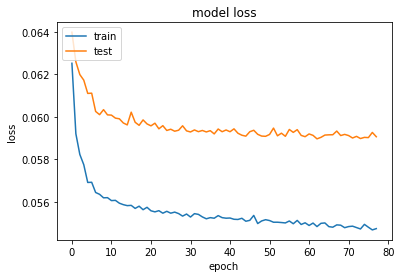

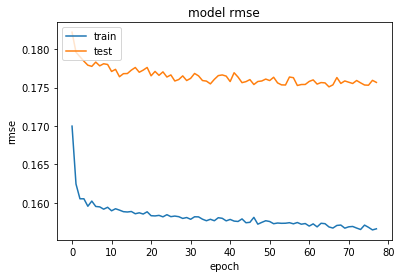

In [12]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
def get_mae(Y1, Y2):
   return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)

## Evaluate performance on validation data

In [14]:
model.load_weights(experiment_name+'.hdf5')

In [15]:
#path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")

val_gen_pred = data_generator_head_seq2seq_reinject_output(path_to_sensor_data_train,
                                         file_names_val,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )

predictions_mae_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_rmse_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_smape_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_mfe_val = np.zeros((len(file_names_val), 1+len_delay))


count = 0

start = time.time()
print("Evaluating validation data...")

for [encoder_input, decoder_input], Y_val_abs in val_gen_pred:
    #print(len(encoder_input))
    #input_seq = encoder_input[seq_index: seq_index + 1]
    Y_pred_diff = model.predict([encoder_input, decoder_input], verbose=0)
    
    # From normalized differences to absolute values
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_val_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_val_abs = Y_val_abs[:, 1:]

    predictions_mae_val[count, 0] = get_mae(Y_pred, Y_val_abs)
    predictions_rmse_val[count, 0] = get_rmse(Y_pred, Y_val_abs)
    predictions_smape_val[count, 0] = get_smape(Y_pred, Y_val_abs)
    predictions_mfe_val[count, 0] = get_mfe(Y_pred, Y_val_abs)
    
    #print(Y_pred.shape)
    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[: ,ind_delay]
        Y_delay_val = Y_val_abs[: ,ind_delay]
        
        predictions_mae_val[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_val)
        predictions_rmse_val[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_val)
        predictions_smape_val[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_val)
        predictions_mfe_val[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_val)
    
    count += 1
    if count == len(file_names_val):
        break

results_mae_val = np.mean(predictions_mae_val, axis=0)
results_rmse_val = np.mean(predictions_rmse_val, axis=0)
results_smape_val = np.mean(predictions_smape_val, axis=0)
results_mfe_val = np.mean(predictions_mfe_val, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating validation data...


Evaluation Time :  127.89897847175598 s =  2.131649653116862 min =  0.03552749428484175 h


## Evaluate metrics

In [16]:
print("MAE")
print("Average mae:", results_mae_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_val[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_val[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_val[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_val[i+1])

MAE
Average mae: 0.05878532293842023
Delay 100 ms: 0.005338947401141061
Delay 200 ms: 0.014028121168840049
Delay 300 ms: 0.025173310515350777
Delay 400 ms: 0.03757416854534305
Delay 500 ms: 0.05061666736517484
Delay 600 ms: 0.06401737786162172
Delay 700 ms: 0.07756847891327719
Delay 800 ms: 0.09112274011948016
Delay 900 ms: 0.10457366141732514
Delay 1000 ms: 0.1178397560766486

RMSE
Average rmse: 0.12239571666771266
Delay 100 ms: 0.01283056979483888
Delay 200 ms: 0.02840172082981134
Delay 300 ms: 0.04841281276741894
Delay 400 ms: 0.07030920936270228
Delay 500 ms: 0.09288102388823131
Delay 600 ms: 0.1156290893275161
Delay 700 ms: 0.13817371979967394
Delay 800 ms: 0.16031844692494485
Delay 900 ms: 0.18195297040460304
Delay 1000 ms: 0.20294408210841974

SMAPE
Average smape: 14.357729288624999
Delay 100 ms: 2.447249599112921
Delay 200 ms: 5.518689217659028
Delay 300 ms: 8.542534346293236
Delay 400 ms: 11.357809348773666
Delay 500 ms: 13.928365998212282
Delay 600 ms: 16.298916429563068
Dela

(6058, 25, 3) (6058, 10, 3)


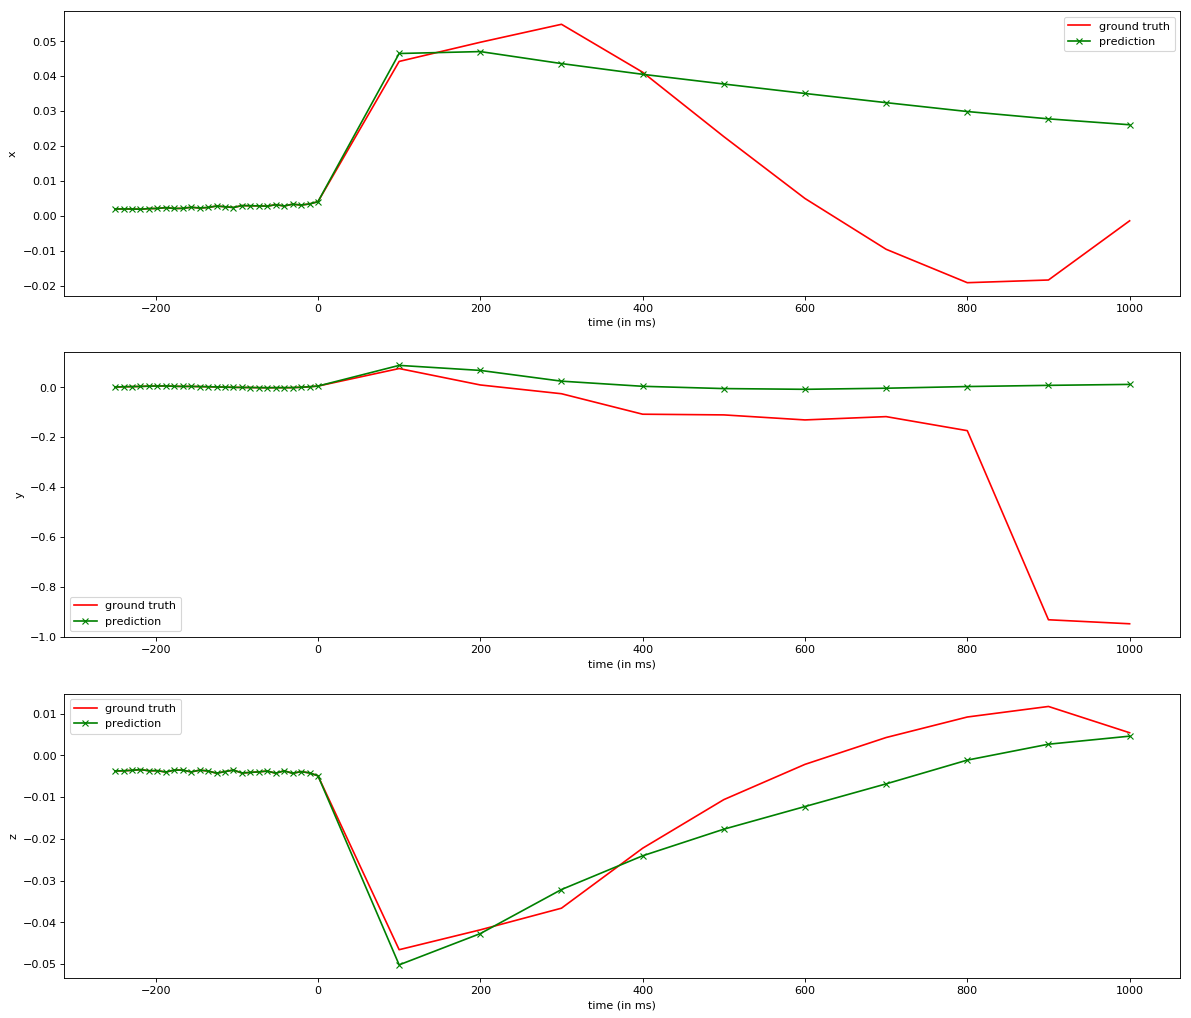

In [17]:
[encoder_input, decoder_input], Y_val = next(val_gen)
print(encoder_input.shape, Y_val.shape)
Y_pred = model.predict([encoder_input, decoder_input], verbose=0)

fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.grid(True)
plt.axvline(x=0, c="b")
x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len(delays_list))))
time_sample = 700

plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_val[time_sample, :, 0])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_pred[time_sample, :, 0])), label="prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_val[time_sample, :, 1])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_pred[time_sample, :, 1])), label="prediction", c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_val[time_sample, :, 2])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_pred[time_sample, :, 2])), label="prediction", c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')